In [1]:
%matplotlib inline

In [2]:
%run notebook_setup

In [3]:
lit_period = 4.887803076
lit_t0 = 124.8130808

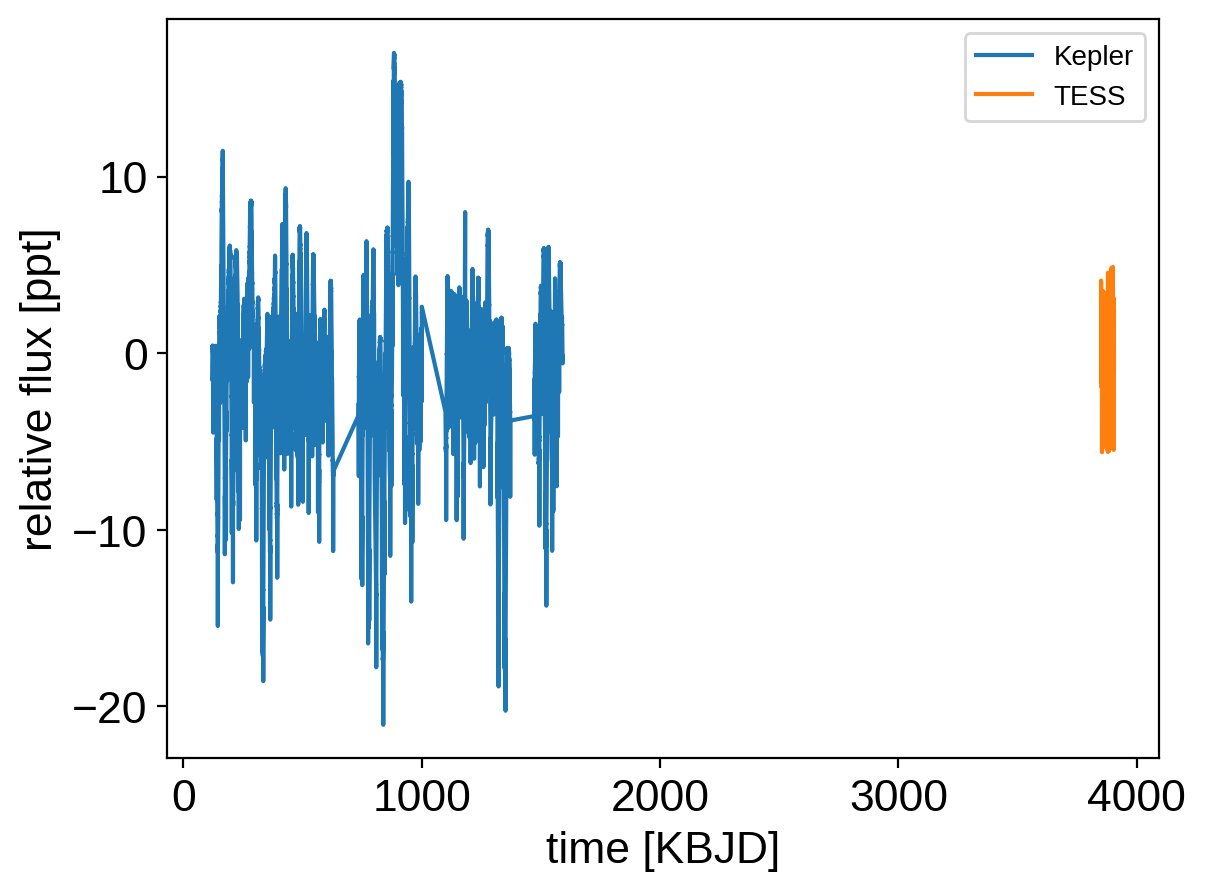

In [4]:
import numpy as np
import lightkurve as lk
from collections import OrderedDict

kepler_lcfs = lk.search_lightcurvefile("HAT-P-11", mission="Kepler").download_all()
kepler_lc = kepler_lcfs.PDCSAP_FLUX.stitch().remove_nans()
kepler_t = np.ascontiguousarray(kepler_lc.time, dtype=np.float64)
kepler_y = np.ascontiguousarray(1e3 * (kepler_lc.flux - 1), dtype=np.float64)
kepler_yerr = np.ascontiguousarray(1e3 * kepler_lc.flux_err, dtype=np.float64)

hdr = kepler_lcfs[0].hdu[1].header
kepler_texp = hdr["FRAMETIM"] * hdr["NUM_FRM"]
kepler_texp /= 60.0 * 60.0 * 24.0

tess_lcfs = lk.search_lightcurvefile("HAT-P-11", mission="TESS").download_all()
tess_lc = tess_lcfs.PDCSAP_FLUX.stitch().remove_nans()
tess_t = np.ascontiguousarray(tess_lc.time + 2457000 - 2454833, dtype=np.float64)
tess_y = np.ascontiguousarray(1e3 * (tess_lc.flux - 1), dtype=np.float64)
tess_yerr = np.ascontiguousarray(1e3 * tess_lc.flux_err, dtype=np.float64)

hdr = tess_lcfs[0].hdu[1].header
tess_texp = hdr["FRAMETIM"] * hdr["NUM_FRM"]
tess_texp /= 60.0 * 60.0 * 24.0

datasets = OrderedDict(
    [
        ("Kepler", [kepler_t, kepler_y, kepler_yerr, kepler_texp]),
        ("TESS", [tess_t, tess_y, tess_yerr, tess_texp]),
    ]
)

for name, (t, y, _, _) in datasets.items():
    plt.plot(t, y, label=name)
plt.legend(fontsize=10)
plt.xlabel("time [KBJD]")
_ = plt.ylabel("relative flux [ppt]")

In [5]:
import pymc3 as pm
import exoplanet as xo
import theano.tensor as tt
from functools import partial

x_min = min(np.min(x) for x, _, _, _ in datasets.values())
x_max = max(np.max(x) for x, _, _, _ in datasets.values())
x_mid = 0.5 * (x_min + x_max)
t0_ref = lit_t0 + lit_period * np.round((x_mid - lit_t0) / lit_period)

for i in range(10):
    with pm.Model() as model:

        # Shared orbital parameters
        period = pm.Lognormal("period", mu=np.log(lit_period), sigma=1.0)
        t0 = pm.Normal("t0", mu=t0_ref, sigma=1.0)
        dur = pm.Lognormal("dur", mu=np.log(0.1), sigma=10.0)
        b = xo.UnitUniform("b")
        ld_arg = 1 - tt.sqrt(1 - b ** 2)
        orbit = xo.orbits.KeplerianOrbit(period=period, duration=dur, t0=t0, b=b)

        # We'll also say that the timescale of the GP will be shared
        ell = pm.InverseGamma(
            "ell", testval=2.0, **xo.estimate_inverse_gamma_parameters(1.0, 5.0)
        )

        # Loop over the instruments
        parameters = dict()
        lc_models = dict()
        gp_preds = dict()
        gp_preds_with_mean = dict()
        for n, (name, (x, y, yerr, texp)) in enumerate(datasets.items()):

            # We define the per-instrument parameters in a submodel so that we
            # don't have to prefix the names manually
            with pm.Model(name=name, model=model):
                # The flux zero point
                mean = pm.Normal("mean", mu=0.0, sigma=10.0)

                # The limb darkening
                u = xo.distributions.QuadLimbDark("u")
                star = xo.LimbDarkLightCurve(u)

                # The radius ratio
                approx_depth = pm.Lognormal("approx_depth", mu=np.log(4e-3), sigma=10)
                ld = 1 - u[0] * ld_arg - u[1] * ld_arg ** 2
                ror = pm.Deterministic("ror", tt.sqrt(approx_depth / ld))

                # Noise parameters
                med_yerr = np.median(yerr)
                std = np.std(y)
                sigma = pm.InverseGamma(
                    "sigma",
                    testval=med_yerr,
                    **xo.estimate_inverse_gamma_parameters(med_yerr, 0.5 * std),
                )
                S_tot = pm.InverseGamma(
                    "S_tot",
                    testval=med_yerr,
                    **xo.estimate_inverse_gamma_parameters(
                        med_yerr ** 2, 0.25 * std ** 2
                    ),
                )

                # Keep track of the parameters for optimization
                parameters[name] = [mean, u, approx_depth]
                parameters[f"{name}_noise"] = [sigma, S_tot]

            # The light curve model
            def lc_model(mean, star, ror, texp, t):
                return mean + 1e3 * tt.sum(
                    star.get_light_curve(orbit=orbit, r=ror, t=t, texp=texp), axis=-1
                )

            lc_model = partial(lc_model, mean, star, ror, texp)
            lc_models[name] = lc_model

            # The Gaussian Process noise model
            kernel = xo.gp.terms.SHOTerm(S_tot=S_tot, w0=2 * np.pi / ell, Q=1.0 / 3)
            gp = xo.gp.GP(kernel, x, yerr ** 2 + sigma ** 2, mean=lc_model)
            gp.marginal(f"{name}_obs", observed=y)
            gp_preds[name] = gp.predict()
            gp_preds_with_mean[name] = gp.predict(predict_mean=True)

        # Optimize the model
        map_soln = model.test_point
        for name in datasets:
            map_soln = xo.optimize(map_soln, parameters[name])
        for name in datasets:
            map_soln = xo.optimize(map_soln, parameters[name] + [dur, b])
            map_soln = xo.optimize(map_soln, parameters[f"{name}_noise"])
        map_soln = xo.optimize(map_soln)

        # Do some sigma clipping
        num = dict((name, len(datasets[name][0])) for name in datasets)
        clipped = dict()
        masks = dict()
        for name in datasets:
            mdl = xo.eval_in_model(gp_preds_with_mean[name], map_soln)
            resid = datasets[name][1] - mdl
            sigma = np.sqrt(np.median((resid - np.median(resid)) ** 2))
            masks[name] = np.abs(resid - np.median(resid)) < 7 * sigma
            clipped[name] = num[name] - masks[name].sum()
            print(f"Sigma clipped {clipped[name]} {name} light curve points")
        if all(c < 10 for c in clipped.values()):
            break

        else:
            for name in datasets:
                datasets[name][0] = datasets[name][0][masks[name]]
                datasets[name][1] = datasets[name][1][masks[name]]
                datasets[name][2] = datasets[name][2][masks[name]]

optimizing logp for variables: [Kepler_approx_depth, Kepler_u, Kepler_mean]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-9.590588e+05]

1it [00:00, 16.15it/s, logp=-9.590588e+05]

2it [00:00, 24.27it/s, logp=-9.590588e+05]

3it [00:00, 29.09it/s, logp=-2.389347e+06]

4it [00:00, 38.55it/s, logp=-2.389347e+06]

4it [00:00, 38.55it/s, logp=-7.126958e+05]

5it [00:00, 38.55it/s, logp=-8.224130e+05]

6it [00:00, 38.55it/s, logp=-6.423235e+05]

7it [00:00, 38.55it/s, logp=-3.620299e+06]

8it [00:00, 38.55it/s, logp=-6.423755e+05]

9it [00:00, 41.24it/s, logp=-6.423755e+05]

9it [00:00, 41.24it/s, logp=-6.414844e+05]

10it [00:00, 41.24it/s, logp=-6.622007e+05]

11it [00:00, 41.24it/s, logp=-6.414474e+05]

12it [00:00, 41.24it/s, logp=-6.413727e+05]

13it [00:00, 41.24it/s, logp=-6.410787e+05]

14it [00:00, 42.55it/s, logp=-6.410787e+05]

14it [00:00, 42.55it/s, logp=-6.399759e+05]

15it [00:00, 42.55it/s, logp=-6.374035e+05]

16it [00:00, 42.55it/s, logp=-6.340501e+05]

17it [00:00, 42.55it/s, logp=-6.331344e+05]

18it [00:00, 42.55it/s, logp=-6.321657e+05]

19it [00:00, 42.88it/s, logp=-6.321657e+05]

19it [00:00, 42.88it/s, logp=-6.309824e+05]

20it [00:00, 42.88it/s, logp=-6.300529e+05]

21it [00:00, 42.88it/s, logp=-6.300875e+05]

22it [00:00, 42.88it/s, logp=-6.297542e+05]

23it [00:00, 42.88it/s, logp=-6.294896e+05]

24it [00:00, 44.46it/s, logp=-6.294896e+05]

24it [00:00, 44.46it/s, logp=-6.292746e+05]

25it [00:00, 44.46it/s, logp=-6.291486e+05]

26it [00:00, 44.46it/s, logp=-6.290802e+05]

27it [00:00, 44.46it/s, logp=-6.290467e+05]

28it [00:00, 44.46it/s, logp=-6.290268e+05]

29it [00:00, 45.72it/s, logp=-6.290268e+05]

29it [00:00, 45.72it/s, logp=-6.290174e+05]

30it [00:00, 45.72it/s, logp=-6.290132e+05]

31it [00:00, 45.72it/s, logp=-6.290114e+05]

32it [00:00, 45.72it/s, logp=-6.290107e+05]

33it [00:00, 45.72it/s, logp=-6.290104e+05]

34it [00:00, 46.65it/s, logp=-6.290104e+05]

34it [00:00, 46.65it/s, logp=-6.290104e+05]

35it [00:00, 46.65it/s, logp=-6.290104e+05]

36it [00:00, 46.65it/s, logp=-6.290104e+05]

37it [00:00, 46.65it/s, logp=-6.290104e+05]

38it [00:00, 46.65it/s, logp=-6.290104e+05]

39it [00:00, 47.35it/s, logp=-6.290104e+05]

39it [00:00, 47.35it/s, logp=-6.290104e+05]

40it [00:00, 47.35it/s, logp=-6.290104e+05]

41it [00:00, 47.35it/s, logp=-6.290104e+05]

42it [00:00, 47.35it/s, logp=-6.290104e+05]

43it [00:00, 47.35it/s, logp=-6.290104e+05]

44it [00:00, 47.21it/s, logp=-6.290104e+05]

44it [00:00, 47.21it/s, logp=-6.290104e+05]

45it [00:00, 47.21it/s, logp=-6.290104e+05]

46it [00:01, 47.21it/s, logp=-6.290104e+05]

47it [00:01, 47.21it/s, logp=-6.290104e+05]

48it [00:01, 47.21it/s, logp=-6.290104e+05]

49it [00:01, 47.51it/s, logp=-6.290104e+05]

49it [00:01, 47.51it/s, logp=-6.290104e+05]

50it [00:01, 47.51it/s, logp=-6.290104e+05]

51it [00:01, 47.51it/s, logp=-6.290104e+05]

52it [00:01, 47.51it/s, logp=-6.290104e+05]

53it [00:01, 47.51it/s, logp=-6.290104e+05]

54it [00:01, 47.57it/s, logp=-6.290104e+05]

54it [00:01, 47.57it/s, logp=-6.290104e+05]

55it [00:01, 47.57it/s, logp=-6.290104e+05]

56it [00:01, 47.57it/s, logp=-6.290104e+05]

57it [00:01, 47.57it/s, logp=-6.290104e+05]

58it [00:01, 47.57it/s, logp=-6.290104e+05]

59it [00:01, 47.66it/s, logp=-6.290104e+05]

59it [00:01, 47.66it/s, logp=-6.290104e+05]

60it [00:01, 47.66it/s, logp=-6.290104e+05]

61it [00:01, 47.66it/s, logp=-6.290104e+05]

62it [00:01, 47.66it/s, logp=-6.290104e+05]

63it [00:01, 47.66it/s, logp=-6.290104e+05]

64it [00:01, 47.85it/s, logp=-6.290104e+05]

64it [00:01, 47.85it/s, logp=-6.290104e+05]

65it [00:01, 47.85it/s, logp=-6.290104e+05]

66it [00:01, 47.85it/s, logp=-6.290104e+05]

67it [00:01, 47.85it/s, logp=-6.290104e+05]

68it [00:01, 47.85it/s, logp=-6.290104e+05]

69it [00:01, 47.43it/s, logp=-6.290104e+05]

69it [00:01, 47.43it/s, logp=-6.290104e+05]

70it [00:01, 47.43it/s, logp=-6.290104e+05]

71it [00:01, 47.43it/s, logp=-6.290104e+05]

72it [00:01, 47.43it/s, logp=-6.290104e+05]

73it [00:01, 47.43it/s, logp=-6.290104e+05]

74it [00:01, 47.78it/s, logp=-6.290104e+05]

74it [00:01, 47.78it/s, logp=-6.290104e+05]

75it [00:01, 47.78it/s, logp=-6.290104e+05]

76it [00:01, 47.78it/s, logp=-6.290104e+05]

77it [00:01, 47.78it/s, logp=-6.290104e+05]

78it [00:01, 47.78it/s, logp=-6.290104e+05]

79it [00:01, 48.22it/s, logp=-6.290104e+05]

79it [00:01, 48.22it/s, logp=-6.290104e+05]

80it [00:01, 48.22it/s, logp=-6.290104e+05]

81it [00:04, 18.25it/s, logp=-6.290104e+05]


message: Optimization terminated successfully.
logp: -959058.8214741322 -> -629010.3944401566


optimizing logp for variables: [TESS_approx_depth, TESS_u, TESS_mean]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-6.290104e+05]

1it [00:00, 21.82it/s, logp=-6.290104e+05]

2it [00:00, 30.48it/s, logp=-6.290104e+05]

3it [00:00, 34.92it/s, logp=-6.301442e+05]

4it [00:00, 37.93it/s, logp=-6.287915e+05]

5it [00:00, 47.05it/s, logp=-6.287915e+05]

5it [00:00, 47.05it/s, logp=-6.288891e+05]

6it [00:00, 47.05it/s, logp=-6.287382e+05]

7it [00:00, 47.05it/s, logp=-6.287635e+05]

8it [00:00, 47.05it/s, logp=-6.287450e+05]

9it [00:00, 47.05it/s, logp=-6.287341e+05]

10it [00:00, 47.55it/s, logp=-6.287341e+05]

10it [00:00, 47.55it/s, logp=-6.287273e+05]

11it [00:00, 47.55it/s, logp=-6.287456e+05]

12it [00:00, 47.55it/s, logp=-6.287259e+05]

13it [00:00, 47.55it/s, logp=-6.287233e+05]

14it [00:00, 47.55it/s, logp=-6.287197e+05]

15it [00:00, 48.18it/s, logp=-6.287197e+05]

15it [00:00, 48.18it/s, logp=-6.287181e+05]

16it [00:00, 48.18it/s, logp=-6.287169e+05]

17it [00:00, 48.18it/s, logp=-6.287157e+05]

18it [00:00, 48.18it/s, logp=-6.287153e+05]

19it [00:00, 48.18it/s, logp=-6.287152e+05]

20it [00:00, 46.50it/s, logp=-6.287152e+05]

20it [00:00, 46.50it/s, logp=-6.287152e+05]

21it [00:00, 46.50it/s, logp=-6.287152e+05]

22it [00:00, 46.50it/s, logp=-6.287152e+05]

23it [00:00, 46.50it/s, logp=-6.287152e+05]

24it [00:00, 46.50it/s, logp=-6.287152e+05]

25it [00:00, 46.93it/s, logp=-6.287152e+05]

25it [00:00, 46.93it/s, logp=-6.287152e+05]

26it [00:00, 46.93it/s, logp=-6.287152e+05]

27it [00:00, 38.80it/s, logp=-6.287152e+05]


message: Optimization terminated successfully.
logp: -629010.3944401566 -> -628715.2142879929


optimizing logp for variables: [b, dur, Kepler_approx_depth, Kepler_u, Kepler_mean]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-6.287152e+05]

1it [00:00, 16.96it/s, logp=-6.287152e+05]

2it [00:00, 22.90it/s, logp=-6.287152e+05]

3it [00:00, 26.04it/s, logp=-4.033690e+06]

4it [00:00, 34.08it/s, logp=-4.033690e+06]

4it [00:00, 34.08it/s, logp=-6.269610e+05]

5it [00:00, 34.08it/s, logp=-6.326541e+05]

6it [00:00, 34.08it/s, logp=-6.266029e+05]

7it [00:00, 34.08it/s, logp=-6.259046e+05]

8it [00:00, 34.23it/s, logp=-6.259046e+05]

8it [00:00, 34.23it/s, logp=-6.236059e+05]

9it [00:00, 34.23it/s, logp=-6.204957e+05]

10it [00:00, 34.23it/s, logp=-2.121857e+07]

11it [00:00, 34.23it/s, logp=-6.204952e+05]

12it [00:00, 34.37it/s, logp=-6.204952e+05]

12it [00:00, 34.37it/s, logp=-6.204942e+05]

13it [00:00, 34.37it/s, logp=-6.204904e+05]

14it [00:00, 34.37it/s, logp=-6.204749e+05]

15it [00:00, 34.37it/s, logp=-6.204136e+05]

16it [00:00, 34.66it/s, logp=-6.204136e+05]

16it [00:00, 34.66it/s, logp=-6.201748e+05]

17it [00:00, 34.66it/s, logp=-6.193248e+05]

18it [00:00, 34.66it/s, logp=-6.176400e+05]

19it [00:00, 34.66it/s, logp=-6.170573e+05]

20it [00:00, 34.80it/s, logp=-6.170573e+05]

20it [00:00, 34.80it/s, logp=-6.171631e+05]

21it [00:00, 34.80it/s, logp=-6.170752e+05]

22it [00:00, 34.80it/s, logp=-6.170658e+05]

23it [00:00, 34.80it/s, logp=-6.170535e+05]

24it [00:00, 34.86it/s, logp=-6.170535e+05]

24it [00:00, 34.86it/s, logp=-6.170464e+05]

25it [00:00, 34.86it/s, logp=-6.170336e+05]

26it [00:00, 34.86it/s, logp=-6.170208e+05]

27it [00:00, 34.86it/s, logp=-6.170167e+05]

28it [00:00, 35.03it/s, logp=-6.170167e+05]

28it [00:00, 35.03it/s, logp=-6.170131e+05]

29it [00:00, 35.03it/s, logp=-6.170142e+05]

30it [00:00, 35.03it/s, logp=-6.170110e+05]

31it [00:00, 35.03it/s, logp=-6.170079e+05]

32it [00:00, 34.96it/s, logp=-6.170079e+05]

32it [00:00, 34.96it/s, logp=-6.170023e+05]

33it [00:00, 34.96it/s, logp=-6.169927e+05]

34it [00:01, 34.96it/s, logp=-6.169773e+05]

35it [00:01, 34.96it/s, logp=-6.170972e+05]

36it [00:01, 32.79it/s, logp=-6.170972e+05]

36it [00:01, 32.79it/s, logp=-6.169723e+05]

37it [00:01, 32.79it/s, logp=-6.169631e+05]

38it [00:01, 32.79it/s, logp=-6.169466e+05]

39it [00:01, 32.79it/s, logp=-6.169186e+05]

40it [00:01, 33.43it/s, logp=-6.169186e+05]

40it [00:01, 33.43it/s, logp=-6.168738e+05]

41it [00:01, 33.43it/s, logp=-6.177609e+05]

42it [00:01, 33.43it/s, logp=-6.168640e+05]

43it [00:01, 33.43it/s, logp=-6.168463e+05]

44it [00:01, 33.96it/s, logp=-6.168463e+05]

44it [00:01, 33.96it/s, logp=-6.168154e+05]

45it [00:01, 33.96it/s, logp=-6.167755e+05]

46it [00:01, 33.96it/s, logp=-6.167139e+05]

47it [00:01, 33.96it/s, logp=-6.167070e+05]

48it [00:01, 34.42it/s, logp=-6.167070e+05]

48it [00:01, 34.42it/s, logp=-6.166902e+05]

49it [00:01, 34.42it/s, logp=-6.166500e+05]

50it [00:01, 34.42it/s, logp=-6.166193e+05]

51it [00:01, 34.42it/s, logp=-6.165711e+05]

52it [00:01, 34.76it/s, logp=-6.165711e+05]

52it [00:01, 34.76it/s, logp=-6.165230e+05]

53it [00:01, 34.76it/s, logp=-6.164963e+05]

54it [00:01, 34.76it/s, logp=-6.164860e+05]

55it [00:01, 34.76it/s, logp=-6.164803e+05]

56it [00:01, 34.86it/s, logp=-6.164803e+05]

56it [00:01, 34.86it/s, logp=-6.165004e+05]

57it [00:01, 34.86it/s, logp=-6.164742e+05]

58it [00:01, 34.86it/s, logp=-6.164703e+05]

59it [00:01, 34.86it/s, logp=-6.164652e+05]

60it [00:01, 35.01it/s, logp=-6.164652e+05]

60it [00:01, 35.01it/s, logp=-6.164637e+05]

61it [00:01, 35.01it/s, logp=-6.164632e+05]

62it [00:01, 35.01it/s, logp=-6.164632e+05]

63it [00:01, 35.01it/s, logp=-6.164632e+05]

64it [00:01, 34.93it/s, logp=-6.164632e+05]

64it [00:01, 34.93it/s, logp=-6.164632e+05]

65it [00:01, 34.93it/s, logp=-6.164632e+05]

66it [00:01, 34.93it/s, logp=-6.164632e+05]

67it [00:01, 34.93it/s, logp=-6.164632e+05]

68it [00:01, 33.51it/s, logp=-6.164632e+05]

68it [00:02, 33.51it/s, logp=-6.164632e+05]

69it [00:02, 33.51it/s, logp=-6.164631e+05]

70it [00:02, 33.51it/s, logp=-6.164631e+05]

71it [00:02, 33.51it/s, logp=-6.164631e+05]

72it [00:02, 33.91it/s, logp=-6.164631e+05]

72it [00:02, 33.91it/s, logp=-6.164630e+05]

73it [00:02, 33.91it/s, logp=-6.164628e+05]

74it [00:02, 33.91it/s, logp=-6.164625e+05]

75it [00:02, 33.91it/s, logp=-6.164950e+05]

76it [00:02, 34.09it/s, logp=-6.164950e+05]

76it [00:02, 34.09it/s, logp=-6.164619e+05]

77it [00:02, 34.09it/s, logp=-6.164617e+05]

78it [00:02, 34.09it/s, logp=-6.164616e+05]

79it [00:02, 34.09it/s, logp=-6.164612e+05]

80it [00:02, 34.39it/s, logp=-6.164612e+05]

80it [00:02, 34.39it/s, logp=-1.451076e+06]

81it [00:02, 34.39it/s, logp=-6.166611e+05]

82it [00:02, 34.39it/s, logp=-6.164619e+05]

83it [00:02, 34.39it/s, logp=-6.164612e+05]

84it [00:02, 34.41it/s, logp=-6.164612e+05]

84it [00:02, 34.41it/s, logp=-6.164612e+05]

85it [00:02, 34.41it/s, logp=-6.164610e+05]

86it [00:02, 34.41it/s, logp=-6.164604e+05]

87it [00:02, 34.41it/s, logp=-6.164588e+05]

88it [00:02, 34.69it/s, logp=-6.164588e+05]

88it [00:02, 34.69it/s, logp=-6.164547e+05]

89it [00:02, 34.69it/s, logp=-6.164505e+05]

90it [00:02, 34.69it/s, logp=-6.164602e+05]

91it [00:02, 34.69it/s, logp=-6.164479e+05]

92it [00:02, 35.06it/s, logp=-6.164479e+05]

92it [00:02, 35.06it/s, logp=-6.164582e+05]

93it [00:02, 35.06it/s, logp=-6.164472e+05]

94it [00:02, 35.06it/s, logp=-6.164461e+05]

95it [00:02, 35.06it/s, logp=-6.164440e+05]

96it [00:02, 34.78it/s, logp=-6.164440e+05]

96it [00:02, 34.78it/s, logp=-6.164404e+05]

97it [00:02, 34.78it/s, logp=-6.164427e+05]

98it [00:02, 34.78it/s, logp=-6.164380e+05]

99it [00:02, 34.78it/s, logp=-6.164340e+05]

100it [00:02, 35.11it/s, logp=-6.164340e+05]

100it [00:02, 35.11it/s, logp=-6.164297e+05]

101it [00:02, 35.11it/s, logp=-6.164249e+05]

102it [00:02, 35.11it/s, logp=-6.164229e+05]

103it [00:03, 35.11it/s, logp=-6.164224e+05]

104it [00:03, 35.07it/s, logp=-6.164224e+05]

104it [00:03, 35.07it/s, logp=-6.164217e+05]

105it [00:03, 35.07it/s, logp=-6.164210e+05]

106it [00:03, 35.07it/s, logp=-6.164208e+05]

107it [00:03, 35.07it/s, logp=-6.164207e+05]

108it [00:03, 35.07it/s, logp=-6.164207e+05]

108it [00:03, 35.07it/s, logp=-6.164206e+05]

109it [00:03, 35.07it/s, logp=-6.164205e+05]

110it [00:03, 35.07it/s, logp=-6.164205e+05]

111it [00:03, 35.07it/s, logp=-6.164205e+05]

112it [00:03, 34.67it/s, logp=-6.164205e+05]

112it [00:03, 34.67it/s, logp=-6.164205e+05]

113it [00:03, 34.67it/s, logp=-6.164205e+05]

114it [00:03, 34.67it/s, logp=-6.164205e+05]

115it [00:03, 34.67it/s, logp=-6.164205e+05]

116it [00:03, 34.74it/s, logp=-6.164205e+05]

116it [00:03, 34.74it/s, logp=-6.164205e+05]

117it [00:03, 34.74it/s, logp=-6.164205e+05]

118it [00:03, 34.74it/s, logp=-6.164205e+05]

119it [00:03, 34.74it/s, logp=-6.164205e+05]

120it [00:03, 35.01it/s, logp=-6.164205e+05]

120it [00:03, 35.01it/s, logp=-6.164205e+05]

121it [00:03, 35.01it/s, logp=-6.164205e+05]

122it [00:03, 35.01it/s, logp=-6.164205e+05]

123it [00:03, 35.01it/s, logp=-6.164205e+05]

124it [00:03, 35.15it/s, logp=-6.164205e+05]

124it [00:03, 35.15it/s, logp=-6.164205e+05]

125it [00:03, 35.15it/s, logp=-6.164205e+05]

126it [00:03, 35.15it/s, logp=-6.164205e+05]

127it [00:03, 35.15it/s, logp=-6.164205e+05]

128it [00:03, 35.26it/s, logp=-6.164205e+05]

128it [00:03, 35.26it/s, logp=-6.164205e+05]

129it [00:03, 35.26it/s, logp=-6.164205e+05]

130it [00:03, 35.26it/s, logp=-6.164205e+05]

131it [00:03, 35.26it/s, logp=-6.164205e+05]

132it [00:03, 35.26it/s, logp=-6.164205e+05]

132it [00:03, 35.26it/s, logp=-6.164205e+05]

133it [00:03, 35.26it/s, logp=-6.164205e+05]

134it [00:03, 35.26it/s, logp=-6.164205e+05]

135it [00:03, 35.26it/s, logp=-6.164205e+05]

136it [00:03, 35.48it/s, logp=-6.164205e+05]

136it [00:03, 35.48it/s, logp=-6.164205e+05]

137it [00:03, 35.48it/s, logp=-6.164205e+05]

138it [00:04, 35.48it/s, logp=-6.164205e+05]

139it [00:04, 35.48it/s, logp=-6.164205e+05]

140it [00:04, 34.84it/s, logp=-6.164205e+05]

140it [00:04, 34.84it/s, logp=-6.164205e+05]

141it [00:04, 34.84it/s, logp=-6.164205e+05]

142it [00:04, 34.84it/s, logp=-6.164205e+05]

143it [00:04, 34.84it/s, logp=-6.164205e+05]

144it [00:04, 35.24it/s, logp=-6.164205e+05]

144it [00:04, 35.24it/s, logp=-6.164205e+05]

145it [00:04, 35.24it/s, logp=-6.164205e+05]

146it [00:04, 35.24it/s, logp=-6.164205e+05]

147it [00:04, 35.24it/s, logp=-6.164205e+05]

148it [00:04, 35.33it/s, logp=-6.164205e+05]

148it [00:04, 35.33it/s, logp=-6.164205e+05]

149it [00:04, 35.33it/s, logp=-6.164205e+05]

150it [00:04, 35.33it/s, logp=-6.164205e+05]

151it [00:04, 35.33it/s, logp=-6.164205e+05]

152it [00:04, 34.32it/s, logp=-6.164205e+05]

152it [00:04, 34.32it/s, logp=-6.164205e+05]

153it [00:04, 34.32it/s, logp=-6.164205e+05]

154it [00:04, 34.32it/s, logp=-6.164205e+05]

155it [00:04, 34.32it/s, logp=-6.164205e+05]

156it [00:04, 33.43it/s, logp=-6.164205e+05]

156it [00:04, 33.43it/s, logp=-6.164205e+05]

157it [00:04, 33.43it/s, logp=-6.164205e+05]

158it [00:04, 33.43it/s, logp=-6.164205e+05]

159it [00:04, 33.43it/s, logp=-6.164205e+05]

160it [00:04, 33.65it/s, logp=-6.164205e+05]

160it [00:04, 33.65it/s, logp=-6.164205e+05]

161it [00:04, 33.65it/s, logp=-6.164205e+05]

162it [00:04, 33.65it/s, logp=-6.164205e+05]

163it [00:04, 33.65it/s, logp=-6.164205e+05]

164it [00:04, 33.62it/s, logp=-6.164205e+05]

164it [00:04, 33.62it/s, logp=-6.164205e+05]

165it [00:04, 33.62it/s, logp=-6.164205e+05]

166it [00:04, 33.62it/s, logp=-6.164205e+05]

167it [00:04, 33.62it/s, logp=-6.164205e+05]

168it [00:04, 33.99it/s, logp=-6.164205e+05]

168it [00:04, 33.99it/s, logp=-6.164205e+05]

169it [00:04, 33.99it/s, logp=-6.164205e+05]

170it [00:04, 33.99it/s, logp=-6.164205e+05]

171it [00:04, 33.99it/s, logp=-6.164205e+05]

172it [00:04, 34.32it/s, logp=-6.164205e+05]

172it [00:05, 34.32it/s, logp=-6.164205e+05]

173it [00:05, 34.32it/s, logp=-6.164205e+05]

174it [00:05, 34.32it/s, logp=-6.164205e+05]

175it [00:05, 34.32it/s, logp=-6.164205e+05]

176it [00:05, 34.60it/s, logp=-6.164205e+05]

176it [00:05, 34.60it/s, logp=-6.164205e+05]

177it [00:05, 34.60it/s, logp=-6.164205e+05]

178it [00:05, 34.60it/s, logp=-6.164205e+05]

179it [00:05, 34.60it/s, logp=-6.164205e+05]

180it [00:05, 34.50it/s, logp=-6.164205e+05]

180it [00:05, 34.50it/s, logp=-6.164205e+05]

181it [00:05, 34.50it/s, logp=-6.164205e+05]

182it [00:05, 34.50it/s, logp=-6.164205e+05]

183it [00:05, 34.50it/s, logp=-6.164205e+05]

184it [00:05, 34.81it/s, logp=-6.164205e+05]

184it [00:05, 34.81it/s, logp=-6.164205e+05]

185it [00:05, 34.81it/s, logp=-6.164205e+05]

186it [00:05, 34.81it/s, logp=-6.164205e+05]

187it [00:05, 34.81it/s, logp=-6.164205e+05]

188it [00:05, 35.03it/s, logp=-6.164205e+05]

188it [00:05, 33.80it/s, logp=-6.164205e+05]


message: Desired error not necessarily achieved due to precision loss.
logp: -628715.2142879929 -> -616420.5305446959


optimizing logp for variables: [Kepler_S_tot, Kepler_sigma]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-6.164205e+05]

1it [00:00, 18.19it/s, logp=-6.164205e+05]

2it [00:00, 25.71it/s, logp=-6.164205e+05]

3it [00:00, 25.44it/s, logp=-2.226590e+05]

4it [00:00, 33.66it/s, logp=-2.226590e+05]

4it [00:00, 33.66it/s, logp=-5.474591e+05]

5it [00:00, 33.66it/s, logp=-2.915145e+05]

6it [00:00, 33.66it/s, logp=-1.937412e+05]

7it [00:00, 33.66it/s, logp=-1.421270e+05]

8it [00:00, 34.44it/s, logp=-1.421270e+05]

8it [00:00, 34.44it/s, logp=-6.324624e+04]

9it [00:00, 34.44it/s, logp=-1.213190e+04]

10it [00:00, 34.44it/s, logp=9.903877e+03]

11it [00:00, 34.44it/s, logp=1.982561e+04]

12it [00:00, 35.31it/s, logp=1.982561e+04]

12it [00:00, 35.31it/s, logp=2.300300e+04]

13it [00:00, 35.31it/s, logp=2.361455e+04]

14it [00:00, 35.31it/s, logp=2.365978e+04]

15it [00:00, 35.31it/s, logp=2.366046e+04]

16it [00:00, 35.31it/s, logp=2.366046e+04]

17it [00:00, 35.97it/s, logp=2.366046e+04]

17it [00:00, 35.97it/s, logp=2.366046e+04]

18it [00:00, 35.97it/s, logp=2.366046e+04]

19it [00:00, 35.97it/s, logp=2.366046e+04]

20it [00:00, 35.97it/s, logp=2.366046e+04]

21it [00:00, 35.97it/s, logp=2.366046e+04]

22it [00:00, 37.76it/s, logp=2.366046e+04]

22it [00:00, 37.76it/s, logp=2.366046e+04]

23it [00:00, 37.76it/s, logp=2.366046e+04]

24it [00:00, 37.76it/s, logp=2.366046e+04]

25it [00:00, 37.76it/s, logp=2.366046e+04]

26it [00:00, 37.76it/s, logp=2.366046e+04]

27it [00:00, 39.21it/s, logp=2.366046e+04]

27it [00:00, 39.21it/s, logp=2.366046e+04]

28it [00:00, 39.21it/s, logp=2.366046e+04]

29it [00:00, 39.21it/s, logp=2.366046e+04]

30it [00:00, 39.21it/s, logp=2.366046e+04]

31it [00:00, 39.21it/s, logp=2.366046e+04]

32it [00:00, 40.35it/s, logp=2.366046e+04]

32it [00:00, 40.35it/s, logp=2.366046e+04]

33it [00:00, 40.35it/s, logp=2.366046e+04]

34it [00:00, 40.35it/s, logp=2.366046e+04]

35it [00:00, 40.35it/s, logp=2.366046e+04]

36it [00:00, 40.35it/s, logp=2.366046e+04]

37it [00:00, 41.17it/s, logp=2.366046e+04]

37it [00:00, 41.17it/s, logp=2.366046e+04]

38it [00:00, 41.17it/s, logp=2.366046e+04]

39it [00:01, 41.17it/s, logp=2.366046e+04]

40it [00:01, 41.17it/s, logp=2.366046e+04]

41it [00:01, 41.17it/s, logp=2.366046e+04]

42it [00:01, 41.85it/s, logp=2.366046e+04]

42it [00:01, 41.85it/s, logp=2.366046e+04]

43it [00:01, 41.85it/s, logp=2.366046e+04]

44it [00:01, 41.85it/s, logp=2.366046e+04]

45it [00:01, 41.85it/s, logp=2.366046e+04]

46it [00:01, 41.85it/s, logp=2.366046e+04]

47it [00:01, 42.22it/s, logp=2.366046e+04]

47it [00:01, 42.22it/s, logp=2.366046e+04]

48it [00:01, 42.22it/s, logp=2.366046e+04]

49it [00:01, 42.22it/s, logp=2.366046e+04]

50it [00:01, 42.22it/s, logp=2.366046e+04]

51it [00:01, 42.22it/s, logp=2.366046e+04]

52it [00:01, 42.52it/s, logp=2.366046e+04]

52it [00:01, 42.52it/s, logp=2.366046e+04]

53it [00:01, 42.52it/s, logp=2.366046e+04]

54it [00:01, 42.52it/s, logp=2.366046e+04]

55it [00:01, 42.52it/s, logp=2.366046e+04]

56it [00:01, 42.52it/s, logp=2.366046e+04]

57it [00:01, 41.64it/s, logp=2.366046e+04]

57it [00:01, 41.64it/s, logp=2.366046e+04]

58it [00:01, 41.64it/s, logp=2.366046e+04]

59it [00:01, 41.64it/s, logp=2.366046e+04]

60it [00:01, 41.64it/s, logp=2.366046e+04]

61it [00:01, 41.64it/s, logp=2.366046e+04]

62it [00:01, 41.90it/s, logp=2.366046e+04]

62it [00:01, 41.90it/s, logp=2.366046e+04]

63it [00:01, 41.90it/s, logp=2.366046e+04]

64it [00:01, 41.90it/s, logp=2.366046e+04]

65it [00:01, 41.90it/s, logp=2.366046e+04]

66it [00:01, 41.90it/s, logp=2.366046e+04]

67it [00:01, 42.34it/s, logp=2.366046e+04]

67it [00:01, 42.34it/s, logp=2.366046e+04]

68it [00:01, 42.34it/s, logp=2.366046e+04]

69it [00:01, 42.34it/s, logp=2.366046e+04]

70it [00:01, 42.34it/s, logp=2.366046e+04]

71it [00:01, 42.34it/s, logp=2.366046e+04]

72it [00:01, 41.60it/s, logp=2.366046e+04]

72it [00:01, 41.60it/s, logp=2.366046e+04]

73it [00:01, 41.60it/s, logp=2.366046e+04]

74it [00:01, 41.60it/s, logp=2.366046e+04]

75it [00:01, 41.60it/s, logp=2.366046e+04]

76it [00:01, 41.60it/s, logp=2.366046e+04]

77it [00:01, 42.09it/s, logp=2.366046e+04]

77it [00:01, 42.09it/s, logp=2.366046e+04]

78it [00:01, 42.09it/s, logp=2.366046e+04]

79it [00:01, 42.09it/s, logp=2.366046e+04]

80it [00:01, 42.09it/s, logp=2.366046e+04]

81it [00:01, 42.09it/s, logp=2.366046e+04]

82it [00:01, 42.53it/s, logp=2.366046e+04]

82it [00:02, 42.53it/s, logp=2.366046e+04]

83it [00:02, 42.53it/s, logp=2.366046e+04]

84it [00:02, 42.53it/s, logp=2.366046e+04]

85it [00:02, 42.53it/s, logp=2.366046e+04]

86it [00:02, 42.53it/s, logp=2.366046e+04]

87it [00:02, 42.81it/s, logp=2.366046e+04]

87it [00:02, 42.81it/s, logp=2.366046e+04]

88it [00:02, 42.81it/s, logp=2.366046e+04]

89it [00:02, 42.81it/s, logp=2.366046e+04]

90it [00:02, 42.81it/s, logp=2.366046e+04]

91it [00:02, 42.81it/s, logp=2.366046e+04]

92it [00:02, 43.00it/s, logp=2.366046e+04]

92it [00:02, 43.00it/s, logp=2.366046e+04]

93it [00:02, 43.00it/s, logp=2.366046e+04]

94it [00:02, 43.00it/s, logp=2.366046e+04]

95it [00:02, 43.00it/s, logp=2.366046e+04]

96it [00:02, 43.00it/s, logp=2.366046e+04]

97it [00:02, 42.89it/s, logp=2.366046e+04]

97it [00:02, 42.89it/s, logp=2.366046e+04]

98it [00:02, 42.89it/s, logp=2.366046e+04]

99it [00:02, 42.89it/s, logp=2.366046e+04]

100it [00:02, 42.89it/s, logp=2.366046e+04]

101it [00:02, 42.89it/s, logp=2.366046e+04]

102it [00:02, 43.10it/s, logp=2.366046e+04]

102it [00:02, 43.10it/s, logp=2.366046e+04]

103it [00:02, 43.10it/s, logp=2.366046e+04]

104it [00:02, 43.10it/s, logp=2.366046e+04]

105it [00:02, 43.10it/s, logp=2.366046e+04]

106it [00:02, 43.10it/s, logp=2.366046e+04]

107it [00:02, 43.05it/s, logp=2.366046e+04]

107it [00:02, 43.05it/s, logp=2.366046e+04]

108it [00:02, 43.05it/s, logp=2.366046e+04]

109it [00:02, 43.05it/s, logp=2.366046e+04]

110it [00:02, 43.05it/s, logp=2.366046e+04]

111it [00:02, 43.05it/s, logp=2.366046e+04]

112it [00:02, 43.08it/s, logp=2.366046e+04]

112it [00:02, 43.08it/s, logp=2.366046e+04]

113it [00:02, 43.08it/s, logp=2.366046e+04]

114it [00:02, 43.08it/s, logp=2.366046e+04]

115it [00:02, 43.08it/s, logp=2.366046e+04]

116it [00:02, 43.08it/s, logp=2.366046e+04]

117it [00:02, 43.08it/s, logp=2.366046e+04]

117it [00:02, 39.90it/s, logp=2.366046e+04]


message: Desired error not necessarily achieved due to precision loss.
logp: -616420.5305446959 -> 23660.46092201257


optimizing logp for variables: [b, dur, TESS_approx_depth, TESS_u, TESS_mean]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=2.366046e+04]

1it [00:00, 13.97it/s, logp=2.366046e+04]

2it [00:00, 21.43it/s, logp=2.366046e+04]

3it [00:00, 26.36it/s, logp=-5.672543e+05]

4it [00:00, 34.87it/s, logp=-5.672543e+05]

4it [00:00, 34.87it/s, logp=2.366046e+04] 

5it [00:00, 34.87it/s, logp=2.366095e+04]

6it [00:00, 34.87it/s, logp=2.366192e+04]

7it [00:00, 34.87it/s, logp=2.366539e+04]

8it [00:00, 35.97it/s, logp=2.366539e+04]

8it [00:00, 35.97it/s, logp=2.367333e+04]

9it [00:00, 35.97it/s, logp=2.368292e+04]

10it [00:00, 35.97it/s, logp=2.370102e+04]

11it [00:00, 35.97it/s, logp=2.374876e+04]

12it [00:00, 35.97it/s, logp=2.358156e+04]

13it [00:00, 38.15it/s, logp=2.358156e+04]

13it [00:00, 38.15it/s, logp=2.375276e+04]

14it [00:00, 38.15it/s, logp=2.375799e+04]

15it [00:00, 38.15it/s, logp=2.224797e+04]

16it [00:00, 38.15it/s, logp=2.375887e+04]

17it [00:00, 38.15it/s, logp=2.376051e+04]

18it [00:00, 39.89it/s, logp=2.376051e+04]

18it [00:00, 39.89it/s, logp=2.376243e+04]

19it [00:00, 39.89it/s, logp=2.376454e+04]

20it [00:00, 39.89it/s, logp=2.376476e+04]

21it [00:00, 39.89it/s, logp=2.376509e+04]

22it [00:00, 39.15it/s, logp=2.376509e+04]

22it [00:00, 39.15it/s, logp=2.376570e+04]

23it [00:00, 39.15it/s, logp=2.376683e+04]

24it [00:00, 39.15it/s, logp=2.376891e+04]

25it [00:00, 39.15it/s, logp=2.377136e+04]

26it [00:00, 39.15it/s, logp=2.377245e+04]

27it [00:00, 40.69it/s, logp=2.377245e+04]

27it [00:00, 40.69it/s, logp=2.377430e+04]

28it [00:00, 40.69it/s, logp=2.377643e+04]

29it [00:00, 40.69it/s, logp=2.377682e+04]

30it [00:00, 40.69it/s, logp=2.377707e+04]

31it [00:00, 40.69it/s, logp=2.377711e+04]

32it [00:00, 41.91it/s, logp=2.377711e+04]

32it [00:00, 41.91it/s, logp=2.377711e+04]

33it [00:00, 41.91it/s, logp=2.377712e+04]

34it [00:00, 41.91it/s, logp=2.377712e+04]

35it [00:00, 41.91it/s, logp=2.377712e+04]

36it [00:00, 41.91it/s, logp=2.377712e+04]

37it [00:00, 42.68it/s, logp=2.377712e+04]

37it [00:00, 42.68it/s, logp=2.377712e+04]

38it [00:00, 42.68it/s, logp=2.377712e+04]

39it [00:00, 42.68it/s, logp=2.377712e+04]

40it [00:00, 42.68it/s, logp=2.377712e+04]

41it [00:00, 42.68it/s, logp=2.377712e+04]

42it [00:00, 43.25it/s, logp=2.377712e+04]

42it [00:01, 43.25it/s, logp=2.377712e+04]

43it [00:01, 43.25it/s, logp=2.377712e+04]

44it [00:01, 43.25it/s, logp=2.377712e+04]

45it [00:01, 43.25it/s, logp=2.377712e+04]

46it [00:01, 43.25it/s, logp=2.377712e+04]

47it [00:01, 43.75it/s, logp=2.377712e+04]

47it [00:01, 43.75it/s, logp=2.377712e+04]

48it [00:01, 43.75it/s, logp=2.377712e+04]

49it [00:01, 43.75it/s, logp=2.377712e+04]

50it [00:01, 43.75it/s, logp=2.377712e+04]

51it [00:01, 43.75it/s, logp=2.377712e+04]

52it [00:01, 43.77it/s, logp=2.377712e+04]

52it [00:01, 43.77it/s, logp=2.377712e+04]

53it [00:01, 43.77it/s, logp=2.377712e+04]

54it [00:01, 43.77it/s, logp=2.377712e+04]

55it [00:01, 43.77it/s, logp=2.377712e+04]

56it [00:01, 43.77it/s, logp=2.377712e+04]

57it [00:01, 40.56it/s, logp=2.377712e+04]

57it [00:01, 40.56it/s, logp=2.377712e+04]

58it [00:01, 40.56it/s, logp=2.377712e+04]

59it [00:01, 40.56it/s, logp=2.377712e+04]

60it [00:01, 40.56it/s, logp=2.377712e+04]

61it [00:01, 40.56it/s, logp=2.377712e+04]

62it [00:01, 40.29it/s, logp=2.377712e+04]

62it [00:01, 40.29it/s, logp=2.377712e+04]

63it [00:01, 40.29it/s, logp=2.377712e+04]

64it [00:01, 40.29it/s, logp=2.377712e+04]

65it [00:01, 40.29it/s, logp=2.377712e+04]

66it [00:01, 40.29it/s, logp=2.377712e+04]

67it [00:01, 38.73it/s, logp=2.377712e+04]

67it [00:01, 38.73it/s, logp=2.377712e+04]

68it [00:01, 38.73it/s, logp=2.377712e+04]

69it [00:01, 38.73it/s, logp=2.377712e+04]

70it [00:01, 38.73it/s, logp=2.377712e+04]

71it [00:01, 38.73it/s, logp=2.377712e+04]

72it [00:01, 40.03it/s, logp=2.377712e+04]

72it [00:01, 40.03it/s, logp=2.377712e+04]

73it [00:01, 40.03it/s, logp=2.377712e+04]

74it [00:01, 40.03it/s, logp=2.377712e+04]

75it [00:01, 40.03it/s, logp=2.377712e+04]

76it [00:01, 40.03it/s, logp=2.377712e+04]

77it [00:01, 40.14it/s, logp=2.377712e+04]

77it [00:01, 40.14it/s, logp=2.377712e+04]

78it [00:01, 40.14it/s, logp=2.377712e+04]

79it [00:01, 40.14it/s, logp=2.377712e+04]

80it [00:01, 40.14it/s, logp=2.377712e+04]

81it [00:01, 40.14it/s, logp=2.377712e+04]

82it [00:01, 41.32it/s, logp=2.377712e+04]

82it [00:02, 41.32it/s, logp=2.377712e+04]

83it [00:02, 41.32it/s, logp=2.377712e+04]

84it [00:02, 41.32it/s, logp=2.377712e+04]

85it [00:02, 41.32it/s, logp=2.377712e+04]

86it [00:02, 41.32it/s, logp=2.377712e+04]

87it [00:02, 40.87it/s, logp=2.377712e+04]

87it [00:02, 40.87it/s, logp=2.377712e+04]

88it [00:02, 40.87it/s, logp=2.377712e+04]

89it [00:02, 40.87it/s, logp=2.377712e+04]

90it [00:02, 40.87it/s, logp=2.377712e+04]

91it [00:02, 40.87it/s, logp=2.377712e+04]

92it [00:02, 40.18it/s, logp=2.377712e+04]

92it [00:02, 40.18it/s, logp=2.377712e+04]

93it [00:02, 40.18it/s, logp=2.377712e+04]

94it [00:02, 40.18it/s, logp=2.377712e+04]

95it [00:02, 40.18it/s, logp=2.377712e+04]

96it [00:02, 40.18it/s, logp=2.377712e+04]

97it [00:02, 41.42it/s, logp=2.377712e+04]

97it [00:02, 41.42it/s, logp=2.377712e+04]

98it [00:02, 41.42it/s, logp=2.377712e+04]

99it [00:02, 41.42it/s, logp=2.377712e+04]

100it [00:02, 41.42it/s, logp=2.377712e+04]

101it [00:02, 41.42it/s, logp=2.377712e+04]

102it [00:02, 40.70it/s, logp=2.377712e+04]

102it [00:02, 40.70it/s, logp=2.377712e+04]

103it [00:02, 40.70it/s, logp=2.377712e+04]

104it [00:02, 40.70it/s, logp=2.377712e+04]

105it [00:02, 40.70it/s, logp=2.377712e+04]

106it [00:02, 40.70it/s, logp=2.377712e+04]

107it [00:02, 41.79it/s, logp=2.377712e+04]

107it [00:02, 41.79it/s, logp=2.377712e+04]

108it [00:02, 41.79it/s, logp=2.377712e+04]

109it [00:02, 41.79it/s, logp=2.377712e+04]

110it [00:02, 41.79it/s, logp=2.377712e+04]

111it [00:02, 41.79it/s, logp=2.377712e+04]

112it [00:02, 42.61it/s, logp=2.377712e+04]

112it [00:02, 42.61it/s, logp=2.377712e+04]

113it [00:02, 42.61it/s, logp=2.377712e+04]

114it [00:02, 42.61it/s, logp=2.377712e+04]

115it [00:02, 42.61it/s, logp=2.377712e+04]

116it [00:02, 42.61it/s, logp=2.377712e+04]

117it [00:02, 43.50it/s, logp=2.377712e+04]

117it [00:02, 43.50it/s, logp=2.377712e+04]

118it [00:02, 43.50it/s, logp=2.377712e+04]

119it [00:02, 43.50it/s, logp=2.377712e+04]

120it [00:02, 43.50it/s, logp=2.377712e+04]

121it [00:02, 43.50it/s, logp=2.377712e+04]

122it [00:02, 41.56it/s, logp=2.377712e+04]

122it [00:02, 41.56it/s, logp=2.377712e+04]

123it [00:02, 41.56it/s, logp=2.377712e+04]

124it [00:03, 41.56it/s, logp=2.377712e+04]

125it [00:03, 41.56it/s, logp=2.377712e+04]

126it [00:03, 41.56it/s, logp=2.377712e+04]

127it [00:03, 42.55it/s, logp=2.377712e+04]

127it [00:03, 42.55it/s, logp=2.377712e+04]

128it [00:03, 42.55it/s, logp=2.377712e+04]

129it [00:03, 42.55it/s, logp=2.377712e+04]

130it [00:03, 42.55it/s, logp=2.377712e+04]

131it [00:03, 42.55it/s, logp=2.377712e+04]

132it [00:03, 41.45it/s, logp=2.377712e+04]

132it [00:03, 41.45it/s, logp=2.377712e+04]

133it [00:03, 41.45it/s, logp=2.377712e+04]

134it [00:03, 41.45it/s, logp=2.377712e+04]

135it [00:03, 41.45it/s, logp=2.377712e+04]

136it [00:03, 41.45it/s, logp=2.377712e+04]

137it [00:03, 40.70it/s, logp=2.377712e+04]

137it [00:03, 40.70it/s, logp=2.377712e+04]

138it [00:03, 40.70it/s, logp=2.377712e+04]

139it [00:03, 40.70it/s, logp=2.377712e+04]

140it [00:03, 40.70it/s, logp=2.377712e+04]

141it [00:03, 40.70it/s, logp=2.377712e+04]

142it [00:03, 41.70it/s, logp=2.377712e+04]

142it [00:03, 41.70it/s, logp=2.377712e+04]

143it [00:03, 41.70it/s, logp=2.377712e+04]

144it [00:03, 41.70it/s, logp=2.377712e+04]

145it [00:03, 41.70it/s, logp=2.377712e+04]

146it [00:03, 41.70it/s, logp=2.377712e+04]

147it [00:03, 42.45it/s, logp=2.377712e+04]

147it [00:03, 42.45it/s, logp=2.377712e+04]

148it [00:03, 42.45it/s, logp=2.377712e+04]

149it [00:03, 42.45it/s, logp=2.377712e+04]

150it [00:03, 42.45it/s, logp=2.377712e+04]

151it [00:03, 42.45it/s, logp=2.377712e+04]

152it [00:03, 43.09it/s, logp=2.377712e+04]

152it [00:03, 43.09it/s, logp=2.377712e+04]

153it [00:03, 43.09it/s, logp=2.377712e+04]

154it [00:03, 43.09it/s, logp=2.377712e+04]

155it [00:03, 43.09it/s, logp=2.377712e+04]

156it [00:03, 43.09it/s, logp=2.377712e+04]

157it [00:03, 43.50it/s, logp=2.377712e+04]

157it [00:03, 43.50it/s, logp=2.377712e+04]

158it [00:03, 40.40it/s, logp=2.377712e+04]


message: Desired error not necessarily achieved due to precision loss.
logp: 23660.460922012586 -> 23777.115310633504


optimizing logp for variables: [TESS_S_tot, TESS_sigma]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=2.377712e+04]

1it [00:00, 19.74it/s, logp=2.377712e+04]

2it [00:00, 27.90it/s, logp=2.377712e+04]

3it [00:00, 32.17it/s, logp=2.562471e+04]

4it [00:00, 34.96it/s, logp=-7.924311e+10]

5it [00:00, 43.47it/s, logp=-7.924311e+10]

5it [00:00, 43.47it/s, logp=-2.316647e+04]

6it [00:00, 43.47it/s, logp=2.565859e+04] 

7it [00:00, 43.47it/s, logp=2.572107e+04]

8it [00:00, 43.47it/s, logp=2.582412e+04]

9it [00:00, 41.85it/s, logp=2.582412e+04]

9it [00:00, 41.85it/s, logp=2.588776e+04]

10it [00:00, 41.85it/s, logp=2.589280e+04]

11it [00:00, 41.85it/s, logp=2.589308e+04]

12it [00:00, 41.85it/s, logp=2.589308e+04]

13it [00:00, 41.85it/s, logp=2.589308e+04]

14it [00:00, 43.00it/s, logp=2.589308e+04]

14it [00:00, 43.00it/s, logp=2.589308e+04]

15it [00:00, 43.00it/s, logp=2.589308e+04]

16it [00:00, 43.00it/s, logp=2.589308e+04]

17it [00:00, 43.00it/s, logp=2.589308e+04]

18it [00:00, 40.72it/s, logp=2.589308e+04]

18it [00:00, 40.72it/s, logp=2.589308e+04]

19it [00:00, 40.72it/s, logp=2.589308e+04]

20it [00:00, 40.72it/s, logp=2.589308e+04]

21it [00:00, 40.72it/s, logp=2.589308e+04]

22it [00:00, 40.72it/s, logp=2.589308e+04]

23it [00:00, 41.72it/s, logp=2.589308e+04]

23it [00:00, 41.72it/s, logp=2.589308e+04]

24it [00:00, 41.72it/s, logp=2.589308e+04]

25it [00:00, 41.72it/s, logp=2.589308e+04]

26it [00:00, 41.72it/s, logp=2.589308e+04]

27it [00:00, 41.72it/s, logp=2.589308e+04]

28it [00:00, 42.94it/s, logp=2.589308e+04]

28it [00:00, 42.94it/s, logp=2.589308e+04]

29it [00:00, 42.94it/s, logp=2.589308e+04]

30it [00:00, 42.94it/s, logp=2.589308e+04]

31it [00:00, 42.94it/s, logp=2.589308e+04]

32it [00:00, 42.94it/s, logp=2.589308e+04]

33it [00:00, 43.91it/s, logp=2.589308e+04]

33it [00:00, 43.91it/s, logp=2.589308e+04]

34it [00:00, 43.91it/s, logp=2.589308e+04]

35it [00:00, 43.91it/s, logp=2.589308e+04]

36it [00:00, 37.84it/s, logp=2.589308e+04]


message: Desired error not necessarily achieved due to precision loss.
logp: 23777.11531063349 -> 25893.07595418956


optimizing logp for variables: [TESS_S_tot, TESS_sigma, TESS_approx_depth, TESS_u, TESS_mean, Kepler_S_tot, Kepler_sigma, Kepler_approx_depth, Kepler_u, Kepler_mean, ell, b, dur, t0, period]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=2.589308e+04]

1it [00:00, 12.97it/s, logp=2.589308e+04]

2it [00:00, 18.65it/s, logp=2.589308e+04]

3it [00:00, 27.82it/s, logp=2.589308e+04]

3it [00:00, 27.82it/s, logp=-1.307464e+06]

4it [00:00, 27.82it/s, logp=-7.844603e+05]

5it [00:00, 27.82it/s, logp=-7.134939e+05]

6it [00:00, 27.51it/s, logp=-7.134939e+05]

6it [00:00, 27.51it/s, logp=-6.893426e+05]

7it [00:00, 27.51it/s, logp=-6.824007e+05]

8it [00:00, 27.51it/s, logp=-6.777238e+05]

9it [00:00, 27.51it/s, logp=-6.742294e+05]

10it [00:00, 29.14it/s, logp=-6.742294e+05]

10it [00:00, 29.14it/s, logp=-1.364742e+05]

11it [00:00, 29.14it/s, logp=2.595439e+04] 

12it [00:00, 29.14it/s, logp=2.184348e+04]

13it [00:00, 29.14it/s, logp=2.595517e+04]

14it [00:00, 30.28it/s, logp=2.595517e+04]

14it [00:00, 30.28it/s, logp=2.595674e+04]

15it [00:00, 30.28it/s, logp=2.596303e+04]

16it [00:00, 30.28it/s, logp=2.598811e+04]

17it [00:00, 30.28it/s, logp=2.608753e+04]

18it [00:00, 31.15it/s, logp=2.608753e+04]

18it [00:00, 31.15it/s, logp=2.647016e+04]

19it [00:00, 31.15it/s, logp=2.774828e+04]

20it [00:00, 31.15it/s, logp=2.223899e+04]

21it [00:00, 31.15it/s, logp=2.811733e+04]

22it [00:00, 31.80it/s, logp=2.811733e+04]

22it [00:00, 31.80it/s, logp=2.863681e+04]

23it [00:00, 31.80it/s, logp=2.926960e+04]

24it [00:00, 31.80it/s, logp=2.977914e+04]

25it [00:00, 31.80it/s, logp=-1.495739e+07]

26it [00:00, 32.12it/s, logp=-1.495739e+07]

26it [00:00, 32.12it/s, logp=-2.394390e+03]

27it [00:00, 32.12it/s, logp=2.977794e+04] 

28it [00:00, 32.12it/s, logp=2.978031e+04]

29it [00:00, 32.12it/s, logp=2.978217e+04]

30it [00:00, 32.51it/s, logp=2.978217e+04]

30it [00:00, 32.51it/s, logp=2.978582e+04]

31it [00:00, 32.51it/s, logp=2.979843e+04]

32it [00:01, 32.51it/s, logp=2.980953e+04]

33it [00:01, 32.51it/s, logp=2.983228e+04]

34it [00:01, 31.99it/s, logp=2.983228e+04]

34it [00:01, 31.99it/s, logp=2.992857e+04]

35it [00:01, 31.99it/s, logp=3.017074e+04]

36it [00:01, 31.99it/s, logp=3.082713e+04]

37it [00:01, 31.99it/s, logp=2.093489e+04]

38it [00:01, 32.15it/s, logp=2.093489e+04]

38it [00:01, 32.15it/s, logp=3.095464e+04]

39it [00:01, 32.15it/s, logp=3.097975e+04]

40it [00:01, 32.15it/s, logp=3.103114e+04]

41it [00:01, 32.15it/s, logp=3.115932e+04]

42it [00:01, 32.40it/s, logp=3.115932e+04]

42it [00:01, 32.40it/s, logp=3.139653e+04]

43it [00:01, 32.40it/s, logp=3.123591e+04]

44it [00:01, 32.40it/s, logp=3.148188e+04]

45it [00:01, 32.40it/s, logp=3.164772e+04]

46it [00:01, 32.43it/s, logp=3.164772e+04]

46it [00:01, 32.43it/s, logp=3.191737e+04]

47it [00:01, 32.43it/s, logp=3.225934e+04]

48it [00:01, 32.43it/s, logp=3.249107e+04]

49it [00:01, 32.43it/s, logp=3.252739e+04]

50it [00:01, 31.78it/s, logp=3.252739e+04]

50it [00:01, 31.78it/s, logp=3.254753e+04]

51it [00:01, 31.78it/s, logp=3.254885e+04]

52it [00:01, 31.78it/s, logp=3.255132e+04]

53it [00:01, 31.78it/s, logp=3.255553e+04]

54it [00:01, 32.01it/s, logp=3.255553e+04]

54it [00:01, 32.01it/s, logp=3.255828e+04]

55it [00:01, 32.01it/s, logp=3.255889e+04]

56it [00:01, 32.01it/s, logp=3.255902e+04]

57it [00:01, 32.01it/s, logp=3.255927e+04]

58it [00:01, 32.33it/s, logp=3.255927e+04]

58it [00:01, 32.33it/s, logp=3.255973e+04]

59it [00:01, 32.33it/s, logp=3.256049e+04]

60it [00:01, 32.33it/s, logp=3.256158e+04]

61it [00:01, 32.33it/s, logp=3.256272e+04]

62it [00:01, 32.46it/s, logp=3.256272e+04]

62it [00:01, 32.46it/s, logp=3.256385e+04]

63it [00:01, 32.46it/s, logp=3.256370e+04]

64it [00:02, 32.46it/s, logp=3.256105e+04]

65it [00:02, 32.46it/s, logp=3.256425e+04]

66it [00:02, 32.47it/s, logp=3.256425e+04]

66it [00:02, 32.47it/s, logp=3.256486e+04]

67it [00:02, 32.47it/s, logp=3.256538e+04]

68it [00:02, 32.47it/s, logp=3.256530e+04]

69it [00:02, 32.47it/s, logp=3.256555e+04]

70it [00:02, 30.67it/s, logp=3.256555e+04]

70it [00:02, 30.67it/s, logp=3.256586e+04]

71it [00:02, 30.67it/s, logp=3.256639e+04]

72it [00:02, 30.67it/s, logp=3.256685e+04]

73it [00:02, 30.67it/s, logp=3.256696e+04]

74it [00:02, 31.38it/s, logp=3.256696e+04]

74it [00:02, 31.38it/s, logp=3.256701e+04]

75it [00:02, 31.38it/s, logp=3.256703e+04]

76it [00:02, 31.38it/s, logp=3.256703e+04]

77it [00:02, 31.38it/s, logp=3.256703e+04]

78it [00:02, 31.58it/s, logp=3.256703e+04]

78it [00:02, 31.58it/s, logp=3.256703e+04]

79it [00:02, 31.58it/s, logp=3.256703e+04]

80it [00:02, 31.58it/s, logp=3.256703e+04]

81it [00:02, 31.58it/s, logp=3.256703e+04]

82it [00:02, 32.05it/s, logp=3.256703e+04]

82it [00:02, 32.05it/s, logp=3.256704e+04]

83it [00:02, 32.05it/s, logp=3.256704e+04]

84it [00:02, 32.05it/s, logp=3.256704e+04]

85it [00:02, 32.05it/s, logp=3.256706e+04]

86it [00:02, 31.41it/s, logp=3.256706e+04]

86it [00:02, 31.41it/s, logp=3.256706e+04]

87it [00:02, 31.41it/s, logp=3.256693e+04]

88it [00:02, 31.41it/s, logp=3.256706e+04]

89it [00:02, 31.41it/s, logp=3.256707e+04]

90it [00:02, 32.06it/s, logp=3.256707e+04]

90it [00:02, 32.06it/s, logp=3.256707e+04]

91it [00:02, 32.06it/s, logp=3.256709e+04]

92it [00:02, 32.06it/s, logp=3.256711e+04]

93it [00:02, 32.06it/s, logp=3.256711e+04]

94it [00:02, 32.45it/s, logp=3.256711e+04]

94it [00:02, 32.45it/s, logp=3.256711e+04]

95it [00:03, 32.45it/s, logp=3.256711e+04]

96it [00:03, 32.45it/s, logp=3.256711e+04]

97it [00:03, 32.45it/s, logp=3.256711e+04]

98it [00:03, 32.62it/s, logp=3.256711e+04]

98it [00:03, 32.62it/s, logp=3.256711e+04]

99it [00:03, 32.62it/s, logp=3.256711e+04]

100it [00:03, 32.62it/s, logp=3.256711e+04]

101it [00:03, 32.62it/s, logp=3.256711e+04]

102it [00:03, 32.74it/s, logp=3.256711e+04]

102it [00:03, 32.74it/s, logp=3.256711e+04]

103it [00:03, 32.74it/s, logp=3.256711e+04]

104it [00:03, 32.74it/s, logp=3.256711e+04]

105it [00:03, 32.74it/s, logp=3.256711e+04]

106it [00:03, 32.84it/s, logp=3.256711e+04]

106it [00:03, 32.84it/s, logp=3.256711e+04]

107it [00:03, 32.84it/s, logp=3.256711e+04]

108it [00:03, 32.84it/s, logp=3.256711e+04]

109it [00:03, 32.84it/s, logp=3.256711e+04]

110it [00:03, 32.85it/s, logp=3.256711e+04]

110it [00:03, 32.85it/s, logp=3.256711e+04]

111it [00:03, 32.85it/s, logp=3.256711e+04]

112it [00:03, 32.85it/s, logp=3.256711e+04]

113it [00:03, 32.85it/s, logp=3.256711e+04]

114it [00:03, 32.97it/s, logp=3.256711e+04]

114it [00:03, 32.97it/s, logp=3.256711e+04]

115it [00:03, 32.97it/s, logp=3.256711e+04]

116it [00:03, 32.97it/s, logp=3.256711e+04]

117it [00:03, 32.97it/s, logp=3.256711e+04]

118it [00:03, 33.10it/s, logp=3.256711e+04]

118it [00:03, 33.10it/s, logp=3.256711e+04]

119it [00:03, 33.10it/s, logp=3.256711e+04]

120it [00:03, 33.10it/s, logp=3.256711e+04]

121it [00:03, 33.10it/s, logp=3.256711e+04]

122it [00:03, 33.05it/s, logp=3.256711e+04]

122it [00:03, 33.05it/s, logp=3.256711e+04]

123it [00:03, 33.05it/s, logp=3.256711e+04]

124it [00:03, 33.05it/s, logp=3.256711e+04]

125it [00:03, 33.05it/s, logp=3.256711e+04]

126it [00:03, 32.39it/s, logp=3.256711e+04]

126it [00:03, 32.39it/s, logp=3.256711e+04]

127it [00:03, 32.39it/s, logp=3.256711e+04]

128it [00:04, 32.39it/s, logp=3.256711e+04]

129it [00:04, 32.39it/s, logp=3.256711e+04]

130it [00:04, 31.67it/s, logp=3.256711e+04]

130it [00:04, 31.67it/s, logp=3.256711e+04]

131it [00:04, 31.67it/s, logp=3.256711e+04]

132it [00:04, 31.67it/s, logp=3.256711e+04]

133it [00:04, 31.67it/s, logp=3.256711e+04]

134it [00:04, 32.24it/s, logp=3.256711e+04]

134it [00:04, 32.24it/s, logp=3.256711e+04]

135it [00:04, 32.24it/s, logp=3.256711e+04]

136it [00:04, 32.24it/s, logp=3.256711e+04]

137it [00:04, 32.24it/s, logp=3.256711e+04]

138it [00:04, 32.64it/s, logp=3.256711e+04]

138it [00:04, 32.64it/s, logp=3.256711e+04]

139it [00:04, 32.64it/s, logp=3.256711e+04]

140it [00:04, 32.64it/s, logp=3.256711e+04]

141it [00:04, 32.64it/s, logp=3.256711e+04]

142it [00:04, 32.24it/s, logp=3.256711e+04]

142it [00:04, 32.24it/s, logp=3.256711e+04]

143it [00:04, 32.24it/s, logp=3.256711e+04]

144it [00:04, 32.24it/s, logp=3.256711e+04]

145it [00:04, 32.24it/s, logp=3.256711e+04]

146it [00:04, 32.57it/s, logp=3.256711e+04]

146it [00:04, 32.57it/s, logp=3.256711e+04]

147it [00:04, 32.57it/s, logp=3.256711e+04]

148it [00:04, 32.57it/s, logp=3.256711e+04]

149it [00:04, 32.57it/s, logp=3.256711e+04]

150it [00:04, 32.79it/s, logp=3.256711e+04]

150it [00:04, 32.79it/s, logp=3.256711e+04]

151it [00:04, 32.79it/s, logp=3.256711e+04]

152it [00:04, 32.79it/s, logp=3.256711e+04]

153it [00:04, 32.79it/s, logp=3.256711e+04]

154it [00:04, 32.68it/s, logp=3.256711e+04]

154it [00:04, 32.68it/s, logp=3.256711e+04]

155it [00:04, 32.68it/s, logp=3.256711e+04]

156it [00:04, 32.68it/s, logp=3.256711e+04]

157it [00:04, 32.68it/s, logp=3.256711e+04]

158it [00:04, 32.82it/s, logp=3.256711e+04]

158it [00:04, 32.82it/s, logp=3.256711e+04]

159it [00:04, 32.82it/s, logp=3.256711e+04]

160it [00:04, 32.82it/s, logp=3.256711e+04]

161it [00:05, 32.82it/s, logp=3.256711e+04]

162it [00:05, 33.00it/s, logp=3.256711e+04]

162it [00:05, 33.00it/s, logp=3.256711e+04]

163it [00:05, 33.00it/s, logp=3.256711e+04]

164it [00:05, 33.00it/s, logp=3.256711e+04]

165it [00:05, 33.00it/s, logp=3.256711e+04]

166it [00:05, 33.18it/s, logp=3.256711e+04]

166it [00:05, 33.18it/s, logp=3.256711e+04]

167it [00:05, 33.18it/s, logp=3.256711e+04]

168it [00:05, 33.18it/s, logp=3.256711e+04]

169it [00:05, 33.18it/s, logp=3.256711e+04]

170it [00:05, 33.16it/s, logp=3.256711e+04]

170it [00:05, 33.16it/s, logp=3.256711e+04]

171it [00:05, 33.16it/s, logp=3.256711e+04]

172it [00:05, 33.16it/s, logp=3.256711e+04]

173it [00:05, 33.16it/s, logp=3.256711e+04]

174it [00:05, 33.05it/s, logp=3.256711e+04]

174it [00:05, 33.05it/s, logp=3.256711e+04]

175it [00:05, 33.05it/s, logp=3.256711e+04]

176it [00:05, 33.05it/s, logp=3.256711e+04]

177it [00:05, 33.05it/s, logp=3.256711e+04]

178it [00:05, 33.14it/s, logp=3.256711e+04]

178it [00:05, 33.14it/s, logp=3.256711e+04]

179it [00:05, 33.14it/s, logp=3.256711e+04]

180it [00:05, 33.14it/s, logp=3.256711e+04]

181it [00:05, 33.14it/s, logp=3.256711e+04]

182it [00:05, 33.30it/s, logp=3.256711e+04]

182it [00:05, 33.30it/s, logp=3.256711e+04]

183it [00:05, 33.30it/s, logp=3.256711e+04]

184it [00:05, 33.30it/s, logp=3.256711e+04]

185it [00:05, 33.30it/s, logp=3.256711e+04]

186it [00:05, 33.39it/s, logp=3.256711e+04]

186it [00:05, 33.39it/s, logp=3.256711e+04]

187it [00:05, 33.39it/s, logp=3.256711e+04]

188it [00:05, 33.39it/s, logp=3.256711e+04]

189it [00:05, 33.39it/s, logp=3.256711e+04]

190it [00:05, 33.45it/s, logp=3.256711e+04]

190it [00:05, 33.45it/s, logp=3.256711e+04]

191it [00:05, 33.45it/s, logp=3.256711e+04]

192it [00:05, 33.45it/s, logp=3.256711e+04]

193it [00:05, 33.45it/s, logp=3.256711e+04]

194it [00:05, 33.51it/s, logp=3.256711e+04]

194it [00:06, 33.51it/s, logp=3.256711e+04]

195it [00:06, 33.51it/s, logp=3.256711e+04]

196it [00:06, 33.51it/s, logp=3.256711e+04]

197it [00:06, 33.51it/s, logp=3.256711e+04]

198it [00:06, 33.57it/s, logp=3.256711e+04]

198it [00:06, 33.57it/s, logp=3.256711e+04]

199it [00:06, 33.57it/s, logp=3.256711e+04]

200it [00:06, 33.57it/s, logp=3.256711e+04]

201it [00:06, 33.57it/s, logp=3.256711e+04]

202it [00:06, 33.65it/s, logp=3.256711e+04]

202it [00:06, 33.65it/s, logp=3.256711e+04]

203it [00:06, 33.65it/s, logp=3.256711e+04]

204it [00:06, 33.65it/s, logp=3.256711e+04]

205it [00:06, 33.65it/s, logp=3.256711e+04]

206it [00:06, 33.70it/s, logp=3.256711e+04]

206it [00:06, 33.70it/s, logp=3.256711e+04]

207it [00:06, 33.70it/s, logp=3.256711e+04]

208it [00:06, 33.70it/s, logp=3.256711e+04]

209it [00:06, 33.70it/s, logp=3.256711e+04]

210it [00:06, 33.67it/s, logp=3.256711e+04]

210it [00:06, 33.67it/s, logp=3.256711e+04]

211it [00:06, 33.67it/s, logp=3.256711e+04]

212it [00:06, 33.67it/s, logp=3.256711e+04]

213it [00:06, 33.67it/s, logp=3.256711e+04]

214it [00:06, 33.64it/s, logp=3.256711e+04]

214it [00:06, 33.64it/s, logp=3.256711e+04]

215it [00:06, 33.64it/s, logp=3.256711e+04]

216it [00:06, 33.64it/s, logp=3.256711e+04]

217it [00:06, 33.64it/s, logp=3.256711e+04]

218it [00:06, 33.67it/s, logp=3.256711e+04]

218it [00:06, 33.67it/s, logp=3.256711e+04]

219it [00:06, 33.67it/s, logp=3.256711e+04]

220it [00:06, 33.67it/s, logp=3.256711e+04]

221it [00:06, 33.67it/s, logp=3.256711e+04]

222it [00:06, 33.67it/s, logp=3.256711e+04]

222it [00:06, 33.67it/s, logp=3.256711e+04]

223it [00:06, 33.67it/s, logp=3.256711e+04]

224it [00:06, 33.67it/s, logp=3.256711e+04]

225it [00:06, 33.67it/s, logp=3.256711e+04]

226it [00:06, 33.70it/s, logp=3.256711e+04]

226it [00:06, 33.70it/s, logp=3.256711e+04]

227it [00:06, 33.70it/s, logp=3.256711e+04]

228it [00:07, 33.70it/s, logp=3.256711e+04]

229it [00:07, 33.70it/s, logp=3.256711e+04]

230it [00:07, 33.72it/s, logp=3.256711e+04]

230it [00:07, 33.72it/s, logp=3.256711e+04]

231it [00:07, 33.72it/s, logp=3.256711e+04]

232it [00:07, 33.72it/s, logp=3.256711e+04]

233it [00:07, 33.72it/s, logp=3.256711e+04]

234it [00:07, 33.74it/s, logp=3.256711e+04]

234it [00:07, 33.74it/s, logp=3.256711e+04]

235it [00:07, 33.74it/s, logp=3.256711e+04]

236it [00:07, 33.74it/s, logp=3.256711e+04]

237it [00:07, 33.74it/s, logp=3.256711e+04]

238it [00:07, 33.69it/s, logp=3.256711e+04]

238it [00:07, 33.69it/s, logp=3.256711e+04]

239it [00:07, 33.69it/s, logp=3.256711e+04]

240it [00:07, 33.69it/s, logp=3.256711e+04]

241it [00:07, 33.69it/s, logp=3.256711e+04]

242it [00:07, 33.65it/s, logp=3.256711e+04]

242it [00:07, 33.65it/s, logp=3.256711e+04]

243it [00:07, 33.65it/s, logp=3.256711e+04]

244it [00:07, 33.65it/s, logp=3.256711e+04]

245it [00:07, 33.65it/s, logp=3.256711e+04]

246it [00:07, 33.47it/s, logp=3.256711e+04]

246it [00:07, 33.47it/s, logp=3.256711e+04]

247it [00:07, 33.47it/s, logp=3.256711e+04]

248it [00:07, 33.47it/s, logp=3.256711e+04]

249it [00:07, 33.47it/s, logp=3.256711e+04]

250it [00:07, 33.32it/s, logp=3.256711e+04]

250it [00:07, 33.32it/s, logp=3.256711e+04]

251it [00:07, 33.32it/s, logp=3.256711e+04]

252it [00:07, 33.32it/s, logp=3.256711e+04]

253it [00:07, 33.32it/s, logp=3.256711e+04]

254it [00:07, 33.07it/s, logp=3.256711e+04]

254it [00:07, 33.07it/s, logp=3.256711e+04]

255it [00:07, 33.07it/s, logp=3.256711e+04]

256it [00:07, 33.07it/s, logp=3.256711e+04]

257it [00:07, 33.07it/s, logp=3.256711e+04]

258it [00:07, 33.01it/s, logp=3.256711e+04]

258it [00:07, 33.01it/s, logp=3.256711e+04]

259it [00:07, 33.01it/s, logp=3.256711e+04]

260it [00:07, 33.01it/s, logp=3.256711e+04]

261it [00:08, 33.01it/s, logp=3.256711e+04]

262it [00:08, 33.02it/s, logp=3.256711e+04]

262it [00:08, 33.02it/s, logp=3.256711e+04]

263it [00:08, 33.02it/s, logp=3.256711e+04]

264it [00:08, 33.02it/s, logp=3.256711e+04]

265it [00:08, 33.02it/s, logp=3.256711e+04]

266it [00:08, 32.47it/s, logp=3.256711e+04]

266it [00:08, 32.47it/s, logp=3.256711e+04]

267it [00:08, 32.47it/s, logp=3.256711e+04]

268it [00:08, 32.47it/s, logp=3.256711e+04]

269it [00:08, 32.05it/s, logp=3.256711e+04]


message: Desired error not necessarily achieved due to precision loss.
logp: 25893.075954189575 -> 32567.11411068519


Sigma clipped 338 Kepler light curve points


Sigma clipped 40 TESS light curve points


optimizing logp for variables: [Kepler_approx_depth, Kepler_u, Kepler_mean]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-8.760826e+05]

1it [00:00, 20.67it/s, logp=-8.760826e+05]

2it [00:00, 28.94it/s, logp=-8.760826e+05]

3it [00:00, 28.36it/s, logp=-2.206739e+06]

4it [00:00, 37.53it/s, logp=-2.206739e+06]

4it [00:00, 37.53it/s, logp=-6.524164e+05]

5it [00:00, 37.53it/s, logp=-7.111117e+05]

6it [00:00, 37.53it/s, logp=-5.786159e+05]

7it [00:00, 37.53it/s, logp=-5.978211e+06]

8it [00:00, 37.53it/s, logp=-5.783815e+05]

9it [00:00, 39.90it/s, logp=-5.783815e+05]

9it [00:00, 39.90it/s, logp=-5.805883e+05]

10it [00:00, 39.90it/s, logp=-5.783593e+05]

11it [00:00, 39.90it/s, logp=-5.783145e+05]

12it [00:00, 39.90it/s, logp=-5.781373e+05]

13it [00:00, 39.90it/s, logp=-5.774589e+05]

14it [00:00, 41.56it/s, logp=-5.774589e+05]

14it [00:00, 41.56it/s, logp=-5.752383e+05]

15it [00:00, 41.56it/s, logp=-5.720954e+05]

16it [00:00, 41.56it/s, logp=-5.712192e+05]

17it [00:00, 41.56it/s, logp=-5.698927e+05]

18it [00:00, 41.56it/s, logp=-5.687019e+05]

19it [00:00, 42.98it/s, logp=-5.687019e+05]

19it [00:00, 42.98it/s, logp=-5.680652e+05]

20it [00:00, 42.98it/s, logp=-5.676988e+05]

21it [00:00, 42.98it/s, logp=-5.673799e+05]

22it [00:00, 42.98it/s, logp=-5.672539e+05]

23it [00:00, 42.98it/s, logp=-5.671775e+05]

24it [00:00, 43.93it/s, logp=-5.671775e+05]

24it [00:00, 43.93it/s, logp=-5.671376e+05]

25it [00:00, 43.93it/s, logp=-5.671167e+05]

26it [00:00, 43.93it/s, logp=-5.671064e+05]

27it [00:00, 43.93it/s, logp=-5.671014e+05]

28it [00:00, 43.93it/s, logp=-5.670992e+05]

29it [00:00, 44.83it/s, logp=-5.670992e+05]

29it [00:00, 44.83it/s, logp=-5.670983e+05]

30it [00:00, 44.83it/s, logp=-5.670980e+05]

31it [00:00, 44.83it/s, logp=-5.670980e+05]

32it [00:00, 44.83it/s, logp=-5.670980e+05]

33it [00:00, 44.83it/s, logp=-5.670980e+05]

34it [00:00, 45.38it/s, logp=-5.670980e+05]

34it [00:00, 45.38it/s, logp=-5.670980e+05]

35it [00:00, 45.38it/s, logp=-5.670980e+05]

36it [00:00, 45.38it/s, logp=-5.670980e+05]

37it [00:00, 45.38it/s, logp=-5.670980e+05]

38it [00:00, 45.38it/s, logp=-5.670980e+05]

39it [00:00, 45.63it/s, logp=-5.670980e+05]

39it [00:00, 45.63it/s, logp=-5.670980e+05]

40it [00:00, 45.63it/s, logp=-5.670980e+05]

41it [00:00, 45.63it/s, logp=-5.670980e+05]

42it [00:00, 45.63it/s, logp=-5.670980e+05]

43it [00:00, 45.63it/s, logp=-5.670980e+05]

44it [00:00, 45.80it/s, logp=-5.670980e+05]

44it [00:00, 45.80it/s, logp=-5.670980e+05]

45it [00:01, 45.80it/s, logp=-5.670980e+05]

46it [00:01, 45.80it/s, logp=-5.670980e+05]

47it [00:01, 45.80it/s, logp=-5.670980e+05]

48it [00:01, 45.80it/s, logp=-5.670980e+05]

49it [00:01, 45.55it/s, logp=-5.670980e+05]

49it [00:01, 45.55it/s, logp=-5.670980e+05]

50it [00:01, 45.55it/s, logp=-5.670980e+05]

51it [00:01, 45.55it/s, logp=-5.670980e+05]

52it [00:01, 45.55it/s, logp=-5.670980e+05]

53it [00:01, 45.55it/s, logp=-5.670980e+05]

54it [00:01, 45.55it/s, logp=-5.670980e+05]

54it [00:01, 45.55it/s, logp=-5.670980e+05]

55it [00:01, 45.55it/s, logp=-5.670980e+05]

56it [00:01, 45.55it/s, logp=-5.670980e+05]

57it [00:01, 45.55it/s, logp=-5.670980e+05]

58it [00:01, 41.50it/s, logp=-5.670980e+05]


message: Optimization terminated successfully.
logp: -876082.590913103 -> -567097.9599050602


optimizing logp for variables: [TESS_approx_depth, TESS_u, TESS_mean]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-5.670980e+05]

1it [00:00, 22.16it/s, logp=-5.670980e+05]

2it [00:00, 30.64it/s, logp=-5.670980e+05]

3it [00:00, 35.18it/s, logp=-5.682147e+05]

4it [00:00, 38.01it/s, logp=-5.668750e+05]

5it [00:00, 47.23it/s, logp=-5.668750e+05]

5it [00:00, 47.23it/s, logp=-5.669755e+05]

6it [00:00, 47.23it/s, logp=-5.668213e+05]

7it [00:00, 47.23it/s, logp=-5.668477e+05]

8it [00:00, 47.23it/s, logp=-5.668278e+05]

9it [00:00, 47.23it/s, logp=-5.668171e+05]

10it [00:00, 47.94it/s, logp=-5.668171e+05]

10it [00:00, 47.94it/s, logp=-5.668102e+05]

11it [00:00, 47.94it/s, logp=-5.668642e+05]

12it [00:00, 47.94it/s, logp=-5.668095e+05]

13it [00:00, 47.94it/s, logp=-5.668082e+05]

14it [00:00, 47.94it/s, logp=-5.668057e+05]

15it [00:00, 48.48it/s, logp=-5.668057e+05]

15it [00:00, 48.48it/s, logp=-5.668023e+05]

16it [00:00, 48.48it/s, logp=-5.668007e+05]

17it [00:00, 48.48it/s, logp=-5.667998e+05]

18it [00:00, 48.48it/s, logp=-5.667988e+05]

19it [00:00, 48.48it/s, logp=-5.667984e+05]

20it [00:00, 48.39it/s, logp=-5.667984e+05]

20it [00:00, 48.39it/s, logp=-5.667983e+05]

21it [00:00, 48.39it/s, logp=-5.667983e+05]

22it [00:00, 48.39it/s, logp=-5.667983e+05]

23it [00:00, 48.39it/s, logp=-5.667983e+05]

24it [00:00, 48.39it/s, logp=-5.667983e+05]

25it [00:00, 48.24it/s, logp=-5.667983e+05]

25it [00:00, 48.24it/s, logp=-5.667983e+05]

26it [00:00, 48.24it/s, logp=-5.667983e+05]

27it [00:00, 48.24it/s, logp=-5.667983e+05]

28it [00:00, 39.86it/s, logp=-5.667983e+05]


message: Desired error not necessarily achieved due to precision loss.
logp: -567097.9599050602 -> -566798.3164049542


optimizing logp for variables: [b, dur, Kepler_approx_depth, Kepler_u, Kepler_mean]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-5.667983e+05]

1it [00:00, 17.94it/s, logp=-5.667983e+05]

2it [00:00, 25.47it/s, logp=-5.667983e+05]

3it [00:00, 30.08it/s, logp=-3.760444e+06]

4it [00:00, 39.89it/s, logp=-3.760444e+06]

4it [00:00, 39.89it/s, logp=-5.653342e+05]

5it [00:00, 39.89it/s, logp=-6.044792e+05]

6it [00:00, 39.89it/s, logp=-5.652776e+05]

7it [00:00, 39.89it/s, logp=-5.651638e+05]

8it [00:00, 39.89it/s, logp=-5.647199e+05]

9it [00:00, 40.91it/s, logp=-5.647199e+05]

9it [00:00, 40.91it/s, logp=-5.631234e+05]

10it [00:00, 40.91it/s, logp=-5.600095e+05]

11it [00:00, 40.91it/s, logp=-9.181862e+06]

12it [00:00, 40.91it/s, logp=-5.600083e+05]

13it [00:00, 40.91it/s, logp=-5.600060e+05]

14it [00:00, 41.63it/s, logp=-5.600060e+05]

14it [00:00, 41.63it/s, logp=-5.599968e+05]

15it [00:00, 41.63it/s, logp=-5.599599e+05]

16it [00:00, 41.63it/s, logp=-5.598140e+05]

17it [00:00, 41.63it/s, logp=-5.592595e+05]

18it [00:00, 41.63it/s, logp=-5.579209e+05]

19it [00:00, 42.13it/s, logp=-5.579209e+05]

19it [00:00, 42.13it/s, logp=-5.560441e+05]

20it [00:00, 42.13it/s, logp=-9.344389e+05]

21it [00:00, 42.13it/s, logp=-5.560435e+05]

22it [00:00, 42.13it/s, logp=-5.560430e+05]

23it [00:00, 42.13it/s, logp=-5.619271e+05]

24it [00:00, 42.27it/s, logp=-5.619271e+05]

24it [00:00, 42.27it/s, logp=-5.558858e+05]

25it [00:00, 42.27it/s, logp=-5.557184e+05]

26it [00:00, 42.27it/s, logp=-5.557974e+05]

27it [00:00, 42.27it/s, logp=-5.556990e+05]

28it [00:00, 42.27it/s, logp=-5.558679e+05]

29it [00:00, 42.72it/s, logp=-5.558679e+05]

29it [00:00, 42.72it/s, logp=-5.556130e+05]

30it [00:00, 42.72it/s, logp=-5.556503e+05]

31it [00:00, 42.72it/s, logp=-5.555117e+05]

32it [00:00, 42.72it/s, logp=-5.555196e+05]

33it [00:00, 42.72it/s, logp=-5.554948e+05]

34it [00:00, 43.12it/s, logp=-5.554948e+05]

34it [00:00, 43.12it/s, logp=-5.554976e+05]

35it [00:00, 43.12it/s, logp=-5.554923e+05]

36it [00:00, 43.12it/s, logp=-5.554896e+05]

37it [00:00, 43.12it/s, logp=-5.554892e+05]

38it [00:00, 43.12it/s, logp=-5.554884e+05]

39it [00:00, 43.40it/s, logp=-5.554884e+05]

39it [00:00, 43.40it/s, logp=-5.554859e+05]

40it [00:00, 43.40it/s, logp=-5.554822e+05]

41it [00:00, 43.40it/s, logp=-5.554759e+05]

42it [00:00, 43.40it/s, logp=-5.554650e+05]

43it [00:01, 43.40it/s, logp=-5.554475e+05]

44it [00:01, 43.46it/s, logp=-5.554475e+05]

44it [00:01, 43.46it/s, logp=-5.554252e+05]

45it [00:01, 43.46it/s, logp=-5.556448e+05]

46it [00:01, 43.46it/s, logp=-5.554179e+05]

47it [00:01, 43.46it/s, logp=-5.554098e+05]

48it [00:01, 43.46it/s, logp=-5.553952e+05]

49it [00:01, 43.68it/s, logp=-5.553952e+05]

49it [00:01, 43.68it/s, logp=-5.553718e+05]

50it [00:01, 43.68it/s, logp=-5.553449e+05]

51it [00:01, 43.68it/s, logp=-5.553580e+05]

52it [00:01, 43.68it/s, logp=-5.553237e+05]

53it [00:01, 43.68it/s, logp=-5.553601e+05]

54it [00:01, 42.77it/s, logp=-5.553601e+05]

54it [00:01, 42.77it/s, logp=-5.553172e+05]

55it [00:01, 42.77it/s, logp=-5.553058e+05]

56it [00:01, 42.77it/s, logp=-5.552866e+05]

57it [00:01, 42.77it/s, logp=-5.552646e+05]

58it [00:01, 42.77it/s, logp=-5.552392e+05]

59it [00:01, 43.06it/s, logp=-5.552392e+05]

59it [00:01, 43.06it/s, logp=-5.552324e+05]

60it [00:01, 43.06it/s, logp=-5.552268e+05]

61it [00:01, 43.06it/s, logp=-5.552162e+05]

62it [00:01, 43.06it/s, logp=-5.552019e+05]

63it [00:01, 43.06it/s, logp=-5.551925e+05]

64it [00:01, 43.18it/s, logp=-5.551925e+05]

64it [00:01, 43.18it/s, logp=-5.551859e+05]

65it [00:01, 43.18it/s, logp=-5.551791e+05]

66it [00:01, 43.18it/s, logp=-5.551781e+05]

67it [00:01, 43.18it/s, logp=-5.551777e+05]

68it [00:01, 43.18it/s, logp=-5.551774e+05]

69it [00:01, 43.29it/s, logp=-5.551774e+05]

69it [00:01, 43.29it/s, logp=-5.551774e+05]

70it [00:01, 43.29it/s, logp=-5.551774e+05]

71it [00:01, 43.29it/s, logp=-5.551774e+05]

72it [00:01, 43.29it/s, logp=-5.551774e+05]

73it [00:01, 43.29it/s, logp=-5.551774e+05]

74it [00:01, 43.39it/s, logp=-5.551774e+05]

74it [00:01, 43.39it/s, logp=-5.551774e+05]

75it [00:01, 43.39it/s, logp=-5.551774e+05]

76it [00:01, 43.39it/s, logp=-5.551774e+05]

77it [00:01, 43.39it/s, logp=-5.551773e+05]

78it [00:01, 43.39it/s, logp=-5.551773e+05]

79it [00:01, 43.38it/s, logp=-5.551773e+05]

79it [00:01, 43.38it/s, logp=-5.551772e+05]

80it [00:01, 43.38it/s, logp=-5.551770e+05]

81it [00:01, 43.38it/s, logp=-5.551768e+05]

82it [00:01, 43.38it/s, logp=-5.551763e+05]

83it [00:01, 43.38it/s, logp=-5.551756e+05]

84it [00:01, 43.44it/s, logp=-5.551756e+05]

84it [00:01, 43.44it/s, logp=-5.551730e+05]

85it [00:01, 43.44it/s, logp=-5.551754e+05]

86it [00:02, 43.44it/s, logp=-5.551734e+05]

87it [00:02, 43.44it/s, logp=-5.551726e+05]

88it [00:02, 43.44it/s, logp=-5.669808e+06]

89it [00:02, 43.94it/s, logp=-5.669808e+06]

89it [00:02, 43.94it/s, logp=-5.551726e+05]

90it [00:02, 43.94it/s, logp=-5.551726e+05]

91it [00:02, 43.94it/s, logp=-2.550383e+06]

92it [00:02, 43.94it/s, logp=-5.553433e+05]

93it [00:02, 43.94it/s, logp=-5.551733e+05]

94it [00:02, 41.51it/s, logp=-5.551733e+05]

94it [00:02, 41.51it/s, logp=-5.551726e+05]

95it [00:02, 41.51it/s, logp=-5.551726e+05]

96it [00:02, 41.51it/s, logp=-5.551725e+05]

97it [00:02, 41.51it/s, logp=-5.551722e+05]

98it [00:02, 41.51it/s, logp=-5.551710e+05]

99it [00:02, 42.16it/s, logp=-5.551710e+05]

99it [00:02, 42.16it/s, logp=-5.551684e+05]

100it [00:02, 42.16it/s, logp=-5.551673e+05]

101it [00:02, 42.16it/s, logp=-5.551662e+05]

102it [00:02, 42.16it/s, logp=-5.551658e+05]

103it [00:02, 42.16it/s, logp=-5.551650e+05]

104it [00:02, 42.58it/s, logp=-5.551650e+05]

104it [00:02, 42.58it/s, logp=-5.551626e+05]

105it [00:02, 42.58it/s, logp=-5.551628e+05]

106it [00:02, 42.58it/s, logp=-5.551608e+05]

107it [00:02, 42.58it/s, logp=-5.551585e+05]

108it [00:02, 42.58it/s, logp=-5.551577e+05]

109it [00:02, 43.02it/s, logp=-5.551577e+05]

109it [00:02, 43.02it/s, logp=-5.551574e+05]

110it [00:02, 43.02it/s, logp=-5.551572e+05]

111it [00:02, 43.02it/s, logp=-5.551572e+05]

112it [00:02, 43.02it/s, logp=-5.551572e+05]

113it [00:02, 43.02it/s, logp=-5.551572e+05]

114it [00:02, 42.47it/s, logp=-5.551572e+05]

114it [00:02, 42.47it/s, logp=-5.551572e+05]

115it [00:02, 42.47it/s, logp=-5.551572e+05]

116it [00:02, 42.47it/s, logp=-5.551572e+05]

117it [00:02, 42.47it/s, logp=-5.551572e+05]

118it [00:02, 42.47it/s, logp=-5.551572e+05]

119it [00:02, 42.56it/s, logp=-5.551572e+05]

119it [00:02, 42.56it/s, logp=-5.551572e+05]

120it [00:02, 42.56it/s, logp=-5.551572e+05]

121it [00:02, 42.56it/s, logp=-5.551572e+05]

122it [00:02, 42.56it/s, logp=-5.551572e+05]

123it [00:02, 42.56it/s, logp=-5.551572e+05]

124it [00:02, 41.26it/s, logp=-5.551572e+05]

124it [00:02, 41.26it/s, logp=-5.551572e+05]

125it [00:02, 41.26it/s, logp=-5.551572e+05]

126it [00:02, 41.26it/s, logp=-5.551572e+05]

127it [00:02, 41.26it/s, logp=-5.551572e+05]

128it [00:03, 41.26it/s, logp=-5.551572e+05]

129it [00:03, 42.11it/s, logp=-5.551572e+05]

129it [00:03, 42.11it/s, logp=-5.551572e+05]

130it [00:03, 42.11it/s, logp=-5.551572e+05]

131it [00:03, 42.11it/s, logp=-5.551572e+05]

132it [00:03, 42.11it/s, logp=-5.551572e+05]

133it [00:03, 42.11it/s, logp=-5.551572e+05]

134it [00:03, 42.70it/s, logp=-5.551572e+05]

134it [00:03, 42.70it/s, logp=-5.551572e+05]

135it [00:03, 42.70it/s, logp=-5.551572e+05]

136it [00:03, 42.70it/s, logp=-5.551572e+05]

137it [00:03, 42.70it/s, logp=-5.551572e+05]

138it [00:03, 42.70it/s, logp=-5.551572e+05]

139it [00:03, 43.08it/s, logp=-5.551572e+05]

139it [00:03, 43.08it/s, logp=-5.551572e+05]

140it [00:03, 43.08it/s, logp=-5.551572e+05]

141it [00:03, 43.08it/s, logp=-5.551572e+05]

142it [00:03, 43.08it/s, logp=-5.551572e+05]

143it [00:03, 43.08it/s, logp=-5.551572e+05]

144it [00:03, 43.26it/s, logp=-5.551572e+05]

144it [00:03, 43.26it/s, logp=-5.551572e+05]

145it [00:03, 43.26it/s, logp=-5.551572e+05]

146it [00:03, 43.26it/s, logp=-5.551572e+05]

147it [00:03, 43.26it/s, logp=-5.551572e+05]

148it [00:03, 43.26it/s, logp=-5.551572e+05]

149it [00:03, 43.38it/s, logp=-5.551572e+05]

149it [00:03, 43.38it/s, logp=-5.551572e+05]

150it [00:03, 43.38it/s, logp=-5.551572e+05]

151it [00:03, 43.38it/s, logp=-5.551572e+05]

152it [00:03, 43.38it/s, logp=-5.551572e+05]

153it [00:03, 43.38it/s, logp=-5.551572e+05]

154it [00:03, 43.49it/s, logp=-5.551572e+05]

154it [00:03, 43.49it/s, logp=-5.551572e+05]

155it [00:03, 43.49it/s, logp=-5.551572e+05]

156it [00:03, 43.49it/s, logp=-5.551572e+05]

157it [00:03, 43.49it/s, logp=-5.551572e+05]

158it [00:03, 43.49it/s, logp=-5.551572e+05]

159it [00:03, 43.52it/s, logp=-5.551572e+05]

159it [00:03, 43.52it/s, logp=-5.551572e+05]

160it [00:03, 43.52it/s, logp=-5.551572e+05]

161it [00:03, 43.52it/s, logp=-5.551572e+05]

162it [00:03, 43.52it/s, logp=-5.551572e+05]

163it [00:03, 43.52it/s, logp=-5.551572e+05]

164it [00:03, 43.51it/s, logp=-5.551572e+05]

164it [00:03, 43.51it/s, logp=-5.551572e+05]

165it [00:03, 43.51it/s, logp=-5.551572e+05]

166it [00:03, 43.51it/s, logp=-5.551572e+05]

167it [00:03, 43.51it/s, logp=-5.551572e+05]

168it [00:03, 43.51it/s, logp=-5.551572e+05]

169it [00:03, 43.52it/s, logp=-5.551572e+05]

169it [00:04, 41.66it/s, logp=-5.551572e+05]


message: Desired error not necessarily achieved due to precision loss.
logp: -566798.3164049542 -> -555157.2077019489


optimizing logp for variables: [Kepler_S_tot, Kepler_sigma]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-5.551572e+05]

1it [00:00, 19.54it/s, logp=-5.551572e+05]

2it [00:00, 26.77it/s, logp=-5.551572e+05]

3it [00:00, 30.51it/s, logp=-1.774091e+05]

4it [00:00, 32.71it/s, logp=-1.682753e+06]

5it [00:00, 40.67it/s, logp=-1.682753e+06]

5it [00:00, 40.67it/s, logp=-2.727342e+05]

6it [00:00, 40.67it/s, logp=-1.707525e+05]

7it [00:00, 40.67it/s, logp=-1.577063e+05]

8it [00:00, 40.67it/s, logp=-1.128460e+05]

9it [00:00, 40.67it/s, logp=-2.925474e+04]

10it [00:00, 41.09it/s, logp=-2.925474e+04]

10it [00:00, 41.09it/s, logp=1.054682e+04] 

11it [00:00, 41.09it/s, logp=2.864438e+04]

12it [00:00, 41.09it/s, logp=3.519161e+04]

13it [00:00, 41.09it/s, logp=3.681947e+04]

14it [00:00, 41.09it/s, logp=3.701871e+04]

15it [00:00, 41.44it/s, logp=3.701871e+04]

15it [00:00, 41.44it/s, logp=3.702584e+04]

16it [00:00, 41.44it/s, logp=3.702588e+04]

17it [00:00, 41.44it/s, logp=3.702588e+04]

18it [00:00, 41.44it/s, logp=3.702588e+04]

19it [00:00, 41.44it/s, logp=3.702588e+04]

20it [00:00, 41.80it/s, logp=3.702588e+04]

20it [00:00, 41.80it/s, logp=3.702588e+04]

21it [00:00, 41.80it/s, logp=3.702588e+04]

22it [00:00, 41.80it/s, logp=3.702588e+04]

23it [00:00, 41.80it/s, logp=3.702588e+04]

24it [00:00, 41.80it/s, logp=3.702588e+04]

25it [00:00, 41.94it/s, logp=3.702588e+04]

25it [00:00, 41.94it/s, logp=3.702588e+04]

26it [00:00, 41.94it/s, logp=3.702588e+04]

27it [00:00, 41.94it/s, logp=3.702588e+04]

28it [00:00, 41.94it/s, logp=3.702588e+04]

29it [00:00, 41.01it/s, logp=3.702588e+04]

29it [00:00, 41.01it/s, logp=3.702588e+04]

30it [00:00, 41.01it/s, logp=3.702588e+04]

31it [00:00, 41.01it/s, logp=3.702588e+04]

32it [00:00, 41.01it/s, logp=3.702588e+04]

33it [00:00, 38.72it/s, logp=3.702588e+04]

33it [00:00, 38.72it/s, logp=3.702588e+04]

34it [00:00, 38.72it/s, logp=3.702588e+04]

35it [00:00, 38.72it/s, logp=3.702588e+04]

36it [00:00, 38.72it/s, logp=3.702588e+04]

37it [00:00, 36.54it/s, logp=3.702588e+04]

37it [00:00, 36.54it/s, logp=3.702588e+04]

38it [00:00, 36.54it/s, logp=3.702588e+04]

39it [00:01, 36.54it/s, logp=3.702588e+04]

40it [00:01, 36.54it/s, logp=3.702588e+04]

41it [00:01, 36.54it/s, logp=3.702588e+04]

42it [00:01, 38.12it/s, logp=3.702588e+04]

42it [00:01, 38.12it/s, logp=3.702588e+04]

43it [00:01, 38.12it/s, logp=3.702588e+04]

44it [00:01, 38.12it/s, logp=3.702588e+04]

45it [00:01, 38.12it/s, logp=3.702588e+04]

46it [00:01, 38.12it/s, logp=3.702588e+04]

47it [00:01, 39.41it/s, logp=3.702588e+04]

47it [00:01, 39.41it/s, logp=3.702588e+04]

48it [00:01, 39.41it/s, logp=3.702588e+04]

49it [00:01, 39.41it/s, logp=3.702588e+04]

50it [00:01, 39.41it/s, logp=3.702588e+04]

51it [00:01, 39.41it/s, logp=3.702588e+04]

52it [00:01, 40.36it/s, logp=3.702588e+04]

52it [00:01, 40.36it/s, logp=3.702588e+04]

53it [00:01, 40.36it/s, logp=3.702588e+04]

54it [00:01, 40.36it/s, logp=3.702588e+04]

55it [00:01, 40.36it/s, logp=3.702588e+04]

56it [00:01, 40.36it/s, logp=3.702588e+04]

57it [00:01, 40.80it/s, logp=3.702588e+04]

57it [00:01, 40.80it/s, logp=3.702588e+04]

58it [00:01, 40.80it/s, logp=3.702588e+04]

59it [00:01, 40.80it/s, logp=3.702588e+04]

60it [00:01, 40.80it/s, logp=3.702588e+04]

61it [00:01, 40.80it/s, logp=3.702588e+04]

62it [00:01, 41.16it/s, logp=3.702588e+04]

62it [00:01, 41.16it/s, logp=3.702588e+04]

63it [00:01, 41.16it/s, logp=3.702588e+04]

64it [00:01, 41.16it/s, logp=3.702588e+04]

65it [00:01, 41.16it/s, logp=3.702588e+04]

66it [00:01, 41.16it/s, logp=3.702588e+04]

67it [00:01, 41.51it/s, logp=3.702588e+04]

67it [00:01, 41.51it/s, logp=3.702588e+04]

68it [00:01, 41.51it/s, logp=3.702588e+04]

69it [00:01, 41.51it/s, logp=3.702588e+04]

70it [00:01, 41.51it/s, logp=3.702588e+04]

71it [00:01, 41.51it/s, logp=3.702588e+04]

72it [00:01, 41.86it/s, logp=3.702588e+04]

72it [00:01, 41.86it/s, logp=3.702588e+04]

73it [00:01, 41.86it/s, logp=3.702588e+04]

74it [00:01, 41.86it/s, logp=3.702588e+04]

75it [00:01, 41.86it/s, logp=3.702588e+04]

76it [00:01, 41.86it/s, logp=3.702588e+04]

77it [00:01, 42.12it/s, logp=3.702588e+04]

77it [00:01, 42.12it/s, logp=3.702588e+04]

78it [00:02, 38.45it/s, logp=3.702588e+04]


message: Desired error not necessarily achieved due to precision loss.
logp: -555157.2077019498 -> 37025.88029479893


optimizing logp for variables: [b, dur, TESS_approx_depth, TESS_u, TESS_mean]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=3.702588e+04]

1it [00:00, 15.85it/s, logp=3.702588e+04]

2it [00:00, 21.22it/s, logp=3.702588e+04]

3it [00:00, 25.12it/s, logp=-9.636736e+05]

4it [00:00, 33.34it/s, logp=-9.636736e+05]

4it [00:00, 33.34it/s, logp=3.702571e+04] 

5it [00:00, 33.34it/s, logp=3.702705e+04]

6it [00:00, 33.34it/s, logp=3.702937e+04]

7it [00:00, 33.34it/s, logp=3.703786e+04]

8it [00:00, 33.34it/s, logp=3.695841e+04]

9it [00:00, 36.00it/s, logp=3.695841e+04]

9it [00:00, 36.00it/s, logp=3.703887e+04]

10it [00:00, 36.00it/s, logp=3.704053e+04]

11it [00:00, 36.00it/s, logp=3.704383e+04]

12it [00:00, 36.00it/s, logp=3.705595e+04]

13it [00:00, 37.08it/s, logp=3.705595e+04]

13it [00:00, 37.08it/s, logp=3.709714e+04]

14it [00:00, 37.08it/s, logp=3.696815e+04]

15it [00:00, 37.08it/s, logp=3.709379e+04]

16it [00:00, 37.08it/s, logp=3.710127e+04]

17it [00:00, 37.57it/s, logp=3.710127e+04]

17it [00:00, 37.57it/s, logp=3.703313e+04]

18it [00:00, 37.57it/s, logp=3.710222e+04]

19it [00:00, 37.57it/s, logp=3.710392e+04]

20it [00:00, 37.57it/s, logp=3.710676e+04]

21it [00:00, 37.57it/s, logp=3.711022e+04]

22it [00:00, 38.92it/s, logp=3.711022e+04]

22it [00:00, 38.92it/s, logp=3.711062e+04]

23it [00:00, 38.92it/s, logp=3.711091e+04]

24it [00:00, 38.92it/s, logp=3.711146e+04]

25it [00:00, 38.92it/s, logp=3.711250e+04]

26it [00:00, 35.96it/s, logp=3.711250e+04]

26it [00:00, 35.96it/s, logp=3.711439e+04]

27it [00:00, 35.96it/s, logp=3.711703e+04]

28it [00:00, 35.96it/s, logp=3.711802e+04]

29it [00:00, 35.96it/s, logp=3.711841e+04]

30it [00:00, 34.52it/s, logp=3.711841e+04]

30it [00:00, 34.52it/s, logp=3.711860e+04]

31it [00:00, 34.52it/s, logp=3.711862e+04]

32it [00:00, 34.52it/s, logp=3.711863e+04]

33it [00:00, 34.52it/s, logp=3.711863e+04]

34it [00:00, 35.02it/s, logp=3.711863e+04]

34it [00:00, 35.02it/s, logp=3.711863e+04]

35it [00:00, 35.02it/s, logp=3.711863e+04]

36it [00:00, 35.02it/s, logp=3.711863e+04]

37it [00:01, 35.02it/s, logp=3.711863e+04]

38it [00:01, 35.02it/s, logp=3.711863e+04]

39it [00:01, 37.09it/s, logp=3.711863e+04]

39it [00:01, 37.09it/s, logp=3.711863e+04]

40it [00:01, 37.09it/s, logp=3.711863e+04]

41it [00:01, 37.09it/s, logp=3.711863e+04]

42it [00:01, 37.09it/s, logp=3.711863e+04]

43it [00:01, 37.09it/s, logp=3.711863e+04]

44it [00:01, 38.36it/s, logp=3.711863e+04]

44it [00:01, 38.36it/s, logp=3.711863e+04]

45it [00:01, 38.36it/s, logp=3.711863e+04]

46it [00:01, 38.36it/s, logp=3.711863e+04]

47it [00:01, 38.36it/s, logp=3.711863e+04]

48it [00:01, 38.36it/s, logp=3.711863e+04]

49it [00:01, 39.32it/s, logp=3.711863e+04]

49it [00:01, 39.32it/s, logp=3.711863e+04]

50it [00:01, 39.32it/s, logp=3.711863e+04]

51it [00:01, 39.32it/s, logp=3.711863e+04]

52it [00:01, 39.32it/s, logp=3.711863e+04]

53it [00:01, 39.21it/s, logp=3.711863e+04]

53it [00:01, 39.21it/s, logp=3.711863e+04]

54it [00:01, 39.21it/s, logp=3.711863e+04]

55it [00:01, 39.21it/s, logp=3.711863e+04]

56it [00:01, 39.21it/s, logp=3.711863e+04]

57it [00:01, 36.36it/s, logp=3.711863e+04]

57it [00:01, 36.36it/s, logp=3.711863e+04]

58it [00:01, 36.36it/s, logp=3.711863e+04]

59it [00:01, 36.36it/s, logp=3.711863e+04]

60it [00:01, 36.36it/s, logp=3.711863e+04]

61it [00:01, 36.80it/s, logp=3.711863e+04]

61it [00:01, 36.80it/s, logp=3.711863e+04]

62it [00:01, 36.80it/s, logp=3.711863e+04]

63it [00:01, 36.80it/s, logp=3.711863e+04]

64it [00:01, 36.80it/s, logp=3.711863e+04]

65it [00:01, 37.32it/s, logp=3.711863e+04]

65it [00:01, 37.32it/s, logp=3.711863e+04]

66it [00:01, 37.32it/s, logp=3.711863e+04]

67it [00:01, 37.32it/s, logp=3.711863e+04]

68it [00:01, 37.32it/s, logp=3.711863e+04]

69it [00:01, 37.32it/s, logp=3.711863e+04]

70it [00:01, 38.61it/s, logp=3.711863e+04]

70it [00:01, 38.61it/s, logp=3.711863e+04]

71it [00:01, 38.61it/s, logp=3.711863e+04]

72it [00:01, 38.61it/s, logp=3.711863e+04]

73it [00:01, 38.61it/s, logp=3.711863e+04]

74it [00:01, 38.61it/s, logp=3.711863e+04]

75it [00:01, 39.62it/s, logp=3.711863e+04]

75it [00:01, 39.62it/s, logp=3.711863e+04]

76it [00:02, 39.62it/s, logp=3.711863e+04]

77it [00:02, 39.62it/s, logp=3.711863e+04]

78it [00:02, 39.62it/s, logp=3.711863e+04]

79it [00:02, 39.62it/s, logp=3.711863e+04]

80it [00:02, 40.67it/s, logp=3.711863e+04]

80it [00:02, 40.67it/s, logp=3.711863e+04]

81it [00:02, 40.67it/s, logp=3.711863e+04]

82it [00:02, 40.67it/s, logp=3.711863e+04]

83it [00:02, 40.67it/s, logp=3.711863e+04]

84it [00:02, 40.67it/s, logp=3.711863e+04]

85it [00:02, 40.52it/s, logp=3.711863e+04]

85it [00:02, 40.52it/s, logp=3.711863e+04]

86it [00:02, 40.52it/s, logp=3.711863e+04]

87it [00:02, 40.52it/s, logp=3.711863e+04]

88it [00:02, 40.52it/s, logp=3.711863e+04]

89it [00:02, 40.52it/s, logp=3.711863e+04]

90it [00:02, 40.74it/s, logp=3.711863e+04]

90it [00:02, 40.74it/s, logp=3.711863e+04]

91it [00:02, 40.74it/s, logp=3.711863e+04]

92it [00:02, 40.74it/s, logp=3.711863e+04]

93it [00:02, 40.74it/s, logp=3.711863e+04]

94it [00:02, 40.74it/s, logp=3.711863e+04]

95it [00:02, 40.49it/s, logp=3.711863e+04]

95it [00:02, 40.49it/s, logp=3.711863e+04]

96it [00:02, 40.49it/s, logp=3.711863e+04]

97it [00:02, 40.49it/s, logp=3.711863e+04]

98it [00:02, 40.49it/s, logp=3.711863e+04]

99it [00:02, 40.49it/s, logp=3.711863e+04]

100it [00:02, 40.64it/s, logp=3.711863e+04]

100it [00:02, 40.64it/s, logp=3.711863e+04]

101it [00:02, 40.64it/s, logp=3.711863e+04]

102it [00:02, 40.64it/s, logp=3.711863e+04]

103it [00:02, 40.64it/s, logp=3.711863e+04]

104it [00:02, 40.64it/s, logp=3.711863e+04]

105it [00:02, 41.01it/s, logp=3.711863e+04]

105it [00:02, 41.01it/s, logp=3.711863e+04]

106it [00:02, 41.01it/s, logp=3.711863e+04]

107it [00:02, 41.01it/s, logp=3.711863e+04]

108it [00:02, 41.01it/s, logp=3.711863e+04]

109it [00:02, 41.01it/s, logp=3.711863e+04]

110it [00:02, 40.96it/s, logp=3.711863e+04]

110it [00:02, 40.96it/s, logp=3.711863e+04]

111it [00:02, 40.96it/s, logp=3.711863e+04]

112it [00:02, 40.96it/s, logp=3.711863e+04]

113it [00:02, 40.96it/s, logp=3.711863e+04]

114it [00:02, 40.96it/s, logp=3.711863e+04]

115it [00:02, 40.76it/s, logp=3.711863e+04]

115it [00:02, 40.76it/s, logp=3.711863e+04]

116it [00:02, 40.76it/s, logp=3.711863e+04]

117it [00:02, 40.76it/s, logp=3.711863e+04]

118it [00:03, 40.76it/s, logp=3.711863e+04]

119it [00:03, 40.76it/s, logp=3.711863e+04]

120it [00:03, 41.41it/s, logp=3.711863e+04]

120it [00:03, 41.41it/s, logp=3.711863e+04]

121it [00:03, 41.41it/s, logp=3.711863e+04]

122it [00:03, 41.41it/s, logp=3.711863e+04]

123it [00:03, 41.41it/s, logp=3.711863e+04]

124it [00:03, 41.41it/s, logp=3.711863e+04]

125it [00:03, 41.71it/s, logp=3.711863e+04]

125it [00:03, 41.71it/s, logp=3.711863e+04]

126it [00:03, 41.71it/s, logp=3.711863e+04]

127it [00:03, 41.71it/s, logp=3.711863e+04]

128it [00:03, 41.71it/s, logp=3.711863e+04]

129it [00:03, 41.71it/s, logp=3.711863e+04]

130it [00:03, 41.41it/s, logp=3.711863e+04]

130it [00:03, 41.41it/s, logp=3.711863e+04]

131it [00:03, 41.41it/s, logp=3.711863e+04]

132it [00:03, 41.41it/s, logp=3.711863e+04]

133it [00:03, 41.41it/s, logp=3.711863e+04]

134it [00:03, 41.41it/s, logp=3.711863e+04]

135it [00:03, 41.39it/s, logp=3.711863e+04]

135it [00:03, 41.39it/s, logp=3.711863e+04]

136it [00:03, 41.39it/s, logp=3.711863e+04]

137it [00:03, 41.39it/s, logp=3.711863e+04]

138it [00:03, 41.39it/s, logp=3.711863e+04]

139it [00:03, 41.39it/s, logp=3.711863e+04]

140it [00:03, 37.71it/s, logp=3.711863e+04]

140it [00:03, 37.71it/s, logp=3.711863e+04]

141it [00:03, 37.71it/s, logp=3.711863e+04]

142it [00:03, 37.71it/s, logp=3.711863e+04]

143it [00:03, 37.71it/s, logp=3.711863e+04]

144it [00:03, 36.76it/s, logp=3.711863e+04]

144it [00:03, 36.76it/s, logp=3.711863e+04]

145it [00:03, 36.76it/s, logp=3.711863e+04]

146it [00:03, 36.76it/s, logp=3.711863e+04]

147it [00:03, 36.76it/s, logp=3.711863e+04]

148it [00:03, 37.01it/s, logp=3.711863e+04]

148it [00:03, 37.01it/s, logp=3.711863e+04]

149it [00:03, 37.01it/s, logp=3.711863e+04]

150it [00:03, 37.01it/s, logp=3.711863e+04]

151it [00:03, 37.01it/s, logp=3.711863e+04]

152it [00:03, 35.90it/s, logp=3.711863e+04]

152it [00:03, 35.90it/s, logp=3.711863e+04]

153it [00:03, 35.90it/s, logp=3.711863e+04]

154it [00:03, 35.90it/s, logp=3.711863e+04]

155it [00:04, 35.90it/s, logp=3.711863e+04]

156it [00:04, 35.90it/s, logp=3.711863e+04]

157it [00:04, 37.30it/s, logp=3.711863e+04]

157it [00:04, 37.30it/s, logp=3.711863e+04]

158it [00:04, 37.30it/s, logp=3.711863e+04]

159it [00:04, 37.30it/s, logp=3.711863e+04]

160it [00:04, 37.30it/s, logp=3.711863e+04]

161it [00:04, 37.30it/s, logp=3.711863e+04]

162it [00:04, 38.80it/s, logp=3.711863e+04]

162it [00:04, 38.80it/s, logp=3.711863e+04]

163it [00:04, 38.80it/s, logp=3.711863e+04]

164it [00:04, 38.80it/s, logp=3.711863e+04]

165it [00:04, 38.80it/s, logp=3.711863e+04]

166it [00:04, 38.80it/s, logp=3.711863e+04]

167it [00:04, 39.93it/s, logp=3.711863e+04]

167it [00:04, 39.93it/s, logp=3.711863e+04]

168it [00:04, 39.93it/s, logp=3.711863e+04]

169it [00:04, 39.93it/s, logp=3.711863e+04]

170it [00:04, 39.93it/s, logp=3.711863e+04]

171it [00:04, 39.93it/s, logp=3.711863e+04]

172it [00:04, 39.95it/s, logp=3.711863e+04]

172it [00:04, 39.95it/s, logp=3.711863e+04]

173it [00:04, 39.95it/s, logp=3.711863e+04]

174it [00:04, 39.95it/s, logp=3.711863e+04]

175it [00:04, 39.95it/s, logp=3.711863e+04]

176it [00:04, 39.95it/s, logp=3.711863e+04]

177it [00:04, 40.50it/s, logp=3.711863e+04]

177it [00:04, 40.50it/s, logp=3.711863e+04]

178it [00:04, 40.50it/s, logp=3.711863e+04]

179it [00:04, 40.50it/s, logp=3.711863e+04]

180it [00:04, 40.50it/s, logp=3.711863e+04]

181it [00:04, 40.50it/s, logp=3.711863e+04]

182it [00:04, 39.46it/s, logp=3.711863e+04]

182it [00:04, 39.46it/s, logp=3.711863e+04]

183it [00:04, 39.46it/s, logp=3.711863e+04]

184it [00:04, 39.46it/s, logp=3.711863e+04]

185it [00:04, 39.46it/s, logp=3.711863e+04]

186it [00:04, 38.32it/s, logp=3.711863e+04]

186it [00:04, 38.32it/s, logp=3.711863e+04]

187it [00:04, 38.32it/s, logp=3.711863e+04]

188it [00:04, 38.32it/s, logp=3.711863e+04]

189it [00:04, 38.32it/s, logp=3.711863e+04]

190it [00:04, 36.59it/s, logp=3.711863e+04]

190it [00:04, 36.59it/s, logp=3.711863e+04]

191it [00:04, 36.59it/s, logp=3.711863e+04]

192it [00:04, 36.59it/s, logp=3.711863e+04]

193it [00:04, 36.59it/s, logp=3.711863e+04]

194it [00:04, 36.59it/s, logp=3.711863e+04]

195it [00:04, 38.58it/s, logp=3.711863e+04]

195it [00:05, 38.58it/s, logp=3.711863e+04]

196it [00:05, 38.58it/s, logp=3.711863e+04]

197it [00:05, 38.58it/s, logp=3.711863e+04]

198it [00:05, 38.58it/s, logp=3.711863e+04]

199it [00:05, 38.58it/s, logp=3.711863e+04]

200it [00:05, 39.89it/s, logp=3.711863e+04]

200it [00:05, 39.89it/s, logp=3.711863e+04]

201it [00:05, 39.89it/s, logp=3.711863e+04]

202it [00:05, 39.89it/s, logp=3.711863e+04]

203it [00:05, 39.89it/s, logp=3.711863e+04]

204it [00:05, 39.89it/s, logp=3.711863e+04]

205it [00:05, 41.08it/s, logp=3.711863e+04]

205it [00:05, 41.08it/s, logp=3.711863e+04]

206it [00:05, 41.08it/s, logp=3.711863e+04]

207it [00:05, 41.08it/s, logp=3.711863e+04]

208it [00:05, 41.08it/s, logp=3.711863e+04]

209it [00:05, 41.08it/s, logp=3.711863e+04]

210it [00:05, 41.49it/s, logp=3.711863e+04]

210it [00:05, 41.49it/s, logp=3.711863e+04]

211it [00:05, 41.49it/s, logp=3.711863e+04]

212it [00:05, 41.49it/s, logp=3.711863e+04]

213it [00:05, 41.49it/s, logp=3.711863e+04]

214it [00:05, 41.49it/s, logp=3.711863e+04]

215it [00:05, 41.64it/s, logp=3.711863e+04]

215it [00:05, 41.64it/s, logp=3.711863e+04]

216it [00:05, 41.64it/s, logp=3.711863e+04]

217it [00:05, 41.64it/s, logp=3.711863e+04]

218it [00:05, 41.64it/s, logp=3.711863e+04]

219it [00:05, 41.64it/s, logp=3.711863e+04]

220it [00:05, 41.37it/s, logp=3.711863e+04]

220it [00:05, 41.37it/s, logp=3.711863e+04]

221it [00:05, 41.37it/s, logp=3.711863e+04]

222it [00:05, 41.37it/s, logp=3.711863e+04]

223it [00:05, 41.37it/s, logp=3.711863e+04]

224it [00:05, 41.37it/s, logp=3.711863e+04]

225it [00:05, 40.05it/s, logp=3.711863e+04]

225it [00:05, 40.05it/s, logp=3.711863e+04]

226it [00:05, 40.05it/s, logp=3.711863e+04]

227it [00:05, 40.05it/s, logp=3.711863e+04]

228it [00:05, 40.05it/s, logp=3.711863e+04]

229it [00:05, 40.05it/s, logp=3.711863e+04]

230it [00:05, 40.44it/s, logp=3.711863e+04]

230it [00:05, 40.44it/s, logp=3.711863e+04]

231it [00:05, 40.44it/s, logp=3.711863e+04]

232it [00:05, 40.44it/s, logp=3.711863e+04]

233it [00:05, 40.44it/s, logp=3.711863e+04]

234it [00:05, 40.44it/s, logp=3.711863e+04]

235it [00:05, 37.93it/s, logp=3.711863e+04]

235it [00:06, 37.93it/s, logp=3.711863e+04]

236it [00:06, 37.93it/s, logp=3.711863e+04]

237it [00:06, 37.93it/s, logp=3.711863e+04]

238it [00:06, 37.93it/s, logp=3.711863e+04]

239it [00:06, 37.93it/s, logp=3.711863e+04]

240it [00:06, 39.37it/s, logp=3.711863e+04]

240it [00:06, 39.37it/s, logp=3.711863e+04]

241it [00:06, 39.37it/s, logp=3.711863e+04]

242it [00:06, 39.37it/s, logp=3.711863e+04]

243it [00:06, 39.37it/s, logp=3.711863e+04]

244it [00:06, 39.37it/s, logp=3.711863e+04]

245it [00:06, 40.73it/s, logp=3.711863e+04]

245it [00:06, 40.73it/s, logp=3.711863e+04]

246it [00:06, 40.73it/s, logp=3.711863e+04]

247it [00:06, 40.73it/s, logp=3.711863e+04]

248it [00:06, 40.73it/s, logp=3.711863e+04]

249it [00:06, 40.73it/s, logp=3.711863e+04]

250it [00:06, 41.27it/s, logp=3.711863e+04]

250it [00:06, 41.27it/s, logp=3.711863e+04]

251it [00:06, 41.27it/s, logp=3.711863e+04]

252it [00:06, 41.27it/s, logp=3.711863e+04]

253it [00:06, 41.27it/s, logp=3.711863e+04]

254it [00:06, 41.27it/s, logp=3.711863e+04]

255it [00:06, 40.95it/s, logp=3.711863e+04]

255it [00:06, 40.95it/s, logp=3.711863e+04]

256it [00:06, 40.95it/s, logp=3.711863e+04]

257it [00:06, 40.95it/s, logp=3.711863e+04]

258it [00:06, 38.65it/s, logp=3.711863e+04]


message: Desired error not necessarily achieved due to precision loss.
logp: 37025.88029479897 -> 37118.62774310077


optimizing logp for variables: [TESS_S_tot, TESS_sigma]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=3.711863e+04]

1it [00:00, 18.09it/s, logp=3.711863e+04]

2it [00:00, 25.87it/s, logp=3.711863e+04]

3it [00:00, 29.74it/s, logp=3.927727e+04]

4it [00:00, 39.39it/s, logp=3.927727e+04]

4it [00:00, 39.39it/s, logp=-5.558814e+12]

5it [00:00, 39.39it/s, logp=-1.480010e+05]

6it [00:00, 39.39it/s, logp=3.915575e+04] 

7it [00:00, 39.39it/s, logp=3.938074e+04]

8it [00:00, 39.39it/s, logp=3.943573e+04]

9it [00:00, 40.50it/s, logp=3.943573e+04]

9it [00:00, 40.50it/s, logp=3.947044e+04]

10it [00:00, 40.50it/s, logp=3.947610e+04]

11it [00:00, 40.50it/s, logp=3.947624e+04]

12it [00:00, 40.50it/s, logp=3.947625e+04]

13it [00:00, 39.96it/s, logp=3.947625e+04]

13it [00:00, 39.96it/s, logp=3.947625e+04]

14it [00:00, 39.96it/s, logp=3.947625e+04]

15it [00:00, 39.96it/s, logp=3.947625e+04]

16it [00:00, 29.65it/s, logp=3.947625e+04]


message: Optimization terminated successfully.
logp: 37118.62774310074 -> 39476.24526942175


optimizing logp for variables: [TESS_S_tot, TESS_sigma, TESS_approx_depth, TESS_u, TESS_mean, Kepler_S_tot, Kepler_sigma, Kepler_approx_depth, Kepler_u, Kepler_mean, ell, b, dur, t0, period]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=3.947625e+04]

1it [00:00, 11.81it/s, logp=3.947625e+04]

2it [00:00, 16.13it/s, logp=3.947625e+04]

3it [00:00, 24.04it/s, logp=3.947625e+04]

3it [00:00, 24.04it/s, logp=-1.974091e+06]

4it [00:00, 24.04it/s, logp=-1.178512e+06]

5it [00:00, 24.04it/s, logp=-1.092012e+06]

6it [00:00, 23.80it/s, logp=-1.092012e+06]

6it [00:00, 23.80it/s, logp=-1.061180e+06]

7it [00:00, 23.80it/s, logp=-1.017089e+06]

8it [00:00, 23.80it/s, logp=-1.020099e+06]

9it [00:00, 23.80it/s, logp=-1.021916e+06]

10it [00:00, 25.45it/s, logp=-1.021916e+06]

10it [00:00, 25.45it/s, logp=-1.094548e+06]

11it [00:00, 25.45it/s, logp=2.434679e+04] 

12it [00:00, 25.45it/s, logp=3.953700e+04]

13it [00:00, 26.66it/s, logp=3.953700e+04]

13it [00:00, 26.66it/s, logp=3.638002e+04]

14it [00:00, 26.66it/s, logp=3.953806e+04]

15it [00:00, 26.66it/s, logp=3.954019e+04]

16it [00:00, 26.09it/s, logp=3.954019e+04]

16it [00:00, 26.09it/s, logp=3.954872e+04]

17it [00:00, 26.09it/s, logp=3.958273e+04]

18it [00:00, 26.09it/s, logp=3.971739e+04]

19it [00:00, 25.70it/s, logp=3.971739e+04]

19it [00:00, 25.70it/s, logp=4.023308e+04]

20it [00:00, 25.70it/s, logp=4.190619e+04]

21it [00:00, 25.70it/s, logp=4.119431e+04]

22it [00:00, 26.81it/s, logp=4.119431e+04]

22it [00:00, 26.81it/s, logp=4.299305e+04]

23it [00:00, 26.81it/s, logp=4.279415e+04]

24it [00:00, 26.81it/s, logp=4.355235e+04]

25it [00:00, 26.25it/s, logp=4.355235e+04]

25it [00:00, 26.25it/s, logp=4.432961e+04]

26it [00:01, 26.25it/s, logp=4.489191e+04]

27it [00:01, 26.25it/s, logp=-4.744905e+03]

28it [00:01, 25.71it/s, logp=-4.744905e+03]

28it [00:01, 25.71it/s, logp=4.489549e+04] 

29it [00:01, 25.71it/s, logp=4.489382e+04]

30it [00:01, 25.71it/s, logp=4.489693e+04]

31it [00:01, 25.28it/s, logp=4.489693e+04]

31it [00:01, 25.28it/s, logp=4.489980e+04]

32it [00:01, 25.28it/s, logp=4.491034e+04]

33it [00:01, 25.28it/s, logp=4.493406e+04]

34it [00:01, 25.13it/s, logp=4.493406e+04]

34it [00:01, 25.13it/s, logp=4.498770e+04]

35it [00:01, 25.13it/s, logp=4.495106e+04]

36it [00:01, 25.13it/s, logp=4.507383e+04]

37it [00:01, 25.23it/s, logp=4.507383e+04]

37it [00:01, 25.23it/s, logp=4.534826e+04]

38it [00:01, 25.23it/s, logp=4.623757e+04]

39it [00:01, 25.23it/s, logp=4.593195e+04]

40it [00:01, 25.29it/s, logp=4.593195e+04]

40it [00:01, 25.29it/s, logp=4.669188e+04]

41it [00:01, 25.29it/s, logp=4.378796e+04]

42it [00:01, 25.29it/s, logp=4.673409e+04]

43it [00:01, 25.66it/s, logp=4.673409e+04]

43it [00:01, 25.66it/s, logp=4.681061e+04]

44it [00:01, 25.66it/s, logp=4.694427e+04]

45it [00:01, 25.66it/s, logp=4.710972e+04]

46it [00:01, 25.69it/s, logp=4.710972e+04]

46it [00:01, 25.69it/s, logp=4.735790e+04]

47it [00:01, 25.69it/s, logp=4.751209e+04]

48it [00:01, 25.69it/s, logp=4.757643e+04]

49it [00:01, 25.68it/s, logp=4.757643e+04]

49it [00:01, 25.68it/s, logp=4.766528e+04]

50it [00:01, 25.68it/s, logp=4.771577e+04]

51it [00:02, 25.68it/s, logp=4.771616e+04]

52it [00:02, 26.22it/s, logp=4.771616e+04]

52it [00:02, 26.22it/s, logp=4.771694e+04]

53it [00:02, 26.22it/s, logp=4.772003e+04]

54it [00:02, 26.22it/s, logp=4.773165e+04]

55it [00:02, 26.51it/s, logp=4.773165e+04]

55it [00:02, 26.51it/s, logp=4.775534e+04]

56it [00:02, 26.51it/s, logp=4.776405e+04]

57it [00:02, 26.51it/s, logp=4.777098e+04]

58it [00:02, 26.51it/s, logp=4.777200e+04]

59it [00:02, 28.06it/s, logp=4.777200e+04]

59it [00:02, 28.06it/s, logp=4.777271e+04]

60it [00:02, 28.06it/s, logp=4.777288e+04]

61it [00:02, 28.06it/s, logp=4.777310e+04]

62it [00:02, 28.06it/s, logp=4.777321e+04]

63it [00:02, 28.95it/s, logp=4.777321e+04]

63it [00:02, 28.95it/s, logp=4.777330e+04]

64it [00:02, 28.95it/s, logp=4.777344e+04]

65it [00:02, 28.95it/s, logp=4.777369e+04]

66it [00:02, 28.42it/s, logp=4.777369e+04]

66it [00:02, 28.42it/s, logp=4.777406e+04]

67it [00:02, 28.42it/s, logp=4.777438e+04]

68it [00:02, 28.42it/s, logp=4.777471e+04]

69it [00:02, 27.76it/s, logp=4.777471e+04]

69it [00:02, 27.76it/s, logp=4.777498e+04]

70it [00:02, 27.76it/s, logp=4.777501e+04]

71it [00:02, 27.76it/s, logp=4.777505e+04]

72it [00:02, 27.78it/s, logp=4.777505e+04]

72it [00:02, 27.78it/s, logp=4.777507e+04]

73it [00:02, 27.78it/s, logp=4.777507e+04]

74it [00:02, 27.78it/s, logp=4.777508e+04]

75it [00:02, 28.35it/s, logp=4.777508e+04]

75it [00:02, 28.35it/s, logp=4.777509e+04]

76it [00:02, 28.35it/s, logp=4.777510e+04]

77it [00:02, 28.35it/s, logp=4.777512e+04]

78it [00:02, 27.58it/s, logp=4.777512e+04]

78it [00:02, 27.58it/s, logp=4.777513e+04]

79it [00:02, 27.58it/s, logp=4.777514e+04]

80it [00:03, 27.58it/s, logp=4.777515e+04]

81it [00:03, 27.00it/s, logp=4.777515e+04]

81it [00:03, 27.00it/s, logp=4.777515e+04]

82it [00:03, 27.00it/s, logp=4.777515e+04]

83it [00:03, 27.00it/s, logp=4.777515e+04]

84it [00:03, 27.00it/s, logp=4.777515e+04]

85it [00:03, 28.18it/s, logp=4.777515e+04]

85it [00:03, 28.18it/s, logp=4.777515e+04]

86it [00:03, 28.18it/s, logp=4.777515e+04]

87it [00:03, 28.18it/s, logp=4.777515e+04]

88it [00:03, 28.18it/s, logp=4.777515e+04]

89it [00:03, 29.56it/s, logp=4.777515e+04]

89it [00:03, 29.56it/s, logp=4.777515e+04]

90it [00:03, 29.56it/s, logp=4.777515e+04]

91it [00:03, 29.56it/s, logp=4.777515e+04]

92it [00:03, 29.56it/s, logp=4.777515e+04]

93it [00:03, 30.50it/s, logp=4.777515e+04]

93it [00:03, 30.50it/s, logp=4.777515e+04]

94it [00:03, 30.50it/s, logp=4.777515e+04]

95it [00:03, 30.50it/s, logp=4.777515e+04]

96it [00:03, 30.50it/s, logp=4.777515e+04]

97it [00:03, 29.22it/s, logp=4.777515e+04]

97it [00:03, 29.22it/s, logp=4.777515e+04]

98it [00:03, 29.22it/s, logp=4.777515e+04]

99it [00:03, 29.22it/s, logp=4.777515e+04]

100it [00:03, 28.93it/s, logp=4.777515e+04]

100it [00:03, 28.93it/s, logp=4.777515e+04]

101it [00:03, 28.93it/s, logp=4.777515e+04]

102it [00:03, 28.93it/s, logp=4.777515e+04]

103it [00:03, 27.76it/s, logp=4.777515e+04]

103it [00:03, 27.76it/s, logp=4.777515e+04]

104it [00:03, 27.76it/s, logp=4.777515e+04]

105it [00:03, 27.76it/s, logp=4.777515e+04]

106it [00:03, 26.70it/s, logp=4.777515e+04]

106it [00:03, 26.70it/s, logp=4.777515e+04]

107it [00:03, 26.70it/s, logp=4.777515e+04]

108it [00:04, 26.70it/s, logp=4.777515e+04]

109it [00:04, 26.23it/s, logp=4.777515e+04]

109it [00:04, 26.23it/s, logp=4.777515e+04]

110it [00:04, 26.23it/s, logp=4.777515e+04]

111it [00:04, 26.23it/s, logp=4.777515e+04]

112it [00:04, 25.85it/s, logp=4.777515e+04]

112it [00:04, 25.85it/s, logp=4.777515e+04]

113it [00:04, 25.85it/s, logp=4.777515e+04]

114it [00:04, 25.85it/s, logp=4.777515e+04]

115it [00:04, 25.64it/s, logp=4.777515e+04]

115it [00:04, 25.64it/s, logp=4.777515e+04]

116it [00:04, 25.64it/s, logp=4.777515e+04]

117it [00:04, 25.64it/s, logp=4.777515e+04]

118it [00:04, 25.87it/s, logp=4.777515e+04]

118it [00:04, 25.87it/s, logp=4.777515e+04]

119it [00:04, 25.87it/s, logp=4.777515e+04]

120it [00:04, 25.87it/s, logp=4.777515e+04]

121it [00:04, 25.56it/s, logp=4.777515e+04]

121it [00:04, 25.56it/s, logp=4.777515e+04]

122it [00:04, 25.56it/s, logp=4.777515e+04]

123it [00:04, 25.56it/s, logp=4.777515e+04]

124it [00:04, 26.25it/s, logp=4.777515e+04]

124it [00:04, 26.25it/s, logp=4.777515e+04]

125it [00:04, 26.25it/s, logp=4.777515e+04]

126it [00:04, 26.25it/s, logp=4.777515e+04]

127it [00:04, 27.00it/s, logp=4.777515e+04]

127it [00:04, 27.00it/s, logp=4.777515e+04]

128it [00:04, 27.00it/s, logp=4.777515e+04]

129it [00:04, 27.00it/s, logp=4.777515e+04]

130it [00:04, 26.62it/s, logp=4.777515e+04]

130it [00:04, 26.62it/s, logp=4.777515e+04]

131it [00:04, 26.62it/s, logp=4.777515e+04]

132it [00:04, 26.62it/s, logp=4.777515e+04]

133it [00:04, 27.10it/s, logp=4.777515e+04]

133it [00:04, 27.10it/s, logp=4.777515e+04]

134it [00:04, 27.10it/s, logp=4.777515e+04]

135it [00:05, 27.10it/s, logp=4.777515e+04]

136it [00:05, 27.54it/s, logp=4.777515e+04]

136it [00:05, 27.54it/s, logp=4.777515e+04]

137it [00:05, 27.54it/s, logp=4.777515e+04]

138it [00:05, 27.54it/s, logp=4.777515e+04]

139it [00:05, 27.54it/s, logp=4.777515e+04]

140it [00:05, 29.22it/s, logp=4.777515e+04]

140it [00:05, 29.22it/s, logp=4.777515e+04]

141it [00:05, 29.22it/s, logp=4.777515e+04]

142it [00:05, 29.22it/s, logp=4.777515e+04]

143it [00:05, 29.22it/s, logp=4.777515e+04]

144it [00:05, 30.56it/s, logp=4.777515e+04]

144it [00:05, 30.56it/s, logp=4.777515e+04]

145it [00:05, 30.56it/s, logp=4.777515e+04]

146it [00:05, 30.56it/s, logp=4.777515e+04]

147it [00:05, 30.56it/s, logp=4.777515e+04]

148it [00:05, 31.52it/s, logp=4.777515e+04]

148it [00:05, 31.52it/s, logp=4.777515e+04]

149it [00:05, 31.52it/s, logp=4.777515e+04]

150it [00:05, 31.52it/s, logp=4.777515e+04]

151it [00:05, 31.52it/s, logp=4.777515e+04]

152it [00:05, 31.53it/s, logp=4.777515e+04]

152it [00:05, 31.53it/s, logp=4.777515e+04]

153it [00:05, 31.53it/s, logp=4.777515e+04]

154it [00:05, 31.53it/s, logp=4.777515e+04]

155it [00:05, 31.53it/s, logp=4.777515e+04]

156it [00:05, 31.72it/s, logp=4.777515e+04]

156it [00:05, 31.72it/s, logp=4.777515e+04]

157it [00:05, 31.72it/s, logp=4.777515e+04]

158it [00:05, 31.72it/s, logp=4.777515e+04]

159it [00:05, 27.18it/s, logp=4.777515e+04]


message: Desired error not necessarily achieved due to precision loss.
logp: 39476.24526942178 -> 47775.149561739454


Sigma clipped 30 Kepler light curve points


Sigma clipped 0 TESS light curve points


optimizing logp for variables: [Kepler_approx_depth, Kepler_u, Kepler_mean]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-8.731879e+05]

1it [00:00, 23.15it/s, logp=-8.731879e+05]

2it [00:00, 31.33it/s, logp=-8.731879e+05]

3it [00:00, 35.55it/s, logp=-2.196991e+06]

4it [00:00, 38.11it/s, logp=-6.512461e+05]

5it [00:00, 47.34it/s, logp=-6.512461e+05]

5it [00:00, 47.34it/s, logp=-7.066222e+05]

6it [00:00, 47.34it/s, logp=-5.772091e+05]

7it [00:00, 47.34it/s, logp=-6.167203e+06]

8it [00:00, 47.34it/s, logp=-5.769662e+05]

9it [00:00, 47.34it/s, logp=-5.793146e+05]

10it [00:00, 47.61it/s, logp=-5.793146e+05]

10it [00:00, 47.61it/s, logp=-5.769436e+05]

11it [00:00, 47.61it/s, logp=-5.768980e+05]

12it [00:00, 47.61it/s, logp=-5.767178e+05]

13it [00:00, 47.61it/s, logp=-5.760289e+05]

14it [00:00, 47.61it/s, logp=-5.737906e+05]

15it [00:00, 47.79it/s, logp=-5.737906e+05]

15it [00:00, 47.79it/s, logp=-5.707548e+05]

16it [00:00, 47.79it/s, logp=-5.698707e+05]

17it [00:00, 47.79it/s, logp=-5.685390e+05]

18it [00:00, 47.79it/s, logp=-5.673617e+05]

19it [00:00, 47.79it/s, logp=-5.667399e+05]

20it [00:00, 47.84it/s, logp=-5.667399e+05]

20it [00:00, 47.84it/s, logp=-5.663662e+05]

21it [00:00, 47.84it/s, logp=-5.660614e+05]

22it [00:00, 47.84it/s, logp=-5.659327e+05]

23it [00:00, 47.84it/s, logp=-5.658736e+05]

24it [00:00, 47.84it/s, logp=-5.658299e+05]

25it [00:00, 47.90it/s, logp=-5.658299e+05]

25it [00:00, 47.90it/s, logp=-5.658096e+05]

26it [00:00, 47.90it/s, logp=-5.657992e+05]

27it [00:00, 47.90it/s, logp=-5.657943e+05]

28it [00:00, 47.90it/s, logp=-5.657921e+05]

29it [00:00, 47.90it/s, logp=-5.657912e+05]

30it [00:00, 47.96it/s, logp=-5.657912e+05]

30it [00:00, 47.96it/s, logp=-5.657909e+05]

31it [00:00, 47.96it/s, logp=-5.657909e+05]

32it [00:00, 47.96it/s, logp=-5.657909e+05]

33it [00:00, 47.96it/s, logp=-5.657909e+05]

34it [00:00, 47.96it/s, logp=-5.657909e+05]

35it [00:00, 47.92it/s, logp=-5.657909e+05]

35it [00:00, 47.92it/s, logp=-5.657909e+05]

36it [00:00, 47.92it/s, logp=-5.657909e+05]

37it [00:00, 47.92it/s, logp=-5.657909e+05]

38it [00:00, 47.92it/s, logp=-5.657909e+05]

39it [00:00, 47.92it/s, logp=-5.657909e+05]

40it [00:00, 47.63it/s, logp=-5.657909e+05]

40it [00:00, 47.63it/s, logp=-5.657909e+05]

41it [00:00, 47.63it/s, logp=-5.657909e+05]

42it [00:00, 47.63it/s, logp=-5.657909e+05]

43it [00:00, 47.63it/s, logp=-5.657909e+05]

44it [00:00, 47.63it/s, logp=-5.657909e+05]

45it [00:00, 47.43it/s, logp=-5.657909e+05]

45it [00:00, 47.43it/s, logp=-5.657909e+05]

46it [00:00, 47.43it/s, logp=-5.657909e+05]

47it [00:01, 47.43it/s, logp=-5.657909e+05]

48it [00:01, 47.43it/s, logp=-5.657909e+05]

49it [00:01, 47.43it/s, logp=-5.657909e+05]

50it [00:01, 47.50it/s, logp=-5.657909e+05]

50it [00:01, 47.50it/s, logp=-5.657909e+05]

51it [00:01, 47.50it/s, logp=-5.657909e+05]

52it [00:01, 47.50it/s, logp=-5.657909e+05]

53it [00:01, 47.50it/s, logp=-5.657909e+05]

54it [00:01, 47.50it/s, logp=-5.657909e+05]

55it [00:01, 47.34it/s, logp=-5.657909e+05]

55it [00:01, 47.34it/s, logp=-5.657909e+05]

56it [00:01, 47.34it/s, logp=-5.657909e+05]

57it [00:01, 47.34it/s, logp=-5.657909e+05]

58it [00:01, 47.34it/s, logp=-5.657909e+05]

59it [00:01, 47.34it/s, logp=-5.657909e+05]

60it [00:01, 47.57it/s, logp=-5.657909e+05]

60it [00:01, 47.57it/s, logp=-5.657909e+05]

61it [00:01, 47.57it/s, logp=-5.657909e+05]

62it [00:01, 47.57it/s, logp=-5.657909e+05]

63it [00:01, 47.57it/s, logp=-5.657909e+05]

64it [00:01, 47.57it/s, logp=-5.657909e+05]

65it [00:01, 47.70it/s, logp=-5.657909e+05]

65it [00:01, 47.70it/s, logp=-5.657909e+05]

66it [00:01, 47.70it/s, logp=-5.657909e+05]

67it [00:01, 47.70it/s, logp=-5.657909e+05]

68it [00:01, 47.70it/s, logp=-5.657909e+05]

69it [00:01, 47.70it/s, logp=-5.657909e+05]

70it [00:01, 47.82it/s, logp=-5.657909e+05]

70it [00:01, 47.82it/s, logp=-5.657909e+05]

71it [00:01, 47.82it/s, logp=-5.657909e+05]

72it [00:01, 47.82it/s, logp=-5.657909e+05]

73it [00:01, 47.82it/s, logp=-5.657909e+05]

74it [00:01, 47.82it/s, logp=-5.657909e+05]

75it [00:01, 47.93it/s, logp=-5.657909e+05]

75it [00:01, 47.93it/s, logp=-5.657909e+05]

76it [00:01, 47.93it/s, logp=-5.657909e+05]

77it [00:01, 47.93it/s, logp=-5.657909e+05]

78it [00:01, 47.93it/s, logp=-5.657909e+05]

79it [00:01, 47.93it/s, logp=-5.657909e+05]

80it [00:01, 47.98it/s, logp=-5.657909e+05]

80it [00:01, 47.98it/s, logp=-5.657909e+05]

81it [00:01, 47.98it/s, logp=-5.657909e+05]

82it [00:01, 47.98it/s, logp=-5.657909e+05]

83it [00:01, 47.98it/s, logp=-5.657909e+05]

84it [00:01, 47.98it/s, logp=-5.657909e+05]

85it [00:01, 48.02it/s, logp=-5.657909e+05]

85it [00:01, 48.02it/s, logp=-5.657909e+05]

86it [00:01, 48.02it/s, logp=-5.657909e+05]

87it [00:01, 48.02it/s, logp=-5.657909e+05]

88it [00:01, 48.02it/s, logp=-5.657909e+05]

89it [00:01, 48.02it/s, logp=-5.657909e+05]

90it [00:01, 48.07it/s, logp=-5.657909e+05]

90it [00:01, 48.07it/s, logp=-5.657909e+05]

91it [00:01, 48.07it/s, logp=-5.657909e+05]

92it [00:01, 48.07it/s, logp=-5.657909e+05]

93it [00:01, 48.07it/s, logp=-5.657909e+05]

94it [00:01, 48.07it/s, logp=-5.657909e+05]

95it [00:01, 48.04it/s, logp=-5.657909e+05]

95it [00:02, 48.04it/s, logp=-5.657909e+05]

96it [00:02, 48.04it/s, logp=-5.657909e+05]

97it [00:02, 48.04it/s, logp=-5.657909e+05]

98it [00:02, 48.04it/s, logp=-5.657909e+05]

99it [00:02, 48.04it/s, logp=-5.657909e+05]

100it [00:02, 48.06it/s, logp=-5.657909e+05]

100it [00:02, 48.06it/s, logp=-5.657909e+05]

101it [00:02, 48.06it/s, logp=-5.657909e+05]

102it [00:02, 48.06it/s, logp=-5.657909e+05]

103it [00:02, 48.06it/s, logp=-5.657909e+05]

104it [00:02, 48.06it/s, logp=-5.657909e+05]

105it [00:02, 48.09it/s, logp=-5.657909e+05]

105it [00:02, 48.09it/s, logp=-5.657909e+05]

106it [00:02, 48.09it/s, logp=-5.657909e+05]

107it [00:02, 48.09it/s, logp=-5.657909e+05]

108it [00:02, 48.09it/s, logp=-5.657909e+05]

109it [00:02, 48.09it/s, logp=-5.657909e+05]

110it [00:02, 48.13it/s, logp=-5.657909e+05]

110it [00:02, 48.13it/s, logp=-5.657909e+05]

111it [00:02, 48.13it/s, logp=-5.657909e+05]

112it [00:02, 45.51it/s, logp=-5.657909e+05]


message: Desired error not necessarily achieved due to precision loss.
logp: -873187.8950348375 -> -565790.8815254129


optimizing logp for variables: [TESS_approx_depth, TESS_u, TESS_mean]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-5.657909e+05]

1it [00:00, 22.71it/s, logp=-5.657909e+05]

2it [00:00, 31.21it/s, logp=-5.657909e+05]

3it [00:00, 35.38it/s, logp=-5.669076e+05]

4it [00:00, 38.06it/s, logp=-5.655679e+05]

5it [00:00, 47.06it/s, logp=-5.655679e+05]

5it [00:00, 47.06it/s, logp=-5.656684e+05]

6it [00:00, 47.06it/s, logp=-5.655142e+05]

7it [00:00, 47.06it/s, logp=-5.655406e+05]

8it [00:00, 47.06it/s, logp=-5.655207e+05]

9it [00:00, 47.06it/s, logp=-5.655100e+05]

10it [00:00, 47.37it/s, logp=-5.655100e+05]

10it [00:00, 47.37it/s, logp=-5.655032e+05]

11it [00:00, 47.37it/s, logp=-5.655571e+05]

12it [00:00, 47.37it/s, logp=-5.655024e+05]

13it [00:00, 47.37it/s, logp=-5.655011e+05]

14it [00:00, 47.37it/s, logp=-5.654987e+05]

15it [00:00, 47.64it/s, logp=-5.654987e+05]

15it [00:00, 47.64it/s, logp=-5.654952e+05]

16it [00:00, 47.64it/s, logp=-5.654936e+05]

17it [00:00, 47.64it/s, logp=-5.654927e+05]

18it [00:00, 47.64it/s, logp=-5.654917e+05]

19it [00:00, 47.64it/s, logp=-5.654913e+05]

20it [00:00, 47.85it/s, logp=-5.654913e+05]

20it [00:00, 47.85it/s, logp=-5.654912e+05]

21it [00:00, 47.85it/s, logp=-5.654912e+05]

22it [00:00, 47.85it/s, logp=-5.654912e+05]

23it [00:00, 47.85it/s, logp=-5.654912e+05]

24it [00:00, 47.85it/s, logp=-5.654912e+05]

25it [00:00, 47.71it/s, logp=-5.654912e+05]

25it [00:00, 47.71it/s, logp=-5.654912e+05]

26it [00:00, 47.71it/s, logp=-5.654912e+05]

27it [00:00, 47.71it/s, logp=-5.654912e+05]

28it [00:00, 38.70it/s, logp=-5.654912e+05]


message: Desired error not necessarily achieved due to precision loss.
logp: -565790.8815254129 -> -565491.2380253068


optimizing logp for variables: [b, dur, Kepler_approx_depth, Kepler_u, Kepler_mean]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-5.654912e+05]

1it [00:00, 20.63it/s, logp=-5.654912e+05]

2it [00:00, 28.06it/s, logp=-5.654912e+05]

3it [00:00, 32.50it/s, logp=-3.737636e+06]

4it [00:00, 34.74it/s, logp=-5.640477e+05]

5it [00:00, 43.15it/s, logp=-5.640477e+05]

5it [00:00, 43.15it/s, logp=-6.028868e+05]

6it [00:00, 43.15it/s, logp=-5.639922e+05]

7it [00:00, 43.15it/s, logp=-5.638807e+05]

8it [00:00, 43.15it/s, logp=-5.634455e+05]

9it [00:00, 43.15it/s, logp=-5.618760e+05]

10it [00:00, 43.23it/s, logp=-5.618760e+05]

10it [00:00, 43.23it/s, logp=-5.587812e+05]

11it [00:00, 43.23it/s, logp=-8.767742e+06]

12it [00:00, 43.23it/s, logp=-5.587800e+05]

13it [00:00, 43.23it/s, logp=-5.587776e+05]

14it [00:00, 43.23it/s, logp=-5.587680e+05]

15it [00:00, 43.35it/s, logp=-5.587680e+05]

15it [00:00, 43.35it/s, logp=-5.587297e+05]

16it [00:00, 43.35it/s, logp=-5.585785e+05]

17it [00:00, 43.35it/s, logp=-5.580038e+05]

18it [00:00, 43.35it/s, logp=-5.566198e+05]

19it [00:00, 43.35it/s, logp=-5.547040e+05]

20it [00:00, 43.51it/s, logp=-5.547040e+05]

20it [00:00, 43.51it/s, logp=-8.893123e+05]

21it [00:00, 43.51it/s, logp=-5.547033e+05]

22it [00:00, 43.51it/s, logp=-5.972961e+05]

23it [00:00, 43.51it/s, logp=-5.545289e+05]

24it [00:00, 43.51it/s, logp=-5.546748e+05]

25it [00:00, 43.59it/s, logp=-5.546748e+05]

25it [00:00, 43.59it/s, logp=-5.544021e+05]

26it [00:00, 43.59it/s, logp=-5.543702e+05]

27it [00:00, 43.59it/s, logp=-5.542400e+05]

28it [00:00, 43.59it/s, logp=-5.542141e+05]

29it [00:00, 41.63it/s, logp=-5.542141e+05]

29it [00:00, 41.63it/s, logp=-5.542114e+05]

30it [00:00, 41.63it/s, logp=-5.542113e+05]

31it [00:00, 41.63it/s, logp=-5.542111e+05]

32it [00:00, 41.63it/s, logp=-5.542103e+05]

33it [00:00, 41.63it/s, logp=-5.542086e+05]

34it [00:00, 42.03it/s, logp=-5.542086e+05]

34it [00:00, 42.03it/s, logp=-5.542049e+05]

35it [00:00, 42.03it/s, logp=-5.543484e+05]

36it [00:00, 42.03it/s, logp=-5.542050e+05]

37it [00:00, 42.03it/s, logp=-5.542047e+05]

38it [00:00, 42.03it/s, logp=-5.542043e+05]

39it [00:00, 42.45it/s, logp=-5.542043e+05]

39it [00:00, 42.45it/s, logp=-5.542027e+05]

40it [00:00, 42.45it/s, logp=-5.541992e+05]

41it [00:00, 42.45it/s, logp=-5.542117e+05]

42it [00:01, 42.45it/s, logp=-5.541974e+05]

43it [00:01, 42.45it/s, logp=-5.541944e+05]

44it [00:01, 42.86it/s, logp=-5.541944e+05]

44it [00:01, 42.86it/s, logp=-5.541920e+05]

45it [00:01, 42.86it/s, logp=-5.541884e+05]

46it [00:01, 42.86it/s, logp=-5.541844e+05]

47it [00:01, 42.86it/s, logp=-5.541772e+05]

48it [00:01, 42.86it/s, logp=-5.541658e+05]

49it [00:01, 43.19it/s, logp=-5.541658e+05]

49it [00:01, 43.19it/s, logp=-5.542167e+05]

50it [00:01, 43.19it/s, logp=-5.541606e+05]

51it [00:01, 43.19it/s, logp=-5.541550e+05]

52it [00:01, 43.19it/s, logp=-5.541465e+05]

53it [00:01, 43.19it/s, logp=-5.541359e+05]

54it [00:01, 43.44it/s, logp=-5.541359e+05]

54it [00:01, 43.44it/s, logp=-5.541190e+05]

55it [00:01, 43.44it/s, logp=-5.542141e+05]

56it [00:01, 43.44it/s, logp=-5.541125e+05]

57it [00:01, 43.44it/s, logp=-5.541016e+05]

58it [00:01, 43.44it/s, logp=-5.540851e+05]

59it [00:01, 43.67it/s, logp=-5.540851e+05]

59it [00:01, 43.67it/s, logp=-5.540958e+05]

60it [00:01, 43.67it/s, logp=-5.540780e+05]

61it [00:01, 43.67it/s, logp=-5.540658e+05]

62it [00:01, 43.67it/s, logp=-5.540449e+05]

63it [00:01, 43.67it/s, logp=-5.540239e+05]

64it [00:01, 43.78it/s, logp=-5.540239e+05]

64it [00:01, 43.78it/s, logp=-5.539933e+05]

65it [00:01, 43.78it/s, logp=-5.539703e+05]

66it [00:01, 43.78it/s, logp=-5.539394e+05]

67it [00:01, 43.78it/s, logp=-5.539766e+05]

68it [00:01, 43.78it/s, logp=-5.539209e+05]

69it [00:01, 43.94it/s, logp=-5.539209e+05]

69it [00:01, 43.94it/s, logp=-5.539106e+05]

70it [00:01, 43.94it/s, logp=-5.538960e+05]

71it [00:01, 43.94it/s, logp=-5.538894e+05]

72it [00:01, 43.94it/s, logp=-5.538870e+05]

73it [00:01, 43.94it/s, logp=-5.538836e+05]

74it [00:01, 44.07it/s, logp=-5.538836e+05]

74it [00:01, 44.07it/s, logp=-5.538821e+05]

75it [00:01, 44.07it/s, logp=-5.538820e+05]

76it [00:01, 44.07it/s, logp=-5.538819e+05]

77it [00:01, 44.07it/s, logp=-5.538818e+05]

78it [00:01, 44.07it/s, logp=-5.538817e+05]

79it [00:01, 44.10it/s, logp=-5.538817e+05]

79it [00:01, 44.10it/s, logp=-5.538816e+05]

80it [00:01, 44.10it/s, logp=-5.538814e+05]

81it [00:01, 44.10it/s, logp=-5.538813e+05]

82it [00:01, 44.10it/s, logp=-5.538812e+05]

83it [00:01, 44.10it/s, logp=-5.538812e+05]

84it [00:01, 44.14it/s, logp=-5.538812e+05]

84it [00:01, 44.14it/s, logp=-5.538812e+05]

85it [00:01, 44.14it/s, logp=-5.538812e+05]

86it [00:01, 44.14it/s, logp=-5.538812e+05]

87it [00:02, 44.14it/s, logp=-5.538812e+05]

88it [00:02, 44.14it/s, logp=-5.538812e+05]

89it [00:02, 44.10it/s, logp=-5.538812e+05]

89it [00:02, 44.10it/s, logp=-5.538812e+05]

90it [00:02, 44.10it/s, logp=-5.538812e+05]

91it [00:02, 44.10it/s, logp=-5.538812e+05]

92it [00:02, 44.10it/s, logp=-5.538812e+05]

93it [00:02, 44.10it/s, logp=-5.538812e+05]

94it [00:02, 44.14it/s, logp=-5.538812e+05]

94it [00:02, 44.14it/s, logp=-5.538812e+05]

95it [00:02, 44.14it/s, logp=-5.538812e+05]

96it [00:02, 44.14it/s, logp=-5.538812e+05]

97it [00:02, 44.14it/s, logp=-5.538812e+05]

98it [00:02, 44.14it/s, logp=-5.538812e+05]

99it [00:02, 40.07it/s, logp=-5.538812e+05]

99it [00:02, 40.07it/s, logp=-5.538812e+05]

100it [00:02, 40.07it/s, logp=-5.538812e+05]

101it [00:02, 40.07it/s, logp=-5.538812e+05]

102it [00:02, 40.07it/s, logp=-5.538812e+05]

103it [00:02, 40.07it/s, logp=-5.538812e+05]

104it [00:02, 39.34it/s, logp=-5.538812e+05]

104it [00:02, 39.34it/s, logp=-5.538812e+05]

105it [00:02, 39.34it/s, logp=-5.538812e+05]

106it [00:02, 39.34it/s, logp=-5.538812e+05]

107it [00:02, 39.34it/s, logp=-5.538812e+05]

108it [00:02, 39.21it/s, logp=-5.538812e+05]

108it [00:02, 39.21it/s, logp=-5.538812e+05]

109it [00:02, 39.21it/s, logp=-5.538812e+05]

110it [00:02, 39.21it/s, logp=-5.538812e+05]

111it [00:02, 39.21it/s, logp=-5.538812e+05]

112it [00:02, 39.18it/s, logp=-5.538812e+05]

112it [00:02, 39.18it/s, logp=-5.538812e+05]

113it [00:02, 39.18it/s, logp=-5.538812e+05]

114it [00:02, 39.18it/s, logp=-5.538812e+05]

115it [00:02, 39.18it/s, logp=-5.538812e+05]

116it [00:02, 39.18it/s, logp=-5.538812e+05]

117it [00:02, 40.39it/s, logp=-5.538812e+05]

117it [00:02, 40.39it/s, logp=-5.538812e+05]

118it [00:02, 40.39it/s, logp=-5.538812e+05]

119it [00:02, 40.39it/s, logp=-5.538812e+05]

120it [00:02, 40.39it/s, logp=-5.538812e+05]

121it [00:02, 40.39it/s, logp=-5.538812e+05]

122it [00:02, 41.08it/s, logp=-5.538812e+05]

122it [00:02, 41.08it/s, logp=-5.538812e+05]

123it [00:02, 41.08it/s, logp=-5.538812e+05]

124it [00:02, 41.08it/s, logp=-5.538812e+05]

125it [00:02, 41.08it/s, logp=-5.538812e+05]

126it [00:02, 41.08it/s, logp=-5.538812e+05]

127it [00:02, 41.85it/s, logp=-5.538812e+05]

127it [00:03, 41.85it/s, logp=-5.538812e+05]

128it [00:03, 41.85it/s, logp=-5.538812e+05]

129it [00:03, 41.85it/s, logp=-5.538812e+05]

130it [00:03, 41.85it/s, logp=-5.538812e+05]

131it [00:03, 41.85it/s, logp=-5.538812e+05]

132it [00:03, 42.29it/s, logp=-5.538812e+05]

132it [00:03, 42.29it/s, logp=-5.538812e+05]

133it [00:03, 42.29it/s, logp=-5.538812e+05]

134it [00:03, 42.29it/s, logp=-5.538812e+05]

135it [00:03, 42.29it/s, logp=-5.538812e+05]

136it [00:03, 42.29it/s, logp=-5.538812e+05]

137it [00:03, 42.78it/s, logp=-5.538812e+05]

137it [00:03, 42.78it/s, logp=-5.538812e+05]

138it [00:03, 42.78it/s, logp=-5.538812e+05]

139it [00:03, 42.78it/s, logp=-5.538812e+05]

140it [00:03, 42.78it/s, logp=-5.538812e+05]

141it [00:03, 42.78it/s, logp=-5.538812e+05]

142it [00:03, 43.16it/s, logp=-5.538812e+05]

142it [00:03, 43.16it/s, logp=-5.538812e+05]

143it [00:03, 43.16it/s, logp=-5.538812e+05]

144it [00:03, 43.16it/s, logp=-5.538812e+05]

145it [00:03, 43.16it/s, logp=-5.538812e+05]

146it [00:03, 43.16it/s, logp=-5.538812e+05]

147it [00:03, 43.52it/s, logp=-5.538812e+05]

147it [00:03, 43.52it/s, logp=-5.538812e+05]

148it [00:03, 43.52it/s, logp=-5.538812e+05]

149it [00:03, 43.52it/s, logp=-5.538812e+05]

150it [00:03, 43.52it/s, logp=-5.538812e+05]

151it [00:03, 43.52it/s, logp=-5.538812e+05]

152it [00:03, 43.64it/s, logp=-5.538812e+05]

152it [00:03, 43.64it/s, logp=-5.538812e+05]

153it [00:03, 43.64it/s, logp=-5.538812e+05]

154it [00:03, 43.64it/s, logp=-5.538812e+05]

155it [00:03, 43.64it/s, logp=-5.538812e+05]

156it [00:03, 43.64it/s, logp=-5.538812e+05]

157it [00:03, 43.66it/s, logp=-5.538812e+05]

157it [00:03, 43.66it/s, logp=-5.538812e+05]

158it [00:03, 43.66it/s, logp=-5.538812e+05]

159it [00:03, 43.66it/s, logp=-5.538812e+05]

160it [00:03, 43.66it/s, logp=-5.538812e+05]

161it [00:03, 43.66it/s, logp=-5.538812e+05]

162it [00:03, 43.65it/s, logp=-5.538812e+05]

162it [00:03, 43.65it/s, logp=-5.538812e+05]

163it [00:03, 43.65it/s, logp=-5.538812e+05]

164it [00:03, 43.65it/s, logp=-5.538812e+05]

165it [00:03, 43.65it/s, logp=-5.538812e+05]

166it [00:03, 43.65it/s, logp=-5.538812e+05]

167it [00:03, 43.10it/s, logp=-5.538812e+05]

167it [00:03, 43.10it/s, logp=-5.538812e+05]

168it [00:03, 43.10it/s, logp=-5.538812e+05]

169it [00:03, 43.10it/s, logp=-5.538812e+05]

170it [00:04, 43.10it/s, logp=-5.538812e+05]

171it [00:04, 43.10it/s, logp=-5.538812e+05]

172it [00:04, 43.17it/s, logp=-5.538812e+05]

172it [00:04, 43.17it/s, logp=-5.538812e+05]

173it [00:04, 43.17it/s, logp=-5.538812e+05]

174it [00:04, 43.17it/s, logp=-5.538812e+05]

175it [00:04, 43.17it/s, logp=-5.538812e+05]

176it [00:04, 43.17it/s, logp=-5.538812e+05]

177it [00:04, 43.39it/s, logp=-5.538812e+05]

177it [00:04, 43.39it/s, logp=-5.538812e+05]

178it [00:04, 43.39it/s, logp=-5.538812e+05]

179it [00:04, 43.39it/s, logp=-5.538812e+05]

180it [00:04, 43.39it/s, logp=-5.538812e+05]

181it [00:04, 43.39it/s, logp=-5.538812e+05]

182it [00:04, 43.62it/s, logp=-5.538812e+05]

182it [00:04, 43.62it/s, logp=-5.538812e+05]

183it [00:04, 43.62it/s, logp=-5.538812e+05]

184it [00:04, 43.62it/s, logp=-5.538812e+05]

185it [00:04, 43.62it/s, logp=-5.538812e+05]

186it [00:04, 43.62it/s, logp=-5.538812e+05]

187it [00:04, 43.72it/s, logp=-5.538812e+05]

187it [00:04, 43.72it/s, logp=-5.538812e+05]

188it [00:04, 43.72it/s, logp=-5.538812e+05]

189it [00:04, 43.72it/s, logp=-5.538812e+05]

190it [00:04, 43.72it/s, logp=-5.538812e+05]

191it [00:04, 43.72it/s, logp=-5.538812e+05]

192it [00:04, 43.21it/s, logp=-5.538812e+05]

192it [00:04, 43.21it/s, logp=-5.538812e+05]

193it [00:04, 43.21it/s, logp=-5.538812e+05]

194it [00:04, 43.21it/s, logp=-5.538812e+05]

195it [00:04, 43.21it/s, logp=-5.538812e+05]

196it [00:04, 43.21it/s, logp=-5.538812e+05]

197it [00:04, 43.63it/s, logp=-5.538812e+05]

197it [00:04, 43.63it/s, logp=-5.538812e+05]

198it [00:04, 43.63it/s, logp=-5.538812e+05]

199it [00:04, 43.63it/s, logp=-5.538812e+05]

200it [00:04, 43.63it/s, logp=-5.538812e+05]

201it [00:04, 43.63it/s, logp=-5.538812e+05]

202it [00:04, 43.95it/s, logp=-5.538812e+05]

202it [00:04, 43.95it/s, logp=-5.538812e+05]

203it [00:04, 43.95it/s, logp=-5.538812e+05]

204it [00:04, 43.95it/s, logp=-5.538812e+05]

205it [00:04, 43.95it/s, logp=-5.538812e+05]

206it [00:04, 43.95it/s, logp=-5.538812e+05]

207it [00:04, 44.13it/s, logp=-5.538812e+05]

207it [00:04, 44.13it/s, logp=-5.538812e+05]

208it [00:04, 44.13it/s, logp=-5.538812e+05]

209it [00:04, 44.13it/s, logp=-5.538812e+05]

210it [00:04, 44.13it/s, logp=-5.538812e+05]

211it [00:04, 44.13it/s, logp=-5.538812e+05]

212it [00:04, 44.28it/s, logp=-5.538812e+05]

212it [00:04, 44.28it/s, logp=-5.538812e+05]

213it [00:04, 44.28it/s, logp=-5.538812e+05]

214it [00:04, 44.28it/s, logp=-5.538812e+05]

215it [00:05, 44.28it/s, logp=-5.538812e+05]

216it [00:05, 44.28it/s, logp=-5.538812e+05]

217it [00:05, 44.38it/s, logp=-5.538812e+05]

217it [00:05, 44.38it/s, logp=-5.538812e+05]

218it [00:05, 44.38it/s, logp=-5.538812e+05]

219it [00:05, 44.38it/s, logp=-5.538812e+05]

220it [00:05, 44.38it/s, logp=-5.538812e+05]

221it [00:05, 44.38it/s, logp=-5.538812e+05]

222it [00:05, 44.44it/s, logp=-5.538812e+05]

222it [00:05, 44.44it/s, logp=-5.538812e+05]

223it [00:05, 44.44it/s, logp=-5.538812e+05]

224it [00:05, 44.44it/s, logp=-5.538812e+05]

225it [00:05, 44.44it/s, logp=-5.538812e+05]

226it [00:05, 44.44it/s, logp=-5.538812e+05]

227it [00:05, 44.54it/s, logp=-5.538812e+05]

227it [00:05, 44.54it/s, logp=-5.538812e+05]

228it [00:05, 44.54it/s, logp=-5.538812e+05]

229it [00:05, 44.54it/s, logp=-5.538812e+05]

230it [00:05, 44.54it/s, logp=-5.538812e+05]

231it [00:05, 44.54it/s, logp=-5.538812e+05]

232it [00:05, 44.60it/s, logp=-5.538812e+05]

232it [00:05, 44.60it/s, logp=-5.538812e+05]

233it [00:05, 44.60it/s, logp=-5.538812e+05]

234it [00:05, 44.60it/s, logp=-5.538812e+05]

235it [00:05, 44.60it/s, logp=-5.538812e+05]

236it [00:05, 44.60it/s, logp=-5.538812e+05]

237it [00:05, 44.48it/s, logp=-5.538812e+05]

237it [00:05, 44.48it/s, logp=-5.538812e+05]

238it [00:05, 44.48it/s, logp=-5.538812e+05]

239it [00:05, 44.48it/s, logp=-5.538812e+05]

240it [00:05, 44.48it/s, logp=-5.538812e+05]

241it [00:05, 44.48it/s, logp=-5.538812e+05]

242it [00:05, 44.46it/s, logp=-5.538812e+05]

242it [00:05, 44.46it/s, logp=-5.538812e+05]

243it [00:05, 44.46it/s, logp=-5.538812e+05]

244it [00:05, 42.29it/s, logp=-5.538812e+05]


message: Desired error not necessarily achieved due to precision loss.
logp: -565491.2380253068 -> -553881.1668358657


optimizing logp for variables: [Kepler_S_tot, Kepler_sigma]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-5.538812e+05]

1it [00:00, 21.76it/s, logp=-5.538812e+05]

2it [00:00, 28.74it/s, logp=-5.538812e+05]

3it [00:00, 32.31it/s, logp=-1.764932e+05]

4it [00:00, 34.50it/s, logp=-1.742275e+06]

5it [00:00, 42.92it/s, logp=-1.742275e+06]

5it [00:00, 42.92it/s, logp=-2.723677e+05]

6it [00:00, 42.92it/s, logp=-1.701958e+05]

7it [00:00, 42.92it/s, logp=-1.578340e+05]

8it [00:00, 42.92it/s, logp=-1.149872e+05]

9it [00:00, 42.92it/s, logp=-3.372117e+04]

10it [00:00, 42.96it/s, logp=-3.372117e+04]

10it [00:00, 42.96it/s, logp=9.271126e+03] 

11it [00:00, 42.96it/s, logp=2.819327e+04]

12it [00:00, 42.96it/s, logp=3.525525e+04]

13it [00:00, 42.96it/s, logp=3.704935e+04]

14it [00:00, 42.96it/s, logp=3.728266e+04]

15it [00:00, 42.90it/s, logp=3.728266e+04]

15it [00:00, 42.90it/s, logp=3.729183e+04]

16it [00:00, 42.90it/s, logp=3.729188e+04]

17it [00:00, 42.90it/s, logp=3.729188e+04]

18it [00:00, 42.90it/s, logp=3.729188e+04]

19it [00:00, 42.90it/s, logp=3.729188e+04]

20it [00:00, 42.89it/s, logp=3.729188e+04]

20it [00:00, 42.89it/s, logp=3.729188e+04]

21it [00:00, 42.89it/s, logp=3.729188e+04]

22it [00:00, 42.89it/s, logp=3.729188e+04]

23it [00:00, 42.89it/s, logp=3.729188e+04]

24it [00:00, 42.89it/s, logp=3.729188e+04]

25it [00:00, 42.98it/s, logp=3.729188e+04]

25it [00:00, 42.98it/s, logp=3.729188e+04]

26it [00:00, 42.98it/s, logp=3.729188e+04]

27it [00:00, 42.98it/s, logp=3.729188e+04]

28it [00:00, 42.98it/s, logp=3.729188e+04]

29it [00:00, 42.98it/s, logp=3.729188e+04]

30it [00:00, 43.02it/s, logp=3.729188e+04]

30it [00:00, 43.02it/s, logp=3.729188e+04]

31it [00:00, 43.02it/s, logp=3.729188e+04]

32it [00:00, 43.02it/s, logp=3.729188e+04]

33it [00:00, 43.02it/s, logp=3.729188e+04]

34it [00:00, 43.02it/s, logp=3.729188e+04]

35it [00:00, 43.10it/s, logp=3.729188e+04]

35it [00:00, 43.10it/s, logp=3.729188e+04]

36it [00:00, 43.10it/s, logp=3.729188e+04]

37it [00:00, 43.10it/s, logp=3.729188e+04]

38it [00:00, 43.10it/s, logp=3.729188e+04]

39it [00:00, 43.10it/s, logp=3.729188e+04]

40it [00:00, 43.21it/s, logp=3.729188e+04]

40it [00:00, 43.21it/s, logp=3.729188e+04]

41it [00:00, 43.21it/s, logp=3.729188e+04]

42it [00:01, 43.21it/s, logp=3.729188e+04]

43it [00:01, 43.21it/s, logp=3.729188e+04]

44it [00:01, 43.21it/s, logp=3.729188e+04]

45it [00:01, 42.77it/s, logp=3.729188e+04]

45it [00:01, 42.77it/s, logp=3.729188e+04]

46it [00:01, 42.77it/s, logp=3.729188e+04]

47it [00:01, 42.77it/s, logp=3.729188e+04]

48it [00:01, 42.77it/s, logp=3.729188e+04]

49it [00:01, 42.77it/s, logp=3.729188e+04]

50it [00:01, 42.63it/s, logp=3.729188e+04]

50it [00:01, 42.63it/s, logp=3.729188e+04]

51it [00:01, 42.63it/s, logp=3.729188e+04]

52it [00:01, 42.63it/s, logp=3.729188e+04]

53it [00:01, 42.63it/s, logp=3.729188e+04]

54it [00:01, 42.63it/s, logp=3.729188e+04]

55it [00:01, 42.45it/s, logp=3.729188e+04]

55it [00:01, 42.45it/s, logp=3.729188e+04]

56it [00:01, 42.45it/s, logp=3.729188e+04]

57it [00:01, 42.45it/s, logp=3.729188e+04]

58it [00:01, 42.45it/s, logp=3.729188e+04]

59it [00:01, 42.45it/s, logp=3.729188e+04]

60it [00:01, 42.36it/s, logp=3.729188e+04]

60it [00:01, 42.36it/s, logp=3.729188e+04]

61it [00:01, 42.36it/s, logp=3.729188e+04]

62it [00:01, 42.36it/s, logp=3.729188e+04]

63it [00:01, 42.36it/s, logp=3.729188e+04]

64it [00:01, 42.36it/s, logp=3.729188e+04]

65it [00:01, 42.37it/s, logp=3.729188e+04]

65it [00:01, 42.37it/s, logp=3.729188e+04]

66it [00:01, 42.37it/s, logp=3.729188e+04]

67it [00:01, 42.37it/s, logp=3.729188e+04]

68it [00:01, 42.37it/s, logp=3.729188e+04]

69it [00:01, 42.37it/s, logp=3.729188e+04]

70it [00:01, 42.44it/s, logp=3.729188e+04]

70it [00:01, 42.44it/s, logp=3.729188e+04]

71it [00:01, 42.44it/s, logp=3.729188e+04]

72it [00:01, 42.44it/s, logp=3.729188e+04]

73it [00:01, 42.44it/s, logp=3.729188e+04]

74it [00:01, 42.44it/s, logp=3.729188e+04]

75it [00:01, 42.21it/s, logp=3.729188e+04]

75it [00:01, 42.21it/s, logp=3.729188e+04]

76it [00:01, 42.21it/s, logp=3.729188e+04]

77it [00:01, 42.21it/s, logp=3.729188e+04]

78it [00:01, 42.21it/s, logp=3.729188e+04]

79it [00:01, 42.21it/s, logp=3.729188e+04]

80it [00:01, 42.29it/s, logp=3.729188e+04]

80it [00:01, 42.29it/s, logp=3.729188e+04]

81it [00:02, 40.01it/s, logp=3.729188e+04]


message: Desired error not necessarily achieved due to precision loss.
logp: -553881.1668358658 -> 37291.88312951091


optimizing logp for variables: [b, dur, TESS_approx_depth, TESS_u, TESS_mean]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=3.729188e+04]

1it [00:00, 22.27it/s, logp=3.729188e+04]

2it [00:00, 29.52it/s, logp=3.729188e+04]

3it [00:00, 33.62it/s, logp=-9.648706e+05]

4it [00:00, 35.86it/s, logp=3.729172e+04] 

5it [00:00, 44.51it/s, logp=3.729172e+04]

5it [00:00, 44.51it/s, logp=3.729281e+04]

6it [00:00, 44.51it/s, logp=3.729467e+04]

7it [00:00, 44.51it/s, logp=3.730156e+04]

8it [00:00, 44.51it/s, logp=3.729450e+04]

9it [00:00, 44.51it/s, logp=3.730451e+04]

10it [00:00, 44.02it/s, logp=3.730451e+04]

10it [00:00, 44.02it/s, logp=3.730704e+04]

11it [00:00, 44.02it/s, logp=3.731200e+04]

12it [00:00, 44.02it/s, logp=3.732932e+04]

13it [00:00, 44.02it/s, logp=3.734803e+04]

14it [00:00, 44.02it/s, logp=3.734469e+04]

15it [00:00, 43.98it/s, logp=3.734469e+04]

15it [00:00, 43.98it/s, logp=3.736443e+04]

16it [00:00, 43.98it/s, logp=3.713986e+04]

17it [00:00, 43.98it/s, logp=3.736486e+04]

18it [00:00, 43.98it/s, logp=3.736570e+04]

19it [00:00, 43.98it/s, logp=3.736863e+04]

20it [00:00, 44.05it/s, logp=3.736863e+04]

20it [00:00, 44.05it/s, logp=3.736985e+04]

21it [00:00, 44.05it/s, logp=3.737188e+04]

22it [00:00, 44.05it/s, logp=3.737391e+04]

23it [00:00, 44.05it/s, logp=3.737430e+04]

24it [00:00, 44.05it/s, logp=3.737479e+04]

25it [00:00, 44.08it/s, logp=3.737479e+04]

25it [00:00, 44.08it/s, logp=3.737572e+04]

26it [00:00, 44.08it/s, logp=3.737737e+04]

27it [00:00, 44.08it/s, logp=3.737949e+04]

28it [00:00, 44.08it/s, logp=3.738041e+04]

29it [00:00, 44.08it/s, logp=3.738146e+04]

30it [00:00, 44.04it/s, logp=3.738146e+04]

30it [00:00, 44.04it/s, logp=3.738177e+04]

31it [00:00, 44.04it/s, logp=3.738178e+04]

32it [00:00, 44.04it/s, logp=3.738178e+04]

33it [00:00, 44.04it/s, logp=3.738178e+04]

34it [00:00, 44.04it/s, logp=3.738178e+04]

35it [00:00, 43.88it/s, logp=3.738178e+04]

35it [00:00, 43.88it/s, logp=3.738178e+04]

36it [00:00, 43.88it/s, logp=3.738178e+04]

37it [00:00, 43.88it/s, logp=3.738178e+04]

38it [00:00, 43.88it/s, logp=3.738178e+04]

39it [00:00, 43.88it/s, logp=3.738178e+04]

40it [00:00, 43.55it/s, logp=3.738178e+04]

40it [00:00, 43.55it/s, logp=3.738178e+04]

41it [00:00, 43.55it/s, logp=3.738178e+04]

42it [00:00, 43.55it/s, logp=3.738178e+04]

43it [00:01, 43.55it/s, logp=3.738178e+04]

44it [00:01, 43.55it/s, logp=3.738178e+04]

45it [00:01, 43.43it/s, logp=3.738178e+04]

45it [00:01, 43.43it/s, logp=3.738178e+04]

46it [00:01, 43.43it/s, logp=3.738178e+04]

47it [00:01, 43.43it/s, logp=3.738178e+04]

48it [00:01, 43.43it/s, logp=3.738178e+04]

49it [00:01, 43.43it/s, logp=3.738178e+04]

50it [00:01, 43.54it/s, logp=3.738178e+04]

50it [00:01, 43.54it/s, logp=3.738178e+04]

51it [00:01, 43.54it/s, logp=3.738178e+04]

52it [00:01, 43.54it/s, logp=3.738178e+04]

53it [00:01, 43.54it/s, logp=3.738178e+04]

54it [00:01, 43.54it/s, logp=3.738178e+04]

55it [00:01, 43.74it/s, logp=3.738178e+04]

55it [00:01, 43.74it/s, logp=3.738178e+04]

56it [00:01, 43.74it/s, logp=3.738178e+04]

57it [00:01, 43.74it/s, logp=3.738178e+04]

58it [00:01, 43.74it/s, logp=3.738178e+04]

59it [00:01, 43.74it/s, logp=3.738178e+04]

60it [00:01, 43.94it/s, logp=3.738178e+04]

60it [00:01, 43.94it/s, logp=3.738178e+04]

61it [00:01, 43.94it/s, logp=3.738178e+04]

62it [00:01, 43.94it/s, logp=3.738178e+04]

63it [00:01, 43.94it/s, logp=3.738178e+04]

64it [00:01, 43.94it/s, logp=3.738178e+04]

65it [00:01, 44.02it/s, logp=3.738178e+04]

65it [00:01, 44.02it/s, logp=3.738178e+04]

66it [00:01, 44.02it/s, logp=3.738178e+04]

67it [00:01, 44.02it/s, logp=3.738178e+04]

68it [00:01, 44.02it/s, logp=3.738178e+04]

69it [00:01, 44.02it/s, logp=3.738178e+04]

70it [00:01, 42.12it/s, logp=3.738178e+04]

70it [00:01, 42.12it/s, logp=3.738178e+04]

71it [00:01, 42.12it/s, logp=3.738178e+04]

72it [00:01, 42.12it/s, logp=3.738178e+04]

73it [00:01, 42.12it/s, logp=3.738178e+04]

74it [00:01, 42.12it/s, logp=3.738178e+04]

75it [00:01, 42.63it/s, logp=3.738178e+04]

75it [00:01, 42.63it/s, logp=3.738178e+04]

76it [00:01, 42.63it/s, logp=3.738178e+04]

77it [00:01, 42.63it/s, logp=3.738178e+04]

78it [00:01, 42.63it/s, logp=3.738178e+04]

79it [00:01, 42.63it/s, logp=3.738178e+04]

80it [00:01, 43.12it/s, logp=3.738178e+04]

80it [00:01, 43.12it/s, logp=3.738178e+04]

81it [00:01, 43.12it/s, logp=3.738178e+04]

82it [00:01, 43.12it/s, logp=3.738178e+04]

83it [00:01, 43.12it/s, logp=3.738178e+04]

84it [00:01, 43.12it/s, logp=3.738178e+04]

85it [00:01, 43.49it/s, logp=3.738178e+04]

85it [00:01, 43.49it/s, logp=3.738178e+04]

86it [00:01, 43.49it/s, logp=3.738178e+04]

87it [00:02, 43.49it/s, logp=3.738178e+04]

88it [00:02, 43.49it/s, logp=3.738178e+04]

89it [00:02, 43.49it/s, logp=3.738178e+04]

90it [00:02, 43.83it/s, logp=3.738178e+04]

90it [00:02, 43.83it/s, logp=3.738178e+04]

91it [00:02, 43.83it/s, logp=3.738178e+04]

92it [00:02, 43.83it/s, logp=3.738178e+04]

93it [00:02, 43.83it/s, logp=3.738178e+04]

94it [00:02, 43.83it/s, logp=3.738178e+04]

95it [00:02, 44.13it/s, logp=3.738178e+04]

95it [00:02, 44.13it/s, logp=3.738178e+04]

96it [00:02, 44.13it/s, logp=3.738178e+04]

97it [00:02, 44.13it/s, logp=3.738178e+04]

98it [00:02, 44.13it/s, logp=3.738178e+04]

99it [00:02, 44.13it/s, logp=3.738178e+04]

100it [00:02, 44.36it/s, logp=3.738178e+04]

100it [00:02, 44.36it/s, logp=3.738178e+04]

101it [00:02, 44.36it/s, logp=3.738178e+04]

102it [00:02, 44.36it/s, logp=3.738178e+04]

103it [00:02, 44.36it/s, logp=3.738178e+04]

104it [00:02, 44.36it/s, logp=3.738178e+04]

105it [00:02, 44.46it/s, logp=3.738178e+04]

105it [00:02, 44.46it/s, logp=3.738178e+04]

106it [00:02, 44.46it/s, logp=3.738178e+04]

107it [00:02, 44.46it/s, logp=3.738178e+04]

108it [00:02, 41.48it/s, logp=3.738178e+04]


message: Desired error not necessarily achieved due to precision loss.
logp: 37291.88312951088 -> 37381.77851869902


optimizing logp for variables: [TESS_S_tot, TESS_sigma]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=3.738178e+04]

1it [00:00, 23.71it/s, logp=3.738178e+04]

2it [00:00, 31.44it/s, logp=3.738178e+04]

3it [00:00, 35.24it/s, logp=3.954040e+04]

4it [00:00, 37.50it/s, logp=-5.562764e+12]

5it [00:00, 46.58it/s, logp=-5.562764e+12]

5it [00:00, 46.58it/s, logp=-1.477818e+05]

6it [00:00, 46.58it/s, logp=3.941881e+04] 

7it [00:00, 46.58it/s, logp=3.964386e+04]

8it [00:00, 46.58it/s, logp=3.969885e+04]

9it [00:00, 46.58it/s, logp=3.973356e+04]

10it [00:00, 46.44it/s, logp=3.973356e+04]

10it [00:00, 46.44it/s, logp=3.973922e+04]

11it [00:00, 46.44it/s, logp=3.973936e+04]

12it [00:00, 46.44it/s, logp=3.973936e+04]

13it [00:00, 46.44it/s, logp=3.973936e+04]

14it [00:00, 46.44it/s, logp=3.973936e+04]

15it [00:00, 46.29it/s, logp=3.973936e+04]

15it [00:00, 46.29it/s, logp=3.973936e+04]

16it [00:00, 34.09it/s, logp=3.973936e+04]


message: Optimization terminated successfully.
logp: 37381.77851869905 -> 39739.36474225852


optimizing logp for variables: [TESS_S_tot, TESS_sigma, TESS_approx_depth, TESS_u, TESS_mean, Kepler_S_tot, Kepler_sigma, Kepler_approx_depth, Kepler_u, Kepler_mean, ell, b, dur, t0, period]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=3.973936e+04]

1it [00:00, 16.91it/s, logp=3.973936e+04]

2it [00:00, 22.66it/s, logp=3.973936e+04]

3it [00:00, 24.28it/s, logp=-1.994827e+06]

4it [00:00, 32.25it/s, logp=-1.994827e+06]

4it [00:00, 32.25it/s, logp=-1.178279e+06]

5it [00:00, 32.25it/s, logp=-1.095424e+06]

6it [00:00, 32.25it/s, logp=-1.053326e+06]

7it [00:00, 32.25it/s, logp=-1.027788e+06]

8it [00:00, 32.59it/s, logp=-1.027788e+06]

8it [00:00, 32.59it/s, logp=-1.032188e+06]

9it [00:00, 32.59it/s, logp=-1.029335e+06]

10it [00:00, 32.59it/s, logp=-1.035525e+06]

11it [00:00, 32.59it/s, logp=-6.035363e+05]

12it [00:00, 32.93it/s, logp=-6.035363e+05]

12it [00:00, 32.93it/s, logp=3.979514e+04] 

13it [00:00, 32.93it/s, logp=3.713889e+04]

14it [00:00, 32.93it/s, logp=3.979621e+04]

15it [00:00, 32.93it/s, logp=3.979836e+04]

16it [00:00, 33.25it/s, logp=3.979836e+04]

16it [00:00, 33.25it/s, logp=3.980699e+04]

17it [00:00, 33.25it/s, logp=3.984142e+04]

18it [00:00, 33.25it/s, logp=3.997769e+04]

19it [00:00, 33.25it/s, logp=4.049968e+04]

20it [00:00, 33.58it/s, logp=4.049968e+04]

20it [00:00, 33.58it/s, logp=4.219602e+04]

21it [00:00, 33.58it/s, logp=4.204800e+04]

22it [00:00, 33.58it/s, logp=4.342027e+04]

23it [00:00, 33.58it/s, logp=4.186540e+04]

24it [00:00, 33.77it/s, logp=4.186540e+04]

24it [00:00, 33.77it/s, logp=4.386363e+04]

25it [00:00, 33.77it/s, logp=4.454148e+04]

26it [00:00, 33.77it/s, logp=4.507972e+04]

27it [00:00, 33.77it/s, logp=-6.559204e+03]

28it [00:00, 33.74it/s, logp=-6.559204e+03]

28it [00:00, 33.74it/s, logp=4.508261e+04] 

29it [00:00, 33.74it/s, logp=4.508413e+04]

30it [00:00, 33.74it/s, logp=4.508716e+04]

31it [00:00, 33.74it/s, logp=4.509840e+04]

32it [00:00, 33.75it/s, logp=4.509840e+04]

32it [00:00, 33.75it/s, logp=4.512627e+04]

33it [00:01, 33.75it/s, logp=4.521082e+04]

34it [00:01, 33.75it/s, logp=4.477856e+04]

35it [00:01, 33.75it/s, logp=4.524777e+04]

36it [00:01, 32.58it/s, logp=4.524777e+04]

36it [00:01, 32.58it/s, logp=4.532168e+04]

37it [00:01, 32.58it/s, logp=4.560293e+04]

38it [00:01, 32.58it/s, logp=4.651065e+04]

39it [00:01, 32.58it/s, logp=4.531621e+04]

40it [00:01, 31.70it/s, logp=4.531621e+04]

40it [00:01, 31.70it/s, logp=4.675733e+04]

41it [00:01, 31.70it/s, logp=4.649730e+04]

42it [00:01, 31.70it/s, logp=4.691648e+04]

43it [00:01, 31.70it/s, logp=4.696045e+04]

44it [00:01, 32.24it/s, logp=4.696045e+04]

44it [00:01, 32.24it/s, logp=4.701107e+04]

45it [00:01, 32.24it/s, logp=4.710976e+04]

46it [00:01, 32.24it/s, logp=4.743411e+04]

47it [00:01, 32.24it/s, logp=4.642365e+04]

48it [00:01, 32.62it/s, logp=4.642365e+04]

48it [00:01, 32.62it/s, logp=4.753237e+04]

49it [00:01, 32.62it/s, logp=4.770510e+04]

50it [00:01, 32.62it/s, logp=4.793807e+04]

51it [00:01, 32.62it/s, logp=4.802369e+04]

52it [00:01, 32.81it/s, logp=4.802369e+04]

52it [00:01, 32.81it/s, logp=4.806974e+04]

53it [00:01, 32.81it/s, logp=4.808318e+04]

54it [00:01, 32.81it/s, logp=4.808729e+04]

55it [00:01, 32.81it/s, logp=4.808800e+04]

56it [00:01, 32.24it/s, logp=4.808800e+04]

56it [00:01, 32.24it/s, logp=4.808881e+04]

57it [00:01, 32.24it/s, logp=4.808992e+04]

58it [00:01, 32.24it/s, logp=4.809175e+04]

59it [00:01, 32.24it/s, logp=4.809546e+04]

60it [00:01, 32.52it/s, logp=4.809546e+04]

60it [00:01, 32.52it/s, logp=4.806415e+04]

61it [00:01, 32.52it/s, logp=4.809661e+04]

62it [00:01, 32.52it/s, logp=4.808134e+04]

63it [00:01, 32.52it/s, logp=4.809758e+04]

64it [00:01, 32.86it/s, logp=4.809758e+04]

64it [00:01, 32.86it/s, logp=4.809932e+04]

65it [00:02, 32.86it/s, logp=4.810236e+04]

66it [00:02, 32.86it/s, logp=4.810652e+04]

67it [00:02, 32.86it/s, logp=4.810886e+04]

68it [00:02, 32.98it/s, logp=4.810886e+04]

68it [00:02, 32.98it/s, logp=4.811196e+04]

69it [00:02, 32.98it/s, logp=4.811319e+04]

70it [00:02, 32.98it/s, logp=4.811381e+04]

71it [00:02, 32.98it/s, logp=4.811402e+04]

72it [00:02, 33.10it/s, logp=4.811402e+04]

72it [00:02, 33.10it/s, logp=4.811411e+04]

73it [00:02, 33.10it/s, logp=4.811414e+04]

74it [00:02, 33.10it/s, logp=4.811415e+04]

75it [00:02, 33.10it/s, logp=4.811415e+04]

76it [00:02, 33.30it/s, logp=4.811415e+04]

76it [00:02, 33.30it/s, logp=4.811416e+04]

77it [00:02, 33.30it/s, logp=4.811416e+04]

78it [00:02, 33.30it/s, logp=4.811417e+04]

79it [00:02, 33.30it/s, logp=4.811418e+04]

80it [00:02, 33.41it/s, logp=4.811418e+04]

80it [00:02, 33.41it/s, logp=4.811419e+04]

81it [00:02, 33.41it/s, logp=4.811419e+04]

82it [00:02, 33.41it/s, logp=4.811419e+04]

83it [00:02, 33.41it/s, logp=4.811419e+04]

84it [00:02, 33.48it/s, logp=4.811419e+04]

84it [00:02, 33.48it/s, logp=4.811419e+04]

85it [00:02, 33.48it/s, logp=4.811419e+04]

86it [00:02, 33.48it/s, logp=4.811419e+04]

87it [00:02, 33.48it/s, logp=4.811419e+04]

88it [00:02, 33.52it/s, logp=4.811419e+04]

88it [00:02, 33.52it/s, logp=4.811419e+04]

89it [00:02, 33.52it/s, logp=4.811419e+04]

90it [00:02, 33.52it/s, logp=4.811419e+04]

91it [00:02, 33.52it/s, logp=4.811419e+04]

92it [00:02, 33.54it/s, logp=4.811419e+04]

92it [00:02, 33.54it/s, logp=4.811419e+04]

93it [00:02, 33.54it/s, logp=4.811419e+04]

94it [00:02, 33.54it/s, logp=4.811419e+04]

95it [00:02, 33.54it/s, logp=4.811419e+04]

96it [00:02, 33.61it/s, logp=4.811419e+04]

96it [00:02, 33.61it/s, logp=4.811419e+04]

97it [00:02, 33.61it/s, logp=4.811419e+04]

98it [00:02, 33.61it/s, logp=4.811419e+04]

99it [00:03, 33.61it/s, logp=4.811419e+04]

100it [00:03, 33.73it/s, logp=4.811419e+04]

100it [00:03, 33.73it/s, logp=4.811419e+04]

101it [00:03, 33.73it/s, logp=4.811419e+04]

102it [00:03, 33.73it/s, logp=4.811419e+04]

103it [00:03, 33.73it/s, logp=4.811419e+04]

104it [00:03, 33.83it/s, logp=4.811419e+04]

104it [00:03, 33.83it/s, logp=4.811419e+04]

105it [00:03, 33.83it/s, logp=4.811419e+04]

106it [00:03, 33.83it/s, logp=4.811419e+04]

107it [00:03, 33.83it/s, logp=4.811419e+04]

108it [00:03, 33.87it/s, logp=4.811419e+04]

108it [00:03, 33.87it/s, logp=4.811419e+04]

109it [00:03, 33.87it/s, logp=4.811419e+04]

110it [00:03, 33.87it/s, logp=4.811419e+04]

111it [00:03, 33.87it/s, logp=4.811419e+04]

112it [00:03, 33.66it/s, logp=4.811419e+04]

112it [00:03, 33.66it/s, logp=4.811419e+04]

113it [00:03, 33.66it/s, logp=4.811419e+04]

114it [00:03, 33.66it/s, logp=4.811419e+04]

115it [00:03, 33.66it/s, logp=4.811419e+04]

116it [00:03, 33.71it/s, logp=4.811419e+04]

116it [00:03, 33.71it/s, logp=4.811419e+04]

117it [00:03, 33.71it/s, logp=4.811419e+04]

118it [00:03, 33.71it/s, logp=4.811419e+04]

119it [00:03, 33.71it/s, logp=4.811419e+04]

120it [00:03, 33.67it/s, logp=4.811419e+04]

120it [00:03, 33.67it/s, logp=4.811419e+04]

121it [00:03, 33.67it/s, logp=4.811419e+04]

122it [00:03, 33.67it/s, logp=4.811419e+04]

123it [00:03, 33.67it/s, logp=4.811419e+04]

124it [00:03, 33.56it/s, logp=4.811419e+04]

124it [00:03, 33.56it/s, logp=4.811419e+04]

125it [00:03, 33.56it/s, logp=4.811419e+04]

126it [00:03, 33.56it/s, logp=4.811419e+04]

127it [00:03, 33.56it/s, logp=4.811419e+04]

128it [00:03, 33.56it/s, logp=4.811419e+04]

128it [00:03, 33.56it/s, logp=4.811419e+04]

129it [00:03, 33.56it/s, logp=4.811419e+04]

130it [00:03, 33.56it/s, logp=4.811419e+04]

131it [00:03, 33.56it/s, logp=4.811419e+04]

132it [00:03, 33.61it/s, logp=4.811419e+04]

132it [00:03, 33.61it/s, logp=4.811419e+04]

133it [00:04, 33.61it/s, logp=4.811419e+04]

134it [00:04, 33.61it/s, logp=4.811419e+04]

135it [00:04, 33.61it/s, logp=4.811419e+04]

136it [00:04, 33.58it/s, logp=4.811419e+04]

136it [00:04, 33.58it/s, logp=4.811419e+04]

137it [00:04, 33.58it/s, logp=4.811419e+04]

138it [00:04, 33.58it/s, logp=4.811419e+04]

139it [00:04, 32.28it/s, logp=4.811419e+04]


message: Desired error not necessarily achieved due to precision loss.
logp: 39739.36474225849 -> 48114.1930888012


Sigma clipped 4 Kepler light curve points


Sigma clipped 0 TESS light curve points


In [6]:
map_soln

{'period_log__': array(1.58674283),
 't0': array(2011.50503248),
 'dur_log__': array(-2.38793633),
 'b_logodds__': array(-0.36336856),
 'ell_log__': array(1.83273093),
 'Kepler_mean': array(-0.33188082),
 'Kepler_u_quadlimbdark__': array([-0.51785014,  0.34903808]),
 'Kepler_approx_depth_log__': array(-5.68515913),
 'Kepler_sigma_log__': array(-3.61252382),
 'Kepler_S_tot_log__': array(2.12913372),
 'TESS_mean': array(0.04088949),
 'TESS_u_quadlimbdark__': array([-1.30008638,  1.25874799]),
 'TESS_approx_depth_log__': array(-5.67949138),
 'TESS_sigma_log__': array(-1.45997234),
 'TESS_S_tot_log__': array(-1.26829773),
 'period': array(4.88780257),
 'dur': array(0.09181897),
 'b': array(0.41014438),
 'ell': array(6.25093423),
 'Kepler_u': array([ 0.71659432, -0.10556643]),
 'Kepler_approx_depth': array(0.00339599),
 'Kepler_ror': array(0.0601776),
 'Kepler_sigma': array(0.02698366),
 'Kepler_S_tot': array(8.40758034),
 'TESS_u': array([ 0.72081086, -0.25804691]),
 'TESS_approx_depth': a

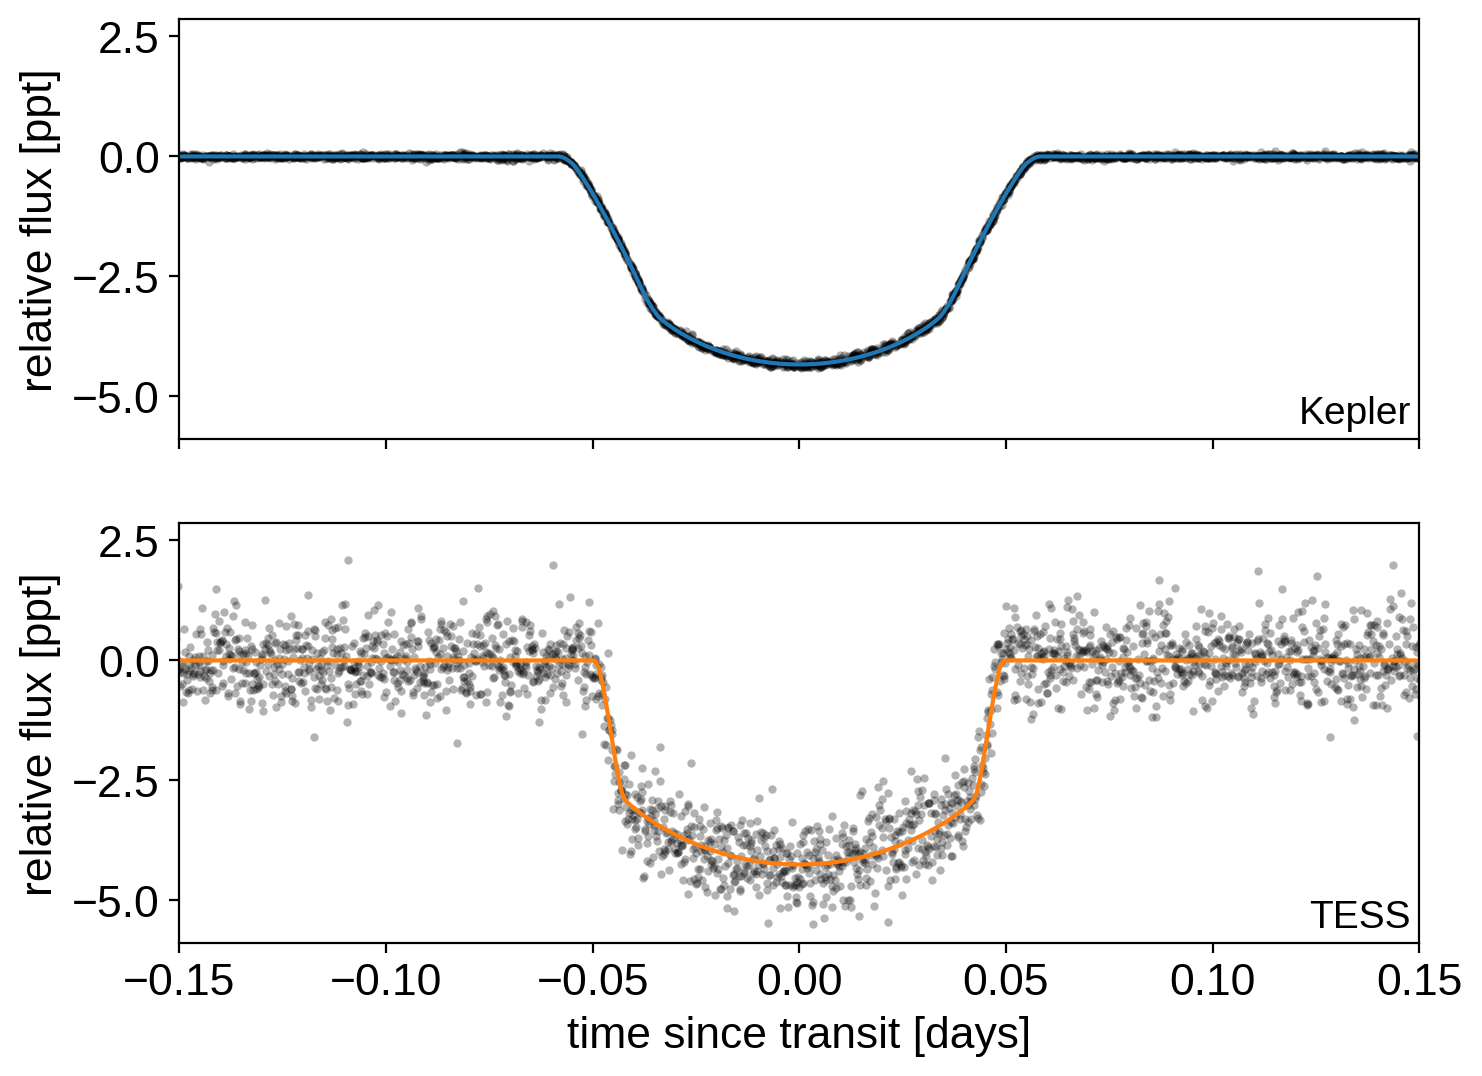

In [7]:
dt = np.linspace(-0.2, 0.2, 500)

with model:
    trends = xo.eval_in_model([gp_preds[k] for k in datasets], map_soln)
    phase_curves = xo.eval_in_model([lc_models[k](t0 + dt) for k in datasets], map_soln)

fig, axes = plt.subplots(2, sharex=True, sharey=True, figsize=(8, 6))

for n, name in enumerate(datasets):
    ax = axes[n]

    x, y = datasets[name][:2]

    period = map_soln["period"]
    folded = (x - map_soln["t0"] + 0.5 * period) % period - 0.5 * period
    m = np.abs(folded) < 0.2
    ax.plot(
        folded[m],
        (y - trends[n] - map_soln[f"{name}_mean"])[m],
        ".k",
        alpha=0.3,
        mec="none",
    )
    ax.plot(dt, phase_curves[n] - map_soln[f"{name}_mean"], f"C{n}", label=name)
    ax.annotate(
        name,
        xy=(1, 0),
        xycoords="axes fraction",
        va="bottom",
        ha="right",
        xytext=(-3, 3),
        textcoords="offset points",
        fontsize=14,
    )

axes[-1].set_xlim(-0.15, 0.15)
axes[-1].set_xlabel("time since transit [days]")
for ax in axes:
    ax.set_ylabel("relative flux [ppt]")

In [8]:
np.random.seed(11)
with model:
    trace = xo.sample(
        tune=3500, draws=3000, start=map_soln, chains=4, initial_accept=0.5
    )

Multiprocess sampling (4 chains in 4 jobs)


NUTS: [TESS_S_tot, TESS_sigma, TESS_approx_depth, TESS_u, TESS_mean, Kepler_S_tot, Kepler_sigma, Kepler_approx_depth, Kepler_u, Kepler_mean, ell, b, dur, t0, period]


Sampling 4 chains, 0 divergences:   0%|          | 0/26000 [00:00<?, ?draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 4/26000 [00:00<10:53, 39.75draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 9/26000 [00:00<11:13, 38.59draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 16/26000 [00:00<10:04, 42.99draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 21/26000 [00:00<10:07, 42.79draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 28/26000 [00:00<10:00, 43.24draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 34/26000 [00:00<09:12, 46.99draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 39/26000 [00:00<09:31, 45.43draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 44/26000 [00:01<11:53, 36.40draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 48/26000 [00:11<5:43:40,  1.26draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 51/26000 [00:11<4:07:08,  1.75draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 53/26000 [00:11<3:07:50,  2.30draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 54/26000 [00:21<23:24:42,  3.25s/draws]

Sampling 4 chains, 0 divergences:   0%|          | 56/26000 [00:21<16:32:47,  2.30s/draws]

Sampling 4 chains, 0 divergences:   0%|          | 58/26000 [00:21<11:43:19,  1.63s/draws]

Sampling 4 chains, 0 divergences:   0%|          | 59/26000 [00:21<8:27:33,  1.17s/draws] 

Sampling 4 chains, 0 divergences:   0%|          | 60/26000 [00:22<6:09:38,  1.17draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 62/26000 [00:22<4:36:49,  1.56draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 63/26000 [00:31<23:27:22,  3.26s/draws]

Sampling 4 chains, 0 divergences:   0%|          | 65/26000 [00:31<16:37:41,  2.31s/draws]

Sampling 4 chains, 0 divergences:   0%|          | 67/26000 [00:32<11:51:31,  1.65s/draws]

Sampling 4 chains, 0 divergences:   0%|          | 68/26000 [00:32<8:33:25,  1.19s/draws] 

Sampling 4 chains, 0 divergences:   0%|          | 70/26000 [00:41<16:31:09,  2.29s/draws]

Sampling 4 chains, 0 divergences:   0%|          | 71/26000 [00:42<11:48:29,  1.64s/draws]

Sampling 4 chains, 0 divergences:   0%|          | 73/26000 [00:42<8:25:34,  1.17s/draws] 

Sampling 4 chains, 0 divergences:   0%|          | 75/26000 [00:42<6:05:46,  1.18draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 78/26000 [00:42<4:23:55,  1.64draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 80/26000 [00:52<13:26:44,  1.87s/draws]

Sampling 4 chains, 0 divergences:   0%|          | 82/26000 [00:52<9:50:09,  1.37s/draws] 

Sampling 4 chains, 0 divergences:   0%|          | 84/26000 [00:52<7:05:53,  1.01draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 85/26000 [00:53<5:43:00,  1.26draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 86/26000 [01:02<23:33:24,  3.27s/draws]

Sampling 4 chains, 0 divergences:   0%|          | 87/26000 [01:02<16:44:43,  2.33s/draws]

Sampling 4 chains, 0 divergences:   0%|          | 88/26000 [01:02<12:05:05,  1.68s/draws]

Sampling 4 chains, 0 divergences:   0%|          | 89/26000 [01:02<8:43:06,  1.21s/draws] 

Sampling 4 chains, 0 divergences:   0%|          | 90/26000 [01:02<6:51:53,  1.05draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 91/26000 [01:03<6:54:17,  1.04draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 92/26000 [01:04<5:10:30,  1.39draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 93/26000 [01:04<3:57:31,  1.82draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 94/26000 [01:04<3:17:56,  2.18draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 95/26000 [01:12<19:00:03,  2.64s/draws]

Sampling 4 chains, 0 divergences:   0%|          | 96/26000 [01:12<13:32:32,  1.88s/draws]

Sampling 4 chains, 0 divergences:   0%|          | 97/26000 [01:12<10:26:20,  1.45s/draws]

Sampling 4 chains, 0 divergences:   0%|          | 98/26000 [01:12<7:38:45,  1.06s/draws] 

Sampling 4 chains, 0 divergences:   0%|          | 99/26000 [01:13<5:37:50,  1.28draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 100/26000 [01:13<4:15:18,  1.69draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 101/26000 [01:14<6:17:07,  1.14draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 102/26000 [01:14<4:39:09,  1.55draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 103/26000 [01:22<19:20:49,  2.69s/draws]

Sampling 4 chains, 0 divergences:   0%|          | 104/26000 [01:22<13:47:18,  1.92s/draws]

Sampling 4 chains, 0 divergences:   0%|          | 105/26000 [01:23<11:14:54,  1.56s/draws]

Sampling 4 chains, 0 divergences:   0%|          | 106/26000 [01:23<8:07:33,  1.13s/draws] 

Sampling 4 chains, 0 divergences:   0%|          | 107/26000 [01:23<6:27:40,  1.11draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 108/26000 [01:25<7:57:23,  1.11s/draws]

Sampling 4 chains, 0 divergences:   0%|          | 109/26000 [01:25<5:49:40,  1.23draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 110/26000 [01:32<19:59:57,  2.78s/draws]

Sampling 4 chains, 0 divergences:   0%|          | 111/26000 [01:32<14:18:50,  1.99s/draws]

Sampling 4 chains, 0 divergences:   0%|          | 112/26000 [01:33<10:43:42,  1.49s/draws]

Sampling 4 chains, 0 divergences:   0%|          | 113/26000 [01:33<8:10:50,  1.14s/draws] 

Sampling 4 chains, 0 divergences:   0%|          | 115/26000 [01:35<7:31:14,  1.05s/draws]

Sampling 4 chains, 0 divergences:   0%|          | 116/26000 [01:35<5:40:04,  1.27draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 117/26000 [01:42<20:15:04,  2.82s/draws]

Sampling 4 chains, 0 divergences:   0%|          | 118/26000 [01:43<14:30:11,  2.02s/draws]

Sampling 4 chains, 0 divergences:   0%|          | 119/26000 [01:43<10:34:17,  1.47s/draws]

Sampling 4 chains, 0 divergences:   0%|          | 120/26000 [01:43<7:37:09,  1.06s/draws] 

Sampling 4 chains, 0 divergences:   0%|          | 121/26000 [01:43<6:22:13,  1.13draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 122/26000 [01:44<4:51:33,  1.48draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 123/26000 [01:44<3:44:57,  1.92draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 124/26000 [01:45<5:49:07,  1.24draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 126/26000 [01:53<12:39:24,  1.76s/draws]

Sampling 4 chains, 0 divergences:   0%|          | 127/26000 [01:54<10:30:49,  1.46s/draws]

Sampling 4 chains, 0 divergences:   0%|          | 128/26000 [01:54<7:36:18,  1.06s/draws] 

Sampling 4 chains, 0 divergences:   0%|          | 129/26000 [01:54<6:06:16,  1.18draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 130/26000 [01:55<6:06:40,  1.18draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 131/26000 [02:03<20:57:29,  2.92s/draws]

Sampling 4 chains, 0 divergences:   1%|          | 133/26000 [02:04<16:07:12,  2.24s/draws]

Sampling 4 chains, 0 divergences:   1%|          | 134/26000 [02:05<12:23:50,  1.73s/draws]

Sampling 4 chains, 0 divergences:   1%|          | 135/26000 [02:05<9:18:21,  1.30s/draws] 

Sampling 4 chains, 0 divergences:   1%|          | 136/26000 [02:13<24:03:16,  3.35s/draws]

Sampling 4 chains, 0 divergences:   1%|          | 137/26000 [02:13<17:10:42,  2.39s/draws]

Sampling 4 chains, 0 divergences:   1%|          | 138/26000 [02:15<14:37:58,  2.04s/draws]

Sampling 4 chains, 0 divergences:   1%|          | 139/26000 [02:15<10:34:40,  1.47s/draws]

Sampling 4 chains, 0 divergences:   1%|          | 140/26000 [02:15<8:06:46,  1.13s/draws] 

Sampling 4 chains, 0 divergences:   1%|          | 141/26000 [02:15<6:01:10,  1.19draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 143/26000 [02:16<4:28:12,  1.61draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 144/26000 [02:24<20:23:23,  2.84s/draws]

Sampling 4 chains, 0 divergences:   1%|          | 145/26000 [02:24<14:30:42,  2.02s/draws]

Sampling 4 chains, 0 divergences:   1%|          | 146/26000 [02:25<12:33:40,  1.75s/draws]

Sampling 4 chains, 0 divergences:   1%|          | 147/26000 [02:25<9:01:52,  1.26s/draws] 

Sampling 4 chains, 0 divergences:   1%|          | 148/26000 [02:25<7:05:29,  1.01draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 149/26000 [02:25<5:28:12,  1.31draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 150/26000 [02:26<4:08:48,  1.73draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 151/26000 [02:34<20:01:24,  2.79s/draws]

Sampling 4 chains, 0 divergences:   1%|          | 152/26000 [02:34<14:20:04,  2.00s/draws]

Sampling 4 chains, 0 divergences:   1%|          | 153/26000 [02:35<12:24:39,  1.73s/draws]

Sampling 4 chains, 0 divergences:   1%|          | 154/26000 [02:35<8:56:08,  1.24s/draws] 

Sampling 4 chains, 0 divergences:   1%|          | 155/26000 [02:35<6:54:52,  1.04draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 156/26000 [02:35<5:09:14,  1.39draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 157/26000 [02:36<4:18:01,  1.67draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 158/26000 [02:36<3:15:37,  2.20draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 159/26000 [02:44<19:49:36,  2.76s/draws]

Sampling 4 chains, 0 divergences:   1%|          | 160/26000 [02:44<14:16:26,  1.99s/draws]

Sampling 4 chains, 0 divergences:   1%|          | 161/26000 [02:44<10:37:24,  1.48s/draws]

Sampling 4 chains, 0 divergences:   1%|          | 162/26000 [02:45<8:27:40,  1.18s/draws] 

Sampling 4 chains, 0 divergences:   1%|          | 164/26000 [02:45<6:28:54,  1.11draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 165/26000 [02:46<5:02:17,  1.42draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 167/26000 [02:46<3:43:34,  1.93draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 168/26000 [02:54<21:11:18,  2.95s/draws]

Sampling 4 chains, 0 divergences:   1%|          | 169/26000 [02:55<15:09:44,  2.11s/draws]

Sampling 4 chains, 0 divergences:   1%|          | 170/26000 [02:55<11:06:53,  1.55s/draws]

Sampling 4 chains, 0 divergences:   1%|          | 171/26000 [02:55<8:22:12,  1.17s/draws] 

Sampling 4 chains, 0 divergences:   1%|          | 172/26000 [02:55<6:10:27,  1.16draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 173/26000 [02:56<5:59:32,  1.20draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 175/26000 [02:56<4:24:05,  1.63draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 176/26000 [02:57<3:45:21,  1.91draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 177/26000 [03:05<20:58:51,  2.92s/draws]

Sampling 4 chains, 0 divergences:   1%|          | 178/26000 [03:05<14:56:10,  2.08s/draws]

Sampling 4 chains, 0 divergences:   1%|          | 179/26000 [03:06<11:11:21,  1.56s/draws]

Sampling 4 chains, 0 divergences:   1%|          | 181/26000 [03:07<8:52:10,  1.24s/draws] 

Sampling 4 chains, 0 divergences:   1%|          | 183/26000 [03:07<6:26:20,  1.11draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 184/26000 [03:07<4:49:51,  1.48draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 185/26000 [03:15<21:02:49,  2.94s/draws]

Sampling 4 chains, 0 divergences:   1%|          | 186/26000 [03:15<15:03:04,  2.10s/draws]

Sampling 4 chains, 0 divergences:   1%|          | 187/26000 [03:16<11:48:48,  1.65s/draws]

Sampling 4 chains, 0 divergences:   1%|          | 188/26000 [03:16<8:36:27,  1.20s/draws] 

Sampling 4 chains, 0 divergences:   1%|          | 189/26000 [03:17<7:13:00,  1.01s/draws]

Sampling 4 chains, 0 divergences:   1%|          | 190/26000 [03:17<6:59:45,  1.02draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 191/26000 [03:18<5:08:13,  1.40draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 192/26000 [03:25<19:20:38,  2.70s/draws]

Sampling 4 chains, 0 divergences:   1%|          | 193/26000 [03:25<13:51:31,  1.93s/draws]

Sampling 4 chains, 0 divergences:   1%|          | 195/26000 [03:26<10:17:46,  1.44s/draws]

Sampling 4 chains, 0 divergences:   1%|          | 196/26000 [03:26<7:26:43,  1.04s/draws] 

Sampling 4 chains, 0 divergences:   1%|          | 197/26000 [03:26<5:55:29,  1.21draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 199/26000 [03:27<5:15:33,  1.36draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 200/26000 [03:27<4:01:31,  1.78draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 202/26000 [03:35<11:15:10,  1.57s/draws]

Sampling 4 chains, 0 divergences:   1%|          | 203/26000 [03:36<9:53:54,  1.38s/draws] 

Sampling 4 chains, 0 divergences:   1%|          | 206/26000 [03:36<7:02:13,  1.02draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 207/26000 [03:38<7:59:19,  1.12s/draws]

Sampling 4 chains, 0 divergences:   1%|          | 208/26000 [03:45<22:19:24,  3.12s/draws]

Sampling 4 chains, 0 divergences:   1%|          | 209/26000 [03:46<15:58:52,  2.23s/draws]

Sampling 4 chains, 0 divergences:   1%|          | 210/26000 [03:46<12:37:08,  1.76s/draws]

Sampling 4 chains, 0 divergences:   1%|          | 211/26000 [03:46<9:04:18,  1.27s/draws] 

Sampling 4 chains, 0 divergences:   1%|          | 214/26000 [03:47<7:10:37,  1.00s/draws]

Sampling 4 chains, 0 divergences:   1%|          | 215/26000 [03:48<5:16:37,  1.36draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 216/26000 [03:55<20:33:45,  2.87s/draws]

Sampling 4 chains, 0 divergences:   1%|          | 217/26000 [03:56<14:42:45,  2.05s/draws]

Sampling 4 chains, 0 divergences:   1%|          | 218/26000 [03:57<12:43:02,  1.78s/draws]

Sampling 4 chains, 0 divergences:   1%|          | 219/26000 [03:57<9:19:15,  1.30s/draws] 

Sampling 4 chains, 0 divergences:   1%|          | 221/26000 [03:58<7:17:31,  1.02s/draws]

Sampling 4 chains, 0 divergences:   1%|          | 222/26000 [03:58<5:25:04,  1.32draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 223/26000 [04:06<20:23:07,  2.85s/draws]

Sampling 4 chains, 0 divergences:   1%|          | 224/26000 [04:06<14:35:48,  2.04s/draws]

Sampling 4 chains, 0 divergences:   1%|          | 225/26000 [04:07<12:24:26,  1.73s/draws]

Sampling 4 chains, 0 divergences:   1%|          | 226/26000 [04:07<8:57:34,  1.25s/draws] 

Sampling 4 chains, 0 divergences:   1%|          | 227/26000 [04:07<6:42:40,  1.07draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 228/26000 [04:08<6:28:38,  1.11draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 229/26000 [04:08<4:46:40,  1.50draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 230/26000 [04:16<20:48:20,  2.91s/draws]

Sampling 4 chains, 0 divergences:   1%|          | 231/26000 [04:16<14:57:49,  2.09s/draws]

Sampling 4 chains, 0 divergences:   1%|          | 232/26000 [04:17<12:06:30,  1.69s/draws]

Sampling 4 chains, 0 divergences:   1%|          | 234/26000 [04:17<8:36:21,  1.20s/draws] 

Sampling 4 chains, 0 divergences:   1%|          | 236/26000 [04:18<6:51:43,  1.04draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 237/26000 [04:18<5:09:17,  1.39draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 238/26000 [04:27<22:24:17,  3.13s/draws]

Sampling 4 chains, 0 divergences:   1%|          | 240/26000 [04:27<16:02:59,  2.24s/draws]

Sampling 4 chains, 0 divergences:   1%|          | 241/26000 [04:27<11:35:12,  1.62s/draws]

Sampling 4 chains, 0 divergences:   1%|          | 242/26000 [04:28<8:35:42,  1.20s/draws] 

Sampling 4 chains, 0 divergences:   1%|          | 243/26000 [04:28<6:20:57,  1.13draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 244/26000 [04:29<6:53:07,  1.04draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 245/26000 [04:29<5:09:30,  1.39draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 246/26000 [04:38<21:49:48,  3.05s/draws]

Sampling 4 chains, 0 divergences:   1%|          | 248/26000 [04:38<15:28:14,  2.16s/draws]

Sampling 4 chains, 0 divergences:   1%|          | 250/26000 [04:38<11:01:34,  1.54s/draws]

Sampling 4 chains, 0 divergences:   1%|          | 251/26000 [04:38<8:02:37,  1.12s/draws] 

Sampling 4 chains, 0 divergences:   1%|          | 252/26000 [04:39<7:50:35,  1.10s/draws]

Sampling 4 chains, 0 divergences:   1%|          | 253/26000 [04:39<5:48:44,  1.23draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 254/26000 [04:48<22:46:31,  3.18s/draws]

Sampling 4 chains, 0 divergences:   1%|          | 255/26000 [04:48<16:15:26,  2.27s/draws]

Sampling 4 chains, 0 divergences:   1%|          | 257/26000 [04:48<11:33:02,  1.62s/draws]

Sampling 4 chains, 0 divergences:   1%|          | 259/26000 [04:48<8:14:33,  1.15s/draws] 

Sampling 4 chains, 0 divergences:   1%|          | 260/26000 [04:49<8:05:50,  1.13s/draws]

Sampling 4 chains, 0 divergences:   1%|          | 261/26000 [04:50<6:00:50,  1.19draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 262/26000 [04:59<23:56:51,  3.35s/draws]

Sampling 4 chains, 0 divergences:   1%|          | 263/26000 [04:59<17:05:34,  2.39s/draws]

Sampling 4 chains, 0 divergences:   1%|          | 264/26000 [04:59<12:39:57,  1.77s/draws]

Sampling 4 chains, 0 divergences:   1%|          | 266/26000 [04:59<9:00:09,  1.26s/draws] 

Sampling 4 chains, 0 divergences:   1%|          | 268/26000 [05:00<7:06:44,  1.00draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 269/26000 [05:00<5:30:40,  1.30draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 270/26000 [05:10<24:29:47,  3.43s/draws]

Sampling 4 chains, 0 divergences:   1%|          | 271/26000 [05:10<17:24:49,  2.44s/draws]

Sampling 4 chains, 0 divergences:   1%|          | 273/26000 [05:10<12:26:13,  1.74s/draws]

Sampling 4 chains, 0 divergences:   1%|          | 274/26000 [05:11<8:58:00,  1.25s/draws] 

Sampling 4 chains, 0 divergences:   1%|          | 275/26000 [05:11<6:36:04,  1.08draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 276/26000 [05:12<7:33:38,  1.06s/draws]

Sampling 4 chains, 0 divergences:   1%|          | 277/26000 [05:12<5:38:23,  1.27draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 278/26000 [05:21<22:29:14,  3.15s/draws]

Sampling 4 chains, 0 divergences:   1%|          | 279/26000 [05:21<16:06:30,  2.25s/draws]

Sampling 4 chains, 0 divergences:   1%|          | 280/26000 [05:21<12:05:32,  1.69s/draws]

Sampling 4 chains, 0 divergences:   1%|          | 281/26000 [05:22<8:57:15,  1.25s/draws] 

Sampling 4 chains, 0 divergences:   1%|          | 282/26000 [05:22<6:37:41,  1.08draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 283/26000 [05:22<5:55:30,  1.21draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 284/26000 [05:23<4:46:16,  1.50draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 285/26000 [05:23<3:41:17,  1.94draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 286/26000 [05:33<23:12:59,  3.25s/draws]

Sampling 4 chains, 0 divergences:   1%|          | 287/26000 [05:33<16:34:26,  2.32s/draws]

Sampling 4 chains, 0 divergences:   1%|          | 289/26000 [05:33<11:46:12,  1.65s/draws]

Sampling 4 chains, 0 divergences:   1%|          | 290/26000 [05:33<9:16:17,  1.30s/draws] 

Sampling 4 chains, 0 divergences:   1%|          | 291/26000 [05:33<6:49:27,  1.05draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 292/26000 [05:34<5:50:00,  1.22draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 293/26000 [05:34<4:35:36,  1.55draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 294/26000 [05:43<22:43:44,  3.18s/draws]

Sampling 4 chains, 0 divergences:   1%|          | 295/26000 [05:43<16:16:22,  2.28s/draws]

Sampling 4 chains, 0 divergences:   1%|          | 296/26000 [05:44<11:37:59,  1.63s/draws]

Sampling 4 chains, 0 divergences:   1%|          | 297/26000 [05:44<8:27:38,  1.19s/draws] 

Sampling 4 chains, 0 divergences:   1%|          | 298/26000 [05:45<7:53:03,  1.10s/draws]

Sampling 4 chains, 0 divergences:   1%|          | 299/26000 [05:45<5:46:25,  1.24draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 300/26000 [05:46<5:33:35,  1.28draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 301/26000 [05:46<4:19:12,  1.65draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 302/26000 [05:46<3:20:35,  2.14draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 303/26000 [05:55<20:55:55,  2.93s/draws]

Sampling 4 chains, 0 divergences:   1%|          | 304/26000 [05:55<14:58:30,  2.10s/draws]

Sampling 4 chains, 0 divergences:   1%|          | 305/26000 [05:55<11:07:03,  1.56s/draws]

Sampling 4 chains, 0 divergences:   1%|          | 306/26000 [05:55<8:07:39,  1.14s/draws] 

Sampling 4 chains, 0 divergences:   1%|          | 307/26000 [05:56<8:05:44,  1.13s/draws]

Sampling 4 chains, 0 divergences:   1%|          | 308/26000 [05:56<5:59:36,  1.19draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 309/26000 [05:57<5:11:13,  1.38draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 311/26000 [06:06<13:21:04,  1.87s/draws]

Sampling 4 chains, 0 divergences:   1%|          | 313/26000 [06:06<9:31:12,  1.33s/draws] 

Sampling 4 chains, 0 divergences:   1%|          | 315/26000 [06:07<7:44:34,  1.09s/draws]

Sampling 4 chains, 0 divergences:   1%|          | 316/26000 [06:07<5:46:41,  1.23draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 317/26000 [06:08<5:26:26,  1.31draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 318/26000 [06:08<4:09:09,  1.72draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 319/26000 [06:17<21:48:38,  3.06s/draws]

Sampling 4 chains, 0 divergences:   1%|          | 320/26000 [06:17<15:41:53,  2.20s/draws]

Sampling 4 chains, 0 divergences:   1%|          | 322/26000 [06:17<11:13:05,  1.57s/draws]

Sampling 4 chains, 0 divergences:   1%|          | 323/26000 [06:18<9:22:23,  1.31s/draws] 

Sampling 4 chains, 0 divergences:   1%|          | 324/26000 [06:18<7:16:41,  1.02s/draws]

Sampling 4 chains, 0 divergences:   1%|▏         | 325/26000 [06:19<5:55:54,  1.20draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 326/26000 [06:19<4:34:55,  1.56draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 327/26000 [06:28<22:22:06,  3.14s/draws]

Sampling 4 chains, 0 divergences:   1%|▏         | 329/26000 [06:28<15:53:52,  2.23s/draws]

Sampling 4 chains, 0 divergences:   1%|▏         | 331/26000 [06:29<12:26:38,  1.75s/draws]

Sampling 4 chains, 0 divergences:   1%|▏         | 332/26000 [06:30<10:37:22,  1.49s/draws]

Sampling 4 chains, 0 divergences:   1%|▏         | 334/26000 [06:39<16:19:55,  2.29s/draws]

Sampling 4 chains, 0 divergences:   1%|▏         | 335/26000 [06:40<13:38:59,  1.91s/draws]

Sampling 4 chains, 0 divergences:   1%|▏         | 336/26000 [06:40<10:50:40,  1.52s/draws]

Sampling 4 chains, 0 divergences:   1%|▏         | 337/26000 [06:41<9:26:13,  1.32s/draws] 

Sampling 4 chains, 0 divergences:   1%|▏         | 338/26000 [06:41<6:56:09,  1.03draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 339/26000 [06:50<22:37:03,  3.17s/draws]

Sampling 4 chains, 0 divergences:   1%|▏         | 340/26000 [06:51<18:29:11,  2.59s/draws]

Sampling 4 chains, 0 divergences:   1%|▏         | 341/26000 [06:51<13:16:21,  1.86s/draws]

Sampling 4 chains, 0 divergences:   1%|▏         | 343/26000 [06:51<9:34:18,  1.34s/draws] 

Sampling 4 chains, 0 divergences:   1%|▏         | 344/26000 [06:52<9:05:55,  1.28s/draws]

Sampling 4 chains, 0 divergences:   1%|▏         | 345/26000 [06:53<6:42:13,  1.06draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 346/26000 [07:00<21:41:33,  3.04s/draws]

Sampling 4 chains, 0 divergences:   1%|▏         | 348/26000 [07:02<16:36:40,  2.33s/draws]

Sampling 4 chains, 0 divergences:   1%|▏         | 349/26000 [07:02<11:57:15,  1.68s/draws]

Sampling 4 chains, 0 divergences:   1%|▏         | 350/26000 [07:02<8:54:03,  1.25s/draws] 

Sampling 4 chains, 0 divergences:   1%|▏         | 351/26000 [07:02<6:35:20,  1.08draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 352/26000 [07:03<6:10:41,  1.15draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 353/26000 [07:03<4:51:17,  1.47draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 354/26000 [07:12<21:00:49,  2.95s/draws]

Sampling 4 chains, 0 divergences:   1%|▏         | 355/26000 [07:12<15:03:44,  2.11s/draws]

Sampling 4 chains, 0 divergences:   1%|▏         | 356/26000 [07:13<13:23:24,  1.88s/draws]

Sampling 4 chains, 0 divergences:   1%|▏         | 357/26000 [07:13<9:41:18,  1.36s/draws] 

Sampling 4 chains, 0 divergences:   1%|▏         | 358/26000 [07:13<7:07:06,  1.00draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 359/26000 [07:14<5:15:59,  1.35draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 360/26000 [07:15<5:48:51,  1.22draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 361/26000 [07:15<4:29:47,  1.58draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 362/26000 [07:22<19:29:41,  2.74s/draws]

Sampling 4 chains, 0 divergences:   1%|▏         | 363/26000 [07:23<14:00:30,  1.97s/draws]

Sampling 4 chains, 0 divergences:   1%|▏         | 364/26000 [07:24<13:15:14,  1.86s/draws]

Sampling 4 chains, 0 divergences:   1%|▏         | 365/26000 [07:24<9:45:54,  1.37s/draws] 

Sampling 4 chains, 0 divergences:   1%|▏         | 366/26000 [07:25<7:41:58,  1.08s/draws]

Sampling 4 chains, 0 divergences:   1%|▏         | 367/26000 [07:25<6:06:40,  1.17draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 368/26000 [07:25<4:55:47,  1.44draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 369/26000 [07:26<3:47:28,  1.88draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 370/26000 [07:33<18:42:14,  2.63s/draws]

Sampling 4 chains, 0 divergences:   1%|▏         | 371/26000 [07:33<13:39:35,  1.92s/draws]

Sampling 4 chains, 0 divergences:   1%|▏         | 372/26000 [07:35<13:45:39,  1.93s/draws]

Sampling 4 chains, 0 divergences:   1%|▏         | 373/26000 [07:36<10:00:38,  1.41s/draws]

Sampling 4 chains, 0 divergences:   1%|▏         | 374/26000 [07:36<8:14:21,  1.16s/draws] 

Sampling 4 chains, 0 divergences:   1%|▏         | 375/26000 [07:36<6:34:30,  1.08draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 376/26000 [07:37<4:59:50,  1.42draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 377/26000 [07:44<19:42:38,  2.77s/draws]

Sampling 4 chains, 0 divergences:   1%|▏         | 378/26000 [07:45<15:06:03,  2.12s/draws]

Sampling 4 chains, 0 divergences:   1%|▏         | 379/26000 [07:46<13:41:03,  1.92s/draws]

Sampling 4 chains, 0 divergences:   1%|▏         | 380/26000 [07:47<9:56:24,  1.40s/draws] 

Sampling 4 chains, 0 divergences:   1%|▏         | 381/26000 [07:47<7:57:11,  1.12s/draws]

Sampling 4 chains, 0 divergences:   1%|▏         | 382/26000 [07:47<5:53:54,  1.21draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 383/26000 [07:48<5:44:38,  1.24draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 384/26000 [07:48<4:30:26,  1.58draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 385/26000 [07:56<19:13:31,  2.70s/draws]

Sampling 4 chains, 0 divergences:   1%|▏         | 386/26000 [07:58<17:27:21,  2.45s/draws]

Sampling 4 chains, 0 divergences:   1%|▏         | 387/26000 [07:58<13:04:15,  1.84s/draws]

Sampling 4 chains, 0 divergences:   1%|▏         | 388/26000 [07:58<9:31:28,  1.34s/draws] 

Sampling 4 chains, 0 divergences:   1%|▏         | 389/26000 [07:58<7:06:11,  1.00draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 390/26000 [07:59<6:16:45,  1.13draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 391/26000 [08:07<20:39:10,  2.90s/draws]

Sampling 4 chains, 0 divergences:   2%|▏         | 392/26000 [08:09<19:32:55,  2.75s/draws]

Sampling 4 chains, 0 divergences:   2%|▏         | 393/26000 [08:09<14:25:21,  2.03s/draws]

Sampling 4 chains, 0 divergences:   2%|▏         | 394/26000 [08:09<10:27:18,  1.47s/draws]

Sampling 4 chains, 0 divergences:   2%|▏         | 395/26000 [08:10<8:36:07,  1.21s/draws] 

Sampling 4 chains, 0 divergences:   2%|▏         | 397/26000 [08:17<13:56:49,  1.96s/draws]

Sampling 4 chains, 0 divergences:   2%|▏         | 399/26000 [08:20<12:11:46,  1.72s/draws]

Sampling 4 chains, 0 divergences:   2%|▏         | 400/26000 [08:20<8:56:57,  1.26s/draws] 

Sampling 4 chains, 0 divergences:   2%|▏         | 401/26000 [08:20<6:34:09,  1.08draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 402/26000 [08:21<5:50:04,  1.22draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 403/26000 [08:28<20:33:38,  2.89s/draws]

Sampling 4 chains, 0 divergences:   2%|▏         | 404/26000 [08:29<14:42:44,  2.07s/draws]

Sampling 4 chains, 0 divergences:   2%|▏         | 405/26000 [08:31<14:38:36,  2.06s/draws]

Sampling 4 chains, 0 divergences:   2%|▏         | 407/26000 [08:31<10:25:22,  1.47s/draws]

Sampling 4 chains, 0 divergences:   2%|▏         | 408/26000 [08:31<7:34:21,  1.07s/draws] 

Sampling 4 chains, 0 divergences:   2%|▏         | 409/26000 [08:31<6:05:38,  1.17draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 410/26000 [08:31<4:36:59,  1.54draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 411/26000 [08:32<4:43:38,  1.50draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 412/26000 [08:39<17:59:07,  2.53s/draws]

Sampling 4 chains, 0 divergences:   2%|▏         | 413/26000 [08:39<12:49:31,  1.80s/draws]

Sampling 4 chains, 0 divergences:   2%|▏         | 414/26000 [08:42<14:34:00,  2.05s/draws]

Sampling 4 chains, 0 divergences:   2%|▏         | 416/26000 [08:43<11:27:08,  1.61s/draws]

Sampling 4 chains, 0 divergences:   2%|▏         | 417/26000 [08:47<17:28:58,  2.46s/draws]

Sampling 4 chains, 0 divergences:   2%|▏         | 418/26000 [08:48<12:35:37,  1.77s/draws]

Sampling 4 chains, 0 divergences:   2%|▏         | 419/26000 [08:50<14:34:27,  2.05s/draws]

Sampling 4 chains, 0 divergences:   2%|▏         | 420/26000 [08:52<14:33:21,  2.05s/draws]

Sampling 4 chains, 0 divergences:   2%|▏         | 421/26000 [08:54<14:06:24,  1.99s/draws]

Sampling 4 chains, 0 divergences:   2%|▏         | 423/26000 [08:57<13:29:54,  1.90s/draws]

Sampling 4 chains, 0 divergences:   2%|▏         | 424/26000 [08:58<11:01:56,  1.55s/draws]

Sampling 4 chains, 0 divergences:   2%|▏         | 425/26000 [09:01<13:29:50,  1.90s/draws]

Sampling 4 chains, 0 divergences:   2%|▏         | 426/26000 [09:03<13:38:08,  1.92s/draws]

Sampling 4 chains, 0 divergences:   2%|▏         | 427/26000 [09:08<20:48:58,  2.93s/draws]

Sampling 4 chains, 0 divergences:   2%|▏         | 428/26000 [09:08<14:55:30,  2.10s/draws]

Sampling 4 chains, 0 divergences:   2%|▏         | 429/26000 [09:09<11:54:59,  1.68s/draws]

Sampling 4 chains, 0 divergences:   2%|▏         | 430/26000 [09:11<13:09:43,  1.85s/draws]

Sampling 4 chains, 0 divergences:   2%|▏         | 431/26000 [09:14<14:24:51,  2.03s/draws]

Sampling 4 chains, 0 divergences:   2%|▏         | 432/26000 [09:15<13:08:40,  1.85s/draws]

Sampling 4 chains, 0 divergences:   2%|▏         | 433/26000 [09:15<9:38:06,  1.36s/draws] 

Sampling 4 chains, 0 divergences:   2%|▏         | 434/26000 [09:20<16:01:43,  2.26s/draws]

Sampling 4 chains, 0 divergences:   2%|▏         | 435/26000 [09:20<11:51:15,  1.67s/draws]

Sampling 4 chains, 0 divergences:   2%|▏         | 436/26000 [09:20<8:41:02,  1.22s/draws] 

Sampling 4 chains, 0 divergences:   2%|▏         | 437/26000 [09:22<9:38:02,  1.36s/draws]

Sampling 4 chains, 0 divergences:   2%|▏         | 439/26000 [09:27<11:41:06,  1.65s/draws]

Sampling 4 chains, 0 divergences:   2%|▏         | 440/26000 [09:29<14:22:20,  2.02s/draws]

Sampling 4 chains, 0 divergences:   2%|▏         | 441/26000 [09:30<11:29:51,  1.62s/draws]

Sampling 4 chains, 0 divergences:   2%|▏         | 442/26000 [09:31<9:27:12,  1.33s/draws] 

Sampling 4 chains, 0 divergences:   2%|▏         | 443/26000 [09:31<7:19:09,  1.03s/draws]

Sampling 4 chains, 0 divergences:   2%|▏         | 444/26000 [09:31<5:37:49,  1.26draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 445/26000 [09:33<7:27:12,  1.05s/draws]

Sampling 4 chains, 0 divergences:   2%|▏         | 446/26000 [09:36<12:09:29,  1.71s/draws]

Sampling 4 chains, 0 divergences:   2%|▏         | 447/26000 [09:37<9:21:47,  1.32s/draws] 

Sampling 4 chains, 0 divergences:   2%|▏         | 448/26000 [09:39<12:12:46,  1.72s/draws]

Sampling 4 chains, 0 divergences:   2%|▏         | 449/26000 [09:40<8:59:06,  1.27s/draws] 

Sampling 4 chains, 0 divergences:   2%|▏         | 450/26000 [09:42<11:15:11,  1.59s/draws]

Sampling 4 chains, 0 divergences:   2%|▏         | 451/26000 [09:44<11:54:37,  1.68s/draws]

Sampling 4 chains, 0 divergences:   2%|▏         | 452/26000 [09:44<8:35:38,  1.21s/draws] 

Sampling 4 chains, 0 divergences:   2%|▏         | 453/26000 [09:47<12:55:17,  1.82s/draws]

Sampling 4 chains, 0 divergences:   2%|▏         | 454/26000 [09:48<11:23:35,  1.61s/draws]

Sampling 4 chains, 0 divergences:   2%|▏         | 455/26000 [09:51<13:09:41,  1.85s/draws]

Sampling 4 chains, 0 divergences:   2%|▏         | 456/26000 [09:51<9:43:43,  1.37s/draws] 

Sampling 4 chains, 0 divergences:   2%|▏         | 457/26000 [09:52<8:57:04,  1.26s/draws]

Sampling 4 chains, 0 divergences:   2%|▏         | 458/26000 [09:52<6:35:27,  1.08draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 459/26000 [09:52<5:26:06,  1.31draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 460/26000 [09:53<4:21:28,  1.63draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 462/26000 [09:57<7:27:21,  1.05s/draws]

Sampling 4 chains, 0 divergences:   2%|▏         | 463/26000 [09:57<5:37:49,  1.26draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 464/26000 [09:59<8:02:02,  1.13s/draws]

Sampling 4 chains, 0 divergences:   2%|▏         | 465/26000 [10:02<12:05:56,  1.71s/draws]

Sampling 4 chains, 0 divergences:   2%|▏         | 467/26000 [10:02<8:48:11,  1.24s/draws] 

Sampling 4 chains, 0 divergences:   2%|▏         | 469/26000 [10:04<7:29:50,  1.06s/draws]

Sampling 4 chains, 0 divergences:   2%|▏         | 470/26000 [10:05<7:23:48,  1.04s/draws]

Sampling 4 chains, 0 divergences:   2%|▏         | 471/26000 [10:05<5:26:58,  1.30draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 472/26000 [10:05<4:09:00,  1.71draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 473/26000 [10:06<6:06:45,  1.16draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 474/26000 [10:07<4:44:18,  1.50draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 475/26000 [10:09<7:44:32,  1.09s/draws]

Sampling 4 chains, 0 divergences:   2%|▏         | 476/26000 [10:13<15:13:19,  2.15s/draws]

Sampling 4 chains, 0 divergences:   2%|▏         | 477/26000 [10:13<10:54:09,  1.54s/draws]

Sampling 4 chains, 0 divergences:   2%|▏         | 478/26000 [10:15<11:24:11,  1.61s/draws]

Sampling 4 chains, 0 divergences:   2%|▏         | 479/26000 [10:16<8:52:58,  1.25s/draws] 

Sampling 4 chains, 0 divergences:   2%|▏         | 480/26000 [10:16<6:39:44,  1.06draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 481/26000 [10:16<5:45:17,  1.23draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 482/26000 [10:17<5:38:14,  1.26draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 483/26000 [10:18<5:39:03,  1.25draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 484/26000 [10:18<4:27:00,  1.59draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 485/26000 [10:18<3:21:30,  2.11draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 486/26000 [10:18<2:45:45,  2.57draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 487/26000 [10:20<4:21:43,  1.62draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 489/26000 [10:20<3:17:11,  2.16draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 490/26000 [10:20<2:39:12,  2.67draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 491/26000 [10:20<2:34:09,  2.76draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 492/26000 [10:29<20:37:56,  2.91s/draws]

Sampling 4 chains, 0 divergences:   2%|▏         | 494/26000 [10:30<15:07:30,  2.13s/draws]

Sampling 4 chains, 0 divergences:   2%|▏         | 495/26000 [10:30<11:51:30,  1.67s/draws]

Sampling 4 chains, 0 divergences:   2%|▏         | 496/26000 [10:31<8:54:55,  1.26s/draws] 

Sampling 4 chains, 0 divergences:   2%|▏         | 497/26000 [10:31<6:35:00,  1.08draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 498/26000 [10:32<8:06:28,  1.14s/draws]

Sampling 4 chains, 0 divergences:   2%|▏         | 499/26000 [10:33<6:01:04,  1.18draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 500/26000 [10:33<5:14:19,  1.35draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 501/26000 [10:35<8:29:38,  1.20s/draws]

Sampling 4 chains, 0 divergences:   2%|▏         | 502/26000 [10:36<7:09:19,  1.01s/draws]

Sampling 4 chains, 0 divergences:   2%|▏         | 503/26000 [10:37<8:16:21,  1.17s/draws]

Sampling 4 chains, 0 divergences:   2%|▏         | 504/26000 [10:39<8:10:16,  1.15s/draws]

Sampling 4 chains, 0 divergences:   2%|▏         | 505/26000 [10:39<6:12:53,  1.14draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 506/26000 [10:39<5:18:55,  1.33draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 507/26000 [10:40<4:09:10,  1.71draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 508/26000 [10:40<3:11:27,  2.22draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 509/26000 [10:40<2:36:40,  2.71draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 511/26000 [10:41<2:39:24,  2.66draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 512/26000 [10:41<2:27:10,  2.89draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 514/26000 [10:41<1:51:22,  3.81draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 517/26000 [10:41<1:28:29,  4.80draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 518/26000 [10:41<1:17:25,  5.49draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 520/26000 [10:44<3:53:41,  1.82draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 521/26000 [10:49<11:57:35,  1.69s/draws]

Sampling 4 chains, 0 divergences:   2%|▏         | 522/26000 [10:49<9:20:42,  1.32s/draws] 

Sampling 4 chains, 0 divergences:   2%|▏         | 523/26000 [10:49<7:02:15,  1.01draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 524/26000 [10:50<5:59:49,  1.18draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 525/26000 [10:52<8:26:07,  1.19s/draws]

Sampling 4 chains, 0 divergences:   2%|▏         | 526/26000 [10:52<6:17:34,  1.12draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 529/26000 [10:52<4:32:26,  1.56draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 530/26000 [10:53<4:09:17,  1.70draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 532/26000 [10:53<3:19:11,  2.13draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 533/26000 [10:53<2:35:09,  2.74draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 534/26000 [10:54<3:13:10,  2.20draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 535/26000 [10:55<4:23:01,  1.61draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 536/26000 [10:55<4:06:50,  1.72draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 537/26000 [10:56<3:43:43,  1.90draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 538/26000 [10:56<2:58:55,  2.37draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 539/26000 [10:57<5:03:16,  1.40draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 540/26000 [10:58<6:07:12,  1.16draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 541/26000 [10:59<5:53:19,  1.20draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 542/26000 [11:00<4:47:03,  1.48draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 543/26000 [11:00<3:42:21,  1.91draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 544/26000 [11:00<3:41:06,  1.92draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 545/26000 [11:01<4:13:40,  1.67draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 546/26000 [11:02<4:09:22,  1.70draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 547/26000 [11:02<3:37:23,  1.95draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 548/26000 [11:03<4:02:23,  1.75draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 549/26000 [11:03<4:07:33,  1.71draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 550/26000 [11:03<3:31:51,  2.00draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 552/26000 [11:04<2:40:35,  2.64draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 553/26000 [11:04<2:38:53,  2.67draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 554/26000 [11:04<2:08:40,  3.30draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 555/26000 [11:05<2:58:06,  2.38draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 557/26000 [11:05<2:26:20,  2.90draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 558/26000 [11:05<2:08:31,  3.30draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 559/26000 [11:06<2:00:34,  3.52draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 560/26000 [11:06<2:58:43,  2.37draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 561/26000 [11:07<4:23:50,  1.61draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 562/26000 [11:08<3:23:07,  2.09draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 564/26000 [11:10<5:03:02,  1.40draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 565/26000 [11:17<17:11:31,  2.43s/draws]

Sampling 4 chains, 0 divergences:   2%|▏         | 566/26000 [11:17<13:33:22,  1.92s/draws]

Sampling 4 chains, 0 divergences:   2%|▏         | 567/26000 [11:18<9:50:38,  1.39s/draws] 

Sampling 4 chains, 0 divergences:   2%|▏         | 568/26000 [11:18<8:28:35,  1.20s/draws]

Sampling 4 chains, 0 divergences:   2%|▏         | 569/26000 [11:18<6:17:09,  1.12draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 570/26000 [11:19<5:23:39,  1.31draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 572/26000 [11:19<3:58:01,  1.78draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 573/26000 [11:19<3:27:42,  2.04draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 574/26000 [11:20<2:48:13,  2.52draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 577/26000 [11:20<2:11:33,  3.22draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 578/26000 [11:20<2:24:08,  2.94draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 580/26000 [11:21<2:00:19,  3.52draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 581/26000 [11:21<2:19:08,  3.04draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 583/26000 [11:21<1:53:16,  3.74draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 585/26000 [11:22<1:39:27,  4.26draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 586/26000 [11:22<2:46:33,  2.54draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 587/26000 [11:23<2:28:50,  2.85draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 588/26000 [11:25<7:13:01,  1.02s/draws]

Sampling 4 chains, 0 divergences:   2%|▏         | 590/26000 [11:26<5:37:13,  1.26draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 591/26000 [11:26<4:36:55,  1.53draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 592/26000 [11:27<4:49:10,  1.46draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 593/26000 [11:27<4:31:12,  1.56draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 594/26000 [11:28<3:40:35,  1.92draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 595/26000 [11:28<3:21:40,  2.10draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 596/26000 [11:29<5:18:05,  1.33draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 597/26000 [11:30<4:12:07,  1.68draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 598/26000 [11:30<4:20:05,  1.63draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 599/26000 [11:31<3:43:32,  1.89draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 600/26000 [11:31<3:19:12,  2.12draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 601/26000 [11:31<2:54:52,  2.42draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 602/26000 [11:33<5:08:31,  1.37draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 604/26000 [11:34<5:00:59,  1.41draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 605/26000 [11:35<4:54:05,  1.44draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 606/26000 [11:35<3:43:57,  1.89draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 607/26000 [11:35<3:57:43,  1.78draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 608/26000 [11:36<3:09:01,  2.24draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 610/26000 [11:36<2:35:09,  2.73draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 611/26000 [11:36<2:36:17,  2.71draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 612/26000 [11:37<2:14:26,  3.15draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 613/26000 [11:37<1:54:16,  3.70draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 615/26000 [11:37<1:42:23,  4.13draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 617/26000 [11:38<1:51:01,  3.81draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 618/26000 [11:38<2:39:28,  2.65draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 620/26000 [11:39<2:12:56,  3.18draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 622/26000 [11:39<1:58:30,  3.57draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 623/26000 [11:39<1:54:48,  3.68draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 625/26000 [11:40<1:43:26,  4.09draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 626/26000 [11:40<1:26:27,  4.89draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 627/26000 [11:40<1:22:16,  5.14draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 628/26000 [11:40<1:30:08,  4.69draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 629/26000 [11:41<2:00:59,  3.49draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 630/26000 [11:41<1:49:42,  3.85draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 631/26000 [11:41<1:36:36,  4.38draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 632/26000 [11:41<1:49:18,  3.87draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 633/26000 [11:42<2:13:11,  3.17draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 634/26000 [11:42<2:01:19,  3.48draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 636/26000 [11:43<2:11:34,  3.21draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 637/26000 [11:43<1:57:34,  3.60draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 638/26000 [11:44<3:32:30,  1.99draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 639/26000 [11:44<3:28:17,  2.03draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 640/26000 [11:45<3:10:14,  2.22draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 641/26000 [11:45<3:23:30,  2.08draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 643/26000 [11:46<3:03:46,  2.30draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 644/26000 [11:46<2:52:10,  2.45draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 645/26000 [11:47<2:32:27,  2.77draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 647/26000 [11:47<2:14:05,  3.15draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 648/26000 [11:47<2:17:12,  3.08draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 649/26000 [11:47<1:49:07,  3.87draws/s]

Sampling 4 chains, 0 divergences:   2%|▎         | 650/26000 [11:48<1:29:31,  4.72draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 651/26000 [11:48<1:42:54,  4.11draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 653/26000 [11:48<1:33:28,  4.52draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 655/26000 [11:49<1:29:07,  4.74draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 657/26000 [11:49<1:26:10,  4.90draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 658/26000 [11:49<1:21:37,  5.17draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 659/26000 [11:49<1:17:48,  5.43draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 661/26000 [11:50<1:17:49,  5.43draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 663/26000 [11:50<1:06:20,  6.37draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 665/26000 [11:50<1:03:59,  6.60draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 666/26000 [11:50<1:04:03,  6.59draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 667/26000 [11:51<1:27:52,  4.80draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 668/26000 [11:51<1:44:23,  4.04draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 669/26000 [11:51<1:46:39,  3.96draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 672/26000 [11:51<1:20:54,  5.22draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 673/26000 [11:52<1:23:49,  5.04draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 674/26000 [11:52<1:11:32,  5.90draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 675/26000 [11:52<1:34:56,  4.45draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 676/26000 [11:53<3:47:56,  1.85draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 677/26000 [11:54<3:00:00,  2.34draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 679/26000 [11:54<2:48:52,  2.50draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 681/26000 [11:55<2:18:24,  3.05draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 683/26000 [11:55<1:47:52,  3.91draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 684/26000 [11:55<1:59:41,  3.53draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 685/26000 [11:55<1:50:37,  3.81draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 686/26000 [11:55<1:31:57,  4.59draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 687/26000 [11:56<1:45:21,  4.00draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 688/26000 [11:56<1:27:15,  4.83draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 689/26000 [11:56<1:47:36,  3.92draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 690/26000 [11:56<1:31:54,  4.59draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 691/26000 [11:56<1:24:04,  5.02draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 692/26000 [11:57<1:38:53,  4.26draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 694/26000 [11:57<1:33:11,  4.53draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 696/26000 [11:57<1:19:01,  5.34draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 697/26000 [11:58<1:31:58,  4.59draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 698/26000 [11:59<3:11:24,  2.20draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 699/26000 [11:59<3:56:26,  1.78draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 700/26000 [12:00<3:35:05,  1.96draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 701/26000 [12:00<3:25:11,  2.05draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 703/26000 [12:01<2:40:48,  2.62draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 704/26000 [12:01<2:39:18,  2.65draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 707/26000 [12:01<2:10:48,  3.22draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 708/26000 [12:02<1:49:43,  3.84draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 710/26000 [12:02<1:26:44,  4.86draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 711/26000 [12:02<1:43:39,  4.07draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 713/26000 [12:02<1:23:28,  5.05draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 714/26000 [12:02<1:16:18,  5.52draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 715/26000 [12:02<1:08:17,  6.17draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 718/26000 [12:03<1:00:19,  6.98draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 719/26000 [12:03<1:25:08,  4.95draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 722/26000 [12:03<1:07:21,  6.25draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 723/26000 [12:03<1:14:05,  5.69draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 724/26000 [12:04<1:22:56,  5.08draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 726/26000 [12:04<1:08:16,  6.17draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 727/26000 [12:04<1:21:41,  5.16draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 728/26000 [12:04<1:22:26,  5.11draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 730/26000 [12:05<1:46:17,  3.96draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 733/26000 [12:05<1:27:54,  4.79draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 735/26000 [12:06<1:26:52,  4.85draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 737/26000 [12:06<1:20:38,  5.22draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 738/26000 [12:06<1:15:39,  5.57draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 739/26000 [12:07<1:26:01,  4.89draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 740/26000 [12:07<1:45:23,  3.99draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 741/26000 [12:07<1:58:33,  3.55draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 743/26000 [12:08<1:44:46,  4.02draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 746/26000 [12:08<1:18:19,  5.37draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 748/26000 [12:08<1:16:00,  5.54draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 749/26000 [12:08<1:13:54,  5.69draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 750/26000 [12:09<1:38:50,  4.26draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 751/26000 [12:09<1:30:01,  4.67draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 752/26000 [12:09<1:29:36,  4.70draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 753/26000 [12:09<1:18:03,  5.39draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 754/26000 [12:09<1:37:47,  4.30draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 755/26000 [12:10<1:46:41,  3.94draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 756/26000 [12:10<2:06:11,  3.33draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 757/26000 [12:10<1:49:17,  3.85draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 758/26000 [12:10<1:33:26,  4.50draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 759/26000 [12:11<1:47:32,  3.91draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 760/26000 [12:11<1:28:24,  4.76draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 761/26000 [12:11<1:29:46,  4.69draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 762/26000 [12:11<1:23:31,  5.04draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 764/26000 [12:11<1:09:17,  6.07draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 766/26000 [12:12<1:10:54,  5.93draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 768/26000 [12:12<1:12:16,  5.82draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 770/26000 [12:12<57:48,  7.27draws/s]  

Sampling 4 chains, 0 divergences:   3%|▎         | 771/26000 [12:13<1:10:44,  5.94draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 772/26000 [12:13<1:28:19,  4.76draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 774/26000 [12:14<1:43:14,  4.07draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 775/26000 [12:14<1:32:39,  4.54draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 776/26000 [12:14<1:25:05,  4.94draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 777/26000 [12:14<1:33:49,  4.48draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 779/26000 [12:14<1:17:32,  5.42draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 780/26000 [12:15<1:21:26,  5.16draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 781/26000 [12:15<1:41:30,  4.14draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 783/26000 [12:15<1:31:36,  4.59draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 784/26000 [12:16<1:45:53,  3.97draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 786/26000 [12:16<1:34:37,  4.44draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 788/26000 [12:16<1:16:45,  5.47draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 789/26000 [12:16<1:23:59,  5.00draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 790/26000 [12:17<1:53:37,  3.70draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 791/26000 [12:17<1:46:54,  3.93draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 792/26000 [12:17<1:36:22,  4.36draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 793/26000 [12:17<1:27:32,  4.80draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 794/26000 [12:18<1:44:55,  4.00draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 795/26000 [12:18<1:54:10,  3.68draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 796/26000 [12:18<1:48:38,  3.87draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 798/26000 [12:19<1:39:35,  4.22draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 800/26000 [12:19<1:17:19,  5.43draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 801/26000 [12:19<1:11:33,  5.87draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 802/26000 [12:19<1:04:40,  6.49draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 804/26000 [12:19<1:03:25,  6.62draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 806/26000 [12:19<52:18,  8.03draws/s]  

Sampling 4 chains, 0 divergences:   3%|▎         | 808/26000 [12:20<56:38,  7.41draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 809/26000 [12:20<1:09:38,  6.03draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 811/26000 [12:21<1:29:40,  4.68draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 813/26000 [12:21<1:24:36,  4.96draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 814/26000 [12:21<1:23:41,  5.02draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 815/26000 [12:21<1:17:49,  5.39draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 818/26000 [12:22<1:09:16,  6.06draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 819/26000 [12:22<1:34:40,  4.43draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 820/26000 [12:22<1:45:15,  3.99draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 822/26000 [12:22<1:23:39,  5.02draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 823/26000 [12:23<1:13:37,  5.70draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 825/26000 [12:23<1:26:50,  4.83draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 827/26000 [12:23<1:21:26,  5.15draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 829/26000 [12:24<1:10:53,  5.92draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 830/26000 [12:24<1:04:49,  6.47draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 831/26000 [12:24<1:00:18,  6.95draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 833/26000 [12:24<48:37,  8.63draws/s]  

Sampling 4 chains, 0 divergences:   3%|▎         | 835/26000 [12:25<1:12:42,  5.77draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 837/26000 [12:25<58:11,  7.21draws/s]  

Sampling 4 chains, 0 divergences:   3%|▎         | 839/26000 [12:25<1:15:25,  5.56draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 841/26000 [12:26<1:15:42,  5.54draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 844/26000 [12:26<1:01:53,  6.77draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 845/26000 [12:26<56:12,  7.46draws/s]  

Sampling 4 chains, 0 divergences:   3%|▎         | 847/26000 [12:26<49:44,  8.43draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 849/26000 [12:26<52:23,  8.00draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 850/26000 [12:27<1:03:28,  6.60draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 851/26000 [12:27<1:10:50,  5.92draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 852/26000 [12:27<1:04:28,  6.50draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 853/26000 [12:27<1:02:39,  6.69draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 855/26000 [12:27<54:58,  7.62draws/s]  

Sampling 4 chains, 0 divergences:   3%|▎         | 856/26000 [12:27<58:30,  7.16draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 858/26000 [12:28<1:02:17,  6.73draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 860/26000 [12:28<53:53,  7.77draws/s]  

Sampling 4 chains, 0 divergences:   3%|▎         | 861/26000 [12:28<58:28,  7.17draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 863/26000 [12:28<53:58,  7.76draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 864/26000 [12:29<1:08:38,  6.10draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 865/26000 [12:29<1:21:45,  5.12draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 866/26000 [12:29<1:30:54,  4.61draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 868/26000 [12:29<1:18:55,  5.31draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 869/26000 [12:29<1:18:19,  5.35draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 871/26000 [12:30<1:12:54,  5.74draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 872/26000 [12:30<1:12:45,  5.76draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 873/26000 [12:30<1:04:47,  6.46draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 875/26000 [12:30<1:11:00,  5.90draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 877/26000 [12:31<1:01:44,  6.78draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 878/26000 [12:31<1:07:34,  6.20draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 879/26000 [12:31<1:02:11,  6.73draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 881/26000 [12:31<56:49,  7.37draws/s]  

Sampling 4 chains, 0 divergences:   3%|▎         | 882/26000 [12:31<55:25,  7.55draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 884/26000 [12:32<1:14:04,  5.65draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 885/26000 [12:32<1:06:59,  6.25draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 886/26000 [12:32<1:26:07,  4.86draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 887/26000 [12:33<1:30:55,  4.60draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 890/26000 [12:33<1:09:05,  6.06draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 892/26000 [12:33<1:01:48,  6.77draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 894/26000 [12:33<1:02:04,  6.74draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 896/26000 [12:33<53:30,  7.82draws/s]  

Sampling 4 chains, 0 divergences:   3%|▎         | 898/26000 [12:34<1:20:29,  5.20draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 899/26000 [12:34<1:14:39,  5.60draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 900/26000 [12:34<1:08:09,  6.14draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 903/26000 [12:35<57:18,  7.30draws/s]  

Sampling 4 chains, 0 divergences:   3%|▎         | 906/26000 [12:35<57:31,  7.27draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 908/26000 [12:35<1:00:54,  6.87draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 909/26000 [12:36<1:26:28,  4.84draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 911/26000 [12:36<1:10:28,  5.93draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 912/26000 [12:36<1:10:39,  5.92draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 917/26000 [12:36<56:36,  7.39draws/s]  

Sampling 4 chains, 0 divergences:   4%|▎         | 919/26000 [12:36<47:21,  8.83draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 921/26000 [12:37<44:07,  9.47draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 923/26000 [12:37<39:20, 10.62draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 925/26000 [12:37<48:11,  8.67draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 927/26000 [12:37<49:13,  8.49draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 929/26000 [12:38<55:24,  7.54draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 931/26000 [12:38<1:02:26,  6.69draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 932/26000 [12:38<1:17:52,  5.36draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 934/26000 [12:38<1:06:46,  6.26draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 935/26000 [12:39<1:08:47,  6.07draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 936/26000 [12:39<1:18:52,  5.30draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 938/26000 [12:39<1:11:05,  5.88draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 940/26000 [12:39<1:10:02,  5.96draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 942/26000 [12:40<59:06,  7.07draws/s]  

Sampling 4 chains, 0 divergences:   4%|▎         | 945/26000 [12:40<48:30,  8.61draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 947/26000 [12:40<55:14,  7.56draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 948/26000 [12:40<53:59,  7.73draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 949/26000 [12:40<58:09,  7.18draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 950/26000 [12:41<1:33:26,  4.47draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 951/26000 [12:41<1:38:55,  4.22draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 953/26000 [12:41<1:15:52,  5.50draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 954/26000 [12:42<1:40:11,  4.17draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 955/26000 [12:42<1:29:20,  4.67draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 958/26000 [12:42<1:07:02,  6.23draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 960/26000 [12:42<59:17,  7.04draws/s]  

Sampling 4 chains, 0 divergences:   4%|▎         | 962/26000 [12:42<1:05:18,  6.39draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 964/26000 [12:43<56:40,  7.36draws/s]  

Sampling 4 chains, 0 divergences:   4%|▎         | 966/26000 [12:43<54:42,  7.63draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 968/26000 [12:43<57:43,  7.23draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 969/26000 [12:43<1:01:15,  6.81draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 971/26000 [12:43<51:58,  8.03draws/s]  

Sampling 4 chains, 0 divergences:   4%|▎         | 973/26000 [12:44<46:46,  8.92draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 976/26000 [12:44<46:53,  8.89draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 977/26000 [12:44<54:22,  7.67draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 978/26000 [12:44<1:23:00,  5.02draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 979/26000 [12:45<1:38:27,  4.24draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 980/26000 [12:45<1:53:41,  3.67draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 982/26000 [12:45<1:25:59,  4.85draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 983/26000 [12:46<1:35:22,  4.37draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 984/26000 [12:46<1:50:22,  3.78draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 986/26000 [12:46<1:41:34,  4.10draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 987/26000 [12:46<1:25:48,  4.86draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 989/26000 [12:47<1:13:21,  5.68draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 991/26000 [12:47<1:07:30,  6.17draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 993/26000 [12:47<54:00,  7.72draws/s]  

Sampling 4 chains, 0 divergences:   4%|▍         | 995/26000 [12:47<48:29,  8.59draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 997/26000 [12:47<41:14, 10.10draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 999/26000 [12:48<49:43,  8.38draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1001/26000 [12:48<54:42,  7.62draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1004/26000 [12:48<1:01:22,  6.79draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1005/26000 [12:49<58:45,  7.09draws/s]  

Sampling 4 chains, 0 divergences:   4%|▍         | 1006/26000 [12:49<53:53,  7.73draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1007/26000 [12:49<55:14,  7.54draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1008/26000 [12:49<54:05,  7.70draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1009/26000 [12:49<1:02:23,  6.68draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1010/26000 [12:49<1:00:56,  6.83draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1012/26000 [12:49<51:51,  8.03draws/s]  

Sampling 4 chains, 0 divergences:   4%|▍         | 1013/26000 [12:50<1:01:48,  6.74draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1014/26000 [12:50<1:01:03,  6.82draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1015/26000 [12:50<1:15:22,  5.52draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1016/26000 [12:50<1:11:10,  5.85draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1017/26000 [12:50<1:15:34,  5.51draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1019/26000 [12:51<1:01:07,  6.81draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1020/26000 [12:51<1:09:35,  5.98draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1022/26000 [12:51<1:04:14,  6.48draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1024/26000 [12:51<52:23,  7.94draws/s]  

Sampling 4 chains, 0 divergences:   4%|▍         | 1026/26000 [12:51<55:45,  7.46draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1027/26000 [12:52<1:20:59,  5.14draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1029/26000 [12:52<1:09:44,  5.97draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1030/26000 [12:52<1:07:49,  6.14draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1031/26000 [12:52<1:26:29,  4.81draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1032/26000 [12:53<1:27:16,  4.77draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1033/26000 [12:53<1:16:19,  5.45draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1034/26000 [12:53<1:34:42,  4.39draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1036/26000 [12:53<1:23:34,  4.98draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1037/26000 [12:54<1:22:45,  5.03draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1038/26000 [12:54<1:13:50,  5.63draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1039/26000 [12:54<1:04:16,  6.47draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1042/26000 [12:54<56:48,  7.32draws/s]  

Sampling 4 chains, 0 divergences:   4%|▍         | 1044/26000 [12:54<46:16,  8.99draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1046/26000 [12:55<57:27,  7.24draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1048/26000 [12:55<1:05:19,  6.37draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1050/26000 [12:55<1:02:03,  6.70draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1051/26000 [12:55<1:01:54,  6.72draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1053/26000 [12:56<53:47,  7.73draws/s]  

Sampling 4 chains, 0 divergences:   4%|▍         | 1054/26000 [12:56<55:47,  7.45draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1057/26000 [12:56<46:41,  8.90draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1059/26000 [12:56<45:11,  9.20draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1061/26000 [12:56<43:10,  9.63draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1063/26000 [12:57<53:42,  7.74draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1064/26000 [12:57<1:06:39,  6.24draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1065/26000 [12:57<1:29:42,  4.63draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1067/26000 [12:57<1:16:35,  5.43draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1068/26000 [12:58<1:13:42,  5.64draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1069/26000 [12:58<1:41:44,  4.08draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1071/26000 [12:58<1:31:57,  4.52draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1074/26000 [12:58<1:10:46,  5.87draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1076/26000 [12:59<1:01:00,  6.81draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1078/26000 [12:59<1:00:25,  6.87draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1080/26000 [12:59<53:32,  7.76draws/s]  

Sampling 4 chains, 0 divergences:   4%|▍         | 1081/26000 [12:59<58:53,  7.05draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1083/26000 [13:00<1:02:20,  6.66draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1084/26000 [13:00<1:12:44,  5.71draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1086/26000 [13:00<1:17:39,  5.35draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1087/26000 [13:01<1:40:32,  4.13draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1089/26000 [13:01<1:33:28,  4.44draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1092/26000 [13:01<1:12:55,  5.69draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1093/26000 [13:01<1:05:54,  6.30draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1094/26000 [13:02<1:03:08,  6.57draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1097/26000 [13:02<54:00,  7.68draws/s]  

Sampling 4 chains, 0 divergences:   4%|▍         | 1099/26000 [13:02<46:00,  9.02draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1101/26000 [13:02<47:57,  8.65draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1103/26000 [13:02<46:38,  8.90draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1105/26000 [13:03<54:29,  7.61draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1106/26000 [13:03<54:39,  7.59draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1107/26000 [13:03<1:00:56,  6.81draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1109/26000 [13:03<53:25,  7.76draws/s]  

Sampling 4 chains, 0 divergences:   4%|▍         | 1110/26000 [13:03<1:09:29,  5.97draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1113/26000 [13:04<55:45,  7.44draws/s]  

Sampling 4 chains, 0 divergences:   4%|▍         | 1115/26000 [13:04<53:13,  7.79draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1116/26000 [13:04<59:40,  6.95draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1117/26000 [13:04<56:26,  7.35draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1119/26000 [13:04<53:16,  7.78draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1122/26000 [13:05<53:30,  7.75draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1123/26000 [13:05<58:06,  7.13draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1124/26000 [13:05<55:26,  7.48draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1126/26000 [13:05<45:33,  9.10draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1128/26000 [13:06<1:06:10,  6.26draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1130/26000 [13:06<53:29,  7.75draws/s]  

Sampling 4 chains, 0 divergences:   4%|▍         | 1132/26000 [13:06<46:54,  8.83draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1134/26000 [13:06<56:50,  7.29draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1135/26000 [13:06<56:02,  7.40draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1136/26000 [13:07<1:09:26,  5.97draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1139/26000 [13:07<1:03:07,  6.56draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1140/26000 [13:07<1:23:30,  4.96draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1142/26000 [13:08<1:09:17,  5.98draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1143/26000 [13:08<1:10:20,  5.89draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1145/26000 [13:08<1:02:29,  6.63draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1147/26000 [13:08<50:52,  8.14draws/s]  

Sampling 4 chains, 0 divergences:   4%|▍         | 1149/26000 [13:08<56:34,  7.32draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1150/26000 [13:09<1:15:19,  5.50draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1153/26000 [13:09<59:31,  6.96draws/s]  

Sampling 4 chains, 0 divergences:   4%|▍         | 1155/26000 [13:09<53:14,  7.78draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1157/26000 [13:09<46:28,  8.91draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1159/26000 [13:09<46:31,  8.90draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1161/26000 [13:10<51:43,  8.00draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1162/26000 [13:10<54:13,  7.63draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1163/26000 [13:10<1:01:13,  6.76draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1164/26000 [13:10<1:22:35,  5.01draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1165/26000 [13:11<1:18:35,  5.27draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1166/26000 [13:11<1:14:03,  5.59draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1167/26000 [13:11<1:08:41,  6.02draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1170/26000 [13:11<55:58,  7.39draws/s]  

Sampling 4 chains, 0 divergences:   5%|▍         | 1171/26000 [13:11<1:03:30,  6.52draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1173/26000 [13:11<1:02:07,  6.66draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1176/26000 [13:12<50:58,  8.12draws/s]  

Sampling 4 chains, 0 divergences:   5%|▍         | 1178/26000 [13:12<50:24,  8.21draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1179/26000 [13:12<55:11,  7.50draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1181/26000 [13:12<53:02,  7.80draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1182/26000 [13:12<52:46,  7.84draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1185/26000 [13:13<48:11,  8.58draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1188/26000 [13:13<44:36,  9.27draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1189/26000 [13:13<53:15,  7.76draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1190/26000 [13:13<1:16:34,  5.40draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1192/26000 [13:14<1:09:07,  5.98draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1195/26000 [13:14<53:43,  7.69draws/s]  

Sampling 4 chains, 0 divergences:   5%|▍         | 1197/26000 [13:14<56:07,  7.37draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1199/26000 [13:14<1:00:45,  6.80draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1202/26000 [13:15<54:38,  7.56draws/s]  

Sampling 4 chains, 0 divergences:   5%|▍         | 1204/26000 [13:15<45:40,  9.05draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1206/26000 [13:15<44:13,  9.34draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1208/26000 [13:15<40:47, 10.13draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1211/26000 [13:15<35:15, 11.72draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1213/26000 [13:16<40:28, 10.21draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1215/26000 [13:16<45:18,  9.12draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1217/26000 [13:16<41:36,  9.93draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1219/26000 [13:16<44:52,  9.21draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1221/26000 [13:17<52:22,  7.88draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1223/26000 [13:17<51:50,  7.97draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1225/26000 [13:17<45:46,  9.02draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1228/26000 [13:17<38:42, 10.66draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1230/26000 [13:17<36:58, 11.16draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1232/26000 [13:18<36:21, 11.35draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1234/26000 [13:18<44:47,  9.21draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1236/26000 [13:18<52:27,  7.87draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1239/26000 [13:19<52:25,  7.87draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1241/26000 [13:19<47:14,  8.74draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1242/26000 [13:19<47:08,  8.75draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1246/26000 [13:19<41:52,  9.85draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1249/26000 [13:19<34:31, 11.95draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1251/26000 [13:20<41:06, 10.04draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1253/26000 [13:20<47:27,  8.69draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1256/26000 [13:20<47:58,  8.60draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1258/26000 [13:21<52:27,  7.86draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1261/26000 [13:21<51:55,  7.94draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1262/26000 [13:21<1:16:43,  5.37draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1264/26000 [13:21<1:00:18,  6.84draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1266/26000 [13:22<54:58,  7.50draws/s]  

Sampling 4 chains, 0 divergences:   5%|▍         | 1268/26000 [13:22<58:17,  7.07draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1269/26000 [13:22<1:08:56,  5.98draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1271/26000 [13:22<1:05:34,  6.29draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1273/26000 [13:23<53:50,  7.66draws/s]  

Sampling 4 chains, 0 divergences:   5%|▍         | 1276/26000 [13:23<44:15,  9.31draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1278/26000 [13:23<40:10, 10.26draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1280/26000 [13:23<1:03:02,  6.54draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1282/26000 [13:24<52:24,  7.86draws/s]  

Sampling 4 chains, 0 divergences:   5%|▍         | 1284/26000 [13:24<52:29,  7.85draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1286/26000 [13:24<52:23,  7.86draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1288/26000 [13:24<46:08,  8.93draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1290/26000 [13:24<41:55,  9.82draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1292/26000 [13:25<1:00:22,  6.82draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1294/26000 [13:25<52:02,  7.91draws/s]  

Sampling 4 chains, 0 divergences:   5%|▍         | 1296/26000 [13:25<1:02:43,  6.56draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1299/26000 [13:26<58:57,  6.98draws/s]  

Sampling 4 chains, 0 divergences:   5%|▌         | 1302/26000 [13:26<48:20,  8.52draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1304/26000 [13:26<47:49,  8.61draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1306/26000 [13:26<43:25,  9.48draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1308/26000 [13:27<57:58,  7.10draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1309/26000 [13:27<53:32,  7.69draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1310/26000 [13:27<1:03:38,  6.47draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1311/26000 [13:27<56:58,  7.22draws/s]  

Sampling 4 chains, 0 divergences:   5%|▌         | 1312/26000 [13:27<1:07:29,  6.10draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1313/26000 [13:28<1:00:51,  6.76draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1314/26000 [13:28<57:21,  7.17draws/s]  

Sampling 4 chains, 0 divergences:   5%|▌         | 1318/26000 [13:28<51:05,  8.05draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1320/26000 [13:28<56:31,  7.28draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1324/26000 [13:29<49:39,  8.28draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1325/26000 [13:29<52:00,  7.91draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1326/26000 [13:29<1:03:00,  6.53draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1329/26000 [13:29<49:44,  8.27draws/s]  

Sampling 4 chains, 0 divergences:   5%|▌         | 1331/26000 [13:29<48:13,  8.52draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1333/26000 [13:30<56:51,  7.23draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1334/26000 [13:30<1:24:33,  4.86draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1335/26000 [13:30<1:12:56,  5.64draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1336/26000 [13:31<1:32:05,  4.46draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1338/26000 [13:31<1:14:55,  5.49draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1339/26000 [13:31<1:13:02,  5.63draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1340/26000 [13:31<1:35:48,  4.29draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1342/26000 [13:32<1:21:05,  5.07draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1343/26000 [13:32<1:21:38,  5.03draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1345/26000 [13:32<1:08:54,  5.96draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1346/26000 [13:32<1:04:06,  6.41draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1347/26000 [13:32<1:02:54,  6.53draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1348/26000 [13:32<57:34,  7.14draws/s]  

Sampling 4 chains, 0 divergences:   5%|▌         | 1350/26000 [13:32<48:36,  8.45draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1352/26000 [13:33<47:27,  8.66draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1355/26000 [13:33<46:29,  8.83draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1357/26000 [13:33<41:12,  9.97draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1359/26000 [13:33<40:42, 10.09draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1361/26000 [13:33<39:13, 10.47draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1363/26000 [13:34<48:09,  8.53draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1365/26000 [13:34<47:10,  8.70draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1366/26000 [13:34<52:00,  7.89draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1367/26000 [13:34<49:15,  8.33draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1369/26000 [13:34<43:59,  9.33draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1371/26000 [13:35<40:58, 10.02draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1373/26000 [13:35<48:32,  8.46draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1374/26000 [13:35<1:10:24,  5.83draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1377/26000 [13:36<1:02:14,  6.59draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1379/26000 [13:36<52:34,  7.81draws/s]  

Sampling 4 chains, 0 divergences:   5%|▌         | 1380/26000 [13:36<1:06:37,  6.16draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1382/26000 [13:36<55:45,  7.36draws/s]  

Sampling 4 chains, 0 divergences:   5%|▌         | 1384/26000 [13:36<52:33,  7.81draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1385/26000 [13:36<52:39,  7.79draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1386/26000 [13:37<54:04,  7.59draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1389/26000 [13:37<47:45,  8.59draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1391/26000 [13:37<41:27,  9.89draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1394/26000 [13:37<34:54, 11.75draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1396/26000 [13:38<1:03:14,  6.48draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1398/26000 [13:38<1:05:30,  6.26draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1399/26000 [13:38<58:44,  6.98draws/s]  

Sampling 4 chains, 0 divergences:   5%|▌         | 1401/26000 [13:38<55:31,  7.38draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1404/26000 [13:39<48:37,  8.43draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1406/26000 [13:39<49:44,  8.24draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1407/26000 [13:39<50:03,  8.19draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1409/26000 [13:39<1:00:32,  6.77draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1410/26000 [13:40<57:28,  7.13draws/s]  

Sampling 4 chains, 0 divergences:   5%|▌         | 1411/26000 [13:40<55:18,  7.41draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1412/26000 [13:40<1:07:27,  6.07draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1414/26000 [13:40<55:48,  7.34draws/s]  

Sampling 4 chains, 0 divergences:   5%|▌         | 1415/26000 [13:40<1:00:19,  6.79draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1417/26000 [13:40<51:42,  7.92draws/s]  

Sampling 4 chains, 0 divergences:   5%|▌         | 1420/26000 [13:41<43:02,  9.52draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1422/26000 [13:41<46:08,  8.88draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1424/26000 [13:41<51:34,  7.94draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1426/26000 [13:41<57:30,  7.12draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1427/26000 [13:42<1:16:12,  5.37draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1429/26000 [13:42<1:00:45,  6.74draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1431/26000 [13:42<58:13,  7.03draws/s]  

Sampling 4 chains, 0 divergences:   6%|▌         | 1433/26000 [13:42<57:23,  7.13draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1435/26000 [13:43<47:25,  8.63draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1437/26000 [13:43<45:05,  9.08draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1439/26000 [13:43<49:10,  8.32draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1442/26000 [13:43<39:25, 10.38draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1444/26000 [13:43<47:20,  8.65draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1446/26000 [13:44<48:06,  8.51draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1448/26000 [13:44<52:52,  7.74draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1449/26000 [13:44<1:18:51,  5.19draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1451/26000 [13:45<1:05:57,  6.20draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1452/26000 [13:45<1:07:59,  6.02draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1454/26000 [13:45<1:07:17,  6.08draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1457/26000 [13:45<55:02,  7.43draws/s]  

Sampling 4 chains, 0 divergences:   6%|▌         | 1458/26000 [13:45<54:20,  7.53draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1460/26000 [13:46<57:13,  7.15draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1463/26000 [13:46<53:13,  7.68draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1465/26000 [13:46<1:03:19,  6.46draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1467/26000 [13:47<55:13,  7.40draws/s]  

Sampling 4 chains, 0 divergences:   6%|▌         | 1468/26000 [13:47<54:57,  7.44draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1471/26000 [13:47<47:32,  8.60draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1472/26000 [13:47<55:13,  7.40draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1473/26000 [13:47<57:13,  7.14draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1475/26000 [13:47<47:24,  8.62draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1477/26000 [13:48<41:48,  9.78draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1479/26000 [13:48<40:55,  9.99draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1481/26000 [13:48<47:59,  8.52draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1483/26000 [13:48<57:32,  7.10draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1485/26000 [13:49<52:44,  7.75draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1486/26000 [13:49<53:43,  7.60draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1489/26000 [13:49<45:10,  9.04draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1491/26000 [13:49<49:57,  8.18draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1492/26000 [13:49<1:03:05,  6.47draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1495/26000 [13:50<49:47,  8.20draws/s]  

Sampling 4 chains, 0 divergences:   6%|▌         | 1497/26000 [13:50<51:01,  8.00draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1499/26000 [13:50<45:32,  8.97draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1502/26000 [13:50<38:29, 10.61draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1504/26000 [13:50<41:26,  9.85draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1506/26000 [13:51<1:03:29,  6.43draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1508/26000 [13:51<50:59,  8.01draws/s]  

Sampling 4 chains, 0 divergences:   6%|▌         | 1510/26000 [13:51<54:24,  7.50draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1512/26000 [13:52<50:26,  8.09draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1514/26000 [13:52<42:34,  9.58draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1516/26000 [13:52<38:08, 10.70draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1518/26000 [13:52<38:24, 10.62draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1520/26000 [13:52<44:32,  9.16draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1522/26000 [13:53<53:57,  7.56draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1524/26000 [13:53<1:15:30,  5.40draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1525/26000 [13:53<1:06:29,  6.14draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1528/26000 [13:54<55:03,  7.41draws/s]  

Sampling 4 chains, 0 divergences:   6%|▌         | 1529/26000 [13:54<1:00:10,  6.78draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1530/26000 [13:54<59:56,  6.80draws/s]  

Sampling 4 chains, 0 divergences:   6%|▌         | 1531/26000 [13:54<59:51,  6.81draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1534/26000 [13:54<50:05,  8.14draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1535/26000 [13:54<52:12,  7.81draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1536/26000 [13:55<52:50,  7.71draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1537/26000 [13:55<1:00:45,  6.71draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1539/26000 [13:55<49:56,  8.16draws/s]  

Sampling 4 chains, 0 divergences:   6%|▌         | 1541/26000 [13:55<53:49,  7.57draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1542/26000 [13:55<1:05:19,  6.24draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1543/26000 [13:56<1:12:18,  5.64draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1545/26000 [13:56<58:46,  6.94draws/s]  

Sampling 4 chains, 0 divergences:   6%|▌         | 1546/26000 [13:56<1:05:43,  6.20draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1547/26000 [13:56<1:23:59,  4.85draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1549/26000 [13:56<1:07:43,  6.02draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1550/26000 [13:57<1:09:10,  5.89draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1551/26000 [13:57<1:06:15,  6.15draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1552/26000 [13:57<1:10:29,  5.78draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1554/26000 [13:57<56:24,  7.22draws/s]  

Sampling 4 chains, 0 divergences:   6%|▌         | 1555/26000 [13:57<1:16:43,  5.31draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1557/26000 [13:58<1:12:45,  5.60draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1559/26000 [13:58<1:16:05,  5.35draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1561/26000 [13:58<1:08:59,  5.90draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1562/26000 [13:59<1:04:10,  6.35draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1563/26000 [13:59<1:22:08,  4.96draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1566/26000 [13:59<1:05:25,  6.22draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1567/26000 [13:59<1:00:23,  6.74draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1569/26000 [13:59<1:03:38,  6.40draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1571/26000 [14:00<1:00:33,  6.72draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1572/26000 [14:00<1:26:34,  4.70draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1574/26000 [14:00<1:08:38,  5.93draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1576/26000 [14:00<1:02:24,  6.52draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1577/26000 [14:01<1:33:29,  4.35draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1579/26000 [14:01<1:13:07,  5.57draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1580/26000 [14:01<1:09:54,  5.82draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1582/26000 [14:01<59:30,  6.84draws/s]  

Sampling 4 chains, 0 divergences:   6%|▌         | 1583/26000 [14:01<59:02,  6.89draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1584/26000 [14:02<55:55,  7.28draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1586/26000 [14:02<49:15,  8.26draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1588/26000 [14:02<53:59,  7.54draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1590/26000 [14:02<47:59,  8.48draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1592/26000 [14:02<46:48,  8.69draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1593/26000 [14:03<1:08:49,  5.91draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1594/26000 [14:03<1:06:09,  6.15draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1595/26000 [14:03<1:07:30,  6.03draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1597/26000 [14:03<1:07:29,  6.03draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1599/26000 [14:04<58:52,  6.91draws/s]  

Sampling 4 chains, 0 divergences:   6%|▌         | 1601/26000 [14:04<51:54,  7.83draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1603/26000 [14:04<48:16,  8.42draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1604/26000 [14:04<48:42,  8.35draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1605/26000 [14:04<1:17:53,  5.22draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1606/26000 [14:05<1:35:33,  4.25draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1608/26000 [14:05<1:28:29,  4.59draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1609/26000 [14:05<1:32:51,  4.38draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1611/26000 [14:06<1:15:10,  5.41draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1612/26000 [14:06<1:41:03,  4.02draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1614/26000 [14:06<1:19:02,  5.14draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1615/26000 [14:06<1:21:06,  5.01draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1617/26000 [14:06<1:03:48,  6.37draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1619/26000 [14:07<51:42,  7.86draws/s]  

Sampling 4 chains, 0 divergences:   6%|▌         | 1621/26000 [14:07<48:49,  8.32draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1623/26000 [14:07<46:28,  8.74draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1625/26000 [14:08<1:15:46,  5.36draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1627/26000 [14:08<59:15,  6.85draws/s]  

Sampling 4 chains, 0 divergences:   6%|▋         | 1629/26000 [14:08<1:19:13,  5.13draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1632/26000 [14:09<1:12:55,  5.57draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1633/26000 [14:09<1:21:40,  4.97draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1635/26000 [14:09<1:03:49,  6.36draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1637/26000 [14:09<59:13,  6.86draws/s]  

Sampling 4 chains, 0 divergences:   6%|▋         | 1638/26000 [14:10<57:35,  7.05draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1640/26000 [14:10<50:48,  7.99draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1641/26000 [14:10<58:38,  6.92draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1643/26000 [14:10<1:01:12,  6.63draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1645/26000 [14:10<49:25,  8.21draws/s]  

Sampling 4 chains, 0 divergences:   6%|▋         | 1647/26000 [14:11<48:35,  8.35draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1649/26000 [14:11<40:13, 10.09draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1651/26000 [14:11<42:09,  9.63draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1653/26000 [14:11<40:46,  9.95draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1655/26000 [14:11<49:07,  8.26draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1657/26000 [14:12<49:13,  8.24draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1659/26000 [14:12<48:38,  8.34draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1660/26000 [14:12<47:23,  8.56draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1661/26000 [14:12<1:01:10,  6.63draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1662/26000 [14:12<1:01:47,  6.57draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1663/26000 [14:13<1:03:27,  6.39draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1664/26000 [14:13<1:03:31,  6.38draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1666/26000 [14:13<54:45,  7.41draws/s]  

Sampling 4 chains, 0 divergences:   6%|▋         | 1667/26000 [14:13<1:30:46,  4.47draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1669/26000 [14:14<1:17:08,  5.26draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1670/26000 [14:14<1:18:27,  5.17draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1671/26000 [14:14<1:47:32,  3.77draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1673/26000 [14:14<1:21:51,  4.95draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1675/26000 [14:15<1:12:42,  5.58draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1677/26000 [14:15<1:03:40,  6.37draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1678/26000 [14:15<59:24,  6.82draws/s]  

Sampling 4 chains, 0 divergences:   6%|▋         | 1679/26000 [14:15<1:00:54,  6.65draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1680/26000 [14:15<1:14:08,  5.47draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1681/26000 [14:15<1:04:29,  6.29draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1682/26000 [14:16<59:16,  6.84draws/s]  

Sampling 4 chains, 0 divergences:   6%|▋         | 1684/26000 [14:16<56:52,  7.12draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1685/26000 [14:16<52:56,  7.65draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1686/26000 [14:16<57:14,  7.08draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1687/26000 [14:16<1:00:45,  6.67draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1688/26000 [14:17<1:20:03,  5.06draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1690/26000 [14:17<1:04:09,  6.32draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1691/26000 [14:17<1:44:55,  3.86draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1693/26000 [14:17<1:27:36,  4.62draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1695/26000 [14:18<1:26:41,  4.67draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1697/26000 [14:18<1:16:47,  5.27draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1700/26000 [14:19<1:11:30,  5.66draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1702/26000 [14:19<1:03:52,  6.34draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1704/26000 [14:19<53:12,  7.61draws/s]  

Sampling 4 chains, 0 divergences:   7%|▋         | 1705/26000 [14:19<58:55,  6.87draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1707/26000 [14:19<50:59,  7.94draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1708/26000 [14:19<1:02:37,  6.46draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1709/26000 [14:20<1:24:18,  4.80draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1712/26000 [14:20<1:04:49,  6.24draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1714/26000 [14:20<1:19:49,  5.07draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1716/26000 [14:21<1:03:42,  6.35draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1718/26000 [14:21<1:07:13,  6.02draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1719/26000 [14:21<1:12:49,  5.56draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1721/26000 [14:21<1:01:08,  6.62draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1722/26000 [14:22<1:01:32,  6.58draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1724/26000 [14:22<53:10,  7.61draws/s]  

Sampling 4 chains, 0 divergences:   7%|▋         | 1726/26000 [14:22<47:14,  8.56draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1728/26000 [14:22<1:05:08,  6.21draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1729/26000 [14:23<1:34:45,  4.27draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1731/26000 [14:23<1:26:58,  4.65draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1733/26000 [14:23<1:20:50,  5.00draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1735/26000 [14:24<1:17:45,  5.20draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1736/26000 [14:24<1:50:41,  3.65draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1737/26000 [14:24<1:35:39,  4.23draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1739/26000 [14:25<1:19:04,  5.11draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1741/26000 [14:25<1:04:41,  6.25draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1742/26000 [14:25<58:23,  6.92draws/s]  

Sampling 4 chains, 0 divergences:   7%|▋         | 1743/26000 [14:25<1:14:51,  5.40draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1744/26000 [14:25<1:15:04,  5.39draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1745/26000 [14:26<1:13:25,  5.51draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1747/26000 [14:26<1:03:39,  6.35draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1748/26000 [14:26<58:38,  6.89draws/s]  

Sampling 4 chains, 0 divergences:   7%|▋         | 1750/26000 [14:26<58:57,  6.86draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1753/26000 [14:26<55:12,  7.32draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1756/26000 [14:27<52:43,  7.66draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1759/26000 [14:27<41:12,  9.80draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1761/26000 [14:27<44:31,  9.07draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1763/26000 [14:27<47:58,  8.42draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1765/26000 [14:28<43:18,  9.33draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1767/26000 [14:28<51:38,  7.82draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1768/26000 [14:28<1:04:10,  6.29draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1771/26000 [14:29<1:01:29,  6.57draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1772/26000 [14:29<1:12:28,  5.57draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1774/26000 [14:29<57:40,  7.00draws/s]  

Sampling 4 chains, 0 divergences:   7%|▋         | 1775/26000 [14:29<1:07:40,  5.97draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1776/26000 [14:29<1:04:11,  6.29draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1777/26000 [14:30<1:08:34,  5.89draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1778/26000 [14:30<1:05:46,  6.14draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1780/26000 [14:30<58:12,  6.93draws/s]  

Sampling 4 chains, 0 divergences:   7%|▋         | 1782/26000 [14:30<49:59,  8.08draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1783/26000 [14:30<1:08:28,  5.89draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1785/26000 [14:31<1:00:57,  6.62draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1786/26000 [14:31<1:22:36,  4.88draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1787/26000 [14:31<1:20:09,  5.03draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1789/26000 [14:31<1:08:09,  5.92draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1790/26000 [14:32<1:23:28,  4.83draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1791/26000 [14:32<1:18:50,  5.12draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1793/26000 [14:32<1:04:55,  6.21draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1794/26000 [14:32<1:19:56,  5.05draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1796/26000 [14:32<1:09:12,  5.83draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1797/26000 [14:32<1:00:50,  6.63draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1799/26000 [14:33<1:02:24,  6.46draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1801/26000 [14:33<49:59,  8.07draws/s]  

Sampling 4 chains, 0 divergences:   7%|▋         | 1803/26000 [14:33<46:05,  8.75draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1805/26000 [14:33<44:54,  8.98draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1807/26000 [14:34<51:00,  7.91draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1809/26000 [14:34<47:15,  8.53draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1810/26000 [14:34<1:04:31,  6.25draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1811/26000 [14:34<1:06:58,  6.02draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1812/26000 [14:35<1:23:33,  4.82draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1813/26000 [14:35<1:18:00,  5.17draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1814/26000 [14:35<1:25:02,  4.74draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1816/26000 [14:35<1:15:39,  5.33draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1817/26000 [14:35<1:14:39,  5.40draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1818/26000 [14:36<1:09:42,  5.78draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1820/26000 [14:36<1:02:03,  6.49draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1821/26000 [14:36<1:49:19,  3.69draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1822/26000 [14:36<1:31:34,  4.40draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1824/26000 [14:37<1:23:56,  4.80draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1825/26000 [14:37<1:32:03,  4.38draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1828/26000 [14:37<1:08:48,  5.86draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1830/26000 [14:38<1:08:54,  5.85draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1832/26000 [14:38<1:02:53,  6.41draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1833/26000 [14:38<56:54,  7.08draws/s]  

Sampling 4 chains, 0 divergences:   7%|▋         | 1834/26000 [14:38<1:41:26,  3.97draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1835/26000 [14:39<1:32:06,  4.37draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1836/26000 [14:39<1:22:17,  4.89draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1837/26000 [14:39<1:37:15,  4.14draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1838/26000 [14:39<1:28:30,  4.55draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1839/26000 [14:39<1:15:42,  5.32draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1841/26000 [14:40<1:11:24,  5.64draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1842/26000 [14:40<1:06:26,  6.06draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1843/26000 [14:40<1:00:17,  6.68draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1845/26000 [14:40<56:03,  7.18draws/s]  

Sampling 4 chains, 0 divergences:   7%|▋         | 1848/26000 [14:40<43:38,  9.22draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1850/26000 [14:40<48:08,  8.36draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1852/26000 [14:41<55:25,  7.26draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1854/26000 [14:41<59:48,  6.73draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1855/26000 [14:41<57:42,  6.97draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1856/26000 [14:41<59:18,  6.78draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1858/26000 [14:42<52:27,  7.67draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1859/26000 [14:42<1:00:16,  6.68draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1860/26000 [14:42<59:57,  6.71draws/s]  

Sampling 4 chains, 0 divergences:   7%|▋         | 1861/26000 [14:42<1:01:33,  6.54draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1863/26000 [14:42<52:07,  7.72draws/s]  

Sampling 4 chains, 0 divergences:   7%|▋         | 1864/26000 [14:42<57:29,  7.00draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1866/26000 [14:43<48:42,  8.26draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1867/26000 [14:43<1:12:40,  5.53draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1869/26000 [14:43<1:02:20,  6.45draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1870/26000 [14:43<1:00:01,  6.70draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1872/26000 [14:44<58:45,  6.84draws/s]  

Sampling 4 chains, 0 divergences:   7%|▋         | 1874/26000 [14:44<49:13,  8.17draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1876/26000 [14:44<1:09:37,  5.77draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1879/26000 [14:45<1:05:10,  6.17draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1881/26000 [14:45<1:03:04,  6.37draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1883/26000 [14:45<1:04:14,  6.26draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1885/26000 [14:45<53:45,  7.48draws/s]  

Sampling 4 chains, 0 divergences:   7%|▋         | 1886/26000 [14:46<57:50,  6.95draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1888/26000 [14:46<48:07,  8.35draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1891/26000 [14:46<42:48,  9.38draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1893/26000 [14:46<50:25,  7.97draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1894/26000 [14:46<51:07,  7.86draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1897/26000 [14:47<43:58,  9.13draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1899/26000 [14:47<1:02:20,  6.44draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1900/26000 [14:47<57:29,  6.99draws/s]  

Sampling 4 chains, 0 divergences:   7%|▋         | 1902/26000 [14:47<52:22,  7.67draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1904/26000 [14:48<43:38,  9.20draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1906/26000 [14:48<42:52,  9.37draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1908/26000 [14:48<39:55, 10.06draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1910/26000 [14:48<45:53,  8.75draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1911/26000 [14:48<56:47,  7.07draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1912/26000 [14:49<54:02,  7.43draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1914/26000 [14:49<49:13,  8.16draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1915/26000 [14:49<1:16:35,  5.24draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1917/26000 [14:49<1:05:40,  6.11draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1918/26000 [14:49<1:02:06,  6.46draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1919/26000 [14:50<1:30:12,  4.45draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1921/26000 [14:50<1:12:17,  5.55draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1922/26000 [14:50<1:29:06,  4.50draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1923/26000 [14:50<1:20:11,  5.00draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1925/26000 [14:51<1:06:19,  6.05draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1926/26000 [14:51<1:12:52,  5.51draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1928/26000 [14:51<1:01:53,  6.48draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1929/26000 [14:51<1:01:17,  6.55draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1931/26000 [14:51<49:20,  8.13draws/s]  

Sampling 4 chains, 0 divergences:   7%|▋         | 1933/26000 [14:52<52:42,  7.61draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1935/26000 [14:52<52:52,  7.58draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1936/26000 [14:52<1:16:29,  5.24draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1938/26000 [14:53<1:13:16,  5.47draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1940/26000 [14:53<1:15:51,  5.29draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1943/26000 [14:53<1:06:35,  6.02draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1945/26000 [14:54<1:02:36,  6.40draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1947/26000 [14:54<54:00,  7.42draws/s]  

Sampling 4 chains, 0 divergences:   7%|▋         | 1948/26000 [14:54<55:03,  7.28draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1949/26000 [14:54<53:03,  7.55draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1952/26000 [14:54<45:24,  8.83draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1954/26000 [14:54<41:16,  9.71draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1956/26000 [14:55<1:02:34,  6.40draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1958/26000 [14:55<1:04:41,  6.19draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1960/26000 [14:56<1:04:40,  6.20draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1962/26000 [14:56<1:07:10,  5.96draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1963/26000 [14:56<1:21:36,  4.91draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1966/26000 [14:57<1:12:46,  5.50draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1967/26000 [14:57<1:20:45,  4.96draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1969/26000 [14:57<1:03:28,  6.31draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1970/26000 [14:57<1:45:34,  3.79draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1971/26000 [14:58<1:35:20,  4.20draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1973/26000 [14:58<1:26:43,  4.62draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1974/26000 [14:58<1:21:05,  4.94draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1975/26000 [14:58<1:13:33,  5.44draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1976/26000 [14:59<1:15:22,  5.31draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1977/26000 [14:59<1:14:40,  5.36draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1978/26000 [14:59<1:12:05,  5.55draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1979/26000 [14:59<1:18:16,  5.11draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1980/26000 [14:59<1:23:53,  4.77draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1981/26000 [15:00<1:24:30,  4.74draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1983/26000 [15:00<1:06:12,  6.05draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1984/26000 [15:00<1:07:51,  5.90draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1985/26000 [15:00<1:10:50,  5.65draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1986/26000 [15:00<1:11:14,  5.62draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1987/26000 [15:00<1:14:27,  5.38draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1988/26000 [15:01<1:31:15,  4.39draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1989/26000 [15:01<1:21:03,  4.94draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1991/26000 [15:01<1:10:41,  5.66draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1993/26000 [15:01<1:11:23,  5.60draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1995/26000 [15:02<1:10:04,  5.71draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1998/26000 [15:02<1:03:50,  6.27draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2001/26000 [15:02<50:32,  7.91draws/s]  

Sampling 4 chains, 0 divergences:   8%|▊         | 2003/26000 [15:03<1:11:04,  5.63draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2005/26000 [15:03<57:51,  6.91draws/s]  

Sampling 4 chains, 0 divergences:   8%|▊         | 2007/26000 [15:03<58:35,  6.82draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2010/26000 [15:04<49:46,  8.03draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2012/26000 [15:04<54:21,  7.36draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2013/26000 [15:04<59:51,  6.68draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2015/26000 [15:04<52:34,  7.60draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2016/26000 [15:05<1:20:58,  4.94draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2017/26000 [15:05<1:15:58,  5.26draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2020/26000 [15:05<59:51,  6.68draws/s]  

Sampling 4 chains, 0 divergences:   8%|▊         | 2022/26000 [15:05<1:01:39,  6.48draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2023/26000 [15:05<1:02:50,  6.36draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2026/26000 [15:06<51:09,  7.81draws/s]  

Sampling 4 chains, 0 divergences:   8%|▊         | 2028/26000 [15:06<45:01,  8.87draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2030/26000 [15:06<51:55,  7.69draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2032/26000 [15:06<55:08,  7.24draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2034/26000 [15:07<1:01:01,  6.55draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2036/26000 [15:07<55:33,  7.19draws/s]  

Sampling 4 chains, 0 divergences:   8%|▊         | 2038/26000 [15:07<48:44,  8.19draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2039/26000 [15:07<1:01:51,  6.46draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2040/26000 [15:08<1:20:12,  4.98draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2042/26000 [15:08<1:03:41,  6.27draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2043/26000 [15:08<1:14:13,  5.38draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2045/26000 [15:09<1:16:22,  5.23draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2047/26000 [15:09<1:09:11,  5.77draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2048/26000 [15:09<1:01:32,  6.49draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2050/26000 [15:09<56:44,  7.04draws/s]  

Sampling 4 chains, 0 divergences:   8%|▊         | 2051/26000 [15:09<54:43,  7.29draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2053/26000 [15:09<48:02,  8.31draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2054/26000 [15:10<1:00:02,  6.65draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2055/26000 [15:10<1:12:55,  5.47draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2057/26000 [15:10<1:02:02,  6.43draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2058/26000 [15:11<1:39:36,  4.01draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2059/26000 [15:11<1:23:31,  4.78draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2060/26000 [15:11<1:19:09,  5.04draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2062/26000 [15:11<1:02:33,  6.38draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2063/26000 [15:11<1:18:49,  5.06draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2065/26000 [15:12<1:18:05,  5.11draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2067/26000 [15:12<1:14:23,  5.36draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2068/26000 [15:12<1:36:34,  4.13draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2070/26000 [15:13<1:27:04,  4.58draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2073/26000 [15:13<1:13:30,  5.43draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2075/26000 [15:13<1:01:13,  6.51draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2076/26000 [15:13<1:06:31,  5.99draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2077/26000 [15:14<1:26:44,  4.60draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2080/26000 [15:14<1:08:14,  5.84draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2081/26000 [15:14<1:05:12,  6.11draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2083/26000 [15:14<1:03:50,  6.24draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2084/26000 [15:14<56:49,  7.01draws/s]  

Sampling 4 chains, 0 divergences:   8%|▊         | 2085/26000 [15:15<56:55,  7.00draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2087/26000 [15:15<50:49,  7.84draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2088/26000 [15:15<58:56,  6.76draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2090/26000 [15:15<48:44,  8.18draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2092/26000 [15:15<45:12,  8.81draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2094/26000 [15:15<41:55,  9.50draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2096/26000 [15:16<44:07,  9.03draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2097/26000 [15:16<45:32,  8.75draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2098/26000 [15:16<54:34,  7.30draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2099/26000 [15:16<53:06,  7.50draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2100/26000 [15:16<52:59,  7.52draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2102/26000 [15:17<54:01,  7.37draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2104/26000 [15:17<51:24,  7.75draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2105/26000 [15:17<48:29,  8.21draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2106/26000 [15:17<1:14:16,  5.36draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2107/26000 [15:17<1:29:33,  4.45draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2109/26000 [15:18<1:21:23,  4.89draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2111/26000 [15:18<1:17:42,  5.12draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2113/26000 [15:18<1:12:17,  5.51draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2115/26000 [15:19<1:08:45,  5.79draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2118/26000 [15:19<52:33,  7.57draws/s]  

Sampling 4 chains, 0 divergences:   8%|▊         | 2120/26000 [15:19<56:48,  7.01draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2122/26000 [15:19<53:13,  7.48draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2124/26000 [15:20<56:43,  7.02draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2125/26000 [15:20<1:02:19,  6.38draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2127/26000 [15:20<54:44,  7.27draws/s]  

Sampling 4 chains, 0 divergences:   8%|▊         | 2128/26000 [15:20<59:09,  6.73draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2129/26000 [15:20<1:03:38,  6.25draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2130/26000 [15:21<1:03:56,  6.22draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2132/26000 [15:21<1:06:25,  5.99draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2133/26000 [15:21<1:07:38,  5.88draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2134/26000 [15:21<1:03:06,  6.30draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2136/26000 [15:22<1:03:39,  6.25draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2137/26000 [15:22<1:21:39,  4.87draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2139/26000 [15:22<1:03:49,  6.23draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2141/26000 [15:22<1:01:05,  6.51draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2144/26000 [15:23<49:20,  8.06draws/s]  

Sampling 4 chains, 0 divergences:   8%|▊         | 2146/26000 [15:23<43:59,  9.04draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2148/26000 [15:23<49:34,  8.02draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2151/26000 [15:23<47:34,  8.35draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2153/26000 [15:24<53:09,  7.48draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2156/26000 [15:24<50:06,  7.93draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2157/26000 [15:24<47:35,  8.35draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2159/26000 [15:24<45:01,  8.82draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2160/26000 [15:24<46:07,  8.61draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2162/26000 [15:25<45:38,  8.70draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2163/26000 [15:25<48:31,  8.19draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2165/26000 [15:25<53:27,  7.43draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2167/26000 [15:25<52:21,  7.59draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2169/26000 [15:26<46:31,  8.54draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2171/26000 [15:26<57:55,  6.86draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2173/26000 [15:26<50:17,  7.90draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2175/26000 [15:26<48:18,  8.22draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2176/26000 [15:26<54:52,  7.24draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2177/26000 [15:27<1:00:17,  6.58draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2179/26000 [15:27<50:45,  7.82draws/s]  

Sampling 4 chains, 0 divergences:   8%|▊         | 2181/26000 [15:27<46:01,  8.63draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2182/26000 [15:27<49:54,  7.95draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2184/26000 [15:27<48:49,  8.13draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2186/26000 [15:28<41:32,  9.55draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2188/26000 [15:28<42:16,  9.39draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2190/26000 [15:28<50:55,  7.79draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2193/26000 [15:28<41:22,  9.59draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2195/26000 [15:29<47:00,  8.44draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2197/26000 [15:29<39:50,  9.96draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2199/26000 [15:29<51:47,  7.66draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2202/26000 [15:29<44:51,  8.84draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2204/26000 [15:30<59:24,  6.68draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2206/26000 [15:30<48:12,  8.23draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2208/26000 [15:30<44:11,  8.97draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2210/26000 [15:30<47:10,  8.40draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2212/26000 [15:31<54:28,  7.28draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2213/26000 [15:31<1:06:56,  5.92draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2214/26000 [15:31<1:26:40,  4.57draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2216/26000 [15:31<1:07:53,  5.84draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2217/26000 [15:32<1:23:48,  4.73draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2218/26000 [15:32<1:37:58,  4.05draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2220/26000 [15:32<1:33:52,  4.22draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2222/26000 [15:33<1:22:35,  4.80draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2224/26000 [15:33<1:24:23,  4.70draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2226/26000 [15:33<1:06:33,  5.95draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2227/26000 [15:33<1:05:28,  6.05draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2228/26000 [15:34<1:04:04,  6.18draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2229/26000 [15:34<1:07:43,  5.85draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2232/26000 [15:34<52:57,  7.48draws/s]  

Sampling 4 chains, 0 divergences:   9%|▊         | 2234/26000 [15:35<1:12:10,  5.49draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2236/26000 [15:35<56:29,  7.01draws/s]  

Sampling 4 chains, 0 divergences:   9%|▊         | 2238/26000 [15:35<1:00:21,  6.56draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2240/26000 [15:35<56:19,  7.03draws/s]  

Sampling 4 chains, 0 divergences:   9%|▊         | 2242/26000 [15:36<1:00:27,  6.55draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2244/26000 [15:36<52:40,  7.52draws/s]  

Sampling 4 chains, 0 divergences:   9%|▊         | 2247/26000 [15:36<46:11,  8.57draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2249/26000 [15:36<1:02:18,  6.35draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2250/26000 [15:37<1:15:46,  5.22draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2252/26000 [15:37<1:11:13,  5.56draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2254/26000 [15:37<1:13:17,  5.40draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2258/26000 [15:38<1:02:36,  6.32draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2259/26000 [15:38<58:21,  6.78draws/s]  

Sampling 4 chains, 0 divergences:   9%|▊         | 2261/26000 [15:38<55:41,  7.10draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2264/26000 [15:39<54:12,  7.30draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2266/26000 [15:39<58:44,  6.73draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2268/26000 [15:39<58:22,  6.78draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2272/26000 [15:40<51:58,  7.61draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2275/26000 [15:40<43:57,  9.00draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2277/26000 [15:40<40:58,  9.65draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2279/26000 [15:40<47:46,  8.28draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2282/26000 [15:40<39:54,  9.90draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2284/26000 [15:41<39:33,  9.99draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2286/26000 [15:41<45:00,  8.78draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2288/26000 [15:41<41:25,  9.54draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2290/26000 [15:41<40:01,  9.87draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2292/26000 [15:41<40:02,  9.87draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2294/26000 [15:42<52:37,  7.51draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2295/26000 [15:42<1:08:32,  5.76draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2297/26000 [15:42<1:02:24,  6.33draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2299/26000 [15:43<54:44,  7.22draws/s]  

Sampling 4 chains, 0 divergences:   9%|▉         | 2301/26000 [15:43<50:38,  7.80draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2302/26000 [15:43<57:51,  6.83draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2304/26000 [15:43<49:16,  8.02draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2305/26000 [15:43<1:01:18,  6.44draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2307/26000 [15:43<49:28,  7.98draws/s]  

Sampling 4 chains, 0 divergences:   9%|▉         | 2309/26000 [15:44<50:53,  7.76draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2312/26000 [15:44<51:02,  7.74draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2315/26000 [15:44<45:58,  8.59draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2316/26000 [15:45<44:19,  8.90draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2318/26000 [15:45<45:07,  8.75draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2320/26000 [15:45<39:24, 10.01draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2322/26000 [15:45<38:46, 10.18draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2324/26000 [15:45<35:43, 11.04draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2326/26000 [15:46<45:05,  8.75draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2328/26000 [15:46<41:07,  9.59draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2330/26000 [15:46<34:50, 11.32draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2332/26000 [15:46<35:56, 10.98draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2334/26000 [15:46<35:06, 11.24draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2336/26000 [15:47<54:57,  7.18draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2338/26000 [15:47<46:47,  8.43draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2340/26000 [15:47<52:44,  7.48draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2342/26000 [15:47<48:03,  8.21draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2344/26000 [15:48<42:13,  9.34draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2346/26000 [15:48<46:01,  8.57draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2348/26000 [15:48<52:10,  7.56draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2350/26000 [15:48<50:29,  7.81draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2351/26000 [15:48<49:38,  7.94draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2353/26000 [15:49<42:56,  9.18draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2355/26000 [15:49<41:40,  9.45draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2357/26000 [15:49<41:33,  9.48draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2359/26000 [15:49<45:11,  8.72draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2361/26000 [15:49<43:07,  9.14draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2362/26000 [15:50<46:13,  8.52draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2364/26000 [15:50<50:33,  7.79draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2365/26000 [15:50<55:54,  7.05draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2366/26000 [15:50<57:27,  6.86draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2368/26000 [15:50<49:37,  7.94draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2369/26000 [15:51<56:10,  7.01draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2370/26000 [15:51<54:56,  7.17draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2371/26000 [15:51<1:00:20,  6.53draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2372/26000 [15:51<57:02,  6.90draws/s]  

Sampling 4 chains, 0 divergences:   9%|▉         | 2374/26000 [15:51<52:31,  7.50draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2375/26000 [15:51<52:11,  7.54draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2377/26000 [15:52<55:07,  7.14draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2380/26000 [15:52<46:16,  8.51draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2381/26000 [15:52<54:15,  7.26draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2382/26000 [15:52<1:10:08,  5.61draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2384/26000 [15:53<57:58,  6.79draws/s]  

Sampling 4 chains, 0 divergences:   9%|▉         | 2386/26000 [15:53<56:54,  6.92draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2387/26000 [15:53<58:33,  6.72draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2388/26000 [15:53<55:34,  7.08draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2390/26000 [15:53<47:09,  8.34draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2392/26000 [15:54<55:50,  7.05draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2393/26000 [15:54<56:12,  7.00draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2395/26000 [15:54<48:20,  8.14draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2397/26000 [15:54<49:14,  7.99draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2399/26000 [15:54<42:14,  9.31draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2401/26000 [15:55<48:36,  8.09draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2402/26000 [15:55<56:25,  6.97draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2403/26000 [15:55<1:07:25,  5.83draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2404/26000 [15:55<1:09:27,  5.66draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2406/26000 [15:55<56:45,  6.93draws/s]  

Sampling 4 chains, 0 divergences:   9%|▉         | 2408/26000 [15:56<1:09:45,  5.64draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2410/26000 [15:56<58:33,  6.71draws/s]  

Sampling 4 chains, 0 divergences:   9%|▉         | 2411/26000 [15:56<1:14:17,  5.29draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2412/26000 [15:57<1:18:47,  4.99draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2413/26000 [15:57<1:10:54,  5.54draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2416/26000 [15:57<58:14,  6.75draws/s]  

Sampling 4 chains, 0 divergences:   9%|▉         | 2418/26000 [15:57<49:20,  7.96draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2420/26000 [15:57<45:18,  8.67draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2422/26000 [15:57<45:20,  8.67draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2423/26000 [15:58<44:29,  8.83draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2424/26000 [15:58<56:31,  6.95draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2426/26000 [15:58<46:08,  8.52draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2428/26000 [15:58<48:13,  8.15draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2430/26000 [15:59<55:18,  7.10draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2432/26000 [15:59<55:43,  7.05draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2434/26000 [15:59<57:55,  6.78draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2436/26000 [15:59<49:14,  7.98draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2437/26000 [15:59<56:14,  6.98draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2439/26000 [16:00<51:55,  7.56draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2440/26000 [16:00<50:51,  7.72draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2443/26000 [16:00<45:23,  8.65draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2444/26000 [16:00<47:45,  8.22draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2446/26000 [16:00<46:17,  8.48draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2448/26000 [16:01<39:25,  9.96draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2450/26000 [16:01<41:14,  9.52draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2452/26000 [16:01<37:23, 10.49draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2454/26000 [16:01<43:47,  8.96draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2456/26000 [16:01<36:55, 10.63draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2458/26000 [16:02<40:27,  9.70draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2460/26000 [16:02<48:54,  8.02draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2463/26000 [16:02<42:33,  9.22draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2465/26000 [16:02<41:22,  9.48draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2467/26000 [16:03<46:08,  8.50draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2470/26000 [16:03<58:58,  6.65draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2473/26000 [16:04<54:11,  7.24draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2475/26000 [16:04<48:14,  8.13draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2476/26000 [16:04<52:20,  7.49draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2478/26000 [16:04<46:16,  8.47draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2479/26000 [16:04<54:07,  7.24draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2480/26000 [16:05<1:01:05,  6.42draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2481/26000 [16:05<1:00:11,  6.51draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2483/26000 [16:05<53:14,  7.36draws/s]  

Sampling 4 chains, 0 divergences:  10%|▉         | 2485/26000 [16:05<46:22,  8.45draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2487/26000 [16:05<52:33,  7.46draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2488/26000 [16:06<55:47,  7.02draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2490/26000 [16:06<49:14,  7.96draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2492/26000 [16:06<45:56,  8.53draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2494/26000 [16:06<39:52,  9.82draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2496/26000 [16:06<38:39, 10.14draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2498/26000 [16:06<34:48, 11.26draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2500/26000 [16:07<47:51,  8.18draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2502/26000 [16:07<53:02,  7.38draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2504/26000 [16:07<51:45,  7.57draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2506/26000 [16:08<55:34,  7.05draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2507/26000 [16:08<57:13,  6.84draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2509/26000 [16:08<50:26,  7.76draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2511/26000 [16:08<43:38,  8.97draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2513/26000 [16:08<50:25,  7.76draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2515/26000 [16:09<45:38,  8.58draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2517/26000 [16:09<43:46,  8.94draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2518/26000 [16:09<1:08:38,  5.70draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2520/26000 [16:09<57:44,  6.78draws/s]  

Sampling 4 chains, 0 divergences:  10%|▉         | 2521/26000 [16:09<1:00:23,  6.48draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2523/26000 [16:10<1:05:18,  5.99draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2527/26000 [16:10<51:46,  7.56draws/s]  

Sampling 4 chains, 0 divergences:  10%|▉         | 2529/26000 [16:10<47:36,  8.22draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2531/26000 [16:11<48:48,  8.01draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2532/26000 [16:11<54:09,  7.22draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2535/26000 [16:11<43:55,  8.90draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2537/26000 [16:11<49:50,  7.85draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2539/26000 [16:11<50:19,  7.77draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2540/26000 [16:12<1:04:10,  6.09draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2541/26000 [16:12<57:10,  6.84draws/s]  

Sampling 4 chains, 0 divergences:  10%|▉         | 2542/26000 [16:12<1:16:42,  5.10draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2543/26000 [16:12<1:05:33,  5.96draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2544/26000 [16:12<1:01:36,  6.35draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2545/26000 [16:12<59:42,  6.55draws/s]  

Sampling 4 chains, 0 divergences:  10%|▉         | 2548/26000 [16:13<56:03,  6.97draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2550/26000 [16:13<49:07,  7.96draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2551/26000 [16:13<54:37,  7.15draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2552/26000 [16:13<50:43,  7.70draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2554/26000 [16:14<55:36,  7.03draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2555/26000 [16:14<57:36,  6.78draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2557/26000 [16:14<50:29,  7.74draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2558/26000 [16:14<47:16,  8.27draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2560/26000 [16:14<39:45,  9.83draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2562/26000 [16:15<46:43,  8.36draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2563/26000 [16:15<49:30,  7.89draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2564/26000 [16:15<51:53,  7.53draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2566/26000 [16:15<42:35,  9.17draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2568/26000 [16:15<42:05,  9.28draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2571/26000 [16:15<36:55, 10.58draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2573/26000 [16:15<35:34, 10.97draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2575/26000 [16:16<38:50, 10.05draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2578/26000 [16:16<42:01,  9.29draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2580/26000 [16:16<51:06,  7.64draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2582/26000 [16:17<53:05,  7.35draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2585/26000 [16:17<41:20,  9.44draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2587/26000 [16:17<46:29,  8.39draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2589/26000 [16:17<46:28,  8.39draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2591/26000 [16:18<39:17,  9.93draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2593/26000 [16:18<47:09,  8.27draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2595/26000 [16:18<41:58,  9.29draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2597/26000 [16:18<56:42,  6.88draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2599/26000 [16:19<49:41,  7.85draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2601/26000 [16:19<43:55,  8.88draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2603/26000 [16:19<41:08,  9.48draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2605/26000 [16:19<47:19,  8.24draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2608/26000 [16:20<50:05,  7.78draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2610/26000 [16:20<47:26,  8.22draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2611/26000 [16:20<51:59,  7.50draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2614/26000 [16:20<41:56,  9.29draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2616/26000 [16:21<1:03:43,  6.12draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2620/26000 [16:21<54:23,  7.16draws/s]  

Sampling 4 chains, 0 divergences:  10%|█         | 2623/26000 [16:21<50:18,  7.74draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2625/26000 [16:22<53:27,  7.29draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2627/26000 [16:22<47:17,  8.24draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2628/26000 [16:22<56:48,  6.86draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2629/26000 [16:22<56:23,  6.91draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2630/26000 [16:22<51:31,  7.56draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2631/26000 [16:23<1:16:17,  5.10draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2633/26000 [16:23<1:07:37,  5.76draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2635/26000 [16:23<1:10:48,  5.50draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2637/26000 [16:24<58:43,  6.63draws/s]  

Sampling 4 chains, 0 divergences:  10%|█         | 2639/26000 [16:24<52:18,  7.44draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2640/26000 [16:24<1:02:05,  6.27draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2641/26000 [16:24<56:49,  6.85draws/s]  

Sampling 4 chains, 0 divergences:  10%|█         | 2643/26000 [16:24<51:40,  7.53draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2645/26000 [16:24<43:14,  9.00draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2647/26000 [16:25<47:46,  8.15draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2650/26000 [16:25<44:43,  8.70draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2653/26000 [16:25<36:20, 10.71draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2655/26000 [16:25<44:17,  8.78draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2657/26000 [16:26<45:39,  8.52draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2659/26000 [16:26<55:37,  6.99draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2662/26000 [16:26<44:15,  8.79draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2664/26000 [16:27<1:03:34,  6.12draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2665/26000 [16:27<1:02:55,  6.18draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2667/26000 [16:27<1:09:38,  5.58draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2670/26000 [16:28<1:00:40,  6.41draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2673/26000 [16:28<58:20,  6.66draws/s]  

Sampling 4 chains, 0 divergences:  10%|█         | 2676/26000 [16:28<54:13,  7.17draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2679/26000 [16:29<49:32,  7.85draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2682/26000 [16:29<41:42,  9.32draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2684/26000 [16:29<42:35,  9.12draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2686/26000 [16:29<45:30,  8.54draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2688/26000 [16:30<39:38,  9.80draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2690/26000 [16:30<40:25,  9.61draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2692/26000 [16:30<46:58,  8.27draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2694/26000 [16:30<41:41,  9.32draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2696/26000 [16:30<42:40,  9.10draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2697/26000 [16:31<49:07,  7.91draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2699/26000 [16:31<41:30,  9.36draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2701/26000 [16:31<40:07,  9.68draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2703/26000 [16:31<48:39,  7.98draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2704/26000 [16:31<49:19,  7.87draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2705/26000 [16:32<48:47,  7.96draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2707/26000 [16:32<47:07,  8.24draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2708/26000 [16:32<55:22,  7.01draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2709/26000 [16:32<1:10:04,  5.54draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2711/26000 [16:32<57:20,  6.77draws/s]  

Sampling 4 chains, 0 divergences:  10%|█         | 2713/26000 [16:33<54:01,  7.18draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2714/26000 [16:33<1:16:08,  5.10draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2716/26000 [16:33<1:01:50,  6.28draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2717/26000 [16:33<56:03,  6.92draws/s]  

Sampling 4 chains, 0 divergences:  10%|█         | 2719/26000 [16:33<53:09,  7.30draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2720/26000 [16:34<56:10,  6.91draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2721/26000 [16:34<1:04:35,  6.01draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2722/26000 [16:34<1:05:02,  5.97draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2724/26000 [16:34<54:24,  7.13draws/s]  

Sampling 4 chains, 0 divergences:  10%|█         | 2725/26000 [16:34<58:36,  6.62draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2728/26000 [16:35<48:38,  7.97draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2729/26000 [16:35<1:20:18,  4.83draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2731/26000 [16:35<1:04:41,  5.99draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2732/26000 [16:35<1:09:54,  5.55draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2733/26000 [16:36<1:28:44,  4.37draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2736/26000 [16:36<1:06:43,  5.81draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2738/26000 [16:36<1:07:36,  5.73draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2740/26000 [16:36<1:04:47,  5.98draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2743/26000 [16:37<54:19,  7.13draws/s]  

Sampling 4 chains, 0 divergences:  11%|█         | 2745/26000 [16:37<45:31,  8.51draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2747/26000 [16:37<51:43,  7.49draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2749/26000 [16:37<42:08,  9.20draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2751/26000 [16:38<48:08,  8.05draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2753/26000 [16:38<47:03,  8.23draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2755/26000 [16:38<46:14,  8.38draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2757/26000 [16:38<56:52,  6.81draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2760/26000 [16:39<45:51,  8.45draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2762/26000 [16:39<46:26,  8.34draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2764/26000 [16:39<46:18,  8.36draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2767/26000 [16:39<38:46,  9.99draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2769/26000 [16:40<46:00,  8.42draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2771/26000 [16:40<43:05,  8.98draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2773/26000 [16:40<39:20,  9.84draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2775/26000 [16:40<46:34,  8.31draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2777/26000 [16:40<42:48,  9.04draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2779/26000 [16:41<39:48,  9.72draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2781/26000 [16:41<39:04,  9.90draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2783/26000 [16:41<37:55, 10.20draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2785/26000 [16:41<38:40, 10.00draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2787/26000 [16:41<40:04,  9.65draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2789/26000 [16:42<34:55, 11.07draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2791/26000 [16:42<52:26,  7.38draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2792/26000 [16:42<54:09,  7.14draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2795/26000 [16:42<51:28,  7.51draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2797/26000 [16:43<52:35,  7.35draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2800/26000 [16:43<48:47,  7.93draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2802/26000 [16:43<55:30,  6.97draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2803/26000 [16:44<54:37,  7.08draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2804/26000 [16:44<55:41,  6.94draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2806/26000 [16:44<59:32,  6.49draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2807/26000 [16:44<1:09:56,  5.53draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2811/26000 [16:45<59:44,  6.47draws/s]  

Sampling 4 chains, 0 divergences:  11%|█         | 2812/26000 [16:45<1:17:21,  5.00draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2815/26000 [16:45<1:10:33,  5.48draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2816/26000 [16:46<1:13:25,  5.26draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2818/26000 [16:46<58:19,  6.62draws/s]  

Sampling 4 chains, 0 divergences:  11%|█         | 2820/26000 [16:46<52:03,  7.42draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2821/26000 [16:46<50:52,  7.59draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2823/26000 [16:46<47:31,  8.13draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2825/26000 [16:46<41:19,  9.35draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2827/26000 [16:47<39:37,  9.75draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2829/26000 [16:47<35:13, 10.97draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2831/26000 [16:47<35:47, 10.79draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2833/26000 [16:47<42:16,  9.13draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2835/26000 [16:48<44:55,  8.59draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2837/26000 [16:48<37:47, 10.21draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2839/26000 [16:48<57:02,  6.77draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2840/26000 [16:48<54:55,  7.03draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2842/26000 [16:48<44:38,  8.65draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2844/26000 [16:49<44:49,  8.61draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2846/26000 [16:49<41:11,  9.37draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2848/26000 [16:49<47:39,  8.10draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2850/26000 [16:49<46:29,  8.30draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2852/26000 [16:49<38:22, 10.05draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2854/26000 [16:50<55:53,  6.90draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2856/26000 [16:50<45:53,  8.41draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2858/26000 [16:51<1:03:09,  6.11draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2859/26000 [16:51<57:13,  6.74draws/s]  

Sampling 4 chains, 0 divergences:  11%|█         | 2861/26000 [16:51<1:06:27,  5.80draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2863/26000 [16:51<1:02:50,  6.14draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2864/26000 [16:52<58:25,  6.60draws/s]  

Sampling 4 chains, 0 divergences:  11%|█         | 2865/26000 [16:52<1:25:02,  4.53draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2868/26000 [16:52<1:05:28,  5.89draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2870/26000 [16:52<1:01:21,  6.28draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2871/26000 [16:53<1:18:26,  4.91draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2874/26000 [16:53<1:07:42,  5.69draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2877/26000 [16:53<1:00:11,  6.40draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2878/26000 [16:53<57:26,  6.71draws/s]  

Sampling 4 chains, 0 divergences:  11%|█         | 2879/26000 [16:54<52:12,  7.38draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2881/26000 [16:54<45:11,  8.52draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2882/26000 [16:54<43:56,  8.77draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2883/26000 [16:54<1:24:59,  4.53draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2886/26000 [16:55<1:09:26,  5.55draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2887/26000 [16:55<1:40:51,  3.82draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2891/26000 [16:55<1:21:58,  4.70draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2892/26000 [16:56<1:26:41,  4.44draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2894/26000 [16:56<1:13:33,  5.24draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2895/26000 [16:56<1:03:14,  6.09draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2897/26000 [16:56<56:42,  6.79draws/s]  

Sampling 4 chains, 0 divergences:  11%|█         | 2899/26000 [16:56<50:16,  7.66draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2901/26000 [16:57<44:01,  8.74draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2903/26000 [16:57<41:19,  9.31draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2905/26000 [16:57<49:38,  7.75draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2906/26000 [16:57<46:32,  8.27draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2908/26000 [16:57<42:04,  9.15draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2910/26000 [16:58<48:35,  7.92draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2911/26000 [16:58<46:08,  8.34draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2912/26000 [16:58<46:31,  8.27draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2914/26000 [16:58<38:29,  9.99draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2916/26000 [16:58<40:22,  9.53draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2918/26000 [16:59<57:43,  6.66draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2920/26000 [16:59<52:47,  7.29draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2921/26000 [16:59<57:01,  6.74draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2922/26000 [16:59<56:57,  6.75draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2923/26000 [16:59<55:16,  6.96draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2924/26000 [17:00<52:33,  7.32draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2927/26000 [17:00<51:02,  7.53draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2929/26000 [17:00<49:55,  7.70draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2930/26000 [17:00<46:52,  8.20draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2931/26000 [17:01<1:12:36,  5.30draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2932/26000 [17:01<1:22:07,  4.68draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2935/26000 [17:01<1:01:43,  6.23draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2937/26000 [17:01<59:53,  6.42draws/s]  

Sampling 4 chains, 0 divergences:  11%|█▏        | 2939/26000 [17:02<1:01:45,  6.22draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2940/26000 [17:02<56:15,  6.83draws/s]  

Sampling 4 chains, 0 divergences:  11%|█▏        | 2941/26000 [17:02<1:04:24,  5.97draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2943/26000 [17:02<1:04:15,  5.98draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2945/26000 [17:02<51:47,  7.42draws/s]  

Sampling 4 chains, 0 divergences:  11%|█▏        | 2947/26000 [17:03<56:16,  6.83draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2948/26000 [17:03<59:38,  6.44draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2950/26000 [17:03<48:49,  7.87draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2952/26000 [17:03<52:21,  7.34draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2954/26000 [17:04<49:19,  7.79draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2955/26000 [17:04<46:40,  8.23draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2957/26000 [17:04<51:25,  7.47draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2960/26000 [17:04<46:56,  8.18draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2963/26000 [17:05<45:15,  8.48draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2965/26000 [17:05<38:07, 10.07draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2967/26000 [17:05<40:56,  9.37draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2970/26000 [17:05<38:38,  9.93draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2972/26000 [17:05<34:17, 11.19draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2974/26000 [17:06<40:41,  9.43draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2976/26000 [17:06<48:55,  7.84draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2979/26000 [17:06<51:45,  7.41draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2981/26000 [17:07<54:34,  7.03draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2984/26000 [17:07<51:04,  7.51draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2987/26000 [17:07<40:45,  9.41draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2989/26000 [17:07<40:12,  9.54draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 2991/26000 [17:08<39:21,  9.74draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 2993/26000 [17:08<37:17, 10.28draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 2995/26000 [17:08<36:43, 10.44draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 2997/26000 [17:08<42:15,  9.07draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 2998/26000 [17:08<43:17,  8.86draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3000/26000 [17:09<39:29,  9.71draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3002/26000 [17:09<39:36,  9.68draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3004/26000 [17:09<56:49,  6.75draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3006/26000 [17:09<49:22,  7.76draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3007/26000 [17:10<1:02:35,  6.12draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3008/26000 [17:10<1:02:30,  6.13draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3009/26000 [17:10<1:03:21,  6.05draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3012/26000 [17:10<56:37,  6.77draws/s]  

Sampling 4 chains, 0 divergences:  12%|█▏        | 3014/26000 [17:11<56:50,  6.74draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3017/26000 [17:11<44:49,  8.55draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3019/26000 [17:11<48:27,  7.90draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3021/26000 [17:11<47:30,  8.06draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3023/26000 [17:11<40:28,  9.46draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3025/26000 [17:12<39:43,  9.64draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3027/26000 [17:12<47:18,  8.09draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3028/26000 [17:12<50:48,  7.53draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3030/26000 [17:13<1:06:45,  5.73draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3032/26000 [17:13<55:56,  6.84draws/s]  

Sampling 4 chains, 0 divergences:  12%|█▏        | 3034/26000 [17:13<49:55,  7.67draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3036/26000 [17:13<47:10,  8.11draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3038/26000 [17:13<41:15,  9.28draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3040/26000 [17:14<41:41,  9.18draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3042/26000 [17:14<46:15,  8.27draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3043/26000 [17:14<57:03,  6.71draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3044/26000 [17:14<1:03:36,  6.02draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3046/26000 [17:15<1:02:38,  6.11draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3048/26000 [17:15<52:17,  7.31draws/s]  

Sampling 4 chains, 0 divergences:  12%|█▏        | 3049/26000 [17:15<1:16:38,  4.99draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3050/26000 [17:15<1:07:47,  5.64draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3051/26000 [17:15<58:55,  6.49draws/s]  

Sampling 4 chains, 0 divergences:  12%|█▏        | 3053/26000 [17:16<54:03,  7.07draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3054/26000 [17:16<1:11:45,  5.33draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3055/26000 [17:16<1:08:11,  5.61draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3057/26000 [17:16<56:46,  6.73draws/s]  

Sampling 4 chains, 0 divergences:  12%|█▏        | 3059/26000 [17:16<55:38,  6.87draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3061/26000 [17:17<56:02,  6.82draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3062/26000 [17:17<52:49,  7.24draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3064/26000 [17:17<54:52,  6.97draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3065/26000 [17:17<1:11:23,  5.35draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3067/26000 [17:18<1:01:36,  6.20draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3068/26000 [17:18<1:01:50,  6.18draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3069/26000 [17:18<1:08:12,  5.60draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3070/26000 [17:18<59:38,  6.41draws/s]  

Sampling 4 chains, 0 divergences:  12%|█▏        | 3071/26000 [17:19<1:19:11,  4.83draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3072/26000 [17:19<1:10:00,  5.46draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3073/26000 [17:19<1:13:04,  5.23draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3075/26000 [17:19<1:02:10,  6.15draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3076/26000 [17:19<1:00:15,  6.34draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3079/26000 [17:20<54:51,  6.96draws/s]  

Sampling 4 chains, 0 divergences:  12%|█▏        | 3081/26000 [17:20<55:42,  6.86draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3083/26000 [17:20<1:00:07,  6.35draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3085/26000 [17:20<58:05,  6.57draws/s]  

Sampling 4 chains, 0 divergences:  12%|█▏        | 3086/26000 [17:21<56:21,  6.78draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3087/26000 [17:21<1:22:56,  4.60draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3089/26000 [17:21<1:08:10,  5.60draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3090/26000 [17:22<1:54:34,  3.33draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3092/26000 [17:22<1:34:00,  4.06draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3095/26000 [17:22<1:21:15,  4.70draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3097/26000 [17:23<1:07:30,  5.65draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3098/26000 [17:23<1:03:10,  6.04draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3099/26000 [17:23<1:17:32,  4.92draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3101/26000 [17:23<1:05:48,  5.80draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3103/26000 [17:23<56:03,  6.81draws/s]  

Sampling 4 chains, 0 divergences:  12%|█▏        | 3104/26000 [17:24<1:05:39,  5.81draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3105/26000 [17:24<1:13:39,  5.18draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3107/26000 [17:24<59:04,  6.46draws/s]  

Sampling 4 chains, 0 divergences:  12%|█▏        | 3108/26000 [17:24<1:18:47,  4.84draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3110/26000 [17:25<1:08:48,  5.54draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3113/26000 [17:25<53:42,  7.10draws/s]  

Sampling 4 chains, 0 divergences:  12%|█▏        | 3115/26000 [17:25<52:29,  7.27draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3117/26000 [17:25<55:02,  6.93draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3121/26000 [17:25<43:00,  8.87draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3123/26000 [17:26<1:01:25,  6.21draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3126/26000 [17:26<48:11,  7.91draws/s]  

Sampling 4 chains, 0 divergences:  12%|█▏        | 3128/26000 [17:27<1:02:43,  6.08draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3131/26000 [17:27<55:37,  6.85draws/s]  

Sampling 4 chains, 0 divergences:  12%|█▏        | 3133/26000 [17:27<59:36,  6.39draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3135/26000 [17:27<48:30,  7.86draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3137/26000 [17:28<48:50,  7.80draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3139/26000 [17:28<54:16,  7.02draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3141/26000 [17:28<48:14,  7.90draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3143/26000 [17:28<39:49,  9.56draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3145/26000 [17:29<43:32,  8.75draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3147/26000 [17:29<50:59,  7.47draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3148/26000 [17:29<1:14:12,  5.13draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3149/26000 [17:30<1:20:55,  4.71draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3150/26000 [17:30<1:09:25,  5.49draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3151/26000 [17:30<1:30:00,  4.23draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3152/26000 [17:30<1:28:16,  4.31draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3153/26000 [17:30<1:23:55,  4.54draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3154/26000 [17:31<1:15:16,  5.06draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3156/26000 [17:31<1:11:34,  5.32draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3158/26000 [17:31<1:05:32,  5.81draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3160/26000 [17:31<56:17,  6.76draws/s]  

Sampling 4 chains, 0 divergences:  12%|█▏        | 3161/26000 [17:31<56:08,  6.78draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3163/26000 [17:32<50:38,  7.52draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3164/26000 [17:32<51:43,  7.36draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3166/26000 [17:32<48:37,  7.83draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3167/26000 [17:32<50:18,  7.56draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3169/26000 [17:32<45:08,  8.43draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3171/26000 [17:33<43:50,  8.68draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3172/26000 [17:33<52:25,  7.26draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3173/26000 [17:33<1:12:56,  5.22draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3174/26000 [17:33<1:26:37,  4.39draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3175/26000 [17:34<1:21:04,  4.69draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3176/26000 [17:34<1:08:26,  5.56draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3177/26000 [17:34<1:00:55,  6.24draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3179/26000 [17:34<57:44,  6.59draws/s]  

Sampling 4 chains, 0 divergences:  12%|█▏        | 3181/26000 [17:34<1:02:56,  6.04draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3182/26000 [17:35<1:14:23,  5.11draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3184/26000 [17:35<1:10:14,  5.41draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3187/26000 [17:35<58:00,  6.55draws/s]  

Sampling 4 chains, 0 divergences:  12%|█▏        | 3188/26000 [17:35<53:37,  7.09draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3189/26000 [17:36<1:19:03,  4.81draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3191/26000 [17:36<1:11:23,  5.33draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3192/26000 [17:36<1:40:33,  3.78draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3194/26000 [17:37<1:22:26,  4.61draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3196/26000 [17:37<1:12:09,  5.27draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3197/26000 [17:37<1:13:43,  5.15draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3198/26000 [17:37<1:09:50,  5.44draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3201/26000 [17:37<55:07,  6.89draws/s]  

Sampling 4 chains, 0 divergences:  12%|█▏        | 3202/26000 [17:38<58:30,  6.49draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3205/26000 [17:38<54:11,  7.01draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3207/26000 [17:38<57:08,  6.65draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3209/26000 [17:39<57:24,  6.62draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3210/26000 [17:39<1:21:06,  4.68draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3211/26000 [17:39<1:09:04,  5.50draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3212/26000 [17:39<1:21:52,  4.64draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3214/26000 [17:40<1:38:48,  3.84draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3217/26000 [17:40<1:17:33,  4.90draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3218/26000 [17:40<1:07:58,  5.59draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3220/26000 [17:41<1:06:41,  5.69draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3221/26000 [17:41<1:19:58,  4.75draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3223/26000 [17:41<1:02:10,  6.11draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3224/26000 [17:41<1:05:51,  5.76draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3226/26000 [17:42<52:50,  7.18draws/s]  

Sampling 4 chains, 0 divergences:  12%|█▏        | 3228/26000 [17:42<56:06,  6.76draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3230/26000 [17:42<44:58,  8.44draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3232/26000 [17:42<54:22,  6.98draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3234/26000 [17:43<59:58,  6.33draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3235/26000 [17:43<57:23,  6.61draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3237/26000 [17:43<49:33,  7.66draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3238/26000 [17:43<1:12:37,  5.22draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3239/26000 [17:44<1:06:49,  5.68draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3240/26000 [17:44<1:08:41,  5.52draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3242/26000 [17:44<55:52,  6.79draws/s]  

Sampling 4 chains, 0 divergences:  12%|█▏        | 3243/26000 [17:44<1:00:43,  6.25draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3244/26000 [17:44<57:07,  6.64draws/s]  

Sampling 4 chains, 0 divergences:  12%|█▏        | 3245/26000 [17:44<1:00:04,  6.31draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3247/26000 [17:45<1:00:35,  6.26draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3248/26000 [17:45<54:05,  7.01draws/s]  

Sampling 4 chains, 0 divergences:  12%|█▎        | 3250/26000 [17:45<59:07,  6.41draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3252/26000 [17:46<1:05:51,  5.76draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3253/26000 [17:46<1:03:28,  5.97draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3254/26000 [17:46<56:01,  6.77draws/s]  

Sampling 4 chains, 0 divergences:  13%|█▎        | 3256/26000 [17:46<50:44,  7.47draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3258/26000 [17:46<42:32,  8.91draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3260/26000 [17:47<1:03:11,  6.00draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3262/26000 [17:47<1:08:35,  5.52draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3263/26000 [17:47<1:02:00,  6.11draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3265/26000 [17:48<1:02:54,  6.02draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3267/26000 [17:48<55:21,  6.84draws/s]  

Sampling 4 chains, 0 divergences:  13%|█▎        | 3268/26000 [17:48<1:01:18,  6.18draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3271/26000 [17:48<49:09,  7.71draws/s]  

Sampling 4 chains, 0 divergences:  13%|█▎        | 3273/26000 [17:49<1:02:41,  6.04draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3276/26000 [17:49<54:27,  6.95draws/s]  

Sampling 4 chains, 0 divergences:  13%|█▎        | 3278/26000 [17:49<47:01,  8.05draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3280/26000 [17:49<52:40,  7.19draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3281/26000 [17:50<58:37,  6.46draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3282/26000 [17:50<1:35:37,  3.96draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3283/26000 [17:50<1:31:05,  4.16draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3284/26000 [17:50<1:15:18,  5.03draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3285/26000 [17:51<1:28:37,  4.27draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3287/26000 [17:51<1:15:13,  5.03draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3288/26000 [17:51<1:37:54,  3.87draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3291/26000 [17:52<1:19:02,  4.79draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3292/26000 [17:52<1:45:11,  3.60draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3294/26000 [17:52<1:33:47,  4.03draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3295/26000 [17:53<1:54:25,  3.31draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3297/26000 [17:53<1:28:48,  4.26draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3298/26000 [17:53<1:19:30,  4.76draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3300/26000 [17:54<1:18:27,  4.82draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3302/26000 [17:54<1:08:49,  5.50draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3303/26000 [17:54<1:00:52,  6.21draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3304/26000 [17:54<1:17:49,  4.86draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3306/26000 [17:55<1:14:17,  5.09draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3308/26000 [17:55<1:06:49,  5.66draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3310/26000 [17:55<1:05:33,  5.77draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3313/26000 [17:55<50:15,  7.52draws/s]  

Sampling 4 chains, 0 divergences:  13%|█▎        | 3315/26000 [17:56<49:12,  7.68draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3317/26000 [17:56<59:04,  6.40draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3318/26000 [17:56<1:00:13,  6.28draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3320/26000 [17:56<48:30,  7.79draws/s]  

Sampling 4 chains, 0 divergences:  13%|█▎        | 3322/26000 [17:57<54:36,  6.92draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3324/26000 [17:57<49:22,  7.65draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3326/26000 [17:57<1:02:26,  6.05draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3328/26000 [17:58<53:25,  7.07draws/s]  

Sampling 4 chains, 0 divergences:  13%|█▎        | 3330/26000 [17:58<54:53,  6.88draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3332/26000 [17:58<50:02,  7.55draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3334/26000 [17:58<41:05,  9.19draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3336/26000 [17:58<40:32,  9.32draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3338/26000 [17:59<46:47,  8.07draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3339/26000 [17:59<45:11,  8.36draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3340/26000 [17:59<43:12,  8.74draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3341/26000 [17:59<42:03,  8.98draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3342/26000 [17:59<55:04,  6.86draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3344/26000 [17:59<51:06,  7.39draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3345/26000 [18:00<52:59,  7.12draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3348/26000 [18:00<45:43,  8.26draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3349/26000 [18:00<45:44,  8.25draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3351/26000 [18:00<42:31,  8.88draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3352/26000 [18:00<43:33,  8.67draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3354/26000 [18:01<54:44,  6.90draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3356/26000 [18:01<51:14,  7.36draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3357/26000 [18:02<1:41:35,  3.71draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3358/26000 [18:02<1:22:43,  4.56draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3359/26000 [18:02<1:28:59,  4.24draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3361/26000 [18:02<1:14:35,  5.06draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3362/26000 [18:02<1:13:52,  5.11draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3363/26000 [18:03<1:29:11,  4.23draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3365/26000 [18:03<1:10:02,  5.39draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3367/26000 [18:03<1:08:56,  5.47draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3368/26000 [18:03<1:07:21,  5.60draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3369/26000 [18:03<1:08:05,  5.54draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3370/26000 [18:04<1:34:56,  3.97draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3372/26000 [18:04<1:13:35,  5.12draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3373/26000 [18:04<1:09:15,  5.44draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3375/26000 [18:04<58:20,  6.46draws/s]  

Sampling 4 chains, 0 divergences:  13%|█▎        | 3376/26000 [18:05<1:09:56,  5.39draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3377/26000 [18:05<1:05:25,  5.76draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3378/26000 [18:05<1:02:09,  6.07draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3379/26000 [18:05<1:13:29,  5.13draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3380/26000 [18:05<1:04:03,  5.89draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3383/26000 [18:06<57:24,  6.57draws/s]  

Sampling 4 chains, 0 divergences:  13%|█▎        | 3385/26000 [18:06<54:07,  6.96draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3387/26000 [18:06<55:30,  6.79draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3389/26000 [18:07<1:14:28,  5.06draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3391/26000 [18:07<58:43,  6.42draws/s]  

Sampling 4 chains, 0 divergences:  13%|█▎        | 3393/26000 [18:07<59:14,  6.36draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3394/26000 [18:07<1:06:55,  5.63draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3395/26000 [18:08<59:07,  6.37draws/s]  

Sampling 4 chains, 0 divergences:  13%|█▎        | 3397/26000 [18:08<48:01,  7.84draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3399/26000 [18:08<45:17,  8.32draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3401/26000 [18:08<56:23,  6.68draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3402/26000 [18:08<54:52,  6.86draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3404/26000 [18:09<50:12,  7.50draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3405/26000 [18:09<49:46,  7.56draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3407/26000 [18:09<48:15,  7.80draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3408/26000 [18:09<46:49,  8.04draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3411/26000 [18:09<40:14,  9.36draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3413/26000 [18:10<38:22,  9.81draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3415/26000 [18:10<36:40, 10.26draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3417/26000 [18:10<36:48, 10.22draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3419/26000 [18:10<43:58,  8.56draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3422/26000 [18:10<35:15, 10.67draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3424/26000 [18:11<44:17,  8.49draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3426/26000 [18:11<46:10,  8.15draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3428/26000 [18:11<56:08,  6.70draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3429/26000 [18:12<58:16,  6.46draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3431/26000 [18:12<50:19,  7.48draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3432/26000 [18:12<54:12,  6.94draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3433/26000 [18:12<1:34:32,  3.98draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3435/26000 [18:13<1:28:12,  4.26draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3436/26000 [18:13<1:14:51,  5.02draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3438/26000 [18:13<1:03:00,  5.97draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3439/26000 [18:13<1:28:03,  4.27draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3440/26000 [18:14<1:13:36,  5.11draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3441/26000 [18:14<1:16:10,  4.94draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3442/26000 [18:14<1:29:36,  4.20draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3444/26000 [18:14<1:09:38,  5.40draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3445/26000 [18:15<1:46:41,  3.52draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3448/26000 [18:15<1:20:17,  4.68draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3450/26000 [18:15<1:26:56,  4.32draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3451/26000 [18:16<1:13:01,  5.15draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3452/26000 [18:16<1:30:55,  4.13draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3453/26000 [18:16<1:18:11,  4.81draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3456/26000 [18:16<1:03:06,  5.95draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3457/26000 [18:16<1:01:19,  6.13draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3458/26000 [18:17<1:05:47,  5.71draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3459/26000 [18:17<57:38,  6.52draws/s]  

Sampling 4 chains, 0 divergences:  13%|█▎        | 3462/26000 [18:17<48:41,  7.72draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3463/26000 [18:17<48:39,  7.72draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3465/26000 [18:17<45:53,  8.18draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3467/26000 [18:17<42:02,  8.93draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3468/26000 [18:18<47:54,  7.84draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3471/26000 [18:18<41:55,  8.96draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3473/26000 [18:18<37:13, 10.09draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3475/26000 [18:18<43:54,  8.55draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3477/26000 [18:19<50:02,  7.50draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3479/26000 [18:19<54:23,  6.90draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3480/26000 [18:19<51:48,  7.24draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3481/26000 [18:19<58:45,  6.39draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3482/26000 [18:19<53:51,  6.97draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3483/26000 [18:20<55:57,  6.71draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3485/26000 [18:20<49:55,  7.52draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3487/26000 [18:20<44:54,  8.36draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3488/26000 [18:20<1:02:24,  6.01draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3490/26000 [18:21<1:03:36,  5.90draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3491/26000 [18:21<1:18:30,  4.78draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3493/26000 [18:21<1:09:00,  5.44draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3495/26000 [18:22<1:09:29,  5.40draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3496/26000 [18:22<1:00:05,  6.24draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3497/26000 [18:22<1:03:40,  5.89draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3500/26000 [18:22<56:42,  6.61draws/s]  

Sampling 4 chains, 0 divergences:  13%|█▎        | 3501/26000 [18:22<57:47,  6.49draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3502/26000 [18:22<57:27,  6.53draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3503/26000 [18:23<53:11,  7.05draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3505/26000 [18:23<55:51,  6.71draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3507/26000 [18:23<50:18,  7.45draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3508/26000 [18:23<47:38,  7.87draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3510/26000 [18:23<45:05,  8.31draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3511/26000 [18:24<43:56,  8.53draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3512/26000 [18:24<56:33,  6.63draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3513/26000 [18:24<1:01:36,  6.08draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3514/26000 [18:24<55:55,  6.70draws/s]  

Sampling 4 chains, 0 divergences:  14%|█▎        | 3516/26000 [18:24<45:09,  8.30draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3518/26000 [18:24<42:47,  8.76draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3520/26000 [18:25<50:03,  7.48draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3521/26000 [18:25<1:10:41,  5.30draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3523/26000 [18:25<1:02:27,  6.00draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3525/26000 [18:25<52:53,  7.08draws/s]  

Sampling 4 chains, 0 divergences:  14%|█▎        | 3527/26000 [18:26<55:43,  6.72draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3528/26000 [18:26<51:46,  7.23draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3529/26000 [18:26<56:56,  6.58draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3531/26000 [18:26<1:01:10,  6.12draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3533/26000 [18:27<55:01,  6.81draws/s]  

Sampling 4 chains, 0 divergences:  14%|█▎        | 3534/26000 [18:27<56:41,  6.60draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3536/26000 [18:27<57:43,  6.49draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3538/26000 [18:27<50:44,  7.38draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3539/26000 [18:28<56:33,  6.62draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3542/26000 [18:28<45:28,  8.23draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3544/26000 [18:28<58:38,  6.38draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3546/26000 [18:28<46:40,  8.02draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3549/26000 [18:29<45:33,  8.21draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3551/26000 [18:29<49:58,  7.49draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3554/26000 [18:29<44:57,  8.32draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3556/26000 [18:29<37:58,  9.85draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3558/26000 [18:29<36:43, 10.18draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3560/26000 [18:30<34:46, 10.75draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3562/26000 [18:30<35:29, 10.54draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3564/26000 [18:31<1:08:03,  5.49draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3565/26000 [18:31<1:04:51,  5.77draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3566/26000 [18:31<1:10:07,  5.33draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3567/26000 [18:31<1:07:18,  5.56draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3569/26000 [18:31<53:09,  7.03draws/s]  

Sampling 4 chains, 0 divergences:  14%|█▎        | 3571/26000 [18:32<54:52,  6.81draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3573/26000 [18:32<55:49,  6.69draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3575/26000 [18:32<55:59,  6.68draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3576/26000 [18:32<1:02:04,  6.02draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3577/26000 [18:33<1:07:43,  5.52draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3579/26000 [18:33<58:27,  6.39draws/s]  

Sampling 4 chains, 0 divergences:  14%|█▍        | 3580/26000 [18:33<1:15:14,  4.97draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3582/26000 [18:33<1:05:01,  5.75draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3585/26000 [18:34<57:32,  6.49draws/s]  

Sampling 4 chains, 0 divergences:  14%|█▍        | 3587/26000 [18:34<46:37,  8.01draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3589/26000 [18:34<44:20,  8.42draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3591/26000 [18:34<53:14,  7.02draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3593/26000 [18:35<48:49,  7.65draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3595/26000 [18:35<42:06,  8.87draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3597/26000 [18:35<40:54,  9.13draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3599/26000 [18:35<36:17, 10.29draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3601/26000 [18:35<44:11,  8.45draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3602/26000 [18:36<1:23:11,  4.49draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3603/26000 [18:36<1:26:24,  4.32draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3604/26000 [18:36<1:23:27,  4.47draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3605/26000 [18:37<1:22:30,  4.52draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3606/26000 [18:37<1:16:19,  4.89draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3609/26000 [18:37<1:00:03,  6.21draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3611/26000 [18:37<1:01:02,  6.11draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3612/26000 [18:37<1:00:22,  6.18draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3614/26000 [18:38<54:02,  6.90draws/s]  

Sampling 4 chains, 0 divergences:  14%|█▍        | 3616/26000 [18:38<48:18,  7.72draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3617/26000 [18:38<53:09,  7.02draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3619/26000 [18:38<56:33,  6.60draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3621/26000 [18:38<46:13,  8.07draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3623/26000 [18:39<50:28,  7.39draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3625/26000 [18:39<46:39,  7.99draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3627/26000 [18:39<56:57,  6.55draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3628/26000 [18:40<56:53,  6.55draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3630/26000 [18:40<49:18,  7.56draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3631/26000 [18:40<54:20,  6.86draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3632/26000 [18:40<56:05,  6.65draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3633/26000 [18:40<59:16,  6.29draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3635/26000 [18:40<48:39,  7.66draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3637/26000 [18:41<48:00,  7.76draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3639/26000 [18:41<51:01,  7.30draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3640/26000 [18:41<54:01,  6.90draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3641/26000 [18:41<1:18:46,  4.73draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3642/26000 [18:42<1:18:43,  4.73draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3645/26000 [18:42<1:02:09,  5.99draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3646/26000 [18:42<1:13:51,  5.04draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3648/26000 [18:42<1:05:46,  5.66draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3649/26000 [18:42<1:01:23,  6.07draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3650/26000 [18:43<1:12:51,  5.11draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3651/26000 [18:43<1:22:33,  4.51draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3653/26000 [18:43<1:05:19,  5.70draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3654/26000 [18:43<58:05,  6.41draws/s]  

Sampling 4 chains, 0 divergences:  14%|█▍        | 3655/26000 [18:43<59:17,  6.28draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3656/26000 [18:44<1:08:57,  5.40draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3657/26000 [18:44<1:24:23,  4.41draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3659/26000 [18:44<1:08:12,  5.46draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3660/26000 [18:44<1:12:54,  5.11draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3662/26000 [18:45<1:06:17,  5.62draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3663/26000 [18:45<1:07:27,  5.52draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3664/26000 [18:45<1:03:33,  5.86draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3667/26000 [18:45<57:36,  6.46draws/s]  

Sampling 4 chains, 0 divergences:  14%|█▍        | 3668/26000 [18:46<57:38,  6.46draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3669/26000 [18:46<59:09,  6.29draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3671/26000 [18:46<48:49,  7.62draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3672/26000 [18:46<56:58,  6.53draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3674/26000 [18:46<46:08,  8.06draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3676/26000 [18:46<44:14,  8.41draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3678/26000 [18:46<38:24,  9.69draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3680/26000 [18:47<39:00,  9.54draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3682/26000 [18:47<48:57,  7.60draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3684/26000 [18:47<49:33,  7.51draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3685/26000 [18:47<46:37,  7.98draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3687/26000 [18:48<44:37,  8.33draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3688/26000 [18:48<1:12:54,  5.10draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3690/26000 [18:48<1:02:33,  5.94draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3692/26000 [18:49<1:10:56,  5.24draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3694/26000 [18:49<58:31,  6.35draws/s]  

Sampling 4 chains, 0 divergences:  14%|█▍        | 3696/26000 [18:49<1:10:44,  5.25draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3698/26000 [18:50<56:08,  6.62draws/s]  

Sampling 4 chains, 0 divergences:  14%|█▍        | 3700/26000 [18:50<54:02,  6.88draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3702/26000 [18:50<55:02,  6.75draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3703/26000 [18:50<58:46,  6.32draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3704/26000 [18:50<57:46,  6.43draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3706/26000 [18:51<52:46,  7.04draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3707/26000 [18:51<1:14:03,  5.02draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3710/26000 [18:51<1:07:12,  5.53draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3711/26000 [18:52<1:57:33,  3.16draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3713/26000 [18:52<1:38:42,  3.76draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3714/26000 [18:53<1:34:27,  3.93draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3715/26000 [18:53<1:23:53,  4.43draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3717/26000 [18:53<1:17:06,  4.82draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3718/26000 [18:53<1:18:54,  4.71draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3719/26000 [18:53<1:10:30,  5.27draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3721/26000 [18:54<55:08,  6.73draws/s]  

Sampling 4 chains, 0 divergences:  14%|█▍        | 3722/26000 [18:54<53:19,  6.96draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3723/26000 [18:54<1:00:57,  6.09draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3724/26000 [18:54<1:09:50,  5.32draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3725/26000 [18:54<1:10:18,  5.28draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3727/26000 [18:55<1:06:49,  5.56draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3729/26000 [18:55<54:13,  6.85draws/s]  

Sampling 4 chains, 0 divergences:  14%|█▍        | 3730/26000 [18:55<59:10,  6.27draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3732/26000 [18:55<51:57,  7.14draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3733/26000 [18:55<59:10,  6.27draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3735/26000 [18:56<52:07,  7.12draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3736/26000 [18:56<48:56,  7.58draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3737/26000 [18:56<45:33,  8.14draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3738/26000 [18:56<53:48,  6.90draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3740/26000 [18:56<45:56,  8.08draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3742/26000 [18:56<42:59,  8.63draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3744/26000 [18:57<41:16,  8.99draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3746/26000 [18:57<44:26,  8.35draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3748/26000 [18:57<37:31,  9.88draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3750/26000 [18:57<38:53,  9.53draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3752/26000 [18:58<48:52,  7.59draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3754/26000 [18:58<43:23,  8.55draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3755/26000 [18:58<1:00:38,  6.11draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3756/26000 [18:58<56:48,  6.53draws/s]  

Sampling 4 chains, 0 divergences:  14%|█▍        | 3758/26000 [18:58<45:48,  8.09draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3760/26000 [18:59<50:10,  7.39draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3761/26000 [18:59<1:03:35,  5.83draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3764/26000 [18:59<50:00,  7.41draws/s]  

Sampling 4 chains, 0 divergences:  14%|█▍        | 3766/26000 [18:59<1:02:18,  5.95draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3768/26000 [19:00<53:56,  6.87draws/s]  

Sampling 4 chains, 0 divergences:  14%|█▍        | 3769/26000 [19:00<57:59,  6.39draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3771/26000 [19:00<49:08,  7.54draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3772/26000 [19:00<48:32,  7.63draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3773/26000 [19:00<1:00:16,  6.15draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3774/26000 [19:00<1:02:30,  5.93draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3775/26000 [19:01<1:00:40,  6.11draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3776/26000 [19:01<1:01:17,  6.04draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3778/26000 [19:01<52:34,  7.05draws/s]  

Sampling 4 chains, 0 divergences:  15%|█▍        | 3779/26000 [19:01<59:35,  6.21draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3780/26000 [19:01<1:02:08,  5.96draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3781/26000 [19:02<1:00:06,  6.16draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3783/26000 [19:02<56:17,  6.58draws/s]  

Sampling 4 chains, 0 divergences:  15%|█▍        | 3784/26000 [19:02<1:23:19,  4.44draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3787/26000 [19:02<1:08:06,  5.44draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3788/26000 [19:03<1:05:06,  5.69draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3789/26000 [19:03<1:10:01,  5.29draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3791/26000 [19:03<59:13,  6.25draws/s]  

Sampling 4 chains, 0 divergences:  15%|█▍        | 3792/26000 [19:03<54:37,  6.78draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3793/26000 [19:03<1:10:42,  5.23draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3795/26000 [19:04<56:52,  6.51draws/s]  

Sampling 4 chains, 0 divergences:  15%|█▍        | 3796/26000 [19:04<55:00,  6.73draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3798/26000 [19:04<45:13,  8.18draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3800/26000 [19:04<57:36,  6.42draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3801/26000 [19:05<1:12:16,  5.12draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3803/26000 [19:05<1:10:21,  5.26draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3805/26000 [19:05<58:08,  6.36draws/s]  

Sampling 4 chains, 0 divergences:  15%|█▍        | 3806/26000 [19:05<1:01:25,  6.02draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3808/26000 [19:06<1:00:47,  6.08draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3809/26000 [19:06<53:53,  6.86draws/s]  

Sampling 4 chains, 0 divergences:  15%|█▍        | 3810/26000 [19:06<1:03:00,  5.87draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3812/26000 [19:06<1:01:23,  6.02draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3813/26000 [19:06<54:24,  6.80draws/s]  

Sampling 4 chains, 0 divergences:  15%|█▍        | 3814/26000 [19:07<59:05,  6.26draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3816/26000 [19:07<58:11,  6.35draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3817/26000 [19:07<53:36,  6.90draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3818/26000 [19:07<1:29:56,  4.11draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3819/26000 [19:08<1:20:17,  4.60draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3821/26000 [19:08<1:05:52,  5.61draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3822/26000 [19:08<1:08:22,  5.41draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3824/26000 [19:08<1:12:29,  5.10draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3825/26000 [19:09<1:17:35,  4.76draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3828/26000 [19:09<1:08:15,  5.41draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3831/26000 [19:09<58:23,  6.33draws/s]  

Sampling 4 chains, 0 divergences:  15%|█▍        | 3833/26000 [19:10<1:01:01,  6.05draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3835/26000 [19:10<58:49,  6.28draws/s]  

Sampling 4 chains, 0 divergences:  15%|█▍        | 3837/26000 [19:10<1:00:35,  6.10draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3838/26000 [19:11<1:16:07,  4.85draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3840/26000 [19:11<1:11:22,  5.18draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3842/26000 [19:11<1:03:42,  5.80draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3844/26000 [19:11<50:21,  7.33draws/s]  

Sampling 4 chains, 0 divergences:  15%|█▍        | 3846/26000 [19:12<51:52,  7.12draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3848/26000 [19:12<55:55,  6.60draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3849/26000 [19:12<1:07:58,  5.43draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3851/26000 [19:13<1:05:10,  5.66draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3853/26000 [19:13<1:04:24,  5.73draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3855/26000 [19:13<1:00:39,  6.08draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3856/26000 [19:13<1:17:59,  4.73draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3859/26000 [19:14<1:07:21,  5.48draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3860/26000 [19:14<1:18:45,  4.68draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3862/26000 [19:14<1:03:29,  5.81draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3863/26000 [19:14<1:01:56,  5.96draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3865/26000 [19:15<1:04:41,  5.70draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3868/26000 [19:15<55:40,  6.63draws/s]  

Sampling 4 chains, 0 divergences:  15%|█▍        | 3869/26000 [19:15<55:29,  6.65draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3870/26000 [19:15<59:16,  6.22draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3871/26000 [19:16<57:26,  6.42draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3873/26000 [19:16<59:37,  6.18draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3874/26000 [19:16<1:12:48,  5.06draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3876/26000 [19:16<1:01:14,  6.02draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3878/26000 [19:17<56:48,  6.49draws/s]  

Sampling 4 chains, 0 divergences:  15%|█▍        | 3880/26000 [19:17<58:06,  6.34draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3883/26000 [19:17<50:57,  7.23draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3885/26000 [19:17<41:55,  8.79draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3887/26000 [19:18<48:22,  7.62draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3888/26000 [19:18<54:54,  6.71draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3889/26000 [19:18<54:42,  6.74draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3890/26000 [19:18<1:00:27,  6.09draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3891/26000 [19:18<55:41,  6.62draws/s]  

Sampling 4 chains, 0 divergences:  15%|█▍        | 3892/26000 [19:19<58:22,  6.31draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3893/26000 [19:19<57:42,  6.38draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3894/26000 [19:19<58:52,  6.26draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3895/26000 [19:19<1:02:39,  5.88draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3896/26000 [19:19<57:23,  6.42draws/s]  

Sampling 4 chains, 0 divergences:  15%|█▍        | 3897/26000 [19:19<1:19:21,  4.64draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3898/26000 [19:20<1:13:35,  5.01draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3899/26000 [19:20<1:27:08,  4.23draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3900/26000 [19:20<1:18:24,  4.70draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3902/26000 [19:20<1:05:31,  5.62draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3904/26000 [19:21<1:03:44,  5.78draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3905/26000 [19:21<59:14,  6.22draws/s]  

Sampling 4 chains, 0 divergences:  15%|█▌        | 3906/26000 [19:21<54:30,  6.75draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3907/26000 [19:21<1:36:19,  3.82draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3908/26000 [19:22<1:26:33,  4.25draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3909/26000 [19:22<1:16:07,  4.84draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3911/26000 [19:22<1:10:35,  5.22draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3913/26000 [19:22<1:01:08,  6.02draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3914/26000 [19:22<54:48,  6.72draws/s]  

Sampling 4 chains, 0 divergences:  15%|█▌        | 3916/26000 [19:23<50:06,  7.35draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3917/26000 [19:23<1:00:52,  6.05draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3918/26000 [19:23<1:01:55,  5.94draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3920/26000 [19:23<49:57,  7.37draws/s]  

Sampling 4 chains, 0 divergences:  15%|█▌        | 3921/26000 [19:23<1:09:54,  5.26draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3923/26000 [19:24<59:53,  6.14draws/s]  

Sampling 4 chains, 0 divergences:  15%|█▌        | 3924/26000 [19:24<1:15:30,  4.87draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3925/26000 [19:24<1:05:05,  5.65draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3927/26000 [19:24<57:57,  6.35draws/s]  

Sampling 4 chains, 0 divergences:  15%|█▌        | 3928/26000 [19:24<55:22,  6.64draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3929/26000 [19:25<1:15:02,  4.90draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3930/26000 [19:25<1:04:27,  5.71draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3932/26000 [19:25<57:27,  6.40draws/s]  

Sampling 4 chains, 0 divergences:  15%|█▌        | 3933/26000 [19:25<1:03:44,  5.77draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3934/26000 [19:25<58:16,  6.31draws/s]  

Sampling 4 chains, 0 divergences:  15%|█▌        | 3935/26000 [19:26<56:38,  6.49draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3937/26000 [19:26<49:28,  7.43draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3938/26000 [19:26<49:59,  7.35draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3939/26000 [19:26<48:00,  7.66draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3940/26000 [19:26<55:58,  6.57draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3942/26000 [19:26<49:53,  7.37draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3943/26000 [19:27<47:53,  7.68draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3944/26000 [19:27<48:07,  7.64draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3946/26000 [19:27<43:04,  8.53draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3947/26000 [19:27<48:44,  7.54draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3948/26000 [19:27<51:19,  7.16draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3949/26000 [19:27<52:19,  7.02draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3952/26000 [19:28<52:11,  7.04draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3954/26000 [19:28<52:43,  6.97draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3957/26000 [19:28<40:52,  8.99draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3959/26000 [19:28<43:40,  8.41draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3961/26000 [19:29<45:10,  8.13draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3963/26000 [19:29<52:27,  7.00draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3964/26000 [19:29<1:03:30,  5.78draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3966/26000 [19:30<1:00:54,  6.03draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3967/26000 [19:30<1:06:21,  5.53draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3970/26000 [19:30<53:39,  6.84draws/s]  

Sampling 4 chains, 0 divergences:  15%|█▌        | 3971/26000 [19:30<57:26,  6.39draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3972/26000 [19:30<1:04:34,  5.69draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3973/26000 [19:31<1:06:19,  5.54draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3975/26000 [19:31<55:55,  6.56draws/s]  

Sampling 4 chains, 0 divergences:  15%|█▌        | 3976/26000 [19:31<1:04:17,  5.71draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3978/26000 [19:31<56:21,  6.51draws/s]  

Sampling 4 chains, 0 divergences:  15%|█▌        | 3980/26000 [19:31<48:27,  7.57draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3982/26000 [19:32<44:26,  8.26draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3983/26000 [19:32<54:24,  6.75draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3984/26000 [19:32<58:39,  6.26draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3986/26000 [19:32<59:25,  6.17draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3987/26000 [19:32<1:06:21,  5.53draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3989/26000 [19:33<54:00,  6.79draws/s]  

Sampling 4 chains, 0 divergences:  15%|█▌        | 3990/26000 [19:33<1:06:29,  5.52draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3992/26000 [19:33<1:01:06,  6.00draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3995/26000 [19:34<1:07:10,  5.46draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3997/26000 [19:34<54:46,  6.69draws/s]  

Sampling 4 chains, 0 divergences:  15%|█▌        | 4000/26000 [19:34<49:02,  7.48draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4001/26000 [19:35<1:08:35,  5.34draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4003/26000 [19:35<53:44,  6.82draws/s]  

Sampling 4 chains, 0 divergences:  15%|█▌        | 4005/26000 [19:35<1:04:01,  5.73draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4006/26000 [19:35<58:30,  6.26draws/s]  

Sampling 4 chains, 0 divergences:  15%|█▌        | 4009/26000 [19:36<1:00:08,  6.09draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4010/26000 [19:36<55:57,  6.55draws/s]  

Sampling 4 chains, 0 divergences:  15%|█▌        | 4012/26000 [19:36<48:41,  7.53draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4013/26000 [19:36<49:38,  7.38draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4014/26000 [19:36<58:50,  6.23draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4015/26000 [19:37<53:32,  6.84draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4016/26000 [19:37<49:40,  7.38draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4017/26000 [19:37<56:00,  6.54draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4019/26000 [19:37<46:43,  7.84draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4020/26000 [19:37<46:08,  7.94draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4021/26000 [19:37<46:27,  7.88draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4024/26000 [19:38<44:49,  8.17draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4027/26000 [19:38<37:15,  9.83draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4029/26000 [19:38<44:29,  8.23draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4030/26000 [19:38<49:06,  7.46draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4031/26000 [19:38<47:03,  7.78draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4033/26000 [19:39<40:18,  9.08draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4035/26000 [19:39<38:16,  9.57draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4037/26000 [19:39<40:44,  8.99draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4039/26000 [19:39<34:01, 10.75draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4041/26000 [19:39<39:18,  9.31draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4044/26000 [19:40<39:21,  9.30draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4046/26000 [19:40<34:09, 10.71draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4048/26000 [19:40<40:55,  8.94draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4050/26000 [19:40<39:40,  9.22draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4052/26000 [19:41<41:11,  8.88draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4054/26000 [19:41<46:26,  7.88draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4056/26000 [19:41<38:26,  9.51draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4058/26000 [19:41<42:51,  8.53draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4061/26000 [19:42<41:48,  8.75draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4063/26000 [19:42<48:34,  7.53draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4065/26000 [19:42<40:55,  8.93draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4067/26000 [19:42<40:32,  9.02draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4069/26000 [19:43<50:04,  7.30draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4070/26000 [19:43<46:03,  7.94draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4071/26000 [19:43<47:51,  7.64draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4073/26000 [19:43<50:55,  7.18draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4074/26000 [19:43<47:56,  7.62draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4076/26000 [19:44<44:12,  8.26draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4077/26000 [19:44<46:48,  7.80draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4078/26000 [19:44<53:16,  6.86draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4079/26000 [19:44<50:09,  7.28draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4081/26000 [19:44<52:45,  6.93draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4082/26000 [19:44<50:03,  7.30draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4083/26000 [19:45<48:46,  7.49draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4084/26000 [19:45<56:03,  6.52draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4086/26000 [19:45<46:46,  7.81draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4087/26000 [19:45<49:36,  7.36draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4090/26000 [19:46<53:05,  6.88draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4091/26000 [19:46<54:29,  6.70draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4093/26000 [19:46<44:42,  8.17draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4095/26000 [19:46<1:00:36,  6.02draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4097/26000 [19:47<51:45,  7.05draws/s]  

Sampling 4 chains, 0 divergences:  16%|█▌        | 4099/26000 [19:47<49:10,  7.42draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4101/26000 [19:47<46:31,  7.84draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4102/26000 [19:47<52:45,  6.92draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4105/26000 [19:47<41:48,  8.73draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4107/26000 [19:48<51:32,  7.08draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4109/26000 [19:48<46:00,  7.93draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4111/26000 [19:48<43:32,  8.38draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4113/26000 [19:48<44:29,  8.20draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4114/26000 [19:48<46:16,  7.88draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4116/26000 [19:49<44:52,  8.13draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4118/26000 [19:49<38:04,  9.58draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4120/26000 [19:49<40:50,  8.93draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4122/26000 [19:49<50:22,  7.24draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4124/26000 [19:50<41:20,  8.82draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4126/26000 [19:50<1:00:57,  5.98draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4128/26000 [19:50<53:24,  6.83draws/s]  

Sampling 4 chains, 0 divergences:  16%|█▌        | 4131/26000 [19:51<48:22,  7.53draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4132/26000 [19:51<45:40,  7.98draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4134/26000 [19:51<48:15,  7.55draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4136/26000 [19:51<53:15,  6.84draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4139/26000 [19:52<48:14,  7.55draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4141/26000 [19:52<41:23,  8.80draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4143/26000 [19:52<44:27,  8.19draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4144/26000 [19:53<1:11:31,  5.09draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4146/26000 [19:53<1:02:42,  5.81draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4148/26000 [19:53<1:10:04,  5.20draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4150/26000 [19:53<58:06,  6.27draws/s]  

Sampling 4 chains, 0 divergences:  16%|█▌        | 4151/26000 [19:54<54:13,  6.72draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4152/26000 [19:54<1:19:16,  4.59draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4154/26000 [19:54<1:02:03,  5.87draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4155/26000 [19:54<1:12:45,  5.00draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4158/26000 [19:55<1:00:14,  6.04draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4160/26000 [19:55<1:00:06,  6.06draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4162/26000 [19:55<47:48,  7.61draws/s]  

Sampling 4 chains, 0 divergences:  16%|█▌        | 4164/26000 [19:55<45:45,  7.95draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4166/26000 [19:55<38:47,  9.38draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4168/26000 [19:56<55:23,  6.57draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4170/26000 [19:56<45:25,  8.01draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4172/26000 [19:56<43:55,  8.28draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4174/26000 [19:57<47:58,  7.58draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4176/26000 [19:57<39:03,  9.31draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4178/26000 [19:57<42:54,  8.48draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4180/26000 [19:57<45:56,  7.91draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4182/26000 [19:57<39:02,  9.31draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4184/26000 [19:58<46:37,  7.80draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4185/26000 [19:58<48:18,  7.53draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4186/26000 [19:58<45:01,  8.07draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4187/26000 [19:58<49:05,  7.41draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4189/26000 [19:58<42:46,  8.50draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4190/26000 [19:58<43:05,  8.44draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4191/26000 [19:59<1:14:52,  4.85draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4193/26000 [19:59<58:27,  6.22draws/s]  

Sampling 4 chains, 0 divergences:  16%|█▌        | 4195/26000 [19:59<57:15,  6.35draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4196/26000 [19:59<1:10:48,  5.13draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4198/26000 [20:00<55:57,  6.49draws/s]  

Sampling 4 chains, 0 divergences:  16%|█▌        | 4200/26000 [20:00<51:05,  7.11draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4202/26000 [20:00<47:11,  7.70draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4203/26000 [20:00<54:54,  6.62draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4205/26000 [20:00<45:03,  8.06draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4207/26000 [20:01<44:48,  8.11draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4209/26000 [20:01<49:53,  7.28draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4212/26000 [20:01<46:46,  7.76draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4213/26000 [20:01<44:14,  8.21draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4214/26000 [20:02<54:20,  6.68draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4215/26000 [20:02<51:38,  7.03draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4218/26000 [20:02<57:54,  6.27draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4221/26000 [20:02<47:49,  7.59draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4222/26000 [20:03<46:07,  7.87draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4223/26000 [20:03<1:03:26,  5.72draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4224/26000 [20:03<59:10,  6.13draws/s]  

Sampling 4 chains, 0 divergences:  16%|█▋        | 4226/26000 [20:03<53:05,  6.84draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4228/26000 [20:04<55:01,  6.59draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4230/26000 [20:04<45:46,  7.93draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4231/26000 [20:04<49:21,  7.35draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4232/26000 [20:04<1:00:25,  6.00draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4234/26000 [20:04<54:43,  6.63draws/s]  

Sampling 4 chains, 0 divergences:  16%|█▋        | 4235/26000 [20:04<50:44,  7.15draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4236/26000 [20:05<52:55,  6.85draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4237/26000 [20:05<58:26,  6.21draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4238/26000 [20:05<1:03:59,  5.67draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4239/26000 [20:05<56:44,  6.39draws/s]  

Sampling 4 chains, 0 divergences:  16%|█▋        | 4241/26000 [20:05<48:42,  7.45draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4242/26000 [20:06<1:10:16,  5.16draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4244/26000 [20:06<1:00:24,  6.00draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4245/26000 [20:06<1:35:23,  3.80draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4248/26000 [20:07<1:14:11,  4.89draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4249/26000 [20:07<1:05:38,  5.52draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4250/26000 [20:07<1:22:13,  4.41draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4251/26000 [20:07<1:08:34,  5.29draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4252/26000 [20:07<59:20,  6.11draws/s]  

Sampling 4 chains, 0 divergences:  16%|█▋        | 4253/26000 [20:07<56:12,  6.45draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4255/26000 [20:08<49:47,  7.28draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4256/26000 [20:08<50:17,  7.21draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4258/26000 [20:08<44:03,  8.22draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4259/26000 [20:08<47:34,  7.62draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4260/26000 [20:08<1:10:05,  5.17draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4262/26000 [20:09<1:03:07,  5.74draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4263/26000 [20:09<1:14:04,  4.89draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4265/26000 [20:09<1:00:15,  6.01draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4266/26000 [20:09<1:18:54,  4.59draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4267/26000 [20:10<1:13:10,  4.95draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4269/26000 [20:10<1:01:22,  5.90draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4270/26000 [20:10<1:23:51,  4.32draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4272/26000 [20:10<1:05:16,  5.55draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4273/26000 [20:10<1:00:59,  5.94draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4274/26000 [20:11<1:33:43,  3.86draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4276/26000 [20:11<1:15:21,  4.80draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4277/26000 [20:11<1:23:39,  4.33draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4278/26000 [20:11<1:19:39,  4.54draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4279/26000 [20:12<1:12:12,  5.01draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4282/26000 [20:12<1:05:20,  5.54draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4284/26000 [20:12<58:43,  6.16draws/s]  

Sampling 4 chains, 0 divergences:  16%|█▋        | 4286/26000 [20:12<50:42,  7.14draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4287/26000 [20:13<56:43,  6.38draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4288/26000 [20:13<52:58,  6.83draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4290/26000 [20:13<48:22,  7.48draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4292/26000 [20:13<51:35,  7.01draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4294/26000 [20:13<47:28,  7.62draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4295/26000 [20:14<53:34,  6.75draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4296/26000 [20:14<58:02,  6.23draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4298/26000 [20:14<49:37,  7.29draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4299/26000 [20:14<53:24,  6.77draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4301/26000 [20:14<45:11,  8.00draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4302/26000 [20:15<49:47,  7.26draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4303/26000 [20:15<52:19,  6.91draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4305/26000 [20:15<48:13,  7.50draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4306/26000 [20:15<45:36,  7.93draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4308/26000 [20:15<41:39,  8.68draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4309/26000 [20:15<43:43,  8.27draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4311/26000 [20:16<42:17,  8.55draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4312/26000 [20:16<41:26,  8.72draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4314/26000 [20:16<40:16,  8.97draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4315/26000 [20:16<40:08,  9.00draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4316/26000 [20:16<47:35,  7.59draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4318/26000 [20:16<45:24,  7.96draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4319/26000 [20:17<47:35,  7.59draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4321/26000 [20:17<46:56,  7.70draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4323/26000 [20:17<38:40,  9.34draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4325/26000 [20:17<43:38,  8.28draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4327/26000 [20:18<50:47,  7.11draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4328/26000 [20:18<1:12:26,  4.99draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4331/26000 [20:18<1:02:21,  5.79draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4334/26000 [20:19<55:42,  6.48draws/s]  

Sampling 4 chains, 0 divergences:  17%|█▋        | 4335/26000 [20:19<1:01:47,  5.84draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4337/26000 [20:19<50:18,  7.18draws/s]  

Sampling 4 chains, 0 divergences:  17%|█▋        | 4338/26000 [20:19<58:00,  6.22draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4339/26000 [20:20<1:26:44,  4.16draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4342/26000 [20:20<1:13:03,  4.94draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4344/26000 [20:20<1:07:54,  5.32draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4346/26000 [20:21<1:06:06,  5.46draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4348/26000 [20:21<1:05:05,  5.54draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4350/26000 [20:21<1:00:28,  5.97draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4352/26000 [20:21<51:58,  6.94draws/s]  

Sampling 4 chains, 0 divergences:  17%|█▋        | 4353/26000 [20:22<1:00:27,  5.97draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4355/26000 [20:22<48:40,  7.41draws/s]  

Sampling 4 chains, 0 divergences:  17%|█▋        | 4356/26000 [20:22<47:49,  7.54draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4358/26000 [20:22<49:44,  7.25draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4359/26000 [20:22<45:50,  7.87draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4361/26000 [20:22<37:56,  9.50draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4363/26000 [20:23<41:28,  8.70draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4365/26000 [20:23<38:22,  9.40draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4367/26000 [20:23<50:16,  7.17draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4370/26000 [20:23<43:18,  8.32draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4372/26000 [20:24<53:42,  6.71draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4375/26000 [20:24<43:40,  8.25draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4377/26000 [20:25<59:50,  6.02draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4380/26000 [20:25<52:58,  6.80draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4381/26000 [20:25<53:57,  6.68draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4382/26000 [20:25<1:01:37,  5.85draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4384/26000 [20:25<48:40,  7.40draws/s]  

Sampling 4 chains, 0 divergences:  17%|█▋        | 4386/26000 [20:26<1:04:10,  5.61draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4388/26000 [20:26<1:03:51,  5.64draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4389/26000 [20:27<1:12:54,  4.94draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4391/26000 [20:27<59:43,  6.03draws/s]  

Sampling 4 chains, 0 divergences:  17%|█▋        | 4392/26000 [20:27<1:14:58,  4.80draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4393/26000 [20:27<1:16:01,  4.74draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4395/26000 [20:28<1:13:51,  4.87draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4397/26000 [20:28<1:06:38,  5.40draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4398/26000 [20:28<1:01:48,  5.82draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4399/26000 [20:28<1:02:50,  5.73draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4401/26000 [20:28<1:00:14,  5.97draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4403/26000 [20:29<57:39,  6.24draws/s]  

Sampling 4 chains, 0 divergences:  17%|█▋        | 4405/26000 [20:29<48:07,  7.48draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4406/26000 [20:29<1:06:50,  5.38draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4407/26000 [20:29<1:03:32,  5.66draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4408/26000 [20:29<58:37,  6.14draws/s]  

Sampling 4 chains, 0 divergences:  17%|█▋        | 4411/26000 [20:30<46:58,  7.66draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4413/26000 [20:30<1:01:43,  5.83draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4416/26000 [20:30<46:54,  7.67draws/s]  

Sampling 4 chains, 0 divergences:  17%|█▋        | 4418/26000 [20:31<1:01:32,  5.85draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4421/26000 [20:31<53:42,  6.70draws/s]  

Sampling 4 chains, 0 divergences:  17%|█▋        | 4424/26000 [20:31<48:26,  7.42draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4426/26000 [20:32<39:56,  9.00draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4428/26000 [20:32<46:33,  7.72draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4430/26000 [20:32<40:43,  8.83draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4432/26000 [20:32<40:42,  8.83draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4434/26000 [20:33<48:04,  7.48draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4436/26000 [20:33<49:13,  7.30draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4438/26000 [20:33<53:12,  6.75draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4442/26000 [20:34<45:30,  7.89draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4445/26000 [20:34<43:26,  8.27draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4448/26000 [20:34<35:43, 10.05draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4450/26000 [20:34<41:36,  8.63draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4452/26000 [20:35<43:11,  8.32draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4455/26000 [20:35<41:28,  8.66draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4457/26000 [20:35<41:45,  8.60draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4458/26000 [20:35<40:59,  8.76draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4460/26000 [20:36<44:50,  8.01draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4461/26000 [20:36<56:17,  6.38draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4462/26000 [20:36<57:58,  6.19draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4464/26000 [20:36<48:49,  7.35draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4465/26000 [20:36<52:48,  6.80draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4466/26000 [20:36<52:58,  6.77draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4467/26000 [20:37<58:50,  6.10draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4469/26000 [20:37<46:42,  7.68draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4471/26000 [20:37<48:17,  7.43draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4472/26000 [20:37<1:07:47,  5.29draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4475/26000 [20:38<1:09:36,  5.15draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4478/26000 [20:38<1:01:10,  5.86draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4480/26000 [20:39<57:55,  6.19draws/s]  

Sampling 4 chains, 0 divergences:  17%|█▋        | 4481/26000 [20:39<1:01:29,  5.83draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4482/26000 [20:39<1:00:03,  5.97draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4483/26000 [20:39<1:06:36,  5.38draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4486/26000 [20:40<1:00:59,  5.88draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4489/26000 [20:40<55:10,  6.50draws/s]  

Sampling 4 chains, 0 divergences:  17%|█▋        | 4490/26000 [20:40<1:09:45,  5.14draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4492/26000 [20:40<55:46,  6.43draws/s]  

Sampling 4 chains, 0 divergences:  17%|█▋        | 4493/26000 [20:41<1:13:39,  4.87draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4494/26000 [20:41<1:07:34,  5.30draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4495/26000 [20:41<1:03:16,  5.66draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4497/26000 [20:41<50:11,  7.14draws/s]  

Sampling 4 chains, 0 divergences:  17%|█▋        | 4499/26000 [20:41<53:09,  6.74draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4501/26000 [20:42<51:11,  7.00draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4504/26000 [20:42<48:48,  7.34draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4507/26000 [20:42<45:24,  7.89draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4509/26000 [20:43<40:18,  8.89draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4510/26000 [20:43<45:29,  7.87draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4511/26000 [20:43<47:20,  7.57draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4513/26000 [20:43<59:30,  6.02draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4515/26000 [20:43<49:34,  7.22draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4516/26000 [20:44<53:01,  6.75draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4518/26000 [20:44<45:10,  7.93draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4519/26000 [20:44<54:05,  6.62draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4521/26000 [20:44<47:24,  7.55draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4522/26000 [20:44<51:03,  7.01draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4524/26000 [20:45<47:31,  7.53draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4526/26000 [20:45<43:49,  8.17draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4527/26000 [20:45<50:46,  7.05draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4528/26000 [20:45<55:50,  6.41draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4530/26000 [20:45<45:25,  7.88draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4532/26000 [20:46<45:42,  7.83draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4533/26000 [20:46<1:01:38,  5.80draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4536/26000 [20:46<55:36,  6.43draws/s]  

Sampling 4 chains, 0 divergences:  17%|█▋        | 4539/26000 [20:46<50:12,  7.12draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4543/26000 [20:47<45:45,  7.82draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4545/26000 [20:47<48:58,  7.30draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4547/26000 [20:47<43:32,  8.21draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4548/26000 [20:47<48:07,  7.43draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4550/26000 [20:48<45:36,  7.84draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4552/26000 [20:48<39:55,  8.95draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4553/26000 [20:48<1:06:48,  5.35draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4555/26000 [20:48<56:40,  6.31draws/s]  

Sampling 4 chains, 0 divergences:  18%|█▊        | 4556/26000 [20:49<58:31,  6.11draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4557/26000 [20:49<1:14:05,  4.82draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4558/26000 [20:49<1:09:19,  5.16draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4560/26000 [20:50<1:15:36,  4.73draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4562/26000 [20:50<1:02:22,  5.73draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4564/26000 [20:50<53:42,  6.65draws/s]  

Sampling 4 chains, 0 divergences:  18%|█▊        | 4565/26000 [20:50<1:11:09,  5.02draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4566/26000 [20:50<1:00:40,  5.89draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4569/26000 [20:51<54:30,  6.55draws/s]  

Sampling 4 chains, 0 divergences:  18%|█▊        | 4570/26000 [20:51<1:02:24,  5.72draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4571/26000 [20:51<54:29,  6.55draws/s]  

Sampling 4 chains, 0 divergences:  18%|█▊        | 4574/26000 [20:51<49:51,  7.16draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4577/26000 [20:52<42:29,  8.40draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4578/26000 [20:52<43:08,  8.27draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4580/26000 [20:52<49:08,  7.26draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4582/26000 [20:52<43:51,  8.14draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4583/26000 [20:52<53:09,  6.72draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4585/26000 [20:53<52:06,  6.85draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4587/26000 [20:53<52:06,  6.85draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4588/26000 [20:53<49:08,  7.26draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4590/26000 [20:53<47:06,  7.57draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4591/26000 [20:53<46:48,  7.62draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4592/26000 [20:54<1:08:15,  5.23draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4594/26000 [20:54<59:30,  6.00draws/s]  

Sampling 4 chains, 0 divergences:  18%|█▊        | 4596/26000 [20:54<48:14,  7.39draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4597/26000 [20:54<48:08,  7.41draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4599/26000 [20:55<55:40,  6.41draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4602/26000 [20:55<42:38,  8.36draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4604/26000 [20:55<45:24,  7.85draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4606/26000 [20:55<51:45,  6.89draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4608/26000 [20:56<44:44,  7.97draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4610/26000 [20:56<59:38,  5.98draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4612/26000 [20:56<50:35,  7.05draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4613/26000 [20:56<46:44,  7.63draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4615/26000 [20:57<49:45,  7.16draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4616/26000 [20:57<54:27,  6.54draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4618/26000 [20:57<45:49,  7.78draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4620/26000 [20:57<49:43,  7.16draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4621/26000 [20:58<53:37,  6.64draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4622/26000 [20:58<48:52,  7.29draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4624/26000 [20:58<42:30,  8.38draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4625/26000 [20:58<1:12:14,  4.93draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4626/26000 [20:58<1:09:10,  5.15draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4628/26000 [20:59<54:44,  6.51draws/s]  

Sampling 4 chains, 0 divergences:  18%|█▊        | 4629/26000 [20:59<1:15:18,  4.73draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4630/26000 [20:59<1:11:19,  4.99draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4632/26000 [20:59<57:13,  6.22draws/s]  

Sampling 4 chains, 0 divergences:  18%|█▊        | 4633/26000 [20:59<51:45,  6.88draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4634/26000 [21:00<59:27,  5.99draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4635/26000 [21:00<1:11:18,  4.99draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4638/26000 [21:00<56:42,  6.28draws/s]  

Sampling 4 chains, 0 divergences:  18%|█▊        | 4639/26000 [21:00<57:28,  6.19draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4641/26000 [21:00<57:17,  6.21draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4642/26000 [21:01<53:03,  6.71draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4643/26000 [21:01<52:04,  6.84draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4645/26000 [21:01<49:55,  7.13draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4647/26000 [21:01<41:03,  8.67draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4649/26000 [21:02<1:00:28,  5.88draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4652/26000 [21:02<53:21,  6.67draws/s]  

Sampling 4 chains, 0 divergences:  18%|█▊        | 4654/26000 [21:02<44:59,  7.91draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4656/26000 [21:02<46:36,  7.63draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4658/26000 [21:03<48:39,  7.31draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4659/26000 [21:03<1:06:18,  5.36draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4663/26000 [21:03<57:17,  6.21draws/s]  

Sampling 4 chains, 0 divergences:  18%|█▊        | 4665/26000 [21:04<57:22,  6.20draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4667/26000 [21:04<57:40,  6.16draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4669/26000 [21:04<46:51,  7.59draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4671/26000 [21:05<1:03:46,  5.57draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4674/26000 [21:05<49:39,  7.16draws/s]  

Sampling 4 chains, 0 divergences:  18%|█▊        | 4676/26000 [21:05<1:05:16,  5.44draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4678/26000 [21:06<51:11,  6.94draws/s]  

Sampling 4 chains, 0 divergences:  18%|█▊        | 4680/26000 [21:06<1:03:19,  5.61draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4682/26000 [21:06<53:21,  6.66draws/s]  

Sampling 4 chains, 0 divergences:  18%|█▊        | 4684/26000 [21:07<49:21,  7.20draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4686/26000 [21:07<51:24,  6.91draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4688/26000 [21:07<48:30,  7.32draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4689/26000 [21:07<44:46,  7.93draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4691/26000 [21:08<49:09,  7.23draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4692/26000 [21:08<56:40,  6.27draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4693/26000 [21:08<55:44,  6.37draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4695/26000 [21:08<50:20,  7.05draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4696/26000 [21:08<53:36,  6.62draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4697/26000 [21:08<59:13,  5.99draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4699/26000 [21:09<47:04,  7.54draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4702/26000 [21:09<41:10,  8.62draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4704/26000 [21:09<37:04,  9.57draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4706/26000 [21:09<36:38,  9.68draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4708/26000 [21:10<49:17,  7.20draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4710/26000 [21:10<45:51,  7.74draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4711/26000 [21:10<45:02,  7.88draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4713/26000 [21:10<48:46,  7.27draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4716/26000 [21:11<43:52,  8.08draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4718/26000 [21:11<39:44,  8.92draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4719/26000 [21:11<50:12,  7.06draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4721/26000 [21:11<42:54,  8.27draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4722/26000 [21:11<44:03,  8.05draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4724/26000 [21:11<42:35,  8.33draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4725/26000 [21:12<48:56,  7.25draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4726/26000 [21:12<46:14,  7.67draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4728/26000 [21:12<40:07,  8.84draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4730/26000 [21:12<44:27,  7.97draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4731/26000 [21:12<48:54,  7.25draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4733/26000 [21:12<43:56,  8.07draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4734/26000 [21:13<47:43,  7.43draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4735/26000 [21:13<1:11:29,  4.96draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4737/26000 [21:13<1:00:27,  5.86draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4738/26000 [21:13<53:00,  6.68draws/s]  

Sampling 4 chains, 0 divergences:  18%|█▊        | 4740/26000 [21:14<57:41,  6.14draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4741/26000 [21:14<1:06:04,  5.36draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4744/26000 [21:14<1:00:56,  5.81draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4746/26000 [21:15<51:08,  6.93draws/s]  

Sampling 4 chains, 0 divergences:  18%|█▊        | 4747/26000 [21:15<48:13,  7.35draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4748/26000 [21:15<49:37,  7.14draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4749/26000 [21:15<58:34,  6.05draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4750/26000 [21:15<58:39,  6.04draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4753/26000 [21:15<46:23,  7.63draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4755/26000 [21:16<47:33,  7.45draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4757/26000 [21:16<50:37,  6.99draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4759/26000 [21:16<53:12,  6.65draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4762/26000 [21:17<49:10,  7.20draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4764/26000 [21:17<52:32,  6.74draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4767/26000 [21:17<50:56,  6.95draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4768/26000 [21:18<1:02:49,  5.63draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4771/26000 [21:18<49:43,  7.12draws/s]  

Sampling 4 chains, 0 divergences:  18%|█▊        | 4773/26000 [21:18<1:07:11,  5.27draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4776/26000 [21:19<59:58,  5.90draws/s]  

Sampling 4 chains, 0 divergences:  18%|█▊        | 4777/26000 [21:19<1:13:54,  4.79draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4780/26000 [21:19<55:37,  6.36draws/s]  

Sampling 4 chains, 0 divergences:  18%|█▊        | 4782/26000 [21:20<58:45,  6.02draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4784/26000 [21:20<54:00,  6.55draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4785/26000 [21:20<54:00,  6.55draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4787/26000 [21:20<47:16,  7.48draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4788/26000 [21:20<47:41,  7.41draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4789/26000 [21:20<59:45,  5.92draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4790/26000 [21:21<54:42,  6.46draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4792/26000 [21:21<50:52,  6.95draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4793/26000 [21:21<46:16,  7.64draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4795/26000 [21:21<47:26,  7.45draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4797/26000 [21:21<39:43,  8.90draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4799/26000 [21:22<41:48,  8.45draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4801/26000 [21:22<51:03,  6.92draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4802/26000 [21:22<1:01:49,  5.72draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4805/26000 [21:23<57:11,  6.18draws/s]  

Sampling 4 chains, 0 divergences:  18%|█▊        | 4806/26000 [21:23<1:05:57,  5.36draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4809/26000 [21:23<58:14,  6.06draws/s]  

Sampling 4 chains, 0 divergences:  19%|█▊        | 4811/26000 [21:24<57:05,  6.19draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4815/26000 [21:24<50:08,  7.04draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4817/26000 [21:24<51:44,  6.82draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4821/26000 [21:24<41:42,  8.46draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4823/26000 [21:25<41:09,  8.57draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4825/26000 [21:25<46:21,  7.61draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4827/26000 [21:25<48:35,  7.26draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4829/26000 [21:26<43:00,  8.20draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4830/26000 [21:26<47:56,  7.36draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4832/26000 [21:26<56:07,  6.29draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4834/26000 [21:26<55:02,  6.41draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4836/26000 [21:27<56:36,  6.23draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4838/26000 [21:27<47:56,  7.36draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4839/26000 [21:27<52:37,  6.70draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4841/26000 [21:27<48:10,  7.32draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4842/26000 [21:27<45:57,  7.67draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4844/26000 [21:28<47:39,  7.40draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4847/26000 [21:28<46:01,  7.66draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4849/26000 [21:28<38:57,  9.05draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4851/26000 [21:28<40:45,  8.65draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4853/26000 [21:29<35:45,  9.86draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4855/26000 [21:29<38:18,  9.20draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4857/26000 [21:29<45:17,  7.78draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4859/26000 [21:29<45:48,  7.69draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4861/26000 [21:30<48:55,  7.20draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4862/26000 [21:30<46:55,  7.51draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4864/26000 [21:30<40:36,  8.67draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4865/26000 [21:30<43:32,  8.09draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4867/26000 [21:31<49:13,  7.16draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4869/26000 [21:31<39:54,  8.82draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4871/26000 [21:31<46:12,  7.62draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4872/26000 [21:31<55:54,  6.30draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4874/26000 [21:31<48:01,  7.33draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4875/26000 [21:32<52:36,  6.69draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4876/26000 [21:32<1:00:29,  5.82draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4877/26000 [21:32<55:25,  6.35draws/s]  

Sampling 4 chains, 0 divergences:  19%|█▉        | 4878/26000 [21:32<1:07:34,  5.21draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4880/26000 [21:32<1:02:18,  5.65draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4881/26000 [21:33<1:09:32,  5.06draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4882/26000 [21:33<1:03:16,  5.56draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4884/26000 [21:33<56:54,  6.18draws/s]  

Sampling 4 chains, 0 divergences:  19%|█▉        | 4886/26000 [21:33<47:09,  7.46draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4887/26000 [21:34<1:06:03,  5.33draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4888/26000 [21:34<1:02:01,  5.67draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4891/26000 [21:34<49:17,  7.14draws/s]  

Sampling 4 chains, 0 divergences:  19%|█▉        | 4893/26000 [21:34<58:43,  5.99draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4895/26000 [21:35<57:56,  6.07draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4897/26000 [21:35<51:06,  6.88draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4898/26000 [21:35<58:04,  6.06draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4899/26000 [21:35<55:02,  6.39draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4900/26000 [21:35<51:29,  6.83draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4902/26000 [21:35<46:55,  7.49draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4903/26000 [21:36<53:33,  6.56draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4904/26000 [21:36<1:01:16,  5.74draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4905/26000 [21:36<55:24,  6.35draws/s]  

Sampling 4 chains, 0 divergences:  19%|█▉        | 4907/26000 [21:36<47:28,  7.41draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4908/26000 [21:36<52:32,  6.69draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4909/26000 [21:37<54:25,  6.46draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4910/26000 [21:37<55:26,  6.34draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4912/26000 [21:37<48:50,  7.20draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4913/26000 [21:37<1:05:46,  5.34draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4914/26000 [21:37<1:06:11,  5.31draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4916/26000 [21:38<56:24,  6.23draws/s]  

Sampling 4 chains, 0 divergences:  19%|█▉        | 4917/26000 [21:38<1:06:39,  5.27draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4919/26000 [21:38<56:06,  6.26draws/s]  

Sampling 4 chains, 0 divergences:  19%|█▉        | 4920/26000 [21:38<59:53,  5.87draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4922/26000 [21:38<54:24,  6.46draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4924/26000 [21:39<51:14,  6.86draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4925/26000 [21:39<1:06:35,  5.27draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4927/26000 [21:39<55:54,  6.28draws/s]  

Sampling 4 chains, 0 divergences:  19%|█▉        | 4928/26000 [21:39<54:26,  6.45draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4929/26000 [21:39<55:35,  6.32draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4930/26000 [21:40<55:33,  6.32draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4933/26000 [21:40<44:35,  7.87draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4935/26000 [21:40<47:51,  7.33draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4936/26000 [21:40<59:05,  5.94draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4938/26000 [21:41<48:46,  7.20draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4939/26000 [21:41<56:28,  6.22draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4941/26000 [21:41<45:34,  7.70draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4943/26000 [21:41<48:58,  7.17draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4944/26000 [21:41<57:57,  6.06draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4946/26000 [21:42<49:29,  7.09draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4948/26000 [21:42<44:47,  7.83draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4949/26000 [21:42<46:36,  7.53draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4950/26000 [21:42<48:57,  7.17draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4951/26000 [21:42<51:45,  6.78draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4952/26000 [21:42<50:32,  6.94draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4953/26000 [21:43<53:17,  6.58draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4954/26000 [21:43<59:02,  5.94draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4955/26000 [21:43<1:06:42,  5.26draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4956/26000 [21:43<1:02:34,  5.61draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4958/26000 [21:44<1:05:32,  5.35draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4959/26000 [21:44<56:31,  6.20draws/s]  

Sampling 4 chains, 0 divergences:  19%|█▉        | 4960/26000 [21:44<55:25,  6.33draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4961/26000 [21:44<53:04,  6.61draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4963/26000 [21:44<46:01,  7.62draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4964/26000 [21:44<50:10,  6.99draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4965/26000 [21:44<45:44,  7.66draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4966/26000 [21:45<50:50,  6.89draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4968/26000 [21:45<1:01:53,  5.66draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4969/26000 [21:45<57:38,  6.08draws/s]  

Sampling 4 chains, 0 divergences:  19%|█▉        | 4970/26000 [21:45<53:09,  6.59draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4972/26000 [21:46<51:42,  6.78draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4973/26000 [21:46<1:05:04,  5.39draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4974/26000 [21:46<1:05:26,  5.36draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4976/26000 [21:46<53:17,  6.57draws/s]  

Sampling 4 chains, 0 divergences:  19%|█▉        | 4977/26000 [21:46<55:09,  6.35draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4978/26000 [21:46<52:26,  6.68draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4980/26000 [21:47<46:35,  7.52draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4981/26000 [21:47<1:20:58,  4.33draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4984/26000 [21:47<1:02:32,  5.60draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4985/26000 [21:48<1:34:17,  3.71draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4986/26000 [21:48<1:19:39,  4.40draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4989/26000 [21:48<1:09:17,  5.05draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4990/26000 [21:48<1:01:07,  5.73draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4991/26000 [21:49<57:30,  6.09draws/s]  

Sampling 4 chains, 0 divergences:  19%|█▉        | 4993/26000 [21:49<1:02:57,  5.56draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4995/26000 [21:49<59:18,  5.90draws/s]  

Sampling 4 chains, 0 divergences:  19%|█▉        | 4997/26000 [21:50<58:56,  5.94draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4999/26000 [21:50<48:49,  7.17draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5000/26000 [21:50<52:00,  6.73draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5001/26000 [21:50<51:47,  6.76draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5002/26000 [21:50<53:25,  6.55draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5003/26000 [21:50<51:57,  6.73draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5006/26000 [21:51<42:15,  8.28draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5008/26000 [21:51<45:45,  7.65draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5009/26000 [21:51<52:22,  6.68draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5010/26000 [21:51<50:11,  6.97draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5013/26000 [21:51<41:47,  8.37draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5015/26000 [21:52<40:05,  8.72draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5017/26000 [21:52<34:07, 10.25draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5019/26000 [21:52<54:25,  6.43draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5020/26000 [21:52<54:08,  6.46draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5022/26000 [21:53<46:30,  7.52draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5023/26000 [21:53<50:09,  6.97draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5024/26000 [21:53<52:58,  6.60draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5025/26000 [21:53<52:34,  6.65draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5027/26000 [21:53<50:13,  6.96draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5028/26000 [21:53<47:26,  7.37draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5029/26000 [21:54<51:03,  6.84draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5031/26000 [21:54<43:33,  8.02draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5032/26000 [21:54<1:19:05,  4.42draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5034/26000 [21:54<1:03:27,  5.51draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5036/26000 [21:55<1:10:08,  4.98draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5038/26000 [21:55<55:57,  6.24draws/s]  

Sampling 4 chains, 0 divergences:  19%|█▉        | 5040/26000 [21:55<49:52,  7.00draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5042/26000 [21:56<52:58,  6.59draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5043/26000 [21:56<53:20,  6.55draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5044/26000 [21:56<49:08,  7.11draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5046/26000 [21:56<47:20,  7.38draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5047/26000 [21:56<50:35,  6.90draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5048/26000 [21:56<59:00,  5.92draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5050/26000 [21:57<47:19,  7.38draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5051/26000 [21:57<57:59,  6.02draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5053/26000 [21:57<1:00:25,  5.78draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5055/26000 [21:57<48:59,  7.13draws/s]  

Sampling 4 chains, 0 divergences:  19%|█▉        | 5056/26000 [21:58<1:00:43,  5.75draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5057/26000 [21:58<53:28,  6.53draws/s]  

Sampling 4 chains, 0 divergences:  19%|█▉        | 5058/26000 [21:58<1:06:40,  5.23draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5060/26000 [21:58<1:07:20,  5.18draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5062/26000 [21:59<1:00:41,  5.75draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5063/26000 [21:59<54:26,  6.41draws/s]  

Sampling 4 chains, 0 divergences:  19%|█▉        | 5064/26000 [21:59<1:11:44,  4.86draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5065/26000 [21:59<1:06:30,  5.25draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5067/26000 [21:59<57:53,  6.03draws/s]  

Sampling 4 chains, 0 divergences:  19%|█▉        | 5069/26000 [22:00<1:07:07,  5.20draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5070/26000 [22:00<1:02:39,  5.57draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5073/26000 [22:00<51:13,  6.81draws/s]  

Sampling 4 chains, 0 divergences:  20%|█▉        | 5074/26000 [22:01<1:05:34,  5.32draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5075/26000 [22:01<57:12,  6.10draws/s]  

Sampling 4 chains, 0 divergences:  20%|█▉        | 5076/26000 [22:01<55:13,  6.31draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5078/26000 [22:01<51:51,  6.72draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5079/26000 [22:01<56:47,  6.14draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5081/26000 [22:01<50:00,  6.97draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5083/26000 [22:02<42:03,  8.29draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5084/26000 [22:02<54:38,  6.38draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5085/26000 [22:02<49:20,  7.06draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5087/26000 [22:02<49:41,  7.01draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5088/26000 [22:03<1:09:36,  5.01draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5089/26000 [22:03<1:00:13,  5.79draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5091/26000 [22:03<53:51,  6.47draws/s]  

Sampling 4 chains, 0 divergences:  20%|█▉        | 5092/26000 [22:03<1:14:33,  4.67draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5094/26000 [22:03<1:01:32,  5.66draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5095/26000 [22:04<55:47,  6.25draws/s]  

Sampling 4 chains, 0 divergences:  20%|█▉        | 5096/26000 [22:04<1:01:59,  5.62draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5097/26000 [22:04<1:01:34,  5.66draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5098/26000 [22:04<58:55,  5.91draws/s]  

Sampling 4 chains, 0 divergences:  20%|█▉        | 5101/26000 [22:04<54:31,  6.39draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5104/26000 [22:05<44:32,  7.82draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5105/26000 [22:05<47:54,  7.27draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5107/26000 [22:05<42:59,  8.10draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5108/26000 [22:05<46:12,  7.53draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5111/26000 [22:06<45:54,  7.58draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5112/26000 [22:06<45:45,  7.61draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5113/26000 [22:06<46:35,  7.47draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5116/26000 [22:06<54:20,  6.41draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5118/26000 [22:07<44:09,  7.88draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5120/26000 [22:07<57:51,  6.01draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5121/26000 [22:07<55:27,  6.27draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5123/26000 [22:07<46:30,  7.48draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5124/26000 [22:08<50:30,  6.89draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5125/26000 [22:08<54:27,  6.39draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5126/26000 [22:08<57:51,  6.01draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5127/26000 [22:08<53:52,  6.46draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5129/26000 [22:08<48:30,  7.17draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5132/26000 [22:09<46:14,  7.52draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5135/26000 [22:09<39:52,  8.72draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5136/26000 [22:09<44:20,  7.84draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5138/26000 [22:09<40:49,  8.52draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5139/26000 [22:09<48:42,  7.14draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5141/26000 [22:10<42:46,  8.13draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5142/26000 [22:10<41:36,  8.35draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5144/26000 [22:10<50:41,  6.86draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5145/26000 [22:10<1:03:38,  5.46draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5148/26000 [22:10<48:19,  7.19draws/s]  

Sampling 4 chains, 0 divergences:  20%|█▉        | 5150/26000 [22:11<1:03:23,  5.48draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5153/26000 [22:11<51:57,  6.69draws/s]  

Sampling 4 chains, 0 divergences:  20%|█▉        | 5155/26000 [22:11<44:58,  7.72draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5157/26000 [22:12<49:36,  7.00draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5158/26000 [22:12<55:55,  6.21draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5160/26000 [22:12<46:38,  7.45draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5161/26000 [22:12<57:22,  6.05draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5162/26000 [22:13<1:07:30,  5.14draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5163/26000 [22:13<58:35,  5.93draws/s]  

Sampling 4 chains, 0 divergences:  20%|█▉        | 5166/26000 [22:13<48:49,  7.11draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5167/26000 [22:13<47:54,  7.25draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5169/26000 [22:13<53:47,  6.45draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5170/26000 [22:14<56:33,  6.14draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5171/26000 [22:14<57:21,  6.05draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5173/26000 [22:14<48:58,  7.09draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5174/26000 [22:14<56:01,  6.20draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5177/26000 [22:14<50:46,  6.83draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5179/26000 [22:15<42:15,  8.21draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5181/26000 [22:15<45:08,  7.69draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5183/26000 [22:15<44:07,  7.86draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5184/26000 [22:15<41:28,  8.37draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5185/26000 [22:16<1:02:04,  5.59draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5187/26000 [22:16<56:12,  6.17draws/s]  

Sampling 4 chains, 0 divergences:  20%|█▉        | 5189/26000 [22:16<50:48,  6.83draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5190/26000 [22:16<56:47,  6.11draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5192/26000 [22:17<53:16,  6.51draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5194/26000 [22:17<46:54,  7.39draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5195/26000 [22:17<57:48,  6.00draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5196/26000 [22:17<1:09:08,  5.01draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5198/26000 [22:17<56:14,  6.17draws/s]  

Sampling 4 chains, 0 divergences:  20%|█▉        | 5199/26000 [22:18<59:12,  5.85draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5201/26000 [22:18<57:59,  5.98draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5203/26000 [22:18<48:31,  7.14draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5204/26000 [22:18<49:26,  7.01draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5205/26000 [22:19<1:09:23,  4.99draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5207/26000 [22:19<56:48,  6.10draws/s]  

Sampling 4 chains, 0 divergences:  20%|██        | 5208/26000 [22:19<1:05:58,  5.25draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5210/26000 [22:19<58:23,  5.93draws/s]  

Sampling 4 chains, 0 divergences:  20%|██        | 5211/26000 [22:19<57:22,  6.04draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5212/26000 [22:20<1:01:52,  5.60draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5213/26000 [22:20<59:52,  5.79draws/s]  

Sampling 4 chains, 0 divergences:  20%|██        | 5214/26000 [22:20<53:46,  6.44draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5215/26000 [22:20<56:37,  6.12draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5217/26000 [22:20<54:23,  6.37draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5218/26000 [22:20<59:29,  5.82draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5219/26000 [22:21<1:04:06,  5.40draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5221/26000 [22:21<51:30,  6.72draws/s]  

Sampling 4 chains, 0 divergences:  20%|██        | 5222/26000 [22:21<48:05,  7.20draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5223/26000 [22:21<44:35,  7.77draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5226/26000 [22:21<41:07,  8.42draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5228/26000 [22:21<34:46,  9.96draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5230/26000 [22:22<37:42,  9.18draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5232/26000 [22:22<31:36, 10.95draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5234/26000 [22:22<39:33,  8.75draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5236/26000 [22:22<38:50,  8.91draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5238/26000 [22:23<35:52,  9.65draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5240/26000 [22:23<38:16,  9.04draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5242/26000 [22:23<39:09,  8.84draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5245/26000 [22:23<38:56,  8.88draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5247/26000 [22:24<35:50,  9.65draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5249/26000 [22:24<33:45, 10.25draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5251/26000 [22:24<36:13,  9.55draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5253/26000 [22:24<39:46,  8.69draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5254/26000 [22:25<1:05:28,  5.28draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5256/26000 [22:25<51:52,  6.67draws/s]  

Sampling 4 chains, 0 divergences:  20%|██        | 5258/26000 [22:25<48:20,  7.15draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5260/26000 [22:25<48:15,  7.16draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5262/26000 [22:25<38:58,  8.87draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5264/26000 [22:26<40:49,  8.46draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5266/26000 [22:26<44:30,  7.76draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5267/26000 [22:26<46:21,  7.45draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5269/26000 [22:26<42:01,  8.22draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5271/26000 [22:26<41:51,  8.25draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5272/26000 [22:27<46:16,  7.46draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5274/26000 [22:27<40:49,  8.46draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5275/26000 [22:27<39:51,  8.66draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5277/26000 [22:27<38:50,  8.89draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5278/26000 [22:27<1:09:16,  4.99draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5281/26000 [22:28<56:47,  6.08draws/s]  

Sampling 4 chains, 0 divergences:  20%|██        | 5282/26000 [22:28<55:03,  6.27draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5284/26000 [22:28<49:46,  6.94draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5285/26000 [22:28<50:56,  6.78draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5287/26000 [22:29<51:29,  6.70draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5288/26000 [22:29<58:06,  5.94draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5289/26000 [22:29<54:54,  6.29draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5290/26000 [22:29<51:24,  6.71draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5291/26000 [22:29<48:05,  7.18draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5293/26000 [22:29<40:11,  8.59draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5295/26000 [22:30<59:06,  5.84draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5297/26000 [22:30<47:26,  7.27draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5299/26000 [22:30<59:46,  5.77draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5302/26000 [22:31<50:17,  6.86draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5303/26000 [22:31<45:34,  7.57draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5305/26000 [22:31<52:13,  6.60draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5306/26000 [22:31<54:54,  6.28draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5307/26000 [22:32<52:26,  6.58draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5309/26000 [22:32<43:05,  8.00draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5311/26000 [22:32<40:51,  8.44draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5313/26000 [22:32<37:15,  9.25draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5315/26000 [22:32<45:16,  7.61draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5317/26000 [22:33<40:22,  8.54draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5319/26000 [22:33<38:17,  9.00draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5321/26000 [22:33<35:21,  9.75draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5323/26000 [22:33<42:55,  8.03draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5324/26000 [22:33<42:25,  8.12draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5325/26000 [22:34<52:12,  6.60draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5326/26000 [22:34<57:16,  6.02draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5327/26000 [22:34<52:36,  6.55draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5328/26000 [22:34<59:26,  5.80draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5330/26000 [22:34<51:49,  6.65draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5331/26000 [22:35<50:34,  6.81draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5332/26000 [22:35<46:03,  7.48draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5333/26000 [22:35<46:09,  7.46draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5334/26000 [22:35<42:56,  8.02draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5336/26000 [22:35<51:30,  6.69draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5337/26000 [22:36<1:01:32,  5.60draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5340/26000 [22:36<56:48,  6.06draws/s]  

Sampling 4 chains, 0 divergences:  21%|██        | 5342/26000 [22:36<55:55,  6.16draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5346/26000 [22:37<46:54,  7.34draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5348/26000 [22:37<39:58,  8.61draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5350/26000 [22:37<43:08,  7.98draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5354/26000 [22:37<40:52,  8.42draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5356/26000 [22:38<46:21,  7.42draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5359/26000 [22:38<43:18,  7.94draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5361/26000 [22:38<37:24,  9.20draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5363/26000 [22:38<39:24,  8.73draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5365/26000 [22:39<43:59,  7.82draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5366/26000 [22:39<41:24,  8.31draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5367/26000 [22:39<40:56,  8.40draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5368/26000 [22:39<40:20,  8.52draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5370/26000 [22:39<33:33, 10.25draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5372/26000 [22:39<40:25,  8.51draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5374/26000 [22:40<39:26,  8.72draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5376/26000 [22:40<33:03, 10.40draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5378/26000 [22:40<40:48,  8.42draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5380/26000 [22:40<39:22,  8.73draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5382/26000 [22:41<44:04,  7.80draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5383/26000 [22:41<47:05,  7.30draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5384/26000 [22:41<45:56,  7.48draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5385/26000 [22:41<42:49,  8.02draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5387/26000 [22:41<39:37,  8.67draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5388/26000 [22:41<50:35,  6.79draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5389/26000 [22:42<1:02:45,  5.47draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5392/26000 [22:42<52:19,  6.56draws/s]  

Sampling 4 chains, 0 divergences:  21%|██        | 5393/26000 [22:42<48:07,  7.14draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5395/26000 [22:42<51:23,  6.68draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5398/26000 [22:43<44:51,  7.65draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5399/26000 [22:43<53:24,  6.43draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5400/26000 [22:43<54:29,  6.30draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5401/26000 [22:43<1:02:54,  5.46draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5405/26000 [22:44<54:27,  6.30draws/s]  

Sampling 4 chains, 0 divergences:  21%|██        | 5407/26000 [22:44<48:21,  7.10draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5408/26000 [22:44<46:54,  7.32draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5411/26000 [22:44<40:59,  8.37draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5412/26000 [22:44<39:46,  8.63draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5414/26000 [22:45<39:59,  8.58draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5415/26000 [22:45<46:59,  7.30draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5417/26000 [22:45<43:57,  7.80draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5418/26000 [22:45<51:05,  6.71draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5419/26000 [22:45<51:36,  6.65draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5420/26000 [22:46<49:55,  6.87draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5421/26000 [22:46<48:57,  7.00draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5422/26000 [22:46<1:11:27,  4.80draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5424/26000 [22:46<59:26,  5.77draws/s]  

Sampling 4 chains, 0 divergences:  21%|██        | 5425/26000 [22:46<54:12,  6.33draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5426/26000 [22:47<59:00,  5.81draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5427/26000 [22:47<59:27,  5.77draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5430/26000 [22:47<46:18,  7.40draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5432/26000 [22:47<49:35,  6.91draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5433/26000 [22:47<52:19,  6.55draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5436/26000 [22:47<41:30,  8.26draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5438/26000 [22:48<41:31,  8.25draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5440/26000 [22:48<41:07,  8.33draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5442/26000 [22:48<34:26,  9.95draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5444/26000 [22:48<41:53,  8.18draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5446/26000 [22:49<41:48,  8.19draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5448/26000 [22:49<46:41,  7.34draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5450/26000 [22:49<39:17,  8.72draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5452/26000 [22:49<39:41,  8.63draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5454/26000 [22:50<33:55, 10.09draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5456/26000 [22:50<40:03,  8.55draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5458/26000 [22:50<44:01,  7.78draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5461/26000 [22:51<45:27,  7.53draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5462/26000 [22:51<49:19,  6.94draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5464/26000 [22:51<40:58,  8.35draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5466/26000 [22:51<39:07,  8.75draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5468/26000 [22:52<53:14,  6.43draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5470/26000 [22:52<46:10,  7.41draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5471/26000 [22:52<45:38,  7.50draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5472/26000 [22:52<42:22,  8.07draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5473/26000 [22:52<57:59,  5.90draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5475/26000 [22:52<51:46,  6.61draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5477/26000 [22:53<53:04,  6.45draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5479/26000 [22:53<47:06,  7.26draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5481/26000 [22:53<39:06,  8.75draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5483/26000 [22:54<49:28,  6.91draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5484/26000 [22:54<53:49,  6.35draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5487/26000 [22:54<42:06,  8.12draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5489/26000 [22:54<45:35,  7.50draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5491/26000 [22:54<47:43,  7.16draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5494/26000 [22:55<44:54,  7.61draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5495/26000 [22:55<1:04:41,  5.28draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5498/26000 [22:55<52:04,  6.56draws/s]  

Sampling 4 chains, 0 divergences:  21%|██        | 5499/26000 [22:56<1:04:38,  5.29draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5500/26000 [22:56<1:03:54,  5.35draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5502/26000 [22:56<59:43,  5.72draws/s]  

Sampling 4 chains, 0 divergences:  21%|██        | 5503/26000 [22:56<59:13,  5.77draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5504/26000 [22:56<59:42,  5.72draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5506/26000 [22:57<58:56,  5.79draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5507/26000 [22:57<58:40,  5.82draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5508/26000 [22:57<1:05:29,  5.22draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5510/26000 [22:57<59:01,  5.78draws/s]  

Sampling 4 chains, 0 divergences:  21%|██        | 5511/26000 [22:58<54:20,  6.28draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5513/26000 [22:58<50:11,  6.80draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5514/26000 [22:58<49:45,  6.86draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5516/26000 [22:58<44:50,  7.61draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5518/26000 [22:58<42:05,  8.11draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5519/26000 [22:59<49:21,  6.92draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5521/26000 [22:59<40:35,  8.41draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5523/26000 [22:59<43:16,  7.89draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5524/26000 [22:59<1:00:19,  5.66draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5526/26000 [22:59<48:11,  7.08draws/s]  

Sampling 4 chains, 0 divergences:  21%|██▏       | 5528/26000 [23:00<47:43,  7.15draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5529/26000 [23:00<1:06:23,  5.14draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5532/26000 [23:00<56:28,  6.04draws/s]  

Sampling 4 chains, 0 divergences:  21%|██▏       | 5534/26000 [23:01<57:33,  5.93draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5537/26000 [23:01<44:00,  7.75draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5539/26000 [23:01<59:07,  5.77draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5542/26000 [23:02<1:00:42,  5.62draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5543/26000 [23:02<54:14,  6.29draws/s]  

Sampling 4 chains, 0 divergences:  21%|██▏       | 5546/26000 [23:02<47:36,  7.16draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5547/26000 [23:02<44:53,  7.59draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5548/26000 [23:03<56:22,  6.05draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5551/26000 [23:03<52:23,  6.51draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5553/26000 [23:03<49:14,  6.92draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5556/26000 [23:04<48:02,  7.09draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5559/26000 [23:04<45:43,  7.45draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5562/26000 [23:04<42:18,  8.05draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5565/26000 [23:05<40:39,  8.38draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5569/26000 [23:05<36:57,  9.21draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5571/26000 [23:05<43:17,  7.86draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5574/26000 [23:05<34:28,  9.87draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5576/26000 [23:06<52:04,  6.54draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5578/26000 [23:06<43:15,  7.87draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5580/26000 [23:06<40:25,  8.42draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5582/26000 [23:07<50:31,  6.74draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5583/26000 [23:07<56:01,  6.07draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5585/26000 [23:07<51:55,  6.55draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5586/26000 [23:07<52:19,  6.50draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5588/26000 [23:08<48:48,  6.97draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5589/26000 [23:08<44:55,  7.57draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5590/26000 [23:08<1:02:02,  5.48draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5592/26000 [23:08<48:41,  6.99draws/s]  

Sampling 4 chains, 0 divergences:  22%|██▏       | 5594/26000 [23:08<50:56,  6.68draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5595/26000 [23:09<1:01:09,  5.56draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5597/26000 [23:09<49:30,  6.87draws/s]  

Sampling 4 chains, 0 divergences:  22%|██▏       | 5598/26000 [23:09<1:10:07,  4.85draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5600/26000 [23:09<1:00:02,  5.66draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5602/26000 [23:10<1:00:59,  5.57draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5603/26000 [23:10<53:50,  6.31draws/s]  

Sampling 4 chains, 0 divergences:  22%|██▏       | 5605/26000 [23:10<49:46,  6.83draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5608/26000 [23:10<50:04,  6.79draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5610/26000 [23:11<44:15,  7.68draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5612/26000 [23:11<41:26,  8.20draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5613/26000 [23:11<59:43,  5.69draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5615/26000 [23:11<49:43,  6.83draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5617/26000 [23:12<43:45,  7.76draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5618/26000 [23:12<41:12,  8.24draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5619/26000 [23:12<55:48,  6.09draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5620/26000 [23:12<50:51,  6.68draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5623/26000 [23:12<46:13,  7.35draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5626/26000 [23:13<42:18,  8.03draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5628/26000 [23:13<35:01,  9.70draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5630/26000 [23:13<40:13,  8.44draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5633/26000 [23:13<38:11,  8.89draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5637/26000 [23:14<37:20,  9.09draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5640/26000 [23:14<36:39,  9.26draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5642/26000 [23:14<31:45, 10.68draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5644/26000 [23:14<37:20,  9.08draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5646/26000 [23:15<46:00,  7.37draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5647/26000 [23:15<42:33,  7.97draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5648/26000 [23:15<45:29,  7.46draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5649/26000 [23:15<56:11,  6.04draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5651/26000 [23:16<54:31,  6.22draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5652/26000 [23:16<1:00:53,  5.57draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5653/26000 [23:16<56:44,  5.98draws/s]  

Sampling 4 chains, 0 divergences:  22%|██▏       | 5655/26000 [23:16<1:00:07,  5.64draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5656/26000 [23:17<54:58,  6.17draws/s]  

Sampling 4 chains, 0 divergences:  22%|██▏       | 5657/26000 [23:17<55:26,  6.11draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5659/26000 [23:17<47:54,  7.08draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5660/26000 [23:17<51:42,  6.56draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5661/26000 [23:17<48:14,  7.03draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5663/26000 [23:17<41:49,  8.10draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5664/26000 [23:18<49:32,  6.84draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5665/26000 [23:18<47:11,  7.18draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5666/26000 [23:18<50:19,  6.73draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5669/26000 [23:18<40:33,  8.35draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5671/26000 [23:18<53:51,  6.29draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5674/26000 [23:19<42:22,  8.00draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5676/26000 [23:19<54:22,  6.23draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5678/26000 [23:19<54:28,  6.22draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5680/26000 [23:20<46:19,  7.31draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5681/26000 [23:20<53:17,  6.36draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5682/26000 [23:20<1:08:58,  4.91draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5684/26000 [23:20<53:54,  6.28draws/s]  

Sampling 4 chains, 0 divergences:  22%|██▏       | 5686/26000 [23:21<52:30,  6.45draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5688/26000 [23:21<50:38,  6.69draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5690/26000 [23:21<42:49,  7.90draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5692/26000 [23:21<47:21,  7.15draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5693/26000 [23:21<51:57,  6.51draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5694/26000 [23:22<52:11,  6.48draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5696/26000 [23:22<50:22,  6.72draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5698/26000 [23:22<48:43,  6.94draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5699/26000 [23:22<46:30,  7.27draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5701/26000 [23:23<45:53,  7.37draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5703/26000 [23:23<52:45,  6.41draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5705/26000 [23:23<51:10,  6.61draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5707/26000 [23:23<41:24,  8.17draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5709/26000 [23:24<59:21,  5.70draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5711/26000 [23:24<51:04,  6.62draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5712/26000 [23:24<54:38,  6.19draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5713/26000 [23:25<1:11:05,  4.76draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5714/26000 [23:25<1:05:07,  5.19draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5716/26000 [23:25<55:03,  6.14draws/s]  

Sampling 4 chains, 0 divergences:  22%|██▏       | 5718/26000 [23:25<49:14,  6.86draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5719/26000 [23:25<1:04:53,  5.21draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5721/26000 [23:26<55:26,  6.10draws/s]  

Sampling 4 chains, 0 divergences:  22%|██▏       | 5723/26000 [23:26<48:47,  6.93draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5724/26000 [23:26<1:02:59,  5.36draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5726/26000 [23:26<58:56,  5.73draws/s]  

Sampling 4 chains, 0 divergences:  22%|██▏       | 5730/26000 [23:27<50:02,  6.75draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5733/26000 [23:27<46:39,  7.24draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5734/26000 [23:27<1:04:07,  5.27draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5738/26000 [23:28<54:10,  6.23draws/s]  

Sampling 4 chains, 0 divergences:  22%|██▏       | 5740/26000 [23:28<54:06,  6.24draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5743/26000 [23:29<50:28,  6.69draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5745/26000 [23:29<52:12,  6.47draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5747/26000 [23:29<42:02,  8.03draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5749/26000 [23:29<45:36,  7.40draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5750/26000 [23:30<55:41,  6.06draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5752/26000 [23:30<45:21,  7.44draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5754/26000 [23:30<49:12,  6.86draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5755/26000 [23:30<55:30,  6.08draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5756/26000 [23:30<51:36,  6.54draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5758/26000 [23:31<46:18,  7.29draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5759/26000 [23:31<43:18,  7.79draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5761/26000 [23:31<41:26,  8.14draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5762/26000 [23:31<59:08,  5.70draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5764/26000 [23:31<48:03,  7.02draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5766/26000 [23:32<47:09,  7.15draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5767/26000 [23:32<44:30,  7.58draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5768/26000 [23:32<52:52,  6.38draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5770/26000 [23:32<42:35,  7.92draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5772/26000 [23:32<41:01,  8.22draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5774/26000 [23:32<35:24,  9.52draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5776/26000 [23:33<40:18,  8.36draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5779/26000 [23:33<38:00,  8.87draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5782/26000 [23:33<44:25,  7.58draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5783/26000 [23:34<51:26,  6.55draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5786/26000 [23:34<47:59,  7.02draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5787/26000 [23:34<50:58,  6.61draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5788/26000 [23:34<54:12,  6.21draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5791/26000 [23:35<52:10,  6.46draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5792/26000 [23:35<55:59,  6.01draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5794/26000 [23:35<48:56,  6.88draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5795/26000 [23:35<54:53,  6.14draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5797/26000 [23:36<48:10,  6.99draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5798/26000 [23:36<46:15,  7.28draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5799/26000 [23:36<55:09,  6.10draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5800/26000 [23:36<53:08,  6.34draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5802/26000 [23:36<43:24,  7.76draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5804/26000 [23:36<41:21,  8.14draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5806/26000 [23:37<38:08,  8.82draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5807/26000 [23:37<44:49,  7.51draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5809/26000 [23:37<36:50,  9.13draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5811/26000 [23:37<37:57,  8.86draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5814/26000 [23:37<32:36, 10.32draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5816/26000 [23:38<37:02,  9.08draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5818/26000 [23:38<36:21,  9.25draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5820/26000 [23:38<44:59,  7.47draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5821/26000 [23:38<41:56,  8.02draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5823/26000 [23:38<39:17,  8.56draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5825/26000 [23:39<33:14, 10.12draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5827/26000 [23:39<43:34,  7.72draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5828/26000 [23:39<53:20,  6.30draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5830/26000 [23:40<53:52,  6.24draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5831/26000 [23:40<50:03,  6.72draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5832/26000 [23:40<50:22,  6.67draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5833/26000 [23:40<47:16,  7.11draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5834/26000 [23:40<48:03,  6.99draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5835/26000 [23:40<59:18,  5.67draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5837/26000 [23:41<49:54,  6.73draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5838/26000 [23:41<52:21,  6.42draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5840/26000 [23:41<52:02,  6.46draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5841/26000 [23:41<1:04:15,  5.23draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5842/26000 [23:41<59:45,  5.62draws/s]  

Sampling 4 chains, 0 divergences:  22%|██▏       | 5844/26000 [23:42<50:45,  6.62draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5845/26000 [23:42<54:08,  6.20draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5846/26000 [23:42<1:11:31,  4.70draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5849/26000 [23:42<1:01:36,  5.45draws/s]

Sampling 4 chains, 0 divergences:  22%|██▎       | 5850/26000 [23:43<1:17:12,  4.35draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5854/26000 [23:43<57:30,  5.84draws/s]  

Sampling 4 chains, 0 divergences:  23%|██▎       | 5856/26000 [23:43<1:07:26,  4.98draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5858/26000 [23:44<1:02:13,  5.39draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5859/26000 [23:44<1:18:44,  4.26draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5861/26000 [23:44<1:05:34,  5.12draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5862/26000 [23:44<1:00:02,  5.59draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5864/26000 [23:45<58:20,  5.75draws/s]  

Sampling 4 chains, 0 divergences:  23%|██▎       | 5867/26000 [23:45<48:55,  6.86draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5868/26000 [23:45<1:19:52,  4.20draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5870/26000 [23:46<1:02:12,  5.39draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5871/26000 [23:46<1:00:56,  5.50draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5872/26000 [23:46<1:03:04,  5.32draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5873/26000 [23:46<1:07:00,  5.01draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5875/26000 [23:46<56:21,  5.95draws/s]  

Sampling 4 chains, 0 divergences:  23%|██▎       | 5877/26000 [23:47<59:59,  5.59draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5879/26000 [23:47<54:26,  6.16draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5881/26000 [23:47<44:11,  7.59draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5883/26000 [23:47<44:47,  7.48draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5885/26000 [23:48<48:44,  6.88draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5888/26000 [23:48<41:20,  8.11draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5889/26000 [23:48<51:05,  6.56draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5890/26000 [23:48<1:01:04,  5.49draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5892/26000 [23:49<54:35,  6.14draws/s]  

Sampling 4 chains, 0 divergences:  23%|██▎       | 5893/26000 [23:49<56:39,  5.92draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5894/26000 [23:49<1:06:46,  5.02draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5897/26000 [23:49<55:38,  6.02draws/s]  

Sampling 4 chains, 0 divergences:  23%|██▎       | 5898/26000 [23:50<57:23,  5.84draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5899/26000 [23:50<1:13:02,  4.59draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5902/26000 [23:50<58:54,  5.69draws/s]  

Sampling 4 chains, 0 divergences:  23%|██▎       | 5903/26000 [23:50<55:56,  5.99draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5904/26000 [23:51<56:52,  5.89draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5906/26000 [23:51<48:22,  6.92draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5907/26000 [23:51<45:30,  7.36draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5909/26000 [23:51<39:15,  8.53draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5911/26000 [23:51<46:46,  7.16draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5913/26000 [23:51<40:51,  8.20draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5915/26000 [23:52<36:31,  9.16draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5917/26000 [23:52<41:37,  8.04draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5918/26000 [23:52<47:37,  7.03draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5919/26000 [23:52<47:59,  6.97draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5921/26000 [23:52<43:11,  7.75draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5923/26000 [23:53<42:53,  7.80draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5924/26000 [23:53<41:44,  8.02draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5926/26000 [23:53<35:16,  9.49draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5928/26000 [23:53<37:34,  8.90draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5929/26000 [23:54<1:03:41,  5.25draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5931/26000 [23:54<52:14,  6.40draws/s]  

Sampling 4 chains, 0 divergences:  23%|██▎       | 5932/26000 [23:54<50:06,  6.67draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5935/26000 [23:54<47:56,  6.98draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5938/26000 [23:55<40:57,  8.16draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5940/26000 [23:55<37:31,  8.91draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5942/26000 [23:55<41:12,  8.11draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5945/26000 [23:55<37:26,  8.93draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5947/26000 [23:55<32:02, 10.43draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5949/26000 [23:56<36:50,  9.07draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5952/26000 [23:56<33:55,  9.85draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5954/26000 [23:56<29:17, 11.40draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5956/26000 [23:56<35:38,  9.37draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5958/26000 [23:57<44:51,  7.45draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5959/26000 [23:57<1:02:18,  5.36draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5960/26000 [23:57<1:00:10,  5.55draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5961/26000 [23:57<58:06,  5.75draws/s]  

Sampling 4 chains, 0 divergences:  23%|██▎       | 5962/26000 [23:57<52:50,  6.32draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5964/26000 [23:58<46:21,  7.20draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5965/26000 [23:58<48:20,  6.91draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5966/26000 [23:58<1:04:45,  5.16draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5967/26000 [23:58<58:01,  5.75draws/s]  

Sampling 4 chains, 0 divergences:  23%|██▎       | 5969/26000 [23:58<52:38,  6.34draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5970/26000 [23:59<48:14,  6.92draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5971/26000 [23:59<1:06:09,  5.05draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5974/26000 [23:59<54:36,  6.11draws/s]  

Sampling 4 chains, 0 divergences:  23%|██▎       | 5975/26000 [24:00<1:20:32,  4.14draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5976/26000 [24:00<1:09:21,  4.81draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5977/26000 [24:00<59:14,  5.63draws/s]  

Sampling 4 chains, 0 divergences:  23%|██▎       | 5978/26000 [24:00<1:16:22,  4.37draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5979/26000 [24:00<1:13:30,  4.54draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5981/26000 [24:01<1:08:48,  4.85draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5982/26000 [24:01<1:10:08,  4.76draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5983/26000 [24:01<1:13:40,  4.53draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5984/26000 [24:01<1:12:24,  4.61draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5985/26000 [24:02<1:08:37,  4.86draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5988/26000 [24:02<53:41,  6.21draws/s]  

Sampling 4 chains, 0 divergences:  23%|██▎       | 5989/26000 [24:02<51:45,  6.44draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5990/26000 [24:02<54:28,  6.12draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5991/26000 [24:02<58:23,  5.71draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5992/26000 [24:02<51:48,  6.44draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5993/26000 [24:03<58:47,  5.67draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5995/26000 [24:03<55:52,  5.97draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5997/26000 [24:03<44:15,  7.53draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5999/26000 [24:03<49:23,  6.75draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6000/26000 [24:04<52:37,  6.33draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6001/26000 [24:04<52:33,  6.34draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6003/26000 [24:04<53:27,  6.23draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6004/26000 [24:04<53:47,  6.20draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6006/26000 [24:05<53:45,  6.20draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6008/26000 [24:05<45:42,  7.29draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6009/26000 [24:05<50:58,  6.54draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6010/26000 [24:05<48:41,  6.84draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6011/26000 [24:05<52:02,  6.40draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6013/26000 [24:05<43:26,  7.67draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6014/26000 [24:05<47:36,  7.00draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6015/26000 [24:06<48:03,  6.93draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6017/26000 [24:06<45:20,  7.34draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6020/26000 [24:06<44:56,  7.41draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6021/26000 [24:06<50:30,  6.59draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6022/26000 [24:07<48:01,  6.93draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6024/26000 [24:07<51:21,  6.48draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6026/26000 [24:07<47:59,  6.94draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6028/26000 [24:08<55:18,  6.02draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6029/26000 [24:08<50:29,  6.59draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6030/26000 [24:08<56:22,  5.90draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6032/26000 [24:08<56:08,  5.93draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6034/26000 [24:08<45:41,  7.28draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6035/26000 [24:09<54:11,  6.14draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6037/26000 [24:09<55:55,  5.95draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6039/26000 [24:09<58:32,  5.68draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6040/26000 [24:10<1:10:18,  4.73draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6042/26000 [24:10<1:04:21,  5.17draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6045/26000 [24:10<58:32,  5.68draws/s]  

Sampling 4 chains, 0 divergences:  23%|██▎       | 6046/26000 [24:11<1:08:29,  4.86draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6048/26000 [24:11<53:24,  6.23draws/s]  

Sampling 4 chains, 0 divergences:  23%|██▎       | 6049/26000 [24:11<1:15:02,  4.43draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6050/26000 [24:11<1:10:24,  4.72draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6052/26000 [24:11<57:44,  5.76draws/s]  

Sampling 4 chains, 0 divergences:  23%|██▎       | 6054/26000 [24:12<48:18,  6.88draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6055/26000 [24:12<49:25,  6.73draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6056/26000 [24:12<1:10:48,  4.69draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6057/26000 [24:12<59:49,  5.56draws/s]  

Sampling 4 chains, 0 divergences:  23%|██▎       | 6059/26000 [24:13<1:11:56,  4.62draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6061/26000 [24:13<57:23,  5.79draws/s]  

Sampling 4 chains, 0 divergences:  23%|██▎       | 6062/26000 [24:13<1:00:53,  5.46draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6063/26000 [24:14<1:22:08,  4.05draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6066/26000 [24:14<1:10:17,  4.73draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6069/26000 [24:14<54:17,  6.12draws/s]  

Sampling 4 chains, 0 divergences:  23%|██▎       | 6071/26000 [24:15<1:06:07,  5.02draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6074/26000 [24:15<57:46,  5.75draws/s]  

Sampling 4 chains, 0 divergences:  23%|██▎       | 6077/26000 [24:15<51:36,  6.43draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6080/26000 [24:16<47:34,  6.98draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6083/26000 [24:16<44:55,  7.39draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6086/26000 [24:17<45:11,  7.35draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6087/26000 [24:17<55:18,  6.00draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6090/26000 [24:17<43:06,  7.70draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6092/26000 [24:17<48:33,  6.83draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6093/26000 [24:17<56:59,  5.82draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6094/26000 [24:18<52:24,  6.33draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6095/26000 [24:18<55:47,  5.95draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6096/26000 [24:18<52:40,  6.30draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6097/26000 [24:18<58:29,  5.67draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6099/26000 [24:18<46:28,  7.14draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6100/26000 [24:18<53:33,  6.19draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6102/26000 [24:19<53:13,  6.23draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6104/26000 [24:19<57:06,  5.81draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6105/26000 [24:19<1:01:53,  5.36draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6106/26000 [24:20<53:39,  6.18draws/s]  

Sampling 4 chains, 0 divergences:  23%|██▎       | 6108/26000 [24:20<49:32,  6.69draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6110/26000 [24:20<59:00,  5.62draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6112/26000 [24:20<52:09,  6.35draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6114/26000 [24:21<44:08,  7.51draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6115/26000 [24:21<51:14,  6.47draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6117/26000 [24:21<42:59,  7.71draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6118/26000 [24:21<51:24,  6.45draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6120/26000 [24:22<57:36,  5.75draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6122/26000 [24:22<56:58,  5.81draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6123/26000 [24:22<1:12:03,  4.60draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6125/26000 [24:23<1:07:25,  4.91draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6126/26000 [24:23<1:00:59,  5.43draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6127/26000 [24:23<1:02:54,  5.27draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6128/26000 [24:23<1:18:12,  4.23draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6129/26000 [24:23<1:07:53,  4.88draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6130/26000 [24:24<1:08:37,  4.83draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6131/26000 [24:24<1:08:12,  4.85draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6133/26000 [24:24<53:30,  6.19draws/s]  

Sampling 4 chains, 0 divergences:  24%|██▎       | 6134/26000 [24:24<1:00:15,  5.50draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6135/26000 [24:24<57:01,  5.81draws/s]  

Sampling 4 chains, 0 divergences:  24%|██▎       | 6136/26000 [24:25<1:12:18,  4.58draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6138/26000 [24:25<1:03:49,  5.19draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6139/26000 [24:25<54:54,  6.03draws/s]  

Sampling 4 chains, 0 divergences:  24%|██▎       | 6140/26000 [24:25<59:23,  5.57draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6143/26000 [24:25<47:16,  7.00draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6144/26000 [24:26<47:24,  6.98draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6145/26000 [24:26<54:03,  6.12draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6147/26000 [24:26<49:28,  6.69draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6149/26000 [24:26<42:17,  7.82draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6151/26000 [24:26<40:38,  8.14draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6152/26000 [24:27<44:52,  7.37draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6154/26000 [24:27<38:51,  8.51draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6155/26000 [24:27<46:54,  7.05draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6156/26000 [24:27<49:48,  6.64draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6158/26000 [24:27<43:23,  7.62draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6160/26000 [24:27<39:09,  8.44draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6162/26000 [24:28<35:31,  9.31draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6164/26000 [24:28<38:22,  8.61draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6165/26000 [24:28<42:23,  7.80draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6166/26000 [24:28<40:13,  8.22draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6168/26000 [24:28<34:45,  9.51draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6170/26000 [24:28<33:34,  9.84draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6172/26000 [24:29<32:25, 10.19draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6174/26000 [24:29<29:34, 11.17draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6176/26000 [24:29<30:38, 10.78draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6178/26000 [24:29<37:54,  8.72draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6180/26000 [24:29<34:03,  9.70draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6182/26000 [24:30<45:16,  7.30draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6183/26000 [24:30<49:48,  6.63draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6185/26000 [24:30<50:12,  6.58draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6186/26000 [24:30<46:44,  7.06draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6188/26000 [24:31<43:54,  7.52draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6189/26000 [24:31<51:10,  6.45draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6190/26000 [24:31<49:23,  6.68draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6191/26000 [24:31<45:25,  7.27draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6192/26000 [24:32<1:27:34,  3.77draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6194/26000 [24:32<1:13:40,  4.48draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6195/26000 [24:32<1:35:36,  3.45draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6198/26000 [24:33<1:15:06,  4.39draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6199/26000 [24:33<1:05:14,  5.06draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6200/26000 [24:33<1:25:51,  3.84draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6202/26000 [24:33<1:05:09,  5.06draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6204/26000 [24:34<1:11:53,  4.59draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6206/26000 [24:34<59:56,  5.50draws/s]  

Sampling 4 chains, 0 divergences:  24%|██▍       | 6207/26000 [24:34<52:21,  6.30draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6208/26000 [24:35<1:15:05,  4.39draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6210/26000 [24:35<1:09:11,  4.77draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6212/26000 [24:35<1:03:50,  5.17draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6214/26000 [24:35<52:03,  6.33draws/s]  

Sampling 4 chains, 0 divergences:  24%|██▍       | 6215/26000 [24:36<1:09:14,  4.76draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6216/26000 [24:36<1:06:33,  4.95draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6217/26000 [24:36<59:32,  5.54draws/s]  

Sampling 4 chains, 0 divergences:  24%|██▍       | 6219/26000 [24:36<53:22,  6.18draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6221/26000 [24:36<47:06,  7.00draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6223/26000 [24:37<41:20,  7.97draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6225/26000 [24:37<36:02,  9.14draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6227/26000 [24:37<42:43,  7.71draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6228/26000 [24:37<50:50,  6.48draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6230/26000 [24:37<42:59,  7.66draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6231/26000 [24:38<1:06:12,  4.98draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6233/26000 [24:38<54:35,  6.03draws/s]  

Sampling 4 chains, 0 divergences:  24%|██▍       | 6234/26000 [24:38<55:10,  5.97draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6236/26000 [24:38<46:30,  7.08draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6237/26000 [24:39<52:53,  6.23draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6238/26000 [24:39<1:10:50,  4.65draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6239/26000 [24:39<1:15:08,  4.38draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6241/26000 [24:40<1:12:05,  4.57draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6244/26000 [24:40<54:52,  6.00draws/s]  

Sampling 4 chains, 0 divergences:  24%|██▍       | 6246/26000 [24:40<1:01:16,  5.37draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6248/26000 [24:40<49:12,  6.69draws/s]  

Sampling 4 chains, 0 divergences:  24%|██▍       | 6250/26000 [24:41<1:01:58,  5.31draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6252/26000 [24:41<53:15,  6.18draws/s]  

Sampling 4 chains, 0 divergences:  24%|██▍       | 6253/26000 [24:41<1:20:57,  4.07draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6255/26000 [24:42<1:05:31,  5.02draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6256/26000 [24:42<1:08:40,  4.79draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6258/26000 [24:42<59:45,  5.51draws/s]  

Sampling 4 chains, 0 divergences:  24%|██▍       | 6259/26000 [24:42<59:04,  5.57draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6260/26000 [24:42<58:39,  5.61draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6262/26000 [24:43<47:29,  6.93draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6264/26000 [24:43<42:32,  7.73draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6265/26000 [24:43<1:00:11,  5.46draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6266/26000 [24:43<52:16,  6.29draws/s]  

Sampling 4 chains, 0 divergences:  24%|██▍       | 6269/26000 [24:43<46:41,  7.04draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6271/26000 [24:44<49:10,  6.69draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6274/26000 [24:44<38:07,  8.62draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6276/26000 [24:44<38:44,  8.48draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6278/26000 [24:45<48:16,  6.81draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6280/26000 [24:45<46:45,  7.03draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6283/26000 [24:45<36:04,  9.11draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6285/26000 [24:45<42:18,  7.77draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6287/26000 [24:46<42:57,  7.65draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6289/26000 [24:46<46:52,  7.01draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6290/26000 [24:46<43:31,  7.55draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6291/26000 [24:46<49:12,  6.68draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6293/26000 [24:47<50:21,  6.52draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6295/26000 [24:47<45:49,  7.17draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6296/26000 [24:47<42:54,  7.65draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6298/26000 [24:47<45:56,  7.15draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6300/26000 [24:48<50:48,  6.46draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6302/26000 [24:48<48:39,  6.75draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6304/26000 [24:48<40:00,  8.20draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6305/26000 [24:48<57:51,  5.67draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6308/26000 [24:48<48:32,  6.76draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6309/26000 [24:49<44:46,  7.33draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6311/26000 [24:49<42:20,  7.75draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6312/26000 [24:49<40:54,  8.02draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6314/26000 [24:49<41:15,  7.95draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6315/26000 [24:49<42:01,  7.81draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6316/26000 [24:50<50:04,  6.55draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6317/26000 [24:50<45:05,  7.28draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6320/26000 [24:50<40:57,  8.01draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6321/26000 [24:50<40:00,  8.20draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6322/26000 [24:50<41:11,  7.96draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6323/26000 [24:51<1:07:09,  4.88draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6324/26000 [24:51<59:37,  5.50draws/s]  

Sampling 4 chains, 0 divergences:  24%|██▍       | 6326/26000 [24:51<1:01:02,  5.37draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6328/26000 [24:51<56:08,  5.84draws/s]  

Sampling 4 chains, 0 divergences:  24%|██▍       | 6329/26000 [24:52<1:15:51,  4.32draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6330/26000 [24:52<1:11:09,  4.61draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6331/26000 [24:52<1:40:14,  3.27draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6333/26000 [24:53<1:18:29,  4.18draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6334/26000 [24:53<1:08:50,  4.76draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6335/26000 [24:53<1:00:31,  5.41draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6336/26000 [24:53<1:07:38,  4.85draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6338/26000 [24:54<1:05:58,  4.97draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6340/26000 [24:54<1:04:54,  5.05draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6342/26000 [24:54<59:26,  5.51draws/s]  

Sampling 4 chains, 0 divergences:  24%|██▍       | 6343/26000 [24:55<1:17:25,  4.23draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6344/26000 [24:55<1:06:31,  4.92draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6345/26000 [24:55<1:01:29,  5.33draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6347/26000 [24:55<1:00:02,  5.46draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6348/26000 [24:55<1:14:03,  4.42draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6350/26000 [24:56<1:08:06,  4.81draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6351/26000 [24:56<1:06:42,  4.91draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6352/26000 [24:56<1:00:07,  5.45draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6355/26000 [24:57<53:45,  6.09draws/s]  

Sampling 4 chains, 0 divergences:  24%|██▍       | 6356/26000 [24:57<1:00:24,  5.42draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6358/26000 [24:57<1:03:39,  5.14draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6359/26000 [24:57<1:09:17,  4.72draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6362/26000 [24:58<53:10,  6.16draws/s]  

Sampling 4 chains, 0 divergences:  24%|██▍       | 6363/26000 [24:58<59:59,  5.46draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6364/26000 [24:58<1:22:45,  3.95draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6366/26000 [24:59<1:28:21,  3.70draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6369/26000 [24:59<1:10:11,  4.66draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6370/26000 [24:59<1:04:23,  5.08draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6371/26000 [25:00<1:15:43,  4.32draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6372/26000 [25:00<1:28:32,  3.69draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6373/26000 [25:00<1:35:26,  3.43draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6375/26000 [25:00<1:12:35,  4.51draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6376/26000 [25:01<1:14:52,  4.37draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6377/26000 [25:01<1:26:02,  3.80draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6379/26000 [25:01<1:12:46,  4.49draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6381/26000 [25:01<1:00:20,  5.42draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6382/26000 [25:02<1:03:34,  5.14draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6384/26000 [25:02<50:45,  6.44draws/s]  

Sampling 4 chains, 0 divergences:  25%|██▍       | 6386/26000 [25:02<45:35,  7.17draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6387/26000 [25:02<1:06:22,  4.93draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6389/26000 [25:02<54:06,  6.04draws/s]  

Sampling 4 chains, 0 divergences:  25%|██▍       | 6390/26000 [25:03<57:30,  5.68draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6391/26000 [25:03<1:12:32,  4.51draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6393/26000 [25:03<59:00,  5.54draws/s]  

Sampling 4 chains, 0 divergences:  25%|██▍       | 6394/26000 [25:03<55:51,  5.85draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6395/26000 [25:03<53:18,  6.13draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6396/26000 [25:04<1:15:26,  4.33draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6397/26000 [25:04<1:22:23,  3.97draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6399/26000 [25:04<1:11:07,  4.59draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6400/26000 [25:05<1:35:24,  3.42draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6401/26000 [25:06<2:13:14,  2.45draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6403/26000 [25:06<1:50:31,  2.96draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6405/26000 [25:06<1:34:21,  3.46draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6407/26000 [25:07<1:24:49,  3.85draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6408/26000 [25:07<1:24:34,  3.86draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6410/26000 [25:07<1:17:32,  4.21draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6412/26000 [25:07<1:02:28,  5.23draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6413/26000 [25:08<56:01,  5.83draws/s]  

Sampling 4 chains, 0 divergences:  25%|██▍       | 6414/26000 [25:08<1:04:36,  5.05draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6415/26000 [25:08<57:05,  5.72draws/s]  

Sampling 4 chains, 0 divergences:  25%|██▍       | 6416/26000 [25:08<1:04:53,  5.03draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6418/26000 [25:09<1:02:50,  5.19draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6421/26000 [25:09<54:27,  5.99draws/s]  

Sampling 4 chains, 0 divergences:  25%|██▍       | 6422/26000 [25:09<1:12:00,  4.53draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6424/26000 [25:09<56:58,  5.73draws/s]  

Sampling 4 chains, 0 divergences:  25%|██▍       | 6425/26000 [25:10<1:38:08,  3.32draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6428/26000 [25:11<1:30:18,  3.61draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6431/26000 [25:11<1:14:01,  4.41draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6432/26000 [25:11<1:25:12,  3.83draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6433/26000 [25:11<1:11:18,  4.57draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6435/26000 [25:12<1:14:55,  4.35draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6436/26000 [25:12<1:13:30,  4.44draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6437/26000 [25:12<1:01:43,  5.28draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6438/26000 [25:12<1:05:09,  5.00draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6439/26000 [25:13<1:21:30,  4.00draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6442/26000 [25:13<1:07:09,  4.85draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6444/26000 [25:14<1:04:19,  5.07draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6445/26000 [25:14<1:02:39,  5.20draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6447/26000 [25:14<1:06:16,  4.92draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6449/26000 [25:14<1:00:05,  5.42draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6450/26000 [25:15<1:20:15,  4.06draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6451/26000 [25:15<1:17:09,  4.22draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6453/26000 [25:15<1:15:14,  4.33draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6455/26000 [25:16<1:02:48,  5.19draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6457/26000 [25:16<1:09:34,  4.68draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6458/26000 [25:16<1:07:19,  4.84draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6460/26000 [25:17<1:13:31,  4.43draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6461/26000 [25:17<1:07:20,  4.84draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6463/26000 [25:17<1:04:33,  5.04draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6465/26000 [25:18<1:10:32,  4.62draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6466/26000 [25:18<1:01:43,  5.27draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6468/26000 [25:19<1:11:07,  4.58draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6469/26000 [25:19<1:01:29,  5.29draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6471/26000 [25:19<1:10:33,  4.61draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6473/26000 [25:20<57:41,  5.64draws/s]  

Sampling 4 chains, 0 divergences:  25%|██▍       | 6474/26000 [25:20<54:11,  6.01draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6475/26000 [25:20<1:22:24,  3.95draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6477/26000 [25:20<1:10:47,  4.60draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6478/26000 [25:21<1:29:55,  3.62draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6481/26000 [25:21<1:10:51,  4.59draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6482/26000 [25:21<1:29:41,  3.63draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6485/26000 [25:22<1:11:14,  4.57draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6487/26000 [25:22<56:08,  5.79draws/s]  

Sampling 4 chains, 0 divergences:  25%|██▍       | 6488/26000 [25:22<59:26,  5.47draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6490/26000 [25:22<48:36,  6.69draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6492/26000 [25:23<59:27,  5.47draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6494/26000 [25:23<56:06,  5.79draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6497/26000 [25:23<45:04,  7.21draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6499/26000 [25:23<41:51,  7.76draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6501/26000 [25:24<46:51,  6.94draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6503/26000 [25:24<41:14,  7.88draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6504/26000 [25:24<43:23,  7.49draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6506/26000 [25:24<45:26,  7.15draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6507/26000 [25:25<57:50,  5.62draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6509/26000 [25:25<45:54,  7.08draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6511/26000 [25:25<57:10,  5.68draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6513/26000 [25:25<45:14,  7.18draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6515/26000 [25:26<1:01:14,  5.30draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6517/26000 [25:26<49:19,  6.58draws/s]  

Sampling 4 chains, 0 divergences:  25%|██▌       | 6519/26000 [25:27<54:22,  5.97draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6520/26000 [25:27<51:14,  6.34draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6521/26000 [25:27<56:20,  5.76draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6522/26000 [25:27<1:10:28,  4.61draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6524/26000 [25:27<1:02:35,  5.19draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6526/26000 [25:28<1:02:49,  5.17draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6529/26000 [25:28<51:49,  6.26draws/s]  

Sampling 4 chains, 0 divergences:  25%|██▌       | 6530/26000 [25:28<51:37,  6.29draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6531/26000 [25:29<1:14:00,  4.38draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6533/26000 [25:29<1:09:30,  4.67draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6534/26000 [25:29<1:13:55,  4.39draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6538/26000 [25:30<1:00:43,  5.34draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6539/26000 [25:30<1:16:39,  4.23draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6542/26000 [25:30<1:05:03,  4.98draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6543/26000 [25:31<1:16:46,  4.22draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6547/26000 [25:31<1:09:34,  4.66draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6550/26000 [25:32<1:10:43,  4.58draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6554/26000 [25:33<1:04:21,  5.04draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6556/26000 [25:33<57:36,  5.62draws/s]  

Sampling 4 chains, 0 divergences:  25%|██▌       | 6557/26000 [25:33<1:13:50,  4.39draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6559/26000 [25:33<58:07,  5.57draws/s]  

Sampling 4 chains, 0 divergences:  25%|██▌       | 6561/26000 [25:34<47:55,  6.76draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6562/26000 [25:34<1:25:44,  3.78draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6564/26000 [25:34<1:15:51,  4.27draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6565/26000 [25:35<1:09:11,  4.68draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6567/26000 [25:35<55:45,  5.81draws/s]  

Sampling 4 chains, 0 divergences:  25%|██▌       | 6568/26000 [25:35<54:42,  5.92draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6570/26000 [25:35<1:01:35,  5.26draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6573/26000 [25:36<53:51,  6.01draws/s]  

Sampling 4 chains, 0 divergences:  25%|██▌       | 6574/26000 [25:36<1:09:56,  4.63draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6576/26000 [25:36<55:03,  5.88draws/s]  

Sampling 4 chains, 0 divergences:  25%|██▌       | 6578/26000 [25:36<49:51,  6.49draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6579/26000 [25:36<45:53,  7.05draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6580/26000 [25:37<1:05:01,  4.98draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6581/26000 [25:37<57:29,  5.63draws/s]  

Sampling 4 chains, 0 divergences:  25%|██▌       | 6582/26000 [25:37<56:04,  5.77draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6584/26000 [25:37<54:59,  5.88draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6586/26000 [25:38<52:18,  6.19draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6587/26000 [25:38<53:18,  6.07draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6588/26000 [25:38<55:32,  5.83draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6589/26000 [25:38<57:40,  5.61draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6590/26000 [25:38<1:03:18,  5.11draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6593/26000 [25:39<51:41,  6.26draws/s]  

Sampling 4 chains, 0 divergences:  25%|██▌       | 6594/26000 [25:39<54:20,  5.95draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6595/26000 [25:39<49:01,  6.60draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6596/26000 [25:39<49:20,  6.55draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6598/26000 [25:39<50:43,  6.38draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6601/26000 [25:40<56:02,  5.77draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6603/26000 [25:40<44:57,  7.19draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6604/26000 [25:40<52:24,  6.17draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6606/26000 [25:41<43:18,  7.46draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6607/26000 [25:41<49:07,  6.58draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6608/26000 [25:41<47:49,  6.76draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6609/26000 [25:41<1:03:00,  5.13draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6610/26000 [25:41<1:07:09,  4.81draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6611/26000 [25:42<1:49:03,  2.96draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6612/26000 [25:43<2:12:25,  2.44draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6614/26000 [25:43<1:49:05,  2.96draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6615/26000 [25:43<1:44:53,  3.08draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6617/26000 [25:44<1:24:51,  3.81draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6618/26000 [25:44<1:11:31,  4.52draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6619/26000 [25:44<1:55:09,  2.81draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6620/26000 [25:45<1:48:14,  2.98draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6621/26000 [25:45<1:31:26,  3.53draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6622/26000 [25:45<1:15:56,  4.25draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6623/26000 [25:45<1:03:32,  5.08draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6624/26000 [25:45<1:13:32,  4.39draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6625/26000 [25:46<1:34:34,  3.41draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6626/26000 [25:46<1:25:11,  3.79draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6627/26000 [25:46<1:19:25,  4.07draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6629/26000 [25:46<1:05:58,  4.89draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6630/26000 [25:47<1:07:13,  4.80draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6631/26000 [25:47<1:19:34,  4.06draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6632/26000 [25:47<1:09:21,  4.65draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6633/26000 [25:47<1:09:26,  4.65draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6634/26000 [25:48<1:13:37,  4.38draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6636/26000 [25:48<1:02:20,  5.18draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6637/26000 [25:48<59:35,  5.42draws/s]  

Sampling 4 chains, 0 divergences:  26%|██▌       | 6638/26000 [25:48<1:12:35,  4.45draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6640/26000 [25:49<1:03:36,  5.07draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6643/26000 [25:49<55:11,  5.85draws/s]  

Sampling 4 chains, 0 divergences:  26%|██▌       | 6645/26000 [25:49<44:43,  7.21draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6646/26000 [25:49<50:22,  6.40draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6647/26000 [25:50<1:07:58,  4.74draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6649/26000 [25:50<56:02,  5.76draws/s]  

Sampling 4 chains, 0 divergences:  26%|██▌       | 6650/26000 [25:50<54:30,  5.92draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6651/26000 [25:50<52:46,  6.11draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6653/26000 [25:50<45:06,  7.15draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6654/26000 [25:50<51:07,  6.31draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6655/26000 [25:51<47:35,  6.78draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6656/26000 [25:51<52:57,  6.09draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6657/26000 [25:51<49:20,  6.53draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6659/26000 [25:51<44:27,  7.25draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6660/26000 [25:51<1:02:16,  5.18draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6661/26000 [25:52<57:52,  5.57draws/s]  

Sampling 4 chains, 0 divergences:  26%|██▌       | 6663/26000 [25:52<50:02,  6.44draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6664/26000 [25:52<1:07:31,  4.77draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6666/26000 [25:52<53:04,  6.07draws/s]  

Sampling 4 chains, 0 divergences:  26%|██▌       | 6668/26000 [25:52<46:44,  6.89draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6669/26000 [25:53<1:04:37,  4.99draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6671/26000 [25:53<50:46,  6.34draws/s]  

Sampling 4 chains, 0 divergences:  26%|██▌       | 6673/26000 [25:53<48:25,  6.65draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6675/26000 [25:53<50:40,  6.36draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6678/26000 [25:54<39:55,  8.06draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6680/26000 [25:54<38:06,  8.45draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6682/26000 [25:54<43:12,  7.45draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6684/26000 [25:54<36:28,  8.83draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6686/26000 [25:55<51:50,  6.21draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6688/26000 [25:55<41:34,  7.74draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6690/26000 [25:55<57:02,  5.64draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6692/26000 [25:56<56:05,  5.74draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6693/26000 [25:56<49:57,  6.44draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6694/26000 [25:56<1:01:21,  5.24draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6697/26000 [25:57<52:40,  6.11draws/s]  

Sampling 4 chains, 0 divergences:  26%|██▌       | 6698/26000 [25:57<1:17:39,  4.14draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6700/26000 [25:57<1:06:19,  4.85draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6701/26000 [25:58<1:21:41,  3.94draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6703/26000 [25:58<1:05:39,  4.90draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6705/26000 [25:58<1:06:19,  4.85draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6706/26000 [25:58<1:11:56,  4.47draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6709/26000 [25:59<1:08:02,  4.73draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6712/26000 [25:59<52:23,  6.14draws/s]  

Sampling 4 chains, 0 divergences:  26%|██▌       | 6714/26000 [26:00<1:05:04,  4.94draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6717/26000 [26:00<55:58,  5.74draws/s]  

Sampling 4 chains, 0 divergences:  26%|██▌       | 6719/26000 [26:00<55:35,  5.78draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6722/26000 [26:00<43:34,  7.37draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6724/26000 [26:01<47:25,  6.77draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6725/26000 [26:01<51:47,  6.20draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6727/26000 [26:02<58:20,  5.51draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6729/26000 [26:02<49:51,  6.44draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6730/26000 [26:02<44:55,  7.15draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6732/26000 [26:02<47:30,  6.76draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6733/26000 [26:02<48:38,  6.60draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6736/26000 [26:03<41:02,  7.82draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6737/26000 [26:03<1:07:07,  4.78draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6741/26000 [26:03<55:32,  5.78draws/s]  

Sampling 4 chains, 0 divergences:  26%|██▌       | 6743/26000 [26:04<54:50,  5.85draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6745/26000 [26:04<54:25,  5.90draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6746/26000 [26:04<50:32,  6.35draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6747/26000 [26:04<57:05,  5.62draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6749/26000 [26:05<55:36,  5.77draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6752/26000 [26:05<43:01,  7.46draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6754/26000 [26:05<42:47,  7.50draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6757/26000 [26:05<38:22,  8.36draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6759/26000 [26:06<44:29,  7.21draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6761/26000 [26:06<40:52,  7.84draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6762/26000 [26:06<51:16,  6.25draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6763/26000 [26:06<1:09:43,  4.60draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6765/26000 [26:07<1:02:25,  5.14draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6767/26000 [26:07<49:40,  6.45draws/s]  

Sampling 4 chains, 0 divergences:  26%|██▌       | 6768/26000 [26:07<58:29,  5.48draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6770/26000 [26:07<48:22,  6.62draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6771/26000 [26:07<43:32,  7.36draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6772/26000 [26:07<45:42,  7.01draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6773/26000 [26:08<49:30,  6.47draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6774/26000 [26:08<1:03:32,  5.04draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6775/26000 [26:08<1:01:11,  5.24draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6776/26000 [26:08<1:00:10,  5.32draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6778/26000 [26:09<58:47,  5.45draws/s]  

Sampling 4 chains, 0 divergences:  26%|██▌       | 6780/26000 [26:09<59:16,  5.40draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6781/26000 [26:09<1:13:02,  4.39draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6782/26000 [26:10<1:04:08,  4.99draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6783/26000 [26:10<1:07:34,  4.74draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6784/26000 [26:10<56:55,  5.63draws/s]  

Sampling 4 chains, 0 divergences:  26%|██▌       | 6785/26000 [26:10<1:02:28,  5.13draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6787/26000 [26:10<50:33,  6.33draws/s]  

Sampling 4 chains, 0 divergences:  26%|██▌       | 6788/26000 [26:10<1:00:32,  5.29draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6789/26000 [26:11<1:10:27,  4.54draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6790/26000 [26:11<1:02:42,  5.11draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6792/26000 [26:11<53:40,  5.96draws/s]  

Sampling 4 chains, 0 divergences:  26%|██▌       | 6794/26000 [26:12<57:25,  5.57draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6796/26000 [26:12<47:35,  6.73draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6798/26000 [26:12<42:07,  7.60draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6799/26000 [26:12<46:27,  6.89draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6801/26000 [26:12<46:44,  6.85draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6802/26000 [26:13<51:12,  6.25draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6803/26000 [26:13<53:19,  6.00draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6804/26000 [26:13<47:30,  6.73draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6805/26000 [26:13<55:53,  5.72draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6807/26000 [26:13<48:42,  6.57draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6808/26000 [26:13<49:47,  6.42draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6810/26000 [26:14<40:30,  7.90draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6812/26000 [26:14<46:18,  6.91draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6813/26000 [26:14<48:24,  6.61draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6814/26000 [26:14<43:55,  7.28draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6816/26000 [26:14<41:32,  7.70draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6817/26000 [26:15<44:28,  7.19draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6818/26000 [26:15<1:02:53,  5.08draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6819/26000 [26:15<58:57,  5.42draws/s]  

Sampling 4 chains, 0 divergences:  26%|██▌       | 6820/26000 [26:15<57:08,  5.59draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6822/26000 [26:15<46:42,  6.84draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6823/26000 [26:15<45:15,  7.06draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6824/26000 [26:16<51:09,  6.25draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6825/26000 [26:16<52:47,  6.05draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6827/26000 [26:16<59:43,  5.35draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6828/26000 [26:16<53:21,  5.99draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6829/26000 [26:17<55:35,  5.75draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6830/26000 [26:17<56:37,  5.64draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6831/26000 [26:17<49:45,  6.42draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6832/26000 [26:17<48:59,  6.52draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6833/26000 [26:17<58:58,  5.42draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6834/26000 [26:17<53:38,  5.96draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6836/26000 [26:18<45:44,  6.98draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6837/26000 [26:18<1:16:56,  4.15draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6840/26000 [26:18<1:00:10,  5.31draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6841/26000 [26:19<1:25:55,  3.72draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6844/26000 [26:19<1:08:49,  4.64draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6847/26000 [26:19<52:02,  6.13draws/s]  

Sampling 4 chains, 0 divergences:  26%|██▋       | 6849/26000 [26:20<52:14,  6.11draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6851/26000 [26:20<49:32,  6.44draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6852/26000 [26:20<1:08:16,  4.67draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6855/26000 [26:20<59:10,  5.39draws/s]  

Sampling 4 chains, 0 divergences:  26%|██▋       | 6857/26000 [26:21<56:46,  5.62draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6859/26000 [26:21<50:04,  6.37draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6860/26000 [26:21<52:11,  6.11draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6861/26000 [26:22<1:05:29,  4.87draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6862/26000 [26:22<1:02:40,  5.09draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6863/26000 [26:22<1:02:32,  5.10draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6864/26000 [26:22<1:12:02,  4.43draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6866/26000 [26:22<58:38,  5.44draws/s]  

Sampling 4 chains, 0 divergences:  26%|██▋       | 6868/26000 [26:22<48:11,  6.62draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6870/26000 [26:23<49:08,  6.49draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6871/26000 [26:23<53:44,  5.93draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6872/26000 [26:23<49:09,  6.48draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6874/26000 [26:23<50:42,  6.29draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6875/26000 [26:24<53:35,  5.95draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6877/26000 [26:24<44:05,  7.23draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6879/26000 [26:24<40:11,  7.93draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6880/26000 [26:24<39:30,  8.07draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6881/26000 [26:24<48:21,  6.59draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6882/26000 [26:24<47:21,  6.73draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6884/26000 [26:25<43:43,  7.29draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6885/26000 [26:25<1:10:27,  4.52draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6888/26000 [26:25<58:57,  5.40draws/s]  

Sampling 4 chains, 0 divergences:  26%|██▋       | 6889/26000 [26:26<1:14:35,  4.27draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6892/26000 [26:26<55:30,  5.74draws/s]  

Sampling 4 chains, 0 divergences:  27%|██▋       | 6894/26000 [26:27<1:10:15,  4.53draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6897/26000 [26:27<1:08:13,  4.67draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6901/26000 [26:28<57:05,  5.58draws/s]  

Sampling 4 chains, 0 divergences:  27%|██▋       | 6903/26000 [26:28<50:50,  6.26draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6905/26000 [26:28<42:49,  7.43draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6907/26000 [26:28<52:00,  6.12draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6909/26000 [26:29<45:42,  6.96draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6910/26000 [26:29<46:15,  6.88draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6911/26000 [26:29<58:47,  5.41draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6913/26000 [26:29<53:45,  5.92draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6915/26000 [26:29<45:10,  7.04draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6916/26000 [26:30<48:01,  6.62draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6919/26000 [26:30<37:15,  8.54draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6921/26000 [26:30<35:57,  8.84draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6923/26000 [26:30<41:59,  7.57draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6925/26000 [26:30<36:47,  8.64draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6927/26000 [26:31<33:12,  9.57draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6929/26000 [26:31<32:07,  9.90draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6931/26000 [26:31<38:18,  8.29draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6933/26000 [26:31<33:14,  9.56draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6935/26000 [26:31<36:42,  8.66draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6937/26000 [26:32<41:27,  7.66draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6939/26000 [26:32<43:50,  7.25draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6940/26000 [26:32<43:59,  7.22draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6941/26000 [26:32<48:37,  6.53draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6942/26000 [26:33<50:29,  6.29draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6943/26000 [26:33<52:51,  6.01draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6945/26000 [26:33<42:57,  7.39draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6946/26000 [26:33<1:00:18,  5.27draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6948/26000 [26:33<53:10,  5.97draws/s]  

Sampling 4 chains, 0 divergences:  27%|██▋       | 6949/26000 [26:34<52:43,  6.02draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6951/26000 [26:34<46:48,  6.78draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6952/26000 [26:34<45:06,  7.04draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6953/26000 [26:34<50:58,  6.23draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6954/26000 [26:34<45:43,  6.94draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6955/26000 [26:35<1:02:41,  5.06draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6958/26000 [26:35<54:07,  5.86draws/s]  

Sampling 4 chains, 0 divergences:  27%|██▋       | 6959/26000 [26:35<1:07:58,  4.67draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6961/26000 [26:35<58:16,  5.45draws/s]  

Sampling 4 chains, 0 divergences:  27%|██▋       | 6962/26000 [26:36<53:31,  5.93draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6963/26000 [26:36<1:06:57,  4.74draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6965/26000 [26:36<1:04:56,  4.89draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6966/26000 [26:37<1:13:04,  4.34draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6969/26000 [26:37<57:46,  5.49draws/s]  

Sampling 4 chains, 0 divergences:  27%|██▋       | 6970/26000 [26:37<1:25:46,  3.70draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6972/26000 [26:37<1:05:15,  4.86draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6973/26000 [26:38<57:45,  5.49draws/s]  

Sampling 4 chains, 0 divergences:  27%|██▋       | 6974/26000 [26:38<57:13,  5.54draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6976/26000 [26:38<49:56,  6.35draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6977/26000 [26:38<49:46,  6.37draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6979/26000 [26:38<41:31,  7.63draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6980/26000 [26:38<54:01,  5.87draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6981/26000 [26:39<51:05,  6.20draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6982/26000 [26:39<46:58,  6.75draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6983/26000 [26:39<45:03,  7.03draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6985/26000 [26:39<46:31,  6.81draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6987/26000 [26:39<37:40,  8.41draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6989/26000 [26:39<36:53,  8.59draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6991/26000 [26:40<53:11,  5.96draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6994/26000 [26:41<54:00,  5.87draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6995/26000 [26:41<52:19,  6.05draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6998/26000 [26:41<42:32,  7.44draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6999/26000 [26:41<43:08,  7.34draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7000/26000 [26:41<47:23,  6.68draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7001/26000 [26:41<51:03,  6.20draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7003/26000 [26:42<42:58,  7.37draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7004/26000 [26:42<52:59,  5.97draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7006/26000 [26:42<48:18,  6.55draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7007/26000 [26:42<48:21,  6.55draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7009/26000 [26:42<41:31,  7.62draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7012/26000 [26:43<39:03,  8.10draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7013/26000 [26:43<44:23,  7.13draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7015/26000 [26:43<38:10,  8.29draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7016/26000 [26:43<50:30,  6.27draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7017/26000 [26:44<1:12:19,  4.37draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7018/26000 [26:44<1:02:10,  5.09draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7019/26000 [26:44<1:37:24,  3.25draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7022/26000 [26:45<1:17:52,  4.06draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7023/26000 [26:45<1:29:06,  3.55draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7025/26000 [26:45<1:09:28,  4.55draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7026/26000 [26:45<1:11:07,  4.45draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7027/26000 [26:46<1:14:28,  4.25draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7029/26000 [26:46<56:53,  5.56draws/s]  

Sampling 4 chains, 0 divergences:  27%|██▋       | 7031/26000 [26:46<52:35,  6.01draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7032/26000 [26:46<1:17:09,  4.10draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7034/26000 [26:47<1:10:46,  4.47draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7035/26000 [26:47<1:15:45,  4.17draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7036/26000 [26:47<1:04:22,  4.91draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7038/26000 [26:47<54:36,  5.79draws/s]  

Sampling 4 chains, 0 divergences:  27%|██▋       | 7039/26000 [26:48<51:36,  6.12draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7040/26000 [26:48<1:08:13,  4.63draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7042/26000 [26:48<57:19,  5.51draws/s]  

Sampling 4 chains, 0 divergences:  27%|██▋       | 7043/26000 [26:48<50:40,  6.24draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7045/26000 [26:48<45:25,  6.95draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7046/26000 [26:49<46:28,  6.80draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7048/26000 [26:49<43:16,  7.30draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7050/26000 [26:49<45:38,  6.92draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7051/26000 [26:49<47:14,  6.69draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7052/26000 [26:50<1:02:28,  5.06draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7053/26000 [26:50<1:13:18,  4.31draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7055/26000 [26:50<1:08:32,  4.61draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7057/26000 [26:50<55:38,  5.67draws/s]  

Sampling 4 chains, 0 divergences:  27%|██▋       | 7058/26000 [26:51<54:12,  5.82draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7059/26000 [26:51<1:12:45,  4.34draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7060/26000 [26:51<1:01:20,  5.15draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7061/26000 [26:51<1:00:11,  5.24draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7063/26000 [26:52<59:30,  5.30draws/s]  

Sampling 4 chains, 0 divergences:  27%|██▋       | 7066/26000 [26:52<50:56,  6.19draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7067/26000 [26:52<1:09:30,  4.54draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7070/26000 [26:53<58:59,  5.35draws/s]  

Sampling 4 chains, 0 divergences:  27%|██▋       | 7071/26000 [26:53<1:11:38,  4.40draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7073/26000 [26:53<56:21,  5.60draws/s]  

Sampling 4 chains, 0 divergences:  27%|██▋       | 7074/26000 [26:53<57:59,  5.44draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7075/26000 [26:54<1:10:47,  4.46draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7077/26000 [26:54<54:54,  5.74draws/s]  

Sampling 4 chains, 0 divergences:  27%|██▋       | 7079/26000 [26:54<47:55,  6.58draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7080/26000 [26:54<58:21,  5.40draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7082/26000 [26:54<49:36,  6.36draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7084/26000 [26:55<44:21,  7.11draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7086/26000 [26:55<46:39,  6.76draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7088/26000 [26:55<38:46,  8.13draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7090/26000 [26:55<36:24,  8.66draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7092/26000 [26:56<47:39,  6.61draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7094/26000 [26:56<41:53,  7.52draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7095/26000 [26:56<1:00:02,  5.25draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7097/26000 [26:56<50:36,  6.22draws/s]  

Sampling 4 chains, 0 divergences:  27%|██▋       | 7099/26000 [26:57<45:19,  6.95draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7100/26000 [26:57<41:14,  7.64draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7102/26000 [26:57<40:24,  7.79draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7104/26000 [26:57<45:38,  6.90draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7107/26000 [26:58<43:47,  7.19draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7108/26000 [26:58<1:00:12,  5.23draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7112/26000 [26:58<50:55,  6.18draws/s]  

Sampling 4 chains, 0 divergences:  27%|██▋       | 7115/26000 [26:59<43:44,  7.20draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7117/26000 [26:59<37:36,  8.37draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7119/26000 [26:59<45:44,  6.88draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7121/26000 [26:59<40:39,  7.74draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7122/26000 [27:00<47:16,  6.66draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7123/26000 [27:00<45:18,  6.94draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7124/26000 [27:00<50:31,  6.23draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7125/26000 [27:00<57:18,  5.49draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7126/26000 [27:00<50:28,  6.23draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7128/26000 [27:00<42:59,  7.32draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7129/26000 [27:01<1:13:56,  4.25draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7130/26000 [27:01<1:01:29,  5.11draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7133/26000 [27:01<53:08,  5.92draws/s]  

Sampling 4 chains, 0 divergences:  27%|██▋       | 7134/26000 [27:02<1:05:42,  4.78draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7135/26000 [27:02<56:26,  5.57draws/s]  

Sampling 4 chains, 0 divergences:  27%|██▋       | 7137/26000 [27:02<47:01,  6.68draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7138/26000 [27:02<50:41,  6.20draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7139/26000 [27:02<55:22,  5.68draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7140/26000 [27:02<50:28,  6.23draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7141/26000 [27:03<1:04:51,  4.85draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7143/26000 [27:03<1:00:57,  5.16draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7145/26000 [27:03<47:29,  6.62draws/s]  

Sampling 4 chains, 0 divergences:  27%|██▋       | 7147/26000 [27:03<46:16,  6.79draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7148/26000 [27:04<1:02:24,  5.03draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7150/26000 [27:04<49:10,  6.39draws/s]  

Sampling 4 chains, 0 divergences:  28%|██▊       | 7152/26000 [27:05<1:08:39,  4.58draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7154/26000 [27:05<54:20,  5.78draws/s]  

Sampling 4 chains, 0 divergences:  28%|██▊       | 7156/26000 [27:05<53:59,  5.82draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7158/26000 [27:06<1:08:19,  4.60draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7159/26000 [27:06<59:36,  5.27draws/s]  

Sampling 4 chains, 0 divergences:  28%|██▊       | 7162/26000 [27:06<54:39,  5.74draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7164/26000 [27:07<53:20,  5.89draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7168/26000 [27:07<45:20,  6.92draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7169/26000 [27:07<59:53,  5.24draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7173/26000 [27:08<50:12,  6.25draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7174/26000 [27:08<1:03:19,  4.96draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7177/26000 [27:08<54:41,  5.74draws/s]  

Sampling 4 chains, 0 divergences:  28%|██▊       | 7179/26000 [27:08<43:35,  7.20draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7181/26000 [27:09<48:13,  6.50draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7182/26000 [27:09<51:30,  6.09draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7185/26000 [27:09<40:42,  7.70draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7187/26000 [27:10<53:36,  5.85draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7188/26000 [27:10<47:19,  6.62draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7190/26000 [27:10<51:32,  6.08draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7191/26000 [27:10<47:05,  6.66draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7193/26000 [27:10<44:27,  7.05draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7194/26000 [27:11<1:06:30,  4.71draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7195/26000 [27:11<1:00:17,  5.20draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7196/26000 [27:11<53:30,  5.86draws/s]  

Sampling 4 chains, 0 divergences:  28%|██▊       | 7199/26000 [27:11<49:45,  6.30draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7200/26000 [27:12<46:58,  6.67draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7201/26000 [27:12<46:29,  6.74draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7204/26000 [27:12<42:37,  7.35draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7205/26000 [27:12<1:12:36,  4.31draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7207/26000 [27:13<1:05:38,  4.77draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7209/26000 [27:13<51:03,  6.13draws/s]  

Sampling 4 chains, 0 divergences:  28%|██▊       | 7210/26000 [27:13<59:54,  5.23draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7213/26000 [27:13<52:28,  5.97draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7216/26000 [27:14<46:42,  6.70draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7219/26000 [27:14<42:52,  7.30draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7223/26000 [27:15<39:23,  7.95draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7224/26000 [27:15<54:40,  5.72draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7227/26000 [27:15<41:34,  7.53draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7229/26000 [27:15<53:12,  5.88draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7232/26000 [27:16<44:11,  7.08draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7234/26000 [27:16<43:36,  7.17draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7236/26000 [27:16<37:43,  8.29draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7238/26000 [27:17<54:31,  5.73draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7240/26000 [27:17<44:20,  7.05draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7242/26000 [27:17<53:40,  5.82draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7244/26000 [27:17<43:42,  7.15draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7246/26000 [27:18<56:47,  5.50draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7248/26000 [27:18<46:27,  6.73draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7250/26000 [27:19<57:25,  5.44draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7252/26000 [27:19<46:57,  6.65draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7254/26000 [27:19<57:35,  5.43draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7256/26000 [27:19<46:03,  6.78draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7258/26000 [27:20<1:00:57,  5.12draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7260/26000 [27:20<57:09,  5.46draws/s]  

Sampling 4 chains, 0 divergences:  28%|██▊       | 7261/26000 [27:21<1:05:39,  4.76draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7262/26000 [27:21<56:18,  5.55draws/s]  

Sampling 4 chains, 0 divergences:  28%|██▊       | 7263/26000 [27:21<1:07:43,  4.61draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7265/26000 [27:21<58:51,  5.31draws/s]  

Sampling 4 chains, 0 divergences:  28%|██▊       | 7267/26000 [27:21<50:20,  6.20draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7268/26000 [27:22<1:12:41,  4.30draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7269/26000 [27:22<1:13:45,  4.23draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7271/26000 [27:23<1:09:47,  4.47draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7272/26000 [27:23<1:01:16,  5.09draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7273/26000 [27:23<56:03,  5.57draws/s]  

Sampling 4 chains, 0 divergences:  28%|██▊       | 7274/26000 [27:23<50:16,  6.21draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7275/26000 [27:23<1:00:41,  5.14draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7276/26000 [27:23<1:05:27,  4.77draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7277/26000 [27:24<1:11:29,  4.36draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7278/26000 [27:24<1:07:10,  4.65draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7280/26000 [27:24<56:20,  5.54draws/s]  

Sampling 4 chains, 0 divergences:  28%|██▊       | 7281/26000 [27:24<1:07:28,  4.62draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7282/26000 [27:25<1:08:03,  4.58draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7283/26000 [27:25<1:05:01,  4.80draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7284/26000 [27:25<1:13:53,  4.22draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7285/26000 [27:25<1:07:04,  4.65draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7287/26000 [27:26<58:06,  5.37draws/s]  

Sampling 4 chains, 0 divergences:  28%|██▊       | 7288/26000 [27:26<1:05:41,  4.75draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7289/26000 [27:26<59:40,  5.23draws/s]  

Sampling 4 chains, 0 divergences:  28%|██▊       | 7290/26000 [27:26<1:15:46,  4.12draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7291/26000 [27:26<1:05:55,  4.73draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7292/26000 [27:27<1:04:29,  4.83draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7294/26000 [27:27<1:02:09,  5.02draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7295/26000 [27:27<52:53,  5.89draws/s]  

Sampling 4 chains, 0 divergences:  28%|██▊       | 7296/26000 [27:27<56:23,  5.53draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7297/26000 [27:27<52:21,  5.95draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7299/26000 [27:28<51:40,  6.03draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7301/26000 [27:28<46:25,  6.71draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7303/26000 [27:28<43:27,  7.17draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7304/26000 [27:28<50:48,  6.13draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7305/26000 [27:29<50:49,  6.13draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7308/26000 [27:29<52:06,  5.98draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7310/26000 [27:29<46:56,  6.64draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7312/26000 [27:30<1:00:38,  5.14draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7314/26000 [27:30<48:01,  6.48draws/s]  

Sampling 4 chains, 0 divergences:  28%|██▊       | 7315/26000 [27:30<51:18,  6.07draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7316/26000 [27:31<1:03:24,  4.91draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7318/26000 [27:31<57:43,  5.39draws/s]  

Sampling 4 chains, 0 divergences:  28%|██▊       | 7320/26000 [27:31<46:21,  6.72draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7321/26000 [27:31<1:03:13,  4.92draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7323/26000 [27:31<51:54,  6.00draws/s]  

Sampling 4 chains, 0 divergences:  28%|██▊       | 7325/26000 [27:32<58:37,  5.31draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7326/26000 [27:32<57:29,  5.41draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7328/26000 [27:32<45:08,  6.89draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7330/26000 [27:33<56:27,  5.51draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7332/26000 [27:33<56:35,  5.50draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7333/26000 [27:33<1:06:11,  4.70draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7334/26000 [27:34<1:15:11,  4.14draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7336/26000 [27:34<1:10:21,  4.42draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7337/26000 [27:34<1:23:53,  3.71draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7339/26000 [27:35<1:11:19,  4.36draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7341/26000 [27:35<58:10,  5.35draws/s]  

Sampling 4 chains, 0 divergences:  28%|██▊       | 7342/26000 [27:35<1:26:00,  3.62draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7344/26000 [27:36<1:10:12,  4.43draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7346/26000 [27:36<59:10,  5.25draws/s]  

Sampling 4 chains, 0 divergences:  28%|██▊       | 7347/26000 [27:36<1:06:51,  4.65draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7349/26000 [27:36<1:04:15,  4.84draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7351/26000 [27:37<57:14,  5.43draws/s]  

Sampling 4 chains, 0 divergences:  28%|██▊       | 7352/26000 [27:37<50:35,  6.14draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7353/26000 [27:37<54:55,  5.66draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7355/26000 [27:37<45:27,  6.84draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7357/26000 [27:38<47:26,  6.55draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7358/26000 [27:38<1:01:40,  5.04draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7360/26000 [27:38<50:01,  6.21draws/s]  

Sampling 4 chains, 0 divergences:  28%|██▊       | 7362/26000 [27:38<45:22,  6.85draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7363/26000 [27:38<49:54,  6.22draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7364/26000 [27:39<46:40,  6.65draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7365/26000 [27:39<45:10,  6.87draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7366/26000 [27:39<43:07,  7.20draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7367/26000 [27:39<49:08,  6.32draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7368/26000 [27:39<51:27,  6.03draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7369/26000 [27:39<49:18,  6.30draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7370/26000 [27:39<48:26,  6.41draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7371/26000 [27:40<53:03,  5.85draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7372/26000 [27:40<1:01:53,  5.02draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7374/26000 [27:40<52:58,  5.86draws/s]  

Sampling 4 chains, 0 divergences:  28%|██▊       | 7375/26000 [27:40<1:02:45,  4.95draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7376/26000 [27:41<59:49,  5.19draws/s]  

Sampling 4 chains, 0 divergences:  28%|██▊       | 7378/26000 [27:41<57:34,  5.39draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7379/26000 [27:41<56:43,  5.47draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7381/26000 [27:41<45:23,  6.84draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7382/26000 [27:42<1:10:56,  4.37draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7383/26000 [27:42<1:01:49,  5.02draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7385/26000 [27:42<52:02,  5.96draws/s]  

Sampling 4 chains, 0 divergences:  28%|██▊       | 7386/26000 [27:42<56:44,  5.47draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7387/26000 [27:42<55:25,  5.60draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7388/26000 [27:43<1:19:45,  3.89draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7390/26000 [27:43<1:06:31,  4.66draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7391/26000 [27:43<56:48,  5.46draws/s]  

Sampling 4 chains, 0 divergences:  28%|██▊       | 7393/26000 [27:44<1:01:46,  5.02draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7395/26000 [27:44<1:02:15,  4.98draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7396/26000 [27:44<1:00:06,  5.16draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7397/26000 [27:44<59:36,  5.20draws/s]  

Sampling 4 chains, 0 divergences:  28%|██▊       | 7399/26000 [27:45<1:04:13,  4.83draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7401/26000 [27:45<53:19,  5.81draws/s]  

Sampling 4 chains, 0 divergences:  28%|██▊       | 7402/26000 [27:45<1:04:07,  4.83draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7404/26000 [27:45<52:24,  5.91draws/s]  

Sampling 4 chains, 0 divergences:  28%|██▊       | 7405/26000 [27:46<1:04:24,  4.81draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7408/26000 [27:46<53:46,  5.76draws/s]  

Sampling 4 chains, 0 divergences:  28%|██▊       | 7409/26000 [27:46<1:06:50,  4.64draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7410/26000 [27:47<1:16:05,  4.07draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7411/26000 [27:47<1:04:10,  4.83draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7412/26000 [27:47<1:05:01,  4.76draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7413/26000 [27:47<1:04:24,  4.81draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7416/26000 [27:47<49:19,  6.28draws/s]  

Sampling 4 chains, 0 divergences:  29%|██▊       | 7418/26000 [27:48<59:20,  5.22draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7420/26000 [27:48<46:31,  6.66draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7422/26000 [27:49<58:03,  5.33draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7425/26000 [27:49<44:25,  6.97draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7427/26000 [27:49<1:01:46,  5.01draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7430/26000 [27:50<1:00:57,  5.08draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7432/26000 [27:50<47:26,  6.52draws/s]  

Sampling 4 chains, 0 divergences:  29%|██▊       | 7434/26000 [27:50<52:46,  5.86draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7435/26000 [27:51<50:00,  6.19draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7438/26000 [27:51<47:11,  6.56draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7439/26000 [27:51<58:13,  5.31draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7441/26000 [27:51<51:25,  6.02draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7442/26000 [27:52<48:41,  6.35draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7443/26000 [27:52<1:00:43,  5.09draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7445/26000 [27:52<57:57,  5.34draws/s]  

Sampling 4 chains, 0 divergences:  29%|██▊       | 7446/26000 [27:53<1:05:21,  4.73draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7448/26000 [27:53<1:03:25,  4.88draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7449/26000 [27:53<1:15:41,  4.09draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7451/26000 [27:53<1:04:55,  4.76draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7453/26000 [27:54<51:09,  6.04draws/s]  

Sampling 4 chains, 0 divergences:  29%|██▊       | 7454/26000 [27:54<1:04:12,  4.81draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7455/26000 [27:54<1:20:35,  3.83draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7458/26000 [27:55<1:04:52,  4.76draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7459/26000 [27:55<1:21:15,  3.80draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7461/26000 [27:55<1:06:36,  4.64draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7463/26000 [27:56<1:06:03,  4.68draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7464/26000 [27:56<58:42,  5.26draws/s]  

Sampling 4 chains, 0 divergences:  29%|██▊       | 7465/26000 [27:56<54:30,  5.67draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7466/26000 [27:56<59:07,  5.22draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7467/26000 [27:56<58:39,  5.27draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7468/26000 [27:56<55:00,  5.61draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7470/26000 [27:57<44:21,  6.96draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7471/26000 [27:57<53:12,  5.80draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7473/26000 [27:57<42:39,  7.24draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7475/26000 [27:57<42:51,  7.20draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7476/26000 [27:57<58:08,  5.31draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7477/26000 [27:58<59:19,  5.20draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7478/26000 [27:58<55:39,  5.55draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7481/26000 [27:58<51:30,  5.99draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7482/26000 [27:58<48:39,  6.34draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7484/26000 [27:59<46:42,  6.61draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7485/26000 [27:59<1:01:27,  5.02draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7487/26000 [27:59<51:48,  5.96draws/s]  

Sampling 4 chains, 0 divergences:  29%|██▉       | 7488/26000 [27:59<1:01:13,  5.04draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7490/26000 [28:00<55:24,  5.57draws/s]  

Sampling 4 chains, 0 divergences:  29%|██▉       | 7491/26000 [28:00<53:55,  5.72draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7493/26000 [28:00<49:31,  6.23draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7494/26000 [28:00<1:03:50,  4.83draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7497/26000 [28:01<55:09,  5.59draws/s]  

Sampling 4 chains, 0 divergences:  29%|██▉       | 7499/26000 [28:01<53:18,  5.78draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7501/26000 [28:01<46:40,  6.61draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7502/26000 [28:01<49:02,  6.29draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7504/26000 [28:02<46:02,  6.70draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7505/26000 [28:02<1:02:08,  4.96draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7507/26000 [28:02<49:39,  6.21draws/s]  

Sampling 4 chains, 0 divergences:  29%|██▉       | 7509/26000 [28:02<44:16,  6.96draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7510/26000 [28:03<44:09,  6.98draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7511/26000 [28:03<44:49,  6.87draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7512/26000 [28:03<48:20,  6.37draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7514/26000 [28:03<39:30,  7.80draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7516/26000 [28:03<35:58,  8.56draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7518/26000 [28:03<39:30,  7.80draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7519/26000 [28:04<41:29,  7.42draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7521/26000 [28:04<37:28,  8.22draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7522/26000 [28:04<52:55,  5.82draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7524/26000 [28:04<46:04,  6.68draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7525/26000 [28:04<45:56,  6.70draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7526/26000 [28:05<1:07:40,  4.55draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7528/26000 [28:05<54:15,  5.67draws/s]  

Sampling 4 chains, 0 divergences:  29%|██▉       | 7529/26000 [28:05<57:54,  5.32draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7531/26000 [28:06<57:09,  5.39draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7534/26000 [28:06<51:15,  6.01draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7535/26000 [28:06<1:06:14,  4.65draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7537/26000 [28:06<52:59,  5.81draws/s]  

Sampling 4 chains, 0 divergences:  29%|██▉       | 7538/26000 [28:07<55:08,  5.58draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7539/26000 [28:07<1:08:20,  4.50draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7541/26000 [28:07<53:12,  5.78draws/s]  

Sampling 4 chains, 0 divergences:  29%|██▉       | 7543/26000 [28:07<46:48,  6.57draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7544/26000 [28:08<1:02:41,  4.91draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7546/26000 [28:08<51:40,  5.95draws/s]  

Sampling 4 chains, 0 divergences:  29%|██▉       | 7548/26000 [28:08<45:18,  6.79draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7550/26000 [28:08<53:27,  5.75draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7552/26000 [28:09<48:08,  6.39draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7554/26000 [28:09<48:55,  6.28draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7555/26000 [28:09<45:24,  6.77draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7557/26000 [28:09<40:43,  7.55draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7559/26000 [28:10<47:52,  6.42draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7560/26000 [28:10<43:33,  7.06draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7561/26000 [28:10<44:18,  6.93draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7563/26000 [28:10<50:17,  6.11draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7565/26000 [28:11<41:52,  7.34draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7566/26000 [28:11<43:59,  6.98draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7567/26000 [28:11<41:11,  7.46draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7568/26000 [28:11<55:04,  5.58draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7570/26000 [28:11<49:37,  6.19draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7573/26000 [28:12<48:20,  6.35draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7575/26000 [28:12<46:24,  6.62draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7578/26000 [28:12<46:45,  6.57draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7580/26000 [28:13<48:21,  6.35draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7581/26000 [28:13<1:09:25,  4.42draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7583/26000 [28:13<55:20,  5.55draws/s]  

Sampling 4 chains, 0 divergences:  29%|██▉       | 7584/26000 [28:14<51:26,  5.97draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7585/26000 [28:14<1:08:31,  4.48draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7587/26000 [28:14<55:21,  5.54draws/s]  

Sampling 4 chains, 0 divergences:  29%|██▉       | 7588/26000 [28:14<55:25,  5.54draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7589/26000 [28:15<1:17:32,  3.96draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7590/26000 [28:15<1:07:18,  4.56draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7593/26000 [28:15<1:00:08,  5.10draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7595/26000 [28:15<54:40,  5.61draws/s]  

Sampling 4 chains, 0 divergences:  29%|██▉       | 7597/26000 [28:16<45:08,  6.79draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7599/26000 [28:16<41:05,  7.46draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7600/26000 [28:16<42:38,  7.19draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7602/26000 [28:16<36:47,  8.33draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7604/26000 [28:16<40:18,  7.60draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7605/26000 [28:17<49:27,  6.20draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7607/26000 [28:17<45:54,  6.68draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7609/26000 [28:17<48:27,  6.32draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7611/26000 [28:18<47:18,  6.48draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7613/26000 [28:18<39:14,  7.81draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7614/26000 [28:18<44:23,  6.90draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7615/26000 [28:18<44:21,  6.91draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7616/26000 [28:18<50:18,  6.09draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7619/26000 [28:19<44:38,  6.86draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7621/26000 [28:19<49:48,  6.15draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7623/26000 [28:19<47:52,  6.40draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7625/26000 [28:20<49:33,  6.18draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7627/26000 [28:20<48:32,  6.31draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7628/26000 [28:20<50:09,  6.11draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7629/26000 [28:20<52:40,  5.81draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7631/26000 [28:21<50:39,  6.04draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7632/26000 [28:21<54:25,  5.63draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7633/26000 [28:21<55:45,  5.49draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7635/26000 [28:21<54:27,  5.62draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7636/26000 [28:22<1:00:42,  5.04draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7638/26000 [28:22<47:34,  6.43draws/s]  

Sampling 4 chains, 0 divergences:  29%|██▉       | 7640/26000 [28:22<47:59,  6.38draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7641/26000 [28:22<56:38,  5.40draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7643/26000 [28:22<48:52,  6.26draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7644/26000 [28:23<52:55,  5.78draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7645/26000 [28:23<1:05:18,  4.68draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7647/26000 [28:23<53:32,  5.71draws/s]  

Sampling 4 chains, 0 divergences:  29%|██▉       | 7648/26000 [28:23<52:14,  5.85draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7649/26000 [28:23<53:21,  5.73draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7650/26000 [28:24<48:51,  6.26draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7651/26000 [28:24<44:33,  6.86draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7652/26000 [28:24<57:47,  5.29draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7653/26000 [28:24<58:33,  5.22draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7655/26000 [28:24<48:10,  6.35draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7656/26000 [28:24<48:30,  6.30draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7658/26000 [28:25<43:35,  7.01draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7659/26000 [28:25<40:54,  7.47draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7660/26000 [28:25<38:14,  7.99draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7661/26000 [28:25<37:58,  8.05draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7664/26000 [28:25<37:06,  8.23draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7665/26000 [28:26<42:22,  7.21draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7666/26000 [28:26<51:14,  5.96draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7668/26000 [28:26<46:55,  6.51draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7670/26000 [28:26<39:31,  7.73draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7671/26000 [28:26<48:47,  6.26draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7673/26000 [28:27<41:24,  7.38draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7674/26000 [28:27<1:16:01,  4.02draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7676/26000 [28:27<1:06:18,  4.61draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7677/26000 [28:27<56:23,  5.42draws/s]  

Sampling 4 chains, 0 divergences:  30%|██▉       | 7678/26000 [28:28<1:00:28,  5.05draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7681/26000 [28:28<54:39,  5.59draws/s]  

Sampling 4 chains, 0 divergences:  30%|██▉       | 7682/26000 [28:28<56:30,  5.40draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7683/26000 [28:28<52:00,  5.87draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7685/26000 [28:29<51:13,  5.96draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7687/26000 [28:29<40:44,  7.49draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7689/26000 [28:29<41:37,  7.33draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7690/26000 [28:30<1:01:38,  4.95draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7693/26000 [28:30<47:16,  6.45draws/s]  

Sampling 4 chains, 0 divergences:  30%|██▉       | 7695/26000 [28:30<45:30,  6.70draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7697/26000 [28:30<45:38,  6.68draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7699/26000 [28:31<45:45,  6.66draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7700/26000 [28:31<50:58,  5.98draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7701/26000 [28:31<50:26,  6.05draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7703/26000 [28:31<46:42,  6.53draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7705/26000 [28:32<50:29,  6.04draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7709/26000 [28:32<43:35,  6.99draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7710/26000 [28:32<59:26,  5.13draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7714/26000 [28:33<50:35,  6.02draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7715/26000 [28:33<1:04:06,  4.75draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7717/26000 [28:33<49:50,  6.11draws/s]  

Sampling 4 chains, 0 divergences:  30%|██▉       | 7718/26000 [28:33<54:47,  5.56draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7720/26000 [28:33<44:19,  6.87draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7722/26000 [28:34<44:46,  6.80draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7724/26000 [28:34<42:06,  7.23draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7725/26000 [28:34<39:53,  7.63draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7727/26000 [28:34<42:13,  7.21draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7728/26000 [28:34<40:13,  7.57draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7730/26000 [28:35<47:10,  6.46draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7731/26000 [28:35<42:40,  7.13draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7732/26000 [28:35<47:25,  6.42draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7734/26000 [28:36<55:19,  5.50draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7736/26000 [28:36<44:59,  6.77draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7738/26000 [28:36<46:32,  6.54draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7739/26000 [28:36<54:58,  5.54draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7741/26000 [28:37<49:40,  6.13draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7742/26000 [28:37<48:01,  6.34draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7743/26000 [28:37<43:23,  7.01draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7744/26000 [28:37<46:45,  6.51draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7746/26000 [28:37<44:10,  6.89draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7747/26000 [28:37<48:04,  6.33draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7749/26000 [28:38<47:20,  6.43draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7751/26000 [28:38<43:05,  7.06draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7752/26000 [28:38<44:00,  6.91draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7753/26000 [28:38<1:01:24,  4.95draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7755/26000 [28:39<54:04,  5.62draws/s]  

Sampling 4 chains, 0 divergences:  30%|██▉       | 7759/26000 [28:39<47:32,  6.39draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7760/26000 [28:39<58:20,  5.21draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7763/26000 [28:40<44:02,  6.90draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7765/26000 [28:40<46:57,  6.47draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7767/26000 [28:40<44:53,  6.77draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7768/26000 [28:41<1:07:25,  4.51draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7770/26000 [28:41<53:39,  5.66draws/s]  

Sampling 4 chains, 0 divergences:  30%|██▉       | 7771/26000 [28:41<49:22,  6.15draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7773/26000 [28:41<45:51,  6.62draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7774/26000 [28:41<51:43,  5.87draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7775/26000 [28:41<53:58,  5.63draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7777/26000 [28:42<55:37,  5.46draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7778/26000 [28:42<50:19,  6.04draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7779/26000 [28:42<48:05,  6.32draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7780/26000 [28:42<50:57,  5.96draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7782/26000 [28:43<45:50,  6.62draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7784/26000 [28:43<43:36,  6.96draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7786/26000 [28:43<37:10,  8.17draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7787/26000 [28:43<44:20,  6.85draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7789/26000 [28:43<38:15,  7.93draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7790/26000 [28:43<39:50,  7.62draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7793/26000 [28:44<40:17,  7.53draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7795/26000 [28:44<33:23,  9.08draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7797/26000 [28:44<33:57,  8.93draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7799/26000 [28:45<41:33,  7.30draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7801/26000 [28:45<37:22,  8.12draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7802/26000 [28:45<1:09:02,  4.39draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7804/26000 [28:46<1:02:25,  4.86draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7805/26000 [28:46<1:14:33,  4.07draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7807/26000 [28:46<58:14,  5.21draws/s]  

Sampling 4 chains, 0 divergences:  30%|███       | 7808/26000 [28:46<59:44,  5.08draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7809/26000 [28:47<1:10:22,  4.31draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7811/26000 [28:47<1:00:33,  5.01draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7814/26000 [28:47<54:15,  5.59draws/s]  

Sampling 4 chains, 0 divergences:  30%|███       | 7817/26000 [28:48<48:40,  6.22draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7818/26000 [28:48<1:00:34,  5.00draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7821/26000 [28:48<54:53,  5.52draws/s]  

Sampling 4 chains, 0 divergences:  30%|███       | 7823/26000 [28:49<50:55,  5.95draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7825/26000 [28:49<50:51,  5.96draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7827/26000 [28:49<42:28,  7.13draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7828/26000 [28:49<55:28,  5.46draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7829/26000 [28:50<1:02:37,  4.84draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7831/26000 [28:50<50:31,  5.99draws/s]  

Sampling 4 chains, 0 divergences:  30%|███       | 7832/26000 [28:50<1:00:08,  5.04draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7834/26000 [28:50<55:09,  5.49draws/s]  

Sampling 4 chains, 0 divergences:  30%|███       | 7835/26000 [28:50<49:36,  6.10draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7837/26000 [28:51<52:45,  5.74draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7839/26000 [28:51<43:19,  6.99draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7840/26000 [28:51<44:44,  6.76draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7841/26000 [28:52<1:17:32,  3.90draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7844/26000 [28:52<59:40,  5.07draws/s]  

Sampling 4 chains, 0 divergences:  30%|███       | 7845/26000 [28:52<1:25:07,  3.55draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7848/26000 [28:53<1:07:44,  4.47draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7849/26000 [28:53<1:02:28,  4.84draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7850/26000 [28:53<59:34,  5.08draws/s]  

Sampling 4 chains, 0 divergences:  30%|███       | 7851/26000 [28:53<55:05,  5.49draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7854/26000 [28:53<44:24,  6.81draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7855/26000 [28:54<1:09:53,  4.33draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7857/26000 [28:54<57:42,  5.24draws/s]  

Sampling 4 chains, 0 divergences:  30%|███       | 7858/26000 [28:54<50:21,  6.01draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7859/26000 [28:54<59:48,  5.06draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7861/26000 [28:54<47:53,  6.31draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7862/26000 [28:55<54:03,  5.59draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7864/26000 [28:55<53:40,  5.63draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7865/26000 [28:55<46:39,  6.48draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7866/26000 [28:55<50:47,  5.95draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7867/26000 [28:55<45:59,  6.57draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7868/26000 [28:56<1:02:17,  4.85draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7870/26000 [28:56<50:41,  5.96draws/s]  

Sampling 4 chains, 0 divergences:  30%|███       | 7871/26000 [28:56<51:52,  5.82draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7872/26000 [28:56<1:12:23,  4.17draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7875/26000 [28:57<57:29,  5.25draws/s]  

Sampling 4 chains, 0 divergences:  30%|███       | 7876/26000 [28:57<52:22,  5.77draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7877/26000 [28:57<57:43,  5.23draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7880/26000 [28:57<52:54,  5.71draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7881/26000 [28:58<58:45,  5.14draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7883/26000 [28:58<46:24,  6.51draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7884/26000 [28:58<52:55,  5.71draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7886/26000 [28:58<55:39,  5.42draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7888/26000 [28:59<53:17,  5.66draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7890/26000 [28:59<51:21,  5.88draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7891/26000 [28:59<1:00:13,  5.01draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7893/26000 [28:59<47:54,  6.30draws/s]  

Sampling 4 chains, 0 divergences:  30%|███       | 7894/26000 [29:00<1:00:25,  4.99draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7896/26000 [29:00<53:33,  5.63draws/s]  

Sampling 4 chains, 0 divergences:  30%|███       | 7897/26000 [29:00<49:31,  6.09draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7898/26000 [29:00<50:29,  5.98draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7899/26000 [29:00<47:46,  6.32draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7902/26000 [29:01<40:27,  7.45draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7903/26000 [29:01<38:15,  7.88draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7905/26000 [29:01<39:57,  7.55draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7907/26000 [29:01<44:22,  6.80draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7909/26000 [29:02<35:50,  8.41draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7911/26000 [29:02<39:26,  7.64draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7912/26000 [29:02<56:22,  5.35draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7914/26000 [29:02<55:08,  5.47draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7915/26000 [29:03<1:07:09,  4.49draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7917/26000 [29:03<53:39,  5.62draws/s]  

Sampling 4 chains, 0 divergences:  30%|███       | 7918/26000 [29:03<54:55,  5.49draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7919/26000 [29:03<1:06:22,  4.54draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7921/26000 [29:04<1:00:21,  4.99draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7923/26000 [29:04<58:08,  5.18draws/s]  

Sampling 4 chains, 0 divergences:  30%|███       | 7924/26000 [29:04<1:07:41,  4.45draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7926/26000 [29:05<1:04:42,  4.66draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7927/26000 [29:05<1:03:08,  4.77draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7929/26000 [29:05<55:40,  5.41draws/s]  

Sampling 4 chains, 0 divergences:  30%|███       | 7930/26000 [29:05<58:23,  5.16draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7931/26000 [29:06<57:54,  5.20draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7934/26000 [29:06<52:04,  5.78draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7936/26000 [29:06<51:13,  5.88draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7938/26000 [29:07<50:06,  6.01draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7941/26000 [29:07<47:21,  6.36draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7943/26000 [29:07<44:35,  6.75draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7946/26000 [29:08<48:29,  6.21draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7948/26000 [29:08<38:56,  7.73draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7949/26000 [29:08<36:39,  8.21draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7950/26000 [29:08<58:21,  5.15draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7951/26000 [29:09<51:07,  5.88draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7952/26000 [29:09<46:53,  6.41draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7954/26000 [29:09<37:32,  8.01draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7956/26000 [29:09<46:35,  6.45draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7957/26000 [29:09<44:19,  6.78draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7959/26000 [29:10<35:52,  8.38draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7961/26000 [29:10<45:02,  6.68draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7962/26000 [29:10<43:48,  6.86draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7964/26000 [29:10<36:20,  8.27draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7966/26000 [29:11<49:39,  6.05draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7967/26000 [29:11<1:16:09,  3.95draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7968/26000 [29:11<1:05:34,  4.58draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7970/26000 [29:12<57:59,  5.18draws/s]  

Sampling 4 chains, 0 divergences:  31%|███       | 7971/26000 [29:12<1:12:13,  4.16draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7973/26000 [29:12<58:32,  5.13draws/s]  

Sampling 4 chains, 0 divergences:  31%|███       | 7974/26000 [29:13<1:24:09,  3.57draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7976/26000 [29:13<1:06:08,  4.54draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7977/26000 [29:13<1:13:54,  4.06draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7979/26000 [29:13<1:00:31,  4.96draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7981/26000 [29:14<1:03:45,  4.71draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7982/26000 [29:14<58:50,  5.10draws/s]  

Sampling 4 chains, 0 divergences:  31%|███       | 7984/26000 [29:14<1:02:52,  4.78draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7985/26000 [29:15<56:56,  5.27draws/s]  

Sampling 4 chains, 0 divergences:  31%|███       | 7988/26000 [29:15<52:48,  5.68draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7990/26000 [29:15<47:50,  6.27draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7992/26000 [29:15<38:40,  7.76draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7994/26000 [29:16<46:56,  6.39draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7995/26000 [29:16<44:19,  6.77draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7997/26000 [29:16<44:23,  6.76draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7998/26000 [29:17<58:13,  5.15draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8000/26000 [29:17<50:24,  5.95draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8001/26000 [29:17<50:07,  5.99draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8003/26000 [29:17<50:48,  5.90draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8005/26000 [29:17<43:32,  6.89draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8006/26000 [29:18<44:58,  6.67draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8007/26000 [29:18<53:31,  5.60draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8009/26000 [29:18<44:17,  6.77draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8010/26000 [29:18<51:51,  5.78draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8012/26000 [29:18<41:19,  7.25draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8014/26000 [29:19<42:32,  7.05draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8016/26000 [29:19<42:10,  7.11draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8018/26000 [29:19<36:58,  8.11draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8019/26000 [29:19<41:22,  7.24draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8021/26000 [29:19<36:19,  8.25draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8022/26000 [29:20<59:34,  5.03draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8023/26000 [29:20<50:49,  5.90draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8024/26000 [29:20<45:34,  6.57draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8025/26000 [29:20<48:21,  6.20draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8027/26000 [29:20<45:54,  6.53draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8028/26000 [29:21<57:12,  5.24draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8029/26000 [29:21<55:52,  5.36draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8031/26000 [29:21<49:01,  6.11draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8032/26000 [29:21<53:09,  5.63draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8034/26000 [29:22<53:29,  5.60draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8035/26000 [29:22<50:06,  5.98draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8036/26000 [29:22<50:08,  5.97draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8039/26000 [29:22<48:34,  6.16draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8041/26000 [29:23<44:56,  6.66draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8043/26000 [29:23<49:17,  6.07draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8045/26000 [29:23<39:07,  7.65draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8047/26000 [29:23<37:44,  7.93draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8048/26000 [29:24<40:26,  7.40draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8050/26000 [29:24<33:31,  8.93draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8052/26000 [29:24<33:24,  8.95draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8054/26000 [29:24<28:18, 10.57draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8056/26000 [29:24<33:29,  8.93draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8058/26000 [29:25<33:17,  8.98draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8060/26000 [29:25<30:55,  9.67draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8062/26000 [29:25<29:34, 10.11draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8064/26000 [29:25<41:52,  7.14draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8066/26000 [29:26<35:02,  8.53draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8068/26000 [29:26<42:56,  6.96draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8070/26000 [29:26<35:19,  8.46draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8072/26000 [29:26<35:23,  8.44draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8074/26000 [29:27<39:59,  7.47draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8076/26000 [29:27<37:49,  7.90draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8077/26000 [29:27<38:55,  7.67draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8078/26000 [29:27<43:24,  6.88draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8079/26000 [29:27<45:37,  6.55draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8080/26000 [29:28<1:01:56,  4.82draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8081/26000 [29:28<1:00:37,  4.93draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8082/26000 [29:28<58:09,  5.13draws/s]  

Sampling 4 chains, 0 divergences:  31%|███       | 8085/26000 [29:29<58:38,  5.09draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8087/26000 [29:29<47:03,  6.34draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8088/26000 [29:29<43:50,  6.81draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8089/26000 [29:29<1:09:47,  4.28draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8091/26000 [29:29<54:22,  5.49draws/s]  

Sampling 4 chains, 0 divergences:  31%|███       | 8092/26000 [29:30<1:24:43,  3.52draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8094/26000 [29:30<1:09:02,  4.32draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8095/26000 [29:30<1:08:16,  4.37draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8096/26000 [29:31<1:21:02,  3.68draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8097/26000 [29:31<1:23:00,  3.59draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8098/26000 [29:31<1:11:36,  4.17draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8099/26000 [29:31<59:25,  5.02draws/s]  

Sampling 4 chains, 0 divergences:  31%|███       | 8101/26000 [29:32<58:22,  5.11draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8102/26000 [29:32<1:04:57,  4.59draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8103/26000 [29:32<55:00,  5.42draws/s]  

Sampling 4 chains, 0 divergences:  31%|███       | 8104/26000 [29:32<1:15:32,  3.95draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8105/26000 [29:33<1:02:21,  4.78draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8107/26000 [29:33<53:23,  5.58draws/s]  

Sampling 4 chains, 0 divergences:  31%|███       | 8108/26000 [29:33<1:16:54,  3.88draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8110/26000 [29:34<1:07:23,  4.42draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8111/26000 [29:34<1:19:37,  3.74draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8114/26000 [29:34<1:05:22,  4.56draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8115/26000 [29:35<1:17:06,  3.87draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8117/26000 [29:35<1:06:52,  4.46draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8119/26000 [29:35<52:14,  5.71draws/s]  

Sampling 4 chains, 0 divergences:  31%|███       | 8120/26000 [29:35<54:15,  5.49draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8121/26000 [29:35<56:53,  5.24draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8122/26000 [29:36<57:19,  5.20draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8123/26000 [29:36<54:20,  5.48draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8124/26000 [29:36<50:55,  5.85draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8126/26000 [29:36<43:07,  6.91draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8127/26000 [29:36<1:05:38,  4.54draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8129/26000 [29:37<50:33,  5.89draws/s]  

Sampling 4 chains, 0 divergences:  31%|███▏      | 8131/26000 [29:37<1:00:19,  4.94draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8132/26000 [29:37<52:53,  5.63draws/s]  

Sampling 4 chains, 0 divergences:  31%|███▏      | 8134/26000 [29:38<49:49,  5.98draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8136/26000 [29:38<46:14,  6.44draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8137/26000 [29:38<50:11,  5.93draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8138/26000 [29:38<58:08,  5.12draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8140/26000 [29:39<54:42,  5.44draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8141/26000 [29:39<1:00:42,  4.90draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8143/26000 [29:39<47:20,  6.29draws/s]  

Sampling 4 chains, 0 divergences:  31%|███▏      | 8145/26000 [29:39<43:33,  6.83draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8146/26000 [29:39<43:30,  6.84draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8147/26000 [29:40<53:29,  5.56draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8149/26000 [29:40<44:08,  6.74draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8150/26000 [29:40<41:43,  7.13draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8153/26000 [29:40<41:43,  7.13draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8155/26000 [29:40<35:52,  8.29draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8157/26000 [29:41<37:50,  7.86draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8158/26000 [29:41<50:33,  5.88draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8160/26000 [29:41<40:12,  7.39draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8162/26000 [29:41<38:41,  7.68draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8164/26000 [29:42<45:25,  6.54draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8166/26000 [29:42<42:40,  6.97draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8167/26000 [29:42<43:02,  6.90draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8169/26000 [29:42<41:21,  7.19draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8171/26000 [29:43<36:45,  8.08draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8173/26000 [29:43<32:44,  9.07draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8175/26000 [29:43<32:52,  9.04draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8177/26000 [29:43<30:21,  9.79draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8179/26000 [29:43<31:53,  9.32draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8180/26000 [29:44<54:16,  5.47draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8183/26000 [29:44<45:36,  6.51draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8185/26000 [29:44<39:32,  7.51draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8186/26000 [29:44<48:08,  6.17draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8187/26000 [29:44<46:35,  6.37draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8190/26000 [29:45<42:13,  7.03draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8191/26000 [29:45<50:46,  5.85draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8192/26000 [29:45<47:10,  6.29draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8194/26000 [29:45<42:26,  6.99draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8195/26000 [29:45<39:12,  7.57draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8197/26000 [29:46<38:10,  7.77draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8198/26000 [29:46<39:31,  7.51draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8201/26000 [29:46<38:39,  7.67draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8202/26000 [29:46<37:06,  7.99draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8203/26000 [29:47<44:13,  6.71draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8205/26000 [29:47<35:45,  8.29draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8207/26000 [29:47<34:41,  8.55draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8209/26000 [29:47<41:35,  7.13draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8211/26000 [29:47<37:38,  7.88draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8213/26000 [29:48<34:14,  8.66draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8214/26000 [29:48<42:26,  6.98draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8215/26000 [29:48<38:55,  7.62draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8216/26000 [29:48<45:37,  6.50draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8218/26000 [29:48<40:03,  7.40draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8219/26000 [29:49<42:07,  7.03draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8222/26000 [29:49<40:35,  7.30draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8223/26000 [29:49<47:18,  6.26draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8225/26000 [29:49<39:02,  7.59draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8226/26000 [29:50<1:05:53,  4.50draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8227/26000 [29:50<1:02:43,  4.72draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8230/26000 [29:50<54:39,  5.42draws/s]  

Sampling 4 chains, 0 divergences:  32%|███▏      | 8231/26000 [29:50<56:16,  5.26draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8233/26000 [29:51<51:22,  5.76draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8234/26000 [29:51<49:35,  5.97draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8235/26000 [29:51<46:33,  6.36draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8237/26000 [29:51<51:35,  5.74draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8239/26000 [29:52<40:55,  7.23draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8240/26000 [29:52<46:19,  6.39draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8242/26000 [29:52<52:29,  5.64draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8243/26000 [29:52<47:17,  6.26draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8245/26000 [29:52<39:09,  7.56draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8247/26000 [29:53<40:01,  7.39draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8248/26000 [29:53<38:11,  7.75draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8249/26000 [29:53<37:12,  7.95draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8250/26000 [29:53<36:27,  8.11draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8252/26000 [29:53<40:58,  7.22draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8254/26000 [29:54<36:02,  8.21draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8255/26000 [29:54<47:28,  6.23draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8256/26000 [29:54<1:01:50,  4.78draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8259/26000 [29:54<52:59,  5.58draws/s]  

Sampling 4 chains, 0 divergences:  32%|███▏      | 8261/26000 [29:55<52:47,  5.60draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8262/26000 [29:55<49:06,  6.02draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8263/26000 [29:55<45:55,  6.44draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8265/26000 [29:55<49:04,  6.02draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8266/26000 [29:56<57:28,  5.14draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8269/26000 [29:56<52:19,  5.65draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8270/26000 [29:56<1:00:53,  4.85draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8273/26000 [29:57<52:07,  5.67draws/s]  

Sampling 4 chains, 0 divergences:  32%|███▏      | 8274/26000 [29:57<49:15,  6.00draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8275/26000 [29:57<57:24,  5.15draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8278/26000 [29:57<48:43,  6.06draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8279/26000 [29:58<1:08:44,  4.30draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8281/26000 [29:58<53:03,  5.57draws/s]  

Sampling 4 chains, 0 divergences:  32%|███▏      | 8282/26000 [29:58<49:14,  6.00draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8283/26000 [29:58<1:09:16,  4.26draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8285/26000 [29:59<1:00:55,  4.85draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8288/26000 [29:59<53:31,  5.52draws/s]  

Sampling 4 chains, 0 divergences:  32%|███▏      | 8289/26000 [29:59<50:22,  5.86draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8290/26000 [29:59<46:57,  6.29draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8293/26000 [30:00<43:46,  6.74draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8294/26000 [30:00<56:01,  5.27draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8297/26000 [30:00<50:07,  5.89draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8298/26000 [30:01<1:05:22,  4.51draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8301/26000 [30:01<54:26,  5.42draws/s]  

Sampling 4 chains, 0 divergences:  32%|███▏      | 8303/26000 [30:01<54:34,  5.41draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8306/26000 [30:02<48:55,  6.03draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8307/26000 [30:02<44:02,  6.70draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8308/26000 [30:02<46:47,  6.30draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8309/26000 [30:02<43:44,  6.74draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8310/26000 [30:02<52:31,  5.61draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8312/26000 [30:03<43:44,  6.74draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8313/26000 [30:03<40:47,  7.23draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8315/26000 [30:03<34:54,  8.44draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8317/26000 [30:03<34:39,  8.50draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8318/26000 [30:03<40:08,  7.34draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8319/26000 [30:03<42:23,  6.95draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8321/26000 [30:04<38:00,  7.75draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8322/26000 [30:04<39:22,  7.48draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8324/26000 [30:04<36:14,  8.13draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8325/26000 [30:04<40:01,  7.36draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8327/26000 [30:04<34:44,  8.48draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8328/26000 [30:04<40:26,  7.28draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8330/26000 [30:05<34:25,  8.56draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8332/26000 [30:05<37:00,  7.96draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8334/26000 [30:05<42:10,  6.98draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8335/26000 [30:06<51:34,  5.71draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8336/26000 [30:06<49:45,  5.92draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8337/26000 [30:06<44:19,  6.64draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8339/26000 [30:06<48:10,  6.11draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8341/26000 [30:06<43:59,  6.69draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8343/26000 [30:07<37:56,  7.76draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8344/26000 [30:07<40:28,  7.27draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8346/26000 [30:07<41:54,  7.02draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8347/26000 [30:07<42:13,  6.97draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8348/26000 [30:07<38:32,  7.63draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8349/26000 [30:07<40:08,  7.33draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8350/26000 [30:08<50:34,  5.82draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8351/26000 [30:08<48:32,  6.06draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8352/26000 [30:08<46:26,  6.33draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8353/26000 [30:08<52:01,  5.65draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8354/26000 [30:08<48:32,  6.06draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8355/26000 [30:09<53:19,  5.52draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8356/26000 [30:09<46:52,  6.27draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8357/26000 [30:09<50:42,  5.80draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8358/26000 [30:09<47:06,  6.24draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8359/26000 [30:09<58:35,  5.02draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8362/26000 [30:10<49:32,  5.93draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8364/26000 [30:10<39:39,  7.41draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8366/26000 [30:10<42:10,  6.97draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8368/26000 [30:10<40:04,  7.33draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8369/26000 [30:11<59:50,  4.91draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8372/26000 [30:11<45:53,  6.40draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8374/26000 [30:11<46:42,  6.29draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8375/26000 [30:11<1:00:08,  4.88draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8376/26000 [30:12<51:36,  5.69draws/s]  

Sampling 4 chains, 0 divergences:  32%|███▏      | 8377/26000 [30:12<55:21,  5.31draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8380/26000 [30:12<43:55,  6.69draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8382/26000 [30:12<37:54,  7.75draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8384/26000 [30:13<49:37,  5.92draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8386/26000 [30:13<46:50,  6.27draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8388/26000 [30:13<41:06,  7.14draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8389/26000 [30:13<43:27,  6.76draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8391/26000 [30:14<48:31,  6.05draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8392/26000 [30:14<1:07:00,  4.38draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8394/26000 [30:14<58:47,  4.99draws/s]  

Sampling 4 chains, 0 divergences:  32%|███▏      | 8396/26000 [30:15<58:17,  5.03draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8397/26000 [30:15<55:13,  5.31draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8400/26000 [30:15<43:27,  6.75draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8401/26000 [30:15<50:26,  5.81draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8402/26000 [30:15<44:50,  6.54draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8403/26000 [30:16<49:52,  5.88draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8405/26000 [30:16<41:09,  7.12draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8406/26000 [30:16<44:02,  6.66draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8407/26000 [30:16<50:36,  5.79draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8410/26000 [30:16<39:08,  7.49draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8412/26000 [30:17<41:24,  7.08draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8414/26000 [30:17<41:05,  7.13draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8417/26000 [30:17<38:53,  7.53draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8420/26000 [30:17<37:32,  7.80draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8421/26000 [30:18<55:44,  5.26draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8424/26000 [30:18<47:10,  6.21draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8426/26000 [30:18<38:08,  7.68draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8428/26000 [30:19<54:20,  5.39draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8431/26000 [30:19<47:26,  6.17draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8432/26000 [30:19<57:25,  5.10draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8434/26000 [30:20<45:03,  6.50draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8436/26000 [30:20<55:38,  5.26draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8438/26000 [30:20<43:36,  6.71draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8440/26000 [30:21<45:36,  6.42draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8441/26000 [30:21<49:47,  5.88draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8443/26000 [30:21<41:58,  6.97draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8445/26000 [30:21<43:59,  6.65draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8446/26000 [30:21<42:32,  6.88draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8447/26000 [30:22<42:01,  6.96draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8449/26000 [30:22<40:20,  7.25draws/s]

Sampling 4 chains, 0 divergences:  32%|███▎      | 8450/26000 [30:22<38:18,  7.64draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8451/26000 [30:22<42:37,  6.86draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8452/26000 [30:22<39:43,  7.36draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8454/26000 [30:22<37:18,  7.84draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8455/26000 [30:23<42:37,  6.86draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8457/26000 [30:23<41:09,  7.10draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8458/26000 [30:23<41:41,  7.01draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8460/26000 [30:23<37:11,  7.86draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8461/26000 [30:23<40:33,  7.21draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8463/26000 [30:24<46:28,  6.29draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8466/26000 [30:24<38:45,  7.54draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8467/26000 [30:24<45:16,  6.45draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8468/26000 [30:24<41:38,  7.02draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8469/26000 [30:24<38:34,  7.57draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8472/26000 [30:25<41:30,  7.04draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8473/26000 [30:25<46:26,  6.29draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8475/26000 [30:25<38:05,  7.67draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8477/26000 [30:26<41:51,  6.98draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8478/26000 [30:26<50:17,  5.81draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8480/26000 [30:26<39:38,  7.37draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8482/26000 [30:26<43:00,  6.79draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8483/26000 [30:26<47:10,  6.19draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8484/26000 [30:27<43:13,  6.75draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8485/26000 [30:27<49:04,  5.95draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8487/26000 [30:27<43:21,  6.73draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8488/26000 [30:27<40:58,  7.12draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8490/26000 [30:27<41:21,  7.06draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8491/26000 [30:28<38:24,  7.60draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8492/26000 [30:28<49:42,  5.87draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8494/26000 [30:28<41:55,  6.96draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8495/26000 [30:28<47:12,  6.18draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8497/26000 [30:29<48:59,  5.95draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8499/26000 [30:29<42:19,  6.89draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8501/26000 [30:29<36:54,  7.90draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8502/26000 [30:29<44:15,  6.59draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8503/26000 [30:29<42:43,  6.82draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8504/26000 [30:29<41:51,  6.97draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8505/26000 [30:30<54:15,  5.37draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8506/26000 [30:30<50:14,  5.80draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8507/26000 [30:30<48:21,  6.03draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8510/26000 [30:30<40:35,  7.18draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8511/26000 [30:30<57:43,  5.05draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8514/26000 [30:31<44:55,  6.49draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8516/26000 [30:31<53:48,  5.42draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8518/26000 [30:31<42:06,  6.92draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8520/26000 [30:31<39:01,  7.46draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8522/26000 [30:32<41:33,  7.01draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8523/26000 [30:32<42:18,  6.88draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8525/26000 [30:32<38:36,  7.54draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8526/26000 [30:32<50:04,  5.82draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8527/26000 [30:33<58:04,  5.01draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8529/26000 [30:33<45:31,  6.39draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8530/26000 [30:33<56:24,  5.16draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8531/26000 [30:33<1:09:03,  4.22draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8534/26000 [30:34<58:59,  4.93draws/s]  

Sampling 4 chains, 0 divergences:  33%|███▎      | 8535/26000 [30:34<1:09:45,  4.17draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8538/26000 [30:34<52:44,  5.52draws/s]  

Sampling 4 chains, 0 divergences:  33%|███▎      | 8540/26000 [30:35<1:00:55,  4.78draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8542/26000 [30:35<47:28,  6.13draws/s]  

Sampling 4 chains, 0 divergences:  33%|███▎      | 8544/26000 [30:35<45:29,  6.40draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8546/26000 [30:36<47:35,  6.11draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8547/26000 [30:36<46:22,  6.27draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8548/26000 [30:36<43:45,  6.65draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8549/26000 [30:36<53:36,  5.43draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8550/26000 [30:36<51:47,  5.62draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8551/26000 [30:36<53:20,  5.45draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8553/26000 [30:37<53:38,  5.42draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8554/26000 [30:37<49:17,  5.90draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8555/26000 [30:37<53:49,  5.40draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8557/26000 [30:38<54:01,  5.38draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8559/26000 [30:38<54:35,  5.32draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8561/26000 [30:38<51:40,  5.62draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8564/26000 [30:39<46:51,  6.20draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8565/26000 [30:39<46:47,  6.21draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8566/26000 [30:39<43:59,  6.61draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8568/26000 [30:39<40:19,  7.20draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8569/26000 [30:39<45:19,  6.41draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8570/26000 [30:39<45:25,  6.40draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8572/26000 [30:40<39:35,  7.34draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8573/26000 [30:40<51:07,  5.68draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8574/26000 [30:40<59:22,  4.89draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8576/26000 [30:40<47:35,  6.10draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8577/26000 [30:41<56:38,  5.13draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8578/26000 [30:41<1:07:35,  4.30draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8581/26000 [30:41<58:30,  4.96draws/s]  

Sampling 4 chains, 0 divergences:  33%|███▎      | 8583/26000 [30:42<52:32,  5.53draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8585/26000 [30:42<42:12,  6.88draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8586/26000 [30:42<52:37,  5.52draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8589/26000 [30:42<45:06,  6.43draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8590/26000 [30:42<41:05,  7.06draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8592/26000 [30:43<39:24,  7.36draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8593/26000 [30:43<53:57,  5.38draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8594/26000 [30:43<58:50,  4.93draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8597/26000 [30:44<54:08,  5.36draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8598/26000 [30:44<1:02:45,  4.62draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8601/26000 [30:44<53:46,  5.39draws/s]  

Sampling 4 chains, 0 divergences:  33%|███▎      | 8602/26000 [30:45<1:02:55,  4.61draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8604/26000 [30:45<49:30,  5.86draws/s]  

Sampling 4 chains, 0 divergences:  33%|███▎      | 8605/26000 [30:45<56:32,  5.13draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8606/26000 [30:45<1:04:50,  4.47draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8609/26000 [30:46<58:32,  4.95draws/s]  

Sampling 4 chains, 0 divergences:  33%|███▎      | 8610/26000 [30:46<57:13,  5.06draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8613/26000 [30:46<46:23,  6.25draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8614/26000 [30:46<1:04:22,  4.50draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8616/26000 [30:47<51:02,  5.68draws/s]  

Sampling 4 chains, 0 divergences:  33%|███▎      | 8617/26000 [30:47<45:21,  6.39draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8618/26000 [30:47<1:04:51,  4.47draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8621/26000 [30:47<50:37,  5.72draws/s]  

Sampling 4 chains, 0 divergences:  33%|███▎      | 8622/26000 [30:47<52:27,  5.52draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8623/26000 [30:48<1:06:46,  4.34draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8625/26000 [30:48<51:22,  5.64draws/s]  

Sampling 4 chains, 0 divergences:  33%|███▎      | 8627/26000 [30:48<47:24,  6.11draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8628/26000 [30:48<1:04:29,  4.49draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8630/26000 [30:49<51:57,  5.57draws/s]  

Sampling 4 chains, 0 divergences:  33%|███▎      | 8631/26000 [30:49<52:23,  5.53draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8632/26000 [30:49<1:04:15,  4.50draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8633/26000 [30:49<56:05,  5.16draws/s]  

Sampling 4 chains, 0 divergences:  33%|███▎      | 8635/26000 [30:50<51:45,  5.59draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8637/26000 [30:50<48:24,  5.98draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8638/26000 [30:50<48:30,  5.97draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8639/26000 [30:50<54:08,  5.34draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8640/26000 [30:50<50:23,  5.74draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8641/26000 [30:51<56:21,  5.13draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8643/26000 [30:51<46:41,  6.20draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8645/26000 [30:51<56:10,  5.15draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8647/26000 [30:52<46:44,  6.19draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8648/26000 [30:52<41:48,  6.92draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8649/26000 [30:52<1:04:06,  4.51draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8651/26000 [30:52<55:51,  5.18draws/s]  

Sampling 4 chains, 0 divergences:  33%|███▎      | 8653/26000 [30:53<55:23,  5.22draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8655/26000 [30:53<53:37,  5.39draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8657/26000 [30:53<49:52,  5.80draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8658/26000 [30:53<43:35,  6.63draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8660/26000 [30:54<39:27,  7.33draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8662/26000 [30:54<35:10,  8.21draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8663/26000 [30:54<49:32,  5.83draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8664/26000 [30:54<59:33,  4.85draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8666/26000 [30:55<57:16,  5.04draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8668/26000 [30:55<53:15,  5.42draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8670/26000 [30:55<43:03,  6.71draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8671/26000 [30:55<52:29,  5.50draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8673/26000 [30:56<51:55,  5.56draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8674/26000 [30:56<1:04:05,  4.51draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8676/26000 [30:56<50:58,  5.66draws/s]  

Sampling 4 chains, 0 divergences:  33%|███▎      | 8677/26000 [30:56<52:53,  5.46draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8679/26000 [30:57<51:46,  5.58draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8681/26000 [30:57<43:32,  6.63draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8682/26000 [30:57<44:25,  6.50draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8685/26000 [30:57<39:55,  7.23draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8686/26000 [30:57<39:25,  7.32draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8687/26000 [30:58<40:05,  7.20draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8689/26000 [30:58<35:37,  8.10draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8690/26000 [30:58<40:05,  7.20draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8691/26000 [30:58<48:49,  5.91draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8692/26000 [30:58<47:45,  6.04draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8695/26000 [30:59<44:55,  6.42draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8697/26000 [30:59<44:45,  6.44draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8700/26000 [30:59<42:16,  6.82draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8701/26000 [31:00<40:31,  7.12draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8702/26000 [31:00<42:06,  6.85draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8705/26000 [31:00<35:58,  8.01draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8706/26000 [31:00<59:09,  4.87draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8709/26000 [31:01<44:58,  6.41draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8711/26000 [31:01<57:24,  5.02draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8714/26000 [31:01<49:48,  5.78draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8716/26000 [31:02<49:37,  5.81draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8718/26000 [31:02<48:45,  5.91draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8720/26000 [31:02<47:58,  6.00draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8723/26000 [31:03<41:48,  6.89draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8725/26000 [31:03<44:11,  6.51draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8727/26000 [31:03<35:17,  8.16draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8729/26000 [31:04<41:49,  6.88draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8730/26000 [31:04<40:16,  7.15draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8731/26000 [31:04<39:59,  7.20draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8732/26000 [31:04<37:24,  7.69draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8733/26000 [31:04<38:48,  7.41draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8735/26000 [31:04<36:04,  7.97draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8736/26000 [31:04<39:35,  7.27draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8738/26000 [31:05<43:46,  6.57draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8740/26000 [31:05<37:28,  7.68draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8741/26000 [31:05<39:27,  7.29draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8743/26000 [31:06<45:22,  6.34draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8746/26000 [31:06<39:10,  7.34draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8747/26000 [31:06<56:01,  5.13draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8750/26000 [31:06<44:29,  6.46draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8751/26000 [31:06<43:15,  6.65draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8752/26000 [31:07<1:00:09,  4.78draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8754/26000 [31:07<46:54,  6.13draws/s]  

Sampling 4 chains, 0 divergences:  34%|███▎      | 8756/26000 [31:07<42:42,  6.73draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8758/26000 [31:08<46:19,  6.20draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8760/26000 [31:08<40:02,  7.18draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8761/26000 [31:08<37:03,  7.75draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8762/26000 [31:08<53:12,  5.40draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8764/26000 [31:08<43:10,  6.65draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8765/26000 [31:08<48:55,  5.87draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8766/26000 [31:09<1:08:02,  4.22draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8769/26000 [31:09<57:37,  4.98draws/s]  

Sampling 4 chains, 0 divergences:  34%|███▎      | 8772/26000 [31:10<50:00,  5.74draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8774/26000 [31:10<39:52,  7.20draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8776/26000 [31:10<52:06,  5.51draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8778/26000 [31:10<46:28,  6.18draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8780/26000 [31:11<45:48,  6.27draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8781/26000 [31:11<47:55,  5.99draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8782/26000 [31:11<54:38,  5.25draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8784/26000 [31:12<52:52,  5.43draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8787/26000 [31:12<46:05,  6.22draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8790/26000 [31:12<41:46,  6.87draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8791/26000 [31:12<40:07,  7.15draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8792/26000 [31:12<38:18,  7.49draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8793/26000 [31:13<39:56,  7.18draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8795/26000 [31:13<35:02,  8.18draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8797/26000 [31:13<40:00,  7.17draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8798/26000 [31:13<39:19,  7.29draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8799/26000 [31:13<37:24,  7.67draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8800/26000 [31:13<36:19,  7.89draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8801/26000 [31:14<55:13,  5.19draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8802/26000 [31:14<51:03,  5.61draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8804/26000 [31:14<43:25,  6.60draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8805/26000 [31:14<54:53,  5.22draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8806/26000 [31:15<47:03,  6.09draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8808/26000 [31:15<44:08,  6.49draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8810/26000 [31:15<50:27,  5.68draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8812/26000 [31:15<46:02,  6.22draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8815/26000 [31:16<43:20,  6.61draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8816/26000 [31:16<57:20,  4.99draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8818/26000 [31:16<44:54,  6.38draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8820/26000 [31:17<44:40,  6.41draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8821/26000 [31:17<48:05,  5.95draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8822/26000 [31:17<45:26,  6.30draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8824/26000 [31:17<37:49,  7.57draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8825/26000 [31:17<59:10,  4.84draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8826/26000 [31:18<57:53,  4.94draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8828/26000 [31:18<45:52,  6.24draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8829/26000 [31:18<49:08,  5.82draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8830/26000 [31:18<53:53,  5.31draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8831/26000 [31:18<51:34,  5.55draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8834/26000 [31:19<46:03,  6.21draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8837/26000 [31:19<37:40,  7.59draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8838/26000 [31:19<40:32,  7.06draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8840/26000 [31:19<43:29,  6.57draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8843/26000 [31:20<33:35,  8.51draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8845/26000 [31:20<47:40,  6.00draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8847/26000 [31:20<37:48,  7.56draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8849/26000 [31:20<36:02,  7.93draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8851/26000 [31:21<39:22,  7.26draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8853/26000 [31:21<34:09,  8.37draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8855/26000 [31:21<33:15,  8.59draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8857/26000 [31:22<41:34,  6.87draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8859/26000 [31:22<43:01,  6.64draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8862/26000 [31:22<39:15,  7.28draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8864/26000 [31:23<41:23,  6.90draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8867/26000 [31:23<33:55,  8.42draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8869/26000 [31:23<30:38,  9.32draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8871/26000 [31:23<48:41,  5.86draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8875/26000 [31:24<47:46,  5.98draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8879/26000 [31:24<40:25,  7.06draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8881/26000 [31:25<42:48,  6.66draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8883/26000 [31:25<34:27,  8.28draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8885/26000 [31:25<34:45,  8.21draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8887/26000 [31:25<37:35,  7.59draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8888/26000 [31:26<42:29,  6.71draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8890/26000 [31:26<41:22,  6.89draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8891/26000 [31:26<43:02,  6.62draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8892/26000 [31:26<56:25,  5.05draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8893/26000 [31:27<48:19,  5.90draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8895/26000 [31:27<47:18,  6.03draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8896/26000 [31:27<1:03:54,  4.46draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8899/26000 [31:27<52:20,  5.45draws/s]  

Sampling 4 chains, 0 divergences:  34%|███▍      | 8900/26000 [31:28<1:05:01,  4.38draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8902/26000 [31:28<50:15,  5.67draws/s]  

Sampling 4 chains, 0 divergences:  34%|███▍      | 8904/26000 [31:28<46:09,  6.17draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8905/26000 [31:28<56:39,  5.03draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8906/26000 [31:29<52:38,  5.41draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8907/26000 [31:29<48:49,  5.84draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8908/26000 [31:29<43:42,  6.52draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8909/26000 [31:29<52:31,  5.42draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8910/26000 [31:29<55:45,  5.11draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8911/26000 [31:29<50:15,  5.67draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8913/26000 [31:30<41:18,  6.89draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8914/26000 [31:30<45:33,  6.25draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8916/26000 [31:30<43:49,  6.50draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8917/26000 [31:30<54:26,  5.23draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8918/26000 [31:31<54:56,  5.18draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8920/26000 [31:31<49:28,  5.75draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8921/26000 [31:31<43:22,  6.56draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8922/26000 [31:31<52:55,  5.38draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8924/26000 [31:31<50:16,  5.66draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8926/26000 [31:32<51:07,  5.57draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8928/26000 [31:32<48:38,  5.85draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8929/26000 [31:32<49:04,  5.80draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8930/26000 [31:33<51:53,  5.48draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8932/26000 [31:33<50:23,  5.65draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8933/26000 [31:33<48:53,  5.82draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8934/26000 [31:33<53:32,  5.31draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8936/26000 [31:34<50:17,  5.66draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8938/26000 [31:34<39:36,  7.18draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8940/26000 [31:34<53:28,  5.32draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8943/26000 [31:34<40:59,  6.94draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8945/26000 [31:35<45:06,  6.30draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8947/26000 [31:35<40:03,  7.09draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8949/26000 [31:35<45:28,  6.25draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8951/26000 [31:36<39:48,  7.14draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8952/26000 [31:36<42:23,  6.70draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8954/26000 [31:36<44:12,  6.43draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8956/26000 [31:36<36:57,  7.69draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8957/26000 [31:36<41:47,  6.80draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8959/26000 [31:37<37:40,  7.54draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8960/26000 [31:37<40:30,  7.01draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8962/26000 [31:37<37:24,  7.59draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8963/26000 [31:37<36:54,  7.69draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8965/26000 [31:37<40:01,  7.09draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8967/26000 [31:38<40:51,  6.95draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8969/26000 [31:38<49:08,  5.78draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8970/26000 [31:38<56:24,  5.03draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8972/26000 [31:39<45:54,  6.18draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8973/26000 [31:39<53:28,  5.31draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8974/26000 [31:39<1:04:18,  4.41draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8976/26000 [31:39<52:17,  5.43draws/s]  

Sampling 4 chains, 0 divergences:  35%|███▍      | 8977/26000 [31:40<50:56,  5.57draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8979/26000 [31:40<50:33,  5.61draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8981/26000 [31:40<42:50,  6.62draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8982/26000 [31:40<42:13,  6.72draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8983/26000 [31:41<1:00:37,  4.68draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8984/26000 [31:41<51:59,  5.45draws/s]  

Sampling 4 chains, 0 divergences:  35%|███▍      | 8986/26000 [31:41<44:50,  6.32draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8988/26000 [31:41<50:31,  5.61draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8990/26000 [31:42<45:20,  6.25draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8992/26000 [31:42<39:14,  7.22draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8993/26000 [31:42<40:17,  7.03draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8994/26000 [31:42<37:47,  7.50draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8995/26000 [31:42<48:59,  5.78draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8997/26000 [31:42<40:20,  7.03draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8998/26000 [31:43<44:50,  6.32draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9000/26000 [31:43<45:01,  6.29draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9002/26000 [31:43<39:33,  7.16draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9003/26000 [31:43<43:20,  6.53draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9004/26000 [31:44<55:00,  5.15draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9006/26000 [31:44<46:27,  6.10draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9008/26000 [31:44<53:34,  5.29draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9010/26000 [31:44<44:43,  6.33draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9012/26000 [31:45<38:45,  7.31draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9014/26000 [31:45<41:47,  6.77draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9015/26000 [31:45<44:45,  6.33draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9017/26000 [31:45<39:20,  7.19draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9018/26000 [31:45<36:36,  7.73draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9020/26000 [31:46<41:43,  6.78draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9021/26000 [31:46<47:11,  6.00draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9022/26000 [31:46<42:16,  6.69draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9024/26000 [31:46<38:01,  7.44draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9025/26000 [31:46<38:20,  7.38draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9026/26000 [31:47<51:54,  5.45draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9027/26000 [31:47<46:11,  6.12draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9028/26000 [31:47<42:17,  6.69draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9030/26000 [31:47<39:52,  7.09draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9032/26000 [31:47<35:04,  8.06draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9033/26000 [31:48<36:17,  7.79draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9034/26000 [31:48<1:01:05,  4.63draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9036/26000 [31:48<49:06,  5.76draws/s]  

Sampling 4 chains, 0 divergences:  35%|███▍      | 9037/26000 [31:48<47:21,  5.97draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9039/26000 [31:49<51:34,  5.48draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9041/26000 [31:49<47:20,  5.97draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9043/26000 [31:49<50:20,  5.61draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9045/26000 [31:50<46:08,  6.12draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9046/26000 [31:50<44:40,  6.33draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9047/26000 [31:50<53:17,  5.30draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9050/26000 [31:50<44:42,  6.32draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9051/26000 [31:51<1:06:30,  4.25draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9054/26000 [31:51<54:20,  5.20draws/s]  

Sampling 4 chains, 0 divergences:  35%|███▍      | 9056/26000 [31:51<53:28,  5.28draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9059/26000 [31:52<46:05,  6.13draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9060/26000 [31:52<43:04,  6.55draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9061/26000 [31:52<52:06,  5.42draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9064/26000 [31:52<45:28,  6.21draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9065/26000 [31:53<1:02:42,  4.50draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9067/26000 [31:53<48:29,  5.82draws/s]  

Sampling 4 chains, 0 divergences:  35%|███▍      | 9068/26000 [31:53<48:02,  5.87draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9069/26000 [31:53<1:08:11,  4.14draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9071/26000 [31:54<56:16,  5.01draws/s]  

Sampling 4 chains, 0 divergences:  35%|███▍      | 9073/26000 [31:54<46:09,  6.11draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9074/26000 [31:54<1:11:00,  3.97draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9076/26000 [31:54<59:18,  4.76draws/s]  

Sampling 4 chains, 0 divergences:  35%|███▍      | 9078/26000 [31:55<48:15,  5.84draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9079/26000 [31:55<1:08:17,  4.13draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9081/26000 [31:55<57:31,  4.90draws/s]  

Sampling 4 chains, 0 divergences:  35%|███▍      | 9083/26000 [31:55<47:42,  5.91draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9084/26000 [31:56<44:36,  6.32draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9085/26000 [31:56<39:55,  7.06draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9086/26000 [31:56<1:04:03,  4.40draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9088/26000 [31:56<49:13,  5.73draws/s]  

Sampling 4 chains, 0 divergences:  35%|███▍      | 9090/26000 [31:57<47:53,  5.89draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9091/26000 [31:57<54:21,  5.18draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9093/26000 [31:57<45:25,  6.20draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9094/26000 [31:57<42:24,  6.65draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9095/26000 [31:57<56:06,  5.02draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9097/26000 [31:58<48:32,  5.80draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9098/26000 [31:58<1:01:19,  4.59draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9100/26000 [31:58<49:44,  5.66draws/s]  

Sampling 4 chains, 0 divergences:  35%|███▌      | 9102/26000 [31:58<41:27,  6.79draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9103/26000 [31:59<54:06,  5.20draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9104/26000 [31:59<55:11,  5.10draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9107/26000 [31:59<47:19,  5.95draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9109/26000 [31:59<46:21,  6.07draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9111/26000 [32:00<50:22,  5.59draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9112/26000 [32:00<48:19,  5.82draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9115/26000 [32:00<43:15,  6.51draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9117/26000 [32:00<35:40,  7.89draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9118/26000 [32:01<48:35,  5.79draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9120/26000 [32:01<45:23,  6.20draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9122/26000 [32:01<38:41,  7.27draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9123/26000 [32:01<47:28,  5.92draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9124/26000 [32:01<42:44,  6.58draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9125/26000 [32:02<40:24,  6.96draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9126/26000 [32:02<42:17,  6.65draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9128/26000 [32:02<36:04,  7.80draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9129/26000 [32:02<44:41,  6.29draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9132/26000 [32:02<34:32,  8.14draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9134/26000 [32:02<33:10,  8.47draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9136/26000 [32:03<39:02,  7.20draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9138/26000 [32:03<32:12,  8.72draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9140/26000 [32:04<45:34,  6.17draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9142/26000 [32:04<41:45,  6.73draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9144/26000 [32:04<44:06,  6.37draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9145/26000 [32:04<43:56,  6.39draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9147/26000 [32:05<42:23,  6.63draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9148/26000 [32:05<50:03,  5.61draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9149/26000 [32:05<47:38,  5.90draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9151/26000 [32:05<49:22,  5.69draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9153/26000 [32:05<39:01,  7.20draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9154/26000 [32:06<44:48,  6.27draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9155/26000 [32:06<41:27,  6.77draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9156/26000 [32:06<45:24,  6.18draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9159/26000 [32:06<35:45,  7.85draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9161/26000 [32:06<36:08,  7.76draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9163/26000 [32:07<41:14,  6.80draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9164/26000 [32:07<44:54,  6.25draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9165/26000 [32:07<49:21,  5.68draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9166/26000 [32:07<46:17,  6.06draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9167/26000 [32:07<41:55,  6.69draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9168/26000 [32:08<41:29,  6.76draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9170/26000 [32:08<45:07,  6.22draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9171/26000 [32:08<42:24,  6.61draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9172/26000 [32:08<43:09,  6.50draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9174/26000 [32:09<46:10,  6.07draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9177/26000 [32:09<38:33,  7.27draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9178/26000 [32:09<1:06:38,  4.21draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9181/26000 [32:10<53:12,  5.27draws/s]  

Sampling 4 chains, 0 divergences:  35%|███▌      | 9182/26000 [32:10<1:17:28,  3.62draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9185/26000 [32:10<1:00:00,  4.67draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9186/26000 [32:11<1:23:55,  3.34draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9189/26000 [32:11<1:05:20,  4.29draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9190/26000 [32:11<1:19:33,  3.52draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9194/26000 [32:12<1:03:41,  4.40draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9195/26000 [32:12<1:12:41,  3.85draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9199/26000 [32:12<57:19,  4.89draws/s]  

Sampling 4 chains, 0 divergences:  35%|███▌      | 9200/26000 [32:13<1:05:57,  4.25draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9202/26000 [32:13<51:15,  5.46draws/s]  

Sampling 4 chains, 0 divergences:  35%|███▌      | 9203/26000 [32:13<45:37,  6.14draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9204/26000 [32:13<43:18,  6.46draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9205/26000 [32:13<54:27,  5.14draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9207/26000 [32:13<42:49,  6.54draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9209/26000 [32:14<53:05,  5.27draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9212/26000 [32:14<40:28,  6.91draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9214/26000 [32:14<42:38,  6.56draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9216/26000 [32:15<41:52,  6.68draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9217/26000 [32:15<39:23,  7.10draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9218/26000 [32:15<41:33,  6.73draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9219/26000 [32:15<48:52,  5.72draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9222/26000 [32:15<38:11,  7.32draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9224/26000 [32:16<38:18,  7.30draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9226/26000 [32:16<39:16,  7.12draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9228/26000 [32:16<40:29,  6.90draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9229/26000 [32:17<54:08,  5.16draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9232/26000 [32:17<41:31,  6.73draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9234/26000 [32:17<55:25,  5.04draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9237/26000 [32:18<49:41,  5.62draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9238/26000 [32:18<54:02,  5.17draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9240/26000 [32:18<43:13,  6.46draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9242/26000 [32:18<38:35,  7.24draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9243/26000 [32:19<1:02:54,  4.44draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9246/26000 [32:19<50:24,  5.54draws/s]  

Sampling 4 chains, 0 divergences:  36%|███▌      | 9247/26000 [32:19<1:16:01,  3.67draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9250/26000 [32:20<58:05,  4.81draws/s]  

Sampling 4 chains, 0 divergences:  36%|███▌      | 9252/26000 [32:20<1:01:45,  4.52draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9253/26000 [32:20<53:55,  5.18draws/s]  

Sampling 4 chains, 0 divergences:  36%|███▌      | 9255/26000 [32:20<45:38,  6.11draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9257/26000 [32:21<39:27,  7.07draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9258/26000 [32:21<40:42,  6.86draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9259/26000 [32:21<46:03,  6.06draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9261/26000 [32:21<42:52,  6.51draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9262/26000 [32:21<43:24,  6.43draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9263/26000 [32:22<56:50,  4.91draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9266/26000 [32:22<46:56,  5.94draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9268/26000 [32:22<51:33,  5.41draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9271/26000 [32:23<46:17,  6.02draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9273/26000 [32:23<46:15,  6.03draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9275/26000 [32:23<41:15,  6.76draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9276/26000 [32:23<37:30,  7.43draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9279/26000 [32:24<41:26,  6.72draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9280/26000 [32:24<37:51,  7.36draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9283/26000 [32:24<35:30,  7.85draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9284/26000 [32:25<45:18,  6.15draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9286/26000 [32:25<42:35,  6.54draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9288/26000 [32:25<45:57,  6.06draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9291/26000 [32:26<39:59,  6.96draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9293/26000 [32:26<33:06,  8.41draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9295/26000 [32:26<39:58,  6.96draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9297/26000 [32:26<33:53,  8.21draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9299/26000 [32:27<43:13,  6.44draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9301/26000 [32:27<38:32,  7.22draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9303/26000 [32:27<35:34,  7.82draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9304/26000 [32:27<34:06,  8.16draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9305/26000 [32:27<44:05,  6.31draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9306/26000 [32:28<53:22,  5.21draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9309/26000 [32:28<45:15,  6.15draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9310/26000 [32:28<58:15,  4.77draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9311/26000 [32:28<52:27,  5.30draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9313/26000 [32:29<46:29,  5.98draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9314/26000 [32:29<50:53,  5.46draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9315/26000 [32:29<52:44,  5.27draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9317/26000 [32:29<48:28,  5.74draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9318/26000 [32:30<44:05,  6.31draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9319/26000 [32:30<55:07,  5.04draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9321/26000 [32:30<55:23,  5.02draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9323/26000 [32:30<49:01,  5.67draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9325/26000 [32:31<49:51,  5.57draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9326/26000 [32:31<53:49,  5.16draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9330/26000 [32:31<45:30,  6.10draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9332/26000 [32:32<42:27,  6.54draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9333/26000 [32:32<39:18,  7.07draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9334/26000 [32:32<56:41,  4.90draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9336/26000 [32:32<50:32,  5.49draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9338/26000 [32:33<40:51,  6.80draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9339/26000 [32:33<45:53,  6.05draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9342/26000 [32:33<40:34,  6.84draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9344/26000 [32:33<32:50,  8.45draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9346/26000 [32:34<45:03,  6.16draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9348/26000 [32:34<39:58,  6.94draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9350/26000 [32:34<32:24,  8.56draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9352/26000 [32:34<38:24,  7.22draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9354/26000 [32:35<35:43,  7.77draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9355/26000 [32:35<38:55,  7.13draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9356/26000 [32:35<37:12,  7.46draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9357/26000 [32:35<49:32,  5.60draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9359/26000 [32:35<39:10,  7.08draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9361/26000 [32:36<39:02,  7.10draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9363/26000 [32:36<41:20,  6.71draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9366/26000 [32:36<39:47,  6.97draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9368/26000 [32:37<39:54,  6.94draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9370/26000 [32:37<33:54,  8.17draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9371/26000 [32:37<48:04,  5.76draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9372/26000 [32:37<51:40,  5.36draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9373/26000 [32:37<45:57,  6.03draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9376/26000 [32:38<42:39,  6.50draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9378/26000 [32:38<37:29,  7.39draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9379/26000 [32:38<37:26,  7.40draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9382/26000 [32:38<35:44,  7.75draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9383/26000 [32:39<51:06,  5.42draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9386/26000 [32:39<38:51,  7.13draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9388/26000 [32:39<52:46,  5.25draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9391/26000 [32:40<43:50,  6.32draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9393/26000 [32:40<48:29,  5.71draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9396/26000 [32:40<40:25,  6.84draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9397/26000 [32:41<1:02:09,  4.45draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9400/26000 [32:41<46:51,  5.90draws/s]  

Sampling 4 chains, 0 divergences:  36%|███▌      | 9402/26000 [32:42<58:45,  4.71draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9406/26000 [32:42<48:58,  5.65draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9408/26000 [32:42<47:39,  5.80draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9409/26000 [32:42<43:59,  6.29draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9410/26000 [32:43<54:03,  5.11draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9411/26000 [32:43<52:56,  5.22draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9413/26000 [32:43<48:51,  5.66draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9415/26000 [32:43<43:43,  6.32draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9416/26000 [32:43<39:34,  6.98draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9417/26000 [32:44<38:15,  7.22draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9418/26000 [32:44<44:31,  6.21draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9420/26000 [32:44<44:26,  6.22draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9422/26000 [32:44<38:21,  7.20draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9423/26000 [32:44<42:51,  6.45draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9425/26000 [32:45<36:53,  7.49draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9426/26000 [32:45<38:59,  7.08draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9428/26000 [32:45<34:51,  7.92draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9429/26000 [32:45<40:56,  6.75draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9432/26000 [32:45<33:07,  8.34draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9434/26000 [32:46<35:52,  7.70draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9435/26000 [32:46<45:35,  6.05draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9438/26000 [32:46<40:46,  6.77draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9441/26000 [32:47<39:46,  6.94draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9443/26000 [32:47<39:50,  6.93draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9446/26000 [32:47<37:01,  7.45draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9448/26000 [32:47<32:34,  8.47draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9449/26000 [32:48<34:01,  8.11draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9451/26000 [32:48<41:22,  6.67draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9452/26000 [32:48<42:45,  6.45draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9453/26000 [32:48<38:22,  7.19draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9455/26000 [32:49<46:06,  5.98draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9456/26000 [32:49<44:40,  6.17draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9458/26000 [32:49<36:01,  7.65draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9459/26000 [32:49<50:01,  5.51draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9460/26000 [32:49<47:48,  5.77draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9461/26000 [32:50<45:27,  6.06draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9464/26000 [32:50<37:22,  7.37draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9465/26000 [32:50<55:28,  4.97draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9466/26000 [32:50<52:17,  5.27draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9469/26000 [32:50<40:58,  6.72draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9471/26000 [32:51<42:25,  6.49draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9472/26000 [32:51<43:56,  6.27draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9474/26000 [32:51<37:54,  7.26draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9475/26000 [32:51<40:56,  6.73draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9476/26000 [32:51<42:22,  6.50draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9477/26000 [32:52<41:27,  6.64draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9478/26000 [32:52<47:54,  5.75draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9479/26000 [32:52<45:38,  6.03draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9480/26000 [32:52<50:23,  5.46draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9482/26000 [32:53<50:44,  5.43draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9484/26000 [32:53<48:17,  5.70draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9486/26000 [32:53<50:15,  5.48draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9488/26000 [32:53<44:01,  6.25draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9489/26000 [32:54<47:21,  5.81draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9490/26000 [32:54<1:00:33,  4.54draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9493/26000 [32:54<51:08,  5.38draws/s]  

Sampling 4 chains, 0 divergences:  37%|███▋      | 9495/26000 [32:55<48:51,  5.63draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9497/26000 [32:55<40:57,  6.72draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9498/26000 [32:55<43:33,  6.32draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9499/26000 [32:55<55:29,  4.96draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9501/26000 [32:55<45:56,  5.98draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9502/26000 [32:56<46:57,  5.86draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9504/26000 [32:56<46:48,  5.87draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9505/26000 [32:56<46:27,  5.92draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9506/26000 [32:56<45:40,  6.02draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9508/26000 [32:57<45:28,  6.05draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9511/26000 [32:57<37:18,  7.37draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9512/26000 [32:57<39:37,  6.94draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9514/26000 [32:57<40:53,  6.72draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9516/26000 [32:57<35:11,  7.81draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9518/26000 [32:58<32:12,  8.53draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9519/26000 [32:58<51:14,  5.36draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9520/26000 [32:58<50:12,  5.47draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9522/26000 [32:58<43:25,  6.32draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9523/26000 [32:59<40:21,  6.81draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9524/26000 [32:59<39:20,  6.98draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9525/26000 [32:59<59:54,  4.58draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9527/26000 [32:59<47:04,  5.83draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9528/26000 [32:59<46:28,  5.91draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9529/26000 [32:59<42:18,  6.49draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9531/26000 [33:00<40:46,  6.73draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9532/26000 [33:00<54:43,  5.01draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9533/26000 [33:00<47:49,  5.74draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9535/26000 [33:00<41:43,  6.58draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9537/26000 [33:00<35:04,  7.82draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9539/26000 [33:01<40:21,  6.80draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9540/26000 [33:01<40:36,  6.76draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9542/26000 [33:01<35:58,  7.63draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9544/26000 [33:01<35:32,  7.72draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9546/26000 [33:02<34:39,  7.91draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9548/26000 [33:02<31:29,  8.71draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9549/26000 [33:02<33:31,  8.18draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9550/26000 [33:02<31:54,  8.59draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9551/26000 [33:02<31:11,  8.79draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9554/26000 [33:02<28:02,  9.77draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9556/26000 [33:03<27:41,  9.90draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9558/26000 [33:03<32:05,  8.54draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9561/26000 [33:03<26:27, 10.35draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9563/26000 [33:03<32:07,  8.53draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9565/26000 [33:04<29:11,  9.39draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9567/26000 [33:04<27:33,  9.94draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9569/26000 [33:04<24:51, 11.01draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9571/26000 [33:04<31:20,  8.73draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9573/26000 [33:04<30:52,  8.87draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9575/26000 [33:05<36:20,  7.53draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9576/26000 [33:05<39:18,  6.97draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9578/26000 [33:05<35:02,  7.81draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9580/26000 [33:05<34:32,  7.92draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9581/26000 [33:06<50:37,  5.41draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9583/26000 [33:06<39:36,  6.91draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9585/26000 [33:06<54:10,  5.05draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9587/26000 [33:07<44:14,  6.18draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9589/26000 [33:07<39:57,  6.85draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9590/26000 [33:07<53:18,  5.13draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9591/26000 [33:07<57:12,  4.78draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9593/26000 [33:08<49:58,  5.47draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9594/26000 [33:08<47:52,  5.71draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9595/26000 [33:08<54:00,  5.06draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9597/26000 [33:08<42:01,  6.50draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9599/26000 [33:08<41:16,  6.62draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9601/26000 [33:09<42:05,  6.49draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9602/26000 [33:09<39:30,  6.92draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9603/26000 [33:09<37:04,  7.37draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9604/26000 [33:09<34:33,  7.91draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9606/26000 [33:10<41:48,  6.53draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9607/26000 [33:10<41:02,  6.66draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9609/26000 [33:10<36:16,  7.53draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9610/26000 [33:10<36:58,  7.39draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9611/26000 [33:10<41:45,  6.54draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9613/26000 [33:10<34:17,  7.96draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9614/26000 [33:11<39:24,  6.93draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9615/26000 [33:11<38:54,  7.02draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9616/26000 [33:11<45:46,  5.96draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9619/26000 [33:11<41:15,  6.62draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9623/26000 [33:12<37:16,  7.32draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9624/26000 [33:12<46:16,  5.90draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9625/26000 [33:12<40:47,  6.69draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9626/26000 [33:12<37:45,  7.23draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9627/26000 [33:12<38:46,  7.04draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9628/26000 [33:13<54:21,  5.02draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9630/26000 [33:13<45:29,  6.00draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9632/26000 [33:13<37:28,  7.28draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9633/26000 [33:13<44:12,  6.17draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9634/26000 [33:13<41:04,  6.64draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9636/26000 [33:13<36:38,  7.44draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9638/26000 [33:14<40:45,  6.69draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9640/26000 [33:14<33:29,  8.14draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9642/26000 [33:14<32:04,  8.50draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9644/26000 [33:14<33:58,  8.02draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9646/26000 [33:15<33:49,  8.06draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9647/26000 [33:15<36:52,  7.39draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9648/26000 [33:15<44:33,  6.12draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9651/26000 [33:15<42:51,  6.36draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9652/26000 [33:16<50:35,  5.39draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9656/26000 [33:16<44:23,  6.14draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9657/26000 [33:16<49:03,  5.55draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9659/26000 [33:17<38:33,  7.06draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9661/26000 [33:17<40:43,  6.69draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9662/26000 [33:17<46:17,  5.88draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9663/26000 [33:17<41:26,  6.57draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9666/26000 [33:18<43:26,  6.27draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9668/26000 [33:18<36:08,  7.53draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9669/26000 [33:18<34:31,  7.88draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9671/26000 [33:18<38:22,  7.09draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9673/26000 [33:18<33:04,  8.23draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9674/26000 [33:19<32:14,  8.44draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9676/26000 [33:19<34:44,  7.83draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9678/26000 [33:19<29:20,  9.27draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9680/26000 [33:19<32:34,  8.35draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9681/26000 [33:20<52:49,  5.15draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9683/26000 [33:20<45:37,  5.96draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9685/26000 [33:20<36:28,  7.45draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9687/26000 [33:20<36:23,  7.47draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9689/26000 [33:21<36:14,  7.50draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9691/26000 [33:21<38:11,  7.12draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9693/26000 [33:21<31:31,  8.62draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9695/26000 [33:21<31:06,  8.73draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9697/26000 [33:22<39:46,  6.83draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9699/26000 [33:22<37:17,  7.29draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9701/26000 [33:22<43:54,  6.19draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9702/26000 [33:22<42:24,  6.41draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9703/26000 [33:23<40:49,  6.65draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9705/26000 [33:23<39:10,  6.93draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9707/26000 [33:23<42:51,  6.34draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9710/26000 [33:24<39:10,  6.93draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9713/26000 [33:24<37:48,  7.18draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9714/26000 [33:24<36:35,  7.42draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9715/26000 [33:24<37:32,  7.23draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9717/26000 [33:24<31:57,  8.49draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9718/26000 [33:25<1:00:13,  4.51draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9720/26000 [33:25<46:32,  5.83draws/s]  

Sampling 4 chains, 0 divergences:  37%|███▋      | 9722/26000 [33:25<54:16,  5.00draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9724/26000 [33:26<43:09,  6.29draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9726/26000 [33:26<43:47,  6.19draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9728/26000 [33:26<42:29,  6.38draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9731/26000 [33:26<32:44,  8.28draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9733/26000 [33:27<47:17,  5.73draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9735/26000 [33:27<41:45,  6.49draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9737/26000 [33:28<45:38,  5.94draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9740/26000 [33:28<42:13,  6.42draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9741/26000 [33:28<55:29,  4.88draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9745/26000 [33:29<45:53,  5.90draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9746/26000 [33:29<41:24,  6.54draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9747/26000 [33:29<46:01,  5.89draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9748/26000 [33:29<43:24,  6.24draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9750/26000 [33:29<37:43,  7.18draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9751/26000 [33:29<47:33,  5.70draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9752/26000 [33:30<55:31,  4.88draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9754/26000 [33:30<42:55,  6.31draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9756/26000 [33:30<55:30,  4.88draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9759/26000 [33:31<44:06,  6.14draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9761/26000 [33:31<47:30,  5.70draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9764/26000 [33:31<37:33,  7.21draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9766/26000 [33:32<40:46,  6.64draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9767/26000 [33:32<44:15,  6.11draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9770/26000 [33:32<34:36,  7.81draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9772/26000 [33:33<48:55,  5.53draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9774/26000 [33:33<40:32,  6.67draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9776/26000 [33:33<47:39,  5.67draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9777/26000 [33:33<47:25,  5.70draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9779/26000 [33:34<51:55,  5.21draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9781/26000 [33:34<43:44,  6.18draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9783/26000 [33:34<39:06,  6.91draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9784/26000 [33:35<54:36,  4.95draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9786/26000 [33:35<51:25,  5.25draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9788/26000 [33:35<40:18,  6.70draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9790/26000 [33:35<41:30,  6.51draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9791/26000 [33:35<47:55,  5.64draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9792/26000 [33:36<44:41,  6.04draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9793/26000 [33:36<46:36,  5.80draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9794/26000 [33:36<46:26,  5.82draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9795/26000 [33:36<46:24,  5.82draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9797/26000 [33:36<38:23,  7.03draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9799/26000 [33:37<49:10,  5.49draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9801/26000 [33:37<41:41,  6.48draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9803/26000 [33:37<34:53,  7.74draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9805/26000 [33:38<43:42,  6.18draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9806/26000 [33:38<40:06,  6.73draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9808/26000 [33:38<39:10,  6.89draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9809/26000 [33:38<44:39,  6.04draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9810/26000 [33:38<47:46,  5.65draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9812/26000 [33:39<46:13,  5.84draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9814/26000 [33:39<37:48,  7.14draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9815/26000 [33:39<43:08,  6.25draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9816/26000 [33:39<53:49,  5.01draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9818/26000 [33:40<42:40,  6.32draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9819/26000 [33:40<48:19,  5.58draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9820/26000 [33:40<1:00:05,  4.49draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9822/26000 [33:40<48:32,  5.56draws/s]  

Sampling 4 chains, 0 divergences:  38%|███▊      | 9823/26000 [33:40<46:31,  5.79draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9824/26000 [33:41<1:04:08,  4.20draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9826/26000 [33:41<49:41,  5.42draws/s]  

Sampling 4 chains, 0 divergences:  38%|███▊      | 9827/26000 [33:41<45:31,  5.92draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9828/26000 [33:41<1:06:52,  4.03draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9830/26000 [33:42<52:34,  5.13draws/s]  

Sampling 4 chains, 0 divergences:  38%|███▊      | 9832/26000 [33:42<44:45,  6.02draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9833/26000 [33:42<58:39,  4.59draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9835/26000 [33:42<47:25,  5.68draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9837/26000 [33:42<39:13,  6.87draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9839/26000 [33:43<42:15,  6.37draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9840/26000 [33:43<46:56,  5.74draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9842/26000 [33:43<37:40,  7.15draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9844/26000 [33:43<38:24,  7.01draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9845/26000 [33:44<45:56,  5.86draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9847/26000 [33:44<42:35,  6.32draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9848/26000 [33:44<39:49,  6.76draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9850/26000 [33:44<36:53,  7.30draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9853/26000 [33:45<35:44,  7.53draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9855/26000 [33:45<31:19,  8.59draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9856/26000 [33:45<36:50,  7.30draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9858/26000 [33:45<42:47,  6.29draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9860/26000 [33:46<38:15,  7.03draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9861/26000 [33:46<42:06,  6.39draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9862/26000 [33:46<53:00,  5.07draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9865/26000 [33:46<43:29,  6.18draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9866/26000 [33:46<40:20,  6.67draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9867/26000 [33:47<54:21,  4.95draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9870/26000 [33:47<45:22,  5.93draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9871/26000 [33:47<42:28,  6.33draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9872/26000 [33:47<50:29,  5.32draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9874/26000 [33:48<41:28,  6.48draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9875/26000 [33:48<43:49,  6.13draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9877/26000 [33:48<38:51,  6.91draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9878/26000 [33:48<37:58,  7.08draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9880/26000 [33:48<36:50,  7.29draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9881/26000 [33:49<42:40,  6.30draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9882/26000 [33:49<40:34,  6.62draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9883/26000 [33:49<40:57,  6.56draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9885/26000 [33:49<36:09,  7.43draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9886/26000 [33:49<37:45,  7.11draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9888/26000 [33:49<32:49,  8.18draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9890/26000 [33:50<32:45,  8.20draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9891/26000 [33:50<32:03,  8.37draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9892/26000 [33:50<36:59,  7.26draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9894/26000 [33:50<32:31,  8.25draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9895/26000 [33:50<41:36,  6.45draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9896/26000 [33:50<38:32,  6.96draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9897/26000 [33:51<47:18,  5.67draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9899/26000 [33:51<45:01,  5.96draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9901/26000 [33:51<36:15,  7.40draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9902/26000 [33:51<41:25,  6.48draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9904/26000 [33:52<44:43,  6.00draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9906/26000 [33:52<42:49,  6.26draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9909/26000 [33:52<32:44,  8.19draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9911/26000 [33:52<33:36,  7.98draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9913/26000 [33:53<36:55,  7.26draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9915/26000 [33:53<30:06,  8.90draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9917/26000 [33:53<29:37,  9.05draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9919/26000 [33:53<33:50,  7.92draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9921/26000 [33:53<28:18,  9.47draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9923/26000 [33:54<28:38,  9.36draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9925/26000 [33:54<32:19,  8.29draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9927/26000 [33:54<28:17,  9.47draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9929/26000 [33:54<28:30,  9.40draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9931/26000 [33:55<35:19,  7.58draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9933/26000 [33:55<31:40,  8.46draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9934/26000 [33:55<32:30,  8.24draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9935/26000 [33:55<51:27,  5.20draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9937/26000 [33:56<42:19,  6.33draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9938/26000 [33:56<37:43,  7.10draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9939/26000 [33:56<57:29,  4.66draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9941/26000 [33:56<48:07,  5.56draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9943/26000 [33:56<41:21,  6.47draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9944/26000 [33:57<44:19,  6.04draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9946/26000 [33:57<36:56,  7.24draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9947/26000 [33:57<44:43,  5.98draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9950/26000 [33:57<39:02,  6.85draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9951/26000 [33:57<35:43,  7.49draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9953/26000 [33:58<35:57,  7.44draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9954/26000 [33:58<34:41,  7.71draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9955/26000 [33:58<36:26,  7.34draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9956/26000 [33:58<36:02,  7.42draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9957/26000 [33:58<43:40,  6.12draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9959/26000 [33:58<36:06,  7.40draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9960/26000 [33:59<46:17,  5.77draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9962/26000 [33:59<46:43,  5.72draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9965/26000 [33:59<40:21,  6.62draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9967/26000 [34:00<40:51,  6.54draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9969/26000 [34:00<33:59,  7.86draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9971/26000 [34:00<37:25,  7.14draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9972/26000 [34:00<37:25,  7.14draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9973/26000 [34:00<40:40,  6.57draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9975/26000 [34:01<47:30,  5.62draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9977/26000 [34:01<41:06,  6.50draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9978/26000 [34:01<38:40,  6.90draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9981/26000 [34:02<36:34,  7.30draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9984/26000 [34:02<30:54,  8.63draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9986/26000 [34:02<31:50,  8.38draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9987/26000 [34:02<49:34,  5.38draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9990/26000 [34:03<40:07,  6.65draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9991/26000 [34:03<38:48,  6.88draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9994/26000 [34:03<32:42,  8.15draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9996/26000 [34:03<34:58,  7.63draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9997/26000 [34:03<36:18,  7.35draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9999/26000 [34:04<35:01,  7.62draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 10001/26000 [34:04<28:47,  9.26draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 10003/26000 [34:04<32:19,  8.25draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 10005/26000 [34:04<29:39,  8.99draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 10007/26000 [34:04<27:51,  9.57draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 10009/26000 [34:05<32:41,  8.15draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 10010/26000 [34:05<31:48,  8.38draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10011/26000 [34:05<31:02,  8.58draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10013/26000 [34:05<26:38, 10.00draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10015/26000 [34:05<31:44,  8.39draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10017/26000 [34:06<33:37,  7.92draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10019/26000 [34:06<28:40,  9.29draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10021/26000 [34:06<31:37,  8.42draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10023/26000 [34:06<32:21,  8.23draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10025/26000 [34:07<29:10,  9.13draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10027/26000 [34:07<30:16,  8.79draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10028/26000 [34:07<39:43,  6.70draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10030/26000 [34:07<35:18,  7.54draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10031/26000 [34:07<35:32,  7.49draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10032/26000 [34:07<34:01,  7.82draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10034/26000 [34:08<32:18,  8.24draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10036/26000 [34:08<30:37,  8.69draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10037/26000 [34:08<31:15,  8.51draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10038/26000 [34:08<34:06,  7.80draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10040/26000 [34:08<30:58,  8.59draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10041/26000 [34:08<32:23,  8.21draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10043/26000 [34:09<30:28,  8.73draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10044/26000 [34:09<33:04,  8.04draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10045/26000 [34:09<34:17,  7.75draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10047/26000 [34:09<31:48,  8.36draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10048/26000 [34:09<40:00,  6.64draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10050/26000 [34:09<32:54,  8.08draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10052/26000 [34:10<32:17,  8.23draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10054/26000 [34:10<38:20,  6.93draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10057/26000 [34:10<32:23,  8.20draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10059/26000 [34:10<29:26,  9.03draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10061/26000 [34:11<32:16,  8.23draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10063/26000 [34:11<30:20,  8.75draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10065/26000 [34:11<29:05,  9.13draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10066/26000 [34:11<38:04,  6.97draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10068/26000 [34:11<30:47,  8.62draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10070/26000 [34:12<35:03,  7.57draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10071/26000 [34:12<39:39,  6.69draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10073/26000 [34:12<32:35,  8.14draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10075/26000 [34:12<32:20,  8.21draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10077/26000 [34:13<37:14,  7.13draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10078/26000 [34:13<35:07,  7.55draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10080/26000 [34:13<47:35,  5.57draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10083/26000 [34:14<39:14,  6.76draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10084/26000 [34:14<1:01:14,  4.33draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10086/26000 [34:14<47:14,  5.61draws/s]  

Sampling 4 chains, 0 divergences:  39%|███▉      | 10088/26000 [34:15<54:22,  4.88draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10090/26000 [34:15<43:44,  6.06draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10092/26000 [34:15<50:52,  5.21draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10093/26000 [34:15<45:39,  5.81draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10095/26000 [34:16<42:25,  6.25draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10096/26000 [34:16<42:36,  6.22draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10098/26000 [34:16<38:00,  6.97draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10099/26000 [34:16<52:45,  5.02draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10100/26000 [34:17<53:22,  4.97draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10102/26000 [34:17<41:56,  6.32draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10103/26000 [34:17<59:44,  4.43draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10104/26000 [34:17<51:43,  5.12draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10105/26000 [34:17<48:03,  5.51draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10107/26000 [34:18<51:26,  5.15draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10109/26000 [34:18<43:39,  6.07draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10111/26000 [34:18<35:49,  7.39draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10112/26000 [34:18<33:50,  7.82draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10113/26000 [34:18<33:43,  7.85draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10114/26000 [34:19<35:04,  7.55draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10116/26000 [34:19<30:08,  8.78draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10118/26000 [34:19<33:54,  7.81draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10119/26000 [34:19<32:08,  8.24draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10120/26000 [34:19<33:50,  7.82draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10123/26000 [34:19<28:23,  9.32draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10125/26000 [34:20<29:50,  8.87draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10127/26000 [34:20<34:36,  7.65draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10130/26000 [34:20<32:58,  8.02draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10131/26000 [34:21<31:50,  8.31draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10132/26000 [34:21<31:48,  8.31draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10133/26000 [34:21<32:03,  8.25draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10135/26000 [34:21<32:24,  8.16draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10136/26000 [34:21<31:26,  8.41draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10138/26000 [34:21<35:16,  7.49draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10140/26000 [34:22<33:56,  7.79draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10141/26000 [34:22<36:08,  7.31draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10142/26000 [34:22<49:01,  5.39draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10144/26000 [34:22<43:47,  6.04draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10145/26000 [34:23<40:40,  6.50draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10146/26000 [34:23<54:56,  4.81draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10149/26000 [34:23<43:37,  6.06draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10150/26000 [34:24<1:07:55,  3.89draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10152/26000 [34:24<53:29,  4.94draws/s]  

Sampling 4 chains, 0 divergences:  39%|███▉      | 10154/26000 [34:24<57:36,  4.59draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10155/26000 [34:24<48:49,  5.41draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10156/26000 [34:24<44:06,  5.99draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10159/26000 [34:25<37:10,  7.10draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10160/26000 [34:25<1:03:34,  4.15draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10163/26000 [34:25<49:40,  5.31draws/s]  

Sampling 4 chains, 0 divergences:  39%|███▉      | 10164/26000 [34:26<1:00:42,  4.35draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10165/26000 [34:26<51:36,  5.11draws/s]  

Sampling 4 chains, 0 divergences:  39%|███▉      | 10168/26000 [34:26<45:00,  5.86draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10169/26000 [34:26<49:29,  5.33draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10170/26000 [34:26<43:50,  6.02draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10172/26000 [34:27<35:33,  7.42draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10174/26000 [34:27<32:49,  8.04draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10176/26000 [34:27<37:29,  7.03draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10178/26000 [34:27<35:05,  7.51draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10179/26000 [34:27<34:30,  7.64draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10181/26000 [34:28<35:40,  7.39draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10184/26000 [34:28<32:51,  8.02draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10186/26000 [34:28<30:20,  8.69draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10187/26000 [34:28<35:07,  7.50draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10188/26000 [34:29<50:48,  5.19draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10191/26000 [34:29<40:33,  6.50draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10192/26000 [34:29<38:11,  6.90draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10193/26000 [34:29<34:40,  7.60draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10195/26000 [34:29<30:41,  8.58draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10197/26000 [34:30<42:16,  6.23draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10199/26000 [34:30<33:39,  7.83draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10201/26000 [34:30<40:09,  6.56draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10203/26000 [34:31<36:58,  7.12draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10205/26000 [34:31<31:30,  8.35draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10207/26000 [34:31<39:14,  6.71draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10209/26000 [34:31<35:34,  7.40draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10211/26000 [34:32<39:24,  6.68draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10212/26000 [34:32<36:04,  7.29draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10215/26000 [34:32<32:57,  7.98draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10216/26000 [34:33<51:04,  5.15draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10220/26000 [34:33<42:33,  6.18draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10222/26000 [34:33<43:36,  6.03draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10225/26000 [34:34<40:34,  6.48draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10226/26000 [34:34<36:37,  7.18draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10227/26000 [34:34<45:55,  5.72draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10229/26000 [34:34<44:19,  5.93draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10232/26000 [34:35<41:40,  6.31draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10233/26000 [34:35<49:39,  5.29draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10235/26000 [34:35<38:57,  6.75draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10236/26000 [34:35<46:16,  5.68draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10238/26000 [34:36<45:16,  5.80draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10239/26000 [34:36<39:48,  6.60draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10240/26000 [34:36<45:33,  5.77draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10242/26000 [34:36<44:47,  5.86draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10243/26000 [34:36<47:21,  5.55draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10244/26000 [34:37<41:26,  6.34draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10247/26000 [34:37<43:57,  5.97draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10249/26000 [34:37<37:24,  7.02draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10251/26000 [34:38<46:04,  5.70draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10253/26000 [34:38<39:30,  6.64draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10255/26000 [34:38<33:27,  7.84draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10256/26000 [34:39<1:02:51,  4.17draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10259/26000 [34:39<49:39,  5.28draws/s]  

Sampling 4 chains, 0 divergences:  39%|███▉      | 10260/26000 [34:39<1:14:03,  3.54draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10262/26000 [34:40<57:40,  4.55draws/s]  

Sampling 4 chains, 0 divergences:  39%|███▉      | 10264/26000 [34:40<53:48,  4.87draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10265/26000 [34:40<51:50,  5.06draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10266/26000 [34:40<45:21,  5.78draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10267/26000 [34:40<40:31,  6.47draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10268/26000 [34:41<52:20,  5.01draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10269/26000 [34:41<49:42,  5.27draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10270/26000 [34:41<46:19,  5.66draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10271/26000 [34:41<42:32,  6.16draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10272/26000 [34:41<46:39,  5.62draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10273/26000 [34:42<59:06,  4.43draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10275/26000 [34:42<45:27,  5.77draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10276/26000 [34:42<58:31,  4.48draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10277/26000 [34:42<1:01:05,  4.29draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10280/26000 [34:43<53:55,  4.86draws/s]  

Sampling 4 chains, 0 divergences:  40%|███▉      | 10281/26000 [34:43<46:21,  5.65draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10283/26000 [34:43<40:19,  6.50draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10285/26000 [34:43<42:55,  6.10draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10286/26000 [34:44<43:38,  6.00draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10288/26000 [34:44<35:26,  7.39draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10289/26000 [34:44<54:25,  4.81draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10290/26000 [34:44<49:08,  5.33draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10291/26000 [34:44<48:30,  5.40draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10292/26000 [34:45<48:11,  5.43draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10293/26000 [34:45<50:51,  5.15draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10295/26000 [34:45<44:56,  5.82draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10296/26000 [34:45<44:16,  5.91draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10299/26000 [34:46<41:29,  6.31draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10301/26000 [34:46<43:06,  6.07draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10304/26000 [34:46<38:54,  6.72draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10307/26000 [34:47<36:59,  7.07draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10308/26000 [34:47<46:24,  5.64draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10310/26000 [34:47<36:34,  7.15draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10312/26000 [34:48<48:06,  5.44draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10315/26000 [34:48<37:16,  7.01draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10317/26000 [34:48<49:51,  5.24draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10320/26000 [34:49<43:54,  5.95draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10321/26000 [34:49<56:41,  4.61draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10323/26000 [34:49<45:01,  5.80draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10324/26000 [34:49<53:57,  4.84draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10326/26000 [34:50<49:15,  5.30draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10328/26000 [34:50<38:49,  6.73draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10330/26000 [34:50<38:57,  6.70draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10331/26000 [34:50<53:43,  4.86draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10334/26000 [34:51<46:21,  5.63draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10336/26000 [34:51<44:39,  5.85draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10337/26000 [34:51<39:39,  6.58draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10338/26000 [34:51<44:57,  5.81draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10340/26000 [34:52<41:24,  6.30draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10341/26000 [34:52<38:18,  6.81draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10343/26000 [34:52<39:52,  6.54draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10344/26000 [34:52<44:32,  5.86draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10345/26000 [34:53<44:08,  5.91draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10346/26000 [34:53<56:21,  4.63draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10347/26000 [34:53<52:57,  4.93draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10349/26000 [34:53<44:53,  5.81draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10350/26000 [34:54<1:01:52,  4.22draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10351/26000 [34:54<53:09,  4.91draws/s]  

Sampling 4 chains, 0 divergences:  40%|███▉      | 10352/26000 [34:54<52:20,  4.98draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10353/26000 [34:54<1:03:19,  4.12draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10356/26000 [34:54<47:09,  5.53draws/s]  

Sampling 4 chains, 0 divergences:  40%|███▉      | 10358/26000 [34:55<53:30,  4.87draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10359/26000 [34:55<46:27,  5.61draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10360/26000 [34:55<1:00:47,  4.29draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10361/26000 [34:56<1:02:07,  4.20draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10365/26000 [34:56<52:12,  4.99draws/s]  

Sampling 4 chains, 0 divergences:  40%|███▉      | 10366/26000 [34:56<53:13,  4.90draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10368/26000 [34:57<55:36,  4.69draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10369/26000 [34:57<52:08,  5.00draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10370/26000 [34:57<46:33,  5.59draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10372/26000 [34:57<49:11,  5.30draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10374/26000 [34:58<42:05,  6.19draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10375/26000 [34:58<38:23,  6.78draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10376/26000 [34:58<56:28,  4.61draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10378/26000 [34:58<45:23,  5.74draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10379/26000 [34:58<46:21,  5.62draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10381/26000 [34:59<45:21,  5.74draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10383/26000 [34:59<37:21,  6.97draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10384/26000 [34:59<48:54,  5.32draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10386/26000 [34:59<42:48,  6.08draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10387/26000 [35:00<51:15,  5.08draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10388/26000 [35:00<46:46,  5.56draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10389/26000 [35:00<42:35,  6.11draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10390/26000 [35:00<38:40,  6.73draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10391/26000 [35:00<46:04,  5.65draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10393/26000 [35:01<46:15,  5.62draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10395/26000 [35:01<46:00,  5.65draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10397/26000 [35:01<37:28,  6.94draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10398/26000 [35:01<43:03,  6.04draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10401/26000 [35:02<38:11,  6.81draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10403/26000 [35:02<31:09,  8.34draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10405/26000 [35:02<33:58,  7.65draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10406/26000 [35:02<42:31,  6.11draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10410/26000 [35:03<35:58,  7.22draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10411/26000 [35:03<56:38,  4.59draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10414/26000 [35:03<45:43,  5.68draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10415/26000 [35:03<41:36,  6.24draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10416/26000 [35:04<51:14,  5.07draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10418/26000 [35:04<45:52,  5.66draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10419/26000 [35:04<40:43,  6.38draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10420/26000 [35:05<56:43,  4.58draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10422/26000 [35:05<48:39,  5.34draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10424/26000 [35:05<50:58,  5.09draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10425/26000 [35:05<45:28,  5.71draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10426/26000 [35:05<40:16,  6.44draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10428/26000 [35:06<43:16,  6.00draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10430/26000 [35:06<41:07,  6.31draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10431/26000 [35:06<50:14,  5.17draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10432/26000 [35:07<49:45,  5.22draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10434/26000 [35:07<42:05,  6.16draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10435/26000 [35:07<1:02:02,  4.18draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10438/26000 [35:07<49:22,  5.25draws/s]  

Sampling 4 chains, 0 divergences:  40%|████      | 10439/26000 [35:08<1:10:38,  3.67draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10442/26000 [35:08<55:03,  4.71draws/s]  

Sampling 4 chains, 0 divergences:  40%|████      | 10443/26000 [35:09<1:15:30,  3.43draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10446/26000 [35:09<58:18,  4.45draws/s]  

Sampling 4 chains, 0 divergences:  40%|████      | 10447/26000 [35:09<58:32,  4.43draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10448/26000 [35:09<49:13,  5.27draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10449/26000 [35:09<48:32,  5.34draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10451/26000 [35:10<49:36,  5.22draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10453/26000 [35:10<47:07,  5.50draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10456/26000 [35:10<41:49,  6.19draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10458/26000 [35:11<41:58,  6.17draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10460/26000 [35:11<35:07,  7.37draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10461/26000 [35:11<46:10,  5.61draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10463/26000 [35:11<41:34,  6.23draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10464/26000 [35:12<48:45,  5.31draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10465/26000 [35:12<47:20,  5.47draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10467/26000 [35:12<43:43,  5.92draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10469/26000 [35:12<40:55,  6.33draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10470/26000 [35:12<40:47,  6.34draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10472/26000 [35:13<38:47,  6.67draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10473/26000 [35:13<35:15,  7.34draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10475/26000 [35:13<36:44,  7.04draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10478/26000 [35:13<35:44,  7.24draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10480/26000 [35:14<34:18,  7.54draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10481/26000 [35:14<33:04,  7.82draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10483/26000 [35:14<36:44,  7.04draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10485/26000 [35:14<32:46,  7.89draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10486/26000 [35:15<46:11,  5.60draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10487/26000 [35:15<48:21,  5.35draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10488/26000 [35:15<42:09,  6.13draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10490/26000 [35:15<43:22,  5.96draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10492/26000 [35:16<42:54,  6.02draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10495/26000 [35:16<39:12,  6.59draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10496/26000 [35:16<51:44,  4.99draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10497/26000 [35:16<45:03,  5.73draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10499/26000 [35:17<41:51,  6.17draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10500/26000 [35:17<38:27,  6.72draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10501/26000 [35:17<46:30,  5.56draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10503/26000 [35:17<43:47,  5.90draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10505/26000 [35:18<37:19,  6.92draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10506/26000 [35:18<49:46,  5.19draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10508/26000 [35:18<44:22,  5.82draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10510/26000 [35:19<48:02,  5.37draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10511/26000 [35:19<54:09,  4.77draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10514/26000 [35:19<48:22,  5.33draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10515/26000 [35:19<52:24,  4.92draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10516/26000 [35:20<54:12,  4.76draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10518/26000 [35:20<45:06,  5.72draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10519/26000 [35:20<53:43,  4.80draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10520/26000 [35:20<54:05,  4.77draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10522/26000 [35:21<43:33,  5.92draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10523/26000 [35:21<58:01,  4.45draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10524/26000 [35:21<1:00:11,  4.29draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10527/26000 [35:22<54:57,  4.69draws/s]  

Sampling 4 chains, 0 divergences:  40%|████      | 10528/26000 [35:22<52:33,  4.91draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10530/26000 [35:22<42:45,  6.03draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10531/26000 [35:22<1:02:32,  4.12draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10533/26000 [35:22<48:17,  5.34draws/s]  

Sampling 4 chains, 0 divergences:  41%|████      | 10534/26000 [35:23<46:50,  5.50draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10536/26000 [35:23<47:40,  5.41draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10538/26000 [35:23<40:41,  6.33draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10539/26000 [35:23<43:38,  5.91draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10540/26000 [35:24<52:49,  4.88draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10542/26000 [35:24<45:55,  5.61draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10543/26000 [35:24<47:55,  5.38draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10544/26000 [35:24<52:56,  4.87draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10546/26000 [35:25<46:34,  5.53draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10547/26000 [35:25<48:26,  5.32draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10548/26000 [35:25<50:54,  5.06draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10550/26000 [35:25<48:14,  5.34draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10551/26000 [35:26<42:30,  6.06draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10553/26000 [35:26<37:33,  6.85draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10554/26000 [35:26<55:56,  4.60draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10557/26000 [35:26<46:02,  5.59draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10559/26000 [35:27<50:11,  5.13draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10561/26000 [35:27<42:25,  6.07draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10562/26000 [35:27<38:36,  6.67draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10564/26000 [35:28<41:17,  6.23draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10566/26000 [35:28<35:25,  7.26draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10568/26000 [35:28<32:05,  8.01draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10569/26000 [35:28<47:50,  5.38draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10571/26000 [35:28<38:15,  6.72draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10573/26000 [35:29<36:40,  7.01draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10575/26000 [35:29<37:11,  6.91draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10577/26000 [35:29<39:48,  6.46draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10578/26000 [35:29<36:01,  7.13draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10579/26000 [35:30<42:13,  6.09draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10581/26000 [35:30<42:52,  5.99draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10584/26000 [35:30<39:40,  6.48draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10585/26000 [35:30<36:03,  7.12draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10586/26000 [35:31<37:42,  6.81draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10588/26000 [35:31<33:36,  7.64draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10589/26000 [35:31<40:26,  6.35draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10590/26000 [35:31<48:13,  5.33draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10591/26000 [35:31<43:04,  5.96draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10592/26000 [35:31<38:06,  6.74draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10593/26000 [35:32<39:47,  6.45draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10595/26000 [35:32<38:37,  6.65draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10596/26000 [35:32<37:05,  6.92draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10597/26000 [35:32<42:19,  6.07draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10599/26000 [35:32<34:34,  7.42draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10600/26000 [35:33<40:12,  6.38draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10601/26000 [35:33<57:36,  4.46draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10603/26000 [35:33<45:50,  5.60draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10604/26000 [35:33<49:04,  5.23draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10606/26000 [35:34<47:14,  5.43draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10608/26000 [35:34<37:18,  6.88draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10610/26000 [35:34<37:39,  6.81draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10612/26000 [35:34<34:42,  7.39draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10613/26000 [35:34<32:40,  7.85draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10615/26000 [35:35<31:08,  8.24draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10616/26000 [35:35<30:22,  8.44draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10618/26000 [35:35<26:02,  9.84draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10620/26000 [35:35<26:58,  9.50draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10622/26000 [35:36<37:46,  6.78draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10624/26000 [35:36<33:14,  7.71draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10625/26000 [35:36<35:29,  7.22draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10626/26000 [35:36<33:51,  7.57draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10627/26000 [35:36<40:44,  6.29draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10629/26000 [35:36<35:27,  7.23draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10630/26000 [35:37<34:34,  7.41draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10631/26000 [35:37<37:24,  6.85draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10632/26000 [35:37<37:20,  6.86draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10634/26000 [35:37<30:16,  8.46draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10636/26000 [35:37<34:25,  7.44draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10638/26000 [35:38<35:46,  7.16draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10639/26000 [35:38<33:22,  7.67draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10640/26000 [35:38<38:13,  6.70draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10641/26000 [35:38<34:29,  7.42draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10643/26000 [35:38<32:52,  7.79draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10645/26000 [35:38<30:29,  8.39draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10646/26000 [35:39<31:30,  8.12draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10648/26000 [35:39<28:27,  8.99draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10649/26000 [35:39<34:13,  7.48draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10651/26000 [35:39<29:33,  8.65draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10652/26000 [35:39<29:56,  8.54draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10653/26000 [35:39<37:10,  6.88draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10654/26000 [35:40<36:40,  6.97draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10657/26000 [35:40<30:36,  8.35draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10659/26000 [35:40<41:57,  6.09draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10661/26000 [35:40<35:30,  7.20draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10662/26000 [35:41<42:06,  6.07draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10663/26000 [35:41<41:15,  6.20draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10665/26000 [35:41<35:31,  7.19draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10666/26000 [35:41<40:41,  6.28draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10667/26000 [35:41<45:20,  5.64draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10669/26000 [35:42<37:13,  6.86draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10670/26000 [35:42<40:06,  6.37draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10672/26000 [35:42<34:15,  7.46draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10674/26000 [35:42<30:23,  8.40draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10676/26000 [35:42<34:23,  7.43draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10677/26000 [35:43<34:11,  7.47draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10679/26000 [35:43<31:08,  8.20draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10681/26000 [35:43<28:13,  9.05draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10682/26000 [35:43<49:19,  5.18draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10683/26000 [35:43<42:37,  5.99draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10685/26000 [35:43<33:53,  7.53draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10687/26000 [35:44<41:47,  6.11draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10688/26000 [35:44<36:59,  6.90draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10690/26000 [35:44<29:56,  8.52draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10692/26000 [35:45<37:15,  6.85draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10694/26000 [35:45<36:30,  6.99draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10695/26000 [35:45<41:06,  6.20draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10696/26000 [35:45<44:59,  5.67draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10697/26000 [35:45<39:10,  6.51draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10698/26000 [35:46<39:31,  6.45draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10700/26000 [35:46<36:15,  7.03draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10701/26000 [35:46<39:35,  6.44draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10702/26000 [35:46<46:10,  5.52draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10704/26000 [35:46<37:01,  6.88draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10705/26000 [35:46<33:51,  7.53draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10706/26000 [35:47<42:44,  5.96draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10707/26000 [35:47<44:10,  5.77draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10708/26000 [35:47<41:16,  6.18draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10711/26000 [35:47<37:45,  6.75draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10714/26000 [35:48<30:37,  8.32draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10716/26000 [35:48<31:26,  8.10draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10717/26000 [35:48<43:54,  5.80draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10718/26000 [35:48<39:55,  6.38draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10719/26000 [35:48<42:01,  6.06draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10721/26000 [35:49<44:40,  5.70draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10723/26000 [35:49<36:56,  6.89draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10724/26000 [35:49<34:35,  7.36draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10725/26000 [35:49<48:11,  5.28draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10727/26000 [35:50<42:42,  5.96draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10729/26000 [35:50<35:14,  7.22draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10730/26000 [35:50<39:54,  6.38draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10733/26000 [35:50<30:49,  8.25draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10735/26000 [35:51<41:09,  6.18draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10737/26000 [35:51<34:22,  7.40draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10739/26000 [35:51<30:19,  8.39draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10741/26000 [35:51<27:52,  9.12draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10743/26000 [35:51<29:36,  8.59draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10745/26000 [35:52<34:43,  7.32draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10748/26000 [35:52<31:52,  7.98draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10751/26000 [35:52<32:11,  7.89draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10753/26000 [35:53<32:04,  7.92draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10755/26000 [35:53<35:29,  7.16draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10757/26000 [35:53<29:03,  8.74draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10759/26000 [35:53<31:13,  8.14draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10760/26000 [35:54<48:16,  5.26draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10763/26000 [35:54<39:55,  6.36draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10764/26000 [35:54<38:53,  6.53draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10765/26000 [35:54<42:24,  5.99draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10767/26000 [35:54<34:03,  7.45draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10769/26000 [35:55<32:39,  7.77draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10771/26000 [35:55<33:12,  7.64draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10773/26000 [35:55<29:24,  8.63draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10775/26000 [35:56<42:13,  6.01draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10777/26000 [35:56<33:54,  7.48draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10779/26000 [35:56<35:48,  7.08draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10780/26000 [35:56<46:30,  5.46draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10781/26000 [35:56<41:33,  6.10draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10782/26000 [35:57<41:29,  6.11draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10783/26000 [35:57<38:49,  6.53draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10784/26000 [35:57<47:41,  5.32draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10785/26000 [35:57<42:18,  5.99draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10786/26000 [35:57<44:28,  5.70draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10788/26000 [35:58<45:06,  5.62draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10790/26000 [35:58<43:37,  5.81draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10792/26000 [35:58<45:00,  5.63draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10794/26000 [35:59<44:46,  5.66draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10795/26000 [35:59<40:06,  6.32draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10796/26000 [35:59<48:37,  5.21draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10798/26000 [35:59<43:59,  5.76draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10799/26000 [36:00<45:08,  5.61draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10801/26000 [36:00<39:26,  6.42draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10802/26000 [36:00<44:59,  5.63draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10803/26000 [36:00<43:56,  5.76draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10804/26000 [36:00<38:56,  6.50draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10806/26000 [36:01<40:16,  6.29draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10807/26000 [36:01<46:48,  5.41draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10810/26000 [36:01<36:20,  6.97draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10812/26000 [36:02<46:26,  5.45draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10815/26000 [36:02<41:51,  6.05draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10816/26000 [36:02<40:03,  6.32draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10817/26000 [36:02<39:03,  6.48draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10819/26000 [36:03<41:49,  6.05draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10820/26000 [36:03<37:38,  6.72draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10821/26000 [36:03<50:52,  4.97draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10823/26000 [36:03<45:36,  5.55draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10824/26000 [36:04<59:22,  4.26draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10826/26000 [36:04<45:39,  5.54draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10827/26000 [36:04<50:56,  4.96draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10829/26000 [36:04<48:03,  5.26draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10831/26000 [36:04<38:09,  6.62draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10833/26000 [36:05<47:52,  5.28draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10836/26000 [36:05<42:33,  5.94draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10837/26000 [36:06<51:12,  4.93draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10838/26000 [36:06<43:38,  5.79draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10840/26000 [36:06<43:49,  5.77draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10841/26000 [36:06<46:10,  5.47draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10842/26000 [36:06<41:57,  6.02draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10844/26000 [36:07<36:47,  6.87draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10845/26000 [36:07<35:25,  7.13draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10846/26000 [36:07<43:23,  5.82draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10847/26000 [36:07<46:36,  5.42draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10848/26000 [36:07<45:31,  5.55draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10850/26000 [36:08<42:46,  5.90draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10851/26000 [36:08<52:41,  4.79draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10854/26000 [36:08<39:52,  6.33draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10856/26000 [36:09<48:15,  5.23draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10857/26000 [36:09<41:59,  6.01draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10859/26000 [36:09<45:15,  5.57draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10861/26000 [36:09<36:10,  6.98draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10863/26000 [36:10<35:59,  7.01draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10864/26000 [36:10<49:03,  5.14draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10867/26000 [36:10<37:33,  6.72draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10869/26000 [36:11<49:00,  5.15draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10871/26000 [36:11<40:50,  6.17draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10873/26000 [36:11<43:22,  5.81draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10874/26000 [36:11<40:00,  6.30draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10875/26000 [36:12<42:29,  5.93draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10876/26000 [36:12<55:18,  4.56draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10878/26000 [36:12<42:39,  5.91draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10880/26000 [36:12<38:27,  6.55draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10881/26000 [36:12<35:31,  7.09draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10883/26000 [36:13<33:01,  7.63draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10884/26000 [36:13<33:46,  7.46draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10887/26000 [36:13<28:33,  8.82draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10889/26000 [36:13<39:45,  6.34draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10892/26000 [36:13<31:02,  8.11draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10894/26000 [36:14<34:30,  7.30draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10896/26000 [36:14<32:39,  7.71draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10898/26000 [36:15<39:44,  6.33draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10899/26000 [36:15<37:34,  6.70draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10900/26000 [36:15<34:30,  7.29draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10901/26000 [36:15<33:07,  7.60draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10902/26000 [36:15<48:04,  5.24draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10904/26000 [36:15<41:34,  6.05draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10906/26000 [36:16<43:17,  5.81draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10908/26000 [36:16<34:07,  7.37draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10910/26000 [36:16<33:42,  7.46draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10912/26000 [36:16<35:04,  7.17draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10914/26000 [36:17<28:48,  8.73draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10916/26000 [36:17<31:54,  7.88draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10918/26000 [36:17<31:17,  8.03draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10919/26000 [36:17<31:28,  7.99draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10920/26000 [36:18<46:54,  5.36draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10922/26000 [36:18<41:06,  6.11draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10924/26000 [36:18<33:26,  7.51draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10926/26000 [36:18<36:13,  6.94draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10927/26000 [36:18<34:47,  7.22draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10928/26000 [36:19<34:48,  7.22draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10930/26000 [36:19<38:33,  6.51draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10932/26000 [36:19<30:46,  8.16draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10934/26000 [36:19<30:20,  8.27draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10936/26000 [36:20<35:04,  7.16draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10938/26000 [36:20<31:59,  7.85draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10939/26000 [36:20<30:35,  8.21draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10941/26000 [36:20<33:49,  7.42draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10943/26000 [36:20<28:59,  8.66draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10945/26000 [36:21<29:06,  8.62draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10946/26000 [36:21<44:41,  5.61draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10948/26000 [36:21<38:48,  6.47draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10950/26000 [36:21<33:03,  7.59draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10951/26000 [36:21<36:51,  6.81draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10952/26000 [36:22<37:59,  6.60draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10954/26000 [36:22<35:27,  7.07draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10955/26000 [36:22<44:47,  5.60draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10956/26000 [36:22<41:59,  5.97draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10957/26000 [36:22<37:00,  6.77draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10958/26000 [36:22<35:45,  7.01draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10959/26000 [36:23<32:36,  7.69draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10960/26000 [36:23<35:27,  7.07draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10961/26000 [36:23<47:24,  5.29draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10962/26000 [36:23<50:05,  5.00draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10964/26000 [36:23<38:53,  6.44draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10966/26000 [36:24<40:36,  6.17draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10967/26000 [36:24<42:17,  5.92draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10969/26000 [36:24<35:22,  7.08draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10971/26000 [36:24<38:59,  6.42draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10972/26000 [36:25<37:18,  6.71draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10973/26000 [36:25<34:02,  7.36draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10974/26000 [36:25<33:23,  7.50draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10976/26000 [36:25<27:57,  8.96draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10978/26000 [36:25<39:48,  6.29draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10980/26000 [36:26<33:50,  7.40draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10982/26000 [36:26<36:17,  6.90draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10984/26000 [36:26<32:34,  7.68draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10985/26000 [36:26<35:29,  7.05draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10987/26000 [36:27<35:44,  7.00draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10988/26000 [36:27<41:20,  6.05draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10989/26000 [36:27<47:15,  5.29draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10991/26000 [36:27<40:25,  6.19draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10992/26000 [36:28<54:02,  4.63draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10993/26000 [36:28<48:16,  5.18draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10995/26000 [36:28<40:23,  6.19draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10996/26000 [36:28<39:25,  6.34draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10998/26000 [36:28<36:56,  6.77draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10999/26000 [36:28<34:07,  7.33draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11000/26000 [36:29<34:22,  7.27draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11001/26000 [36:29<44:50,  5.57draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11002/26000 [36:29<45:35,  5.48draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11004/26000 [36:29<39:06,  6.39draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11005/26000 [36:30<57:14,  4.37draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11008/26000 [36:30<48:06,  5.19draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11009/26000 [36:30<55:35,  4.49draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11011/26000 [36:30<46:40,  5.35draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11013/26000 [36:31<38:26,  6.50draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11014/26000 [36:31<51:10,  4.88draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11015/26000 [36:31<49:51,  5.01draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11017/26000 [36:31<41:02,  6.09draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11018/26000 [36:32<49:37,  5.03draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11019/26000 [36:32<52:41,  4.74draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11021/26000 [36:32<41:53,  5.96draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11022/26000 [36:32<45:51,  5.44draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11024/26000 [36:32<43:19,  5.76draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11026/26000 [36:33<37:02,  6.74draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11027/26000 [36:33<35:19,  7.07draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11028/26000 [36:33<34:11,  7.30draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11030/26000 [36:33<36:42,  6.80draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11031/26000 [36:33<37:59,  6.57draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11032/26000 [36:34<39:15,  6.35draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11034/26000 [36:34<43:00,  5.80draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11035/26000 [36:34<39:57,  6.24draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11036/26000 [36:34<37:54,  6.58draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11038/26000 [36:35<43:34,  5.72draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11039/26000 [36:35<42:26,  5.88draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11041/26000 [36:35<34:51,  7.15draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11042/26000 [36:35<39:17,  6.34draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11043/26000 [36:35<37:36,  6.63draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11044/26000 [36:36<40:46,  6.11draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11045/26000 [36:36<38:09,  6.53draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11046/26000 [36:36<40:43,  6.12draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11047/26000 [36:36<39:30,  6.31draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11049/26000 [36:36<34:21,  7.25draws/s]

Sampling 4 chains, 0 divergences:  42%|████▎     | 11050/26000 [36:36<35:52,  6.95draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11051/26000 [36:37<37:47,  6.59draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11053/26000 [36:37<31:47,  7.84draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11054/26000 [36:37<32:27,  7.68draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11057/26000 [36:37<27:06,  9.19draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11059/26000 [36:37<31:03,  8.02draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11060/26000 [36:37<35:23,  7.04draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11062/26000 [36:38<29:55,  8.32draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11064/26000 [36:38<33:59,  7.32draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11065/26000 [36:38<33:31,  7.43draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11066/26000 [36:38<40:24,  6.16draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11068/26000 [36:39<40:32,  6.14draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11069/26000 [36:39<44:18,  5.62draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11070/26000 [36:39<39:52,  6.24draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11072/26000 [36:39<34:29,  7.21draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11073/26000 [36:40<58:13,  4.27draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11076/26000 [36:40<49:03,  5.07draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11077/26000 [36:40<42:13,  5.89draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11078/26000 [36:40<53:08,  4.68draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11080/26000 [36:41<46:12,  5.38draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11082/26000 [36:41<51:28,  4.83draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11084/26000 [36:41<40:40,  6.11draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11086/26000 [36:41<36:20,  6.84draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11087/26000 [36:42<54:35,  4.55draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11089/26000 [36:42<42:35,  5.83draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11091/26000 [36:42<38:49,  6.40draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11092/26000 [36:43<49:30,  5.02draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11094/26000 [36:43<40:42,  6.10draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11095/26000 [36:43<42:32,  5.84draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11097/26000 [36:43<40:25,  6.15draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11099/26000 [36:43<35:35,  6.98draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11100/26000 [36:44<41:10,  6.03draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11102/26000 [36:44<37:22,  6.64draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11104/26000 [36:44<33:25,  7.43draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11105/26000 [36:44<51:58,  4.78draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11106/26000 [36:45<48:36,  5.11draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11108/26000 [36:45<40:22,  6.15draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11109/26000 [36:45<43:52,  5.66draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11110/26000 [36:45<42:49,  5.79draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11111/26000 [36:45<42:36,  5.82draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11113/26000 [36:45<35:25,  7.00draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11114/26000 [36:46<48:17,  5.14draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11115/26000 [36:46<47:49,  5.19draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11117/26000 [36:46<38:58,  6.36draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11118/26000 [36:47<1:02:48,  3.95draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11120/26000 [36:47<48:35,  5.10draws/s]  

Sampling 4 chains, 0 divergences:  43%|████▎     | 11122/26000 [36:47<57:03,  4.35draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11125/26000 [36:47<43:28,  5.70draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11127/26000 [36:48<51:22,  4.83draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11128/26000 [36:48<44:23,  5.58draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11131/26000 [36:48<36:45,  6.74draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11133/26000 [36:49<32:56,  7.52draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11135/26000 [36:49<35:07,  7.05draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11137/26000 [36:49<35:24,  7.00draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11139/26000 [36:49<36:23,  6.81draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11140/26000 [36:50<33:11,  7.46draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11141/26000 [36:50<45:09,  5.48draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11144/26000 [36:50<38:29,  6.43draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11145/26000 [36:50<34:25,  7.19draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11146/26000 [36:51<48:40,  5.09draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11149/26000 [36:51<39:49,  6.21draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11150/26000 [36:51<35:45,  6.92draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11152/26000 [36:51<34:04,  7.26draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11154/26000 [36:51<28:31,  8.68draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11156/26000 [36:52<30:55,  8.00draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11157/26000 [36:52<34:27,  7.18draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11159/26000 [36:52<29:43,  8.32draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11161/26000 [36:52<28:05,  8.81draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11162/26000 [36:52<45:21,  5.45draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11164/26000 [36:53<37:45,  6.55draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11166/26000 [36:53<40:15,  6.14draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11167/26000 [36:53<36:49,  6.71draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11169/26000 [36:53<30:58,  7.98draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11171/26000 [36:53<31:38,  7.81draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11172/26000 [36:54<33:06,  7.46draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11173/26000 [36:54<35:06,  7.04draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11175/26000 [36:54<29:32,  8.37draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11177/26000 [36:54<28:32,  8.65draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11178/26000 [36:54<34:37,  7.13draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11179/26000 [36:55<40:01,  6.17draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11181/26000 [36:55<33:56,  7.28draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11182/26000 [36:55<31:18,  7.89draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11183/26000 [36:55<46:19,  5.33draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11185/26000 [36:55<36:26,  6.77draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11187/26000 [36:55<34:13,  7.21draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11188/26000 [36:56<48:18,  5.11draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11190/26000 [36:56<42:08,  5.86draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11192/26000 [36:56<33:29,  7.37draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11194/26000 [36:56<35:07,  7.03draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11195/26000 [36:57<36:08,  6.83draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11196/26000 [36:57<34:30,  7.15draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11198/26000 [36:57<33:06,  7.45draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11200/26000 [36:57<30:31,  8.08draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11201/26000 [36:57<39:27,  6.25draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11202/26000 [36:58<40:04,  6.15draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11205/26000 [36:58<36:27,  6.76draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11206/26000 [36:58<40:08,  6.14draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11207/26000 [36:58<40:38,  6.07draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11208/26000 [36:58<35:59,  6.85draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11209/26000 [36:59<43:09,  5.71draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11210/26000 [36:59<40:20,  6.11draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11212/26000 [36:59<35:33,  6.93draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11214/26000 [36:59<29:48,  8.27draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11215/26000 [36:59<34:28,  7.15draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11217/26000 [37:00<34:38,  7.11draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11219/26000 [37:00<31:29,  7.82draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11220/26000 [37:00<39:19,  6.26draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11222/26000 [37:00<36:51,  6.68draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11223/26000 [37:00<34:14,  7.19draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11225/26000 [37:01<35:38,  6.91draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11227/26000 [37:01<32:12,  7.65draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11228/26000 [37:01<42:02,  5.86draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11229/26000 [37:01<47:24,  5.19draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11231/26000 [37:02<37:36,  6.54draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11232/26000 [37:02<46:57,  5.24draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11234/26000 [37:02<42:59,  5.72draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11236/26000 [37:02<35:11,  6.99draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11237/26000 [37:02<40:29,  6.08draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11238/26000 [37:03<42:30,  5.79draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11239/26000 [37:03<37:49,  6.50draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11240/26000 [37:03<43:32,  5.65draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11242/26000 [37:03<35:23,  6.95draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11243/26000 [37:03<46:56,  5.24draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11245/26000 [37:04<40:50,  6.02draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11246/26000 [37:04<38:42,  6.35draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11248/26000 [37:04<33:58,  7.24draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11249/26000 [37:04<32:00,  7.68draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11250/26000 [37:04<49:34,  4.96draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11251/26000 [37:05<44:16,  5.55draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11252/26000 [37:05<39:11,  6.27draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11254/26000 [37:05<47:22,  5.19draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11256/26000 [37:05<38:29,  6.38draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11258/26000 [37:06<40:19,  6.09draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11259/26000 [37:06<41:27,  5.93draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11261/26000 [37:06<33:38,  7.30draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11262/26000 [37:06<42:53,  5.73draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11264/26000 [37:07<42:01,  5.84draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11265/26000 [37:07<46:09,  5.32draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11267/26000 [37:07<39:37,  6.20draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11268/26000 [37:07<42:43,  5.75draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11269/26000 [37:07<39:34,  6.20draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11270/26000 [37:08<40:05,  6.12draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11271/26000 [37:08<36:10,  6.78draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11273/26000 [37:08<34:04,  7.20draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11274/26000 [37:08<36:23,  6.74draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11275/26000 [37:08<34:53,  7.03draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11276/26000 [37:08<44:28,  5.52draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11277/26000 [37:09<39:06,  6.27draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11278/26000 [37:09<40:42,  6.03draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11280/26000 [37:09<40:10,  6.11draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11281/26000 [37:09<36:33,  6.71draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11283/26000 [37:09<36:41,  6.69draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11284/26000 [37:10<40:36,  6.04draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11285/26000 [37:10<38:19,  6.40draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11286/26000 [37:10<34:51,  7.04draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11287/26000 [37:10<40:06,  6.11draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11288/26000 [37:10<43:50,  5.59draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11290/26000 [37:11<39:26,  6.22draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11291/26000 [37:11<42:42,  5.74draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11292/26000 [37:11<50:41,  4.84draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11294/26000 [37:11<41:49,  5.86draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11295/26000 [37:11<40:24,  6.07draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11297/26000 [37:12<35:45,  6.85draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11298/26000 [37:12<32:33,  7.53draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11299/26000 [37:12<37:28,  6.54draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11301/26000 [37:12<34:00,  7.21draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11302/26000 [37:12<39:10,  6.25draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11303/26000 [37:13<45:28,  5.39draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11305/26000 [37:13<37:24,  6.55draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11307/26000 [37:13<33:02,  7.41draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11309/26000 [37:13<42:56,  5.70draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11311/26000 [37:14<37:44,  6.49draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11313/26000 [37:14<40:04,  6.11draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11314/26000 [37:14<39:46,  6.15draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11316/26000 [37:14<32:13,  7.60draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11318/26000 [37:15<31:44,  7.71draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11320/26000 [37:15<30:39,  7.98draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11322/26000 [37:15<28:09,  8.69draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11323/26000 [37:15<37:31,  6.52draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11324/26000 [37:15<41:22,  5.91draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11325/26000 [37:16<38:05,  6.42draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11327/26000 [37:16<38:53,  6.29draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11329/26000 [37:16<34:09,  7.16draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11330/26000 [37:16<39:41,  6.16draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11332/26000 [37:17<38:45,  6.31draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11335/26000 [37:17<30:15,  8.08draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11337/26000 [37:17<31:21,  7.79draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11339/26000 [37:17<38:09,  6.40draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11340/26000 [37:18<37:27,  6.52draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11343/26000 [37:18<41:18,  5.91draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11346/26000 [37:18<31:32,  7.74draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11348/26000 [37:19<41:22,  5.90draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11350/26000 [37:19<38:49,  6.29draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11351/26000 [37:19<38:28,  6.35draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11352/26000 [37:19<37:57,  6.43draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11354/26000 [37:20<34:07,  7.15draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11355/26000 [37:20<44:26,  5.49draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11356/26000 [37:20<43:17,  5.64draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11357/26000 [37:20<37:54,  6.44draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11358/26000 [37:20<39:28,  6.18draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11359/26000 [37:21<42:55,  5.68draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11361/26000 [37:21<34:31,  7.07draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11363/26000 [37:21<43:58,  5.55draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11365/26000 [37:21<36:17,  6.72draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11366/26000 [37:21<33:10,  7.35draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11367/26000 [37:22<48:57,  4.98draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11369/26000 [37:22<38:55,  6.27draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11371/26000 [37:22<42:36,  5.72draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11372/26000 [37:23<44:53,  5.43draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11375/26000 [37:23<34:12,  7.13draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11377/26000 [37:23<45:09,  5.40draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11380/26000 [37:24<41:47,  5.83draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11381/26000 [37:24<44:50,  5.43draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11383/26000 [37:24<35:52,  6.79draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11385/26000 [37:24<36:49,  6.61draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11386/26000 [37:24<35:27,  6.87draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11387/26000 [37:25<36:00,  6.76draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11389/26000 [37:25<32:56,  7.39draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11390/26000 [37:25<35:39,  6.83draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11391/26000 [37:25<36:50,  6.61draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11392/26000 [37:25<37:11,  6.55draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11394/26000 [37:26<41:21,  5.88draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11395/26000 [37:26<37:10,  6.55draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11396/26000 [37:26<37:03,  6.57draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11398/26000 [37:26<41:38,  5.84draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11400/26000 [37:27<37:04,  6.56draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11402/26000 [37:27<47:15,  5.15draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11405/26000 [37:27<36:01,  6.75draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11407/26000 [37:28<45:12,  5.38draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11409/26000 [37:28<35:34,  6.83draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11411/26000 [37:29<47:13,  5.15draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11414/26000 [37:29<41:05,  5.91draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11416/26000 [37:29<34:10,  7.11draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11418/26000 [37:29<34:48,  6.98draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11419/26000 [37:30<38:24,  6.33draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11420/26000 [37:30<37:31,  6.47draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11421/26000 [37:30<51:33,  4.71draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11423/26000 [37:30<42:50,  5.67draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11425/26000 [37:31<43:19,  5.61draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11426/26000 [37:31<48:38,  4.99draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11429/26000 [37:31<37:15,  6.52draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11431/26000 [37:31<35:24,  6.86draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11433/26000 [37:32<44:27,  5.46draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11435/26000 [37:32<40:20,  6.02draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11437/26000 [37:32<34:56,  6.95draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11438/26000 [37:32<38:57,  6.23draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11439/26000 [37:33<35:01,  6.93draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11440/26000 [37:33<41:56,  5.79draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11441/26000 [37:33<38:09,  6.36draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11442/26000 [37:33<46:08,  5.26draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11444/26000 [37:34<44:30,  5.45draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11446/26000 [37:34<37:28,  6.47draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11447/26000 [37:34<43:17,  5.60draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11449/26000 [37:34<42:45,  5.67draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11451/26000 [37:35<41:42,  5.81draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11454/26000 [37:35<37:18,  6.50draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11455/26000 [37:35<40:33,  5.98draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11456/26000 [37:35<38:44,  6.26draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11459/26000 [37:36<34:57,  6.93draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11460/26000 [37:36<49:20,  4.91draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11462/26000 [37:36<44:48,  5.41draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11463/26000 [37:37<57:34,  4.21draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11466/26000 [37:37<47:53,  5.06draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11467/26000 [37:37<1:03:39,  3.80draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11470/26000 [37:38<51:21,  4.71draws/s]  

Sampling 4 chains, 0 divergences:  44%|████▍     | 11472/26000 [37:38<50:21,  4.81draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11475/26000 [37:38<41:16,  5.87draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11476/26000 [37:38<40:00,  6.05draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11477/26000 [37:39<38:39,  6.26draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11479/26000 [37:39<32:13,  7.51draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11481/26000 [37:39<29:12,  8.29draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11482/26000 [37:39<35:48,  6.76draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11483/26000 [37:39<33:21,  7.25draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11484/26000 [37:39<31:17,  7.73draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11487/26000 [37:40<27:26,  8.81draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11488/26000 [37:40<34:22,  7.04draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11489/26000 [37:40<32:07,  7.53draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11490/26000 [37:40<30:18,  7.98draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11492/26000 [37:40<25:38,  9.43draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11494/26000 [37:41<36:55,  6.55draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11496/26000 [37:41<31:31,  7.67draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11498/26000 [37:41<41:41,  5.80draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11500/26000 [37:41<34:05,  7.09draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11502/26000 [37:42<43:04,  5.61draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11504/26000 [37:42<34:07,  7.08draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11506/26000 [37:43<39:22,  6.14draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11507/26000 [37:43<35:53,  6.73draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11508/26000 [37:43<34:08,  7.08draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11510/26000 [37:43<39:18,  6.14draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11511/26000 [37:43<41:17,  5.85draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11514/26000 [37:44<40:22,  5.98draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11516/26000 [37:44<35:28,  6.80draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11518/26000 [37:44<31:06,  7.76draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11519/26000 [37:44<40:00,  6.03draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11521/26000 [37:45<37:37,  6.41draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11523/26000 [37:45<39:34,  6.10draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11525/26000 [37:45<32:04,  7.52draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11526/26000 [37:45<40:23,  5.97draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11528/26000 [37:46<40:14,  5.99draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11529/26000 [37:46<36:02,  6.69draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11530/26000 [37:46<40:51,  5.90draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11531/26000 [37:46<36:52,  6.54draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11533/26000 [37:46<33:52,  7.12draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11535/26000 [37:47<39:19,  6.13draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11537/26000 [37:47<35:06,  6.87draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11539/26000 [37:47<36:26,  6.61draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11541/26000 [37:48<31:04,  7.75draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11542/26000 [37:48<36:52,  6.54draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11543/26000 [37:48<45:40,  5.28draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11545/26000 [37:48<40:15,  5.99draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11546/26000 [37:48<35:49,  6.72draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11548/26000 [37:49<36:49,  6.54draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11549/26000 [37:49<34:04,  7.07draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11550/26000 [37:49<33:12,  7.25draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11552/26000 [37:49<29:43,  8.10draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11554/26000 [37:49<31:08,  7.73draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11556/26000 [37:50<28:06,  8.57draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11557/26000 [37:50<33:50,  7.11draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11560/26000 [37:50<31:40,  7.60draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11563/26000 [37:50<26:03,  9.24draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11565/26000 [37:51<38:17,  6.28draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11568/26000 [37:51<30:06,  7.99draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11570/26000 [37:52<40:16,  5.97draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11572/26000 [37:52<36:03,  6.67draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11573/26000 [37:52<32:55,  7.30draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11574/26000 [37:52<39:23,  6.10draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11575/26000 [37:52<38:15,  6.28draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11576/26000 [37:52<41:24,  5.81draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11578/26000 [37:53<34:03,  7.06draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11579/26000 [37:53<40:03,  6.00draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11580/26000 [37:53<36:35,  6.57draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11581/26000 [37:53<36:43,  6.54draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11582/26000 [37:53<37:47,  6.36draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11583/26000 [37:53<37:43,  6.37draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11585/26000 [37:54<33:11,  7.24draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11586/26000 [37:54<50:03,  4.80draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11588/26000 [37:54<44:01,  5.46draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11589/26000 [37:54<38:08,  6.30draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11591/26000 [37:54<32:08,  7.47draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11592/26000 [37:55<32:52,  7.30draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11594/26000 [37:55<32:15,  7.44draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11596/26000 [37:55<27:03,  8.87draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11598/26000 [37:55<29:37,  8.10draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11599/26000 [37:56<44:33,  5.39draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11601/26000 [37:56<37:19,  6.43draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11602/26000 [37:56<33:53,  7.08draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11603/26000 [37:56<32:11,  7.45draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11604/26000 [37:56<40:28,  5.93draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11605/26000 [37:57<47:06,  5.09draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11607/26000 [37:57<40:32,  5.92draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11608/26000 [37:57<46:28,  5.16draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11609/26000 [37:57<47:41,  5.03draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11611/26000 [37:57<41:14,  5.82draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11612/26000 [37:58<46:46,  5.13draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11613/26000 [37:58<45:09,  5.31draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11614/26000 [37:58<41:59,  5.71draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11616/26000 [37:58<33:23,  7.18draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11617/26000 [37:58<37:42,  6.36draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11618/26000 [37:58<40:18,  5.95draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11619/26000 [37:59<47:19,  5.06draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11620/26000 [37:59<40:40,  5.89draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11622/26000 [37:59<41:30,  5.77draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11623/26000 [37:59<44:21,  5.40draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11624/26000 [38:00<43:22,  5.52draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11626/26000 [38:00<44:35,  5.37draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11627/26000 [38:00<45:26,  5.27draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11630/26000 [38:01<40:20,  5.94draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11632/26000 [38:01<33:19,  7.18draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11633/26000 [38:01<37:56,  6.31draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11634/26000 [38:01<49:59,  4.79draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11637/26000 [38:01<38:00,  6.30draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11639/26000 [38:02<46:35,  5.14draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11641/26000 [38:02<36:58,  6.47draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11643/26000 [38:02<33:05,  7.23draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11645/26000 [38:03<41:46,  5.73draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11646/26000 [38:03<37:04,  6.45draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11647/26000 [38:03<33:57,  7.04draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11648/26000 [38:03<45:23,  5.27draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11650/26000 [38:03<35:48,  6.68draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11652/26000 [38:04<36:58,  6.47draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11653/26000 [38:04<35:15,  6.78draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11655/26000 [38:04<35:24,  6.75draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11656/26000 [38:04<45:12,  5.29draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11659/26000 [38:05<35:32,  6.72draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11661/26000 [38:05<33:20,  7.17draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11663/26000 [38:05<36:00,  6.64draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11666/26000 [38:05<31:34,  7.57draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11668/26000 [38:06<29:04,  8.22draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11669/26000 [38:06<30:39,  7.79draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11670/26000 [38:06<31:36,  7.56draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11673/26000 [38:06<26:25,  9.04draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11675/26000 [38:06<29:41,  8.04draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11676/26000 [38:07<30:32,  7.82draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11677/26000 [38:07<32:29,  7.35draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11679/26000 [38:07<28:36,  8.35draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11680/26000 [38:07<33:05,  7.21draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11683/26000 [38:07<27:07,  8.80draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11685/26000 [38:07<26:30,  9.00draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11687/26000 [38:08<23:40, 10.08draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11689/26000 [38:08<22:42, 10.50draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11691/26000 [38:08<21:48, 10.94draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11693/26000 [38:08<24:13,  9.84draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11695/26000 [38:08<24:38,  9.67draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11697/26000 [38:09<21:37, 11.02draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11699/26000 [38:09<23:16, 10.24draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11701/26000 [38:09<25:27,  9.36draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11703/26000 [38:09<21:36, 11.03draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11705/26000 [38:09<23:51,  9.98draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11707/26000 [38:10<27:10,  8.77draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11709/26000 [38:10<26:25,  9.01draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11710/26000 [38:10<28:02,  8.49draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11711/26000 [38:10<28:42,  8.29draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11712/26000 [38:10<44:19,  5.37draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11715/26000 [38:11<36:02,  6.61draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11716/26000 [38:11<1:01:36,  3.86draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11719/26000 [38:11<46:58,  5.07draws/s]  

Sampling 4 chains, 0 divergences:  45%|████▌     | 11721/26000 [38:12<44:40,  5.33draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11722/26000 [38:12<43:00,  5.53draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11723/26000 [38:12<45:35,  5.22draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11724/26000 [38:12<39:38,  6.00draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11725/26000 [38:12<40:44,  5.84draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11726/26000 [38:12<38:54,  6.12draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11727/26000 [38:13<44:30,  5.35draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11728/26000 [38:13<40:57,  5.81draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11729/26000 [38:13<45:59,  5.17draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11732/26000 [38:13<37:55,  6.27draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11733/26000 [38:14<1:02:49,  3.78draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11736/26000 [38:14<46:22,  5.13draws/s]  

Sampling 4 chains, 0 divergences:  45%|████▌     | 11738/26000 [38:15<55:25,  4.29draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11741/26000 [38:15<45:28,  5.23draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11743/26000 [38:15<45:33,  5.22draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11744/26000 [38:15<39:55,  5.95draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11745/26000 [38:16<39:08,  6.07draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11747/26000 [38:16<40:17,  5.89draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11749/26000 [38:16<33:02,  7.19draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11750/26000 [38:16<33:46,  7.03draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11752/26000 [38:17<37:13,  6.38draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11754/26000 [38:17<31:59,  7.42draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11756/26000 [38:17<28:46,  8.25draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11757/26000 [38:17<47:07,  5.04draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11760/26000 [38:17<36:57,  6.42draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11762/26000 [38:18<33:20,  7.12draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11764/26000 [38:18<37:28,  6.33draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11765/26000 [38:18<41:57,  5.65draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11768/26000 [38:19<36:57,  6.42draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11770/26000 [38:19<37:58,  6.25draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11772/26000 [38:19<35:39,  6.65draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11773/26000 [38:19<35:39,  6.65draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11775/26000 [38:20<37:00,  6.41draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11777/26000 [38:20<36:10,  6.55draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11779/26000 [38:20<29:57,  7.91draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11781/26000 [38:20<32:43,  7.24draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11782/26000 [38:21<44:02,  5.38draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11785/26000 [38:21<40:02,  5.92draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11786/26000 [38:21<49:02,  4.83draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11788/26000 [38:22<38:26,  6.16draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11789/26000 [38:22<42:24,  5.58draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11791/26000 [38:22<36:15,  6.53draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11792/26000 [38:22<58:53,  4.02draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11794/26000 [38:23<49:55,  4.74draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11795/26000 [38:23<59:30,  3.98draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11797/26000 [38:23<50:53,  4.65draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11799/26000 [38:24<50:15,  4.71draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11801/26000 [38:24<45:32,  5.20draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11803/26000 [38:24<47:08,  5.02draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11805/26000 [38:25<38:32,  6.14draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11806/26000 [38:25<36:16,  6.52draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11807/26000 [38:25<50:38,  4.67draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11810/26000 [38:25<40:27,  5.85draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11811/26000 [38:25<39:00,  6.06draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11812/26000 [38:26<51:05,  4.63draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11813/26000 [38:26<44:34,  5.30draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11815/26000 [38:26<42:03,  5.62draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11816/26000 [38:26<36:46,  6.43draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11817/26000 [38:26<34:36,  6.83draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11819/26000 [38:27<32:25,  7.29draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11820/26000 [38:27<40:46,  5.80draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11822/26000 [38:27<33:54,  6.97draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11823/26000 [38:27<40:57,  5.77draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11825/26000 [38:27<33:05,  7.14draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11826/26000 [38:28<36:41,  6.44draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11828/26000 [38:28<47:09,  5.01draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11831/26000 [38:28<37:48,  6.25draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11832/26000 [38:29<45:22,  5.20draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11833/26000 [38:29<44:42,  5.28draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11835/26000 [38:29<40:59,  5.76draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11836/26000 [38:29<44:46,  5.27draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11837/26000 [38:29<38:39,  6.11draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11838/26000 [38:30<36:52,  6.40draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11839/26000 [38:30<43:31,  5.42draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11840/26000 [38:30<45:04,  5.23draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11842/26000 [38:30<41:13,  5.72draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11843/26000 [38:31<41:48,  5.64draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11844/26000 [38:31<40:25,  5.84draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11845/26000 [38:31<39:33,  5.96draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11846/26000 [38:31<39:38,  5.95draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11847/26000 [38:31<41:45,  5.65draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11849/26000 [38:31<38:13,  6.17draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11850/26000 [38:32<42:30,  5.55draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11851/26000 [38:32<47:17,  4.99draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11852/26000 [38:32<40:11,  5.87draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11853/26000 [38:32<37:22,  6.31draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11854/26000 [38:32<42:08,  5.59draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11855/26000 [38:32<37:05,  6.36draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11856/26000 [38:33<37:57,  6.21draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11858/26000 [38:33<41:52,  5.63draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11859/26000 [38:33<38:51,  6.07draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11860/26000 [38:33<40:10,  5.87draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11862/26000 [38:34<41:38,  5.66draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11863/26000 [38:34<39:10,  6.01draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11864/26000 [38:34<38:47,  6.07draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11866/26000 [38:34<32:45,  7.19draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11867/26000 [38:35<42:54,  5.49draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11869/26000 [38:35<41:38,  5.66draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11872/26000 [38:35<40:15,  5.85draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11873/26000 [38:36<44:57,  5.24draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11876/26000 [38:36<40:17,  5.84draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11877/26000 [38:36<35:52,  6.56draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11878/26000 [38:36<40:37,  5.79draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11880/26000 [38:37<40:33,  5.80draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11882/26000 [38:37<33:18,  7.06draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11883/26000 [38:37<39:33,  5.95draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11885/26000 [38:37<40:35,  5.79draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11888/26000 [38:38<37:28,  6.28draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11889/26000 [38:38<43:26,  5.41draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11890/26000 [38:38<37:30,  6.27draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11892/26000 [38:38<33:31,  7.01draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11893/26000 [38:38<34:27,  6.82draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11894/26000 [38:39<44:20,  5.30draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11895/26000 [38:39<43:00,  5.47draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11896/26000 [38:39<38:24,  6.12draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11898/26000 [38:39<39:20,  5.98draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11900/26000 [38:40<37:09,  6.32draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11901/26000 [38:40<33:36,  6.99draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11903/26000 [38:40<36:22,  6.46draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11905/26000 [38:40<32:11,  7.30draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11906/26000 [38:40<30:13,  7.77draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11908/26000 [38:41<33:44,  6.96draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11910/26000 [38:41<30:12,  7.78draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11911/26000 [38:41<31:23,  7.48draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11913/26000 [38:41<34:18,  6.84draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11915/26000 [38:42<29:23,  7.99draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11916/26000 [38:42<35:10,  6.67draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11917/26000 [38:42<44:11,  5.31draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11918/26000 [38:42<41:45,  5.62draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11919/26000 [38:42<37:39,  6.23draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11921/26000 [38:42<30:01,  7.82draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11923/26000 [38:43<37:29,  6.26draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11924/26000 [38:43<34:48,  6.74draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11926/26000 [38:43<31:02,  7.55draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11927/26000 [38:44<45:29,  5.16draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11928/26000 [38:44<40:52,  5.74draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11930/26000 [38:44<33:25,  7.02draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11931/26000 [38:44<30:52,  7.59draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11932/26000 [38:44<48:00,  4.88draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11935/26000 [38:45<40:09,  5.84draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11936/26000 [38:45<40:41,  5.76draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11937/26000 [38:45<42:19,  5.54draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11938/26000 [38:45<36:49,  6.36draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11939/26000 [38:45<40:39,  5.76draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11941/26000 [38:45<34:21,  6.82draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11942/26000 [38:46<37:33,  6.24draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11943/26000 [38:46<41:33,  5.64draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11945/26000 [38:46<38:15,  6.12draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11946/26000 [38:46<40:54,  5.73draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11947/26000 [38:47<43:07,  5.43draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11948/26000 [38:47<41:26,  5.65draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11949/26000 [38:47<36:32,  6.41draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11950/26000 [38:47<44:41,  5.24draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11951/26000 [38:47<38:20,  6.11draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11952/26000 [38:47<40:31,  5.78draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11953/26000 [38:48<40:07,  5.83draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11954/26000 [38:48<43:39,  5.36draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11956/26000 [38:48<40:18,  5.81draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11957/26000 [38:48<45:49,  5.11draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11958/26000 [38:48<40:34,  5.77draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11960/26000 [38:49<39:10,  5.97draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11962/26000 [38:49<35:44,  6.54draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11963/26000 [38:49<37:47,  6.19draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11964/26000 [38:49<43:45,  5.35draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11966/26000 [38:50<39:04,  5.99draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11967/26000 [38:50<42:50,  5.46draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11968/26000 [38:50<44:01,  5.31draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11969/26000 [38:50<41:42,  5.61draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11971/26000 [38:51<45:26,  5.15draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11973/26000 [38:51<37:31,  6.23draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11974/26000 [38:51<34:08,  6.85draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11975/26000 [38:51<40:59,  5.70draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11976/26000 [38:51<38:23,  6.09draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11977/26000 [38:51<37:45,  6.19draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11978/26000 [38:52<33:33,  6.96draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11980/26000 [38:52<36:50,  6.34draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11982/26000 [38:52<35:06,  6.66draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11985/26000 [38:53<35:25,  6.59draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11987/26000 [38:53<32:35,  7.16draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11989/26000 [38:53<39:26,  5.92draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11991/26000 [38:54<33:57,  6.88draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11992/26000 [38:54<32:14,  7.24draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11994/26000 [38:54<37:32,  6.22draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11995/26000 [38:54<34:51,  6.70draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11997/26000 [38:54<32:08,  7.26draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11998/26000 [38:55<42:25,  5.50draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 12000/26000 [38:55<34:09,  6.83draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 12002/26000 [38:55<32:42,  7.13draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 12003/26000 [38:55<42:22,  5.51draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 12005/26000 [38:56<34:19,  6.79draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 12007/26000 [38:56<30:23,  7.67draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 12009/26000 [38:56<38:59,  5.98draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 12011/26000 [38:56<32:13,  7.24draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 12012/26000 [38:57<53:17,  4.37draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 12013/26000 [38:57<44:31,  5.24draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 12015/26000 [38:57<36:26,  6.40draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 12017/26000 [38:57<34:42,  6.71draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 12018/26000 [38:57<32:42,  7.12draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 12019/26000 [38:58<31:54,  7.30draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 12020/26000 [38:58<31:42,  7.35draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 12022/26000 [38:58<27:10,  8.57draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 12023/26000 [38:58<42:27,  5.49draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12025/26000 [38:58<36:59,  6.30draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12026/26000 [38:59<33:31,  6.95draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12028/26000 [38:59<28:42,  8.11draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12030/26000 [38:59<35:01,  6.65draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12031/26000 [38:59<39:36,  5.88draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12033/26000 [39:00<35:15,  6.60draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12034/26000 [39:00<33:47,  6.89draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12036/26000 [39:00<27:26,  8.48draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12038/26000 [39:00<34:12,  6.80draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12039/26000 [39:00<33:46,  6.89draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12042/26000 [39:01<33:39,  6.91draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12044/26000 [39:01<31:28,  7.39draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12046/26000 [39:01<33:24,  6.96draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12048/26000 [39:01<29:17,  7.94draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12049/26000 [39:02<34:19,  6.77draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12052/26000 [39:02<27:08,  8.56draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12054/26000 [39:02<26:30,  8.77draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12056/26000 [39:02<30:27,  7.63draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12059/26000 [39:03<28:13,  8.23draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12060/26000 [39:03<30:46,  7.55draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12061/26000 [39:03<33:05,  7.02draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12064/26000 [39:03<29:02,  8.00draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12066/26000 [39:03<26:32,  8.75draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12067/26000 [39:04<40:14,  5.77draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12069/26000 [39:04<36:43,  6.32draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12071/26000 [39:04<29:41,  7.82draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12073/26000 [39:04<31:55,  7.27draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12075/26000 [39:05<31:51,  7.28draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12077/26000 [39:05<35:09,  6.60draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12078/26000 [39:05<33:04,  7.02draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12079/26000 [39:05<36:42,  6.32draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12082/26000 [39:06<37:46,  6.14draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12083/26000 [39:06<36:03,  6.43draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12085/26000 [39:06<30:59,  7.49draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12086/26000 [39:07<48:09,  4.82draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12089/26000 [39:07<36:21,  6.38draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12091/26000 [39:07<43:46,  5.30draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12093/26000 [39:07<34:47,  6.66draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12095/26000 [39:08<40:29,  5.72draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12097/26000 [39:08<32:32,  7.12draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12099/26000 [39:08<30:05,  7.70draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12101/26000 [39:08<32:52,  7.05draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12103/26000 [39:09<27:45,  8.35draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12105/26000 [39:09<25:20,  9.14draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12107/26000 [39:09<23:26,  9.88draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12109/26000 [39:09<27:41,  8.36draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12111/26000 [39:09<26:47,  8.64draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12112/26000 [39:10<49:47,  4.65draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12115/26000 [39:10<42:25,  5.45draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12117/26000 [39:11<42:12,  5.48draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12119/26000 [39:11<34:06,  6.78draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12120/26000 [39:11<33:42,  6.86draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12121/26000 [39:11<49:10,  4.70draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12123/26000 [39:12<43:30,  5.32draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12125/26000 [39:12<44:40,  5.18draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12127/26000 [39:12<39:52,  5.80draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12128/26000 [39:12<35:49,  6.45draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12129/26000 [39:13<45:13,  5.11draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12132/26000 [39:13<38:30,  6.00draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12133/26000 [39:13<49:42,  4.65draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12134/26000 [39:13<47:53,  4.82draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12136/26000 [39:14<38:16,  6.04draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12137/26000 [39:14<44:33,  5.18draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12138/26000 [39:14<40:04,  5.76draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12139/26000 [39:14<40:42,  5.67draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12141/26000 [39:14<39:44,  5.81draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12143/26000 [39:15<37:22,  6.18draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12145/26000 [39:15<30:05,  7.67draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12147/26000 [39:15<41:55,  5.51draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12150/26000 [39:16<38:32,  5.99draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12151/26000 [39:16<46:48,  4.93draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12154/26000 [39:17<44:07,  5.23draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12155/26000 [39:17<42:23,  5.44draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12158/26000 [39:17<42:50,  5.38draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12160/26000 [39:17<33:35,  6.87draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12161/26000 [39:18<32:30,  7.10draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12162/26000 [39:18<57:37,  4.00draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12165/26000 [39:18<44:22,  5.20draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12167/26000 [39:19<50:05,  4.60draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12168/26000 [39:19<42:52,  5.38draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12170/26000 [39:19<37:24,  6.16draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12171/26000 [39:19<43:13,  5.33draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12173/26000 [39:20<36:27,  6.32draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12174/26000 [39:20<36:38,  6.29draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12175/26000 [39:20<48:35,  4.74draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12176/26000 [39:20<41:23,  5.57draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12178/26000 [39:20<39:45,  5.79draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12180/26000 [39:21<36:54,  6.24draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12181/26000 [39:21<34:45,  6.63draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12183/26000 [39:21<31:37,  7.28draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12184/26000 [39:22<52:20,  4.40draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12187/26000 [39:22<40:57,  5.62draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12188/26000 [39:22<1:03:48,  3.61draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12191/26000 [39:22<48:21,  4.76draws/s]  

Sampling 4 chains, 0 divergences:  47%|████▋     | 12193/26000 [39:23<53:56,  4.27draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12195/26000 [39:23<44:48,  5.14draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12196/26000 [39:23<54:49,  4.20draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12198/26000 [39:24<44:18,  5.19draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12200/26000 [39:24<47:57,  4.80draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12201/26000 [39:24<42:26,  5.42draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12204/26000 [39:25<41:57,  5.48draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12205/26000 [39:25<37:08,  6.19draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12208/26000 [39:26<40:33,  5.67draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12211/26000 [39:26<31:02,  7.40draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12213/26000 [39:26<42:55,  5.35draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12216/26000 [39:27<38:45,  5.93draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12217/26000 [39:27<40:07,  5.72draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12219/26000 [39:27<34:49,  6.59draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12221/26000 [39:27<29:36,  7.76draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12223/26000 [39:28<33:05,  6.94draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12224/26000 [39:28<31:44,  7.24draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12225/26000 [39:28<33:07,  6.93draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12226/26000 [39:28<34:19,  6.69draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12227/26000 [39:28<35:45,  6.42draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12229/26000 [39:28<35:36,  6.44draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12231/26000 [39:29<29:34,  7.76draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12232/26000 [39:29<37:59,  6.04draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12233/26000 [39:29<46:14,  4.96draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12236/26000 [39:29<35:08,  6.53draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12238/26000 [39:30<43:10,  5.31draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12241/26000 [39:30<36:10,  6.34draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12243/26000 [39:31<40:49,  5.62draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12245/26000 [39:31<34:23,  6.67draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12246/26000 [39:31<37:37,  6.09draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12247/26000 [39:31<46:31,  4.93draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12249/26000 [39:31<36:09,  6.34draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12251/26000 [39:32<43:04,  5.32draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12253/26000 [39:32<35:31,  6.45draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12254/26000 [39:32<33:35,  6.82draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12255/26000 [39:32<50:38,  4.52draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12257/26000 [39:33<43:25,  5.27draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12259/26000 [39:33<45:07,  5.07draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12261/26000 [39:33<39:45,  5.76draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12262/26000 [39:34<40:44,  5.62draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12263/26000 [39:34<44:49,  5.11draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12265/26000 [39:34<42:02,  5.45draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12266/26000 [39:34<41:41,  5.49draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12267/26000 [39:34<41:25,  5.53draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12269/26000 [39:35<36:48,  6.22draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12271/26000 [39:35<41:19,  5.54draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12273/26000 [39:35<39:50,  5.74draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12275/26000 [39:36<39:23,  5.81draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12277/26000 [39:36<41:31,  5.51draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12278/26000 [39:36<45:17,  5.05draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12280/26000 [39:37<48:35,  4.71draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12282/26000 [39:37<39:00,  5.86draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12283/26000 [39:37<34:52,  6.55draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12284/26000 [39:37<42:51,  5.33draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12285/26000 [39:38<41:20,  5.53draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12287/26000 [39:38<37:08,  6.15draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12288/26000 [39:38<50:13,  4.55draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12290/26000 [39:38<39:56,  5.72draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12291/26000 [39:39<44:31,  5.13draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12292/26000 [39:39<49:50,  4.58draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12294/26000 [39:39<40:23,  5.66draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12295/26000 [39:39<40:49,  5.60draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12296/26000 [39:39<38:35,  5.92draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12297/26000 [39:40<48:42,  4.69draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12299/26000 [39:40<41:10,  5.55draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12300/26000 [39:40<41:16,  5.53draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12301/26000 [39:40<51:30,  4.43draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12304/26000 [39:41<39:00,  5.85draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12306/26000 [39:41<47:11,  4.84draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12310/26000 [39:41<38:47,  5.88draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12311/26000 [39:42<48:28,  4.71draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12313/26000 [39:42<37:25,  6.10draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12315/26000 [39:42<34:05,  6.69draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12317/26000 [39:43<38:58,  5.85draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12320/26000 [39:43<31:51,  7.16draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12322/26000 [39:43<37:45,  6.04draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12324/26000 [39:43<32:33,  7.00draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12325/26000 [39:44<33:46,  6.75draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12326/26000 [39:44<41:50,  5.45draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12329/26000 [39:44<34:04,  6.69draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12330/26000 [39:44<35:32,  6.41draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12332/26000 [39:44<35:15,  6.46draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12333/26000 [39:45<36:03,  6.32draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12334/26000 [39:45<36:09,  6.30draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12336/26000 [39:45<35:31,  6.41draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12338/26000 [39:45<32:39,  6.97draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12339/26000 [39:46<34:12,  6.65draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12340/26000 [39:46<34:49,  6.54draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12342/26000 [39:46<31:57,  7.12draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12344/26000 [39:46<31:50,  7.15draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12345/26000 [39:46<37:00,  6.15draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12346/26000 [39:47<43:28,  5.23draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12348/26000 [39:47<39:01,  5.83draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12349/26000 [39:47<37:15,  6.11draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12350/26000 [39:47<43:08,  5.27draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12353/26000 [39:48<36:19,  6.26draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12355/26000 [39:48<29:15,  7.77draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12357/26000 [39:48<32:20,  7.03draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12358/26000 [39:48<35:40,  6.37draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12359/26000 [39:48<33:16,  6.83draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12361/26000 [39:49<34:10,  6.65draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12362/26000 [39:49<40:33,  5.60draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12364/26000 [39:49<33:08,  6.86draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12366/26000 [39:49<33:49,  6.72draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12367/26000 [39:50<40:04,  5.67draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12368/26000 [39:50<35:51,  6.34draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12371/26000 [39:50<36:35,  6.21draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12372/26000 [39:50<35:53,  6.33draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12373/26000 [39:50<33:12,  6.84draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12375/26000 [39:51<34:14,  6.63draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12377/26000 [39:51<28:31,  7.96draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12379/26000 [39:51<26:04,  8.71draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12380/26000 [39:51<43:00,  5.28draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12381/26000 [39:52<40:29,  5.61draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12383/26000 [39:52<32:17,  7.03draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12385/26000 [39:52<28:46,  7.89draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12387/26000 [39:52<32:02,  7.08draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12388/26000 [39:52<32:30,  6.98draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12389/26000 [39:53<32:06,  7.07draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12391/26000 [39:53<26:42,  8.49draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12393/26000 [39:53<35:50,  6.33draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12394/26000 [39:53<34:47,  6.52draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12395/26000 [39:53<32:51,  6.90draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12396/26000 [39:54<44:41,  5.07draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12398/26000 [39:54<37:31,  6.04draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12399/26000 [39:54<33:30,  6.77draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12400/26000 [39:54<44:52,  5.05draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12402/26000 [39:55<40:50,  5.55draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12404/26000 [39:55<39:08,  5.79draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12406/26000 [39:55<32:51,  6.89draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12407/26000 [39:55<34:34,  6.55draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12408/26000 [39:56<46:18,  4.89draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12410/26000 [39:56<42:08,  5.38draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12412/26000 [39:56<41:19,  5.48draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12414/26000 [39:56<33:00,  6.86draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12415/26000 [39:57<35:41,  6.34draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12417/26000 [39:57<40:07,  5.64draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12419/26000 [39:57<36:01,  6.28draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12421/26000 [39:58<41:02,  5.51draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12423/26000 [39:58<39:40,  5.70draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12425/26000 [39:58<39:06,  5.78draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12428/26000 [39:59<34:24,  6.57draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12430/26000 [39:59<35:29,  6.37draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12432/26000 [39:59<34:43,  6.51draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12434/26000 [40:00<35:30,  6.37draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12436/26000 [40:00<37:15,  6.07draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12438/26000 [40:00<36:26,  6.20draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12440/26000 [40:01<37:51,  5.97draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12441/26000 [40:01<33:47,  6.69draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12443/26000 [40:01<32:29,  6.95draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12445/26000 [40:01<32:07,  7.03draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12446/26000 [40:01<33:33,  6.73draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12447/26000 [40:02<45:12,  5.00draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12449/26000 [40:02<37:35,  6.01draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12450/26000 [40:02<34:32,  6.54draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12451/26000 [40:02<49:12,  4.59draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12453/26000 [40:03<40:49,  5.53draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12454/26000 [40:03<42:09,  5.35draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12455/26000 [40:03<40:42,  5.55draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12456/26000 [40:03<35:53,  6.29draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12458/26000 [40:03<32:25,  6.96draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12459/26000 [40:04<33:36,  6.71draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12460/26000 [40:04<44:25,  5.08draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12461/26000 [40:04<42:29,  5.31draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12463/26000 [40:04<36:46,  6.14draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12464/26000 [40:04<45:41,  4.94draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12465/26000 [40:05<45:25,  4.97draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12467/26000 [40:05<36:51,  6.12draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12468/26000 [40:05<39:39,  5.69draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12470/26000 [40:05<32:07,  7.02draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12471/26000 [40:05<41:42,  5.41draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12472/26000 [40:06<46:48,  4.82draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12474/26000 [40:06<38:37,  5.84draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12475/26000 [40:06<38:31,  5.85draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12477/26000 [40:06<39:33,  5.70draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12478/26000 [40:07<36:39,  6.15draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12479/26000 [40:07<39:08,  5.76draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12482/26000 [40:07<34:54,  6.45draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12483/26000 [40:07<32:50,  6.86draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12484/26000 [40:07<39:05,  5.76draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12487/26000 [40:08<34:09,  6.59draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12488/26000 [40:08<32:28,  6.93draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12489/26000 [40:08<36:15,  6.21draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12490/26000 [40:08<36:00,  6.25draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12492/26000 [40:08<31:16,  7.20draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12493/26000 [40:09<42:18,  5.32draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12494/26000 [40:09<47:28,  4.74draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12496/26000 [40:09<36:54,  6.10draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12497/26000 [40:09<40:25,  5.57draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12498/26000 [40:10<41:30,  5.42draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12499/26000 [40:10<40:50,  5.51draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12501/26000 [40:10<40:06,  5.61draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12502/26000 [40:10<47:17,  4.76draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12504/26000 [40:10<36:39,  6.14draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12505/26000 [40:11<42:25,  5.30draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12507/26000 [40:11<37:24,  6.01draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12509/26000 [40:11<39:21,  5.71draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12510/26000 [40:12<44:19,  5.07draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12512/26000 [40:12<38:15,  5.88draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12513/26000 [40:12<38:24,  5.85draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12515/26000 [40:12<35:37,  6.31draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12516/26000 [40:13<49:18,  4.56draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12519/26000 [40:13<41:58,  5.35draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12520/26000 [40:13<48:13,  4.66draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12521/26000 [40:13<41:09,  5.46draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12522/26000 [40:13<39:38,  5.67draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12523/26000 [40:14<35:51,  6.26draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12524/26000 [40:14<48:38,  4.62draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12526/26000 [40:14<44:15,  5.07draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12529/26000 [40:15<38:12,  5.88draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12531/26000 [40:15<37:21,  6.01draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12533/26000 [40:15<33:38,  6.67draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12534/26000 [40:15<34:35,  6.49draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12535/26000 [40:15<41:39,  5.39draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12537/26000 [40:16<40:11,  5.58draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12539/26000 [40:16<39:09,  5.73draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12541/26000 [40:16<38:36,  5.81draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12543/26000 [40:17<30:57,  7.24draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12544/26000 [40:17<33:19,  6.73draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12545/26000 [40:17<44:27,  5.04draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12548/26000 [40:17<34:39,  6.47draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12550/26000 [40:18<39:55,  5.62draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12553/26000 [40:18<31:14,  7.17draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12555/26000 [40:18<28:27,  7.87draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12557/26000 [40:19<34:57,  6.41draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12558/26000 [40:19<37:23,  5.99draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12560/26000 [40:19<34:43,  6.45draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12561/26000 [40:19<36:18,  6.17draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12562/26000 [40:19<37:45,  5.93draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12563/26000 [40:20<44:45,  5.00draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12566/26000 [40:20<36:15,  6.18draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12567/26000 [40:20<52:48,  4.24draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12570/26000 [40:20<42:25,  5.28draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12572/26000 [40:21<43:18,  5.17draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12573/26000 [40:21<39:35,  5.65draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12575/26000 [40:21<31:59,  6.99draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12576/26000 [40:21<45:59,  4.86draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12577/26000 [40:22<44:29,  5.03draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12580/26000 [40:22<41:42,  5.36draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12581/26000 [40:22<38:16,  5.84draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12583/26000 [40:22<32:47,  6.82draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12584/26000 [40:23<43:34,  5.13draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12586/26000 [40:23<34:41,  6.44draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12587/26000 [40:23<43:42,  5.12draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12588/26000 [40:23<42:26,  5.27draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12590/26000 [40:24<35:22,  6.32draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12592/26000 [40:24<39:22,  5.68draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12595/26000 [40:24<31:26,  7.11draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12597/26000 [40:25<40:26,  5.52draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12599/26000 [40:25<32:03,  6.97draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12601/26000 [40:25<39:50,  5.60draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12602/26000 [40:25<34:54,  6.40draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12604/26000 [40:26<40:06,  5.57draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12606/26000 [40:26<32:09,  6.94draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12608/26000 [40:26<38:52,  5.74draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12610/26000 [40:27<31:34,  7.07draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12612/26000 [40:27<37:45,  5.91draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12614/26000 [40:27<30:19,  7.36draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12616/26000 [40:28<41:14,  5.41draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12619/26000 [40:28<32:54,  6.78draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12621/26000 [40:28<34:36,  6.44draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12622/26000 [40:28<34:52,  6.39draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12624/26000 [40:29<32:06,  6.94draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12626/26000 [40:29<36:58,  6.03draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12628/26000 [40:29<34:17,  6.50draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12630/26000 [40:30<37:25,  5.95draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12632/26000 [40:30<35:03,  6.35draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12634/26000 [40:30<35:25,  6.29draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12636/26000 [40:31<28:33,  7.80draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12638/26000 [40:31<38:16,  5.82draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12640/26000 [40:31<31:31,  7.06draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12642/26000 [40:31<28:25,  7.83draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12644/26000 [40:32<30:12,  7.37draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12645/26000 [40:32<28:45,  7.74draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12647/26000 [40:32<26:47,  8.30draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12648/26000 [40:32<30:23,  7.32draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12649/26000 [40:32<30:21,  7.33draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12650/26000 [40:32<28:51,  7.71draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12651/26000 [40:33<35:14,  6.31draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12653/26000 [40:33<34:43,  6.41draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12654/26000 [40:33<33:03,  6.73draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12655/26000 [40:33<42:12,  5.27draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12657/26000 [40:34<38:22,  5.79draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12658/26000 [40:34<35:31,  6.26draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12659/26000 [40:34<41:19,  5.38draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12660/26000 [40:34<41:12,  5.40draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12661/26000 [40:34<44:56,  4.95draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12663/26000 [40:35<43:11,  5.15draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12665/26000 [40:35<40:20,  5.51draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12667/26000 [40:35<39:17,  5.66draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12668/26000 [40:36<37:05,  5.99draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12670/26000 [40:36<34:27,  6.45draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12672/26000 [40:36<32:01,  6.94draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12673/26000 [40:36<36:51,  6.03draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12675/26000 [40:36<32:25,  6.85draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12676/26000 [40:37<40:43,  5.45draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12678/26000 [40:37<36:42,  6.05draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12680/26000 [40:37<38:03,  5.83draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12683/26000 [40:38<30:09,  7.36draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12685/26000 [40:38<39:26,  5.63draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12688/26000 [40:38<34:40,  6.40draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12689/26000 [40:39<33:44,  6.58draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12690/26000 [40:39<38:23,  5.78draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12691/26000 [40:39<36:57,  6.00draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12692/26000 [40:39<37:09,  5.97draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12693/26000 [40:39<35:35,  6.23draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12694/26000 [40:39<37:17,  5.95draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12696/26000 [40:40<36:19,  6.10draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12698/26000 [40:40<31:52,  6.95draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12699/26000 [40:40<32:53,  6.74draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12700/26000 [40:40<46:46,  4.74draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12702/26000 [40:41<38:44,  5.72draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12703/26000 [40:41<38:38,  5.74draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12704/26000 [40:41<48:07,  4.60draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12707/26000 [40:41<37:35,  5.89draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12708/26000 [40:42<42:30,  5.21draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12709/26000 [40:42<43:16,  5.12draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12710/26000 [40:42<38:45,  5.72draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12712/26000 [40:42<33:00,  6.71draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12713/26000 [40:42<50:12,  4.41draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12716/26000 [40:43<40:37,  5.45draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12717/26000 [40:43<37:57,  5.83draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12718/26000 [40:43<49:56,  4.43draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12720/26000 [40:43<41:19,  5.36draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12721/26000 [40:43<35:43,  6.19draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12722/26000 [40:44<46:02,  4.81draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12723/26000 [40:44<45:21,  4.88draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12725/26000 [40:44<36:55,  5.99draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12727/26000 [40:45<43:28,  5.09draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12729/26000 [40:45<34:57,  6.33draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12731/26000 [40:45<42:36,  5.19draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12733/26000 [40:45<33:53,  6.52draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12735/26000 [40:46<33:10,  6.66draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12737/26000 [40:46<33:37,  6.57draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12739/26000 [40:46<30:27,  7.26draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12740/26000 [40:46<34:11,  6.46draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12742/26000 [40:47<36:41,  6.02draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12744/26000 [40:47<30:55,  7.14draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12746/26000 [40:47<28:55,  7.64draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12747/26000 [40:48<48:28,  4.56draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12749/26000 [40:48<40:43,  5.42draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12750/26000 [40:48<35:28,  6.22draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12752/26000 [40:48<31:25,  7.03draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12753/26000 [40:48<32:54,  6.71draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12754/26000 [40:49<32:33,  6.78draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12755/26000 [40:49<30:45,  7.18draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12757/26000 [40:49<31:51,  6.93draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12758/26000 [40:49<36:50,  5.99draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12759/26000 [40:49<46:04,  4.79draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12760/26000 [40:50<41:51,  5.27draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12761/26000 [40:50<42:01,  5.25draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12764/26000 [40:50<37:14,  5.92draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12765/26000 [40:50<40:11,  5.49draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12767/26000 [40:51<32:47,  6.73draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12769/26000 [40:51<36:50,  5.98draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12770/26000 [40:51<37:25,  5.89draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12773/26000 [40:51<29:38,  7.44draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12775/26000 [40:52<39:59,  5.51draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12778/26000 [40:52<40:51,  5.39draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12779/26000 [40:53<35:44,  6.17draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12782/26000 [40:53<38:27,  5.73draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12784/26000 [40:53<32:38,  6.75draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12786/26000 [40:53<28:38,  7.69draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12787/26000 [40:54<30:53,  7.13draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12788/26000 [40:54<33:47,  6.52draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12790/26000 [40:54<30:16,  7.27draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12791/26000 [40:54<30:03,  7.32draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12792/26000 [40:54<31:28,  7.00draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12793/26000 [40:55<38:16,  5.75draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12796/26000 [40:55<29:28,  7.47draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12798/26000 [40:55<41:23,  5.32draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12801/26000 [40:56<42:51,  5.13draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12803/26000 [40:56<33:47,  6.51draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12805/26000 [40:56<30:53,  7.12draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12807/26000 [40:57<35:35,  6.18draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12809/26000 [40:57<33:51,  6.49draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12810/26000 [40:57<31:36,  6.96draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12811/26000 [40:57<34:23,  6.39draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12812/26000 [40:57<31:32,  6.97draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12814/26000 [40:58<31:37,  6.95draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12815/26000 [40:58<32:57,  6.67draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12817/26000 [40:58<30:53,  7.11draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12818/26000 [40:58<31:09,  7.05draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12819/26000 [40:58<28:24,  7.73draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12820/26000 [40:59<37:05,  5.92draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12822/26000 [40:59<33:56,  6.47draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12824/26000 [40:59<28:03,  7.83draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12825/26000 [40:59<33:18,  6.59draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12826/26000 [40:59<29:56,  7.33draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12827/26000 [40:59<28:58,  7.58draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12828/26000 [41:00<34:14,  6.41draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12830/26000 [41:00<31:29,  6.97draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12831/26000 [41:00<36:58,  5.93draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12832/26000 [41:00<34:03,  6.44draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12834/26000 [41:00<29:18,  7.49draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12835/26000 [41:01<32:09,  6.82draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12836/26000 [41:01<39:01,  5.62draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12838/26000 [41:01<35:57,  6.10draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12839/26000 [41:02<54:11,  4.05draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12842/26000 [41:02<45:25,  4.83draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12844/26000 [41:02<43:38,  5.02draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12847/26000 [41:03<37:26,  5.85draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12849/26000 [41:03<36:56,  5.93draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12850/26000 [41:03<41:39,  5.26draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12854/26000 [41:04<41:31,  5.28draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12858/26000 [41:04<35:47,  6.12draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12859/26000 [41:04<40:12,  5.45draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12861/26000 [41:05<31:52,  6.87draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12862/26000 [41:05<45:18,  4.83draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12864/26000 [41:05<37:18,  5.87draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12866/26000 [41:06<40:48,  5.36draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12867/26000 [41:06<38:06,  5.74draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12869/26000 [41:06<31:25,  6.97draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12870/26000 [41:06<46:40,  4.69draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12871/26000 [41:06<42:22,  5.16draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12873/26000 [41:07<36:28,  6.00draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12874/26000 [41:07<33:02,  6.62draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12875/26000 [41:07<37:47,  5.79draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12876/26000 [41:07<38:19,  5.71draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12877/26000 [41:07<44:05,  4.96draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12879/26000 [41:08<37:49,  5.78draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12880/26000 [41:08<38:48,  5.63draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12881/26000 [41:08<44:20,  4.93draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12883/26000 [41:08<41:04,  5.32draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12884/26000 [41:08<35:27,  6.17draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12885/26000 [41:09<43:31,  5.02draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12887/26000 [41:09<41:04,  5.32draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12889/26000 [41:09<39:15,  5.57draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12890/26000 [41:10<37:01,  5.90draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12891/26000 [41:10<35:36,  6.14draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12893/26000 [41:10<35:36,  6.13draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12895/26000 [41:10<35:16,  6.19draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12897/26000 [41:10<28:44,  7.60draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12898/26000 [41:11<39:28,  5.53draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12900/26000 [41:11<39:02,  5.59draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12902/26000 [41:11<37:37,  5.80draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12903/26000 [41:12<37:27,  5.83draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12904/26000 [41:12<36:57,  5.90draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12906/26000 [41:12<29:52,  7.30draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12907/26000 [41:12<45:35,  4.79draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12908/26000 [41:12<42:43,  5.11draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12910/26000 [41:13<36:16,  6.01draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12911/26000 [41:13<40:53,  5.33draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12913/26000 [41:13<34:59,  6.23draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12914/26000 [41:13<42:36,  5.12draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12915/26000 [41:13<39:25,  5.53draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12917/26000 [41:14<34:10,  6.38draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12918/26000 [41:14<33:11,  6.57draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12919/26000 [41:14<43:04,  5.06draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12922/26000 [41:14<33:44,  6.46draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12923/26000 [41:14<36:39,  5.95draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12924/26000 [41:15<46:02,  4.73draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12926/26000 [41:15<36:18,  6.00draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12927/26000 [41:15<38:29,  5.66draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12929/26000 [41:15<30:29,  7.14draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12931/26000 [41:16<38:49,  5.61draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12934/26000 [41:16<30:29,  7.14draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12936/26000 [41:16<33:18,  6.54draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12938/26000 [41:16<31:04,  7.01draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12939/26000 [41:17<39:51,  5.46draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12940/26000 [41:17<38:03,  5.72draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12942/26000 [41:17<35:58,  6.05draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12943/26000 [41:17<35:38,  6.11draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12944/26000 [41:18<37:28,  5.81draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12946/26000 [41:18<39:27,  5.51draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12948/26000 [41:18<35:41,  6.09draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12951/26000 [41:18<28:13,  7.71draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12953/26000 [41:19<36:27,  5.96draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12955/26000 [41:19<35:38,  6.10draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12956/26000 [41:19<42:19,  5.14draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12958/26000 [41:20<39:56,  5.44draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12960/26000 [41:20<31:45,  6.84draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12961/26000 [41:20<33:12,  6.54draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12962/26000 [41:20<31:38,  6.87draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12963/26000 [41:20<34:23,  6.32draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12965/26000 [41:21<34:06,  6.37draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12967/26000 [41:21<28:41,  7.57draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12968/26000 [41:21<33:55,  6.40draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12970/26000 [41:21<37:38,  5.77draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12971/26000 [41:22<38:35,  5.63draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12973/26000 [41:22<39:29,  5.50draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12975/26000 [41:22<34:42,  6.26draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12977/26000 [41:23<35:02,  6.19draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12979/26000 [41:23<30:44,  7.06draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12980/26000 [41:23<36:27,  5.95draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12981/26000 [41:23<38:19,  5.66draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12982/26000 [41:23<34:16,  6.33draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12983/26000 [41:23<33:01,  6.57draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12984/26000 [41:24<36:23,  5.96draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12985/26000 [41:24<37:57,  5.71draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12986/26000 [41:24<39:45,  5.45draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12988/26000 [41:24<37:00,  5.86draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12989/26000 [41:25<39:37,  5.47draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12990/26000 [41:25<36:02,  6.02draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12993/26000 [41:25<36:59,  5.86draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12994/26000 [41:25<37:44,  5.74draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12997/26000 [41:26<35:59,  6.02draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12998/26000 [41:26<39:42,  5.46draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13000/26000 [41:26<31:09,  6.95draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13001/26000 [41:26<35:10,  6.16draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13002/26000 [41:27<34:30,  6.28draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13003/26000 [41:27<46:20,  4.67draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13005/26000 [41:27<37:28,  5.78draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13006/26000 [41:27<37:19,  5.80draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13007/26000 [41:27<46:12,  4.69draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13009/26000 [41:28<37:42,  5.74draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13010/26000 [41:28<38:58,  5.55draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13011/26000 [41:28<35:32,  6.09draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13012/26000 [41:28<34:39,  6.25draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13014/26000 [41:29<37:21,  5.79draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13015/26000 [41:29<39:09,  5.53draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13016/26000 [41:29<36:07,  5.99draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13017/26000 [41:29<48:34,  4.45draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13018/26000 [41:30<53:00,  4.08draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13020/26000 [41:30<48:23,  4.47draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13021/26000 [41:30<54:52,  3.94draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13022/26000 [41:30<49:32,  4.37draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13023/26000 [41:31<45:20,  4.77draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13024/26000 [41:31<41:59,  5.15draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13025/26000 [41:31<40:14,  5.37draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13026/26000 [41:31<47:53,  4.52draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13028/26000 [41:31<44:13,  4.89draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13029/26000 [41:32<48:49,  4.43draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13031/26000 [41:32<46:30,  4.65draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13032/26000 [41:32<47:44,  4.53draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13033/26000 [41:32<40:03,  5.39draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13034/26000 [41:33<51:32,  4.19draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13035/26000 [41:33<47:09,  4.58draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13036/26000 [41:33<41:09,  5.25draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13037/26000 [41:33<41:00,  5.27draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13038/26000 [41:33<37:22,  5.78draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13040/26000 [41:34<36:14,  5.96draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13041/26000 [41:34<37:52,  5.70draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13042/26000 [41:34<42:03,  5.13draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13043/26000 [41:34<38:18,  5.64draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13045/26000 [41:35<39:40,  5.44draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13046/26000 [41:35<37:51,  5.70draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13048/26000 [41:35<34:23,  6.28draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13051/26000 [41:36<32:54,  6.56draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13052/26000 [41:36<42:57,  5.02draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13053/26000 [41:36<36:33,  5.90draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13054/26000 [41:36<37:55,  5.69draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13056/26000 [41:36<31:31,  6.84draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13057/26000 [41:37<36:34,  5.90draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13058/26000 [41:37<34:57,  6.17draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13059/26000 [41:37<34:00,  6.34draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13061/26000 [41:37<31:46,  6.79draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13062/26000 [41:37<30:48,  7.00draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13063/26000 [41:37<37:52,  5.69draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13067/26000 [41:38<32:20,  6.67draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13070/26000 [41:38<29:11,  7.38draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13071/26000 [41:38<43:52,  4.91draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13073/26000 [41:39<37:45,  5.71draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13075/26000 [41:39<39:10,  5.50draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13077/26000 [41:39<30:57,  6.96draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13079/26000 [41:40<31:42,  6.79draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13081/26000 [41:40<34:02,  6.33draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13082/26000 [41:40<37:19,  5.77draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13083/26000 [41:40<32:42,  6.58draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13084/26000 [41:41<44:17,  4.86draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13085/26000 [41:41<42:06,  5.11draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13086/26000 [41:41<45:02,  4.78draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13087/26000 [41:41<48:24,  4.45draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13088/26000 [41:41<47:44,  4.51draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13089/26000 [41:42<43:19,  4.97draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13090/26000 [41:42<39:07,  5.50draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13091/26000 [41:42<37:31,  5.73draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13092/26000 [41:42<40:53,  5.26draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13093/26000 [41:42<50:35,  4.25draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13095/26000 [41:43<46:00,  4.68draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13096/26000 [41:43<49:28,  4.35draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13098/26000 [41:43<39:33,  5.44draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13099/26000 [41:43<41:19,  5.20draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13100/26000 [41:44<52:28,  4.10draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13102/26000 [41:44<46:26,  4.63draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13103/26000 [41:44<53:52,  3.99draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13106/26000 [41:45<41:06,  5.23draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13107/26000 [41:45<1:04:37,  3.33draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13110/26000 [41:46<59:53,  3.59draws/s]  

Sampling 4 chains, 0 divergences:  50%|█████     | 13112/26000 [41:46<45:19,  4.74draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13114/26000 [41:46<50:45,  4.23draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13117/26000 [41:47<38:05,  5.64draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13119/26000 [41:47<36:46,  5.84draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13121/26000 [41:47<39:49,  5.39draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13123/26000 [41:47<32:36,  6.58draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13125/26000 [41:48<32:47,  6.54draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13126/26000 [41:48<44:05,  4.87draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13128/26000 [41:48<41:44,  5.14draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13130/26000 [41:49<38:11,  5.62draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13133/26000 [41:49<33:18,  6.44draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13135/26000 [41:49<33:54,  6.32draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13138/26000 [41:50<32:05,  6.68draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13140/26000 [41:50<31:03,  6.90draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13142/26000 [41:50<34:18,  6.25draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13144/26000 [41:51<31:09,  6.88draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13146/26000 [41:51<34:27,  6.22draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13147/26000 [41:51<36:08,  5.93draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13149/26000 [41:51<29:07,  7.35draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13150/26000 [41:52<37:40,  5.69draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13152/26000 [41:52<34:50,  6.15draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13155/26000 [41:52<35:06,  6.10draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13156/26000 [41:53<37:49,  5.66draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13159/26000 [41:53<34:49,  6.15draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13161/26000 [41:53<31:03,  6.89draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13163/26000 [41:53<27:36,  7.75draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13164/26000 [41:53<26:39,  8.03draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13166/26000 [41:54<25:42,  8.32draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13167/26000 [41:54<45:14,  4.73draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13168/26000 [41:54<44:17,  4.83draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13170/26000 [41:55<43:24,  4.93draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13173/26000 [41:55<34:58,  6.11draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13174/26000 [41:55<54:35,  3.92draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13175/26000 [41:56<47:06,  4.54draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13177/26000 [41:56<46:47,  4.57draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13179/26000 [41:56<38:36,  5.54draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13180/26000 [41:56<36:21,  5.88draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13181/26000 [41:57<48:59,  4.36draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13183/26000 [41:57<39:26,  5.42draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13184/26000 [41:57<54:11,  3.94draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13185/26000 [41:57<44:43,  4.78draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13187/26000 [41:58<38:23,  5.56draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13188/26000 [41:58<55:12,  3.87draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13190/26000 [41:58<48:49,  4.37draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13191/26000 [41:59<48:31,  4.40draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13193/26000 [41:59<40:23,  5.29draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13194/26000 [41:59<39:55,  5.35draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13196/26000 [41:59<35:38,  5.99draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13198/26000 [41:59<31:20,  6.81draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13199/26000 [42:00<33:42,  6.33draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13200/26000 [42:00<39:47,  5.36draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13202/26000 [42:00<34:42,  6.15draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13203/26000 [42:00<31:11,  6.84draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13205/26000 [42:00<32:26,  6.57draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13207/26000 [42:01<29:50,  7.14draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13208/26000 [42:01<28:17,  7.54draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13210/26000 [42:01<28:59,  7.35draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13211/26000 [42:01<33:41,  6.33draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13212/26000 [42:01<33:29,  6.36draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13214/26000 [42:02<31:38,  6.73draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13215/26000 [42:02<36:13,  5.88draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13216/26000 [42:02<35:40,  5.97draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13218/26000 [42:03<38:27,  5.54draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13220/26000 [42:03<37:11,  5.73draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13223/26000 [42:03<34:31,  6.17draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13225/26000 [42:04<33:47,  6.30draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13227/26000 [42:04<33:50,  6.29draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13229/26000 [42:04<29:21,  7.25draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13230/26000 [42:04<29:34,  7.20draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13233/26000 [42:05<27:56,  7.62draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13234/26000 [42:05<30:00,  7.09draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13236/26000 [42:05<25:51,  8.23draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13238/26000 [42:05<32:59,  6.45draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13240/26000 [42:05<27:51,  7.64draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13242/26000 [42:06<34:53,  6.09draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13244/26000 [42:06<29:26,  7.22draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13246/26000 [42:06<30:45,  6.91draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13247/26000 [42:07<33:18,  6.38draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13249/26000 [42:07<31:08,  6.82draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13250/26000 [42:07<34:49,  6.10draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13251/26000 [42:07<34:26,  6.17draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13252/26000 [42:07<34:28,  6.16draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13254/26000 [42:07<27:30,  7.72draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13256/26000 [42:08<26:17,  8.08draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13257/26000 [42:08<40:12,  5.28draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13260/26000 [42:08<31:04,  6.83draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13262/26000 [42:08<28:25,  7.47draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13264/26000 [42:09<30:27,  6.97draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13266/26000 [42:09<24:48,  8.55draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13268/26000 [42:09<24:23,  8.70draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13270/26000 [42:09<26:39,  7.96draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13272/26000 [42:10<24:02,  8.82draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13274/26000 [42:10<23:32,  9.01draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13276/26000 [42:10<23:53,  8.87draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13277/26000 [42:10<30:39,  6.92draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13278/26000 [42:10<31:57,  6.64draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13279/26000 [42:11<35:32,  5.97draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13281/26000 [42:11<35:45,  5.93draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13283/26000 [42:11<28:27,  7.45draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13285/26000 [42:11<29:16,  7.24draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13286/26000 [42:12<36:56,  5.74draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13288/26000 [42:12<29:52,  7.09draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13290/26000 [42:12<31:03,  6.82draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13291/26000 [42:12<32:21,  6.55draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13294/26000 [42:12<25:48,  8.20draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13296/26000 [42:13<32:29,  6.52draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13298/26000 [42:13<27:32,  7.68draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13300/26000 [42:13<28:11,  7.51draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13301/26000 [42:13<29:18,  7.22draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13302/26000 [42:13<28:57,  7.31draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13305/26000 [42:14<24:43,  8.56draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13307/26000 [42:14<30:27,  6.95draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13310/26000 [42:14<26:11,  8.08draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13311/26000 [42:14<27:55,  7.58draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13312/26000 [42:15<34:09,  6.19draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13315/26000 [42:15<28:54,  7.31draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13316/26000 [42:15<30:19,  6.97draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13317/26000 [42:15<34:00,  6.22draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13319/26000 [42:15<27:24,  7.71draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13321/26000 [42:16<29:53,  7.07draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13322/26000 [42:16<32:27,  6.51draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13324/26000 [42:16<31:21,  6.74draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13325/26000 [42:17<41:05,  5.14draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13327/26000 [42:17<39:35,  5.34draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13328/26000 [42:17<34:21,  6.15draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13329/26000 [42:17<38:38,  5.47draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13331/26000 [42:17<36:15,  5.82draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13332/26000 [42:18<46:29,  4.54draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13333/26000 [42:18<40:34,  5.20draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13334/26000 [42:18<42:02,  5.02draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13336/26000 [42:19<39:52,  5.29draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13338/26000 [42:19<37:24,  5.64draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13339/26000 [42:19<48:22,  4.36draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13340/26000 [42:19<42:47,  4.93draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13341/26000 [42:19<38:53,  5.43draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13343/26000 [42:20<35:00,  6.03draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13344/26000 [42:20<32:01,  6.59draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13345/26000 [42:20<37:51,  5.57draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13347/26000 [42:20<34:44,  6.07draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13349/26000 [42:21<34:40,  6.08draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13351/26000 [42:21<28:50,  7.31draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13352/26000 [42:21<30:59,  6.80draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13354/26000 [42:21<31:39,  6.66draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13355/26000 [42:21<32:13,  6.54draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13357/26000 [42:22<29:15,  7.20draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13358/26000 [42:22<36:38,  5.75draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13359/26000 [42:22<35:34,  5.92draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13360/26000 [42:22<33:58,  6.20draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13363/26000 [42:23<34:01,  6.19draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13364/26000 [42:23<31:36,  6.66draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13366/26000 [42:23<31:32,  6.67draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13367/26000 [42:23<36:07,  5.83draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13369/26000 [42:24<38:38,  5.45draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13370/26000 [42:24<39:18,  5.36draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13371/26000 [42:24<38:19,  5.49draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13373/26000 [42:25<41:24,  5.08draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13374/26000 [42:25<35:32,  5.92draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13375/26000 [42:25<32:46,  6.42draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13377/26000 [42:25<30:51,  6.82draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13378/26000 [42:25<40:00,  5.26draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13379/26000 [42:25<36:05,  5.83draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13381/26000 [42:26<37:10,  5.66draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13382/26000 [42:26<34:42,  6.06draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13383/26000 [42:26<33:00,  6.37draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13385/26000 [42:27<36:38,  5.74draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13387/26000 [42:27<32:11,  6.53draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13388/26000 [42:27<29:26,  7.14draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13389/26000 [42:27<42:53,  4.90draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13390/26000 [42:27<39:44,  5.29draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13392/26000 [42:28<31:47,  6.61draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13394/26000 [42:28<33:23,  6.29draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13395/26000 [42:28<32:16,  6.51draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13396/26000 [42:28<29:52,  7.03draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13398/26000 [42:28<27:32,  7.62draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13399/26000 [42:28<28:50,  7.28draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13400/26000 [42:29<34:33,  6.08draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13402/26000 [42:29<27:59,  7.50draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13403/26000 [42:29<27:49,  7.55draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13404/26000 [42:29<30:08,  6.97draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13406/26000 [42:29<26:58,  7.78draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13407/26000 [42:30<37:07,  5.65draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13408/26000 [42:30<34:06,  6.15draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13410/26000 [42:30<29:20,  7.15draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13412/26000 [42:30<33:21,  6.29draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13414/26000 [42:30<27:12,  7.71draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13416/26000 [42:31<24:48,  8.45draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13418/26000 [42:31<27:56,  7.50draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13419/26000 [42:31<26:11,  8.01draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13421/26000 [42:31<24:12,  8.66draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13422/26000 [42:32<38:10,  5.49draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13424/26000 [42:32<30:29,  6.87draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13426/26000 [42:32<37:16,  5.62draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13429/26000 [42:32<32:04,  6.53draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13431/26000 [42:33<33:32,  6.25draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13432/26000 [42:33<30:40,  6.83draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13433/26000 [42:33<29:29,  7.10draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13434/26000 [42:33<27:09,  7.71draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13435/26000 [42:33<35:45,  5.86draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13436/26000 [42:34<35:21,  5.92draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13438/26000 [42:34<30:45,  6.80draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13439/26000 [42:34<29:35,  7.07draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13440/26000 [42:34<32:25,  6.46draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13441/26000 [42:34<36:18,  5.77draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13442/26000 [42:34<31:49,  6.58draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13443/26000 [42:35<29:05,  7.19draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13444/26000 [42:35<32:43,  6.39draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13446/26000 [42:35<28:52,  7.24draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13447/26000 [42:35<34:43,  6.03draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13449/26000 [42:35<30:52,  6.78draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13451/26000 [42:36<31:30,  6.64draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13453/26000 [42:36<27:18,  7.66draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13454/26000 [42:36<30:23,  6.88draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13455/26000 [42:36<40:44,  5.13draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13457/26000 [42:36<32:38,  6.40draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13458/26000 [42:37<55:38,  3.76draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13460/26000 [42:37<44:57,  4.65draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13461/26000 [42:37<44:52,  4.66draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13464/26000 [42:38<37:06,  5.63draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13465/26000 [42:38<36:01,  5.80draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13467/26000 [42:38<34:20,  6.08draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13468/26000 [42:38<31:38,  6.60draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13469/26000 [42:39<36:57,  5.65draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13470/26000 [42:39<40:06,  5.21draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13471/26000 [42:39<36:33,  5.71draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13472/26000 [42:39<44:05,  4.74draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13473/26000 [42:39<45:01,  4.64draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13474/26000 [42:40<38:56,  5.36draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13476/26000 [42:40<36:03,  5.79draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13477/26000 [42:40<39:47,  5.25draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13479/26000 [42:40<31:43,  6.58draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13480/26000 [42:40<41:23,  5.04draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13482/26000 [42:41<34:17,  6.08draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13483/26000 [42:41<33:34,  6.21draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13484/26000 [42:41<42:06,  4.95draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13485/26000 [42:41<40:04,  5.20draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13487/26000 [42:41<32:49,  6.35draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13488/26000 [42:42<40:47,  5.11draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13489/26000 [42:42<39:33,  5.27draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13490/26000 [42:42<40:09,  5.19draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13492/26000 [42:42<35:19,  5.90draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13493/26000 [42:43<43:48,  4.76draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13495/26000 [42:43<39:37,  5.26draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13497/26000 [42:43<30:56,  6.74draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13499/26000 [42:44<39:00,  5.34draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13500/26000 [42:44<33:57,  6.13draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13502/26000 [42:44<35:58,  5.79draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13503/26000 [42:44<35:06,  5.93draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13505/26000 [42:44<34:08,  6.10draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13506/26000 [42:45<45:01,  4.63draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13508/26000 [42:45<47:42,  4.36draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13509/26000 [42:45<40:37,  5.12draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13511/26000 [42:46<47:31,  4.38draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13513/26000 [42:46<39:01,  5.33draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13514/26000 [42:47<43:23,  4.80draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13515/26000 [42:47<51:57,  4.01draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13518/26000 [42:47<43:32,  4.78draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13519/26000 [42:48<51:54,  4.01draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13520/26000 [42:48<45:05,  4.61draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13522/26000 [42:48<35:21,  5.88draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13523/26000 [42:48<49:49,  4.17draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13524/26000 [42:48<48:57,  4.25draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13526/26000 [42:49<48:10,  4.32draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13527/26000 [42:49<47:36,  4.37draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13530/26000 [42:50<41:18,  5.03draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13531/26000 [42:50<44:37,  4.66draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13533/26000 [42:50<36:40,  5.67draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13534/26000 [42:50<36:13,  5.74draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13535/26000 [42:50<42:24,  4.90draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13537/26000 [42:51<40:24,  5.14draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13539/26000 [42:51<37:23,  5.55draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13541/26000 [42:51<38:21,  5.41draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13543/26000 [42:52<33:41,  6.16draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13545/26000 [42:52<26:49,  7.74draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13547/26000 [42:52<36:32,  5.68draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13550/26000 [42:53<37:42,  5.50draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13552/26000 [42:53<30:44,  6.75draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13554/26000 [42:53<27:33,  7.53draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13556/26000 [42:53<23:25,  8.86draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13558/26000 [42:54<29:44,  6.97draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13560/26000 [42:54<26:32,  7.81draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13561/26000 [42:54<26:04,  7.95draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13562/26000 [42:54<38:08,  5.44draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13564/26000 [42:55<30:30,  6.79draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13566/26000 [42:55<32:12,  6.43draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13568/26000 [42:55<26:27,  7.83draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13570/26000 [42:56<34:21,  6.03draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13572/26000 [42:56<27:34,  7.51draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13574/26000 [42:56<36:00,  5.75draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13575/26000 [42:56<32:19,  6.41draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13578/26000 [42:57<33:28,  6.18draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13580/26000 [42:57<32:33,  6.36draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13582/26000 [42:57<33:42,  6.14draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13585/26000 [42:58<30:26,  6.80draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13586/26000 [42:58<40:05,  5.16draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13589/26000 [42:58<35:05,  5.89draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13590/26000 [42:59<45:40,  4.53draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13593/26000 [42:59<38:27,  5.38draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13594/26000 [42:59<47:03,  4.39draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13597/26000 [43:00<37:08,  5.57draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13598/26000 [43:00<51:31,  4.01draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13601/26000 [43:00<41:07,  5.03draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13602/26000 [43:01<51:25,  4.02draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13603/26000 [43:01<42:28,  4.86draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13605/26000 [43:01<34:36,  5.97draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13606/26000 [43:01<46:40,  4.42draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13607/26000 [43:01<43:23,  4.76draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13610/26000 [43:02<39:31,  5.22draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13611/26000 [43:02<41:44,  4.95draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13613/26000 [43:02<39:07,  5.28draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13614/26000 [43:03<39:21,  5.25draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13615/26000 [43:03<41:01,  5.03draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13616/26000 [43:03<44:46,  4.61draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13618/26000 [43:03<36:28,  5.66draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13619/26000 [43:04<54:59,  3.75draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13621/26000 [43:04<43:18,  4.76draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13622/26000 [43:04<42:31,  4.85draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13623/26000 [43:04<45:51,  4.50draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13625/26000 [43:05<37:31,  5.50draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13626/26000 [43:05<33:43,  6.12draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13627/26000 [43:05<44:17,  4.66draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13628/26000 [43:05<43:38,  4.73draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13630/26000 [43:06<41:13,  5.00draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13632/26000 [43:06<37:55,  5.43draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13634/26000 [43:06<39:41,  5.19draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13635/26000 [43:06<39:46,  5.18draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13637/26000 [43:07<37:07,  5.55draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13639/26000 [43:07<29:44,  6.93draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13640/26000 [43:07<33:18,  6.18draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13642/26000 [43:07<36:04,  5.71draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13643/26000 [43:08<38:45,  5.31draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13645/26000 [43:08<35:05,  5.87draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13647/26000 [43:08<29:01,  7.09draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13648/26000 [43:08<39:12,  5.25draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13649/26000 [43:09<43:14,  4.76draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13652/26000 [43:09<37:52,  5.43draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13654/26000 [43:09<33:55,  6.07draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13655/26000 [43:10<47:17,  4.35draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13658/26000 [43:10<37:36,  5.47draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13659/26000 [43:10<33:51,  6.08draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13660/26000 [43:10<42:26,  4.85draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13663/26000 [43:10<32:49,  6.26draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13665/26000 [43:11<29:01,  7.08draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13667/26000 [43:11<37:29,  5.48draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13670/26000 [43:11<28:49,  7.13draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13672/26000 [43:12<29:38,  6.93draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13674/26000 [43:12<30:00,  6.85draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13676/26000 [43:12<26:38,  7.71draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13678/26000 [43:13<32:32,  6.31draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13680/26000 [43:13<28:32,  7.19draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13681/26000 [43:13<27:06,  7.58draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13682/26000 [43:13<27:48,  7.38draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13683/26000 [43:13<27:11,  7.55draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13685/26000 [43:13<27:18,  7.51draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13686/26000 [43:14<26:05,  7.87draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13687/26000 [43:14<27:56,  7.34draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13688/26000 [43:14<29:42,  6.91draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13690/26000 [43:14<26:53,  7.63draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13691/26000 [43:14<37:01,  5.54draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13692/26000 [43:14<33:42,  6.09draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13694/26000 [43:15<30:25,  6.74draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13695/26000 [43:15<39:43,  5.16draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13696/26000 [43:15<34:41,  5.91draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13697/26000 [43:15<47:21,  4.33draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13698/26000 [43:16<42:48,  4.79draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13699/26000 [43:16<37:13,  5.51draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13700/26000 [43:16<53:16,  3.85draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13701/26000 [43:16<44:44,  4.58draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13702/26000 [43:16<40:11,  5.10draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13703/26000 [43:17<52:59,  3.87draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13704/26000 [43:17<45:10,  4.54draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13706/26000 [43:17<35:24,  5.79draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13707/26000 [43:17<46:51,  4.37draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13708/26000 [43:18<43:18,  4.73draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13710/26000 [43:18<43:47,  4.68draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13711/26000 [43:18<42:53,  4.78draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13713/26000 [43:19<47:24,  4.32draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13715/26000 [43:19<37:28,  5.46draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13716/26000 [43:19<52:24,  3.91draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13718/26000 [43:20<42:53,  4.77draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13720/26000 [43:20<46:21,  4.42draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13722/26000 [43:20<37:28,  5.46draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13723/26000 [43:21<43:09,  4.74draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13724/26000 [43:21<46:52,  4.36draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13727/26000 [43:21<45:28,  4.50draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13730/26000 [43:22<41:40,  4.91draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13731/26000 [43:22<39:03,  5.24draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13734/26000 [43:23<39:53,  5.13draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13735/26000 [43:23<34:46,  5.88draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13737/26000 [43:23<35:54,  5.69draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13738/26000 [43:23<34:01,  6.01draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13739/26000 [43:24<32:09,  6.35draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13741/26000 [43:24<31:52,  6.41draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13743/26000 [43:24<28:28,  7.17draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13744/26000 [43:24<28:51,  7.08draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13745/26000 [43:24<38:39,  5.28draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13747/26000 [43:25<33:28,  6.10draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13749/26000 [43:25<36:18,  5.62draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13751/26000 [43:25<32:13,  6.34draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13752/26000 [43:25<30:07,  6.77draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13753/26000 [43:26<37:23,  5.46draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13755/26000 [43:26<33:05,  6.17draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13756/26000 [43:26<41:47,  4.88draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13758/26000 [43:26<34:37,  5.89draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13759/26000 [43:27<33:33,  6.08draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13760/26000 [43:27<44:42,  4.56draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13762/26000 [43:27<39:24,  5.17draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13763/26000 [43:27<36:12,  5.63draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13764/26000 [43:28<39:13,  5.20draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13765/26000 [43:28<39:15,  5.20draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13767/26000 [43:28<30:50,  6.61draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13768/26000 [43:28<33:28,  6.09draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13769/26000 [43:28<46:21,  4.40draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13771/26000 [43:29<35:54,  5.68draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13772/26000 [43:29<36:04,  5.65draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13773/26000 [43:29<46:30,  4.38draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13774/26000 [43:29<39:57,  5.10draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13776/26000 [43:29<35:55,  5.67draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13777/26000 [43:30<40:38,  5.01draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13778/26000 [43:30<35:43,  5.70draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13779/26000 [43:30<39:05,  5.21draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13781/26000 [43:30<36:48,  5.53draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13782/26000 [43:30<32:43,  6.22draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13783/26000 [43:31<39:14,  5.19draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13785/26000 [43:31<30:52,  6.59draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13786/26000 [43:31<30:30,  6.67draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13787/26000 [43:31<47:52,  4.25draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13788/26000 [43:32<45:31,  4.47draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13790/26000 [43:32<35:30,  5.73draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13791/26000 [43:32<42:31,  4.79draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13793/26000 [43:32<35:28,  5.74draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13795/26000 [43:32<30:12,  6.73draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13797/26000 [43:33<34:51,  5.83draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13800/26000 [43:33<27:49,  7.31draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13802/26000 [43:34<35:03,  5.80draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13803/26000 [43:34<30:53,  6.58draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13804/26000 [43:34<31:27,  6.46draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13806/26000 [43:34<33:05,  6.14draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13807/26000 [43:34<39:41,  5.12draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13809/26000 [43:35<38:27,  5.28draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13810/26000 [43:35<47:52,  4.24draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13812/26000 [43:35<37:20,  5.44draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13813/26000 [43:35<38:48,  5.23draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13814/26000 [43:36<45:46,  4.44draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13816/26000 [43:36<41:02,  4.95draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13817/26000 [43:36<49:24,  4.11draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13819/26000 [43:37<45:02,  4.51draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13821/26000 [43:37<35:50,  5.66draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13822/26000 [43:37<33:48,  6.00draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13823/26000 [43:37<41:02,  4.95draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13824/26000 [43:37<36:36,  5.54draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13826/26000 [43:38<31:41,  6.40draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13827/26000 [43:38<29:41,  6.83draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13828/26000 [43:38<32:46,  6.19draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13829/26000 [43:38<37:58,  5.34draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13831/26000 [43:38<33:44,  6.01draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13832/26000 [43:39<41:09,  4.93draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13833/26000 [43:39<43:16,  4.69draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13836/26000 [43:39<37:49,  5.36draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13838/26000 [43:40<36:32,  5.55draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13840/26000 [43:40<30:07,  6.73draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13841/26000 [43:40<28:45,  7.05draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13842/26000 [43:40<38:59,  5.20draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13843/26000 [43:40<37:38,  5.38draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13844/26000 [43:41<41:09,  4.92draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13845/26000 [43:41<43:24,  4.67draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13846/26000 [43:41<38:21,  5.28draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13847/26000 [43:41<52:39,  3.85draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13849/26000 [43:42<42:43,  4.74draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13850/26000 [43:42<1:03:23,  3.19draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13853/26000 [43:42<47:22,  4.27draws/s]  

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13854/26000 [43:43<1:05:54,  3.07draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13855/26000 [43:43<1:01:03,  3.31draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13856/26000 [43:43<1:01:03,  3.32draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13857/26000 [43:44<48:55,  4.14draws/s]  

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13858/26000 [43:44<47:07,  4.29draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13859/26000 [43:44<43:56,  4.61draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13860/26000 [43:44<47:13,  4.29draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13861/26000 [43:44<43:15,  4.68draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13862/26000 [43:45<51:23,  3.94draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13864/26000 [43:45<44:13,  4.57draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13865/26000 [43:45<53:09,  3.80draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13866/26000 [43:45<45:20,  4.46draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13868/26000 [43:46<34:51,  5.80draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13869/26000 [43:46<46:01,  4.39draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13870/26000 [43:46<51:41,  3.91draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13872/26000 [43:47<50:04,  4.04draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13874/26000 [43:47<39:44,  5.09draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13875/26000 [43:47<41:13,  4.90draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13877/26000 [43:47<40:48,  4.95draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13879/26000 [43:48<44:00,  4.59draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13880/26000 [43:48<42:14,  4.78draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13881/26000 [43:48<36:54,  5.47draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13882/26000 [43:48<34:02,  5.93draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13883/26000 [43:49<35:51,  5.63draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13884/26000 [43:49<37:04,  5.45draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13885/26000 [43:49<42:02,  4.80draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13887/26000 [43:49<34:26,  5.86draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13888/26000 [43:49<35:42,  5.65draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13889/26000 [43:50<45:15,  4.46draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13891/26000 [43:50<34:59,  5.77draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13892/26000 [43:50<35:27,  5.69draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13893/26000 [43:50<46:37,  4.33draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13895/26000 [43:51<39:41,  5.08draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13897/26000 [43:51<39:07,  5.16draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13899/26000 [43:51<34:22,  5.87draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13900/26000 [43:52<36:28,  5.53draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13901/26000 [43:52<35:49,  5.63draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13903/26000 [43:52<32:20,  6.23draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13904/26000 [43:52<32:18,  6.24draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13905/26000 [43:52<42:55,  4.70draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13906/26000 [43:53<41:57,  4.80draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13907/26000 [43:53<36:42,  5.49draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13908/26000 [43:53<41:02,  4.91draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13909/26000 [43:53<36:15,  5.56draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13910/26000 [43:53<34:58,  5.76draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13912/26000 [43:54<35:22,  5.70draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13915/26000 [43:54<27:51,  7.23draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13917/26000 [43:54<34:58,  5.76draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13918/26000 [43:54<33:33,  6.00draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13919/26000 [43:55<48:02,  4.19draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13921/26000 [43:55<40:02,  5.03draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13922/26000 [43:55<54:13,  3.71draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13924/26000 [43:56<40:58,  4.91draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13926/26000 [43:56<47:14,  4.26draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13927/26000 [43:56<39:39,  5.07draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13929/26000 [43:57<34:51,  5.77draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13930/26000 [43:57<39:31,  5.09draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13931/26000 [43:57<35:42,  5.63draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13933/26000 [43:57<32:24,  6.21draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13934/26000 [43:57<41:23,  4.86draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13937/26000 [43:58<35:35,  5.65draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13938/26000 [43:58<42:23,  4.74draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13941/26000 [43:58<32:36,  6.16draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13943/26000 [43:59<38:24,  5.23draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13945/26000 [43:59<34:07,  5.89draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13947/26000 [43:59<34:05,  5.89draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13948/26000 [43:59<30:18,  6.63draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13949/26000 [44:00<31:31,  6.37draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13951/26000 [44:00<31:49,  6.31draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13953/26000 [44:00<26:38,  7.54draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13954/26000 [44:00<25:43,  7.80draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13955/26000 [44:01<40:37,  4.94draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13957/26000 [44:01<32:54,  6.10draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13958/26000 [44:01<29:32,  6.79draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13960/26000 [44:01<26:59,  7.43draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13961/26000 [44:01<37:15,  5.39draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13962/26000 [44:02<34:15,  5.86draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13964/26000 [44:02<29:14,  6.86draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13966/26000 [44:02<33:51,  5.92draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13969/26000 [44:02<27:35,  7.27draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13970/26000 [44:03<45:58,  4.36draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13972/26000 [44:03<38:10,  5.25draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13974/26000 [44:03<30:02,  6.67draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 13976/26000 [44:04<36:39,  5.47draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 13978/26000 [44:04<28:52,  6.94draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 13980/26000 [44:04<36:12,  5.53draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 13983/26000 [44:05<32:46,  6.11draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 13985/26000 [44:05<31:10,  6.42draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 13987/26000 [44:05<33:08,  6.04draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 13989/26000 [44:06<30:59,  6.46draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 13991/26000 [44:06<31:33,  6.34draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 13994/26000 [44:06<28:11,  7.10draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 13995/26000 [44:06<38:28,  5.20draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 13996/26000 [44:07<33:02,  6.05draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 13997/26000 [44:07<36:43,  5.45draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 13998/26000 [44:07<43:11,  4.63draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14000/26000 [44:07<37:30,  5.33draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14001/26000 [44:07<32:38,  6.13draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14002/26000 [44:08<39:16,  5.09draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14004/26000 [44:08<37:04,  5.39draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14007/26000 [44:08<32:00,  6.25draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14009/26000 [44:09<32:59,  6.06draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14012/26000 [44:09<28:10,  7.09draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14013/26000 [44:09<43:32,  4.59draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14016/26000 [44:10<35:07,  5.69draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14017/26000 [44:10<31:10,  6.41draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14018/26000 [44:10<39:09,  5.10draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14019/26000 [44:10<39:34,  5.05draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14021/26000 [44:10<31:17,  6.38draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14023/26000 [44:11<29:31,  6.76draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14024/26000 [44:11<36:16,  5.50draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14026/26000 [44:11<28:45,  6.94draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14028/26000 [44:12<38:46,  5.15draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14029/26000 [44:12<54:09,  3.68draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14030/26000 [44:12<45:55,  4.34draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14033/26000 [44:12<39:06,  5.10draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14034/26000 [44:13<36:27,  5.47draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14035/26000 [44:13<44:42,  4.46draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14036/26000 [44:13<40:43,  4.90draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14038/26000 [44:13<32:06,  6.21draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14039/26000 [44:14<42:53,  4.65draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14040/26000 [44:14<41:02,  4.86draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14042/26000 [44:14<42:32,  4.68draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14043/26000 [44:14<39:43,  5.02draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14045/26000 [44:15<41:00,  4.86draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14046/26000 [44:15<38:31,  5.17draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14048/26000 [44:15<40:18,  4.94draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14049/26000 [44:16<37:42,  5.28draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14051/26000 [44:16<30:32,  6.52draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14052/26000 [44:16<44:01,  4.52draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14053/26000 [44:16<37:48,  5.27draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14055/26000 [44:17<42:40,  4.67draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14057/26000 [44:17<34:31,  5.76draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14058/26000 [44:17<51:51,  3.84draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14059/26000 [44:18<43:19,  4.59draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14061/26000 [44:18<45:51,  4.34draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14062/26000 [44:18<39:40,  5.02draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14064/26000 [44:18<36:10,  5.50draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14065/26000 [44:19<37:45,  5.27draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14066/26000 [44:19<35:00,  5.68draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14068/26000 [44:19<39:13,  5.07draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14069/26000 [44:19<34:42,  5.73draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14071/26000 [44:20<31:29,  6.31draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14072/26000 [44:20<36:59,  5.37draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14073/26000 [44:20<35:31,  5.60draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14075/26000 [44:20<30:05,  6.60draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14076/26000 [44:21<52:48,  3.76draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14079/26000 [44:21<39:08,  5.08draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14081/26000 [44:22<46:58,  4.23draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14083/26000 [44:22<48:16,  4.11draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14085/26000 [44:22<38:25,  5.17draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14086/26000 [44:23<1:01:38,  3.22draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14087/26000 [44:23<49:22,  4.02draws/s]  

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14088/26000 [44:23<59:15,  3.35draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14090/26000 [44:24<53:06,  3.74draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14091/26000 [44:24<51:11,  3.88draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14093/26000 [44:24<39:22,  5.04draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14094/26000 [44:24<50:05,  3.96draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14095/26000 [44:25<45:16,  4.38draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14097/26000 [44:25<46:46,  4.24draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14098/26000 [44:25<41:28,  4.78draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14100/26000 [44:26<42:41,  4.65draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14101/26000 [44:26<40:20,  4.92draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14103/26000 [44:26<41:18,  4.80draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14104/26000 [44:27<40:00,  4.96draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14106/26000 [44:27<35:00,  5.66draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14107/26000 [44:27<42:37,  4.65draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14110/26000 [44:28<43:38,  4.54draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14112/26000 [44:28<35:59,  5.51draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14113/26000 [44:28<51:49,  3.82draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14115/26000 [44:29<39:49,  4.97draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14117/26000 [44:29<42:22,  4.67draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14119/26000 [44:29<35:08,  5.63draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14120/26000 [44:30<51:38,  3.83draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14123/26000 [44:30<39:47,  4.98draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14124/26000 [44:30<43:39,  4.53draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14125/26000 [44:30<44:18,  4.47draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14127/26000 [44:30<34:21,  5.76draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14129/26000 [44:31<38:26,  5.15draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14131/26000 [44:31<31:26,  6.29draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14132/26000 [44:31<38:37,  5.12draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14133/26000 [44:32<38:07,  5.19draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14135/26000 [44:32<34:16,  5.77draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14136/26000 [44:32<34:16,  5.77draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14137/26000 [44:32<32:45,  6.04draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14139/26000 [44:32<34:18,  5.76draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14140/26000 [44:33<29:59,  6.59draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14141/26000 [44:33<31:02,  6.37draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14144/26000 [44:33<24:54,  7.93draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14146/26000 [44:33<33:31,  5.89draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14148/26000 [44:34<26:26,  7.47draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14150/26000 [44:34<30:55,  6.38draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14152/26000 [44:34<27:51,  7.09draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14154/26000 [44:35<34:23,  5.74draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14155/26000 [44:35<30:01,  6.57draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14156/26000 [44:35<29:01,  6.80draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14157/26000 [44:35<36:30,  5.41draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14158/26000 [44:35<32:45,  6.02draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14159/26000 [44:36<34:56,  5.65draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14161/26000 [44:36<33:11,  5.95draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14162/26000 [44:36<30:43,  6.42draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14163/26000 [44:36<34:23,  5.74draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14166/26000 [44:36<30:11,  6.53draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14167/26000 [44:37<44:15,  4.46draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14170/26000 [44:37<35:07,  5.61draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14171/26000 [44:37<45:06,  4.37draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14174/26000 [44:38<34:24,  5.73draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14176/26000 [44:38<33:21,  5.91draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14177/26000 [44:38<33:16,  5.92draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14180/26000 [44:38<31:18,  6.29draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14182/26000 [44:39<29:54,  6.59draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14184/26000 [44:39<33:30,  5.88draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14185/26000 [44:39<34:57,  5.63draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14186/26000 [44:40<41:13,  4.78draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14187/26000 [44:40<34:55,  5.64draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14189/26000 [44:40<30:50,  6.38draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14191/26000 [44:40<29:59,  6.56draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14193/26000 [44:41<30:05,  6.54draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14195/26000 [44:41<32:42,  6.02draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14197/26000 [44:41<30:17,  6.49draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14199/26000 [44:42<30:15,  6.50draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14200/26000 [44:42<29:58,  6.56draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14201/26000 [44:42<30:04,  6.54draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14203/26000 [44:42<29:54,  6.58draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14205/26000 [44:42<25:50,  7.61draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14206/26000 [44:42<28:01,  7.01draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14208/26000 [44:43<28:34,  6.88draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14210/26000 [44:43<25:02,  7.85draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14211/26000 [44:43<26:04,  7.53draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14213/26000 [44:43<27:14,  7.21draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14215/26000 [44:44<23:30,  8.36draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14216/26000 [44:44<29:19,  6.70draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14217/26000 [44:44<35:37,  5.51draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14219/26000 [44:44<29:10,  6.73draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14220/26000 [44:44<33:47,  5.81draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14221/26000 [44:45<47:11,  4.16draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14222/26000 [44:45<47:45,  4.11draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14223/26000 [44:45<57:28,  3.42draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14225/26000 [44:46<46:45,  4.20draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14226/26000 [44:46<57:44,  3.40draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14228/26000 [44:46<46:31,  4.22draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14229/26000 [44:46<40:02,  4.90draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14230/26000 [44:47<45:58,  4.27draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14231/26000 [44:47<44:03,  4.45draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14233/26000 [44:47<43:34,  4.50draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14234/26000 [44:48<42:56,  4.57draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14235/26000 [44:48<38:48,  5.05draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14236/26000 [44:48<42:23,  4.62draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14237/26000 [44:48<43:01,  4.56draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14238/26000 [44:48<42:56,  4.57draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14239/26000 [44:49<40:49,  4.80draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14240/26000 [44:49<42:30,  4.61draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14241/26000 [44:49<37:27,  5.23draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14242/26000 [44:49<34:05,  5.75draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14243/26000 [44:49<32:07,  6.10draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14244/26000 [44:49<34:12,  5.73draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14245/26000 [44:50<48:43,  4.02draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14247/26000 [44:50<40:35,  4.83draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14248/26000 [44:50<37:55,  5.17draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14249/26000 [44:50<40:38,  4.82draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14250/26000 [44:51<34:26,  5.68draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14251/26000 [44:51<38:44,  5.05draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14252/26000 [44:51<43:00,  4.55draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14253/26000 [44:51<37:14,  5.26draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14254/26000 [44:51<41:40,  4.70draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14255/26000 [44:52<38:10,  5.13draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14257/26000 [44:52<32:34,  6.01draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14258/26000 [44:52<53:28,  3.66draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14260/26000 [44:52<41:23,  4.73draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14261/26000 [44:53<39:57,  4.90draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14263/26000 [44:53<37:52,  5.16draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14264/26000 [44:53<33:51,  5.78draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14265/26000 [44:53<32:18,  6.05draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14267/26000 [44:54<32:44,  5.97draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14269/26000 [44:54<27:43,  7.05draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14270/26000 [44:54<26:42,  7.32draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14271/26000 [44:54<37:58,  5.15draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14273/26000 [44:54<33:08,  5.90draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14275/26000 [44:55<35:58,  5.43draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14277/26000 [44:55<31:05,  6.28draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14279/26000 [44:56<33:31,  5.83draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14281/26000 [44:56<29:53,  6.54draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14283/26000 [44:56<31:56,  6.11draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14286/26000 [44:56<28:04,  6.95draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14287/26000 [44:57<39:53,  4.89draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14289/26000 [44:57<31:47,  6.14draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14290/26000 [44:57<29:42,  6.57draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14291/26000 [44:57<41:20,  4.72draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14292/26000 [44:58<39:38,  4.92draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14293/26000 [44:58<36:18,  5.37draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14294/26000 [44:58<45:18,  4.31draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14296/26000 [44:58<35:30,  5.49draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14297/26000 [44:58<37:51,  5.15draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14298/26000 [44:59<44:22,  4.39draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14299/26000 [44:59<38:51,  5.02draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14300/26000 [44:59<48:26,  4.02draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14301/26000 [44:59<39:53,  4.89draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14303/26000 [44:59<33:31,  5.82draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14304/26000 [45:00<30:40,  6.35draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14305/26000 [45:00<37:48,  5.15draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14306/26000 [45:00<33:54,  5.75draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14308/26000 [45:01<38:54,  5.01draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14310/26000 [45:01<31:59,  6.09draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14312/26000 [45:01<36:08,  5.39draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14313/26000 [45:01<39:48,  4.89draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14314/26000 [45:02<49:04,  3.97draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14316/26000 [45:02<41:51,  4.65draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14318/26000 [45:02<42:08,  4.62draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14320/26000 [45:03<34:36,  5.62draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14322/26000 [45:03<42:17,  4.60draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14324/26000 [45:04<42:23,  4.59draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14325/26000 [45:04<40:40,  4.78draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14327/26000 [45:04<41:17,  4.71draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14328/26000 [45:05<40:49,  4.77draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14330/26000 [45:05<36:01,  5.40draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14331/26000 [45:05<36:01,  5.40draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14332/26000 [45:05<35:08,  5.53draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14334/26000 [45:06<36:21,  5.35draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14336/26000 [45:06<31:47,  6.12draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14338/26000 [45:06<37:23,  5.20draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14339/26000 [45:06<36:50,  5.28draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14341/26000 [45:07<36:47,  5.28draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14343/26000 [45:07<33:48,  5.75draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14344/26000 [45:07<30:38,  6.34draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14345/26000 [45:07<33:54,  5.73draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14347/26000 [45:08<32:36,  5.95draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14348/26000 [45:08<33:05,  5.87draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14349/26000 [45:08<38:01,  5.11draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14350/26000 [45:08<38:30,  5.04draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14351/26000 [45:09<39:33,  4.91draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14353/26000 [45:09<35:35,  5.45draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14354/26000 [45:09<33:17,  5.83draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14355/26000 [45:09<34:37,  5.61draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14357/26000 [45:09<28:20,  6.85draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14358/26000 [45:10<30:58,  6.26draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14359/26000 [45:10<37:43,  5.14draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14360/26000 [45:10<35:22,  5.48draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14362/26000 [45:10<30:38,  6.33draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14363/26000 [45:10<27:53,  6.95draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14364/26000 [45:11<37:52,  5.12draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14365/26000 [45:11<39:49,  4.87draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14367/26000 [45:11<38:16,  5.06draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14370/26000 [45:11<31:59,  6.06draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14371/26000 [45:12<41:57,  4.62draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14373/26000 [45:12<33:19,  5.82draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14374/26000 [45:12<32:34,  5.95draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14375/26000 [45:12<45:08,  4.29draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14377/26000 [45:13<36:47,  5.27draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14379/26000 [45:13<38:36,  5.02draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14381/26000 [45:13<33:09,  5.84draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14383/26000 [45:14<34:46,  5.57draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14385/26000 [45:14<31:19,  6.18draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14387/26000 [45:14<27:19,  7.08draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14388/26000 [45:14<30:58,  6.25draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14389/26000 [45:15<33:50,  5.72draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14390/26000 [45:15<36:32,  5.29draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14392/26000 [45:15<31:42,  6.10draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14393/26000 [45:15<33:38,  5.75draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14394/26000 [45:15<36:38,  5.28draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14395/26000 [45:16<36:13,  5.34draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14397/26000 [45:16<32:23,  5.97draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14398/26000 [45:16<35:10,  5.50draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14399/26000 [45:16<37:02,  5.22draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14401/26000 [45:16<32:02,  6.03draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14402/26000 [45:17<38:32,  5.02draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14403/26000 [45:17<36:49,  5.25draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14405/26000 [45:17<31:28,  6.14draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14406/26000 [45:17<34:29,  5.60draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14407/26000 [45:18<37:27,  5.16draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14409/26000 [45:18<31:18,  6.17draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14410/26000 [45:18<32:35,  5.93draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14411/26000 [45:18<38:28,  5.02draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14413/26000 [45:18<34:14,  5.64draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14414/26000 [45:19<40:24,  4.78draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14416/26000 [45:19<32:03,  6.02draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14417/26000 [45:19<40:20,  4.79draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14418/26000 [45:19<44:28,  4.34draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14421/26000 [45:20<39:55,  4.83draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14422/26000 [45:20<37:30,  5.15draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14425/26000 [45:21<37:16,  5.18draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14428/26000 [45:21<28:48,  6.69draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14430/26000 [45:21<36:14,  5.32draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14433/26000 [45:22<31:03,  6.21draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14434/26000 [45:22<29:02,  6.64draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14435/26000 [45:22<31:22,  6.14draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14436/26000 [45:22<34:39,  5.56draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14438/26000 [45:22<29:33,  6.52draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14439/26000 [45:23<37:58,  5.07draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14441/26000 [45:23<30:22,  6.34draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14443/26000 [45:23<35:17,  5.46draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14444/26000 [45:23<31:29,  6.12draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14446/26000 [45:24<26:19,  7.32draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14447/26000 [45:24<43:11,  4.46draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14449/26000 [45:24<35:29,  5.43draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14451/26000 [45:25<41:50,  4.60draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14454/26000 [45:25<31:53,  6.03draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14456/26000 [45:25<37:22,  5.15draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14457/26000 [45:26<32:13,  5.97draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14459/26000 [45:26<37:00,  5.20draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14461/26000 [45:26<29:21,  6.55draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14463/26000 [45:27<34:55,  5.51draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14465/26000 [45:27<30:34,  6.29draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14466/26000 [45:27<31:57,  6.01draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14467/26000 [45:27<34:44,  5.53draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14468/26000 [45:27<37:47,  5.09draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14470/26000 [45:28<32:26,  5.92draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14471/26000 [45:28<33:06,  5.80draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14472/26000 [45:28<39:04,  4.92draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14474/26000 [45:28<31:59,  6.00draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14475/26000 [45:29<38:53,  4.94draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14476/26000 [45:29<40:16,  4.77draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14478/26000 [45:29<32:16,  5.95draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14479/26000 [45:29<50:14,  3.82draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14482/26000 [45:30<39:07,  4.91draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14483/26000 [45:30<51:46,  3.71draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14485/26000 [45:30<42:07,  4.56draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14487/26000 [45:31<42:15,  4.54draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14489/26000 [45:31<35:23,  5.42draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14490/26000 [45:31<38:46,  4.95draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14491/26000 [45:31<40:25,  4.74draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14493/26000 [45:32<33:28,  5.73draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14494/26000 [45:32<34:09,  5.61draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14495/26000 [45:32<39:26,  4.86draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14497/26000 [45:32<33:33,  5.71draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14498/26000 [45:32<30:32,  6.28draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14499/26000 [45:33<40:09,  4.77draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14501/26000 [45:33<34:13,  5.60draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14503/26000 [45:33<35:11,  5.45draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14504/26000 [45:33<32:00,  5.99draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14505/26000 [45:34<29:45,  6.44draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14506/26000 [45:34<29:33,  6.48draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14507/26000 [45:34<35:54,  5.34draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14509/26000 [45:34<31:36,  6.06draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14510/26000 [45:34<30:04,  6.37draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14511/26000 [45:35<35:51,  5.34draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14513/26000 [45:35<31:58,  5.99draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14515/26000 [45:35<32:58,  5.80draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14516/26000 [45:35<29:44,  6.43draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14517/26000 [45:35<28:17,  6.76draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14519/26000 [45:36<30:31,  6.27draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14520/26000 [45:36<30:38,  6.24draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14522/26000 [45:36<26:28,  7.22draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14524/26000 [45:37<31:37,  6.05draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14526/26000 [45:37<26:46,  7.14draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14528/26000 [45:37<32:48,  5.83draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14529/26000 [45:37<29:43,  6.43draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14532/26000 [45:38<30:30,  6.27draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14533/26000 [45:38<27:52,  6.86draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14535/26000 [45:38<23:08,  8.26draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14537/26000 [45:39<30:23,  6.29draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14538/26000 [45:39<30:12,  6.32draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14541/26000 [45:39<30:20,  6.29draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14542/26000 [45:39<30:47,  6.20draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14544/26000 [45:40<24:43,  7.72draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14546/26000 [45:40<33:00,  5.78draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14549/26000 [45:41<33:16,  5.73draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14550/26000 [45:41<30:06,  6.34draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14553/26000 [45:41<30:20,  6.29draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14554/26000 [45:41<29:15,  6.52draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14556/26000 [45:41<23:37,  8.08draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14558/26000 [45:42<31:09,  6.12draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14560/26000 [45:42<24:52,  7.67draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14562/26000 [45:43<34:11,  5.58draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14565/26000 [45:43<32:07,  5.93draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14566/26000 [45:43<34:16,  5.56draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14568/26000 [45:44<30:20,  6.28draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14569/26000 [45:44<31:54,  5.97draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14570/26000 [45:44<34:52,  5.46draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14572/26000 [45:44<31:18,  6.08draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14573/26000 [45:44<27:46,  6.86draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14575/26000 [45:45<28:18,  6.73draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14576/26000 [45:45<33:26,  5.69draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14578/26000 [45:45<28:03,  6.79draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14579/26000 [45:45<34:50,  5.46draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14580/26000 [45:45<36:14,  5.25draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14582/26000 [45:46<30:24,  6.26draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14583/26000 [45:46<43:48,  4.34draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14586/26000 [45:46<34:58,  5.44draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14587/26000 [45:47<48:43,  3.90draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14589/26000 [45:47<37:48,  5.03draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14591/26000 [45:47<40:31,  4.69draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14593/26000 [45:48<33:53,  5.61draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14594/26000 [45:48<30:46,  6.18draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14596/26000 [45:48<30:47,  6.17draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14597/26000 [45:48<33:25,  5.69draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14598/26000 [45:48<32:02,  5.93draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14600/26000 [45:49<30:53,  6.15draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14601/26000 [45:49<31:35,  6.01draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14602/26000 [45:49<29:09,  6.51draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14604/26000 [45:49<30:41,  6.19draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14605/26000 [45:49<30:01,  6.33draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14606/26000 [45:50<29:11,  6.51draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14608/26000 [45:50<29:48,  6.37draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14609/26000 [45:50<28:33,  6.65draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14610/26000 [45:50<29:02,  6.54draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14612/26000 [45:51<32:50,  5.78draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14614/26000 [45:51<28:51,  6.58draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14616/26000 [45:51<32:14,  5.88draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14617/26000 [45:51<32:28,  5.84draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14620/26000 [45:52<31:31,  6.02draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14621/26000 [45:52<33:19,  5.69draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14623/26000 [45:52<26:37,  7.12draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14624/26000 [45:53<35:16,  5.37draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14625/26000 [45:53<34:49,  5.44draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14627/26000 [45:53<28:22,  6.68draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14628/26000 [45:53<35:59,  5.27draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14629/26000 [45:53<35:51,  5.28draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14631/26000 [45:53<29:40,  6.38draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14632/26000 [45:54<35:56,  5.27draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14633/26000 [45:54<39:02,  4.85draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14635/26000 [45:54<31:20,  6.04draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14636/26000 [45:54<35:55,  5.27draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14638/26000 [45:55<31:51,  5.94draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14639/26000 [45:55<31:16,  6.05draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14640/26000 [45:55<32:34,  5.81draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14641/26000 [45:55<34:01,  5.56draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14643/26000 [45:55<30:53,  6.13draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14644/26000 [45:56<32:37,  5.80draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14645/26000 [45:56<36:03,  5.25draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14647/26000 [45:56<30:09,  6.28draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14648/26000 [45:56<31:36,  5.99draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14649/26000 [45:56<35:15,  5.37draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14651/26000 [45:57<29:20,  6.45draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14652/26000 [45:57<31:04,  6.09draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14653/26000 [45:57<35:31,  5.32draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14655/26000 [45:57<29:18,  6.45draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14656/26000 [45:57<31:00,  6.10draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14657/26000 [45:58<35:48,  5.28draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14659/26000 [45:58<29:49,  6.34draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14660/26000 [45:58<31:48,  5.94draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14661/26000 [45:58<40:44,  4.64draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14663/26000 [45:58<32:28,  5.82draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14664/26000 [45:59<32:20,  5.84draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14665/26000 [45:59<40:23,  4.68draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14667/26000 [45:59<32:49,  5.75draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14668/26000 [45:59<31:27,  6.01draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14669/26000 [45:59<38:56,  4.85draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14671/26000 [46:00<33:06,  5.70draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14672/26000 [46:00<29:25,  6.41draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14673/26000 [46:00<38:45,  4.87draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14675/26000 [46:00<33:27,  5.64draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14677/26000 [46:01<35:34,  5.31draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14679/26000 [46:01<30:08,  6.26draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14680/26000 [46:01<28:18,  6.67draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14681/26000 [46:01<36:57,  5.10draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14683/26000 [46:02<31:08,  6.06draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14684/26000 [46:02<29:42,  6.35draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14685/26000 [46:02<40:21,  4.67draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14687/26000 [46:02<32:53,  5.73draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14688/26000 [46:02<30:00,  6.28draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14690/26000 [46:03<30:13,  6.24draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14691/26000 [46:03<30:47,  6.12draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14692/26000 [46:03<28:18,  6.66draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14694/26000 [46:03<28:18,  6.65draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14695/26000 [46:03<30:54,  6.10draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14696/26000 [46:04<30:21,  6.20draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14698/26000 [46:04<29:13,  6.45draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14699/26000 [46:04<32:59,  5.71draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14700/26000 [46:04<29:16,  6.43draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14702/26000 [46:05<29:34,  6.37draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14704/26000 [46:05<26:47,  7.03draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14705/26000 [46:05<25:03,  7.51draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14706/26000 [46:05<34:49,  5.41draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14708/26000 [46:05<29:24,  6.40draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14709/26000 [46:06<36:14,  5.19draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14710/26000 [46:06<34:31,  5.45draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14712/26000 [46:06<30:24,  6.19draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14713/26000 [46:06<40:47,  4.61draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14715/26000 [46:07<33:19,  5.64draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14716/26000 [46:07<31:05,  6.05draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14717/26000 [46:07<39:57,  4.71draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14719/26000 [46:07<35:58,  5.23draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14721/26000 [46:08<34:18,  5.48draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14723/26000 [46:08<33:58,  5.53draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14725/26000 [46:08<31:43,  5.92draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14727/26000 [46:09<32:16,  5.82draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14728/26000 [46:09<31:52,  5.89draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14729/26000 [46:09<28:47,  6.52draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14731/26000 [46:09<31:17,  6.00draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14732/26000 [46:10<35:31,  5.29draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14734/26000 [46:10<28:28,  6.60draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14735/26000 [46:10<34:04,  5.51draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14736/26000 [46:10<37:09,  5.05draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14737/26000 [46:10<36:12,  5.19draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14739/26000 [46:11<30:57,  6.06draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14740/26000 [46:11<36:45,  5.10draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14741/26000 [46:11<37:23,  5.02draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14743/26000 [46:11<35:42,  5.25draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14745/26000 [46:12<32:01,  5.86draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14746/26000 [46:12<38:34,  4.86draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14747/26000 [46:12<35:07,  5.34draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14749/26000 [46:12<30:18,  6.19draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14750/26000 [46:13<37:26,  5.01draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14751/26000 [46:13<33:13,  5.64draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14752/26000 [46:13<36:14,  5.17draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14754/26000 [46:13<32:42,  5.73draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14755/26000 [46:13<32:35,  5.75draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14756/26000 [46:14<34:13,  5.47draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14757/26000 [46:14<29:50,  6.28draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14758/26000 [46:14<28:07,  6.66draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14759/26000 [46:14<32:36,  5.74draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14760/26000 [46:14<31:25,  5.96draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14761/26000 [46:14<34:13,  5.47draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14763/26000 [46:15<32:43,  5.72draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14765/26000 [46:15<31:00,  6.04draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14766/26000 [46:15<34:08,  5.48draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14767/26000 [46:15<30:34,  6.12draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14768/26000 [46:15<28:38,  6.53draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14769/26000 [46:16<26:17,  7.12draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14770/26000 [46:16<37:54,  4.94draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14772/26000 [46:16<33:07,  5.65draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14773/26000 [46:16<28:48,  6.50draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14774/26000 [46:16<34:09,  5.48draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14775/26000 [46:17<30:58,  6.04draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14776/26000 [46:17<27:36,  6.78draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14777/26000 [46:17<36:48,  5.08draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14779/26000 [46:17<31:05,  6.02draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14780/26000 [46:17<28:44,  6.51draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14781/26000 [46:18<43:51,  4.26draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14784/26000 [46:18<34:33,  5.41draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14785/26000 [46:18<45:49,  4.08draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14786/26000 [46:18<40:54,  4.57draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14789/26000 [46:19<40:12,  4.65draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14792/26000 [46:19<30:08,  6.20draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14794/26000 [46:20<38:43,  4.82draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14796/26000 [46:20<30:59,  6.02draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14798/26000 [46:20<36:04,  5.18draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14800/26000 [46:21<30:29,  6.12draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14802/26000 [46:21<34:34,  5.40draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14804/26000 [46:21<28:52,  6.46draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14806/26000 [46:22<31:59,  5.83draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14808/26000 [46:22<26:05,  7.15draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14810/26000 [46:22<31:45,  5.87draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14812/26000 [46:23<28:52,  6.46draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14814/26000 [46:23<30:27,  6.12draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14816/26000 [46:23<28:11,  6.61draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14817/26000 [46:23<32:10,  5.79draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14818/26000 [46:24<30:38,  6.08draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14820/26000 [46:24<28:46,  6.48draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14822/26000 [46:24<27:53,  6.68draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14824/26000 [46:24<29:24,  6.33draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14826/26000 [46:25<29:38,  6.28draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14828/26000 [46:25<30:17,  6.15draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14830/26000 [46:25<29:31,  6.30draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14832/26000 [46:26<31:28,  5.91draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14834/26000 [46:26<28:44,  6.47draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14836/26000 [46:26<31:08,  5.98draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14837/26000 [46:27<32:43,  5.69draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14839/26000 [46:27<26:13,  7.09draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14840/26000 [46:27<36:37,  5.08draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14841/26000 [46:27<35:32,  5.23draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14844/26000 [46:28<33:33,  5.54draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14845/26000 [46:28<29:10,  6.37draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14847/26000 [46:28<23:46,  7.82draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14849/26000 [46:28<30:02,  6.19draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14850/26000 [46:29<29:00,  6.41draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14852/26000 [46:29<32:13,  5.76draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14854/26000 [46:29<28:38,  6.48draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14856/26000 [46:30<31:33,  5.89draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14858/26000 [46:30<28:11,  6.59draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14860/26000 [46:30<32:05,  5.78draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14861/26000 [46:30<30:26,  6.10draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14864/26000 [46:31<30:24,  6.10draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14865/26000 [46:31<30:52,  6.01draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14867/26000 [46:31<26:19,  7.05draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14868/26000 [46:32<35:04,  5.29draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14869/26000 [46:32<33:15,  5.58draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14871/26000 [46:32<30:05,  6.17draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14872/26000 [46:32<35:29,  5.23draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14873/26000 [46:32<34:52,  5.32draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14875/26000 [46:33<30:19,  6.11draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14876/26000 [46:33<35:54,  5.16draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14877/26000 [46:33<33:04,  5.60draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14879/26000 [46:33<28:34,  6.49draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14880/26000 [46:33<33:52,  5.47draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14881/26000 [46:34<31:58,  5.80draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14883/26000 [46:34<27:55,  6.63draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14884/26000 [46:34<32:48,  5.65draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14885/26000 [46:34<31:37,  5.86draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14887/26000 [46:34<27:48,  6.66draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14888/26000 [46:35<33:42,  5.49draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14889/26000 [46:35<32:03,  5.78draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14891/26000 [46:35<27:36,  6.71draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14892/26000 [46:35<33:32,  5.52draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14893/26000 [46:35<31:27,  5.88draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14894/26000 [46:36<29:48,  6.21draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14896/26000 [46:36<25:03,  7.39draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14897/26000 [46:36<26:05,  7.09draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14898/26000 [46:36<33:39,  5.50draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14900/26000 [46:36<28:08,  6.57draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14901/26000 [46:36<28:12,  6.56draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14902/26000 [46:37<33:33,  5.51draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14904/26000 [46:37<28:45,  6.43draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14905/26000 [46:37<42:37,  4.34draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14908/26000 [46:38<33:25,  5.53draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14909/26000 [46:38<47:49,  3.87draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14911/26000 [46:38<36:52,  5.01draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14913/26000 [46:39<38:19,  4.82draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14915/26000 [46:39<34:13,  5.40draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14918/26000 [46:39<32:22,  5.70draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14919/26000 [46:39<30:50,  5.99draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14921/26000 [46:40<27:36,  6.69draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14922/26000 [46:40<33:18,  5.54draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14923/26000 [46:40<29:53,  6.18draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14924/26000 [46:40<29:51,  6.18draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14925/26000 [46:40<26:36,  6.94draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14926/26000 [46:40<31:12,  5.91draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14927/26000 [46:41<29:19,  6.29draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14928/26000 [46:41<28:51,  6.39draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14929/26000 [46:41<29:05,  6.34draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14930/26000 [46:41<31:04,  5.94draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14931/26000 [46:41<35:39,  5.17draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14933/26000 [46:42<29:57,  6.16draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14934/26000 [46:42<31:31,  5.85draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14935/26000 [46:42<36:23,  5.07draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14937/26000 [46:42<29:22,  6.28draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14939/26000 [46:43<33:39,  5.48draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14941/26000 [46:43<28:12,  6.54draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14943/26000 [46:43<32:01,  5.76draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14944/26000 [46:43<28:17,  6.51draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14946/26000 [46:44<26:27,  6.97draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14947/26000 [46:44<33:33,  5.49draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14948/26000 [46:44<30:10,  6.10draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▊    | 14950/26000 [46:44<28:05,  6.55draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14951/26000 [46:44<33:29,  5.50draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14952/26000 [46:45<30:00,  6.14draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14953/26000 [46:45<28:43,  6.41draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14954/26000 [46:45<28:56,  6.36draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14955/26000 [46:45<30:08,  6.11draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14956/26000 [46:45<29:12,  6.30draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14957/26000 [46:45<35:56,  5.12draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14959/26000 [46:46<30:47,  5.97draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14960/26000 [46:46<29:14,  6.29draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14961/26000 [46:46<35:40,  5.16draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14962/26000 [46:46<31:56,  5.76draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14963/26000 [46:46<30:51,  5.96draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14965/26000 [46:47<31:33,  5.83draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14966/26000 [46:47<28:08,  6.54draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14967/26000 [46:47<31:56,  5.76draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14968/26000 [46:47<28:10,  6.52draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14969/26000 [46:47<30:19,  6.06draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14971/26000 [46:48<30:15,  6.08draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14972/26000 [46:48<31:58,  5.75draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14973/26000 [46:48<29:13,  6.29draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14975/26000 [46:48<30:51,  5.96draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14976/26000 [46:49<27:56,  6.58draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14977/26000 [46:49<27:49,  6.60draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14979/26000 [46:49<28:45,  6.39draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14980/26000 [46:49<30:05,  6.10draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14981/26000 [46:49<27:29,  6.68draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14983/26000 [46:50<29:15,  6.28draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14984/26000 [46:50<29:41,  6.18draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14986/26000 [46:50<24:39,  7.44draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14987/26000 [46:50<35:03,  5.24draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14988/26000 [46:50<32:57,  5.57draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14989/26000 [46:51<28:56,  6.34draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14991/26000 [46:51<34:49,  5.27draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14994/26000 [46:51<27:00,  6.79draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14996/26000 [46:52<34:31,  5.31draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14998/26000 [46:52<27:07,  6.76draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15000/26000 [46:52<32:04,  5.72draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15002/26000 [46:53<30:50,  5.94draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15003/26000 [46:53<33:17,  5.50draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15005/26000 [46:53<26:50,  6.83draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15006/26000 [46:53<42:32,  4.31draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15009/26000 [46:54<32:57,  5.56draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15011/26000 [46:54<36:04,  5.08draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15013/26000 [46:54<30:17,  6.05draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15014/26000 [46:55<44:30,  4.11draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15016/26000 [46:55<35:29,  5.16draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15018/26000 [46:55<37:24,  4.89draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15020/26000 [46:56<33:22,  5.48draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15022/26000 [46:56<33:19,  5.49draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15023/26000 [46:56<28:51,  6.34draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15024/26000 [46:56<32:54,  5.56draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15026/26000 [46:57<31:32,  5.80draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15028/26000 [46:57<32:11,  5.68draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15030/26000 [46:57<30:25,  6.01draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15032/26000 [46:58<31:41,  5.77draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15034/26000 [46:58<28:11,  6.48draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15035/26000 [46:58<25:42,  7.11draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15036/26000 [46:58<34:51,  5.24draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15038/26000 [46:58<29:34,  6.18draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15039/26000 [46:59<28:48,  6.34draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15040/26000 [46:59<35:05,  5.20draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15042/26000 [46:59<30:08,  6.06draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15043/26000 [46:59<30:26,  6.00draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15044/26000 [46:59<32:48,  5.56draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15046/26000 [47:00<30:30,  5.98draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15047/26000 [47:00<30:14,  6.04draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15048/26000 [47:00<31:51,  5.73draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15050/26000 [47:00<30:30,  5.98draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15051/26000 [47:01<32:44,  5.57draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15052/26000 [47:01<29:07,  6.27draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15054/26000 [47:01<24:36,  7.41draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15055/26000 [47:01<36:16,  5.03draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15056/26000 [47:01<33:15,  5.49draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15058/26000 [47:02<28:08,  6.48draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15059/26000 [47:02<37:23,  4.88draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15061/26000 [47:02<29:23,  6.20draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15063/26000 [47:03<34:39,  5.26draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15065/26000 [47:03<27:05,  6.73draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15067/26000 [47:03<32:52,  5.54draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15068/26000 [47:03<29:12,  6.24draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15071/26000 [47:04<29:39,  6.14draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15072/26000 [47:04<26:55,  6.76draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15074/26000 [47:04<23:15,  7.83draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15075/26000 [47:04<34:46,  5.24draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15076/26000 [47:04<30:51,  5.90draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15078/26000 [47:05<26:23,  6.90draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15079/26000 [47:05<37:54,  4.80draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15080/26000 [47:05<33:00,  5.51draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15082/26000 [47:05<27:12,  6.69draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15083/26000 [47:06<39:48,  4.57draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15084/26000 [47:06<33:30,  5.43draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15086/26000 [47:06<27:55,  6.51draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15087/26000 [47:06<38:50,  4.68draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15088/26000 [47:06<33:12,  5.48draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15090/26000 [47:07<28:47,  6.31draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15091/26000 [47:07<37:21,  4.87draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15093/26000 [47:07<31:53,  5.70draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15094/26000 [47:07<28:14,  6.44draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15095/26000 [47:08<36:54,  4.92draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15097/26000 [47:08<31:03,  5.85draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15098/26000 [47:08<27:53,  6.51draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15099/26000 [47:08<32:00,  5.68draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15101/26000 [47:08<27:25,  6.62draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15102/26000 [47:09<33:03,  5.50draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15103/26000 [47:09<36:46,  4.94draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15105/26000 [47:09<29:27,  6.16draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15106/26000 [47:09<38:09,  4.76draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15107/26000 [47:09<36:50,  4.93draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15110/26000 [47:10<36:11,  5.01draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15113/26000 [47:10<28:11,  6.44draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15114/26000 [47:11<46:25,  3.91draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15117/26000 [47:11<34:48,  5.21draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15119/26000 [47:11<37:21,  4.85draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15120/26000 [47:11<33:00,  5.49draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15122/26000 [47:12<35:57,  5.04draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15123/26000 [47:12<31:05,  5.83draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15125/26000 [47:12<25:39,  7.07draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15126/26000 [47:12<37:51,  4.79draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15127/26000 [47:13<35:30,  5.10draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15129/26000 [47:13<28:12,  6.42draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15130/26000 [47:13<40:32,  4.47draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15131/26000 [47:13<35:33,  5.09draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15133/26000 [47:13<28:25,  6.37draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15134/26000 [47:14<29:22,  6.17draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15135/26000 [47:14<31:17,  5.79draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15136/26000 [47:14<33:12,  5.45draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15138/26000 [47:14<28:47,  6.29draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15139/26000 [47:14<29:48,  6.07draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15140/26000 [47:15<32:06,  5.64draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15141/26000 [47:15<34:19,  5.27draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15143/26000 [47:15<28:42,  6.30draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15144/26000 [47:15<32:19,  5.60draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15145/26000 [47:15<37:58,  4.76draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15146/26000 [47:16<32:24,  5.58draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15148/26000 [47:16<28:45,  6.29draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15149/26000 [47:16<36:50,  4.91draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15150/26000 [47:16<31:57,  5.66draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15151/26000 [47:16<27:51,  6.49draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15152/26000 [47:16<26:25,  6.84draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15153/26000 [47:17<32:36,  5.54draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15154/26000 [47:17<30:29,  5.93draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15155/26000 [47:17<28:16,  6.39draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15156/26000 [47:17<31:09,  5.80draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15157/26000 [47:17<30:57,  5.84draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15158/26000 [47:18<32:04,  5.63draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15160/26000 [47:18<33:01,  5.47draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15162/26000 [47:18<29:53,  6.04draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15164/26000 [47:19<32:11,  5.61draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15166/26000 [47:19<28:26,  6.35draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15167/26000 [47:19<29:23,  6.14draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15168/26000 [47:19<31:37,  5.71draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15170/26000 [47:19<28:14,  6.39draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15171/26000 [47:20<39:02,  4.62draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15174/26000 [47:20<32:36,  5.53draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15176/26000 [47:20<32:57,  5.47draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15178/26000 [47:21<29:16,  6.16draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15179/26000 [47:21<28:29,  6.33draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15180/26000 [47:21<31:32,  5.72draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15181/26000 [47:21<27:32,  6.55draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15182/26000 [47:21<26:49,  6.72draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15183/26000 [47:21<28:29,  6.33draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15184/26000 [47:22<31:36,  5.70draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15186/26000 [47:22<28:59,  6.22draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15187/26000 [47:22<31:34,  5.71draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15188/26000 [47:22<33:52,  5.32draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15190/26000 [47:23<29:01,  6.21draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15191/26000 [47:23<31:43,  5.68draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15192/26000 [47:23<32:43,  5.50draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15193/26000 [47:23<33:57,  5.30draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15195/26000 [47:23<29:58,  6.01draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15196/26000 [47:24<29:43,  6.06draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15197/26000 [47:24<32:31,  5.54draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15198/26000 [47:24<31:54,  5.64draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15200/26000 [47:24<28:47,  6.25draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15201/26000 [47:24<30:19,  5.94draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15202/26000 [47:25<32:12,  5.59draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15204/26000 [47:25<29:00,  6.20draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15205/26000 [47:25<29:45,  6.04draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15206/26000 [47:25<34:38,  5.19draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15208/26000 [47:25<30:16,  5.94draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15209/26000 [47:26<32:48,  5.48draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15210/26000 [47:26<33:56,  5.30draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15212/26000 [47:26<29:38,  6.07draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15213/26000 [47:26<34:58,  5.14draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15214/26000 [47:27<31:57,  5.62draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15216/26000 [47:27<28:31,  6.30draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15217/26000 [47:27<36:52,  4.87draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15219/26000 [47:27<28:54,  6.22draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15220/26000 [47:27<29:35,  6.07draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15221/26000 [47:28<38:22,  4.68draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15222/26000 [47:28<32:21,  5.55draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15224/26000 [47:28<27:36,  6.50draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15225/26000 [47:28<37:41,  4.76draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15226/26000 [47:28<32:20,  5.55draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15228/26000 [47:29<27:15,  6.59draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15229/26000 [47:29<35:57,  4.99draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15230/26000 [47:29<33:49,  5.31draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15232/26000 [47:29<27:31,  6.52draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15233/26000 [47:29<36:04,  4.97draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15234/26000 [47:30<37:21,  4.80draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15236/26000 [47:30<29:11,  6.15draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15237/26000 [47:30<31:30,  5.69draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15238/26000 [47:30<38:32,  4.65draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15240/26000 [47:30<30:15,  5.93draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15241/26000 [47:31<30:22,  5.90draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15242/26000 [47:31<39:31,  4.54draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15243/26000 [47:31<34:11,  5.24draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15244/26000 [47:31<31:25,  5.71draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15245/26000 [47:32<40:46,  4.40draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15247/26000 [47:32<32:37,  5.49draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15248/26000 [47:32<28:46,  6.23draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15249/26000 [47:32<38:07,  4.70draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15251/26000 [47:32<30:23,  5.90draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15252/26000 [47:32<27:46,  6.45draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15253/26000 [47:33<37:16,  4.81draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15255/26000 [47:33<29:59,  5.97draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15256/26000 [47:33<26:38,  6.72draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15257/26000 [47:33<36:47,  4.87draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15259/26000 [47:34<29:48,  6.01draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15261/26000 [47:34<33:03,  5.41draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15263/26000 [47:34<27:21,  6.54draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15265/26000 [47:35<31:18,  5.72draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15267/26000 [47:35<26:45,  6.68draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15269/26000 [47:35<30:22,  5.89draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15271/26000 [47:35<25:43,  6.95draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15273/26000 [47:36<30:18,  5.90draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15275/26000 [47:36<25:22,  7.05draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15277/26000 [47:36<30:00,  5.95draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15279/26000 [47:37<25:12,  7.09draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15281/26000 [47:37<30:36,  5.84draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15283/26000 [47:37<24:54,  7.17draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15285/26000 [47:38<31:01,  5.76draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15287/26000 [47:38<25:18,  7.05draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15289/26000 [47:38<30:33,  5.84draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15291/26000 [47:39<27:16,  6.54draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15293/26000 [47:39<30:07,  5.93draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15295/26000 [47:39<26:24,  6.76draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15296/26000 [47:39<24:38,  7.24draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15297/26000 [47:40<33:42,  5.29draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15298/26000 [47:40<30:53,  5.77draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15300/26000 [47:40<29:12,  6.10draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15301/26000 [47:40<31:20,  5.69draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15302/26000 [47:40<29:28,  6.05draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15304/26000 [47:41<28:31,  6.25draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15305/26000 [47:41<29:44,  5.99draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15306/26000 [47:41<26:30,  6.72draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15308/26000 [47:41<26:40,  6.68draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15309/26000 [47:41<27:45,  6.42draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15310/26000 [47:42<25:36,  6.96draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15312/26000 [47:42<26:01,  6.85draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15313/26000 [47:42<27:01,  6.59draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15314/26000 [47:42<25:29,  6.99draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15316/26000 [47:42<26:03,  6.84draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15317/26000 [47:43<26:24,  6.74draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15318/26000 [47:43<24:50,  7.17draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15320/26000 [47:43<25:49,  6.89draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15321/26000 [47:43<26:03,  6.83draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15322/26000 [47:43<24:31,  7.26draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15324/26000 [47:44<25:47,  6.90draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15325/26000 [47:44<24:17,  7.32draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15326/26000 [47:44<24:53,  7.15draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15328/26000 [47:44<26:06,  6.81draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15329/26000 [47:44<23:55,  7.43draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15330/26000 [47:44<24:31,  7.25draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15332/26000 [47:45<27:23,  6.49draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15333/26000 [47:45<25:04,  7.09draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15334/26000 [47:45<23:33,  7.55draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15336/26000 [47:45<20:07,  8.83draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15337/26000 [47:46<38:04,  4.67draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15340/26000 [47:46<30:13,  5.88draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15341/26000 [47:46<44:56,  3.95draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15344/26000 [47:46<34:51,  5.10draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15345/26000 [47:47<47:23,  3.75draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15347/26000 [47:47<35:55,  4.94draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15349/26000 [47:48<38:49,  4.57draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15351/26000 [47:48<30:10,  5.88draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15353/26000 [47:48<32:12,  5.51draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15355/26000 [47:48<26:14,  6.76draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15357/26000 [47:49<32:03,  5.53draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15359/26000 [47:49<25:39,  6.91draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15361/26000 [47:49<31:14,  5.67draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15363/26000 [47:49<24:35,  7.21draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15365/26000 [47:50<30:49,  5.75draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15367/26000 [47:50<24:36,  7.20draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15369/26000 [47:51<30:10,  5.87draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15371/26000 [47:51<29:32,  6.00draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15373/26000 [47:51<28:00,  6.32draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15374/26000 [47:51<26:08,  6.77draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15375/26000 [47:52<32:39,  5.42draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15376/26000 [47:52<29:18,  6.04draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15378/26000 [47:52<25:41,  6.89draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15379/26000 [47:52<32:30,  5.44draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15380/26000 [47:52<32:03,  5.52draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15381/26000 [47:52<29:37,  5.97draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15383/26000 [47:53<31:22,  5.64draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15385/26000 [47:53<27:32,  6.42draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15387/26000 [47:53<27:05,  6.53draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15389/26000 [47:54<26:35,  6.65draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15392/26000 [47:54<25:26,  6.95draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15393/26000 [47:54<28:52,  6.12draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15396/26000 [47:55<26:47,  6.60draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15397/26000 [47:55<30:34,  5.78draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15400/26000 [47:55<27:40,  6.38draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15401/26000 [47:55<32:31,  5.43draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15403/26000 [47:56<25:56,  6.81draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15404/26000 [47:56<31:08,  5.67draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15405/26000 [47:56<35:21,  5.00draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15407/26000 [47:56<32:06,  5.50draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15408/26000 [47:56<28:11,  6.26draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15409/26000 [47:57<33:09,  5.32draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15411/26000 [47:57<31:04,  5.68draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15412/26000 [47:57<33:18,  5.30draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15413/26000 [47:57<31:28,  5.61draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15415/26000 [47:58<28:06,  6.28draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15417/26000 [47:58<27:34,  6.40draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15418/26000 [47:58<27:14,  6.48draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15419/26000 [47:58<29:02,  6.07draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15420/26000 [47:58<26:01,  6.77draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15421/26000 [47:58<27:32,  6.40draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15422/26000 [47:59<27:34,  6.39draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15424/26000 [47:59<25:47,  6.84draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15425/26000 [47:59<31:18,  5.63draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15426/26000 [47:59<29:00,  6.08draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15428/26000 [48:00<30:49,  5.72draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15429/26000 [48:00<27:33,  6.39draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15430/26000 [48:00<26:07,  6.74draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15432/26000 [48:00<26:42,  6.60draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15434/26000 [48:00<24:41,  7.13draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15435/26000 [48:01<22:39,  7.77draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15436/26000 [48:01<33:16,  5.29draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15438/26000 [48:01<28:23,  6.20draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15439/26000 [48:01<26:04,  6.75draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15440/26000 [48:02<35:27,  4.96draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15442/26000 [48:02<29:40,  5.93draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15443/26000 [48:02<27:11,  6.47draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15445/26000 [48:02<27:54,  6.31draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15446/26000 [48:02<28:58,  6.07draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15448/26000 [48:02<23:44,  7.41draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15449/26000 [48:03<32:55,  5.34draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15450/26000 [48:03<32:05,  5.48draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15451/26000 [48:03<30:11,  5.82draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15452/26000 [48:03<26:48,  6.56draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15453/26000 [48:03<29:18,  6.00draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15454/26000 [48:04<28:56,  6.07draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15455/26000 [48:04<30:24,  5.78draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15456/26000 [48:04<33:00,  5.32draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15458/26000 [48:04<29:31,  5.95draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15459/26000 [48:04<30:51,  5.69draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15460/26000 [48:05<32:06,  5.47draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15462/26000 [48:05<28:38,  6.13draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15463/26000 [48:05<29:20,  5.98draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15464/26000 [48:05<32:19,  5.43draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15466/26000 [48:06<29:08,  6.03draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15467/26000 [48:06<29:18,  5.99draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15469/26000 [48:06<25:36,  6.85draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15470/26000 [48:06<32:16,  5.44draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15471/26000 [48:06<31:25,  5.58draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15473/26000 [48:07<30:20,  5.78draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15474/26000 [48:07<27:52,  6.29draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15475/26000 [48:07<27:48,  6.31draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15477/26000 [48:07<31:19,  5.60draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15479/26000 [48:08<25:59,  6.75draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15480/26000 [48:08<26:02,  6.73draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15481/26000 [48:08<36:51,  4.76draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15483/26000 [48:08<30:26,  5.76draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15484/26000 [48:08<31:24,  5.58draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15485/26000 [48:09<36:11,  4.84draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15487/26000 [48:09<28:48,  6.08draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15488/26000 [48:09<38:57,  4.50draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15489/26000 [48:09<33:46,  5.19draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15491/26000 [48:09<28:05,  6.23draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15493/26000 [48:10<30:48,  5.68draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15495/26000 [48:10<26:10,  6.69draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15496/26000 [48:10<30:19,  5.77draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15497/26000 [48:11<38:33,  4.54draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15500/26000 [48:11<31:51,  5.49draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15501/26000 [48:11<40:54,  4.28draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15503/26000 [48:11<34:02,  5.14draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15505/26000 [48:12<34:55,  5.01draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15507/26000 [48:12<32:03,  5.46draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15509/26000 [48:13<31:25,  5.56draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15511/26000 [48:13<29:00,  6.03draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15512/26000 [48:13<25:43,  6.79draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15513/26000 [48:13<31:32,  5.54draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15515/26000 [48:13<28:28,  6.14draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15516/26000 [48:14<28:28,  6.14draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15517/26000 [48:14<28:57,  6.03draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15519/26000 [48:14<25:53,  6.75draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15520/26000 [48:14<30:19,  5.76draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15521/26000 [48:14<32:19,  5.40draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15523/26000 [48:15<27:07,  6.44draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15524/26000 [48:15<40:14,  4.34draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15527/26000 [48:15<32:24,  5.39draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15528/26000 [48:16<45:24,  3.84draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15530/26000 [48:16<34:43,  5.02draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15532/26000 [48:16<34:02,  5.12draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15533/26000 [48:16<31:40,  5.51draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15535/26000 [48:16<26:50,  6.50draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15536/26000 [48:17<33:49,  5.16draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15537/26000 [48:17<32:39,  5.34draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15539/26000 [48:17<27:29,  6.34draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15540/26000 [48:17<32:42,  5.33draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15541/26000 [48:18<32:45,  5.32draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15543/26000 [48:18<27:55,  6.24draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15544/26000 [48:18<24:58,  6.98draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15545/26000 [48:18<24:32,  7.10draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15546/26000 [48:18<25:22,  6.87draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15547/26000 [48:18<29:17,  5.95draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15548/26000 [48:18<29:07,  5.98draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15550/26000 [48:19<26:32,  6.56draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15551/26000 [48:19<30:36,  5.69draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15552/26000 [48:19<34:23,  5.06draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15554/26000 [48:19<28:38,  6.08draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15555/26000 [48:20<31:34,  5.51draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15556/26000 [48:20<33:13,  5.24draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15557/26000 [48:20<33:30,  5.20draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15559/26000 [48:20<30:09,  5.77draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15560/26000 [48:20<30:58,  5.62draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15561/26000 [48:21<30:19,  5.74draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15563/26000 [48:21<27:53,  6.24draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15564/26000 [48:21<30:47,  5.65draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15565/26000 [48:21<31:18,  5.56draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15567/26000 [48:22<27:41,  6.28draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15568/26000 [48:22<30:01,  5.79draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15569/26000 [48:22<30:07,  5.77draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15571/26000 [48:22<26:50,  6.48draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15572/26000 [48:22<29:45,  5.84draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15573/26000 [48:23<31:11,  5.57draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15575/26000 [48:23<31:55,  5.44draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15577/26000 [48:23<28:43,  6.05draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15579/26000 [48:24<30:19,  5.73draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15581/26000 [48:24<27:16,  6.37draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15583/26000 [48:24<29:29,  5.89draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15584/26000 [48:24<26:12,  6.63draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15585/26000 [48:24<23:45,  7.31draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15587/26000 [48:25<27:39,  6.27draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15588/26000 [48:25<25:10,  6.89draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15589/26000 [48:25<27:47,  6.24draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15592/26000 [48:25<25:05,  6.91draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15593/26000 [48:26<25:12,  6.88draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15594/26000 [48:26<23:50,  7.28draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15597/26000 [48:26<26:00,  6.67draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15598/26000 [48:26<23:38,  7.33draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15601/26000 [48:27<25:28,  6.80draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15602/26000 [48:27<24:12,  7.16draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15605/26000 [48:28<25:46,  6.72draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15606/26000 [48:28<25:02,  6.92draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15609/26000 [48:28<26:27,  6.55draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15610/26000 [48:28<24:12,  7.16draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15613/26000 [48:29<25:42,  6.74draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15614/26000 [48:29<23:13,  7.46draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15617/26000 [48:29<24:42,  7.00draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15618/26000 [48:29<22:39,  7.64draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15621/26000 [48:30<24:24,  7.09draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15623/26000 [48:30<19:59,  8.65draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15625/26000 [48:31<27:11,  6.36draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15627/26000 [48:31<22:17,  7.75draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15629/26000 [48:31<28:19,  6.10draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15631/26000 [48:31<22:48,  7.58draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15633/26000 [48:32<28:55,  5.98draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15635/26000 [48:32<22:54,  7.54draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15637/26000 [48:32<29:30,  5.85draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15640/26000 [48:33<23:54,  7.22draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15642/26000 [48:33<30:05,  5.74draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15644/26000 [48:33<24:00,  7.19draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15646/26000 [48:34<30:16,  5.70draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15648/26000 [48:34<24:09,  7.14draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15650/26000 [48:34<29:56,  5.76draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15651/26000 [48:35<27:08,  6.36draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15652/26000 [48:35<24:12,  7.13draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15653/26000 [48:35<34:23,  5.02draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15655/26000 [48:35<27:40,  6.23draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15656/26000 [48:35<26:47,  6.43draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15657/26000 [48:36<34:32,  4.99draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15659/26000 [48:36<27:34,  6.25draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15660/26000 [48:36<30:56,  5.57draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15661/26000 [48:36<34:44,  4.96draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15663/26000 [48:36<28:44,  5.99draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15664/26000 [48:37<36:57,  4.66draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15665/26000 [48:37<34:59,  4.92draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15666/26000 [48:37<30:30,  5.65draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15668/26000 [48:37<30:08,  5.71draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15669/26000 [48:37<30:26,  5.65draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15671/26000 [48:38<25:52,  6.65draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15672/26000 [48:38<31:27,  5.47draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15673/26000 [48:38<35:20,  4.87draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15676/26000 [48:38<26:50,  6.41draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15678/26000 [48:39<32:15,  5.33draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15680/26000 [48:39<28:02,  6.13draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15681/26000 [48:39<38:40,  4.45draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15683/26000 [48:40<31:14,  5.50draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15684/26000 [48:40<35:49,  4.80draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15685/26000 [48:40<34:19,  5.01draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15687/26000 [48:40<29:34,  5.81draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15688/26000 [48:41<36:50,  4.67draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15689/26000 [48:41<31:53,  5.39draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15691/26000 [48:41<28:09,  6.10draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15692/26000 [48:41<36:31,  4.70draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15694/26000 [48:41<29:04,  5.91draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15695/26000 [48:42<34:46,  4.94draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15696/26000 [48:42<34:46,  4.94draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15698/26000 [48:42<28:00,  6.13draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15700/26000 [48:42<33:22,  5.14draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15703/26000 [48:43<25:42,  6.68draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15705/26000 [48:43<31:55,  5.37draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15707/26000 [48:43<28:42,  5.97draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15708/26000 [48:44<33:04,  5.19draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15710/26000 [48:44<26:12,  6.54draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15712/26000 [48:44<25:52,  6.62draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15713/26000 [48:44<27:19,  6.27draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15715/26000 [48:45<28:04,  6.11draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15717/26000 [48:45<25:50,  6.63draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15719/26000 [48:45<26:41,  6.42draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15721/26000 [48:45<25:16,  6.78draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15723/26000 [48:46<27:00,  6.34draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15725/26000 [48:46<25:25,  6.73draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15727/26000 [48:46<27:22,  6.25draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15729/26000 [48:47<26:09,  6.54draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15731/26000 [48:47<27:26,  6.24draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15733/26000 [48:47<26:16,  6.51draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15735/26000 [48:48<28:05,  6.09draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15737/26000 [48:48<26:01,  6.57draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15739/26000 [48:48<27:56,  6.12draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15741/26000 [48:49<26:30,  6.45draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15744/26000 [48:49<25:53,  6.60draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15745/26000 [48:49<29:45,  5.74draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15748/26000 [48:50<27:05,  6.31draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15749/26000 [48:50<30:04,  5.68draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15751/26000 [48:50<26:16,  6.50draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15752/26000 [48:50<27:21,  6.24draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15753/26000 [48:50<30:07,  5.67draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15755/26000 [48:51<27:32,  6.20draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15756/26000 [48:51<27:48,  6.14draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15757/26000 [48:51<30:41,  5.56draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15759/26000 [48:51<28:58,  5.89draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15760/26000 [48:51<26:02,  6.55draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15761/26000 [48:52<27:07,  6.29draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15762/26000 [48:52<26:43,  6.38draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15763/26000 [48:52<26:39,  6.40draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15764/26000 [48:52<25:17,  6.75draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15765/26000 [48:52<27:52,  6.12draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15766/26000 [48:52<26:26,  6.45draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15768/26000 [48:53<23:23,  7.29draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15769/26000 [48:53<29:40,  5.75draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15770/26000 [48:53<30:38,  5.57draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15772/26000 [48:53<27:35,  6.18draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15773/26000 [48:54<30:15,  5.63draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15774/26000 [48:54<29:56,  5.69draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15776/26000 [48:54<31:16,  5.45draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15778/26000 [48:54<27:38,  6.16draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15780/26000 [48:55<30:39,  5.56draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15782/26000 [48:55<26:22,  6.46draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15784/26000 [48:55<30:16,  5.62draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15785/26000 [48:56<27:00,  6.30draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15788/26000 [48:56<27:53,  6.10draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15789/26000 [48:56<28:04,  6.06draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15792/26000 [48:57<27:16,  6.24draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15793/26000 [48:57<26:42,  6.37draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15796/26000 [48:57<26:39,  6.38draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15797/26000 [48:57<25:49,  6.58draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15800/26000 [48:58<26:25,  6.43draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15801/26000 [48:58<27:19,  6.22draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15804/26000 [48:59<26:31,  6.41draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15805/26000 [48:59<27:25,  6.20draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15807/26000 [48:59<26:24,  6.43draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15808/26000 [48:59<26:43,  6.36draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15809/26000 [48:59<28:11,  6.03draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15811/26000 [49:00<30:22,  5.59draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15813/26000 [49:00<25:57,  6.54draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15815/26000 [49:00<29:52,  5.68draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15817/26000 [49:01<24:59,  6.79draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15819/26000 [49:01<30:10,  5.62draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15821/26000 [49:01<24:07,  7.03draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15823/26000 [49:02<29:28,  5.75draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15824/26000 [49:02<26:50,  6.32draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15826/26000 [49:02<22:00,  7.71draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15828/26000 [49:02<28:00,  6.05draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15830/26000 [49:03<23:51,  7.10draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15831/26000 [49:03<34:30,  4.91draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15833/26000 [49:03<29:06,  5.82draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15835/26000 [49:03<25:44,  6.58draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15836/26000 [49:04<29:27,  5.75draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15837/26000 [49:04<30:29,  5.56draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15839/26000 [49:04<26:17,  6.44draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15840/26000 [49:04<30:39,  5.52draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15841/26000 [49:04<31:00,  5.46draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15842/26000 [49:04<26:47,  6.32draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15844/26000 [49:05<28:11,  6.00draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15845/26000 [49:05<26:37,  6.36draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15846/26000 [49:05<24:36,  6.88draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15848/26000 [49:05<25:43,  6.58draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15849/26000 [49:06<33:36,  5.03draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15851/26000 [49:06<26:27,  6.39draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15852/26000 [49:06<28:19,  5.97draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15853/26000 [49:06<35:51,  4.72draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15855/26000 [49:07<28:12,  5.99draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15856/26000 [49:07<29:24,  5.75draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15857/26000 [49:07<36:17,  4.66draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15858/26000 [49:07<32:16,  5.24draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15859/26000 [49:07<28:26,  5.94draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15861/26000 [49:08<29:34,  5.71draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15862/26000 [49:08<27:50,  6.07draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15863/26000 [49:08<28:23,  5.95draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15865/26000 [49:08<28:46,  5.87draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15866/26000 [49:08<26:38,  6.34draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15868/26000 [49:09<22:13,  7.60draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15869/26000 [49:09<37:00,  4.56draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15871/26000 [49:09<29:10,  5.79draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15873/26000 [49:10<32:16,  5.23draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15874/26000 [49:10<28:32,  5.91draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15876/26000 [49:10<23:31,  7.17draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15877/26000 [49:10<34:49,  4.84draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15878/26000 [49:10<30:32,  5.52draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15880/26000 [49:11<27:02,  6.24draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15882/26000 [49:11<26:40,  6.32draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15884/26000 [49:11<28:34,  5.90draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15886/26000 [49:11<25:24,  6.63draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15887/26000 [49:12<23:02,  7.31draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15888/26000 [49:12<32:50,  5.13draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15890/26000 [49:12<26:12,  6.43draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15892/26000 [49:12<23:17,  7.24draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15893/26000 [49:13<34:39,  4.86draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15895/26000 [49:13<28:32,  5.90draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15896/26000 [49:13<27:30,  6.12draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15897/26000 [49:13<35:46,  4.71draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15898/26000 [49:13<30:14,  5.57draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15900/26000 [49:14<26:07,  6.44draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15901/26000 [49:14<33:52,  4.97draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15902/26000 [49:14<29:56,  5.62draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15904/26000 [49:14<25:54,  6.50draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15905/26000 [49:14<32:36,  5.16draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15906/26000 [49:15<29:49,  5.64draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15908/26000 [49:15<25:06,  6.70draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15909/26000 [49:15<33:41,  4.99draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15910/26000 [49:15<31:01,  5.42draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15912/26000 [49:15<25:12,  6.67draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15913/26000 [49:16<36:12,  4.64draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15914/26000 [49:16<30:44,  5.47draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15916/26000 [49:16<26:11,  6.42draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15917/26000 [49:16<37:09,  4.52draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15920/26000 [49:17<31:35,  5.32draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15921/26000 [49:17<37:48,  4.44draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15924/26000 [49:18<34:28,  4.87draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15925/26000 [49:18<31:36,  5.31draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15928/26000 [49:18<31:07,  5.39draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15930/26000 [49:18<24:28,  6.86draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15931/26000 [49:19<29:52,  5.62draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15933/26000 [49:19<27:03,  6.20draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15936/26000 [49:19<26:59,  6.22draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15937/26000 [49:19<27:25,  6.12draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15940/26000 [49:20<26:37,  6.30draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15941/26000 [49:20<26:21,  6.36draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15943/26000 [49:20<21:56,  7.64draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15944/26000 [49:20<29:45,  5.63draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15945/26000 [49:21<32:29,  5.16draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15947/26000 [49:21<25:43,  6.51draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15948/26000 [49:21<29:28,  5.68draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15949/26000 [49:21<32:13,  5.20draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15952/26000 [49:22<27:27,  6.10draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15954/26000 [49:22<28:00,  5.98draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15956/26000 [49:22<25:50,  6.48draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15958/26000 [49:23<26:02,  6.43draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15960/26000 [49:23<24:56,  6.71draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15962/26000 [49:23<25:49,  6.48draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15964/26000 [49:23<24:24,  6.85draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15966/26000 [49:24<24:17,  6.88draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15968/26000 [49:24<24:46,  6.75draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15970/26000 [49:24<25:24,  6.58draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15971/26000 [49:25<34:08,  4.90draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15973/26000 [49:25<32:00,  5.22draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15975/26000 [49:25<30:26,  5.49draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15976/26000 [49:25<28:15,  5.91draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15977/26000 [49:26<28:34,  5.85draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15979/26000 [49:26<29:22,  5.69draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15981/26000 [49:26<27:45,  6.01draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15983/26000 [49:27<27:36,  6.05draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15984/26000 [49:27<29:04,  5.74draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15985/26000 [49:27<25:26,  6.56draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15987/26000 [49:27<23:01,  7.25draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15988/26000 [49:27<21:48,  7.65draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15989/26000 [49:27<24:56,  6.69draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 15990/26000 [49:27<23:03,  7.24draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 15991/26000 [49:28<21:12,  7.86draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 15992/26000 [49:28<25:58,  6.42draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 15993/26000 [49:28<27:15,  6.12draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 15994/26000 [49:28<27:51,  5.99draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 15995/26000 [49:28<24:33,  6.79draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 15996/26000 [49:28<26:34,  6.27draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 15997/26000 [49:29<28:44,  5.80draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 15998/26000 [49:29<26:18,  6.34draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16000/26000 [49:29<27:37,  6.03draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16001/26000 [49:29<27:15,  6.11draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16002/26000 [49:29<24:22,  6.83draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16004/26000 [49:30<26:46,  6.22draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16005/26000 [49:30<24:34,  6.78draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16006/26000 [49:30<23:01,  7.23draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16008/26000 [49:30<25:17,  6.59draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16009/26000 [49:31<25:54,  6.43draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16010/26000 [49:31<24:25,  6.82draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16012/26000 [49:31<25:18,  6.58draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16013/26000 [49:31<25:22,  6.56draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16014/26000 [49:31<24:30,  6.79draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16016/26000 [49:32<25:55,  6.42draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16017/26000 [49:32<24:54,  6.68draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16018/26000 [49:32<25:06,  6.63draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16020/26000 [49:32<25:37,  6.49draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16021/26000 [49:32<25:33,  6.51draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16022/26000 [49:33<23:28,  7.09draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16024/26000 [49:33<24:22,  6.82draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16025/26000 [49:33<24:57,  6.66draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16026/26000 [49:33<23:12,  7.17draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16028/26000 [49:33<24:05,  6.90draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16029/26000 [49:34<24:13,  6.86draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16030/26000 [49:34<23:03,  7.21draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16032/26000 [49:34<22:54,  7.25draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16033/26000 [49:34<25:25,  6.53draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16034/26000 [49:34<24:21,  6.82draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16035/26000 [49:34<22:08,  7.50draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16036/26000 [49:35<23:27,  7.08draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16037/26000 [49:35<26:12,  6.34draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16038/26000 [49:35<25:01,  6.64draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16040/26000 [49:35<23:46,  6.98draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16041/26000 [49:35<26:36,  6.24draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16042/26000 [49:35<25:24,  6.53draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16043/26000 [49:36<23:04,  7.19draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16044/26000 [49:36<23:16,  7.13draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16045/26000 [49:36<25:58,  6.39draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16046/26000 [49:36<25:34,  6.48draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16047/26000 [49:36<23:16,  7.13draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16048/26000 [49:36<23:05,  7.18draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16049/26000 [49:37<25:33,  6.49draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16050/26000 [49:37<25:16,  6.56draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16051/26000 [49:37<23:00,  7.21draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16052/26000 [49:37<23:21,  7.10draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16053/26000 [49:37<25:21,  6.54draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16054/26000 [49:37<25:06,  6.60draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16056/26000 [49:37<24:10,  6.86draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16057/26000 [49:38<24:25,  6.78draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16059/26000 [49:38<21:10,  7.82draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16060/26000 [49:38<28:28,  5.82draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16061/26000 [49:38<27:19,  6.06draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16063/26000 [49:38<23:17,  7.11draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16064/26000 [49:39<34:57,  4.74draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16067/26000 [49:39<28:12,  5.87draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16068/26000 [49:39<37:53,  4.37draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16071/26000 [49:40<30:17,  5.46draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16072/26000 [49:40<38:50,  4.26draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16075/26000 [49:40<31:04,  5.32draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16076/26000 [49:40<27:19,  6.05draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16077/26000 [49:41<31:09,  5.31draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16079/26000 [49:41<27:36,  5.99draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16080/26000 [49:41<24:38,  6.71draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16081/26000 [49:41<29:45,  5.56draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16083/26000 [49:41<25:10,  6.56draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16084/26000 [49:41<25:23,  6.51draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16085/26000 [49:42<30:14,  5.46draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16087/26000 [49:42<25:36,  6.45draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16088/26000 [49:42<25:18,  6.53draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16089/26000 [49:42<28:11,  5.86draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16091/26000 [49:42<22:18,  7.40draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16093/26000 [49:43<26:22,  6.26draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16094/26000 [49:43<23:47,  6.94draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16096/26000 [49:43<21:00,  7.86draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16097/26000 [49:43<29:43,  5.55draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16098/26000 [49:44<26:36,  6.20draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16100/26000 [49:44<22:03,  7.48draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16101/26000 [49:44<32:12,  5.12draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16102/26000 [49:44<27:57,  5.90draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16104/26000 [49:44<22:58,  7.18draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16106/26000 [49:45<26:44,  6.17draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16108/26000 [49:45<22:31,  7.32draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16109/26000 [49:45<32:57,  5.00draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16111/26000 [49:45<26:37,  6.19draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16112/26000 [49:45<23:39,  6.97draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16113/26000 [49:46<34:39,  4.75draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16115/26000 [49:46<27:12,  6.06draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16117/26000 [49:46<31:22,  5.25draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16120/26000 [49:47<25:30,  6.46draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16122/26000 [49:47<27:35,  5.97draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16124/26000 [49:47<24:08,  6.82draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16125/26000 [49:48<35:28,  4.64draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16128/26000 [49:48<28:17,  5.82draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16129/26000 [49:48<38:32,  4.27draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16132/26000 [49:48<30:19,  5.42draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16133/26000 [49:49<38:49,  4.24draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16136/26000 [49:49<30:59,  5.30draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16137/26000 [49:49<38:31,  4.27draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16140/26000 [49:50<31:04,  5.29draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16141/26000 [49:50<38:29,  4.27draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16144/26000 [49:50<30:54,  5.32draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16145/26000 [49:50<38:29,  4.27draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16148/26000 [49:51<30:50,  5.32draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16149/26000 [49:51<38:34,  4.26draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16152/26000 [49:51<30:06,  5.45draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16153/26000 [49:52<40:53,  4.01draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16156/26000 [49:52<31:42,  5.17draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16157/26000 [49:52<42:15,  3.88draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16160/26000 [49:52<32:29,  5.05draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16162/26000 [49:53<34:36,  4.74draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16164/26000 [49:53<26:58,  6.08draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16166/26000 [49:53<30:41,  5.34draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16168/26000 [49:54<24:10,  6.78draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16170/26000 [49:54<26:44,  6.13draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16171/26000 [49:54<27:45,  5.90draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16174/26000 [49:55<25:58,  6.30draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16175/26000 [49:55<27:09,  6.03draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16177/26000 [49:55<24:04,  6.80draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16178/26000 [49:55<26:20,  6.22draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16179/26000 [49:55<27:08,  6.03draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16181/26000 [49:56<24:10,  6.77draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16182/26000 [49:56<26:30,  6.17draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16183/26000 [49:56<27:21,  5.98draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16185/26000 [49:56<24:14,  6.75draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16187/26000 [49:56<21:28,  7.61draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16188/26000 [49:57<24:35,  6.65draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16189/26000 [49:57<26:57,  6.07draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16191/26000 [49:57<22:14,  7.35draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16192/26000 [49:57<27:41,  5.90draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16193/26000 [49:57<28:54,  5.65draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16195/26000 [49:57<23:24,  6.98draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16196/26000 [49:58<29:13,  5.59draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16197/26000 [49:58<27:18,  5.98draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16198/26000 [49:58<25:27,  6.42draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16200/26000 [49:58<24:59,  6.54draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16202/26000 [49:58<22:13,  7.35draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16203/26000 [49:59<22:35,  7.23draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16204/26000 [49:59<27:37,  5.91draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16206/26000 [49:59<26:21,  6.19draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16208/26000 [49:59<25:37,  6.37draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16210/26000 [50:00<25:01,  6.52draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16212/26000 [50:00<24:38,  6.62draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16214/26000 [50:00<24:24,  6.68draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16216/26000 [50:01<24:29,  6.66draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16218/26000 [50:01<24:11,  6.74draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16220/26000 [50:01<24:05,  6.77draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16221/26000 [50:01<25:56,  6.28draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16222/26000 [50:01<23:38,  6.89draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16224/26000 [50:02<23:16,  7.00draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16225/26000 [50:02<25:36,  6.36draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16226/26000 [50:02<25:08,  6.48draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16228/26000 [50:02<23:21,  6.97draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16229/26000 [50:03<25:59,  6.27draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16230/26000 [50:03<25:36,  6.36draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16232/26000 [50:03<23:38,  6.88draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16233/26000 [50:03<25:02,  6.50draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16234/26000 [50:03<26:27,  6.15draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16236/26000 [50:04<28:26,  5.72draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16237/26000 [50:04<28:34,  5.69draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16239/26000 [50:04<25:05,  6.48draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16240/26000 [50:04<27:10,  5.99draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16241/26000 [50:04<26:20,  6.18draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16242/26000 [50:05<23:47,  6.83draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16243/26000 [50:05<39:41,  4.10draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16245/26000 [50:05<32:33,  4.99draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16247/26000 [50:06<32:22,  5.02draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16248/26000 [50:06<31:25,  5.17draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16251/26000 [50:06<28:37,  5.68draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16252/26000 [50:06<31:35,  5.14draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16254/26000 [50:07<30:20,  5.35draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16255/26000 [50:07<32:54,  4.94draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16256/26000 [50:07<35:45,  4.54draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16258/26000 [50:07<31:23,  5.17draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16260/26000 [50:08<31:37,  5.13draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16262/26000 [50:08<26:38,  6.09draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16264/26000 [50:08<28:21,  5.72draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16266/26000 [50:09<24:27,  6.63draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16268/26000 [50:09<26:50,  6.04draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16270/26000 [50:09<21:56,  7.39draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16271/26000 [50:09<21:35,  7.51draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16272/26000 [50:10<29:31,  5.49draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16275/26000 [50:10<23:14,  6.97draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16277/26000 [50:10<27:25,  5.91draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16279/26000 [50:10<22:12,  7.29draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16281/26000 [50:11<26:40,  6.07draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16283/26000 [50:11<21:35,  7.50draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16285/26000 [50:11<26:14,  6.17draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16287/26000 [50:12<21:03,  7.69draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16289/26000 [50:12<26:23,  6.13draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16291/26000 [50:12<20:56,  7.73draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16293/26000 [50:13<25:04,  6.45draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16295/26000 [50:13<21:10,  7.64draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16297/26000 [50:13<25:17,  6.40draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16299/26000 [50:13<21:25,  7.55draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16301/26000 [50:14<25:33,  6.33draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16303/26000 [50:14<20:21,  7.94draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16305/26000 [50:14<25:55,  6.23draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16307/26000 [50:14<20:39,  7.82draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16309/26000 [50:15<26:19,  6.14draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16312/26000 [50:15<25:29,  6.33draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16313/26000 [50:16<27:35,  5.85draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16316/26000 [50:16<25:22,  6.36draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16317/26000 [50:16<27:00,  5.98draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16319/26000 [50:16<25:14,  6.39draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16320/26000 [50:16<23:43,  6.80draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16321/26000 [50:17<26:00,  6.20draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16323/26000 [50:17<26:00,  6.20draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16325/26000 [50:17<20:39,  7.81draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16327/26000 [50:17<19:04,  8.45draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16329/26000 [50:18<26:26,  6.09draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16332/26000 [50:18<24:50,  6.49draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16333/26000 [50:18<26:32,  6.07draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16335/26000 [50:19<23:37,  6.82draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16336/26000 [50:19<25:42,  6.27draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16337/26000 [50:19<26:40,  6.04draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16339/26000 [50:19<27:24,  5.88draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16341/26000 [50:20<25:00,  6.44draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16343/26000 [50:20<26:26,  6.09draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16344/26000 [50:20<24:38,  6.53draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16346/26000 [50:20<22:24,  7.18draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16347/26000 [50:21<26:56,  5.97draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16348/26000 [50:21<29:17,  5.49draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16350/26000 [50:21<25:30,  6.30draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16351/26000 [50:21<25:00,  6.43draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16352/26000 [50:21<29:15,  5.50draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16353/26000 [50:21<26:17,  6.12draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16354/26000 [50:22<24:08,  6.66draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16356/26000 [50:22<25:31,  6.30draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16357/26000 [50:22<27:06,  5.93draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16359/26000 [50:22<21:53,  7.34draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16360/26000 [50:23<28:30,  5.64draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16361/26000 [50:23<32:49,  4.89draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16365/26000 [50:23<26:37,  6.03draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16366/26000 [50:23<31:46,  5.05draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16369/26000 [50:24<27:07,  5.92draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16370/26000 [50:24<31:30,  5.09draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16372/26000 [50:24<26:11,  6.13draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16373/26000 [50:24<24:04,  6.67draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16375/26000 [50:25<23:56,  6.70draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16377/26000 [50:25<22:34,  7.11draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16378/26000 [50:25<27:53,  5.75draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16380/26000 [50:25<22:47,  7.04draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16381/26000 [50:25<30:05,  5.33draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16382/26000 [50:26<32:04,  5.00draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16385/26000 [50:26<28:52,  5.55draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16387/26000 [50:26<24:39,  6.50draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16389/26000 [50:26<21:17,  7.53draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16390/26000 [50:27<32:23,  4.94draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16393/26000 [50:27<28:12,  5.68draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16394/26000 [50:27<33:43,  4.75draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16397/26000 [50:28<30:08,  5.31draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16398/26000 [50:28<29:50,  5.36draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16400/26000 [50:28<23:20,  6.85draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16402/26000 [50:29<27:47,  5.76draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16404/26000 [50:29<24:41,  6.48draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16405/26000 [50:29<27:31,  5.81draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16406/26000 [50:29<26:49,  5.96draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16408/26000 [50:30<26:41,  5.99draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16410/26000 [50:30<24:43,  6.46draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16412/26000 [50:30<28:06,  5.69draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16414/26000 [50:30<22:40,  7.05draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16416/26000 [50:31<26:58,  5.92draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16417/26000 [50:31<23:54,  6.68draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16420/26000 [50:31<24:23,  6.55draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16421/26000 [50:31<22:23,  7.13draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16423/26000 [50:32<18:10,  8.78draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16425/26000 [50:32<23:55,  6.67draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16427/26000 [50:32<22:29,  7.09draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16429/26000 [50:33<21:34,  7.39draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16430/26000 [50:33<20:19,  7.85draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16431/26000 [50:33<27:17,  5.85draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16433/26000 [50:33<23:47,  6.70draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16434/26000 [50:33<21:53,  7.28draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16435/26000 [50:34<28:17,  5.63draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16436/26000 [50:34<28:32,  5.58draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16438/26000 [50:34<22:57,  6.94draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16439/26000 [50:34<29:16,  5.44draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16440/26000 [50:34<30:18,  5.26draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16443/26000 [50:35<26:58,  5.91draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16444/26000 [50:35<29:18,  5.43draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16446/26000 [50:35<25:24,  6.27draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16447/26000 [50:35<25:10,  6.32draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16448/26000 [50:35<28:05,  5.67draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16450/26000 [50:36<27:09,  5.86draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16452/26000 [50:36<27:18,  5.83draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16454/26000 [50:36<25:41,  6.19draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16456/26000 [50:37<21:55,  7.26draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16457/26000 [50:37<21:39,  7.34draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16458/26000 [50:37<28:27,  5.59draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16459/26000 [50:37<27:50,  5.71draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16460/26000 [50:37<26:10,  6.08draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16462/26000 [50:38<25:04,  6.34draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16463/26000 [50:38<30:17,  5.25draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16465/26000 [50:38<28:17,  5.62draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16467/26000 [50:38<27:37,  5.75draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16469/26000 [50:39<25:36,  6.20draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16470/26000 [50:39<26:09,  6.07draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16471/26000 [50:39<25:34,  6.21draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16472/26000 [50:39<25:48,  6.15draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16474/26000 [50:40<27:50,  5.70draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16476/26000 [50:40<25:12,  6.30draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16478/26000 [50:40<25:51,  6.14draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16479/26000 [50:40<28:26,  5.58draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16481/26000 [50:41<23:42,  6.69draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16482/26000 [50:41<26:22,  6.01draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16484/26000 [50:41<23:25,  6.77draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16485/26000 [50:41<29:03,  5.46draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16486/26000 [50:41<25:22,  6.25draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16487/26000 [50:42<25:18,  6.26draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16489/26000 [50:42<27:38,  5.74draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16491/26000 [50:42<23:14,  6.82draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16492/26000 [50:42<25:36,  6.19draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16493/26000 [50:43<28:41,  5.52draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16495/26000 [50:43<23:59,  6.60draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16496/26000 [50:43<33:48,  4.69draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16498/26000 [50:43<28:58,  5.46draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16500/26000 [50:44<29:23,  5.39draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16501/26000 [50:44<27:44,  5.71draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16503/26000 [50:44<23:30,  6.73draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16504/26000 [50:44<28:21,  5.58draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16505/26000 [50:44<29:21,  5.39draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16506/26000 [50:45<27:10,  5.82draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16508/26000 [50:45<24:48,  6.38draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16509/26000 [50:45<26:41,  5.92draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16510/26000 [50:45<33:43,  4.69draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16513/26000 [50:46<27:48,  5.69draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16514/26000 [50:46<36:49,  4.29draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16516/26000 [50:46<29:03,  5.44draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16518/26000 [50:47<33:51,  4.67draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16520/26000 [50:47<27:58,  5.65draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16521/26000 [50:47<31:17,  5.05draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16522/26000 [50:47<30:46,  5.13draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16524/26000 [50:48<29:10,  5.41draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16526/26000 [50:48<26:29,  5.96draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16527/26000 [50:48<26:12,  6.02draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16528/26000 [50:48<34:25,  4.59draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16530/26000 [50:49<32:20,  4.88draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16531/26000 [50:49<27:50,  5.67draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16532/26000 [50:49<28:43,  5.49draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16534/26000 [50:49<28:40,  5.50draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16536/26000 [50:50<24:28,  6.45draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16537/26000 [50:50<24:12,  6.52draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16538/26000 [50:50<22:23,  7.04draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16539/26000 [50:50<22:54,  6.88draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16541/26000 [50:50<26:03,  6.05draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16543/26000 [50:51<22:05,  7.13draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16544/26000 [50:51<24:17,  6.49draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16545/26000 [50:51<28:02,  5.62draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16546/26000 [50:51<27:30,  5.73draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16548/26000 [50:51<25:47,  6.11draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16549/26000 [50:52<24:31,  6.42draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16551/26000 [50:52<29:53,  5.27draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16553/26000 [50:52<24:34,  6.41draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16554/26000 [50:52<22:03,  7.14draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16555/26000 [50:53<32:52,  4.79draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16558/26000 [50:53<28:00,  5.62draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16559/26000 [50:53<32:00,  4.91draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16561/26000 [50:53<26:03,  6.04draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16562/26000 [50:54<33:54,  4.64draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16564/26000 [50:54<27:23,  5.74draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16565/26000 [50:54<28:17,  5.56draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16566/26000 [50:54<35:45,  4.40draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16569/26000 [50:55<30:24,  5.17draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16570/26000 [50:55<32:37,  4.82draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16572/26000 [50:55<27:47,  5.65draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16573/26000 [50:56<29:23,  5.35draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16574/26000 [50:56<28:20,  5.54draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16576/26000 [50:56<28:29,  5.51draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16577/26000 [50:56<26:37,  5.90draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16580/26000 [50:57<27:55,  5.62draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16584/26000 [50:57<26:24,  5.94draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16586/26000 [50:58<22:06,  7.09draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16588/26000 [50:58<25:38,  6.12draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16590/26000 [50:58<23:42,  6.62draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16592/26000 [50:59<24:28,  6.41draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16593/26000 [50:59<22:31,  6.96draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16594/26000 [50:59<26:22,  5.95draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16595/26000 [50:59<24:34,  6.38draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16596/26000 [50:59<22:46,  6.88draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16597/26000 [50:59<21:09,  7.41draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16598/26000 [51:00<29:13,  5.36draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16599/26000 [51:00<28:00,  5.59draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16601/26000 [51:00<22:27,  6.98draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16602/26000 [51:00<33:27,  4.68draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16604/26000 [51:00<28:14,  5.55draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16606/26000 [51:01<29:43,  5.27draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16608/26000 [51:01<24:25,  6.41draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16609/26000 [51:01<28:16,  5.53draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16610/26000 [51:01<28:42,  5.45draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16611/26000 [51:02<25:57,  6.03draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16613/26000 [51:02<28:21,  5.52draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16615/26000 [51:02<24:08,  6.48draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16617/26000 [51:03<26:42,  5.85draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16618/26000 [51:03<24:13,  6.45draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16620/26000 [51:03<22:26,  6.96draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16621/26000 [51:03<25:44,  6.07draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16622/26000 [51:03<26:32,  5.89draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16624/26000 [51:04<26:12,  5.96draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16626/26000 [51:04<24:31,  6.37draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16627/26000 [51:04<27:18,  5.72draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16628/26000 [51:04<27:49,  5.62draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16630/26000 [51:04<23:47,  6.57draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16631/26000 [51:05<32:37,  4.79draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16633/26000 [51:05<27:31,  5.67draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16635/26000 [51:05<29:09,  5.35draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16636/26000 [51:06<25:13,  6.19draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16638/26000 [51:06<22:04,  7.07draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16639/26000 [51:06<28:56,  5.39draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16640/26000 [51:06<29:17,  5.33draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16642/26000 [51:06<25:46,  6.05draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16643/26000 [51:07<25:33,  6.10draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16644/26000 [51:07<25:53,  6.02draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16645/26000 [51:07<27:29,  5.67draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16646/26000 [51:07<27:01,  5.77draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16648/26000 [51:07<22:57,  6.79draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16650/26000 [51:08<25:56,  6.01draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16652/26000 [51:08<23:04,  6.75draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16654/26000 [51:08<24:08,  6.45draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16655/26000 [51:08<25:45,  6.05draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16657/26000 [51:09<22:28,  6.93draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16658/26000 [51:09<23:47,  6.55draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16659/26000 [51:09<28:58,  5.37draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16661/26000 [51:09<26:32,  5.86draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16663/26000 [51:10<26:00,  5.99draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16664/26000 [51:10<26:10,  5.94draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16666/26000 [51:10<23:15,  6.69draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16667/26000 [51:10<29:08,  5.34draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16668/26000 [51:11<29:08,  5.34draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16670/26000 [51:11<27:00,  5.76draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16671/26000 [51:11<24:07,  6.45draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16672/26000 [51:11<24:08,  6.44draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16673/26000 [51:11<25:43,  6.04draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16674/26000 [51:12<28:40,  5.42draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16676/26000 [51:12<23:45,  6.54draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16677/26000 [51:12<33:40,  4.61draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16678/26000 [51:12<28:58,  5.36draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16680/26000 [51:12<24:22,  6.37draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16681/26000 [51:13<36:01,  4.31draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16684/26000 [51:13<30:30,  5.09draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16685/26000 [51:13<32:29,  4.78draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16687/26000 [51:13<26:12,  5.92draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16688/26000 [51:14<35:18,  4.40draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16690/26000 [51:14<28:25,  5.46draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16691/26000 [51:14<29:48,  5.20draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16692/26000 [51:15<36:36,  4.24draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16695/26000 [51:15<31:56,  4.85draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16696/26000 [51:15<30:37,  5.06draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16697/26000 [51:15<26:51,  5.77draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16699/26000 [51:16<29:17,  5.29draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16701/26000 [51:16<23:29,  6.60draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16702/26000 [51:16<38:14,  4.05draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16703/26000 [51:16<32:10,  4.82draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16705/26000 [51:17<31:27,  4.92draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16707/26000 [51:17<27:56,  5.54draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16709/26000 [51:17<28:53,  5.36draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16711/26000 [51:18<24:30,  6.32draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16712/26000 [51:18<25:40,  6.03draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16713/26000 [51:18<23:06,  6.70draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16714/26000 [51:18<20:56,  7.39draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16715/26000 [51:18<20:49,  7.43draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16716/26000 [51:19<30:38,  5.05draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16718/26000 [51:19<23:59,  6.45draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16720/26000 [51:19<27:44,  5.58draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16721/26000 [51:19<24:25,  6.33draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16723/26000 [51:20<25:27,  6.07draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16724/26000 [51:20<24:42,  6.26draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16726/26000 [51:20<21:55,  7.05draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16727/26000 [51:20<31:16,  4.94draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16728/26000 [51:20<26:43,  5.78draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16730/26000 [51:21<24:23,  6.34draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16731/26000 [51:21<32:38,  4.73draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16734/26000 [51:21<28:01,  5.51draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16735/26000 [51:22<31:11,  4.95draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16737/26000 [51:22<24:22,  6.34draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16738/26000 [51:22<25:16,  6.11draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16739/26000 [51:22<24:39,  6.26draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16740/26000 [51:22<23:44,  6.50draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16742/26000 [51:22<21:52,  7.05draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16743/26000 [51:23<30:31,  5.05draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16746/26000 [51:23<26:50,  5.75draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16747/26000 [51:23<30:18,  5.09draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16750/26000 [51:24<27:59,  5.51draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16751/26000 [51:24<27:27,  5.62draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16753/26000 [51:24<23:10,  6.65draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16754/26000 [51:24<32:23,  4.76draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16756/26000 [51:25<25:24,  6.07draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16757/26000 [51:25<28:10,  5.47draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16758/26000 [51:25<34:53,  4.41draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16761/26000 [51:25<30:03,  5.12draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16762/26000 [51:26<30:31,  5.04draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16763/26000 [51:26<27:15,  5.65draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16765/26000 [51:26<27:30,  5.59draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16767/26000 [51:26<24:19,  6.32draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16768/26000 [51:26<22:22,  6.88draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16769/26000 [51:27<31:01,  4.96draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16771/26000 [51:27<25:10,  6.11draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16772/26000 [51:27<27:05,  5.68draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16773/26000 [51:27<29:23,  5.23draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16774/26000 [51:28<27:08,  5.66draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16776/26000 [51:28<26:37,  5.78draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16777/26000 [51:28<24:07,  6.37draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16778/26000 [51:28<23:32,  6.53draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16780/26000 [51:29<26:14,  5.85draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16782/26000 [51:29<21:27,  7.16draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16783/26000 [51:29<24:45,  6.20draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16784/26000 [51:29<27:19,  5.62draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16785/26000 [51:29<24:59,  6.14draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16787/26000 [51:30<25:22,  6.05draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16788/26000 [51:30<23:01,  6.67draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16789/26000 [51:30<26:03,  5.89draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16791/26000 [51:30<26:31,  5.79draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16794/26000 [51:31<22:37,  6.78draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16795/26000 [51:31<30:57,  4.96draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16797/26000 [51:31<24:00,  6.39draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16799/26000 [51:31<27:57,  5.49draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16800/26000 [51:32<28:40,  5.35draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16803/26000 [51:32<26:02,  5.88draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16804/26000 [51:32<31:27,  4.87draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16807/26000 [51:33<26:38,  5.75draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16808/26000 [51:33<31:35,  4.85draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16809/26000 [51:33<27:29,  5.57draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16811/26000 [51:33<23:33,  6.50draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16812/26000 [51:33<29:00,  5.28draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16813/26000 [51:34<31:02,  4.93draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16816/26000 [51:34<27:09,  5.64draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16817/26000 [51:34<33:20,  4.59draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16820/26000 [51:35<27:29,  5.56draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16821/26000 [51:35<33:22,  4.58draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16822/26000 [51:35<29:21,  5.21draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16824/26000 [51:35<23:35,  6.48draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16825/26000 [51:36<31:31,  4.85draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16826/26000 [51:36<32:31,  4.70draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16829/26000 [51:36<28:03,  5.45draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16830/26000 [51:36<31:54,  4.79draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16833/26000 [51:37<26:56,  5.67draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16834/26000 [51:37<30:50,  4.95draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16835/26000 [51:37<30:14,  5.05draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16837/26000 [51:37<24:15,  6.30draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16838/26000 [51:38<28:48,  5.30draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16839/26000 [51:38<33:38,  4.54draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16842/26000 [51:38<27:58,  5.45draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16843/26000 [51:38<34:49,  4.38draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16846/26000 [51:39<28:18,  5.39draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16847/26000 [51:39<26:50,  5.68draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16848/26000 [51:39<26:53,  5.67draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16849/26000 [51:39<27:00,  5.65draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16851/26000 [51:40<26:42,  5.71draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16853/26000 [51:40<25:58,  5.87draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16855/26000 [51:40<24:54,  6.12draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16858/26000 [51:41<23:57,  6.36draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16859/26000 [51:41<23:31,  6.47draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16861/26000 [51:41<21:01,  7.24draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16862/26000 [51:41<19:51,  7.67draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16863/26000 [51:41<24:01,  6.34draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16865/26000 [51:42<24:38,  6.18draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16867/26000 [51:42<24:28,  6.22draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16870/26000 [51:42<21:13,  7.17draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16871/26000 [51:43<30:12,  5.04draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16873/26000 [51:43<23:32,  6.46draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16875/26000 [51:43<27:28,  5.54draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16876/26000 [51:43<27:37,  5.50draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16879/26000 [51:44<25:23,  5.99draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16880/26000 [51:44<28:58,  5.25draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16883/26000 [51:44<25:23,  5.98draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16884/26000 [51:45<28:54,  5.26draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16885/26000 [51:45<27:59,  5.43draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16887/26000 [51:45<23:16,  6.53draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16888/26000 [51:45<28:03,  5.41draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16889/26000 [51:45<32:38,  4.65draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16892/26000 [51:46<27:22,  5.54draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16893/26000 [51:46<33:38,  4.51draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16894/26000 [51:46<28:14,  5.37draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16896/26000 [51:46<23:35,  6.43draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16897/26000 [51:47<31:01,  4.89draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16898/26000 [51:47<31:33,  4.81draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16901/26000 [51:47<27:45,  5.46draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16902/26000 [51:47<31:00,  4.89draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16905/26000 [51:48<26:30,  5.72draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16906/26000 [51:48<24:17,  6.24draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16907/26000 [51:48<23:32,  6.44draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16908/26000 [51:48<24:34,  6.17draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16910/26000 [51:48<20:12,  7.50draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16911/26000 [51:49<26:17,  5.76draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16912/26000 [51:49<29:49,  5.08draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16915/26000 [51:49<26:50,  5.64draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16916/26000 [51:50<28:59,  5.22draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16918/26000 [51:50<24:07,  6.27draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16919/26000 [51:50<24:54,  6.08draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16920/26000 [51:50<28:50,  5.25draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16921/26000 [51:50<28:39,  5.28draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16923/26000 [51:50<22:38,  6.68draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16924/26000 [51:51<29:02,  5.21draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16925/26000 [51:51<32:50,  4.61draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16928/26000 [51:51<27:36,  5.48draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16929/26000 [51:52<34:02,  4.44draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16931/26000 [51:52<26:51,  5.63draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16932/26000 [51:52<24:31,  6.16draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16933/26000 [51:52<31:28,  4.80draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16934/26000 [51:52<29:05,  5.19draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16936/26000 [51:52<22:44,  6.64draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16938/26000 [51:53<28:41,  5.26draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16941/26000 [51:53<25:14,  5.98draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16942/26000 [51:54<29:37,  5.09draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16945/26000 [51:54<25:32,  5.91draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16946/26000 [51:54<30:13,  4.99draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16947/26000 [51:54<26:32,  5.69draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16949/26000 [51:55<23:04,  6.54draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16950/26000 [51:55<28:21,  5.32draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16951/26000 [51:55<29:01,  5.20draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16953/26000 [51:55<22:51,  6.59draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16954/26000 [51:55<28:19,  5.32draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16956/26000 [51:56<26:20,  5.72draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16958/26000 [51:56<25:17,  5.96draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16960/26000 [51:56<25:38,  5.88draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16962/26000 [51:57<23:17,  6.47draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16964/26000 [51:57<25:44,  5.85draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16966/26000 [51:57<21:54,  6.87draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16968/26000 [51:57<22:00,  6.84draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16969/26000 [51:58<24:57,  6.03draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16972/26000 [51:58<22:59,  6.54draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16973/26000 [51:58<29:53,  5.03draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16976/26000 [51:59<24:59,  6.02draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16977/26000 [51:59<31:48,  4.73draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16978/26000 [51:59<26:55,  5.58draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16980/26000 [51:59<21:52,  6.87draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16981/26000 [51:59<30:32,  4.92draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16982/26000 [52:00<29:17,  5.13draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16985/26000 [52:00<26:39,  5.64draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16986/26000 [52:00<29:25,  5.11draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16989/26000 [52:01<25:40,  5.85draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16990/26000 [52:01<29:36,  5.07draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16992/26000 [52:01<23:03,  6.51draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16994/26000 [52:01<26:51,  5.59draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16995/26000 [52:02<24:29,  6.13draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16997/26000 [52:02<22:06,  6.79draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16998/26000 [52:02<26:14,  5.72draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16999/26000 [52:02<27:11,  5.52draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17001/26000 [52:02<22:19,  6.72draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17002/26000 [52:03<26:46,  5.60draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17003/26000 [52:03<30:04,  4.99draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17006/26000 [52:03<26:03,  5.75draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17007/26000 [52:04<31:31,  4.76draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17010/26000 [52:04<23:52,  6.28draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17012/26000 [52:04<27:11,  5.51draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17013/26000 [52:04<25:56,  5.78draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17015/26000 [52:05<26:24,  5.67draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17018/26000 [52:05<23:13,  6.44draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17019/26000 [52:05<30:04,  4.98draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17022/26000 [52:06<26:34,  5.63draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17023/26000 [52:06<28:00,  5.34draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17025/26000 [52:06<22:26,  6.66draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17026/26000 [52:06<30:01,  4.98draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17027/26000 [52:06<26:43,  5.59draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17029/26000 [52:07<23:31,  6.36draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17030/26000 [52:07<30:41,  4.87draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17032/26000 [52:07<23:50,  6.27draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17034/26000 [52:08<28:24,  5.26draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17036/26000 [52:08<23:27,  6.37draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17037/26000 [52:08<24:49,  6.02draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17038/26000 [52:08<32:17,  4.63draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17041/26000 [52:08<24:32,  6.08draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17043/26000 [52:09<29:28,  5.07draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17046/26000 [52:10<29:40,  5.03draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17050/26000 [52:10<25:30,  5.85draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17051/26000 [52:10<27:07,  5.50draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17052/26000 [52:10<24:17,  6.14draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17054/26000 [52:11<25:05,  5.94draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17055/26000 [52:11<22:49,  6.53draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17056/26000 [52:11<23:22,  6.38draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17058/26000 [52:11<25:04,  5.95draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17060/26000 [52:12<21:48,  6.83draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17061/26000 [52:12<22:15,  6.70draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17062/26000 [52:12<30:06,  4.95draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17064/26000 [52:12<23:34,  6.32draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17065/26000 [52:12<27:14,  5.47draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17066/26000 [52:13<32:56,  4.52draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17068/26000 [52:13<25:25,  5.86draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17070/26000 [52:13<29:01,  5.13draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17072/26000 [52:13<23:04,  6.45draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17074/26000 [52:14<27:30,  5.41draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17076/26000 [52:14<21:38,  6.87draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17078/26000 [52:15<25:42,  5.78draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17079/26000 [52:15<24:14,  6.13draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17081/26000 [52:15<25:44,  5.77draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17083/26000 [52:15<24:59,  5.95draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17085/26000 [52:16<24:30,  6.06draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17087/26000 [52:16<23:14,  6.39draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17088/26000 [52:16<21:21,  6.95draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17089/26000 [52:16<23:33,  6.30draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17090/26000 [52:16<22:44,  6.53draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17091/26000 [52:17<21:56,  6.77draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17092/26000 [52:17<24:43,  6.01draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17094/26000 [52:17<24:59,  5.94draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17096/26000 [52:17<25:11,  5.89draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17098/26000 [52:18<23:16,  6.37draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17100/26000 [52:18<20:15,  7.32draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17101/26000 [52:18<25:42,  5.77draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17102/26000 [52:18<25:17,  5.86draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17103/26000 [52:18<25:41,  5.77draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17105/26000 [52:19<25:27,  5.83draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17106/26000 [52:19<25:27,  5.82draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17108/26000 [52:19<21:44,  6.82draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17109/26000 [52:19<30:06,  4.92draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17110/26000 [52:20<27:55,  5.31draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17112/26000 [52:20<23:44,  6.24draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17113/26000 [52:20<22:01,  6.73draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17114/26000 [52:20<24:43,  5.99draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17115/26000 [52:20<23:14,  6.37draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17116/26000 [52:21<25:48,  5.74draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17118/26000 [52:21<25:17,  5.85draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17120/26000 [52:21<25:08,  5.89draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17122/26000 [52:21<23:46,  6.23draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17124/26000 [52:22<22:12,  6.66draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17125/26000 [52:22<23:18,  6.35draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17126/26000 [52:22<22:42,  6.51draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17127/26000 [52:22<24:04,  6.14draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17129/26000 [52:23<24:36,  6.01draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17131/26000 [52:23<23:37,  6.26draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17133/26000 [52:23<23:51,  6.19draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17135/26000 [52:23<21:59,  6.72draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17136/26000 [52:24<21:24,  6.90draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17137/26000 [52:24<23:44,  6.22draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17138/26000 [52:24<24:02,  6.14draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17140/26000 [52:24<23:47,  6.21draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17142/26000 [52:25<23:59,  6.16draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17144/26000 [52:25<24:20,  6.06draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17146/26000 [52:25<22:13,  6.64draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17147/26000 [52:25<20:57,  7.04draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17148/26000 [52:25<24:39,  5.98draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17150/26000 [52:26<23:18,  6.33draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17151/26000 [52:26<22:57,  6.42draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17153/26000 [52:26<19:27,  7.58draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17154/26000 [52:26<25:28,  5.79draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17155/26000 [52:27<29:16,  5.04draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17158/26000 [52:27<25:07,  5.86draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17160/26000 [52:27<24:25,  6.03draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17162/26000 [52:27<22:55,  6.43draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17163/26000 [52:28<22:05,  6.67draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17164/26000 [52:28<23:33,  6.25draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17165/26000 [52:28<24:16,  6.06draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17167/26000 [52:28<24:05,  6.11draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17169/26000 [52:29<24:24,  6.03draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17171/26000 [52:29<24:15,  6.07draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17173/26000 [52:29<22:52,  6.43draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17175/26000 [52:30<22:58,  6.40draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17176/26000 [52:30<20:58,  7.01draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17177/26000 [52:30<26:24,  5.57draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17179/26000 [52:30<23:03,  6.38draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17180/26000 [52:30<25:02,  5.87draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17181/26000 [52:31<26:55,  5.46draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17182/26000 [52:31<24:28,  6.00draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17184/26000 [52:31<23:55,  6.14draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17185/26000 [52:31<28:21,  5.18draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17187/26000 [52:31<22:12,  6.62draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17188/26000 [52:32<28:55,  5.08draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17189/26000 [52:32<29:42,  4.94draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17191/26000 [52:32<24:17,  6.05draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17192/26000 [52:32<30:53,  4.75draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17193/26000 [52:33<30:43,  4.78draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17195/26000 [52:33<25:08,  5.84draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17196/26000 [52:33<31:29,  4.66draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17197/26000 [52:33<27:47,  5.28draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17199/26000 [52:33<24:43,  5.93draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17200/26000 [52:34<31:05,  4.72draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17202/26000 [52:34<24:30,  5.98draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17203/26000 [52:34<27:49,  5.27draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17204/26000 [52:34<30:02,  4.88draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17206/26000 [52:34<25:02,  5.85draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17207/26000 [52:35<28:33,  5.13draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17208/26000 [52:35<29:45,  4.93draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17210/26000 [52:35<23:13,  6.31draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17211/26000 [52:35<31:03,  4.72draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17212/26000 [52:36<30:37,  4.78draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17214/26000 [52:36<24:05,  6.08draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17215/26000 [52:36<32:19,  4.53draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17216/26000 [52:36<29:14,  5.01draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17218/26000 [52:36<24:13,  6.04draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17219/26000 [52:37<31:50,  4.60draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17221/26000 [52:37<25:28,  5.74draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17223/26000 [52:37<29:31,  4.96draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17226/26000 [52:38<22:39,  6.45draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17228/26000 [52:38<25:33,  5.72draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17229/26000 [52:38<22:28,  6.51draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17232/26000 [52:39<22:35,  6.47draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17233/26000 [52:39<24:53,  5.87draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17236/26000 [52:39<22:38,  6.45draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17237/26000 [52:39<29:12,  5.00draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17240/26000 [52:40<24:32,  5.95draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17241/26000 [52:40<29:59,  4.87draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17242/26000 [52:40<25:42,  5.68draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17244/26000 [52:40<23:25,  6.23draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17245/26000 [52:41<26:50,  5.44draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17246/26000 [52:41<26:40,  5.47draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17248/26000 [52:41<23:04,  6.32draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17249/26000 [52:41<22:55,  6.36draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17251/26000 [52:41<22:51,  6.38draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17253/26000 [52:42<20:17,  7.18draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17255/26000 [52:42<24:42,  5.90draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17258/26000 [52:42<20:55,  6.96draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17259/26000 [52:43<33:03,  4.41draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17262/26000 [52:43<26:27,  5.50draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17263/26000 [52:43<33:23,  4.36draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17264/26000 [52:44<29:23,  4.95draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17266/26000 [52:44<25:08,  5.79draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17267/26000 [52:44<27:52,  5.22draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17268/26000 [52:44<29:47,  4.89draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17270/26000 [52:44<23:14,  6.26draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17271/26000 [52:45<26:03,  5.58draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17273/26000 [52:45<25:58,  5.60draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17275/26000 [52:45<22:59,  6.33draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17276/26000 [52:45<21:28,  6.77draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17277/26000 [52:46<30:07,  4.83draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17279/26000 [52:46<24:13,  6.00draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17280/26000 [52:46<24:26,  5.95draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17281/26000 [52:46<30:14,  4.81draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17283/26000 [52:46<24:09,  6.01draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17284/26000 [52:47<27:36,  5.26draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17285/26000 [52:47<27:27,  5.29draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17286/26000 [52:47<26:05,  5.57draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17288/26000 [52:47<20:37,  7.04draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17290/26000 [52:48<26:53,  5.40draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17293/26000 [52:48<23:07,  6.28draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17294/26000 [52:48<30:11,  4.81draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17297/26000 [52:49<25:14,  5.75draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17298/26000 [52:49<30:11,  4.80draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17299/26000 [52:49<28:14,  5.14draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17301/26000 [52:49<25:07,  5.77draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17303/26000 [52:49<21:21,  6.79draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17304/26000 [52:50<26:22,  5.50draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17305/26000 [52:50<30:20,  4.78draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17308/26000 [52:50<27:18,  5.30draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17309/26000 [52:51<28:12,  5.14draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17311/26000 [52:51<22:38,  6.39draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17312/26000 [52:51<30:13,  4.79draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17313/26000 [52:51<29:09,  4.97draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17315/26000 [52:51<24:04,  6.01draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17316/26000 [52:52<31:19,  4.62draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17318/26000 [52:52<26:15,  5.51draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17319/26000 [52:52<24:43,  5.85draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17320/26000 [52:52<30:57,  4.67draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17322/26000 [52:53<26:45,  5.40draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17323/26000 [52:53<24:20,  5.94draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17324/26000 [52:53<24:28,  5.91draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17325/26000 [52:53<24:33,  5.89draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17327/26000 [52:53<24:25,  5.92draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17329/26000 [52:54<24:33,  5.88draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17331/26000 [52:54<24:31,  5.89draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17333/26000 [52:54<23:16,  6.21draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17335/26000 [52:55<23:46,  6.07draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17338/26000 [52:55<22:10,  6.51draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17339/26000 [52:55<23:30,  6.14draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17340/26000 [52:55<23:06,  6.24draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17342/26000 [52:56<23:30,  6.14draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17344/26000 [52:56<24:22,  5.92draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17346/26000 [52:56<23:30,  6.13draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17349/26000 [52:57<20:39,  6.98draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17351/26000 [52:57<23:20,  6.17draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17353/26000 [52:57<19:48,  7.28draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17355/26000 [52:58<25:09,  5.73draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17358/26000 [52:58<19:33,  7.37draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17360/26000 [52:58<25:19,  5.69draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17362/26000 [52:59<20:12,  7.13draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17364/26000 [52:59<26:18,  5.47draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17367/26000 [53:00<26:19,  5.47draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17368/26000 [53:00<23:42,  6.07draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17370/26000 [53:00<19:07,  7.52draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17372/26000 [53:01<25:01,  5.75draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17375/26000 [53:01<23:57,  6.00draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17376/26000 [53:01<27:05,  5.31draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17379/26000 [53:02<24:18,  5.91draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17381/26000 [53:02<20:50,  6.90draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17382/26000 [53:02<20:19,  7.06draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17383/26000 [53:02<30:14,  4.75draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17386/26000 [53:03<25:35,  5.61draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17387/26000 [53:03<31:33,  4.55draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17389/26000 [53:03<25:46,  5.57draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17390/26000 [53:03<26:35,  5.40draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17391/26000 [53:03<27:57,  5.13draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17392/26000 [53:04<26:17,  5.46draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17393/26000 [53:04<23:50,  6.02draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17394/26000 [53:04<24:20,  5.89draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17395/26000 [53:04<22:25,  6.39draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17396/26000 [53:04<26:12,  5.47draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17398/26000 [53:05<24:55,  5.75draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17400/26000 [53:05<25:12,  5.69draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17402/26000 [53:05<22:34,  6.35draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17404/26000 [53:06<25:05,  5.71draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17406/26000 [53:06<19:43,  7.26draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17408/26000 [53:06<25:59,  5.51draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17411/26000 [53:07<23:17,  6.15draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17412/26000 [53:07<25:58,  5.51draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17414/26000 [53:07<20:45,  6.90draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17415/26000 [53:07<28:38,  4.99draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17417/26000 [53:07<22:42,  6.30draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17419/26000 [53:08<26:29,  5.40draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17423/26000 [53:09<25:32,  5.60draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17427/26000 [53:09<24:06,  5.93draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17428/26000 [53:09<22:20,  6.39draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17431/26000 [53:10<21:46,  6.56draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17432/26000 [53:10<25:34,  5.58draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17435/26000 [53:10<22:36,  6.31draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17436/26000 [53:11<30:37,  4.66draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17439/26000 [53:11<31:05,  4.59draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17442/26000 [53:11<23:14,  6.14draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17444/26000 [53:12<28:38,  4.98draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17447/26000 [53:13<28:02,  5.08draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17449/26000 [53:13<22:20,  6.38draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17451/26000 [53:13<25:20,  5.62draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17452/26000 [53:13<23:18,  6.11draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17454/26000 [53:13<20:15,  7.03draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17455/26000 [53:14<24:56,  5.71draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17456/26000 [53:14<28:53,  4.93draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17458/26000 [53:14<23:37,  6.02draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17459/26000 [53:14<22:53,  6.22draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17460/26000 [53:15<33:31,  4.25draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17462/26000 [53:15<26:11,  5.43draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17464/26000 [53:15<29:33,  4.81draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17467/26000 [53:16<22:52,  6.22draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17469/26000 [53:16<26:48,  5.30draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17471/26000 [53:16<22:25,  6.34draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17472/26000 [53:17<31:36,  4.50draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17474/26000 [53:17<26:45,  5.31draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17476/26000 [53:17<26:47,  5.30draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17478/26000 [53:17<25:19,  5.61draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17480/26000 [53:18<23:31,  6.04draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17481/26000 [53:18<22:46,  6.23draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17482/26000 [53:18<26:47,  5.30draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17484/26000 [53:18<22:25,  6.33draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17485/26000 [53:19<27:50,  5.10draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17486/26000 [53:19<29:13,  4.85draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17489/26000 [53:19<27:12,  5.21draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17490/26000 [53:19<26:10,  5.42draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17493/26000 [53:20<24:10,  5.86draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17494/26000 [53:20<23:50,  5.94draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17495/26000 [53:20<21:53,  6.47draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17497/26000 [53:21<23:13,  6.10draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17499/26000 [53:21<22:45,  6.23draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17501/26000 [53:21<23:29,  6.03draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17503/26000 [53:21<22:08,  6.39draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17504/26000 [53:22<22:23,  6.32draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17505/26000 [53:22<21:53,  6.47draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17507/26000 [53:22<23:06,  6.12draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17508/26000 [53:22<23:28,  6.03draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17510/26000 [53:23<21:28,  6.59draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17511/26000 [53:23<26:44,  5.29draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17512/26000 [53:23<23:27,  6.03draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17514/26000 [53:23<22:22,  6.32draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17515/26000 [53:24<28:02,  5.04draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17517/26000 [53:24<23:13,  6.09draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17518/26000 [53:24<25:05,  5.63draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17519/26000 [53:24<26:10,  5.40draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17521/26000 [53:24<23:55,  5.91draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17522/26000 [53:25<24:48,  5.70draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17523/26000 [53:25<22:27,  6.29draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17524/26000 [53:25<24:02,  5.87draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17525/26000 [53:25<24:17,  5.81draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17526/26000 [53:25<25:20,  5.57draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17528/26000 [53:26<24:14,  5.82draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17529/26000 [53:26<24:38,  5.73draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17531/26000 [53:26<20:40,  6.83draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17532/26000 [53:26<28:38,  4.93draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17533/26000 [53:26<26:56,  5.24draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17535/26000 [53:27<22:57,  6.14draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17536/26000 [53:27<29:50,  4.73draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17538/26000 [53:27<24:38,  5.72draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17539/26000 [53:27<22:58,  6.14draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17540/26000 [53:28<29:17,  4.81draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17542/26000 [53:28<24:38,  5.72draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17543/26000 [53:28<25:59,  5.42draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17544/26000 [53:28<25:19,  5.56draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17545/26000 [53:28<24:50,  5.67draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17546/26000 [53:28<22:23,  6.29draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17547/26000 [53:29<26:23,  5.34draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17549/26000 [53:29<25:00,  5.63draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17550/26000 [53:29<22:11,  6.35draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17551/26000 [53:29<22:01,  6.39draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17553/26000 [53:30<24:02,  5.86draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17554/26000 [53:30<21:46,  6.46draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17557/26000 [53:30<23:05,  6.09draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17558/26000 [53:30<20:49,  6.76draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17561/26000 [53:31<22:23,  6.28draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17564/26000 [53:31<17:27,  8.05draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17566/26000 [53:32<23:44,  5.92draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17568/26000 [53:32<19:20,  7.27draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17570/26000 [53:32<25:03,  5.61draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17572/26000 [53:32<20:10,  6.97draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17574/26000 [53:33<25:35,  5.49draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17576/26000 [53:33<20:27,  6.87draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17578/26000 [53:34<26:11,  5.36draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17580/26000 [53:34<20:31,  6.84draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17582/26000 [53:34<21:21,  6.57draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17584/26000 [53:34<20:02,  7.00draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17586/26000 [53:35<23:09,  6.06draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17587/26000 [53:35<24:14,  5.79draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17590/26000 [53:35<23:38,  5.93draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17592/26000 [53:36<21:22,  6.56draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17594/26000 [53:36<23:58,  5.84draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17596/26000 [53:36<21:47,  6.43draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17598/26000 [53:37<22:30,  6.22draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17600/26000 [53:37<17:56,  7.80draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17602/26000 [53:37<22:33,  6.20draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17604/26000 [53:37<19:56,  7.01draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17605/26000 [53:38<22:55,  6.10draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17606/26000 [53:38<22:49,  6.13draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17607/26000 [53:38<24:40,  5.67draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17608/26000 [53:38<21:29,  6.51draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17609/26000 [53:38<24:19,  5.75draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17611/26000 [53:39<19:27,  7.19draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17612/26000 [53:39<23:39,  5.91draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17613/26000 [53:39<26:07,  5.35draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17615/26000 [53:39<22:34,  6.19draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17616/26000 [53:39<25:39,  5.45draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17617/26000 [53:40<25:01,  5.58draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17619/26000 [53:40<22:58,  6.08draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17620/26000 [53:40<26:18,  5.31draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17622/26000 [53:40<23:46,  5.87draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17623/26000 [53:41<24:02,  5.81draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17624/26000 [53:41<25:20,  5.51draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17626/26000 [53:41<23:20,  5.98draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17627/26000 [53:41<20:38,  6.76draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17628/26000 [53:41<19:07,  7.30draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17630/26000 [53:42<20:58,  6.65draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17631/26000 [53:42<22:55,  6.09draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17633/26000 [53:42<18:09,  7.68draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17635/26000 [53:42<24:39,  5.66draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17637/26000 [53:43<19:28,  7.16draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17639/26000 [53:43<23:42,  5.88draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17641/26000 [53:43<20:35,  6.77draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17642/26000 [53:43<19:47,  7.04draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17643/26000 [53:44<24:22,  5.71draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17644/26000 [53:44<25:26,  5.47draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17645/26000 [53:44<22:00,  6.33draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17647/26000 [53:44<21:09,  6.58draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17648/26000 [53:44<27:18,  5.10draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17649/26000 [53:45<23:31,  5.92draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17651/26000 [53:45<19:59,  6.96draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17653/26000 [53:45<24:42,  5.63draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17656/26000 [53:45<20:23,  6.82draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17657/26000 [53:46<31:03,  4.48draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17659/26000 [53:46<24:08,  5.76draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17661/26000 [53:46<26:23,  5.27draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17662/26000 [53:47<25:04,  5.54draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17664/26000 [53:47<22:15,  6.24draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17665/26000 [53:47<23:41,  5.87draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17666/26000 [53:47<27:20,  5.08draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17667/26000 [53:47<23:18,  5.96draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17668/26000 [53:48<21:35,  6.43draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17670/26000 [53:48<24:23,  5.69draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17671/26000 [53:48<22:15,  6.24draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17672/26000 [53:48<20:02,  6.93draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17674/26000 [53:49<21:04,  6.58draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17675/26000 [53:49<19:05,  7.27draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17676/26000 [53:49<19:05,  7.27draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17678/26000 [53:49<22:14,  6.23draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17679/26000 [53:49<20:33,  6.75draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17681/26000 [53:49<17:31,  7.91draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17682/26000 [53:50<26:57,  5.14draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17685/26000 [53:50<21:20,  6.49draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17687/26000 [53:51<25:49,  5.36draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17689/26000 [53:51<21:10,  6.54draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17690/26000 [53:51<30:36,  4.52draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17691/26000 [53:51<28:09,  4.92draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17693/26000 [53:51<22:30,  6.15draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17694/26000 [53:52<27:01,  5.12draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17695/26000 [53:52<30:29,  4.54draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17697/26000 [53:52<24:01,  5.76draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17698/26000 [53:52<23:50,  5.80draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17699/26000 [53:53<32:32,  4.25draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17701/26000 [53:53<25:20,  5.46draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17703/26000 [53:53<28:49,  4.80draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17705/26000 [53:53<23:10,  5.97draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17707/26000 [53:54<25:48,  5.36draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17709/26000 [53:54<22:30,  6.14draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17711/26000 [53:54<24:21,  5.67draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17712/26000 [53:55<21:39,  6.38draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17714/26000 [53:55<18:16,  7.55draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17715/26000 [53:55<29:30,  4.68draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17717/26000 [53:55<23:13,  5.94draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17718/26000 [53:55<22:02,  6.26draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17719/26000 [53:56<31:52,  4.33draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17721/26000 [53:56<25:05,  5.50draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17722/26000 [53:56<23:26,  5.89draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17723/26000 [53:56<28:39,  4.81draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17724/26000 [53:57<26:02,  5.30draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17726/26000 [53:57<23:26,  5.88draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17727/26000 [53:57<23:56,  5.76draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17728/26000 [53:57<23:51,  5.78draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17729/26000 [53:57<23:41,  5.82draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17730/26000 [53:57<22:45,  6.06draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17732/26000 [53:58<19:55,  6.92draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17734/26000 [53:58<21:00,  6.56draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17736/26000 [53:58<17:20,  7.94draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17738/26000 [53:59<21:35,  6.38draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17740/26000 [53:59<17:31,  7.85draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17742/26000 [53:59<23:50,  5.77draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17745/26000 [53:59<19:52,  6.92draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17746/26000 [54:00<28:32,  4.82draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17748/26000 [54:00<23:26,  5.87draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17749/26000 [54:00<22:20,  6.16draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17750/26000 [54:00<27:36,  4.98draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17752/26000 [54:01<24:13,  5.67draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17753/26000 [54:01<22:50,  6.02draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17754/26000 [54:01<23:51,  5.76draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17755/26000 [54:01<23:45,  5.79draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17756/26000 [54:01<23:19,  5.89draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17757/26000 [54:01<22:20,  6.15draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17758/26000 [54:02<19:49,  6.93draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17759/26000 [54:02<22:12,  6.18draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17760/26000 [54:02<24:06,  5.70draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17761/26000 [54:02<23:11,  5.92draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17763/26000 [54:02<21:29,  6.39draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17764/26000 [54:03<25:46,  5.32draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17766/26000 [54:03<21:14,  6.46draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17768/26000 [54:03<25:33,  5.37draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17771/26000 [54:04<20:02,  6.84draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17773/26000 [54:04<24:37,  5.57draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17775/26000 [54:04<20:11,  6.79draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17777/26000 [54:05<24:48,  5.53draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17779/26000 [54:05<20:32,  6.67draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17781/26000 [54:05<22:56,  5.97draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17782/26000 [54:05<20:57,  6.53draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17783/26000 [54:05<19:16,  7.10draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17785/26000 [54:06<21:39,  6.32draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17786/26000 [54:06<21:47,  6.28draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17788/26000 [54:06<18:05,  7.57draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17789/26000 [54:07<26:08,  5.23draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17790/26000 [54:07<26:29,  5.16draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17792/26000 [54:07<21:41,  6.31draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17793/26000 [54:07<27:58,  4.89draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17794/26000 [54:07<27:31,  4.97draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17796/26000 [54:08<22:55,  5.97draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17797/26000 [54:08<25:42,  5.32draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17798/26000 [54:08<26:15,  5.21draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17800/26000 [54:08<23:14,  5.88draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17801/26000 [54:08<27:34,  4.96draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17803/26000 [54:09<24:07,  5.66draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17804/26000 [54:09<23:49,  5.74draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17805/26000 [54:09<26:19,  5.19draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17807/26000 [54:09<23:51,  5.72draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17808/26000 [54:10<23:44,  5.75draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17809/26000 [54:10<23:08,  5.90draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17811/26000 [54:10<22:58,  5.94draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17813/26000 [54:10<19:59,  6.83draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17814/26000 [54:10<20:53,  6.53draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17815/26000 [54:11<24:55,  5.47draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17817/26000 [54:11<22:30,  6.06draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17818/26000 [54:11<22:09,  6.15draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17819/26000 [54:11<24:45,  5.51draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17821/26000 [54:12<23:19,  5.84draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17823/26000 [54:12<23:26,  5.81draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17824/26000 [54:12<21:17,  6.40draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17825/26000 [54:12<23:10,  5.88draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17827/26000 [54:13<22:13,  6.13draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17828/26000 [54:13<21:24,  6.36draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17829/26000 [54:13<24:46,  5.50draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17831/26000 [54:13<23:38,  5.76draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17833/26000 [54:14<22:17,  6.10draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17835/26000 [54:14<22:32,  6.04draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17837/26000 [54:14<22:43,  5.99draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17839/26000 [54:14<20:59,  6.48draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17840/26000 [54:15<20:12,  6.73draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17841/26000 [54:15<23:13,  5.86draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17842/26000 [54:15<22:28,  6.05draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17844/26000 [54:15<20:46,  6.54draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17845/26000 [54:15<22:11,  6.12draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17846/26000 [54:16<25:11,  5.39draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17848/26000 [54:16<22:03,  6.16draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17849/26000 [54:16<19:51,  6.84draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17850/26000 [54:16<24:41,  5.50draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17852/26000 [54:17<22:47,  5.96draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17853/26000 [54:17<20:19,  6.68draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17854/26000 [54:17<23:40,  5.74draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17855/26000 [54:17<22:45,  5.97draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17856/26000 [54:17<22:03,  6.15draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17857/26000 [54:17<21:05,  6.43draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17858/26000 [54:17<20:21,  6.66draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17859/26000 [54:18<24:19,  5.58draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17860/26000 [54:18<21:40,  6.26draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17861/26000 [54:18<22:36,  6.00draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17863/26000 [54:18<23:21,  5.81draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17865/26000 [54:19<20:59,  6.46draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17867/26000 [54:19<23:53,  5.67draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17869/26000 [54:19<19:11,  7.06draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17870/26000 [54:19<21:03,  6.44draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17871/26000 [54:20<29:34,  4.58draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17874/26000 [54:20<24:57,  5.42draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17875/26000 [54:20<29:20,  4.62draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17878/26000 [54:21<25:48,  5.25draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17879/26000 [54:21<26:02,  5.20draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17880/26000 [54:21<22:43,  5.96draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17882/26000 [54:21<22:55,  5.90draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17883/26000 [54:21<20:49,  6.50draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17884/26000 [54:22<22:31,  6.01draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17886/26000 [54:22<23:08,  5.84draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17888/26000 [54:22<21:40,  6.24draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17889/26000 [54:22<20:08,  6.71draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17890/26000 [54:23<22:28,  6.01draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17891/26000 [54:23<21:16,  6.35draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17892/26000 [54:23<22:20,  6.05draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17893/26000 [54:23<21:35,  6.26draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17894/26000 [54:23<19:42,  6.86draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17895/26000 [54:23<22:45,  5.94draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17896/26000 [54:24<22:21,  6.04draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17897/26000 [54:24<23:05,  5.85draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17899/26000 [54:24<22:19,  6.05draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17901/26000 [54:24<18:50,  7.17draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17902/26000 [54:24<21:48,  6.19draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17903/26000 [54:25<23:57,  5.63draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17904/26000 [54:25<21:13,  6.36draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17906/26000 [54:25<22:08,  6.09draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17907/26000 [54:25<19:53,  6.78draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17908/26000 [54:25<22:21,  6.03draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17910/26000 [54:26<22:57,  5.87draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17912/26000 [54:26<22:30,  5.99draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17914/26000 [54:26<20:47,  6.48draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17915/26000 [54:27<19:47,  6.81draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17916/26000 [54:27<25:42,  5.24draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17918/26000 [54:27<21:13,  6.34draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17919/26000 [54:27<23:48,  5.66draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17920/26000 [54:27<27:17,  4.93draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17923/26000 [54:28<24:39,  5.46draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17924/26000 [54:28<26:49,  5.02draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17927/26000 [54:29<24:27,  5.50draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17929/26000 [54:29<20:18,  6.62draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17931/26000 [54:29<24:40,  5.45draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17934/26000 [54:29<19:58,  6.73draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17935/26000 [54:30<28:47,  4.67draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17936/26000 [54:30<25:25,  5.28draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17938/26000 [54:30<20:35,  6.52draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17939/26000 [54:30<26:37,  5.04draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17940/26000 [54:31<27:45,  4.84draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17942/26000 [54:31<21:30,  6.24draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17944/26000 [54:31<26:34,  5.05draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17947/26000 [54:31<21:46,  6.16draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17948/26000 [54:32<32:08,  4.18draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17951/26000 [54:32<25:07,  5.34draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17952/26000 [54:33<36:18,  3.69draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17955/26000 [54:33<26:52,  4.99draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17957/26000 [54:33<29:58,  4.47draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17959/26000 [54:33<23:13,  5.77draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17961/26000 [54:34<26:25,  5.07draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17963/26000 [54:34<22:19,  6.00draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17965/26000 [54:34<24:37,  5.44draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17967/26000 [54:35<21:55,  6.11draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17968/26000 [54:35<27:08,  4.93draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17969/26000 [54:35<24:06,  5.55draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17971/26000 [54:35<21:45,  6.15draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17972/26000 [54:36<23:03,  5.80draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17973/26000 [54:36<24:43,  5.41draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17975/26000 [54:36<22:28,  5.95draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17977/26000 [54:36<23:32,  5.68draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17979/26000 [54:37<21:45,  6.14draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17981/26000 [54:37<22:07,  6.04draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17982/26000 [54:37<19:58,  6.69draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17983/26000 [54:37<20:20,  6.57draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17986/26000 [54:38<20:48,  6.42draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17988/26000 [54:38<18:18,  7.30draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17990/26000 [54:38<21:57,  6.08draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17992/26000 [54:39<18:43,  7.13draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17994/26000 [54:39<20:59,  6.36draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17996/26000 [54:39<19:24,  6.87draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17998/26000 [54:40<20:30,  6.50draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17999/26000 [54:40<20:20,  6.55draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18000/26000 [54:40<19:39,  6.78draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18002/26000 [54:40<19:58,  6.67draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18003/26000 [54:40<22:00,  6.06draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18004/26000 [54:41<20:12,  6.60draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18005/26000 [54:41<18:41,  7.13draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18006/26000 [54:41<18:59,  7.01draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18007/26000 [54:41<23:37,  5.64draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18008/26000 [54:41<21:52,  6.09draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18009/26000 [54:41<19:29,  6.83draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18011/26000 [54:42<21:41,  6.14draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18012/26000 [54:42<20:48,  6.40draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18014/26000 [54:42<17:14,  7.72draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18015/26000 [54:42<26:29,  5.03draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18016/26000 [54:42<24:21,  5.46draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18019/26000 [54:43<23:43,  5.61draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18020/26000 [54:43<23:19,  5.70draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18023/26000 [54:44<21:48,  6.09draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18024/26000 [54:44<22:01,  6.03draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18026/26000 [54:44<17:57,  7.40draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18027/26000 [54:44<25:07,  5.29draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18028/26000 [54:44<23:28,  5.66draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18029/26000 [54:44<22:20,  5.95draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18031/26000 [54:45<22:13,  5.98draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18032/26000 [54:45<19:51,  6.69draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18033/26000 [54:45<21:39,  6.13draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18035/26000 [54:45<21:42,  6.11draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18037/26000 [54:46<21:33,  6.15draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18039/26000 [54:46<21:23,  6.20draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18041/26000 [54:46<21:17,  6.23draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18042/26000 [54:46<20:09,  6.58draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18043/26000 [54:47<19:26,  6.82draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18045/26000 [54:47<20:51,  6.35draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18046/26000 [54:47<21:54,  6.05draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18048/26000 [54:47<18:13,  7.27draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18049/26000 [54:48<25:01,  5.30draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18050/26000 [54:48<23:09,  5.72draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18052/26000 [54:48<19:55,  6.65draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18053/26000 [54:48<26:03,  5.08draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18055/26000 [54:48<22:28,  5.89draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18057/26000 [54:49<24:13,  5.46draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18059/26000 [54:49<21:06,  6.27draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18061/26000 [54:50<23:41,  5.58draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18063/26000 [54:50<20:25,  6.48draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18065/26000 [54:50<22:32,  5.87draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18067/26000 [54:50<20:21,  6.49draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18069/26000 [54:51<21:43,  6.08draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18071/26000 [54:51<20:29,  6.45draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18073/26000 [54:51<20:29,  6.45draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18074/26000 [54:52<20:55,  6.31draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18075/26000 [54:52<20:18,  6.51draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18077/26000 [54:52<19:47,  6.67draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18078/26000 [54:52<23:05,  5.72draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18079/26000 [54:52<20:45,  6.36draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18081/26000 [54:53<19:03,  6.93draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18082/26000 [54:53<25:41,  5.14draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18084/26000 [54:53<20:36,  6.40draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18085/26000 [54:53<19:46,  6.67draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18086/26000 [54:53<28:48,  4.58draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18088/26000 [54:54<22:43,  5.80draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18090/26000 [54:54<25:55,  5.08draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18092/26000 [54:54<20:28,  6.44draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18094/26000 [54:55<24:29,  5.38draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18096/26000 [54:55<19:18,  6.82draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18098/26000 [54:55<23:40,  5.56draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18101/26000 [54:55<18:07,  7.27draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18103/26000 [54:56<23:19,  5.64draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18105/26000 [54:56<18:31,  7.10draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18107/26000 [54:57<22:13,  5.92draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18109/26000 [54:57<18:52,  6.97draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18111/26000 [54:57<20:46,  6.33draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18112/26000 [54:57<21:34,  6.09draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18114/26000 [54:58<22:55,  5.73draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18117/26000 [54:58<19:03,  6.89draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18119/26000 [54:58<20:15,  6.48draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18121/26000 [54:59<19:42,  6.67draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18122/26000 [54:59<18:06,  7.25draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18123/26000 [54:59<18:56,  6.93draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18124/26000 [54:59<18:37,  7.05draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18125/26000 [54:59<22:06,  5.94draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18126/26000 [54:59<20:34,  6.38draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18128/26000 [55:00<19:21,  6.78draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18129/26000 [55:00<24:26,  5.37draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18130/26000 [55:00<21:28,  6.11draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18132/26000 [55:00<19:54,  6.58draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18133/26000 [55:01<25:27,  5.15draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18135/26000 [55:01<19:52,  6.60draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18137/26000 [55:01<24:01,  5.45draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18139/26000 [55:01<19:36,  6.68draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18140/26000 [55:02<23:22,  5.61draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18141/26000 [55:02<25:33,  5.12draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18143/26000 [55:02<21:07,  6.20draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18144/26000 [55:02<27:01,  4.84draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18145/26000 [55:02<23:21,  5.60draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18147/26000 [55:03<20:52,  6.27draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18148/26000 [55:03<28:00,  4.67draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18151/26000 [55:03<23:38,  5.54draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18152/26000 [55:04<27:38,  4.73draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18154/26000 [55:04<21:54,  5.97draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18155/26000 [55:04<23:47,  5.50draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18156/26000 [55:04<25:46,  5.07draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18157/26000 [55:04<24:01,  5.44draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18159/26000 [55:05<21:22,  6.11draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18160/26000 [55:05<22:36,  5.78draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18161/26000 [55:05<24:41,  5.29draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18163/26000 [55:05<21:30,  6.07draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18164/26000 [55:05<20:14,  6.45draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18165/26000 [55:06<24:53,  5.25draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18167/26000 [55:06<21:02,  6.21draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18168/26000 [55:06<19:03,  6.85draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18169/26000 [55:06<26:29,  4.93draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18170/26000 [55:06<25:20,  5.15draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18173/26000 [55:07<23:47,  5.48draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18174/26000 [55:07<23:58,  5.44draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18177/26000 [55:07<22:34,  5.77draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18178/26000 [55:08<22:47,  5.72draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18181/26000 [55:08<21:48,  5.98draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18182/26000 [55:08<20:30,  6.35draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18184/26000 [55:08<17:50,  7.30draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18185/26000 [55:09<24:31,  5.31draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18187/26000 [55:09<21:19,  6.11draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18188/26000 [55:09<21:06,  6.17draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18189/26000 [55:09<24:27,  5.32draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18191/26000 [55:10<20:47,  6.26draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18192/26000 [55:10<24:06,  5.40draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18193/26000 [55:10<24:13,  5.37draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18195/26000 [55:10<19:49,  6.56draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18197/26000 [55:11<22:57,  5.66draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18199/26000 [55:11<19:15,  6.75draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18201/26000 [55:11<22:11,  5.86draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18203/26000 [55:11<19:19,  6.73draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18204/26000 [55:11<18:49,  6.90draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18205/26000 [55:12<23:20,  5.57draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18207/26000 [55:12<20:38,  6.29draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18208/26000 [55:12<21:12,  6.12draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18209/26000 [55:12<23:19,  5.57draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18211/26000 [55:13<21:21,  6.08draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18212/26000 [55:13<23:01,  5.64draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18213/26000 [55:13<21:27,  6.05draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18214/26000 [55:13<19:29,  6.66draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18215/26000 [55:13<19:25,  6.68draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18216/26000 [55:14<25:00,  5.19draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18218/26000 [55:14<21:10,  6.13draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18219/26000 [55:14<20:39,  6.28draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18220/26000 [55:14<24:51,  5.22draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18222/26000 [55:14<21:26,  6.05draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18223/26000 [55:15<21:42,  5.97draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18224/26000 [55:15<22:59,  5.64draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18225/26000 [55:15<23:29,  5.52draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18227/26000 [55:15<22:10,  5.84draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18228/26000 [55:15<20:03,  6.46draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18229/26000 [55:16<24:11,  5.35draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18231/26000 [55:16<22:02,  5.87draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18233/26000 [55:16<17:22,  7.45draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18235/26000 [55:16<18:55,  6.84draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18236/26000 [55:16<19:48,  6.54draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18238/26000 [55:17<20:24,  6.34draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18240/26000 [55:17<17:56,  7.21draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18242/26000 [55:17<15:14,  8.49draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18244/26000 [55:17<17:44,  7.28draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18245/26000 [55:18<17:44,  7.28draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18247/26000 [55:18<15:16,  8.46draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18248/26000 [55:18<25:10,  5.13draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18250/26000 [55:18<21:51,  5.91draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18252/26000 [55:19<23:28,  5.50draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18254/26000 [55:19<21:30,  6.00draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18256/26000 [55:19<21:21,  6.04draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18258/26000 [55:20<21:28,  6.01draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18260/26000 [55:20<19:45,  6.53draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18261/26000 [55:20<19:33,  6.60draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18262/26000 [55:20<23:41,  5.44draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18264/26000 [55:21<19:58,  6.45draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18265/26000 [55:21<22:08,  5.82draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18266/26000 [55:21<25:36,  5.03draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18267/26000 [55:21<22:10,  5.81draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18269/26000 [55:22<25:52,  4.98draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18271/26000 [55:22<21:19,  6.04draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18272/26000 [55:22<23:09,  5.56draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18273/26000 [55:22<25:22,  5.07draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18275/26000 [55:23<22:30,  5.72draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18276/26000 [55:23<20:56,  6.15draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18277/26000 [55:23<22:14,  5.79draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18279/26000 [55:23<22:35,  5.70draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18281/26000 [55:23<20:05,  6.40draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18282/26000 [55:24<19:56,  6.45draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18283/26000 [55:24<25:42,  5.00draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18284/26000 [55:24<22:34,  5.69draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18285/26000 [55:24<24:07,  5.33draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18287/26000 [55:25<23:03,  5.58draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18289/26000 [55:25<22:12,  5.79draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18291/26000 [55:25<21:25,  6.00draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18293/26000 [55:25<21:18,  6.03draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18294/26000 [55:26<19:31,  6.58draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18296/26000 [55:26<18:25,  6.97draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18297/26000 [55:26<23:39,  5.43draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18299/26000 [55:26<19:22,  6.62draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18301/26000 [55:27<23:02,  5.57draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18303/26000 [55:27<18:24,  6.97draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18305/26000 [55:27<23:05,  5.55draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18308/26000 [55:28<18:21,  6.98draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18310/26000 [55:28<22:26,  5.71draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18312/26000 [55:28<18:03,  7.10draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18314/26000 [55:29<21:34,  5.94draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18316/26000 [55:29<18:29,  6.92draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18317/26000 [55:29<21:12,  6.04draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18318/26000 [55:29<22:10,  5.77draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18319/26000 [55:29<19:21,  6.61draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18320/26000 [55:29<17:41,  7.24draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18321/26000 [55:30<26:48,  4.77draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18322/26000 [55:30<25:05,  5.10draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18324/26000 [55:30<24:23,  5.25draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18326/26000 [55:31<21:29,  5.95draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18327/26000 [55:31<20:44,  6.17draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18328/26000 [55:31<23:38,  5.41draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18330/26000 [55:31<21:28,  5.95draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18331/26000 [55:31<20:00,  6.39draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18332/26000 [55:32<21:43,  5.88draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18334/26000 [55:32<21:11,  6.03draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18335/26000 [55:32<18:57,  6.74draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18336/26000 [55:32<20:52,  6.12draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18337/26000 [55:32<19:17,  6.62draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18338/26000 [55:33<22:01,  5.80draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18340/26000 [55:33<19:51,  6.43draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18341/26000 [55:33<21:17,  5.99draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18342/26000 [55:33<23:22,  5.46draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18344/26000 [55:33<20:06,  6.34draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18345/26000 [55:34<22:47,  5.60draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18346/26000 [55:34<24:28,  5.21draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18348/26000 [55:34<19:31,  6.53draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18349/26000 [55:34<25:14,  5.05draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18350/26000 [55:34<26:12,  4.87draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18353/26000 [55:35<23:36,  5.40draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18354/26000 [55:35<24:26,  5.22draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18357/26000 [55:36<22:32,  5.65draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18358/26000 [55:36<21:53,  5.82draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18361/26000 [55:36<20:59,  6.07draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18362/26000 [55:36<20:00,  6.36draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18365/26000 [55:37<20:33,  6.19draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18366/26000 [55:37<18:36,  6.84draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18367/26000 [55:37<17:05,  7.45draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18369/26000 [55:37<20:00,  6.35draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18371/26000 [55:38<18:13,  6.98draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18373/26000 [55:38<20:15,  6.27draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18375/26000 [55:38<18:55,  6.71draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18377/26000 [55:39<20:55,  6.07draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18379/26000 [55:39<19:16,  6.59draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18381/26000 [55:39<19:56,  6.37draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18382/26000 [55:39<18:33,  6.84draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18383/26000 [55:40<19:15,  6.59draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18385/26000 [55:40<19:06,  6.64draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18386/26000 [55:40<20:18,  6.25draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18387/26000 [55:40<19:48,  6.41draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18389/26000 [55:40<18:41,  6.79draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18391/26000 [55:41<17:40,  7.18draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18392/26000 [55:41<19:44,  6.43draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18393/26000 [55:41<19:24,  6.53draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18394/26000 [55:41<19:04,  6.64draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18395/26000 [55:41<19:13,  6.59draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18396/26000 [55:42<22:02,  5.75draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18398/26000 [55:42<20:21,  6.23draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18399/26000 [55:42<20:55,  6.05draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18400/26000 [55:42<22:07,  5.73draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18402/26000 [55:42<20:35,  6.15draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18403/26000 [55:43<21:25,  5.91draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18404/26000 [55:43<19:29,  6.50draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18406/26000 [55:43<15:33,  8.13draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18408/26000 [55:43<19:47,  6.40draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18410/26000 [55:43<16:40,  7.59draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18412/26000 [55:44<20:15,  6.24draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18413/26000 [55:44<18:37,  6.79draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18415/26000 [55:44<21:07,  5.98draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18416/26000 [55:45<18:48,  6.72draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18417/26000 [55:45<17:30,  7.22draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18419/26000 [55:45<18:57,  6.66draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18420/26000 [55:45<20:14,  6.24draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18422/26000 [55:45<17:08,  7.37draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18423/26000 [55:46<21:09,  5.97draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18424/26000 [55:46<24:41,  5.12draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18426/26000 [55:46<20:04,  6.29draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18427/26000 [55:46<21:27,  5.88draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18428/26000 [55:47<27:24,  4.60draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18430/26000 [55:47<21:22,  5.90draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18431/26000 [55:47<20:18,  6.21draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18432/26000 [55:47<21:16,  5.93draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18433/26000 [55:47<22:34,  5.59draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18435/26000 [55:47<18:08,  6.95draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18437/26000 [55:48<23:00,  5.48draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18439/26000 [55:48<18:11,  6.93draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18441/26000 [55:49<23:09,  5.44draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18445/26000 [55:49<22:01,  5.72draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18448/26000 [55:49<16:46,  7.50draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18450/26000 [55:50<22:23,  5.62draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18453/26000 [55:50<21:36,  5.82draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18454/26000 [55:50<21:18,  5.90draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18456/26000 [55:51<16:53,  7.44draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18458/26000 [55:51<21:55,  5.73draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18460/26000 [55:51<17:23,  7.23draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18462/26000 [55:52<21:48,  5.76draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18464/26000 [55:52<17:38,  7.12draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18466/26000 [55:52<21:48,  5.76draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18468/26000 [55:53<17:58,  6.99draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18470/26000 [55:53<21:51,  5.74draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18472/26000 [55:53<18:34,  6.76draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18474/26000 [55:54<22:02,  5.69draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18476/26000 [55:54<17:37,  7.12draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18478/26000 [55:54<22:20,  5.61draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18481/26000 [55:54<17:48,  7.04draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18483/26000 [55:55<21:51,  5.73draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18485/26000 [55:55<17:10,  7.29draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18487/26000 [55:56<21:33,  5.81draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18488/26000 [55:56<19:38,  6.37draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18490/26000 [55:56<21:45,  5.75draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18492/26000 [55:56<18:39,  6.71draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18494/26000 [55:57<17:20,  7.22draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18495/26000 [55:57<18:36,  6.72draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18496/26000 [55:57<23:13,  5.39draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18498/26000 [55:57<19:59,  6.25draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18499/26000 [55:57<18:02,  6.93draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18501/26000 [55:58<19:01,  6.57draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18502/26000 [55:58<21:05,  5.93draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18504/26000 [55:58<18:26,  6.77draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18505/26000 [55:58<22:37,  5.52draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18506/26000 [55:58<21:28,  5.82draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18508/26000 [55:59<19:48,  6.30draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18509/26000 [55:59<23:26,  5.33draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18512/26000 [55:59<18:50,  6.62draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18513/26000 [56:00<30:17,  4.12draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18516/26000 [56:00<23:16,  5.36draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18518/26000 [56:00<24:47,  5.03draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18519/26000 [56:00<21:16,  5.86draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18521/26000 [56:01<18:52,  6.60draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18522/26000 [56:01<19:20,  6.44draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18523/26000 [56:01<19:06,  6.52draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18524/26000 [56:01<17:45,  7.02draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18526/26000 [56:01<15:14,  8.17draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18527/26000 [56:02<24:49,  5.02draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18528/26000 [56:02<22:05,  5.64draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18531/26000 [56:02<21:18,  5.84draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18532/26000 [56:02<21:32,  5.78draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18535/26000 [56:03<20:56,  5.94draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18536/26000 [56:03<19:05,  6.51draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18539/26000 [56:03<17:45,  7.01draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18540/26000 [56:03<19:02,  6.53draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18542/26000 [56:04<16:50,  7.38draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18543/26000 [56:04<21:21,  5.82draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18544/26000 [56:04<20:27,  6.07draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18546/26000 [56:04<18:37,  6.67draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18548/26000 [56:04<17:32,  7.08draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18549/26000 [56:05<20:03,  6.19draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18550/26000 [56:05<17:58,  6.91draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18553/26000 [56:05<19:17,  6.43draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18556/26000 [56:06<16:09,  7.68draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18557/26000 [56:06<27:23,  4.53draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18560/26000 [56:06<22:05,  5.61draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18561/26000 [56:07<28:46,  4.31draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18564/26000 [56:07<23:50,  5.20draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18565/26000 [56:07<28:19,  4.38draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18568/26000 [56:08<24:01,  5.15draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18569/26000 [56:08<25:51,  4.79draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18571/26000 [56:08<21:02,  5.88draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18572/26000 [56:08<24:04,  5.14draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18573/26000 [56:08<23:09,  5.35draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18575/26000 [56:09<20:05,  6.16draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18576/26000 [56:09<24:37,  5.02draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18578/26000 [56:09<21:09,  5.85draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18579/26000 [56:09<20:55,  5.91draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18580/26000 [56:09<24:39,  5.01draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18582/26000 [56:10<21:08,  5.85draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18583/26000 [56:10<21:19,  5.80draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18584/26000 [56:10<23:24,  5.28draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18586/26000 [56:10<20:32,  6.01draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18587/26000 [56:11<22:13,  5.56draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18588/26000 [56:11<21:11,  5.83draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18590/26000 [56:11<19:59,  6.18draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18591/26000 [56:11<22:38,  5.46draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18593/26000 [56:11<19:19,  6.39draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18594/26000 [56:12<21:27,  5.75draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18595/26000 [56:12<24:21,  5.07draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18597/26000 [56:12<20:24,  6.04draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18598/26000 [56:12<21:53,  5.64draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18599/26000 [56:12<21:19,  5.79draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18600/26000 [56:13<19:15,  6.40draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18601/26000 [56:13<19:29,  6.33draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18602/26000 [56:13<21:41,  5.68draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18604/26000 [56:13<20:50,  5.92draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18605/26000 [56:13<18:47,  6.56draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18606/26000 [56:14<20:07,  6.13draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18608/26000 [56:14<16:30,  7.46draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18609/26000 [56:14<19:35,  6.29draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18610/26000 [56:14<22:15,  5.53draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18611/26000 [56:14<21:17,  5.78draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18613/26000 [56:15<20:44,  5.94draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18614/26000 [56:15<19:33,  6.29draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18615/26000 [56:15<21:05,  5.84draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18617/26000 [56:15<20:36,  5.97draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18619/26000 [56:16<20:32,  5.99draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18621/26000 [56:16<20:11,  6.09draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18623/26000 [56:16<20:16,  6.06draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18625/26000 [56:16<18:40,  6.58draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18626/26000 [56:17<17:19,  7.09draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18627/26000 [56:17<22:36,  5.43draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18629/26000 [56:17<19:14,  6.38draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18630/26000 [56:17<20:52,  5.88draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18631/26000 [56:17<23:46,  5.17draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18633/26000 [56:18<19:05,  6.43draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18634/26000 [56:18<23:32,  5.22draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18635/26000 [56:18<25:18,  4.85draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18638/26000 [56:19<22:42,  5.40draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18639/26000 [56:19<24:33,  5.00draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18642/26000 [56:19<22:18,  5.50draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18643/26000 [56:19<21:42,  5.65draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18646/26000 [56:20<20:56,  5.85draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18647/26000 [56:20<18:52,  6.50draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18648/26000 [56:20<18:18,  6.69draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18650/26000 [56:20<19:57,  6.14draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18652/26000 [56:21<18:39,  6.56draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18654/26000 [56:21<20:14,  6.05draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18656/26000 [56:21<18:23,  6.65draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18658/26000 [56:22<19:41,  6.22draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18660/26000 [56:22<18:13,  6.71draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18662/26000 [56:22<19:22,  6.31draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18664/26000 [56:23<18:26,  6.63draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18666/26000 [56:23<18:23,  6.65draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18668/26000 [56:23<15:50,  7.71draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18669/26000 [56:23<19:50,  6.16draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18670/26000 [56:23<20:34,  5.94draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18672/26000 [56:24<19:08,  6.38draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18673/26000 [56:24<22:12,  5.50draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18675/26000 [56:24<18:43,  6.52draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18676/26000 [56:24<20:56,  5.83draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18677/26000 [56:24<18:23,  6.64draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18678/26000 [56:25<20:56,  5.83draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18680/26000 [56:25<20:33,  5.94draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18681/26000 [56:25<18:59,  6.42draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18682/26000 [56:25<19:47,  6.16draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18684/26000 [56:26<20:30,  5.94draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18685/26000 [56:26<18:02,  6.76draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18686/26000 [56:26<16:41,  7.30draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18688/26000 [56:26<19:52,  6.13draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18690/26000 [56:26<16:18,  7.47draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18692/26000 [56:27<20:38,  5.90draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18695/26000 [56:27<17:00,  7.16draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18696/26000 [56:28<27:18,  4.46draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18699/26000 [56:28<21:30,  5.66draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18700/26000 [56:28<29:27,  4.13draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18702/26000 [56:28<23:14,  5.23draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18704/26000 [56:29<25:10,  4.83draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18705/26000 [56:29<23:21,  5.20draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18707/26000 [56:29<24:02,  5.06draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18709/26000 [56:30<21:04,  5.77draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18711/26000 [56:30<21:03,  5.77draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18712/26000 [56:30<18:48,  6.46draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18713/26000 [56:30<20:21,  5.97draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18715/26000 [56:31<19:11,  6.33draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18717/26000 [56:31<17:01,  7.13draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18718/26000 [56:31<18:00,  6.74draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18719/26000 [56:31<20:38,  5.88draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18721/26000 [56:31<18:52,  6.43draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18722/26000 [56:32<18:37,  6.51draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18723/26000 [56:32<20:07,  6.03draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18724/26000 [56:32<19:42,  6.15draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18726/26000 [56:32<18:47,  6.45draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18727/26000 [56:32<18:40,  6.49draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18728/26000 [56:33<20:55,  5.79draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18729/26000 [56:33<18:26,  6.57draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18730/26000 [56:33<18:21,  6.60draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18731/26000 [56:33<18:31,  6.54draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18732/26000 [56:33<21:34,  5.61draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18734/26000 [56:33<19:26,  6.23draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18736/26000 [56:34<21:07,  5.73draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18738/26000 [56:34<18:57,  6.38draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18740/26000 [56:34<21:04,  5.74draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18742/26000 [56:35<18:03,  6.70draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18744/26000 [56:35<21:01,  5.75draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18745/26000 [56:35<18:52,  6.40draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18748/26000 [56:36<19:37,  6.16draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18750/26000 [56:36<16:13,  7.45draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18752/26000 [56:36<20:37,  5.86draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18754/26000 [56:37<16:26,  7.34draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18756/26000 [56:37<21:05,  5.72draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18758/26000 [56:37<16:37,  7.26draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18760/26000 [56:38<20:08,  5.99draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18762/26000 [56:38<16:42,  7.22draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18764/26000 [56:38<19:36,  6.15draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18765/26000 [56:38<18:17,  6.59draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18767/26000 [56:38<15:19,  7.86draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18769/26000 [56:39<16:33,  7.28draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18770/26000 [56:39<19:24,  6.21draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18771/26000 [56:39<17:29,  6.89draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18772/26000 [56:39<19:09,  6.29draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18773/26000 [56:39<17:08,  7.03draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18774/26000 [56:40<19:26,  6.19draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18776/26000 [56:40<16:22,  7.35draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18777/26000 [56:40<20:28,  5.88draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18778/26000 [56:40<22:09,  5.43draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18780/26000 [56:40<18:58,  6.34draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18781/26000 [56:41<19:23,  6.20draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18782/26000 [56:41<23:13,  5.18draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18784/26000 [56:41<20:04,  5.99draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18785/26000 [56:41<18:37,  6.45draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18786/26000 [56:42<23:16,  5.16draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18787/26000 [56:42<20:07,  5.97draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18788/26000 [56:42<18:56,  6.35draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18790/26000 [56:42<20:11,  5.95draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18791/26000 [56:42<18:36,  6.46draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18792/26000 [56:42<18:08,  6.62draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18794/26000 [56:43<19:05,  6.29draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18795/26000 [56:43<18:25,  6.52draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18796/26000 [56:43<16:32,  7.26draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18798/26000 [56:43<18:29,  6.49draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18799/26000 [56:44<18:30,  6.48draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18801/26000 [56:44<16:27,  7.29draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18802/26000 [56:44<21:24,  5.60draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18803/26000 [56:44<20:30,  5.85draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18805/26000 [56:44<18:54,  6.34draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18806/26000 [56:45<20:44,  5.78draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18807/26000 [56:45<18:57,  6.32draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18809/26000 [56:45<18:53,  6.34draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18810/26000 [56:45<20:29,  5.85draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18811/26000 [56:45<18:47,  6.37draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18812/26000 [56:45<17:06,  7.00draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18814/26000 [56:46<15:49,  7.57draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18815/26000 [56:46<20:07,  5.95draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18816/26000 [56:46<20:48,  5.75draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18818/26000 [56:46<18:23,  6.51draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18819/26000 [56:47<19:38,  6.10draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18820/26000 [56:47<22:48,  5.25draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18822/26000 [56:47<19:53,  6.01draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18824/26000 [56:47<21:41,  5.51draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18826/26000 [56:48<18:45,  6.37draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18828/26000 [56:48<20:58,  5.70draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18830/26000 [56:48<17:19,  6.90draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18831/26000 [56:48<17:41,  6.76draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18832/26000 [56:49<24:26,  4.89draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18835/26000 [56:49<21:39,  5.51draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18836/26000 [56:49<25:00,  4.77draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18839/26000 [56:50<22:14,  5.37draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18840/26000 [56:50<22:40,  5.26draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18843/26000 [56:50<20:30,  5.82draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18845/26000 [56:51<17:29,  6.82draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18846/26000 [56:51<15:55,  7.49draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18847/26000 [56:51<24:11,  4.93draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18849/26000 [56:51<19:44,  6.04draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▎  | 18850/26000 [56:51<18:36,  6.40draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18851/26000 [56:52<25:34,  4.66draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18853/26000 [56:52<21:46,  5.47draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18855/26000 [56:52<22:52,  5.21draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18857/26000 [56:53<20:37,  5.77draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18859/26000 [56:53<21:13,  5.61draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18860/26000 [56:53<23:57,  4.97draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18862/26000 [56:53<21:36,  5.51draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18863/26000 [56:54<19:45,  6.02draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18864/26000 [56:54<22:34,  5.27draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18865/26000 [56:54<19:30,  6.09draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18867/26000 [56:54<19:01,  6.25draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18868/26000 [56:54<22:22,  5.31draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18869/26000 [56:55<20:04,  5.92draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18871/26000 [56:55<18:33,  6.40draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18872/26000 [56:55<22:15,  5.34draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18874/26000 [56:55<18:59,  6.25draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18875/26000 [56:56<19:56,  5.96draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18876/26000 [56:56<23:21,  5.08draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18878/26000 [56:56<20:38,  5.75draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18879/26000 [56:56<19:14,  6.17draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18880/26000 [56:56<20:44,  5.72draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18882/26000 [56:57<20:45,  5.72draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18884/26000 [56:57<19:15,  6.16draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18886/26000 [56:57<21:20,  5.56draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18888/26000 [56:58<17:18,  6.85draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18889/26000 [56:58<17:52,  6.63draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18890/26000 [56:58<26:06,  4.54draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18893/26000 [56:58<21:16,  5.57draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18894/26000 [56:59<27:21,  4.33draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18897/26000 [56:59<22:47,  5.19draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18898/26000 [56:59<25:42,  4.60draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18900/26000 [56:59<21:13,  5.58draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18901/26000 [57:00<21:08,  5.60draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18902/26000 [57:00<22:51,  5.18draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18903/26000 [57:00<20:50,  5.67draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18904/26000 [57:00<19:51,  5.95draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18905/26000 [57:00<18:50,  6.28draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18906/26000 [57:00<18:17,  6.46draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18907/26000 [57:01<20:21,  5.80draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18908/26000 [57:01<21:22,  5.53draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18910/26000 [57:01<18:30,  6.39draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18911/26000 [57:01<21:30,  5.49draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18912/26000 [57:02<23:54,  4.94draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18915/26000 [57:02<21:16,  5.55draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18917/26000 [57:02<19:41,  6.00draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18919/26000 [57:03<20:27,  5.77draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18921/26000 [57:03<17:57,  6.57draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18922/26000 [57:03<17:53,  6.59draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18923/26000 [57:03<23:27,  5.03draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18925/26000 [57:03<19:15,  6.12draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18926/26000 [57:04<21:34,  5.47draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18927/26000 [57:04<24:07,  4.89draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18930/26000 [57:04<20:37,  5.71draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18932/26000 [57:05<20:38,  5.71draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18934/26000 [57:05<19:46,  5.96draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18935/26000 [57:05<18:35,  6.33draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18936/26000 [57:05<18:13,  6.46draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18939/26000 [57:06<19:09,  6.15draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18941/26000 [57:06<16:03,  7.33draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18943/26000 [57:06<20:45,  5.67draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18946/26000 [57:06<15:49,  7.43draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18948/26000 [57:07<21:10,  5.55draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18951/26000 [57:08<21:55,  5.36draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18953/26000 [57:08<17:13,  6.82draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18955/26000 [57:08<19:47,  5.93draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18957/26000 [57:08<17:41,  6.64draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18959/26000 [57:09<18:46,  6.25draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18960/26000 [57:09<18:31,  6.34draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18961/26000 [57:09<17:24,  6.74draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18963/26000 [57:09<18:49,  6.23draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18964/26000 [57:10<18:36,  6.30draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18965/26000 [57:10<17:13,  6.81draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18966/26000 [57:10<15:57,  7.35draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18967/26000 [57:10<18:06,  6.47draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18968/26000 [57:10<18:36,  6.30draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18969/26000 [57:10<18:40,  6.27draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18970/26000 [57:11<18:44,  6.25draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18972/26000 [57:11<15:54,  7.36draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18973/26000 [57:11<15:11,  7.71draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18974/26000 [57:11<24:22,  4.80draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18976/26000 [57:11<19:21,  6.05draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18977/26000 [57:11<18:22,  6.37draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18978/26000 [57:12<25:27,  4.60draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18980/26000 [57:12<20:35,  5.68draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18981/26000 [57:12<18:56,  6.18draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18982/26000 [57:12<23:30,  4.97draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18983/26000 [57:13<22:55,  5.10draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18985/26000 [57:13<19:23,  6.03draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18986/26000 [57:13<19:43,  5.93draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18988/26000 [57:13<19:28,  6.00draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18989/26000 [57:13<18:58,  6.16draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18990/26000 [57:14<19:23,  6.03draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18992/26000 [57:14<20:06,  5.81draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18993/26000 [57:14<17:43,  6.59draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18994/26000 [57:14<16:02,  7.28draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18996/26000 [57:15<19:35,  5.96draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18998/26000 [57:15<15:33,  7.50draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19000/26000 [57:15<20:52,  5.59draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19003/26000 [57:16<17:04,  6.83draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19005/26000 [57:16<19:36,  5.95draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19007/26000 [57:16<17:23,  6.70draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19008/26000 [57:17<24:11,  4.82draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19010/26000 [57:17<20:10,  5.77draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19011/26000 [57:17<18:10,  6.41draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19012/26000 [57:17<22:21,  5.21draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19013/26000 [57:17<22:05,  5.27draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19015/26000 [57:17<18:42,  6.22draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19016/26000 [57:18<20:44,  5.61draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19017/26000 [57:18<24:21,  4.78draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19019/26000 [57:18<19:25,  5.99draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19020/26000 [57:18<19:22,  6.00draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19021/26000 [57:18<19:42,  5.90draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19022/26000 [57:19<21:10,  5.49draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19024/26000 [57:19<18:09,  6.40draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19025/26000 [57:19<21:11,  5.49draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19026/26000 [57:19<21:49,  5.33draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19028/26000 [57:19<17:38,  6.59draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19029/26000 [57:20<22:41,  5.12draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19030/26000 [57:20<22:43,  5.11draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19032/26000 [57:20<17:45,  6.54draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19034/26000 [57:21<21:31,  5.39draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19036/26000 [57:21<18:04,  6.42draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19037/26000 [57:21<28:33,  4.06draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19039/26000 [57:21<23:54,  4.85draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19040/26000 [57:22<25:04,  4.63draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19041/26000 [57:22<21:10,  5.48draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19043/26000 [57:22<20:23,  5.69draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19044/26000 [57:22<22:27,  5.16draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19046/26000 [57:22<17:44,  6.53draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19048/26000 [57:23<21:46,  5.32draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19050/26000 [57:23<17:26,  6.64draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19052/26000 [57:23<18:30,  6.25draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19054/26000 [57:24<15:57,  7.25draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19056/26000 [57:24<19:54,  5.81draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19058/26000 [57:24<16:19,  7.09draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19060/26000 [57:25<19:01,  6.08draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19062/26000 [57:25<17:00,  6.80draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19064/26000 [57:25<17:37,  6.56draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19066/26000 [57:25<16:28,  7.01draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19067/26000 [57:26<16:06,  7.17draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19068/26000 [57:26<19:56,  5.79draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19070/26000 [57:26<19:03,  6.06draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19072/26000 [57:26<18:18,  6.31draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19074/26000 [57:27<19:49,  5.82draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19076/26000 [57:27<16:44,  6.90draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19077/26000 [57:27<17:21,  6.65draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19078/26000 [57:27<22:08,  5.21draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19080/26000 [57:28<17:45,  6.49draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19081/26000 [57:28<20:13,  5.70draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19082/26000 [57:28<23:52,  4.83draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19084/26000 [57:28<19:05,  6.04draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19085/26000 [57:29<21:50,  5.28draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19086/26000 [57:29<23:49,  4.84draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19088/26000 [57:29<20:16,  5.68draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19089/26000 [57:29<20:42,  5.56draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19090/26000 [57:29<21:47,  5.29draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19092/26000 [57:30<20:15,  5.69draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19093/26000 [57:30<19:26,  5.92draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19094/26000 [57:30<19:35,  5.88draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19096/26000 [57:30<20:05,  5.73draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19097/26000 [57:30<18:02,  6.38draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19098/26000 [57:31<16:40,  6.90draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19100/26000 [57:31<19:40,  5.84draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19102/26000 [57:31<15:49,  7.26draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19103/26000 [57:31<14:34,  7.89draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19104/26000 [57:32<26:31,  4.33draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19107/26000 [57:32<19:45,  5.81draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19109/26000 [57:32<23:59,  4.79draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19112/26000 [57:33<20:49,  5.51draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19113/26000 [57:33<18:52,  6.08draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19114/26000 [57:33<19:30,  5.88draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19116/26000 [57:33<19:14,  5.96draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19118/26000 [57:34<18:22,  6.24draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19119/26000 [57:34<16:27,  6.97draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19120/26000 [57:34<19:18,  5.94draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19122/26000 [57:34<19:00,  6.03draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19123/26000 [57:35<18:33,  6.17draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19124/26000 [57:35<16:40,  6.87draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19126/26000 [57:35<18:23,  6.23draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19127/26000 [57:35<19:26,  5.89draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19129/26000 [57:35<15:29,  7.40draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19130/26000 [57:36<22:47,  5.02draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19131/26000 [57:36<20:23,  5.61draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19132/26000 [57:36<17:50,  6.41draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19134/26000 [57:36<18:28,  6.19draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19136/26000 [57:36<15:02,  7.61draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19138/26000 [57:37<15:17,  7.48draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19139/26000 [57:37<20:31,  5.57draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19141/26000 [57:37<19:00,  6.01draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19142/26000 [57:37<16:44,  6.83draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19143/26000 [57:38<19:19,  5.91draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19145/26000 [57:38<18:47,  6.08draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19146/26000 [57:38<17:26,  6.55draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19147/26000 [57:38<17:11,  6.65draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19148/26000 [57:38<16:05,  7.09draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19149/26000 [57:38<19:19,  5.91draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19150/26000 [57:39<19:03,  5.99draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19151/26000 [57:39<16:45,  6.81draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19152/26000 [57:39<17:14,  6.62draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19153/26000 [57:39<19:06,  5.97draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19154/26000 [57:39<19:23,  5.88draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19156/26000 [57:40<18:12,  6.27draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19157/26000 [57:40<19:12,  5.94draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19158/26000 [57:40<18:32,  6.15draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19160/26000 [57:40<18:20,  6.22draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19161/26000 [57:40<18:40,  6.11draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19163/26000 [57:41<16:50,  6.76draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19164/26000 [57:41<20:31,  5.55draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19165/26000 [57:41<18:17,  6.23draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19167/26000 [57:41<17:47,  6.40draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19168/26000 [57:41<20:41,  5.51draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19170/26000 [57:42<16:46,  6.79draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19171/26000 [57:42<21:27,  5.30draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19172/26000 [57:42<22:07,  5.14draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19174/26000 [57:42<17:51,  6.37draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19175/26000 [57:43<23:16,  4.89draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19176/26000 [57:43<20:38,  5.51draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19178/26000 [57:43<17:49,  6.38draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19179/26000 [57:43<23:36,  4.82draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19181/26000 [57:43<20:19,  5.59draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19183/26000 [57:44<21:04,  5.39draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19185/26000 [57:44<19:09,  5.93draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19187/26000 [57:44<19:40,  5.77draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19189/26000 [57:45<18:08,  6.26draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19190/26000 [57:45<16:10,  7.02draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19191/26000 [57:45<18:55,  5.99draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19192/26000 [57:45<17:33,  6.46draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19193/26000 [57:45<18:47,  6.04draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19194/26000 [57:45<17:01,  6.66draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19195/26000 [57:46<16:48,  6.75draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19196/26000 [57:46<18:46,  6.04draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19197/26000 [57:46<19:30,  5.81draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19198/26000 [57:46<17:30,  6.48draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19200/26000 [57:46<18:11,  6.23draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19201/26000 [57:47<19:21,  5.85draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19202/26000 [57:47<16:58,  6.67draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19204/26000 [57:47<17:54,  6.33draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19205/26000 [57:47<19:36,  5.78draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19207/26000 [57:47<15:25,  7.34draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19209/26000 [57:48<20:03,  5.64draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19211/26000 [57:48<16:04,  7.04draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19213/26000 [57:49<18:35,  6.08draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19215/26000 [57:49<16:29,  6.86draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19216/26000 [57:49<22:48,  4.96draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19218/26000 [57:49<19:22,  5.83draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19219/26000 [57:49<18:10,  6.22draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19220/26000 [57:50<20:59,  5.38draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19222/26000 [57:50<19:12,  5.88draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19223/26000 [57:50<18:11,  6.21draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19224/26000 [57:50<16:49,  6.71draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19225/26000 [57:50<18:31,  6.10draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19226/26000 [57:51<19:25,  5.81draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19227/26000 [57:51<18:41,  6.04draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19229/26000 [57:51<18:15,  6.18draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19230/26000 [57:51<18:55,  5.96draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19231/26000 [57:51<17:25,  6.48draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19233/26000 [57:52<18:04,  6.24draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19234/26000 [57:52<18:57,  5.95draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19236/26000 [57:52<15:35,  7.23draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19237/26000 [57:52<22:11,  5.08draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19238/26000 [57:52<20:52,  5.40draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19240/26000 [57:53<17:19,  6.50draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19241/26000 [57:53<23:28,  4.80draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19243/26000 [57:53<19:19,  5.83draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19244/26000 [57:53<18:48,  5.99draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19245/26000 [57:54<24:00,  4.69draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19247/26000 [57:54<19:43,  5.71draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19248/26000 [57:54<18:22,  6.13draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19250/26000 [57:54<17:23,  6.47draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19251/26000 [57:54<20:38,  5.45draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19252/26000 [57:55<19:02,  5.91draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19254/26000 [57:55<17:04,  6.58draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19255/26000 [57:55<21:41,  5.18draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19256/26000 [57:55<19:00,  5.91draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19258/26000 [57:55<16:20,  6.88draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19259/26000 [57:56<22:25,  5.01draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19260/26000 [57:56<19:41,  5.71draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19262/26000 [57:56<15:58,  7.03draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19263/26000 [57:56<17:45,  6.32draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19264/26000 [57:56<19:17,  5.82draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19265/26000 [57:57<19:20,  5.81draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19267/26000 [57:57<18:09,  6.18draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19268/26000 [57:57<19:12,  5.84draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19270/26000 [57:57<16:56,  6.62draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19271/26000 [57:57<20:12,  5.55draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19272/26000 [57:58<20:36,  5.44draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19273/26000 [57:58<21:07,  5.31draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19274/26000 [57:58<23:20,  4.80draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19275/26000 [57:58<21:21,  5.25draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19277/26000 [57:59<19:03,  5.88draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19278/26000 [57:59<21:47,  5.14draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19279/26000 [57:59<21:20,  5.25draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19280/26000 [57:59<22:02,  5.08draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19281/26000 [57:59<23:23,  4.79draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19283/26000 [58:00<19:43,  5.68draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19284/26000 [58:00<20:25,  5.48draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19285/26000 [58:00<20:19,  5.50draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19287/26000 [58:00<18:30,  6.05draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19288/26000 [58:00<20:06,  5.56draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19289/26000 [58:01<17:55,  6.24draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19290/26000 [58:01<18:11,  6.14draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19291/26000 [58:01<16:44,  6.68draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19292/26000 [58:01<19:34,  5.71draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19294/26000 [58:01<18:33,  6.02draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19295/26000 [58:01<16:47,  6.65draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19296/26000 [58:02<19:27,  5.74draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19298/26000 [58:02<18:37,  5.99draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19299/26000 [58:02<16:24,  6.81draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19300/26000 [58:02<17:43,  6.30draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19302/26000 [58:03<18:14,  6.12draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19303/26000 [58:03<16:14,  6.88draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19304/26000 [58:03<15:29,  7.20draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19306/26000 [58:03<18:03,  6.18draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19308/26000 [58:03<15:07,  7.37draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19309/26000 [58:04<14:32,  7.66draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19310/26000 [58:04<22:07,  5.04draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19312/26000 [58:04<17:12,  6.48draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19314/26000 [58:05<21:18,  5.23draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19317/26000 [58:05<17:38,  6.31draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19318/26000 [58:05<23:48,  4.68draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19320/26000 [58:05<19:06,  5.83draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19321/26000 [58:05<18:04,  6.16draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19322/26000 [58:06<22:11,  5.02draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19323/26000 [58:06<19:58,  5.57draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19325/26000 [58:06<17:46,  6.26draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19326/26000 [58:06<19:28,  5.71draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19327/26000 [58:07<20:25,  5.44draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19329/26000 [58:07<18:12,  6.11draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19330/26000 [58:07<18:12,  6.10draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19331/26000 [58:07<21:03,  5.28draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19333/26000 [58:07<18:38,  5.96draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19335/26000 [58:08<19:59,  5.56draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19337/26000 [58:08<17:43,  6.27draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19339/26000 [58:08<14:34,  7.61draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19340/26000 [58:08<19:55,  5.57draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19341/26000 [58:09<20:37,  5.38draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19343/26000 [58:09<16:29,  6.73draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19344/26000 [58:09<22:11,  5.00draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19345/26000 [58:09<20:15,  5.47draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19347/26000 [58:09<17:30,  6.33draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19348/26000 [58:10<24:54,  4.45draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19349/26000 [58:10<22:29,  4.93draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19350/26000 [58:10<19:35,  5.66draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19351/26000 [58:10<23:55,  4.63draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19353/26000 [58:11<20:35,  5.38draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19354/26000 [58:11<17:48,  6.22draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19355/26000 [58:11<21:08,  5.24draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19357/26000 [58:11<19:24,  5.70draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19358/26000 [58:11<16:56,  6.54draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19359/26000 [58:12<18:34,  5.96draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19360/26000 [58:12<17:50,  6.20draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19361/26000 [58:12<19:06,  5.79draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19363/26000 [58:12<17:20,  6.38draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19364/26000 [58:12<19:25,  5.69draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19365/26000 [58:13<19:47,  5.59draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19367/26000 [58:13<16:39,  6.64draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19368/26000 [58:13<16:50,  6.57draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19369/26000 [58:13<15:14,  7.25draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19370/26000 [58:13<20:34,  5.37draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19372/26000 [58:14<18:34,  5.95draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19373/26000 [58:14<16:28,  6.70draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19374/26000 [58:14<18:52,  5.85draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19377/26000 [58:14<17:56,  6.15draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19378/26000 [58:15<20:06,  5.49draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19381/26000 [58:15<18:45,  5.88draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19382/26000 [58:15<18:21,  6.01draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19385/26000 [58:16<18:16,  6.03draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19386/26000 [58:16<19:05,  5.77draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19388/26000 [58:16<21:26,  5.14draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19390/26000 [58:16<16:58,  6.49draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19392/26000 [58:17<19:31,  5.64draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19394/26000 [58:17<16:31,  6.66draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19396/26000 [58:17<17:59,  6.12draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19397/26000 [58:18<16:57,  6.49draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19398/26000 [58:18<15:51,  6.94draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19399/26000 [58:18<22:09,  4.97draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19401/26000 [58:18<18:34,  5.92draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19402/26000 [58:18<17:09,  6.41draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19403/26000 [58:19<22:30,  4.88draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19406/26000 [58:19<18:00,  6.10draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19407/26000 [58:19<24:49,  4.43draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19410/26000 [58:20<20:41,  5.31draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19411/26000 [58:20<23:41,  4.63draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19413/26000 [58:20<18:29,  5.94draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19414/26000 [58:20<28:00,  3.92draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19415/26000 [58:21<24:32,  4.47draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19417/26000 [58:21<21:37,  5.07draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19418/26000 [58:21<20:21,  5.39draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19419/26000 [58:21<21:36,  5.08draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19421/26000 [58:21<19:32,  5.61draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19422/26000 [58:22<17:32,  6.25draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19423/26000 [58:22<20:48,  5.27draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19425/26000 [58:22<19:12,  5.70draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19427/26000 [58:22<19:24,  5.64draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19429/26000 [58:23<17:09,  6.38draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19431/26000 [58:23<19:06,  5.73draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19433/26000 [58:23<17:04,  6.41draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19435/26000 [58:24<18:54,  5.78draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19437/26000 [58:24<16:05,  6.80draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19439/26000 [58:24<19:00,  5.75draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19441/26000 [58:25<15:00,  7.29draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19443/26000 [58:25<18:56,  5.77draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19446/26000 [58:25<16:00,  6.82draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19447/26000 [58:26<23:55,  4.56draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19450/26000 [58:26<19:33,  5.58draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19451/26000 [58:26<24:00,  4.55draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19453/26000 [58:26<18:38,  5.85draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19455/26000 [58:27<20:41,  5.27draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19456/26000 [58:27<19:46,  5.51draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19458/26000 [58:27<18:17,  5.96draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19459/26000 [58:27<19:17,  5.65draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19460/26000 [58:28<19:30,  5.59draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19462/26000 [58:28<18:03,  6.04draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19464/26000 [58:28<14:40,  7.42draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19465/26000 [58:28<18:32,  5.87draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19467/26000 [58:29<16:52,  6.45draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19469/26000 [58:29<18:30,  5.88draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19471/26000 [58:29<17:02,  6.39draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19473/26000 [58:30<18:09,  5.99draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19475/26000 [58:30<15:52,  6.85draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19476/26000 [58:30<15:18,  7.11draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19477/26000 [58:30<21:24,  5.08draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19480/26000 [58:30<16:17,  6.67draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19482/26000 [58:31<19:52,  5.46draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19485/26000 [58:31<20:04,  5.41draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19488/26000 [58:32<15:56,  6.81draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19490/26000 [58:32<19:10,  5.66draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19492/26000 [58:32<16:16,  6.66draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19493/26000 [58:33<24:42,  4.39draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19495/26000 [58:33<19:12,  5.64draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19497/26000 [58:33<21:17,  5.09draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19499/26000 [58:33<17:28,  6.20draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19500/26000 [58:34<17:27,  6.20draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19501/26000 [58:34<20:49,  5.20draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19503/26000 [58:34<18:16,  5.92draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19504/26000 [58:34<18:14,  5.93draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19505/26000 [58:34<18:44,  5.77draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19506/26000 [58:35<17:40,  6.12draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19507/26000 [58:35<17:24,  6.22draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19508/26000 [58:35<17:55,  6.04draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19509/26000 [58:35<16:01,  6.75draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19510/26000 [58:35<16:50,  6.42draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19512/26000 [58:35<14:45,  7.33draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19513/26000 [58:36<16:05,  6.72draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19514/26000 [58:36<19:04,  5.66draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19516/26000 [58:36<17:03,  6.34draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19518/26000 [58:36<18:33,  5.82draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19519/26000 [58:37<16:23,  6.59draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19520/26000 [58:37<15:17,  7.06draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19522/26000 [58:37<17:07,  6.30draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19523/26000 [58:37<16:28,  6.55draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19525/26000 [58:37<13:28,  8.01draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19526/26000 [58:38<21:51,  4.94draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19527/26000 [58:38<19:00,  5.68draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19529/26000 [58:38<15:47,  6.83draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19530/26000 [58:38<22:16,  4.84draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19532/26000 [58:38<17:43,  6.08draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19533/26000 [58:39<17:50,  6.04draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19534/26000 [58:39<21:59,  4.90draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19536/26000 [58:39<17:59,  5.99draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19537/26000 [58:39<19:07,  5.63draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19538/26000 [58:40<21:43,  4.96draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19540/26000 [58:40<18:19,  5.88draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19541/26000 [58:40<18:59,  5.67draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19542/26000 [58:40<19:49,  5.43draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19544/26000 [58:40<17:41,  6.08draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19545/26000 [58:41<18:52,  5.70draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19546/26000 [58:41<17:54,  6.01draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19548/26000 [58:41<17:33,  6.12draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19549/26000 [58:41<18:32,  5.80draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19551/26000 [58:41<16:05,  6.68draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19552/26000 [58:42<20:01,  5.37draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19553/26000 [58:42<19:09,  5.61draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19555/26000 [58:42<16:34,  6.48draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19556/26000 [58:42<21:29,  5.00draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19558/26000 [58:43<17:58,  5.97draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19560/26000 [58:43<19:58,  5.37draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19562/26000 [58:43<16:53,  6.35draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19564/26000 [58:43<14:04,  7.62draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19565/26000 [58:44<18:39,  5.75draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19566/26000 [58:44<19:59,  5.36draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19568/26000 [58:44<16:38,  6.44draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19569/26000 [58:44<18:19,  5.85draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19570/26000 [58:44<21:31,  4.98draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19572/26000 [58:45<17:51,  6.00draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19573/26000 [58:45<18:23,  5.83draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19574/26000 [58:45<21:19,  5.02draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19576/26000 [58:45<18:28,  5.79draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19578/26000 [58:46<18:14,  5.87draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19580/26000 [58:46<14:44,  7.26draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19581/26000 [58:46<17:30,  6.11draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19582/26000 [58:46<21:37,  4.95draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19584/26000 [58:46<17:21,  6.16draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19585/26000 [58:47<18:10,  5.88draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19586/26000 [58:47<23:27,  4.56draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19588/26000 [58:47<18:26,  5.80draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19589/26000 [58:47<16:32,  6.46draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19590/26000 [58:47<18:18,  5.83draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19591/26000 [58:48<19:21,  5.52draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19593/26000 [58:48<16:33,  6.45draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19594/26000 [58:48<19:49,  5.39draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19595/26000 [58:48<19:41,  5.42draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19597/26000 [58:48<16:06,  6.62draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19598/26000 [58:49<21:09,  5.04draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19599/26000 [58:49<18:51,  5.66draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19600/26000 [58:49<17:06,  6.24draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19602/26000 [58:49<18:14,  5.85draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19603/26000 [58:49<16:35,  6.43draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19605/26000 [58:50<14:00,  7.61draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19606/26000 [58:50<22:27,  4.75draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19609/26000 [58:50<18:34,  5.74draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19610/26000 [58:51<23:54,  4.46draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19612/26000 [58:51<18:46,  5.67draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19613/26000 [58:51<19:09,  5.56draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19614/26000 [58:51<23:09,  4.60draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19616/26000 [58:51<18:30,  5.75draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19617/26000 [58:52<19:26,  5.47draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19618/26000 [58:52<20:45,  5.12draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19619/26000 [58:52<17:56,  5.93draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19620/26000 [58:52<16:14,  6.55draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19621/26000 [58:52<18:07,  5.86draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19622/26000 [58:52<16:58,  6.26draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19623/26000 [58:53<17:38,  6.03draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19624/26000 [58:53<16:10,  6.57draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19625/26000 [58:53<18:25,  5.77draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19627/26000 [58:53<17:39,  6.01draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19628/26000 [58:53<16:00,  6.64draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19629/26000 [58:53<17:08,  6.20draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19631/26000 [58:54<17:16,  6.14draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19632/26000 [58:54<16:33,  6.41draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19633/26000 [58:54<15:10,  6.99draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19634/26000 [58:54<14:20,  7.40draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19635/26000 [58:54<17:27,  6.07draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19636/26000 [58:55<17:54,  5.92draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19638/26000 [58:55<16:17,  6.51draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19639/26000 [58:55<18:02,  5.88draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19640/26000 [58:55<18:39,  5.68draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19642/26000 [58:55<17:06,  6.19draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19643/26000 [58:56<19:08,  5.53draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19644/26000 [58:56<16:48,  6.30draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19646/26000 [58:56<16:02,  6.60draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19647/26000 [58:56<19:58,  5.30draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19650/26000 [58:57<15:41,  6.74draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19651/26000 [58:57<25:32,  4.14draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19654/26000 [58:57<19:55,  5.31draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19655/26000 [58:58<26:16,  4.03draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19656/26000 [58:58<22:00,  4.80draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19658/26000 [58:58<17:46,  5.95draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19659/26000 [58:58<22:32,  4.69draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19660/26000 [58:58<21:50,  4.84draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19662/26000 [58:58<17:36,  6.00draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19663/26000 [58:59<19:51,  5.32draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19665/26000 [58:59<18:06,  5.83draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19666/26000 [58:59<17:01,  6.20draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19667/26000 [58:59<17:50,  5.92draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19669/26000 [59:00<17:18,  6.10draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19670/26000 [59:00<16:52,  6.25draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19671/26000 [59:00<15:52,  6.65draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19672/26000 [59:00<15:36,  6.76draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19673/26000 [59:00<17:48,  5.92draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19674/26000 [59:00<17:23,  6.06draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19676/26000 [59:01<16:35,  6.36draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19677/26000 [59:01<18:17,  5.76draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19678/26000 [59:01<16:32,  6.37draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19681/26000 [59:02<17:12,  6.12draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19682/26000 [59:02<15:40,  6.72draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19685/26000 [59:02<16:34,  6.35draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19687/26000 [59:02<13:34,  7.75draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19689/26000 [59:03<17:02,  6.17draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19691/26000 [59:03<14:43,  7.14draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19693/26000 [59:03<16:36,  6.33draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19695/26000 [59:04<15:36,  6.74draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19697/26000 [59:04<16:09,  6.50draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19699/26000 [59:04<16:14,  6.47draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19701/26000 [59:05<15:34,  6.74draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19702/26000 [59:05<14:58,  7.01draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19703/26000 [59:05<17:53,  5.87draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19705/26000 [59:05<15:59,  6.56draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19706/26000 [59:05<14:29,  7.24draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19707/26000 [59:05<13:33,  7.74draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19708/26000 [59:06<16:02,  6.53draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19709/26000 [59:06<16:09,  6.49draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19710/26000 [59:06<16:58,  6.18draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19712/26000 [59:06<16:38,  6.30draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19713/26000 [59:06<16:39,  6.29draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19714/26000 [59:07<17:16,  6.07draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19716/26000 [59:07<17:03,  6.14draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19717/26000 [59:07<16:39,  6.29draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19718/26000 [59:07<17:24,  6.02draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19720/26000 [59:07<17:14,  6.07draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19721/26000 [59:08<16:16,  6.43draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19722/26000 [59:08<17:18,  6.04draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19724/26000 [59:08<17:09,  6.09draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19726/26000 [59:08<17:03,  6.13draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19727/26000 [59:09<15:18,  6.83draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19728/26000 [59:09<17:04,  6.12draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19730/26000 [59:09<17:10,  6.09draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19731/26000 [59:09<15:45,  6.63draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19732/26000 [59:09<16:55,  6.17draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19733/26000 [59:10<22:31,  4.64draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19734/26000 [59:10<19:19,  5.41draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19736/26000 [59:10<15:51,  6.58draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19737/26000 [59:10<23:19,  4.47draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19738/26000 [59:11<19:41,  5.30draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19740/26000 [59:11<15:24,  6.77draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19742/26000 [59:11<18:18,  5.70draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19744/26000 [59:11<15:28,  6.74draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19745/26000 [59:11<17:34,  5.93draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19746/26000 [59:12<18:11,  5.73draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19748/26000 [59:12<16:36,  6.27draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19749/26000 [59:12<17:23,  5.99draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19750/26000 [59:12<19:16,  5.40draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19751/26000 [59:13<20:19,  5.13draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19752/26000 [59:13<18:10,  5.73draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19753/26000 [59:13<17:15,  6.03draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19754/26000 [59:13<17:00,  6.12draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19755/26000 [59:13<16:42,  6.23draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19756/26000 [59:13<17:02,  6.10draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19758/26000 [59:14<16:50,  6.18draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19759/26000 [59:14<16:20,  6.37draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19760/26000 [59:14<15:54,  6.54draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19762/26000 [59:14<16:38,  6.25draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19763/26000 [59:14<15:56,  6.52draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19764/26000 [59:15<15:03,  6.90draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19766/26000 [59:15<16:32,  6.28draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19767/26000 [59:15<15:58,  6.50draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19770/26000 [59:16<16:27,  6.31draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19771/26000 [59:16<15:56,  6.51draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19774/26000 [59:16<16:23,  6.33draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19776/26000 [59:16<13:51,  7.48draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19778/26000 [59:17<17:20,  5.98draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19780/26000 [59:17<14:06,  7.35draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19782/26000 [59:17<16:47,  6.17draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19784/26000 [59:18<15:10,  6.83draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19786/26000 [59:18<16:11,  6.40draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19787/26000 [59:18<15:01,  6.89draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19788/26000 [59:18<15:34,  6.65draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19790/26000 [59:19<15:41,  6.60draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19791/26000 [59:19<16:16,  6.36draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19792/26000 [59:19<15:50,  6.53draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19794/26000 [59:19<15:11,  6.81draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19795/26000 [59:19<13:50,  7.47draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19796/26000 [59:19<14:29,  7.13draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19797/26000 [59:20<14:22,  7.20draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19798/26000 [59:20<16:29,  6.27draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19799/26000 [59:20<16:44,  6.17draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19800/26000 [59:20<16:36,  6.22draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19802/26000 [59:20<15:30,  6.66draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19803/26000 [59:21<17:54,  5.77draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19804/26000 [59:21<17:46,  5.81draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19806/26000 [59:21<15:02,  6.86draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19807/26000 [59:21<19:39,  5.25draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19808/26000 [59:21<19:02,  5.42draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19810/26000 [59:21<15:12,  6.78draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19811/26000 [59:22<20:54,  4.93draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19812/26000 [59:22<18:13,  5.66draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19814/26000 [59:22<14:59,  6.88draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19815/26000 [59:22<21:56,  4.70draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19817/26000 [59:23<18:28,  5.58draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19819/26000 [59:23<19:32,  5.27draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19821/26000 [59:23<16:43,  6.16draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19823/26000 [59:24<18:39,  5.52draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19825/26000 [59:24<14:53,  6.91draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19826/26000 [59:24<13:45,  7.48draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19827/26000 [59:24<22:08,  4.65draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19830/26000 [59:25<17:54,  5.74draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19831/26000 [59:25<23:10,  4.44draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19834/26000 [59:25<19:16,  5.33draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19836/26000 [59:26<18:37,  5.52draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19839/26000 [59:26<16:15,  6.32draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19841/26000 [59:26<15:25,  6.65draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19842/26000 [59:26<13:58,  7.34draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19843/26000 [59:27<17:34,  5.84draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19845/26000 [59:27<16:20,  6.28draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19846/26000 [59:27<14:50,  6.91draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19847/26000 [59:27<16:37,  6.17draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19850/26000 [59:28<15:58,  6.41draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19851/26000 [59:28<16:02,  6.39draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19852/26000 [59:28<14:18,  7.16draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19854/26000 [59:28<15:33,  6.58draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19855/26000 [59:28<14:09,  7.24draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19856/26000 [59:28<14:52,  6.88draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19858/26000 [59:29<15:49,  6.47draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19860/26000 [59:29<15:17,  6.70draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19862/26000 [59:29<16:04,  6.37draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19864/26000 [59:30<15:24,  6.64draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19865/26000 [59:30<14:08,  7.23draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19866/26000 [59:30<16:27,  6.21draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19868/26000 [59:30<16:12,  6.31draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19869/26000 [59:30<15:05,  6.77draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19870/26000 [59:31<15:17,  6.68draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19872/26000 [59:31<16:10,  6.31draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19873/26000 [59:31<14:33,  7.02draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19874/26000 [59:31<13:41,  7.46draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19875/26000 [59:31<12:51,  7.94draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19876/26000 [59:32<18:06,  5.64draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19877/26000 [59:32<16:28,  6.19draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19879/26000 [59:32<14:18,  7.13draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19880/26000 [59:32<19:54,  5.12draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19881/26000 [59:32<17:43,  5.75draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19883/26000 [59:32<15:05,  6.75draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19885/26000 [59:33<16:44,  6.09draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19887/26000 [59:33<14:54,  6.84draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19889/26000 [59:33<16:02,  6.35draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19890/26000 [59:34<16:01,  6.36draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19892/26000 [59:34<13:23,  7.60draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19893/26000 [59:34<17:59,  5.66draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19894/26000 [59:34<19:07,  5.32draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19896/26000 [59:34<15:24,  6.60draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19897/26000 [59:35<17:56,  5.67draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19898/26000 [59:35<20:49,  4.88draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19900/26000 [59:35<16:30,  6.16draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19901/26000 [59:35<18:13,  5.58draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19902/26000 [59:36<21:53,  4.64draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19904/26000 [59:36<17:04,  5.95draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19905/26000 [59:36<17:02,  5.96draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19906/26000 [59:36<23:07,  4.39draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19909/26000 [59:36<18:17,  5.55draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19910/26000 [59:37<26:09,  3.88draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19913/26000 [59:37<19:43,  5.14draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19915/26000 [59:37<21:28,  4.72draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19918/26000 [59:38<21:11,  4.78draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19922/26000 [59:38<17:09,  5.90draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19923/26000 [59:39<21:31,  4.71draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19926/26000 [59:39<18:11,  5.56draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19927/26000 [59:39<20:47,  4.87draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19928/26000 [59:39<18:32,  5.46draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19930/26000 [59:40<17:08,  5.90draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19931/26000 [59:40<17:19,  5.84draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19932/26000 [59:40<17:23,  5.81draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19934/26000 [59:40<16:54,  5.98draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19935/26000 [59:40<15:57,  6.33draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19936/26000 [59:41<16:23,  6.16draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19938/26000 [59:41<17:06,  5.90draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19940/26000 [59:41<15:47,  6.39draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19942/26000 [59:42<16:33,  6.10draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19944/26000 [59:42<15:27,  6.53draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19946/26000 [59:42<15:47,  6.39draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19947/26000 [59:42<16:04,  6.28draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19948/26000 [59:43<15:20,  6.57draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19950/26000 [59:43<14:55,  6.75draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19951/26000 [59:43<18:41,  5.40draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19953/26000 [59:43<14:55,  6.75draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19954/26000 [59:43<14:28,  6.96draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19955/26000 [59:44<22:02,  4.57draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19957/26000 [59:44<17:06,  5.89draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19959/26000 [59:44<20:32,  4.90draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19963/26000 [59:45<19:01,  5.29draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19966/26000 [59:45<14:20,  7.01draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19968/26000 [59:46<17:58,  5.59draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19970/26000 [59:46<14:19,  7.01draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19972/26000 [59:46<17:48,  5.64draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19974/26000 [59:46<14:46,  6.80draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19976/26000 [59:47<17:24,  5.77draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19977/26000 [59:47<16:32,  6.07draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19979/26000 [59:47<15:22,  6.52draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19980/26000 [59:47<16:43,  6.00draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19981/26000 [59:48<17:23,  5.77draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19983/26000 [59:48<15:35,  6.43draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19984/26000 [59:48<17:05,  5.87draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19985/26000 [59:48<18:09,  5.52draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19986/26000 [59:48<16:32,  6.06draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19988/26000 [59:49<16:01,  6.25draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19989/26000 [59:49<17:33,  5.70draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19990/26000 [59:49<15:57,  6.28draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19992/26000 [59:49<15:38,  6.40draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19993/26000 [59:50<17:35,  5.69draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19995/26000 [59:50<15:33,  6.44draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19996/26000 [59:50<16:36,  6.03draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19997/26000 [59:50<18:33,  5.39draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19999/26000 [59:50<16:50,  5.94draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20000/26000 [59:51<15:40,  6.38draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20001/26000 [59:51<16:52,  5.93draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20003/26000 [59:51<17:04,  5.85draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20005/26000 [59:51<15:24,  6.48draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20007/26000 [59:52<17:35,  5.68draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20009/26000 [59:52<14:13,  7.02draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20010/26000 [59:52<14:25,  6.92draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20011/26000 [59:53<21:14,  4.70draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20014/26000 [59:53<17:29,  5.70draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20015/26000 [59:53<23:02,  4.33draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20018/26000 [59:53<18:51,  5.28draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20019/26000 [59:54<22:35,  4.41draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20021/26000 [59:54<18:34,  5.36draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20022/26000 [59:54<17:13,  5.78draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20023/26000 [59:54<19:43,  5.05draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20025/26000 [59:55<18:05,  5.51draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20027/26000 [59:55<17:00,  5.85draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20028/26000 [59:55<15:13,  6.53draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20029/26000 [59:55<18:39,  5.34draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20031/26000 [59:55<16:04,  6.19draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20032/26000 [59:56<15:47,  6.30draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20033/26000 [59:56<20:45,  4.79draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20035/26000 [59:56<16:05,  6.18draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20036/26000 [59:56<17:07,  5.80draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20037/26000 [59:57<21:23,  4.65draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20041/26000 [59:57<19:40,  5.05draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20044/26000 [59:57<14:46,  6.72draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20046/26000 [59:58<18:12,  5.45draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20048/26000 [59:58<15:01,  6.60draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20050/26000 [59:58<17:30,  5.66draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20052/26000 [59:59<15:22,  6.45draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20053/26000 [59:59<18:40,  5.31draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20054/26000 [59:59<17:36,  5.63draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20056/26000 [59:59<16:10,  6.12draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20057/26000 [1:00:00<16:16,  6.09draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20058/26000 [1:00:00<17:19,  5.71draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20060/26000 [1:00:00<16:37,  5.95draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20062/26000 [1:00:00<16:25,  6.02draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20064/26000 [1:00:01<16:20,  6.06draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20067/26000 [1:00:01<14:25,  6.86draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20068/26000 [1:00:01<18:10,  5.44draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20071/26000 [1:00:02<16:10,  6.11draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20072/26000 [1:00:02<18:00,  5.49draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20073/26000 [1:00:02<17:08,  5.76draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20075/26000 [1:00:02<15:39,  6.30draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20076/26000 [1:00:02<17:00,  5.81draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20077/26000 [1:00:03<17:33,  5.62draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20079/26000 [1:00:03<15:33,  6.35draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20080/26000 [1:00:03<15:37,  6.31draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20081/26000 [1:00:03<18:38,  5.29draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20082/26000 [1:00:03<16:41,  5.91draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20084/26000 [1:00:04<14:21,  6.87draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20085/26000 [1:00:04<19:44,  4.99draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20086/26000 [1:00:04<18:48,  5.24draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20089/26000 [1:00:05<17:48,  5.53draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20090/26000 [1:00:05<17:18,  5.69draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20093/26000 [1:00:05<15:54,  6.19draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20095/26000 [1:00:05<14:08,  6.96draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20097/26000 [1:00:06<16:53,  5.83draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20100/26000 [1:00:06<13:33,  7.25draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20101/26000 [1:00:06<23:50,  4.12draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20104/26000 [1:00:07<18:02,  5.45draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20106/26000 [1:00:07<20:13,  4.86draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20108/26000 [1:00:07<15:49,  6.21draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20110/26000 [1:00:08<18:39,  5.26draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20112/26000 [1:00:08<14:44,  6.66draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20114/26000 [1:00:08<17:59,  5.45draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20116/26000 [1:00:08<14:08,  6.93draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20118/26000 [1:00:09<17:31,  5.59draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20120/26000 [1:00:09<13:49,  7.09draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20122/26000 [1:00:10<17:26,  5.62draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20123/26000 [1:00:10<15:09,  6.46draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20125/26000 [1:00:10<13:34,  7.21draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20126/26000 [1:00:10<19:16,  5.08draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20128/26000 [1:00:10<15:37,  6.26draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20129/26000 [1:00:10<13:59,  7.00draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20130/26000 [1:00:11<21:07,  4.63draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20132/26000 [1:00:11<17:25,  5.61draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20134/26000 [1:00:11<18:50,  5.19draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20136/26000 [1:00:12<15:13,  6.42draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20138/26000 [1:00:12<17:54,  5.46draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20141/26000 [1:00:12<15:06,  6.46draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20142/26000 [1:00:13<21:21,  4.57draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20145/26000 [1:00:13<17:56,  5.44draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20146/26000 [1:00:13<21:29,  4.54draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20149/26000 [1:00:14<18:36,  5.24draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20150/26000 [1:00:14<19:19,  5.05draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20153/26000 [1:00:14<17:59,  5.42draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20154/26000 [1:00:15<15:52,  6.14draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20155/26000 [1:00:15<14:58,  6.50draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20157/26000 [1:00:15<15:03,  6.47draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20158/26000 [1:00:15<14:18,  6.80draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20160/26000 [1:00:15<13:01,  7.47draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20161/26000 [1:00:16<16:49,  5.78draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20162/26000 [1:00:16<16:10,  6.01draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20164/26000 [1:00:16<14:16,  6.81draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20165/26000 [1:00:16<17:38,  5.51draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20166/26000 [1:00:16<15:46,  6.16draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20168/26000 [1:00:17<14:28,  6.72draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20169/26000 [1:00:17<13:34,  7.15draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20170/26000 [1:00:17<14:02,  6.92draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20172/26000 [1:00:17<14:42,  6.61draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20173/26000 [1:00:17<14:39,  6.62draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20174/26000 [1:00:17<14:14,  6.82draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20176/26000 [1:00:18<14:42,  6.60draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20177/26000 [1:00:18<15:30,  6.26draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20179/26000 [1:00:18<12:19,  7.87draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20181/26000 [1:00:19<16:30,  5.87draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20184/26000 [1:00:19<15:35,  6.22draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20185/26000 [1:00:19<16:52,  5.74draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20188/26000 [1:00:20<15:42,  6.16draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20189/26000 [1:00:20<15:57,  6.07draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20191/26000 [1:00:20<12:55,  7.49draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20192/26000 [1:00:20<18:26,  5.25draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20193/26000 [1:00:20<16:42,  5.79draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20194/26000 [1:00:20<15:53,  6.09draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20196/26000 [1:00:21<16:00,  6.04draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20198/26000 [1:00:21<15:40,  6.17draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20200/26000 [1:00:21<15:23,  6.28draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20202/26000 [1:00:22<15:27,  6.25draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20204/26000 [1:00:22<15:03,  6.41draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20206/26000 [1:00:22<15:17,  6.32draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20208/26000 [1:00:23<14:30,  6.65draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20210/26000 [1:00:23<15:20,  6.29draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20212/26000 [1:00:23<13:55,  6.93draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20214/26000 [1:00:24<15:37,  6.17draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20216/26000 [1:00:24<13:17,  7.25draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20217/26000 [1:00:24<12:16,  7.86draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20218/26000 [1:00:24<18:53,  5.10draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20220/26000 [1:00:24<14:45,  6.53draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20222/26000 [1:00:25<17:45,  5.42draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20225/26000 [1:00:25<14:50,  6.49draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20227/26000 [1:00:26<15:51,  6.07draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20228/26000 [1:00:26<14:06,  6.81draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20229/26000 [1:00:26<13:32,  7.10draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20231/26000 [1:00:26<14:23,  6.68draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20232/26000 [1:00:26<15:13,  6.32draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20234/26000 [1:00:26<12:19,  7.80draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20236/26000 [1:00:27<16:12,  5.93draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20239/26000 [1:00:27<14:08,  6.79draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20240/26000 [1:00:28<20:44,  4.63draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20243/26000 [1:00:28<16:24,  5.85draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20244/26000 [1:00:28<24:00,  3.99draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20247/26000 [1:00:28<18:08,  5.29draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20249/26000 [1:00:29<20:22,  4.71draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20252/26000 [1:00:29<19:35,  4.89draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20255/26000 [1:00:30<14:53,  6.43draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20257/26000 [1:00:30<17:53,  5.35draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20259/26000 [1:00:30<14:39,  6.53draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20261/26000 [1:00:31<16:41,  5.73draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20262/26000 [1:00:31<15:03,  6.35draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20263/26000 [1:00:31<13:48,  6.93draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20264/26000 [1:00:31<19:04,  5.01draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20266/26000 [1:00:31<16:18,  5.86draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20267/26000 [1:00:32<15:52,  6.02draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20268/26000 [1:00:32<17:07,  5.58draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20269/26000 [1:00:32<15:37,  6.11draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20270/26000 [1:00:32<15:31,  6.15draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20271/26000 [1:00:32<16:17,  5.86draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20272/26000 [1:00:32<14:18,  6.67draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20274/26000 [1:00:33<12:35,  7.58draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20275/26000 [1:00:33<19:15,  4.95draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20277/26000 [1:00:33<15:27,  6.17draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20278/26000 [1:00:33<13:56,  6.84draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20279/26000 [1:00:33<17:52,  5.33draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20280/26000 [1:00:34<16:37,  5.73draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20282/26000 [1:00:34<14:18,  6.66draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20283/26000 [1:00:34<16:55,  5.63draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20284/26000 [1:00:34<18:50,  5.06draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20286/26000 [1:00:34<15:07,  6.29draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20287/26000 [1:00:35<16:03,  5.93draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20288/26000 [1:00:35<21:22,  4.45draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20291/26000 [1:00:35<17:05,  5.57draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20292/26000 [1:00:36<24:12,  3.93draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20295/26000 [1:00:36<18:22,  5.18draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20297/26000 [1:00:36<20:16,  4.69draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20300/26000 [1:00:37<16:47,  5.66draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20301/26000 [1:00:37<21:22,  4.44draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20304/26000 [1:00:37<17:26,  5.44draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20305/26000 [1:00:37<21:08,  4.49draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20307/26000 [1:00:38<17:28,  5.43draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20308/26000 [1:00:38<15:38,  6.06draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20309/26000 [1:00:38<18:16,  5.19draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20311/26000 [1:00:38<17:05,  5.55draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20313/26000 [1:00:39<15:47,  6.00draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20314/26000 [1:00:39<14:00,  6.77draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20315/26000 [1:00:39<18:04,  5.24draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20317/26000 [1:00:39<14:49,  6.39draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20318/26000 [1:00:39<15:23,  6.15draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20320/26000 [1:00:40<15:06,  6.27draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20322/26000 [1:00:40<15:02,  6.29draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20324/26000 [1:00:40<15:10,  6.23draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20326/26000 [1:00:41<14:37,  6.47draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20327/26000 [1:00:41<14:02,  6.73draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20328/26000 [1:00:41<14:21,  6.59draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20330/26000 [1:00:41<14:36,  6.47draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20331/26000 [1:00:41<15:53,  5.95draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20333/26000 [1:00:42<13:38,  6.93draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20334/26000 [1:00:42<16:26,  5.74draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20336/26000 [1:00:42<14:12,  6.64draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20338/26000 [1:00:42<15:55,  5.93draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20339/26000 [1:00:43<14:19,  6.59draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20341/26000 [1:00:43<12:51,  7.34draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20342/26000 [1:00:43<17:34,  5.37draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20343/26000 [1:00:43<15:22,  6.13draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20345/26000 [1:00:43<14:31,  6.49draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20346/26000 [1:00:44<16:50,  5.60draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20348/26000 [1:00:44<14:16,  6.60draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20349/26000 [1:00:44<17:22,  5.42draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20350/26000 [1:00:44<16:29,  5.71draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20352/26000 [1:00:44<14:47,  6.37draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20353/26000 [1:00:45<18:31,  5.08draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20355/26000 [1:00:45<14:34,  6.46draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20356/26000 [1:00:45<16:46,  5.61draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20357/26000 [1:00:45<18:25,  5.11draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20359/26000 [1:00:45<14:58,  6.28draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20360/26000 [1:00:46<17:36,  5.34draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20361/26000 [1:00:46<17:11,  5.47draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20362/26000 [1:00:46<17:27,  5.38draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20364/26000 [1:00:46<15:58,  5.88draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20365/26000 [1:00:46<14:16,  6.58draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20366/26000 [1:00:47<16:30,  5.69draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20368/26000 [1:00:47<15:43,  5.97draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20370/26000 [1:00:47<14:46,  6.35draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20371/26000 [1:00:47<15:19,  6.12draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20372/26000 [1:00:48<15:45,  5.95draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20374/26000 [1:00:48<14:39,  6.39draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20375/26000 [1:00:48<17:01,  5.51draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20377/26000 [1:00:48<14:19,  6.54draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20378/26000 [1:00:49<15:57,  5.87draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20379/26000 [1:00:49<18:43,  5.01draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20381/26000 [1:00:49<15:19,  6.11draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20382/26000 [1:00:49<16:07,  5.81draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20383/26000 [1:00:49<17:45,  5.27draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20385/26000 [1:00:50<15:30,  6.04draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20386/26000 [1:00:50<15:22,  6.08draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20387/26000 [1:00:50<16:09,  5.79draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20388/26000 [1:00:50<16:43,  5.60draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20390/26000 [1:00:50<14:56,  6.26draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20391/26000 [1:00:51<14:47,  6.32draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20392/26000 [1:00:51<17:59,  5.20draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20394/26000 [1:00:51<15:18,  6.10draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20395/26000 [1:00:51<13:40,  6.83draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20396/26000 [1:00:51<20:00,  4.67draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20398/26000 [1:00:52<15:53,  5.87draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20400/26000 [1:00:52<17:56,  5.20draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20402/26000 [1:00:52<14:21,  6.49draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20404/26000 [1:00:53<17:06,  5.45draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20407/26000 [1:00:53<12:57,  7.19draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20409/26000 [1:00:53<16:33,  5.63draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20411/26000 [1:00:53<13:18,  7.00draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20413/26000 [1:00:54<15:40,  5.94draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20415/26000 [1:00:54<14:00,  6.64draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20416/26000 [1:00:54<14:09,  6.57draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20417/26000 [1:00:55<15:19,  6.07draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20418/26000 [1:00:55<14:58,  6.21draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20419/26000 [1:00:55<15:17,  6.09draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20420/26000 [1:00:55<13:55,  6.68draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20421/26000 [1:00:55<13:26,  6.92draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20422/26000 [1:00:55<14:36,  6.37draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20423/26000 [1:00:55<13:07,  7.08draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20424/26000 [1:00:56<12:53,  7.21draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20426/26000 [1:00:56<14:16,  6.51draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20428/26000 [1:00:56<14:06,  6.59draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20430/26000 [1:00:56<14:20,  6.47draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20432/26000 [1:00:57<14:18,  6.49draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20434/26000 [1:00:57<13:56,  6.66draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20437/26000 [1:00:58<13:49,  6.71draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20438/26000 [1:00:58<13:33,  6.84draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20441/26000 [1:00:58<14:26,  6.42draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20443/26000 [1:00:58<12:05,  7.66draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20445/26000 [1:00:59<15:04,  6.14draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20447/26000 [1:00:59<12:23,  7.47draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20449/26000 [1:00:59<14:32,  6.36draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20450/26000 [1:01:00<14:24,  6.42draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20452/26000 [1:01:00<12:07,  7.62draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20453/26000 [1:01:00<15:47,  5.85draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20454/26000 [1:01:00<17:47,  5.20draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20456/26000 [1:01:00<14:12,  6.50draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20457/26000 [1:01:01<15:14,  6.06draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20458/26000 [1:01:01<18:50,  4.90draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20460/26000 [1:01:01<15:15,  6.05draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20461/26000 [1:01:01<15:09,  6.09draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20462/26000 [1:01:01<19:09,  4.82draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20463/26000 [1:01:02<16:44,  5.51draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20465/26000 [1:01:02<13:21,  6.90draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20466/26000 [1:01:02<19:48,  4.66draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20467/26000 [1:01:02<18:38,  4.95draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20470/26000 [1:01:03<17:09,  5.37draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20471/26000 [1:01:03<16:19,  5.64draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20474/26000 [1:01:03<15:11,  6.06draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20476/26000 [1:01:03<13:25,  6.86draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20478/26000 [1:01:04<15:45,  5.84draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20480/26000 [1:01:04<12:30,  7.36draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20482/26000 [1:01:05<15:51,  5.80draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20484/26000 [1:01:05<12:33,  7.32draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20486/26000 [1:01:05<15:47,  5.82draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20489/26000 [1:01:05<13:34,  6.77draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20490/26000 [1:01:06<18:56,  4.85draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20492/26000 [1:01:06<15:15,  6.01draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20493/26000 [1:01:06<14:48,  6.20draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20494/26000 [1:01:06<19:07,  4.80draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20496/26000 [1:01:07<16:13,  5.65draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20497/26000 [1:01:07<14:29,  6.33draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20498/26000 [1:01:07<17:25,  5.26draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20500/26000 [1:01:07<16:09,  5.67draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20502/26000 [1:01:08<15:12,  6.03draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20504/26000 [1:01:08<16:01,  5.71draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20506/26000 [1:01:08<13:35,  6.73draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20507/26000 [1:01:08<12:17,  7.45draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20508/26000 [1:01:09<19:20,  4.73draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20511/26000 [1:01:09<15:32,  5.89draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20512/26000 [1:01:09<22:34,  4.05draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20515/26000 [1:01:09<17:27,  5.24draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20516/26000 [1:01:10<23:15,  3.93draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20519/26000 [1:01:10<18:10,  5.03draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20520/26000 [1:01:10<22:25,  4.07draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20521/26000 [1:01:10<19:04,  4.79draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20523/26000 [1:01:11<15:02,  6.07draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20525/26000 [1:01:11<15:02,  6.07draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20526/26000 [1:01:11<15:07,  6.03draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20527/26000 [1:01:11<13:50,  6.59draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20528/26000 [1:01:12<17:37,  5.17draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20530/26000 [1:01:12<14:43,  6.19draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20531/26000 [1:01:12<14:20,  6.36draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20532/26000 [1:01:12<16:45,  5.44draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20533/26000 [1:01:12<15:01,  6.07draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20534/26000 [1:01:12<13:55,  6.54draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20535/26000 [1:01:12<13:10,  6.92draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20536/26000 [1:01:13<14:53,  6.11draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20537/26000 [1:01:13<16:12,  5.61draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20539/26000 [1:01:13<13:59,  6.50draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20540/26000 [1:01:13<14:20,  6.35draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20541/26000 [1:01:14<18:22,  4.95draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20543/26000 [1:01:14<14:45,  6.16draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20544/26000 [1:01:14<14:05,  6.45draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20545/26000 [1:01:14<12:43,  7.14draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20546/26000 [1:01:14<16:46,  5.42draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20548/26000 [1:01:14<14:18,  6.35draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20549/26000 [1:01:15<14:10,  6.41draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20550/26000 [1:01:15<18:49,  4.83draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20553/26000 [1:01:15<15:56,  5.70draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20554/26000 [1:01:16<20:16,  4.48draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20557/26000 [1:01:16<16:40,  5.44draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20558/26000 [1:01:16<20:20,  4.46draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20562/26000 [1:01:17<18:33,  4.88draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20565/26000 [1:01:17<14:04,  6.43draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20567/26000 [1:01:17<16:35,  5.46draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20569/26000 [1:01:18<13:57,  6.48draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20571/26000 [1:01:18<15:48,  5.73draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20573/26000 [1:01:18<14:00,  6.45draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20574/26000 [1:01:18<17:58,  5.03draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20576/26000 [1:01:19<14:35,  6.20draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20577/26000 [1:01:19<16:13,  5.57draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20578/26000 [1:01:19<17:21,  5.21draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20579/26000 [1:01:19<15:33,  5.81draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20581/26000 [1:01:20<15:15,  5.92draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20582/26000 [1:01:20<14:16,  6.32draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20583/26000 [1:01:20<14:22,  6.28draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20585/26000 [1:01:20<15:05,  5.98draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20587/26000 [1:01:20<13:59,  6.45draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20589/26000 [1:01:21<14:48,  6.09draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20591/26000 [1:01:21<13:40,  6.59draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20592/26000 [1:01:21<12:34,  7.16draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20594/26000 [1:01:21<11:48,  7.63draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20595/26000 [1:01:22<15:55,  5.66draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20596/26000 [1:01:22<14:18,  6.29draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20598/26000 [1:01:22<12:24,  7.25draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20599/26000 [1:01:22<14:52,  6.05draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20601/26000 [1:01:22<13:24,  6.71draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20603/26000 [1:01:23<15:23,  5.84draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20605/26000 [1:01:23<13:24,  6.71draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20607/26000 [1:01:24<15:23,  5.84draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20609/26000 [1:01:24<12:57,  6.93draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20611/26000 [1:01:24<15:11,  5.91draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20613/26000 [1:01:24<12:21,  7.27draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20615/26000 [1:01:25<15:09,  5.92draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20617/26000 [1:01:25<12:27,  7.20draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20619/26000 [1:01:25<15:05,  5.94draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20621/26000 [1:01:26<13:12,  6.78draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20623/26000 [1:01:26<13:45,  6.51draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20625/26000 [1:01:26<11:12,  7.99draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20627/26000 [1:01:27<15:07,  5.92draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20630/26000 [1:01:27<13:23,  6.68draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20631/26000 [1:01:27<17:07,  5.23draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20634/26000 [1:01:28<15:07,  5.92draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20635/26000 [1:01:28<16:40,  5.36draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20637/26000 [1:01:28<13:39,  6.54draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20638/26000 [1:01:28<16:32,  5.40draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20639/26000 [1:01:28<16:02,  5.57draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20640/26000 [1:01:28<14:32,  6.14draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20642/26000 [1:01:29<14:55,  5.98draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20643/26000 [1:01:29<14:38,  6.10draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20644/26000 [1:01:29<13:08,  6.80draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20646/26000 [1:01:29<14:13,  6.27draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20648/26000 [1:01:30<13:09,  6.78draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20649/26000 [1:01:30<12:58,  6.87draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20650/26000 [1:01:30<15:40,  5.69draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20652/26000 [1:01:30<13:54,  6.41draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20653/26000 [1:01:30<15:03,  5.92draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20654/26000 [1:01:31<15:49,  5.63draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20656/26000 [1:01:31<12:52,  6.92draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20658/26000 [1:01:31<15:10,  5.87draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20660/26000 [1:01:31<13:24,  6.64draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20662/26000 [1:01:32<14:16,  6.23draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20664/26000 [1:01:32<13:38,  6.52draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20666/26000 [1:01:32<13:11,  6.74draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20667/26000 [1:01:33<14:01,  6.34draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20668/26000 [1:01:33<13:48,  6.44draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20670/26000 [1:01:33<12:56,  6.86draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20671/26000 [1:01:33<15:17,  5.81draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20673/26000 [1:01:33<14:28,  6.13draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20675/26000 [1:01:34<14:51,  5.97draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20677/26000 [1:01:34<14:03,  6.31draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20680/26000 [1:01:34<12:50,  6.91draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20681/26000 [1:01:35<16:09,  5.49draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20684/26000 [1:01:35<14:18,  6.19draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20685/26000 [1:01:35<16:21,  5.42draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20686/26000 [1:01:35<14:59,  5.91draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20688/26000 [1:01:36<13:40,  6.48draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20689/26000 [1:01:36<16:16,  5.44draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20690/26000 [1:01:36<15:08,  5.84draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20692/26000 [1:01:36<13:30,  6.55draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20693/26000 [1:01:36<14:58,  5.90draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20694/26000 [1:01:37<15:46,  5.60draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20695/26000 [1:01:37<14:18,  6.18draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20697/26000 [1:01:37<13:22,  6.61draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20698/26000 [1:01:37<15:53,  5.56draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20699/26000 [1:01:37<15:41,  5.63draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20701/26000 [1:01:38<13:06,  6.74draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20702/26000 [1:01:38<16:23,  5.38draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20703/26000 [1:01:38<16:50,  5.24draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20706/26000 [1:01:39<15:17,  5.77draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20707/26000 [1:01:39<16:26,  5.36draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20710/26000 [1:01:39<15:08,  5.83draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20711/26000 [1:01:39<15:54,  5.54draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20713/26000 [1:01:40<13:09,  6.69draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20714/26000 [1:01:40<16:30,  5.34draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20715/26000 [1:01:40<15:13,  5.78draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20717/26000 [1:01:40<13:56,  6.31draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20718/26000 [1:01:40<16:10,  5.44draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20720/26000 [1:01:41<13:35,  6.48draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20721/26000 [1:01:41<16:11,  5.43draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20722/26000 [1:01:41<16:47,  5.24draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20724/26000 [1:01:41<13:48,  6.37draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20725/26000 [1:01:42<17:46,  4.95draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20726/26000 [1:01:42<16:26,  5.35draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20728/26000 [1:01:42<13:29,  6.51draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20729/26000 [1:01:42<19:07,  4.59draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20730/26000 [1:01:42<16:53,  5.20draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20731/26000 [1:01:42<14:46,  5.95draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20732/26000 [1:01:43<20:53,  4.20draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20734/26000 [1:01:43<16:16,  5.39draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20736/26000 [1:01:43<14:25,  6.08draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20737/26000 [1:01:43<15:56,  5.50draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20738/26000 [1:01:44<15:40,  5.59draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20740/26000 [1:01:44<14:34,  6.01draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20741/26000 [1:01:44<13:46,  6.37draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20742/26000 [1:01:44<15:34,  5.63draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20744/26000 [1:01:45<14:51,  5.89draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20746/26000 [1:01:45<14:37,  5.98draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20748/26000 [1:01:45<13:57,  6.27draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20751/26000 [1:01:45<12:39,  6.91draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20753/26000 [1:01:46<12:00,  7.28draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20754/26000 [1:01:46<12:18,  7.11draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20755/26000 [1:01:46<14:32,  6.01draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20757/26000 [1:01:46<12:46,  6.84draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20758/26000 [1:01:46<12:36,  6.93draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20759/26000 [1:01:47<11:49,  7.39draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20760/26000 [1:01:47<12:28,  7.00draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20761/26000 [1:01:47<13:00,  6.71draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20762/26000 [1:01:47<13:53,  6.29draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20763/26000 [1:01:47<13:55,  6.27draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20764/26000 [1:01:47<12:33,  6.95draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20765/26000 [1:01:47<11:56,  7.30draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20766/26000 [1:01:48<14:49,  5.88draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20767/26000 [1:01:48<15:22,  5.67draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20769/26000 [1:01:48<12:33,  6.94draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20770/26000 [1:01:48<16:31,  5.28draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20771/26000 [1:01:48<16:14,  5.37draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20773/26000 [1:01:49<12:40,  6.88draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20775/26000 [1:01:49<16:08,  5.39draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20778/26000 [1:01:49<12:17,  7.08draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20780/26000 [1:01:50<15:01,  5.79draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20782/26000 [1:01:50<12:25,  7.00draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20784/26000 [1:01:50<13:30,  6.44draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20786/26000 [1:01:51<12:56,  6.72draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20787/26000 [1:01:51<16:40,  5.21draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20790/26000 [1:01:51<14:36,  5.94draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20791/26000 [1:01:51<16:53,  5.14draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20793/26000 [1:01:52<13:15,  6.55draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20795/26000 [1:01:52<15:13,  5.70draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20796/26000 [1:01:52<14:42,  5.90draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20798/26000 [1:01:52<14:01,  6.18draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20799/26000 [1:01:53<13:21,  6.49draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20800/26000 [1:01:53<14:15,  6.08draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20802/26000 [1:01:53<13:59,  6.19draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20804/26000 [1:01:53<13:44,  6.30draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20805/26000 [1:01:53<12:36,  6.87draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20806/26000 [1:01:54<14:20,  6.04draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20808/26000 [1:01:54<13:44,  6.29draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20809/26000 [1:01:54<14:02,  6.16draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20810/26000 [1:01:54<13:14,  6.54draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20812/26000 [1:01:55<13:14,  6.53draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20813/26000 [1:01:55<15:04,  5.74draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20815/26000 [1:01:55<12:19,  7.01draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20816/26000 [1:01:55<15:12,  5.68draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20817/26000 [1:01:55<16:50,  5.13draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20819/26000 [1:01:56<13:35,  6.36draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20820/26000 [1:01:56<15:06,  5.71draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20821/26000 [1:01:56<16:29,  5.23draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20822/26000 [1:01:56<14:21,  6.01draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20824/26000 [1:01:56<13:26,  6.42draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20825/26000 [1:01:57<14:51,  5.81draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20826/26000 [1:01:57<15:15,  5.65draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20828/26000 [1:01:57<13:25,  6.42draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20829/26000 [1:01:57<13:17,  6.49draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20830/26000 [1:01:57<16:58,  5.08draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20832/26000 [1:01:58<13:55,  6.19draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20833/26000 [1:01:58<12:52,  6.69draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20834/26000 [1:01:58<18:44,  4.59draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20836/26000 [1:01:58<14:35,  5.90draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20838/26000 [1:01:59<17:11,  5.00draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20841/26000 [1:01:59<12:59,  6.62draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20843/26000 [1:01:59<16:19,  5.26draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20846/26000 [1:02:00<16:33,  5.19draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20850/26000 [1:02:00<13:38,  6.29draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20851/26000 [1:02:01<16:26,  5.22draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20853/26000 [1:02:01<13:16,  6.46draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20855/26000 [1:02:01<13:32,  6.33draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20856/26000 [1:02:01<12:04,  7.10draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20859/26000 [1:02:02<13:11,  6.49draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20861/26000 [1:02:02<10:50,  7.90draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20863/26000 [1:02:02<13:23,  6.39draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20865/26000 [1:02:02<10:45,  7.96draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20867/26000 [1:02:03<13:29,  6.34draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20868/26000 [1:02:03<13:34,  6.30draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20871/26000 [1:02:03<13:04,  6.54draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20872/26000 [1:02:04<13:57,  6.12draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20875/26000 [1:02:04<13:04,  6.53draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20876/26000 [1:02:04<14:37,  5.84draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20878/26000 [1:02:04<11:58,  7.13draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20879/26000 [1:02:05<14:01,  6.08draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20880/26000 [1:02:05<16:17,  5.24draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20882/26000 [1:02:05<13:38,  6.26draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20883/26000 [1:02:05<13:29,  6.32draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20884/26000 [1:02:05<16:43,  5.10draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20886/26000 [1:02:06<14:30,  5.87draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20888/26000 [1:02:06<12:13,  6.97draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20889/26000 [1:02:06<14:04,  6.05draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20890/26000 [1:02:06<16:20,  5.21draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20892/26000 [1:02:06<13:15,  6.42draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20893/26000 [1:02:07<14:50,  5.74draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20894/26000 [1:02:07<15:54,  5.35draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20896/26000 [1:02:07<13:17,  6.40draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20897/26000 [1:02:07<14:41,  5.79draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20898/26000 [1:02:07<15:18,  5.55draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20899/26000 [1:02:08<15:21,  5.54draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20901/26000 [1:02:08<13:29,  6.30draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20903/26000 [1:02:08<11:42,  7.26draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20904/26000 [1:02:08<15:11,  5.59draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20905/26000 [1:02:08<14:32,  5.84draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20907/26000 [1:02:09<11:41,  7.26draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20908/26000 [1:02:09<18:10,  4.67draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20910/26000 [1:02:09<14:39,  5.79draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20912/26000 [1:02:10<16:38,  5.10draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20915/26000 [1:02:10<12:36,  6.72draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20917/26000 [1:02:10<15:36,  5.43draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20920/26000 [1:02:11<15:42,  5.39draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20922/26000 [1:02:11<12:18,  6.88draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20924/26000 [1:02:11<14:30,  5.83draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20925/26000 [1:02:12<13:10,  6.42draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20928/26000 [1:02:12<13:05,  6.46draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20929/26000 [1:02:12<13:22,  6.32draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20931/26000 [1:02:12<10:41,  7.90draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20933/26000 [1:02:13<14:04,  6.00draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20935/26000 [1:02:13<11:22,  7.43draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20937/26000 [1:02:13<14:17,  5.90draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20939/26000 [1:02:14<11:58,  7.04draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20941/26000 [1:02:14<14:20,  5.88draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20943/26000 [1:02:14<12:22,  6.81draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20945/26000 [1:02:15<14:16,  5.90draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20947/26000 [1:02:15<12:43,  6.62draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20949/26000 [1:02:15<13:57,  6.03draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20951/26000 [1:02:15<12:10,  6.91draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20953/26000 [1:02:16<10:12,  8.24draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20955/26000 [1:02:16<12:40,  6.64draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20956/26000 [1:02:16<12:35,  6.67draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20958/26000 [1:02:17<13:02,  6.45draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20960/26000 [1:02:17<12:56,  6.49draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20962/26000 [1:02:17<12:56,  6.49draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20964/26000 [1:02:17<12:53,  6.51draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20966/26000 [1:02:18<12:55,  6.49draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20969/26000 [1:02:18<12:25,  6.75draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20970/26000 [1:02:18<14:01,  5.98draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20973/26000 [1:02:19<13:33,  6.18draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20974/26000 [1:02:19<12:42,  6.60draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20977/26000 [1:02:19<13:21,  6.26draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20979/26000 [1:02:20<10:49,  7.73draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20981/26000 [1:02:20<13:59,  5.98draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20984/26000 [1:02:20<10:51,  7.70draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20986/26000 [1:02:21<12:36,  6.63draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20988/26000 [1:02:21<11:50,  7.06draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20989/26000 [1:02:21<14:18,  5.84draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20991/26000 [1:02:21<13:49,  6.04draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20994/26000 [1:02:22<12:48,  6.51draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20995/26000 [1:02:22<14:50,  5.62draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20998/26000 [1:02:22<13:16,  6.28draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20999/26000 [1:02:23<16:01,  5.20draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21001/26000 [1:02:23<12:35,  6.62draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21002/26000 [1:02:23<14:22,  5.79draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21003/26000 [1:02:23<17:13,  4.84draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21005/26000 [1:02:23<13:30,  6.16draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21006/26000 [1:02:24<13:44,  6.06draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21007/26000 [1:02:24<17:50,  4.66draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21009/26000 [1:02:24<14:04,  5.91draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21010/26000 [1:02:24<12:53,  6.45draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21011/26000 [1:02:25<18:11,  4.57draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21013/26000 [1:02:25<14:27,  5.75draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21015/26000 [1:02:25<15:58,  5.20draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21017/26000 [1:02:25<13:09,  6.31draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21019/26000 [1:02:26<14:54,  5.57draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21021/26000 [1:02:26<12:37,  6.57draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21023/26000 [1:02:26<14:10,  5.85draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21025/26000 [1:02:27<11:46,  7.04draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21027/26000 [1:02:27<13:58,  5.93draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21029/26000 [1:02:27<11:16,  7.34draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21031/26000 [1:02:28<13:58,  5.92draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21034/26000 [1:02:28<11:19,  7.31draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21036/26000 [1:02:28<13:27,  6.15draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21038/26000 [1:02:28<11:46,  7.03draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21039/26000 [1:02:29<17:58,  4.60draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21042/26000 [1:02:29<14:31,  5.69draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21043/26000 [1:02:29<19:35,  4.22draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21046/26000 [1:02:30<15:47,  5.23draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21047/26000 [1:02:30<19:05,  4.32draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21050/26000 [1:02:30<15:53,  5.19draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21051/26000 [1:02:31<17:41,  4.66draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21053/26000 [1:02:31<13:58,  5.90draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21054/26000 [1:02:31<15:40,  5.26draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21055/26000 [1:02:31<16:00,  5.15draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21057/26000 [1:02:31<13:29,  6.11draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21058/26000 [1:02:32<15:22,  5.36draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21059/26000 [1:02:32<13:18,  6.19draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21060/26000 [1:02:32<12:14,  6.72draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21061/26000 [1:02:32<12:06,  6.80draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21062/26000 [1:02:32<15:05,  5.46draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21064/26000 [1:02:32<12:52,  6.39draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21065/26000 [1:02:33<13:26,  6.12draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21066/26000 [1:02:33<15:42,  5.24draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21068/26000 [1:02:33<12:59,  6.33draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21069/26000 [1:02:33<14:25,  5.70draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21070/26000 [1:02:33<15:06,  5.44draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21072/26000 [1:02:34<12:45,  6.43draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21073/26000 [1:02:34<15:15,  5.38draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21074/26000 [1:02:34<13:55,  5.89draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21075/26000 [1:02:34<12:41,  6.47draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21077/26000 [1:02:34<13:36,  6.03draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21079/26000 [1:02:35<12:30,  6.56draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21081/26000 [1:02:35<13:36,  6.03draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21083/26000 [1:02:35<12:26,  6.59draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21085/26000 [1:02:36<13:12,  6.20draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21087/26000 [1:02:36<12:09,  6.74draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21089/26000 [1:02:36<12:42,  6.44draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21091/26000 [1:02:37<11:54,  6.87draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21093/26000 [1:02:37<12:27,  6.56draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21094/26000 [1:02:37<11:47,  6.93draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21095/26000 [1:02:37<11:39,  7.01draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21097/26000 [1:02:37<10:22,  7.88draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21098/26000 [1:02:37<10:38,  7.68draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21099/26000 [1:02:38<14:12,  5.75draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21101/26000 [1:02:38<12:39,  6.45draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21103/26000 [1:02:38<13:31,  6.04draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21105/26000 [1:02:39<12:33,  6.50draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21107/26000 [1:02:39<13:02,  6.25draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21108/26000 [1:02:39<11:58,  6.80draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21109/26000 [1:02:39<11:32,  7.06draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21111/26000 [1:02:40<12:18,  6.62draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21112/26000 [1:02:40<12:06,  6.72draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21114/26000 [1:02:40<10:33,  7.72draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21115/26000 [1:02:40<14:24,  5.65draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21116/26000 [1:02:40<14:08,  5.75draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21118/26000 [1:02:40<12:02,  6.76draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21119/26000 [1:02:41<14:38,  5.55draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21120/26000 [1:02:41<14:03,  5.79draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21122/26000 [1:02:41<12:31,  6.49draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21123/26000 [1:02:41<14:09,  5.74draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21124/26000 [1:02:41<13:10,  6.17draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21126/26000 [1:02:42<12:32,  6.48draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21127/26000 [1:02:42<13:25,  6.05draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21128/26000 [1:02:42<12:15,  6.63draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21129/26000 [1:02:42<11:54,  6.81draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21130/26000 [1:02:42<12:33,  6.46draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21131/26000 [1:02:43<12:46,  6.36draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21132/26000 [1:02:43<11:34,  7.01draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21134/26000 [1:02:43<10:23,  7.81draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21135/26000 [1:02:43<11:08,  7.28draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21136/26000 [1:02:43<11:12,  7.23draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21137/26000 [1:02:43<10:59,  7.37draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21138/26000 [1:02:43<12:32,  6.46draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21139/26000 [1:02:44<12:44,  6.36draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21141/26000 [1:02:44<11:35,  6.99draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21142/26000 [1:02:44<13:59,  5.78draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21143/26000 [1:02:44<14:00,  5.78draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21145/26000 [1:02:44<11:46,  6.87draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21146/26000 [1:02:45<15:13,  5.32draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21147/26000 [1:02:45<14:59,  5.39draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21150/26000 [1:02:45<14:06,  5.73draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21151/26000 [1:02:45<13:37,  5.93draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21154/26000 [1:02:46<13:22,  6.03draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21156/26000 [1:02:46<10:50,  7.44draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21158/26000 [1:02:47<13:45,  5.86draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21161/26000 [1:02:47<11:06,  7.26draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21163/26000 [1:02:47<13:11,  6.11draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21165/26000 [1:02:47<11:29,  7.02draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21167/26000 [1:02:48<13:18,  6.05draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21169/26000 [1:02:48<11:24,  7.06draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21171/26000 [1:02:48<13:29,  5.97draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21173/26000 [1:02:49<10:55,  7.37draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21175/26000 [1:02:49<13:10,  6.10draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21177/26000 [1:02:49<10:39,  7.54draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21179/26000 [1:02:50<13:06,  6.13draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21181/26000 [1:02:50<10:32,  7.62draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21183/26000 [1:02:50<12:52,  6.24draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21185/26000 [1:02:50<10:28,  7.66draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21187/26000 [1:02:51<10:20,  7.76draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21189/26000 [1:02:51<11:11,  7.17draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21191/26000 [1:02:51<11:20,  7.07draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21192/26000 [1:02:51<12:26,  6.44draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21194/26000 [1:02:52<11:06,  7.22draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21195/26000 [1:02:52<13:02,  6.14draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21196/26000 [1:02:52<13:22,  5.98draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21198/26000 [1:02:52<12:06,  6.61draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21199/26000 [1:02:52<14:03,  5.69draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21200/26000 [1:02:53<13:04,  6.12draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21202/26000 [1:02:53<12:11,  6.56draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21203/26000 [1:02:53<14:15,  5.61draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21204/26000 [1:02:53<12:34,  6.35draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21206/26000 [1:02:53<11:12,  7.12draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21208/26000 [1:02:54<12:28,  6.40draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21210/26000 [1:02:54<11:32,  6.91draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21212/26000 [1:02:54<12:23,  6.44draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21214/26000 [1:02:55<11:28,  6.95draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21216/26000 [1:02:55<12:07,  6.57draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21218/26000 [1:02:55<11:55,  6.69draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21220/26000 [1:02:56<11:51,  6.72draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21222/26000 [1:02:56<12:16,  6.49draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21225/26000 [1:02:56<10:29,  7.59draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21226/26000 [1:02:56<15:52,  5.01draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21229/26000 [1:02:57<12:47,  6.21draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21230/26000 [1:02:57<16:53,  4.71draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21231/26000 [1:02:57<14:42,  5.40draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21233/26000 [1:02:57<14:05,  5.64draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21234/26000 [1:02:58<13:34,  5.85draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21235/26000 [1:02:58<14:08,  5.62draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21237/26000 [1:02:58<13:09,  6.03draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21238/26000 [1:02:58<12:17,  6.45draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21239/26000 [1:02:58<12:57,  6.13draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21241/26000 [1:02:58<10:27,  7.59draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21242/26000 [1:02:59<17:56,  4.42draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21244/26000 [1:02:59<14:05,  5.62draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21246/26000 [1:02:59<12:53,  6.15draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21247/26000 [1:02:59<13:20,  5.93draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21248/26000 [1:03:00<13:35,  5.83draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21250/26000 [1:03:00<12:43,  6.22draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21251/26000 [1:03:00<11:42,  6.76draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21252/26000 [1:03:00<12:32,  6.31draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21254/26000 [1:03:01<12:40,  6.24draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21256/26000 [1:03:01<11:26,  6.91draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21257/26000 [1:03:01<11:51,  6.66draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21258/26000 [1:03:01<13:19,  5.93draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21260/26000 [1:03:01<11:54,  6.63draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21261/26000 [1:03:02<13:03,  6.05draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21263/26000 [1:03:02<11:00,  7.17draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21265/26000 [1:03:02<13:15,  5.95draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21267/26000 [1:03:02<10:36,  7.43draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21269/26000 [1:03:03<13:31,  5.83draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21272/26000 [1:03:03<11:27,  6.88draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21273/26000 [1:03:03<16:50,  4.68draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21276/26000 [1:03:04<13:47,  5.71draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21277/26000 [1:03:04<16:18,  4.83draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21280/26000 [1:03:04<14:09,  5.56draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21281/26000 [1:03:05<16:49,  4.68draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21283/26000 [1:03:05<15:42,  5.01draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21284/26000 [1:03:05<14:57,  5.25draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21286/26000 [1:03:05<12:58,  6.06draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21287/26000 [1:03:06<15:07,  5.19draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21288/26000 [1:03:06<13:24,  5.86draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21289/26000 [1:03:06<11:48,  6.65draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21290/26000 [1:03:06<11:47,  6.66draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21291/26000 [1:03:06<14:28,  5.42draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21293/26000 [1:03:06<12:15,  6.40draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21294/26000 [1:03:07<12:55,  6.07draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21295/26000 [1:03:07<15:10,  5.17draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21297/26000 [1:03:07<12:23,  6.33draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21298/26000 [1:03:07<13:36,  5.76draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21299/26000 [1:03:07<15:18,  5.12draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21301/26000 [1:03:08<12:21,  6.34draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21302/26000 [1:03:08<14:24,  5.44draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21303/26000 [1:03:08<14:37,  5.35draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21305/26000 [1:03:08<12:09,  6.44draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21306/26000 [1:03:08<14:55,  5.24draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21307/26000 [1:03:09<14:18,  5.47draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21308/26000 [1:03:09<12:37,  6.19draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21310/26000 [1:03:09<12:27,  6.28draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21312/26000 [1:03:09<10:31,  7.42draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21313/26000 [1:03:09<11:38,  6.71draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21314/26000 [1:03:10<15:02,  5.19draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21317/26000 [1:03:10<12:51,  6.07draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21318/26000 [1:03:10<16:54,  4.62draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21321/26000 [1:03:11<13:49,  5.64draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21322/26000 [1:03:11<17:47,  4.38draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21325/26000 [1:03:11<14:22,  5.42draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21326/26000 [1:03:12<17:37,  4.42draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21328/26000 [1:03:12<13:46,  5.66draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21329/26000 [1:03:12<13:20,  5.84draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21330/26000 [1:03:12<16:10,  4.81draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21331/26000 [1:03:12<14:51,  5.23draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21333/26000 [1:03:12<12:09,  6.40draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21334/26000 [1:03:13<14:57,  5.20draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21335/26000 [1:03:13<15:17,  5.08draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21337/26000 [1:03:13<12:01,  6.47draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21338/26000 [1:03:13<14:22,  5.41draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21339/26000 [1:03:13<15:54,  4.88draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21342/26000 [1:03:14<13:38,  5.69draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21343/26000 [1:03:14<16:45,  4.63draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21346/26000 [1:03:14<13:46,  5.63draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21347/26000 [1:03:15<18:14,  4.25draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21350/26000 [1:03:15<14:22,  5.39draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21351/26000 [1:03:15<19:12,  4.04draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21354/26000 [1:03:16<14:46,  5.24draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21355/26000 [1:03:16<20:14,  3.82draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21358/26000 [1:03:16<14:56,  5.18draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21360/26000 [1:03:17<17:05,  4.52draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21363/26000 [1:03:17<15:56,  4.85draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21365/26000 [1:03:17<12:22,  6.24draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21367/26000 [1:03:18<14:21,  5.38draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21369/26000 [1:03:18<11:37,  6.64draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21371/26000 [1:03:18<13:23,  5.76draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21373/26000 [1:03:19<11:18,  6.82draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21375/26000 [1:03:19<12:51,  6.00draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21377/26000 [1:03:19<11:20,  6.80draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21379/26000 [1:03:20<12:06,  6.36draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21381/26000 [1:03:20<11:34,  6.65draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21383/26000 [1:03:20<11:45,  6.54draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21385/26000 [1:03:20<11:50,  6.49draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21387/26000 [1:03:21<11:23,  6.75draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21389/26000 [1:03:21<12:12,  6.29draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21391/26000 [1:03:21<11:00,  6.98draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21393/26000 [1:03:22<12:26,  6.17draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21395/26000 [1:03:22<10:35,  7.25draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21397/26000 [1:03:22<12:43,  6.03draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21399/26000 [1:03:22<10:15,  7.47draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21401/26000 [1:03:23<12:58,  5.91draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21404/26000 [1:03:23<10:09,  7.54draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21406/26000 [1:03:24<12:50,  5.96draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21408/26000 [1:03:24<10:09,  7.53draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21410/26000 [1:03:24<13:05,  5.84draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21413/26000 [1:03:25<13:14,  5.77draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21415/26000 [1:03:25<10:49,  7.06draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21417/26000 [1:03:25<12:41,  6.02draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21418/26000 [1:03:25<12:01,  6.35draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21421/26000 [1:03:26<11:43,  6.51draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21422/26000 [1:03:26<12:38,  6.03draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21425/26000 [1:03:26<11:31,  6.62draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21426/26000 [1:03:27<14:28,  5.27draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21429/26000 [1:03:27<12:00,  6.34draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21430/26000 [1:03:27<17:06,  4.45draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21432/26000 [1:03:27<13:18,  5.72draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21434/26000 [1:03:28<11:51,  6.42draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21435/26000 [1:03:28<14:56,  5.09draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21436/26000 [1:03:28<13:40,  5.56draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21438/26000 [1:03:28<11:17,  6.73draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21439/26000 [1:03:29<15:40,  4.85draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21441/26000 [1:03:29<12:51,  5.91draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21443/26000 [1:03:29<14:09,  5.36draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21445/26000 [1:03:29<12:11,  6.23draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21447/26000 [1:03:30<13:22,  5.67draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21449/26000 [1:03:30<11:37,  6.52draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21451/26000 [1:03:30<12:37,  6.00draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21453/26000 [1:03:31<11:45,  6.45draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21455/26000 [1:03:31<11:55,  6.35draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21457/26000 [1:03:31<11:47,  6.42draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21459/26000 [1:03:32<11:24,  6.63draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21460/26000 [1:03:32<10:29,  7.21draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21461/26000 [1:03:32<12:24,  6.10draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21463/26000 [1:03:32<11:29,  6.58draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21465/26000 [1:03:32<09:47,  7.72draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21466/26000 [1:03:33<13:46,  5.49draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21467/26000 [1:03:33<12:01,  6.29draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21468/26000 [1:03:33<10:52,  6.94draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21469/26000 [1:03:33<10:07,  7.46draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21470/26000 [1:03:33<14:30,  5.21draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21472/26000 [1:03:33<12:01,  6.28draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21473/26000 [1:03:34<11:30,  6.56draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21474/26000 [1:03:34<14:52,  5.07draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21476/26000 [1:03:34<12:19,  6.12draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21477/26000 [1:03:34<12:09,  6.20draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21478/26000 [1:03:34<14:09,  5.32draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21479/26000 [1:03:35<12:58,  5.81draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21481/26000 [1:03:35<11:45,  6.41draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21482/26000 [1:03:35<12:53,  5.84draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21483/26000 [1:03:35<13:49,  5.44draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21485/26000 [1:03:35<11:57,  6.30draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21486/26000 [1:03:36<11:21,  6.63draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21487/26000 [1:03:36<14:36,  5.15draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21489/26000 [1:03:36<12:24,  6.06draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21491/26000 [1:03:36<13:26,  5.59draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21493/26000 [1:03:37<11:36,  6.47draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21495/26000 [1:03:37<09:23,  7.99draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21497/26000 [1:03:37<12:09,  6.17draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21500/26000 [1:03:38<12:48,  5.85draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21503/26000 [1:03:38<09:53,  7.58draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21505/26000 [1:03:39<12:54,  5.80draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21508/26000 [1:03:39<12:38,  5.92draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21509/26000 [1:03:39<12:37,  5.93draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21512/26000 [1:03:40<11:52,  6.30draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21513/26000 [1:03:40<13:08,  5.69draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21516/26000 [1:03:40<11:31,  6.48draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21517/26000 [1:03:40<15:01,  4.97draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21520/26000 [1:03:41<12:30,  5.97draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21521/26000 [1:03:41<16:21,  4.56draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21523/26000 [1:03:41<12:42,  5.87draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21524/26000 [1:03:41<11:34,  6.44draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21525/26000 [1:03:42<15:28,  4.82draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21527/26000 [1:03:42<13:07,  5.68draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21529/26000 [1:03:42<13:43,  5.43draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21531/26000 [1:03:42<11:54,  6.25draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21533/26000 [1:03:43<12:50,  5.80draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21535/26000 [1:03:43<10:38,  6.99draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21536/26000 [1:03:43<10:36,  7.01draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21537/26000 [1:03:43<14:41,  5.06draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21538/26000 [1:03:44<12:34,  5.91draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21540/26000 [1:03:44<11:13,  6.63draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21541/26000 [1:03:44<14:19,  5.19draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21543/26000 [1:03:44<11:20,  6.55draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21544/26000 [1:03:44<13:22,  5.56draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21545/26000 [1:03:45<14:21,  5.17draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21547/26000 [1:03:45<11:48,  6.29draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21548/26000 [1:03:45<14:15,  5.21draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21549/26000 [1:03:45<13:02,  5.69draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21551/26000 [1:03:45<11:34,  6.40draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21552/26000 [1:03:46<14:49,  5.00draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21555/26000 [1:03:46<12:45,  5.80draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21556/26000 [1:03:46<15:02,  4.92draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21559/26000 [1:03:47<13:07,  5.64draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21560/26000 [1:03:47<14:09,  5.23draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21561/26000 [1:03:47<12:16,  6.03draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21563/26000 [1:03:47<11:53,  6.22draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21564/26000 [1:03:47<12:13,  6.05draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21565/26000 [1:03:48<11:34,  6.39draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21567/26000 [1:03:48<11:35,  6.37draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21568/26000 [1:03:48<10:43,  6.89draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21569/26000 [1:03:48<11:37,  6.35draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21570/26000 [1:03:48<10:25,  7.09draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21571/26000 [1:03:49<12:08,  6.08draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21573/26000 [1:03:49<11:40,  6.32draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21574/26000 [1:03:49<11:23,  6.47draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21575/26000 [1:03:49<12:17,  6.00draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21577/26000 [1:03:49<11:33,  6.38draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21578/26000 [1:03:50<12:01,  6.13draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21579/26000 [1:03:50<12:11,  6.04draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21581/26000 [1:03:50<11:31,  6.39draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21582/26000 [1:03:50<12:41,  5.80draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21583/26000 [1:03:50<11:37,  6.34draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21585/26000 [1:03:51<11:15,  6.53draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21586/26000 [1:03:51<13:25,  5.48draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21589/26000 [1:03:51<12:01,  6.11draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21590/26000 [1:03:52<14:37,  5.02draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21593/26000 [1:03:52<12:37,  5.82draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21594/26000 [1:03:52<14:13,  5.16draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21596/26000 [1:03:52<11:22,  6.45draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21597/26000 [1:03:53<13:03,  5.62draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21598/26000 [1:03:53<13:21,  5.50draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21599/26000 [1:03:53<13:38,  5.38draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21601/26000 [1:03:53<12:04,  6.07draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21602/26000 [1:03:53<12:36,  5.81draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21603/26000 [1:03:54<13:21,  5.48draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21605/26000 [1:03:54<11:45,  6.23draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21606/26000 [1:03:54<11:36,  6.31draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21607/26000 [1:03:54<13:33,  5.40draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21609/26000 [1:03:54<11:46,  6.22draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21610/26000 [1:03:54<10:56,  6.68draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21611/26000 [1:03:55<14:06,  5.18draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21613/26000 [1:03:55<12:03,  6.06draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21615/26000 [1:03:55<13:08,  5.56draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21617/26000 [1:03:56<11:15,  6.49draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21619/26000 [1:03:56<11:14,  6.49draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21620/26000 [1:03:56<10:36,  6.88draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21621/26000 [1:03:56<09:58,  7.32draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21623/26000 [1:03:57<11:02,  6.60draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21624/26000 [1:03:57<10:39,  6.84draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21626/26000 [1:03:57<09:03,  8.05draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21627/26000 [1:03:57<13:36,  5.35draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21628/26000 [1:03:57<12:44,  5.72draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21630/26000 [1:03:57<10:44,  6.78draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21631/26000 [1:03:58<14:02,  5.19draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21632/26000 [1:03:58<12:58,  5.61draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21634/26000 [1:03:58<11:27,  6.35draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21635/26000 [1:03:58<13:26,  5.41draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21637/26000 [1:03:58<11:07,  6.54draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21638/26000 [1:03:59<13:23,  5.43draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21639/26000 [1:03:59<13:36,  5.34draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21641/26000 [1:03:59<11:20,  6.41draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21642/26000 [1:03:59<13:14,  5.49draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21643/26000 [1:04:00<13:44,  5.28draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21645/26000 [1:04:00<11:30,  6.31draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21646/26000 [1:04:00<13:56,  5.21draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21647/26000 [1:04:00<12:58,  5.59draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21649/26000 [1:04:00<11:18,  6.41draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21650/26000 [1:04:01<14:35,  4.97draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21652/26000 [1:04:01<11:26,  6.33draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21653/26000 [1:04:01<12:22,  5.86draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21654/26000 [1:04:01<10:59,  6.59draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21655/26000 [1:04:01<12:22,  5.85draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21657/26000 [1:04:02<11:56,  6.06draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21659/26000 [1:04:02<11:17,  6.41draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21661/26000 [1:04:02<11:43,  6.17draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21663/26000 [1:04:02<10:18,  7.01draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21664/26000 [1:04:03<11:44,  6.15draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21665/26000 [1:04:03<12:56,  5.58draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21667/26000 [1:04:03<10:40,  6.77draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21668/26000 [1:04:03<13:28,  5.36draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21669/26000 [1:04:03<13:44,  5.25draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21671/26000 [1:04:04<10:43,  6.73draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21673/26000 [1:04:04<13:04,  5.52draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21676/26000 [1:04:05<12:16,  5.87draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21677/26000 [1:04:05<12:30,  5.76draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21680/26000 [1:04:05<12:09,  5.92draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21681/26000 [1:04:05<11:20,  6.34draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21684/26000 [1:04:06<11:41,  6.15draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21686/26000 [1:04:06<09:22,  7.68draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21688/26000 [1:04:06<12:07,  5.93draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21690/26000 [1:04:07<09:37,  7.46draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21692/26000 [1:04:07<11:30,  6.24draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21693/26000 [1:04:07<10:49,  6.63draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21696/26000 [1:04:08<10:49,  6.63draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21697/26000 [1:04:08<11:57,  6.00draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21700/26000 [1:04:08<11:03,  6.48draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21701/26000 [1:04:08<12:47,  5.60draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21704/26000 [1:04:09<11:08,  6.43draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21706/26000 [1:04:09<11:17,  6.33draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21708/26000 [1:04:09<10:49,  6.61draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21710/26000 [1:04:10<11:17,  6.33draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21711/26000 [1:04:10<10:08,  7.05draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21712/26000 [1:04:10<10:23,  6.88draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21714/26000 [1:04:10<11:02,  6.47draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21715/26000 [1:04:10<10:51,  6.58draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21717/26000 [1:04:11<08:49,  8.09draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21718/26000 [1:04:11<13:58,  5.11draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21719/26000 [1:04:11<13:23,  5.33draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21722/26000 [1:04:11<11:28,  6.22draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21723/26000 [1:04:12<11:19,  6.29draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21724/26000 [1:04:12<12:05,  5.89draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21726/26000 [1:04:12<10:47,  6.60draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21727/26000 [1:04:12<11:52,  5.99draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21728/26000 [1:04:12<13:10,  5.41draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21730/26000 [1:04:13<10:48,  6.58draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21731/26000 [1:04:13<12:51,  5.53draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21732/26000 [1:04:13<13:30,  5.27draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21734/26000 [1:04:13<10:45,  6.61draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21735/26000 [1:04:13<13:44,  5.17draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21736/26000 [1:04:14<13:46,  5.16draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21739/26000 [1:04:14<12:37,  5.62draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21740/26000 [1:04:14<12:55,  5.49draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21742/26000 [1:04:14<10:31,  6.75draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21743/26000 [1:04:15<13:31,  5.25draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21744/26000 [1:04:15<13:27,  5.27draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21746/26000 [1:04:15<11:17,  6.28draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21747/26000 [1:04:15<13:13,  5.36draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21748/26000 [1:04:15<12:24,  5.71draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21750/26000 [1:04:16<11:22,  6.23draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21751/26000 [1:04:16<12:43,  5.57draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21752/26000 [1:04:16<11:01,  6.42draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21754/26000 [1:04:16<11:08,  6.36draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21755/26000 [1:04:16<11:56,  5.92draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21757/26000 [1:04:17<09:39,  7.32draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21758/26000 [1:04:17<13:54,  5.08draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21759/26000 [1:04:17<12:29,  5.66draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21761/26000 [1:04:17<10:17,  6.87draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21762/26000 [1:04:18<14:53,  4.74draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21763/26000 [1:04:18<12:48,  5.51draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21765/26000 [1:04:18<10:26,  6.76draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21766/26000 [1:04:18<15:55,  4.43draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21769/26000 [1:04:18<12:36,  5.60draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21770/26000 [1:04:19<17:15,  4.09draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21773/26000 [1:04:19<13:31,  5.21draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21774/26000 [1:04:19<13:10,  5.35draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21775/26000 [1:04:19<12:58,  5.43draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21776/26000 [1:04:20<12:13,  5.76draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21777/26000 [1:04:20<10:44,  6.55draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21778/26000 [1:04:20<12:21,  5.69draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21779/26000 [1:04:20<10:46,  6.53draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21780/26000 [1:04:20<11:35,  6.06draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21783/26000 [1:04:21<10:36,  6.63draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21784/26000 [1:04:21<13:09,  5.34draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21787/26000 [1:04:21<11:54,  5.89draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21788/26000 [1:04:21<13:20,  5.26draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21791/26000 [1:04:22<12:14,  5.73draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21792/26000 [1:04:22<11:25,  6.14draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21795/26000 [1:04:22<11:39,  6.01draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21797/26000 [1:04:23<09:53,  7.08draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21799/26000 [1:04:23<11:33,  6.05draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21801/26000 [1:04:23<09:46,  7.16draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21803/26000 [1:04:24<11:13,  6.23draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21804/26000 [1:04:24<10:38,  6.57draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21807/26000 [1:04:24<10:27,  6.68draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21808/26000 [1:04:24<12:03,  5.79draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21811/26000 [1:04:25<10:50,  6.44draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21812/26000 [1:04:25<13:15,  5.26draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21815/26000 [1:04:25<11:26,  6.09draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21816/26000 [1:04:26<14:22,  4.85draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21819/26000 [1:04:26<11:58,  5.82draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21820/26000 [1:04:26<15:17,  4.55draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21822/26000 [1:04:26<12:01,  5.79draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21823/26000 [1:04:27<10:52,  6.40draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21824/26000 [1:04:27<15:14,  4.56draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21826/26000 [1:04:27<12:30,  5.56draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21828/26000 [1:04:28<13:07,  5.30draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21829/26000 [1:04:28<11:32,  6.02draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21831/26000 [1:04:28<09:18,  7.47draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21833/26000 [1:04:28<11:37,  5.98draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21835/26000 [1:04:28<09:18,  7.46draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21837/26000 [1:04:29<11:44,  5.91draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21839/26000 [1:04:29<09:50,  7.05draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21841/26000 [1:04:29<10:50,  6.40draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21843/26000 [1:04:30<10:19,  6.71draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21844/26000 [1:04:30<13:18,  5.21draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21846/26000 [1:04:30<10:51,  6.38draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21847/26000 [1:04:30<11:55,  5.80draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21848/26000 [1:04:30<12:09,  5.70draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21850/26000 [1:04:31<10:49,  6.39draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21851/26000 [1:04:31<10:35,  6.53draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21852/26000 [1:04:31<09:29,  7.28draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21853/26000 [1:04:31<08:54,  7.75draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21854/26000 [1:04:31<10:48,  6.39draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21856/26000 [1:04:31<09:21,  7.38draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21857/26000 [1:04:32<11:06,  6.22draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21858/26000 [1:04:32<13:22,  5.16draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21860/26000 [1:04:32<10:37,  6.49draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21861/26000 [1:04:32<11:25,  6.04draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21862/26000 [1:04:33<14:34,  4.73draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21864/26000 [1:04:33<11:19,  6.09draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21866/26000 [1:04:33<13:10,  5.23draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21868/26000 [1:04:33<10:18,  6.68draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21870/26000 [1:04:34<12:31,  5.50draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21872/26000 [1:04:34<09:47,  7.02draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21874/26000 [1:04:34<12:16,  5.61draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21877/26000 [1:04:35<09:45,  7.04draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21879/26000 [1:04:35<11:22,  6.04draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21881/26000 [1:04:35<09:22,  7.32draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21883/26000 [1:04:36<11:26,  6.00draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21885/26000 [1:04:36<09:06,  7.52draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21887/26000 [1:04:36<11:33,  5.93draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21890/26000 [1:04:37<10:59,  6.24draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21891/26000 [1:04:37<11:21,  6.03draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21894/26000 [1:04:37<08:54,  7.68draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21896/26000 [1:04:38<11:13,  6.09draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21898/26000 [1:04:38<09:32,  7.17draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21900/26000 [1:04:38<11:07,  6.14draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21902/26000 [1:04:38<09:57,  6.85draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21903/26000 [1:04:39<13:58,  4.88draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21906/26000 [1:04:39<11:52,  5.74draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21907/26000 [1:04:39<13:37,  5.01draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21909/26000 [1:04:39<10:46,  6.33draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21910/26000 [1:04:40<13:10,  5.18draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21911/26000 [1:04:40<12:15,  5.56draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21912/26000 [1:04:40<11:32,  5.90draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21915/26000 [1:04:40<10:59,  6.19draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21916/26000 [1:04:41<11:22,  5.99draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21919/26000 [1:04:41<10:40,  6.37draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21920/26000 [1:04:41<11:34,  5.88draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21922/26000 [1:04:41<09:18,  7.30draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21923/26000 [1:04:42<11:49,  5.74draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21924/26000 [1:04:42<12:55,  5.25draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21926/26000 [1:04:42<10:50,  6.27draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21927/26000 [1:04:42<16:15,  4.17draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21929/26000 [1:04:43<13:44,  4.93draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21931/26000 [1:04:43<13:27,  5.04draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21933/26000 [1:04:43<12:16,  5.52draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21936/26000 [1:04:44<11:08,  6.08draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21937/26000 [1:04:44<12:03,  5.61draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21940/26000 [1:04:44<11:09,  6.06draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21941/26000 [1:04:44<11:09,  6.06draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21943/26000 [1:04:45<09:23,  7.20draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21944/26000 [1:04:45<12:32,  5.39draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21945/26000 [1:04:45<11:09,  6.05draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21946/26000 [1:04:45<10:07,  6.68draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21947/26000 [1:04:45<09:34,  7.05draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21948/26000 [1:04:45<11:58,  5.64draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21950/26000 [1:04:46<10:33,  6.40draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21951/26000 [1:04:46<11:00,  6.13draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21952/26000 [1:04:46<12:08,  5.56draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21954/26000 [1:04:46<10:36,  6.36draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21955/26000 [1:04:47<12:04,  5.58draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21956/26000 [1:04:47<12:06,  5.57draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21958/26000 [1:04:47<10:30,  6.41draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21959/26000 [1:04:47<13:07,  5.13draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21961/26000 [1:04:47<10:32,  6.39draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21962/26000 [1:04:47<11:10,  6.02draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21963/26000 [1:04:48<14:34,  4.62draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21965/26000 [1:04:48<11:13,  5.99draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21967/26000 [1:04:48<12:42,  5.29draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21969/26000 [1:04:49<10:18,  6.52draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 21971/26000 [1:04:49<11:37,  5.78draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 21973/26000 [1:04:49<09:58,  6.73draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 21974/26000 [1:04:49<10:09,  6.61draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 21975/26000 [1:04:50<11:45,  5.71draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 21976/26000 [1:04:50<11:47,  5.69draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 21978/26000 [1:04:50<10:17,  6.52draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 21979/26000 [1:04:50<10:32,  6.35draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 21980/26000 [1:04:50<13:02,  5.14draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 21982/26000 [1:04:51<10:41,  6.27draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 21983/26000 [1:04:51<10:24,  6.43draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 21984/26000 [1:04:51<13:46,  4.86draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 21986/26000 [1:04:51<11:03,  6.05draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 21987/26000 [1:04:51<09:56,  6.72draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 21988/26000 [1:04:52<14:31,  4.61draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 21990/26000 [1:04:52<11:23,  5.86draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 21992/26000 [1:04:52<11:01,  6.06draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 21993/26000 [1:04:52<11:39,  5.73draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 21995/26000 [1:04:52<09:47,  6.81draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 21996/26000 [1:04:53<11:48,  5.65draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 21997/26000 [1:04:53<12:27,  5.36draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 21998/26000 [1:04:53<11:02,  6.04draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22000/26000 [1:04:53<10:29,  6.36draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22001/26000 [1:04:54<11:58,  5.57draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22003/26000 [1:04:54<09:48,  6.79draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22004/26000 [1:04:54<11:27,  5.81draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22005/26000 [1:04:54<12:56,  5.14draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22007/26000 [1:04:54<10:50,  6.14draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22008/26000 [1:04:54<11:16,  5.90draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22009/26000 [1:04:55<12:52,  5.17draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22011/26000 [1:04:55<11:06,  5.99draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22012/26000 [1:04:55<10:45,  6.18draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22013/26000 [1:04:55<11:44,  5.66draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22015/26000 [1:04:56<11:05,  5.99draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22016/26000 [1:04:56<09:47,  6.79draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22017/26000 [1:04:56<10:36,  6.26draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22019/26000 [1:04:56<11:01,  6.02draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22021/26000 [1:04:56<09:53,  6.70draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22022/26000 [1:04:57<09:23,  7.07draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22023/26000 [1:04:57<12:08,  5.46draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22025/26000 [1:04:57<10:09,  6.52draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22026/26000 [1:04:57<10:29,  6.31draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22027/26000 [1:04:57<12:43,  5.21draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22029/26000 [1:04:58<10:15,  6.45draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22030/26000 [1:04:58<11:20,  5.83draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22031/26000 [1:04:58<12:58,  5.10draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22033/26000 [1:04:58<10:09,  6.51draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22035/26000 [1:04:59<12:02,  5.49draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22037/26000 [1:04:59<09:48,  6.74draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22039/26000 [1:04:59<11:29,  5.75draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22041/26000 [1:04:59<09:50,  6.70draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22042/26000 [1:05:00<10:52,  6.06draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22043/26000 [1:05:00<12:04,  5.46draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22045/26000 [1:05:00<10:39,  6.18draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22046/26000 [1:05:00<10:48,  6.10draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22047/26000 [1:05:00<11:22,  5.80draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22049/26000 [1:05:01<10:51,  6.06draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22050/26000 [1:05:01<10:18,  6.38draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22051/26000 [1:05:01<10:06,  6.51draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22053/26000 [1:05:01<10:34,  6.22draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22054/26000 [1:05:02<09:40,  6.80draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22055/26000 [1:05:02<08:54,  7.38draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22057/26000 [1:05:02<10:25,  6.31draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22059/26000 [1:05:02<08:48,  7.46draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22061/26000 [1:05:03<11:03,  5.94draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22064/26000 [1:05:03<09:05,  7.21draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22065/26000 [1:05:03<14:48,  4.43draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22068/26000 [1:05:04<11:33,  5.67draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22070/26000 [1:05:04<12:38,  5.18draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22072/26000 [1:05:04<10:14,  6.39draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22074/26000 [1:05:05<11:49,  5.53draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22076/26000 [1:05:05<09:32,  6.86draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22078/26000 [1:05:05<11:31,  5.67draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22080/26000 [1:05:05<09:08,  7.14draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22082/26000 [1:05:06<11:22,  5.74draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22085/26000 [1:05:06<09:59,  6.53draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22086/26000 [1:05:06<09:11,  7.09draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22087/26000 [1:05:07<11:59,  5.44draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22089/26000 [1:05:07<10:36,  6.15draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22091/26000 [1:05:07<11:12,  5.81draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22093/26000 [1:05:07<10:03,  6.47draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22095/26000 [1:05:08<10:42,  6.07draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22097/26000 [1:05:08<09:50,  6.61draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22099/26000 [1:05:08<10:28,  6.21draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22100/26000 [1:05:09<09:50,  6.61draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22102/26000 [1:05:09<08:07,  8.00draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22103/26000 [1:05:09<12:29,  5.20draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22104/26000 [1:05:09<12:03,  5.38draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22106/26000 [1:05:09<09:26,  6.87draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22108/26000 [1:05:10<11:21,  5.71draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22110/26000 [1:05:10<09:13,  7.02draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22112/26000 [1:05:10<10:44,  6.04draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22114/26000 [1:05:11<09:13,  7.02draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22115/26000 [1:05:11<12:22,  5.23draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22117/26000 [1:05:11<11:06,  5.83draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22119/26000 [1:05:11<11:03,  5.85draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22121/26000 [1:05:12<10:44,  6.02draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22123/26000 [1:05:12<10:23,  6.22draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22125/26000 [1:05:12<10:45,  6.00draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22127/26000 [1:05:13<09:56,  6.49draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22129/26000 [1:05:13<10:32,  6.12draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22131/26000 [1:05:13<09:40,  6.66draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22133/26000 [1:05:14<09:57,  6.47draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22134/26000 [1:05:14<09:16,  6.95draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22135/26000 [1:05:14<09:04,  7.10draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22137/26000 [1:05:14<09:52,  6.52draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22138/26000 [1:05:14<09:55,  6.48draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22140/26000 [1:05:14<07:58,  8.07draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22142/26000 [1:05:15<10:41,  6.01draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22145/26000 [1:05:15<09:32,  6.74draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22148/26000 [1:05:16<08:57,  7.17draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22150/26000 [1:05:16<08:24,  7.63draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22151/26000 [1:05:16<07:50,  8.19draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22152/26000 [1:05:16<10:59,  5.83draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22154/26000 [1:05:16<09:40,  6.62draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22156/26000 [1:05:17<10:34,  6.06draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22157/26000 [1:05:17<09:20,  6.85draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22159/26000 [1:05:17<08:26,  7.58draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22160/26000 [1:05:17<11:44,  5.45draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22161/26000 [1:05:18<11:15,  5.68draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22163/26000 [1:05:18<09:24,  6.80draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22164/26000 [1:05:18<12:10,  5.25draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22165/26000 [1:05:18<11:21,  5.63draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22167/26000 [1:05:18<09:40,  6.60draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22168/26000 [1:05:19<11:56,  5.35draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22169/26000 [1:05:19<10:45,  5.94draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22170/26000 [1:05:19<09:59,  6.39draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22172/26000 [1:05:19<10:19,  6.18draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22173/26000 [1:05:19<09:10,  6.95draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22174/26000 [1:05:20<10:20,  6.17draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22176/26000 [1:05:20<10:14,  6.23draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22178/26000 [1:05:20<10:30,  6.06draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22180/26000 [1:05:21<09:55,  6.42draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22182/26000 [1:05:21<10:31,  6.05draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22184/26000 [1:05:21<09:04,  7.01draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22186/26000 [1:05:22<10:30,  6.05draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22188/26000 [1:05:22<08:42,  7.29draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22190/26000 [1:05:22<10:38,  5.96draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22193/26000 [1:05:22<08:44,  7.27draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22194/26000 [1:05:23<14:04,  4.51draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22196/26000 [1:05:23<10:59,  5.77draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22198/26000 [1:05:23<09:30,  6.67draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22200/26000 [1:05:24<11:03,  5.73draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22202/26000 [1:05:24<09:13,  6.86draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22203/26000 [1:05:24<10:45,  5.89draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22204/26000 [1:05:24<12:06,  5.23draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22206/26000 [1:05:24<09:54,  6.38draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22207/26000 [1:05:25<11:16,  5.61draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22208/26000 [1:05:25<12:09,  5.20draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22210/26000 [1:05:25<10:05,  6.26draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22211/26000 [1:05:25<10:35,  5.96draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22212/26000 [1:05:25<12:11,  5.18draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22213/26000 [1:05:26<11:00,  5.73draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22215/26000 [1:05:26<09:34,  6.59draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22216/26000 [1:05:26<11:58,  5.27draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22217/26000 [1:05:26<11:42,  5.38draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22219/26000 [1:05:26<09:21,  6.73draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22220/26000 [1:05:27<12:23,  5.09draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22221/26000 [1:05:27<12:18,  5.12draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22224/26000 [1:05:27<11:13,  5.61draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22225/26000 [1:05:27<11:19,  5.56draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22228/26000 [1:05:28<10:35,  5.94draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22229/26000 [1:05:28<10:22,  6.06draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22231/26000 [1:05:28<08:40,  7.24draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22232/26000 [1:05:28<11:42,  5.36draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22233/26000 [1:05:29<10:40,  5.88draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22235/26000 [1:05:29<09:35,  6.54draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22236/26000 [1:05:29<11:21,  5.52draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22237/26000 [1:05:29<09:51,  6.36draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22238/26000 [1:05:29<09:24,  6.66draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22240/26000 [1:05:29<08:13,  7.62draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22241/26000 [1:05:30<10:43,  5.84draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22243/26000 [1:05:30<09:12,  6.81draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22245/26000 [1:05:30<10:07,  6.18draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22246/26000 [1:05:30<09:31,  6.57draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22247/26000 [1:05:30<08:32,  7.32draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22249/26000 [1:05:31<09:11,  6.80draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22250/26000 [1:05:31<10:19,  6.06draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22253/26000 [1:05:31<09:43,  6.43draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22254/26000 [1:05:32<11:30,  5.42draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22257/26000 [1:05:32<10:06,  6.17draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22258/26000 [1:05:32<12:47,  4.88draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22261/26000 [1:05:33<10:32,  5.92draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22262/26000 [1:05:33<13:59,  4.45draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22265/26000 [1:05:33<11:08,  5.59draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22266/26000 [1:05:34<15:14,  4.08draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22268/26000 [1:05:34<11:35,  5.36draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22270/26000 [1:05:34<12:55,  4.81draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22272/26000 [1:05:34<10:14,  6.07draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22274/26000 [1:05:35<11:26,  5.43draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22276/26000 [1:05:35<09:08,  6.79draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22278/26000 [1:05:35<10:50,  5.72draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22280/26000 [1:05:35<08:32,  7.26draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22282/26000 [1:05:36<08:12,  7.55draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22284/26000 [1:05:36<08:54,  6.96draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22285/26000 [1:05:36<10:16,  6.03draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22287/26000 [1:05:37<10:08,  6.10draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22289/26000 [1:05:37<09:55,  6.23draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22291/26000 [1:05:37<09:45,  6.33draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22293/26000 [1:05:37<09:39,  6.40draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22296/26000 [1:05:38<08:43,  7.07draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22298/26000 [1:05:38<08:45,  7.05draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22300/26000 [1:05:38<08:45,  7.04draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22301/26000 [1:05:39<08:38,  7.13draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22302/26000 [1:05:39<09:10,  6.72draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22304/26000 [1:05:39<08:56,  6.88draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22306/26000 [1:05:39<08:08,  7.57draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22307/26000 [1:05:39<08:18,  7.42draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22308/26000 [1:05:40<10:35,  5.81draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22310/26000 [1:05:40<09:45,  6.31draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22312/26000 [1:05:40<09:48,  6.26draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22314/26000 [1:05:40<09:36,  6.39draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22316/26000 [1:05:41<09:33,  6.42draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22318/26000 [1:05:41<09:43,  6.31draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22320/26000 [1:05:41<09:01,  6.80draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22321/26000 [1:05:41<08:20,  7.35draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22322/26000 [1:05:42<10:52,  5.63draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22324/26000 [1:05:42<09:24,  6.52draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22325/26000 [1:05:42<09:04,  6.76draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22326/26000 [1:05:42<11:16,  5.43draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22328/26000 [1:05:42<09:31,  6.42draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22329/26000 [1:05:43<09:43,  6.29draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22330/26000 [1:05:43<11:27,  5.34draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22331/26000 [1:05:43<10:13,  5.98draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22333/26000 [1:05:43<09:17,  6.58draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22334/26000 [1:05:44<11:03,  5.52draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22335/26000 [1:05:44<10:12,  5.98draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22337/26000 [1:05:44<09:09,  6.66draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22338/26000 [1:05:44<10:54,  5.60draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22339/26000 [1:05:44<09:39,  6.31draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22341/26000 [1:05:44<09:00,  6.76draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22342/26000 [1:05:45<10:40,  5.71draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22345/26000 [1:05:45<08:56,  6.81draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22346/26000 [1:05:45<12:18,  4.95draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22347/26000 [1:05:45<10:38,  5.72draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22349/26000 [1:05:46<09:21,  6.50draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22350/26000 [1:05:46<11:39,  5.22draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22352/26000 [1:05:46<09:12,  6.60draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22353/26000 [1:05:46<10:59,  5.53draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22354/26000 [1:05:46<11:54,  5.10draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22357/26000 [1:05:47<09:07,  6.65draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22359/26000 [1:05:47<11:23,  5.33draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22362/26000 [1:05:48<11:04,  5.47draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22364/26000 [1:05:48<09:15,  6.54draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22366/26000 [1:05:48<10:23,  5.82draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22368/26000 [1:05:48<08:53,  6.81draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22370/26000 [1:05:49<10:06,  5.99draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22372/26000 [1:05:49<08:43,  6.93draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22373/26000 [1:05:49<08:23,  7.21draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22374/26000 [1:05:49<11:15,  5.37draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22376/26000 [1:05:50<09:36,  6.29draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22377/26000 [1:05:50<09:29,  6.36draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22378/26000 [1:05:50<11:24,  5.29draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22380/26000 [1:05:50<09:49,  6.15draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22381/26000 [1:05:50<10:20,  5.84draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22382/26000 [1:05:51<10:53,  5.54draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22384/26000 [1:05:51<09:20,  6.46draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22385/26000 [1:05:51<11:12,  5.38draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22386/26000 [1:05:51<10:05,  5.97draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22388/26000 [1:05:51<08:49,  6.82draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22389/26000 [1:05:52<12:04,  4.98draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22391/26000 [1:05:52<09:33,  6.29draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22392/26000 [1:05:52<09:26,  6.37draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22394/26000 [1:05:52<10:20,  5.82draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22396/26000 [1:05:53<08:56,  6.71draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22397/26000 [1:05:53<08:17,  7.24draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22398/26000 [1:05:53<11:04,  5.42draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22401/26000 [1:05:53<09:00,  6.66draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22402/26000 [1:05:54<13:17,  4.51draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22405/26000 [1:05:54<10:37,  5.64draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22406/26000 [1:05:54<13:55,  4.30draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22408/26000 [1:05:54<11:09,  5.36draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22410/26000 [1:05:55<11:34,  5.17draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22412/26000 [1:05:55<10:11,  5.87draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22414/26000 [1:05:55<10:25,  5.73draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22416/26000 [1:05:56<09:49,  6.08draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22418/26000 [1:05:56<09:32,  6.26draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22420/26000 [1:05:56<09:08,  6.53draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22422/26000 [1:05:57<09:05,  6.56draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22424/26000 [1:05:57<08:58,  6.64draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22425/26000 [1:05:57<08:48,  6.76draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22426/26000 [1:05:57<08:36,  6.92draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22427/26000 [1:05:57<07:50,  7.60draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22428/26000 [1:05:57<09:35,  6.21draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22429/26000 [1:05:58<09:54,  6.00draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22431/26000 [1:05:58<08:37,  6.90draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22432/26000 [1:05:58<10:19,  5.76draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22433/26000 [1:05:58<11:05,  5.36draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22435/26000 [1:05:58<09:01,  6.58draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22436/26000 [1:05:59<10:33,  5.62draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22437/26000 [1:05:59<10:54,  5.45draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22439/26000 [1:05:59<09:05,  6.52draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22440/26000 [1:05:59<10:49,  5.48draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22441/26000 [1:05:59<10:28,  5.66draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22442/26000 [1:06:00<10:06,  5.87draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22444/26000 [1:06:00<09:35,  6.18draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22445/26000 [1:06:00<09:26,  6.27draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22446/26000 [1:06:00<09:58,  5.94draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22448/26000 [1:06:01<09:24,  6.29draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22449/26000 [1:06:01<08:59,  6.58draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22450/26000 [1:06:01<09:46,  6.06draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22452/26000 [1:06:01<09:16,  6.37draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22453/26000 [1:06:01<08:22,  7.05draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22454/26000 [1:06:01<09:42,  6.09draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22455/26000 [1:06:02<09:06,  6.48draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22456/26000 [1:06:02<09:12,  6.41draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22458/26000 [1:06:02<09:12,  6.41draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22459/26000 [1:06:02<09:40,  6.10draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22460/26000 [1:06:02<08:46,  6.72draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22462/26000 [1:06:03<08:47,  6.70draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22463/26000 [1:06:03<10:27,  5.63draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22466/26000 [1:06:03<09:23,  6.28draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22467/26000 [1:06:04<11:38,  5.06draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22470/26000 [1:06:04<09:56,  5.92draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22471/26000 [1:06:04<11:13,  5.24draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22472/26000 [1:06:04<09:45,  6.03draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22474/26000 [1:06:04<09:02,  6.50draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22475/26000 [1:06:05<10:04,  5.83draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22476/26000 [1:06:05<09:41,  6.06draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22478/26000 [1:06:05<08:52,  6.62draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22480/26000 [1:06:05<07:47,  7.52draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22481/26000 [1:06:05<10:11,  5.76draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22482/26000 [1:06:06<09:41,  6.05draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22484/26000 [1:06:06<08:13,  7.12draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22485/26000 [1:06:06<11:48,  4.96draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22487/26000 [1:06:06<09:54,  5.91draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22489/26000 [1:06:07<10:58,  5.33draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22491/26000 [1:06:07<08:52,  6.59draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22493/26000 [1:06:07<07:52,  7.42draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22494/26000 [1:06:07<11:18,  5.17draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22497/26000 [1:06:08<09:48,  5.96draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22498/26000 [1:06:08<11:18,  5.16draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22501/26000 [1:06:08<08:35,  6.79draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22503/26000 [1:06:09<09:59,  5.84draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22505/26000 [1:06:09<08:22,  6.95draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22507/26000 [1:06:09<09:37,  6.04draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22508/26000 [1:06:09<09:46,  5.95draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22510/26000 [1:06:10<10:33,  5.51draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22512/26000 [1:06:10<09:02,  6.42draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22514/26000 [1:06:10<09:57,  5.83draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22516/26000 [1:06:11<08:40,  6.69draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22517/26000 [1:06:11<07:50,  7.40draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22518/26000 [1:06:11<10:38,  5.45draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22520/26000 [1:06:11<09:21,  6.20draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22521/26000 [1:06:11<08:57,  6.48draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22522/26000 [1:06:12<10:06,  5.74draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22524/26000 [1:06:12<09:09,  6.33draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22525/26000 [1:06:12<09:46,  5.92draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22526/26000 [1:06:12<08:44,  6.63draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22529/26000 [1:06:13<09:15,  6.25draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22533/26000 [1:06:13<09:11,  6.29draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22537/26000 [1:06:14<08:52,  6.50draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22540/26000 [1:06:14<06:48,  8.47draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22542/26000 [1:06:15<09:43,  5.92draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22545/26000 [1:06:15<09:12,  6.26draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22546/26000 [1:06:15<09:39,  5.96draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22548/26000 [1:06:15<07:42,  7.46draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22550/26000 [1:06:16<09:30,  6.05draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22552/26000 [1:06:16<08:09,  7.05draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22553/26000 [1:06:16<09:56,  5.78draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22554/26000 [1:06:16<09:56,  5.77draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22556/26000 [1:06:17<08:50,  6.49draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22557/26000 [1:06:17<09:23,  6.11draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22558/26000 [1:06:17<09:52,  5.81draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22560/26000 [1:06:17<09:15,  6.19draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22561/26000 [1:06:17<08:28,  6.77draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22562/26000 [1:06:18<09:29,  6.04draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22564/26000 [1:06:18<09:33,  5.99draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22566/26000 [1:06:18<08:56,  6.40draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22568/26000 [1:06:18<08:58,  6.37draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22570/26000 [1:06:19<08:44,  6.54draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22572/26000 [1:06:19<07:05,  8.05draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22573/26000 [1:06:19<07:55,  7.21draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22574/26000 [1:06:19<10:52,  5.25draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22576/26000 [1:06:19<09:00,  6.33draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22578/26000 [1:06:20<09:53,  5.77draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22579/26000 [1:06:20<08:48,  6.47draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22580/26000 [1:06:20<08:14,  6.91draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22582/26000 [1:06:20<08:53,  6.40draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22583/26000 [1:06:21<08:19,  6.84draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22584/26000 [1:06:21<07:39,  7.44draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22586/26000 [1:06:21<08:29,  6.69draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22587/26000 [1:06:21<08:20,  6.82draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22589/26000 [1:06:21<07:24,  7.68draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22590/26000 [1:06:22<09:45,  5.82draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22591/26000 [1:06:22<09:32,  5.95draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22593/26000 [1:06:22<08:36,  6.59draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22594/26000 [1:06:22<09:41,  5.86draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22595/26000 [1:06:22<09:19,  6.09draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22597/26000 [1:06:23<09:01,  6.28draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22598/26000 [1:06:23<08:58,  6.32draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22599/26000 [1:06:23<09:03,  6.26draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22601/26000 [1:06:23<09:04,  6.24draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22603/26000 [1:06:23<07:16,  7.78draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22604/26000 [1:06:24<07:30,  7.54draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22605/26000 [1:06:24<11:26,  4.95draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22608/26000 [1:06:24<09:12,  6.14draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22609/26000 [1:06:25<13:04,  4.32draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22611/26000 [1:06:25<10:02,  5.63draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22613/26000 [1:06:25<11:19,  4.98draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22615/26000 [1:06:25<09:05,  6.20draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22617/26000 [1:06:26<07:48,  7.21draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22619/26000 [1:06:26<09:26,  5.97draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22621/26000 [1:06:26<07:48,  7.22draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22623/26000 [1:06:27<09:51,  5.71draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22625/26000 [1:06:27<09:51,  5.70draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22627/26000 [1:06:27<09:18,  6.04draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22629/26000 [1:06:28<09:10,  6.12draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22631/26000 [1:06:28<09:14,  6.08draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22633/26000 [1:06:28<08:35,  6.53draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22635/26000 [1:06:29<09:09,  6.12draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22637/26000 [1:06:29<08:12,  6.83draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22639/26000 [1:06:29<09:05,  6.16draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22641/26000 [1:06:29<08:03,  6.95draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22643/26000 [1:06:30<09:01,  6.20draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22644/26000 [1:06:30<08:03,  6.94draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22647/26000 [1:06:30<08:29,  6.59draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22648/26000 [1:06:31<08:12,  6.81draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22651/26000 [1:06:31<08:24,  6.63draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22653/26000 [1:06:31<07:17,  7.65draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22655/26000 [1:06:32<08:50,  6.30draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22657/26000 [1:06:32<07:25,  7.50draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22659/26000 [1:06:32<09:00,  6.18draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22660/26000 [1:06:32<08:43,  6.38draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22661/26000 [1:06:32<07:53,  7.06draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22663/26000 [1:06:33<08:14,  6.75draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22664/26000 [1:06:33<08:36,  6.46draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22665/26000 [1:06:33<08:29,  6.54draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22667/26000 [1:06:33<08:00,  6.93draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22668/26000 [1:06:34<08:55,  6.22draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22669/26000 [1:06:34<09:19,  5.96draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22671/26000 [1:06:34<08:02,  6.89draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22672/26000 [1:06:34<09:31,  5.82draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22673/26000 [1:06:34<09:45,  5.69draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22675/26000 [1:06:34<07:54,  7.01draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22676/26000 [1:06:35<10:11,  5.44draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22677/26000 [1:06:35<10:23,  5.33draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22679/26000 [1:06:35<08:06,  6.82draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22681/26000 [1:06:35<08:23,  6.59draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22682/26000 [1:06:36<08:57,  6.17draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22684/26000 [1:06:36<09:27,  5.84draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22686/26000 [1:06:36<08:08,  6.78draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22688/26000 [1:06:37<09:10,  6.02draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22689/26000 [1:06:37<08:33,  6.44draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22691/26000 [1:06:37<06:49,  8.08draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22693/26000 [1:06:37<09:07,  6.04draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22696/26000 [1:06:38<08:52,  6.20draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22698/26000 [1:06:38<07:50,  7.01draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22700/26000 [1:06:38<08:50,  6.22draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22702/26000 [1:06:39<08:10,  6.72draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22704/26000 [1:06:39<08:46,  6.26draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22705/26000 [1:06:39<10:21,  5.30draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22707/26000 [1:06:40<09:51,  5.56draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22709/26000 [1:06:40<09:20,  5.87draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22711/26000 [1:06:40<08:51,  6.19draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22713/26000 [1:06:40<08:48,  6.22draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22715/26000 [1:06:41<08:19,  6.58draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22717/26000 [1:06:41<07:03,  7.76draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22718/26000 [1:06:41<08:10,  6.69draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22719/26000 [1:06:41<09:30,  5.75draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22721/26000 [1:06:42<08:31,  6.41draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22722/26000 [1:06:42<08:27,  6.45draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22723/26000 [1:06:42<09:13,  5.92draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22726/26000 [1:06:42<08:02,  6.79draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22727/26000 [1:06:42<10:18,  5.30draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22728/26000 [1:06:43<09:02,  6.03draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22730/26000 [1:06:43<08:08,  6.70draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22731/26000 [1:06:43<09:38,  5.65draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22732/26000 [1:06:43<09:00,  6.04draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22734/26000 [1:06:43<08:28,  6.42draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22735/26000 [1:06:44<08:42,  6.25draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22736/26000 [1:06:44<08:47,  6.18draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22738/26000 [1:06:44<08:42,  6.24draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22740/26000 [1:06:44<06:56,  7.83draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22742/26000 [1:06:45<09:10,  5.92draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22745/26000 [1:06:45<07:44,  7.01draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22747/26000 [1:06:45<08:21,  6.49draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22749/26000 [1:06:46<07:48,  6.94draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22751/26000 [1:06:46<08:26,  6.41draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22753/26000 [1:06:46<07:49,  6.92draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22755/26000 [1:06:47<08:28,  6.38draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22756/26000 [1:06:47<08:15,  6.55draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22759/26000 [1:06:47<08:17,  6.52draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22760/26000 [1:06:47<08:47,  6.14draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22763/26000 [1:06:48<07:45,  6.96draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22764/26000 [1:06:48<07:23,  7.30draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22765/26000 [1:06:48<08:49,  6.11draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22767/26000 [1:06:48<07:47,  6.91draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22768/26000 [1:06:48<08:17,  6.49draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22769/26000 [1:06:49<09:26,  5.70draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22772/26000 [1:06:49<07:46,  6.92draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22773/26000 [1:06:49<11:30,  4.67draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22774/26000 [1:06:49<09:49,  5.47draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22777/26000 [1:06:50<09:28,  5.67draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22778/26000 [1:06:50<08:36,  6.24draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22781/26000 [1:06:50<08:35,  6.25draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22782/26000 [1:06:51<08:06,  6.62draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22785/26000 [1:06:51<08:08,  6.57draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22786/26000 [1:06:51<08:03,  6.65draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22788/26000 [1:06:51<06:31,  8.20draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22790/26000 [1:06:52<08:21,  6.40draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22792/26000 [1:06:52<07:18,  7.31draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22793/26000 [1:06:52<09:23,  5.70draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22794/26000 [1:06:52<08:42,  6.14draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22796/26000 [1:06:53<08:04,  6.61draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22797/26000 [1:06:53<09:04,  5.89draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22798/26000 [1:06:53<08:16,  6.45draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22800/26000 [1:06:53<08:16,  6.44draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22801/26000 [1:06:53<08:18,  6.42draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22802/26000 [1:06:53<07:30,  7.09draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22804/26000 [1:06:54<06:46,  7.86draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22805/26000 [1:06:54<07:53,  6.74draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22807/26000 [1:06:54<07:01,  7.58draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22808/26000 [1:06:54<06:43,  7.91draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22809/26000 [1:06:54<10:21,  5.13draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22811/26000 [1:06:55<08:06,  6.56draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22813/26000 [1:06:55<09:07,  5.82draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22816/26000 [1:06:55<07:08,  7.42draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22818/26000 [1:06:56<09:16,  5.72draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22821/26000 [1:06:56<09:18,  5.69draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22823/26000 [1:06:56<07:25,  7.13draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22825/26000 [1:06:57<09:05,  5.82draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22828/26000 [1:06:57<07:15,  7.28draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22830/26000 [1:06:57<08:43,  6.06draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22832/26000 [1:06:58<07:38,  6.90draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22833/26000 [1:06:58<11:46,  4.48draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22836/26000 [1:06:58<09:30,  5.55draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22837/26000 [1:06:59<12:29,  4.22draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22840/26000 [1:06:59<10:15,  5.14draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22841/26000 [1:06:59<12:06,  4.35draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22844/26000 [1:07:00<10:17,  5.11draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22845/26000 [1:07:00<11:15,  4.67draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22848/26000 [1:07:00<09:57,  5.28draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22849/26000 [1:07:00<10:10,  5.16draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22852/26000 [1:07:01<09:27,  5.55draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22853/26000 [1:07:01<08:40,  6.04draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22856/26000 [1:07:01<07:59,  6.56draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22857/26000 [1:07:02<08:04,  6.49draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22860/26000 [1:07:02<08:01,  6.52draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22861/26000 [1:07:02<08:19,  6.28draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22864/26000 [1:07:03<08:06,  6.44draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22865/26000 [1:07:03<07:51,  6.65draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22868/26000 [1:07:03<07:57,  6.56draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22869/26000 [1:07:03<08:50,  5.90draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22871/26000 [1:07:04<09:20,  5.58draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22873/26000 [1:07:04<08:05,  6.45draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22874/26000 [1:07:04<07:21,  7.07draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22875/26000 [1:07:04<09:55,  5.24draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22876/26000 [1:07:05<09:49,  5.30draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22877/26000 [1:07:05<09:15,  5.62draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22878/26000 [1:07:05<10:25,  4.99draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22881/26000 [1:07:05<08:19,  6.24draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22882/26000 [1:07:06<12:14,  4.24draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22884/26000 [1:07:06<09:29,  5.47draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22886/26000 [1:07:06<08:05,  6.41draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22887/26000 [1:07:06<10:22,  5.00draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22889/26000 [1:07:06<08:32,  6.07draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22891/26000 [1:07:07<09:24,  5.50draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22893/26000 [1:07:07<07:59,  6.48draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22895/26000 [1:07:07<06:34,  7.87draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22897/26000 [1:07:08<08:15,  6.26draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22899/26000 [1:07:08<06:50,  7.56draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22901/26000 [1:07:08<08:23,  6.16draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22902/26000 [1:07:08<07:47,  6.63draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22904/26000 [1:07:09<07:05,  7.28draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22905/26000 [1:07:09<08:57,  5.75draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22906/26000 [1:07:09<08:42,  5.93draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22908/26000 [1:07:09<07:19,  7.03draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22909/26000 [1:07:09<09:28,  5.44draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22910/26000 [1:07:10<09:07,  5.64draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22912/26000 [1:07:10<07:25,  6.93draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22913/26000 [1:07:10<09:52,  5.21draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22914/26000 [1:07:10<09:34,  5.37draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22916/26000 [1:07:10<07:29,  6.86draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22918/26000 [1:07:11<09:06,  5.64draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22920/26000 [1:07:11<07:23,  6.94draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22922/26000 [1:07:11<07:38,  6.71draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22923/26000 [1:07:11<06:58,  7.35draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22925/26000 [1:07:12<08:06,  6.31draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22927/26000 [1:07:12<07:13,  7.09draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22929/26000 [1:07:12<08:05,  6.33draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22931/26000 [1:07:13<07:26,  6.87draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22933/26000 [1:07:13<07:48,  6.55draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22934/26000 [1:07:13<07:10,  7.11draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22935/26000 [1:07:13<06:59,  7.31draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22937/26000 [1:07:14<07:34,  6.73draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22938/26000 [1:07:14<06:58,  7.32draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22939/26000 [1:07:14<06:45,  7.55draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22941/26000 [1:07:14<07:30,  6.78draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22942/26000 [1:07:14<06:58,  7.30draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22943/26000 [1:07:14<06:28,  7.87draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22944/26000 [1:07:15<06:49,  7.46draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22945/26000 [1:07:15<08:12,  6.21draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22947/26000 [1:07:15<07:19,  6.95draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22948/26000 [1:07:15<08:02,  6.32draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22949/26000 [1:07:15<08:35,  5.92draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22951/26000 [1:07:16<06:54,  7.35draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22953/26000 [1:07:16<08:29,  5.98draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22955/26000 [1:07:16<07:00,  7.24draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22957/26000 [1:07:16<06:45,  7.51draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22958/26000 [1:07:17<07:59,  6.34draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22959/26000 [1:07:17<07:30,  6.75draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22961/26000 [1:07:17<07:09,  7.08draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22962/26000 [1:07:17<08:29,  5.97draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22964/26000 [1:07:17<06:42,  7.54draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22966/26000 [1:07:18<08:17,  6.10draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22968/26000 [1:07:18<06:36,  7.65draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22970/26000 [1:07:18<08:16,  6.10draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22973/26000 [1:07:19<07:13,  6.99draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22975/26000 [1:07:19<07:26,  6.77draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22977/26000 [1:07:19<07:34,  6.66draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22979/26000 [1:07:20<07:20,  6.85draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22981/26000 [1:07:20<07:52,  6.38draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22983/26000 [1:07:20<07:07,  7.05draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22985/26000 [1:07:21<07:54,  6.35draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22987/26000 [1:07:21<06:56,  7.23draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22989/26000 [1:07:21<08:03,  6.23draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22991/26000 [1:07:21<06:51,  7.31draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22993/26000 [1:07:21<05:46,  8.67draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22995/26000 [1:07:22<07:23,  6.78draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22996/26000 [1:07:22<06:40,  7.50draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22998/26000 [1:07:22<06:57,  7.19draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 23000/26000 [1:07:22<06:10,  8.10draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 23001/26000 [1:07:23<06:46,  7.39draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 23002/26000 [1:07:23<08:27,  5.90draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 23004/26000 [1:07:23<07:11,  6.94draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 23005/26000 [1:07:23<07:34,  6.59draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 23006/26000 [1:07:23<09:11,  5.43draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 23009/26000 [1:07:24<07:11,  6.94draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23011/26000 [1:07:24<08:19,  5.98draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23013/26000 [1:07:24<06:52,  7.24draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23015/26000 [1:07:25<08:12,  6.06draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23017/26000 [1:07:25<06:40,  7.45draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23019/26000 [1:07:25<08:11,  6.07draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23022/26000 [1:07:26<08:14,  6.02draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23025/26000 [1:07:26<06:33,  7.55draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23027/26000 [1:07:26<08:14,  6.01draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23030/26000 [1:07:27<08:43,  5.67draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23033/26000 [1:07:27<06:35,  7.49draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23035/26000 [1:07:28<08:32,  5.79draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23038/26000 [1:07:28<07:12,  6.85draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23040/26000 [1:07:28<07:51,  6.28draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23042/26000 [1:07:28<07:06,  6.94draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23043/26000 [1:07:29<09:54,  4.98draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23046/26000 [1:07:29<08:10,  6.02draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23047/26000 [1:07:29<10:42,  4.60draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23049/26000 [1:07:30<08:21,  5.88draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23051/26000 [1:07:30<09:24,  5.22draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23052/26000 [1:07:30<08:18,  5.92draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23053/26000 [1:07:30<07:44,  6.34draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23054/26000 [1:07:31<09:43,  5.05draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23056/26000 [1:07:31<08:17,  5.91draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23058/26000 [1:07:31<08:28,  5.78draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23060/26000 [1:07:31<07:53,  6.21draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23062/26000 [1:07:32<07:45,  6.31draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23063/26000 [1:07:32<07:09,  6.83draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23064/26000 [1:07:32<08:04,  6.06draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23066/26000 [1:07:32<07:27,  6.55draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23067/26000 [1:07:32<07:19,  6.67draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23068/26000 [1:07:33<08:36,  5.67draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23070/26000 [1:07:33<07:24,  6.59draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23071/26000 [1:07:33<06:49,  7.15draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23073/26000 [1:07:33<07:12,  6.76draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23074/26000 [1:07:33<06:57,  7.01draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23075/26000 [1:07:34<06:43,  7.24draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23077/26000 [1:07:34<07:29,  6.50draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23079/26000 [1:07:34<06:45,  7.20draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23081/26000 [1:07:34<05:31,  8.80draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23083/26000 [1:07:35<06:24,  7.59draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23084/26000 [1:07:35<06:32,  7.44draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23086/26000 [1:07:35<07:51,  6.18draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23088/26000 [1:07:35<06:32,  7.42draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23090/26000 [1:07:36<07:53,  6.14draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23092/26000 [1:07:36<06:31,  7.43draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23094/26000 [1:07:36<07:52,  6.15draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23096/26000 [1:07:36<06:31,  7.42draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23098/26000 [1:07:37<07:55,  6.10draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23100/26000 [1:07:37<06:27,  7.49draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23102/26000 [1:07:38<07:59,  6.04draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23103/26000 [1:07:38<07:09,  6.74draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23105/26000 [1:07:38<05:50,  8.27draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23107/26000 [1:07:38<07:32,  6.40draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23109/26000 [1:07:38<06:10,  7.80draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23111/26000 [1:07:39<07:02,  6.83draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23113/26000 [1:07:39<06:32,  7.36draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23114/26000 [1:07:39<08:11,  5.87draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23115/26000 [1:07:39<07:17,  6.60draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23116/26000 [1:07:39<06:38,  7.24draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23117/26000 [1:07:40<06:37,  7.25draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23118/26000 [1:07:40<08:37,  5.57draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23120/26000 [1:07:40<07:21,  6.52draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23121/26000 [1:07:40<07:06,  6.75draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23122/26000 [1:07:40<09:24,  5.10draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23124/26000 [1:07:41<07:40,  6.24draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23125/26000 [1:07:41<06:57,  6.89draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23126/26000 [1:07:41<09:17,  5.15draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23128/26000 [1:07:41<07:45,  6.17draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23129/26000 [1:07:41<07:00,  6.83draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23130/26000 [1:07:42<07:37,  6.28draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23131/26000 [1:07:42<06:51,  6.97draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23132/26000 [1:07:42<06:28,  7.39draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23133/26000 [1:07:42<07:10,  6.66draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23134/26000 [1:07:42<07:43,  6.18draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23135/26000 [1:07:42<06:53,  6.92draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23137/26000 [1:07:42<05:57,  8.01draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23138/26000 [1:07:43<08:54,  5.35draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23140/26000 [1:07:43<07:06,  6.71draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23142/26000 [1:07:43<08:18,  5.74draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23144/26000 [1:07:43<06:44,  7.06draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23146/26000 [1:07:44<07:59,  5.96draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23148/26000 [1:07:44<06:22,  7.46draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23150/26000 [1:07:44<07:52,  6.03draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23152/26000 [1:07:45<06:19,  7.50draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23154/26000 [1:07:45<07:45,  6.12draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23156/26000 [1:07:45<06:19,  7.50draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23158/26000 [1:07:46<06:47,  6.97draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23159/26000 [1:07:46<06:34,  7.19draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23160/26000 [1:07:46<06:34,  7.20draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23161/26000 [1:07:46<06:49,  6.93draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23162/26000 [1:07:46<07:44,  6.11draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23164/26000 [1:07:46<06:49,  6.93draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23165/26000 [1:07:47<07:21,  6.41draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23166/26000 [1:07:47<08:35,  5.50draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23168/26000 [1:07:47<07:12,  6.55draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23169/26000 [1:07:47<07:39,  6.17draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23170/26000 [1:07:47<08:52,  5.31draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23172/26000 [1:07:48<07:22,  6.40draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23173/26000 [1:07:48<07:38,  6.16draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23174/26000 [1:07:48<08:42,  5.41draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23176/26000 [1:07:48<07:26,  6.33draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23177/26000 [1:07:48<07:19,  6.42draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23178/26000 [1:07:49<08:31,  5.52draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23179/26000 [1:07:49<07:42,  6.09draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23181/26000 [1:07:49<07:01,  6.69draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23182/26000 [1:07:49<08:05,  5.80draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23183/26000 [1:07:49<08:10,  5.74draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23185/26000 [1:07:50<07:03,  6.65draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23186/26000 [1:07:50<07:30,  6.25draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23187/26000 [1:07:50<08:53,  5.27draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23189/26000 [1:07:50<07:16,  6.44draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23190/26000 [1:07:50<07:26,  6.30draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23191/26000 [1:07:51<09:26,  4.96draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23193/26000 [1:07:51<07:26,  6.29draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23194/26000 [1:07:51<07:25,  6.30draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23196/26000 [1:07:51<07:20,  6.37draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23197/26000 [1:07:51<06:58,  6.69draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23198/26000 [1:07:51<06:48,  6.86draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23199/26000 [1:07:52<06:12,  7.53draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23200/26000 [1:07:52<07:32,  6.18draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23201/26000 [1:07:52<06:59,  6.67draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23203/26000 [1:07:52<06:49,  6.83draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23204/26000 [1:07:52<07:41,  6.06draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23205/26000 [1:07:52<06:47,  6.87draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23207/26000 [1:07:53<06:53,  6.76draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23208/26000 [1:07:53<07:33,  6.16draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23210/26000 [1:07:53<05:59,  7.77draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23212/26000 [1:07:54<07:39,  6.07draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23215/26000 [1:07:54<06:02,  7.67draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23217/26000 [1:07:54<07:45,  5.97draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23219/26000 [1:07:54<06:12,  7.47draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23221/26000 [1:07:55<07:33,  6.13draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23223/26000 [1:07:55<06:22,  7.26draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23225/26000 [1:07:55<07:23,  6.26draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23227/26000 [1:07:56<06:20,  7.28draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23228/26000 [1:07:56<09:56,  4.65draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23230/26000 [1:07:56<07:39,  6.03draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23232/26000 [1:07:57<08:38,  5.34draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23234/26000 [1:07:57<06:54,  6.67draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23236/26000 [1:07:57<07:57,  5.79draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23238/26000 [1:07:57<06:33,  7.02draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23240/26000 [1:07:58<07:30,  6.13draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23242/26000 [1:07:58<06:23,  7.19draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23243/26000 [1:07:58<07:46,  5.92draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23244/26000 [1:07:58<07:06,  6.46draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23245/26000 [1:07:58<07:01,  6.54draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23247/26000 [1:07:59<07:23,  6.21draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23249/26000 [1:07:59<06:46,  6.76draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23251/26000 [1:07:59<07:24,  6.19draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23253/26000 [1:08:00<06:34,  6.96draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23255/26000 [1:08:00<07:13,  6.34draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23257/26000 [1:08:00<06:31,  7.01draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23259/26000 [1:08:00<07:03,  6.48draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23261/26000 [1:08:01<06:34,  6.94draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23263/26000 [1:08:01<06:52,  6.64draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23264/26000 [1:08:01<06:31,  6.99draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23265/26000 [1:08:01<06:34,  6.94draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23267/26000 [1:08:02<06:33,  6.94draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23268/26000 [1:08:02<07:16,  6.26draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23269/26000 [1:08:02<06:36,  6.90draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23271/26000 [1:08:02<06:25,  7.07draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23272/26000 [1:08:02<07:54,  5.75draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23274/26000 [1:08:03<06:34,  6.91draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23275/26000 [1:08:03<06:53,  6.59draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23276/26000 [1:08:03<08:58,  5.05draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23278/26000 [1:08:03<07:08,  6.36draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23279/26000 [1:08:03<07:02,  6.44draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23280/26000 [1:08:04<09:40,  4.69draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23283/26000 [1:08:04<07:49,  5.79draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23284/26000 [1:08:04<10:40,  4.24draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23287/26000 [1:08:04<08:21,  5.41draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23288/26000 [1:08:05<11:19,  3.99draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23291/26000 [1:08:05<08:42,  5.19draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23293/26000 [1:08:06<09:20,  4.83draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23296/26000 [1:08:06<08:59,  5.01draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23299/26000 [1:08:06<06:52,  6.55draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23301/26000 [1:08:07<08:19,  5.40draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23304/26000 [1:08:07<08:16,  5.43draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23306/26000 [1:08:07<06:35,  6.81draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23308/26000 [1:08:08<08:07,  5.52draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23310/26000 [1:08:08<06:23,  7.01draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23312/26000 [1:08:09<07:45,  5.77draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23314/26000 [1:08:09<06:22,  7.03draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23316/26000 [1:08:09<07:31,  5.94draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23318/26000 [1:08:09<06:24,  6.98draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23319/26000 [1:08:10<09:38,  4.63draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23322/26000 [1:08:10<07:51,  5.68draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23323/26000 [1:08:10<10:11,  4.38draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23326/26000 [1:08:11<08:23,  5.31draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23327/26000 [1:08:11<09:16,  4.80draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23330/26000 [1:08:11<08:06,  5.48draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23331/26000 [1:08:11<08:23,  5.31draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23334/26000 [1:08:12<07:26,  5.97draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23336/26000 [1:08:12<06:36,  6.71draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23337/26000 [1:08:12<06:22,  6.97draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23338/26000 [1:08:12<07:43,  5.74draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23339/26000 [1:08:12<06:49,  6.50draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23341/26000 [1:08:13<06:26,  6.88draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23342/26000 [1:08:13<07:35,  5.83draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23343/26000 [1:08:13<07:12,  6.14draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23345/26000 [1:08:13<06:32,  6.77draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23347/26000 [1:08:14<06:02,  7.32draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23348/26000 [1:08:14<06:34,  6.72draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23349/26000 [1:08:14<07:14,  6.11draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23350/26000 [1:08:14<06:45,  6.53draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23352/26000 [1:08:14<06:25,  6.87draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23353/26000 [1:08:15<07:24,  5.96draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23354/26000 [1:08:15<07:08,  6.18draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23356/26000 [1:08:15<06:24,  6.88draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23357/26000 [1:08:15<07:36,  5.78draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23358/26000 [1:08:15<07:24,  5.94draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23360/26000 [1:08:15<06:22,  6.90draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23361/26000 [1:08:16<07:50,  5.61draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23362/26000 [1:08:16<07:34,  5.80draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23364/26000 [1:08:16<06:20,  6.93draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23365/26000 [1:08:16<08:06,  5.42draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23366/26000 [1:08:16<07:47,  5.63draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23368/26000 [1:08:17<06:22,  6.88draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23369/26000 [1:08:17<08:18,  5.28draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23370/26000 [1:08:17<07:55,  5.53draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23371/26000 [1:08:17<07:02,  6.23draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23373/26000 [1:08:17<07:00,  6.25draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23375/26000 [1:08:18<05:59,  7.30draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23377/26000 [1:08:18<07:04,  6.18draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23379/26000 [1:08:18<05:59,  7.28draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23381/26000 [1:08:18<05:21,  8.16draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23382/26000 [1:08:19<07:07,  6.12draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23383/26000 [1:08:19<07:03,  6.17draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23385/26000 [1:08:19<06:13,  7.00draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23386/26000 [1:08:19<07:37,  5.72draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23388/26000 [1:08:19<06:18,  6.89draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23390/26000 [1:08:20<07:16,  5.98draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23391/26000 [1:08:20<06:27,  6.73draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23394/26000 [1:08:20<06:32,  6.64draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23395/26000 [1:08:21<06:46,  6.41draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23398/26000 [1:08:21<06:35,  6.57draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23399/26000 [1:08:21<06:30,  6.65draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23402/26000 [1:08:22<06:32,  6.63draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23403/26000 [1:08:22<06:17,  6.88draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23406/26000 [1:08:22<06:24,  6.75draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23407/26000 [1:08:22<05:57,  7.26draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23409/26000 [1:08:22<05:01,  8.61draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23410/26000 [1:08:23<08:16,  5.21draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23412/26000 [1:08:23<06:32,  6.59draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23414/26000 [1:08:23<07:39,  5.63draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23416/26000 [1:08:24<06:07,  7.04draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23418/26000 [1:08:24<07:19,  5.87draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23420/26000 [1:08:24<05:51,  7.34draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23422/26000 [1:08:25<07:05,  6.05draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23424/26000 [1:08:25<05:47,  7.42draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23426/26000 [1:08:25<06:50,  6.27draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23428/26000 [1:08:25<05:49,  7.37draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23430/26000 [1:08:26<06:50,  6.26draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23432/26000 [1:08:26<05:51,  7.30draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23433/26000 [1:08:26<08:03,  5.31draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23434/26000 [1:08:26<07:14,  5.90draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23436/26000 [1:08:27<06:05,  7.01draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23437/26000 [1:08:27<08:41,  4.92draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23440/26000 [1:08:27<07:09,  5.97draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23441/26000 [1:08:28<09:48,  4.35draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23444/26000 [1:08:28<07:41,  5.54draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23445/26000 [1:08:28<09:36,  4.43draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23446/26000 [1:08:28<08:09,  5.22draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23448/26000 [1:08:28<06:21,  6.69draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23450/26000 [1:08:29<07:46,  5.47draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23453/26000 [1:08:29<07:09,  5.94draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23454/26000 [1:08:29<07:29,  5.66draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23457/26000 [1:08:30<06:51,  6.17draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23458/26000 [1:08:30<07:31,  5.63draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23461/26000 [1:08:30<06:45,  6.27draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23462/26000 [1:08:31<07:52,  5.37draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23465/26000 [1:08:31<06:41,  6.32draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23466/26000 [1:08:31<08:42,  4.85draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23468/26000 [1:08:31<06:54,  6.12draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23469/26000 [1:08:31<06:30,  6.48draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23470/26000 [1:08:32<08:44,  4.82draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23472/26000 [1:08:32<07:07,  5.91draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23474/26000 [1:08:32<07:43,  5.45draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23476/26000 [1:08:33<06:38,  6.34draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23478/26000 [1:08:33<07:10,  5.86draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23480/26000 [1:08:33<06:17,  6.67draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23482/26000 [1:08:34<06:53,  6.09draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23484/26000 [1:08:34<06:00,  6.99draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23486/26000 [1:08:34<06:41,  6.26draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23488/26000 [1:08:34<05:46,  7.25draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23489/26000 [1:08:34<05:37,  7.43draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23491/26000 [1:08:35<05:46,  7.24draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23493/26000 [1:08:35<05:00,  8.33draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23494/26000 [1:08:35<05:47,  7.20draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23495/26000 [1:08:35<07:15,  5.76draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23498/26000 [1:08:35<05:38,  7.40draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23500/26000 [1:08:36<06:49,  6.11draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23502/26000 [1:08:36<05:32,  7.52draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23504/26000 [1:08:36<06:40,  6.23draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23506/26000 [1:08:37<05:29,  7.56draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23508/26000 [1:08:37<06:40,  6.22draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23510/26000 [1:08:37<05:25,  7.65draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23512/26000 [1:08:38<06:37,  6.25draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23514/26000 [1:08:38<05:22,  7.70draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23516/26000 [1:08:38<06:40,  6.20draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23518/26000 [1:08:38<05:22,  7.70draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23520/26000 [1:08:39<06:46,  6.10draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23523/26000 [1:08:39<07:09,  5.76draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23527/26000 [1:08:40<06:41,  6.16draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23528/26000 [1:08:40<05:59,  6.88draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23531/26000 [1:08:41<06:08,  6.70draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23532/26000 [1:08:41<05:34,  7.38draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23535/26000 [1:08:41<05:23,  7.62draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23536/26000 [1:08:41<05:21,  7.66draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23538/26000 [1:08:41<04:36,  8.90draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23540/26000 [1:08:42<06:03,  6.76draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23542/26000 [1:08:42<05:02,  8.13draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23544/26000 [1:08:42<06:22,  6.42draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23546/26000 [1:08:42<05:18,  7.71draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23548/26000 [1:08:43<06:33,  6.24draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23550/26000 [1:08:43<05:25,  7.53draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23552/26000 [1:08:43<04:47,  8.52draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23554/26000 [1:08:44<05:17,  7.71draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23555/26000 [1:08:44<05:04,  8.02draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23556/26000 [1:08:44<05:36,  7.26draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23557/26000 [1:08:44<07:33,  5.39draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23559/26000 [1:08:44<06:04,  6.70draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23560/26000 [1:08:44<06:42,  6.07draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23561/26000 [1:08:45<07:45,  5.24draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23563/26000 [1:08:45<06:17,  6.46draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23564/26000 [1:08:45<07:12,  5.64draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23565/26000 [1:08:45<07:29,  5.42draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23567/26000 [1:08:45<06:14,  6.49draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23568/26000 [1:08:46<07:35,  5.34draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23569/26000 [1:08:46<07:33,  5.37draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23571/26000 [1:08:46<06:10,  6.55draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23572/26000 [1:08:46<07:58,  5.07draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23573/26000 [1:08:46<07:04,  5.71draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23575/26000 [1:08:47<05:59,  6.74draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23576/26000 [1:08:47<08:15,  4.89draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23578/26000 [1:08:47<06:24,  6.29draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23580/26000 [1:08:48<07:39,  5.26draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23583/26000 [1:08:48<06:13,  6.46draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23585/26000 [1:08:48<06:52,  5.85draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23587/26000 [1:08:48<05:54,  6.82draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23588/26000 [1:08:49<08:30,  4.72draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23591/26000 [1:08:49<06:54,  5.82draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23592/26000 [1:08:49<08:57,  4.48draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23593/26000 [1:08:49<07:30,  5.34draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23595/26000 [1:08:50<06:11,  6.47draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23596/26000 [1:08:50<08:09,  4.91draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23598/26000 [1:08:50<06:39,  6.02draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23599/26000 [1:08:50<06:06,  6.55draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23600/26000 [1:08:50<07:14,  5.53draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23601/26000 [1:08:51<06:52,  5.81draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23602/26000 [1:08:51<06:11,  6.46draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23604/26000 [1:08:51<06:06,  6.55draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23605/26000 [1:08:51<06:31,  6.12draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23606/26000 [1:08:51<06:17,  6.35draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23608/26000 [1:08:52<05:51,  6.80draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23609/26000 [1:08:52<06:35,  6.04draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23610/26000 [1:08:52<06:44,  5.90draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23612/26000 [1:08:52<05:52,  6.77draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23613/26000 [1:08:52<06:44,  5.90draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23614/26000 [1:08:53<07:07,  5.58draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23616/26000 [1:08:53<05:56,  6.69draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23617/26000 [1:08:53<06:53,  5.76draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23618/26000 [1:08:53<07:21,  5.40draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23620/26000 [1:08:53<05:58,  6.64draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23621/26000 [1:08:54<06:59,  5.67draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23622/26000 [1:08:54<07:32,  5.26draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23624/26000 [1:08:54<06:00,  6.60draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23625/26000 [1:08:54<06:59,  5.66draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23626/26000 [1:08:54<07:42,  5.13draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23627/26000 [1:08:55<06:37,  5.97draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23629/26000 [1:08:55<06:09,  6.41draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23630/26000 [1:08:55<07:10,  5.51draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23631/26000 [1:08:55<06:18,  6.25draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23633/26000 [1:08:55<05:53,  6.70draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23634/26000 [1:08:56<06:57,  5.67draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23636/26000 [1:08:56<05:43,  6.87draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23637/26000 [1:08:56<06:29,  6.06draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23638/26000 [1:08:56<07:21,  5.35draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23640/26000 [1:08:56<06:11,  6.35draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23641/26000 [1:08:57<06:28,  6.07draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23642/26000 [1:08:57<07:24,  5.31draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23644/26000 [1:08:57<06:23,  6.14draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23645/26000 [1:08:57<06:11,  6.33draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23646/26000 [1:08:57<07:15,  5.41draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23648/26000 [1:08:58<06:29,  6.04draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23649/26000 [1:08:58<05:48,  6.74draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23650/26000 [1:08:58<06:48,  5.76draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23652/26000 [1:08:58<06:25,  6.08draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23654/26000 [1:08:59<06:06,  6.40draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23656/26000 [1:08:59<06:21,  6.15draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23658/26000 [1:08:59<05:41,  6.86draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23660/26000 [1:09:00<06:26,  6.06draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23662/26000 [1:09:00<05:07,  7.60draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23664/26000 [1:09:00<06:28,  6.02draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23667/26000 [1:09:00<05:25,  7.16draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23668/26000 [1:09:01<07:59,  4.87draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23671/26000 [1:09:01<06:30,  5.97draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23672/26000 [1:09:01<08:45,  4.43draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23675/26000 [1:09:02<07:02,  5.51draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23676/26000 [1:09:02<09:01,  4.29draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23678/26000 [1:09:02<06:55,  5.59draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23680/26000 [1:09:03<07:36,  5.09draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23682/26000 [1:09:03<06:13,  6.21draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23683/26000 [1:09:03<05:34,  6.92draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23685/26000 [1:09:03<06:10,  6.25draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23686/26000 [1:09:03<05:49,  6.63draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23689/26000 [1:09:04<05:44,  6.71draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23690/26000 [1:09:04<06:04,  6.34draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23693/26000 [1:09:04<05:46,  6.66draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23694/26000 [1:09:04<06:18,  6.09draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23697/26000 [1:09:05<05:46,  6.65draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23698/26000 [1:09:05<06:52,  5.58draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23701/26000 [1:09:05<06:03,  6.32draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23702/26000 [1:09:06<07:11,  5.32draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23704/26000 [1:09:06<05:43,  6.68draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23705/26000 [1:09:06<05:57,  6.43draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23706/26000 [1:09:06<07:20,  5.20draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23708/26000 [1:09:06<06:11,  6.18draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23709/26000 [1:09:07<06:01,  6.34draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23710/26000 [1:09:07<07:14,  5.27draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23712/26000 [1:09:07<06:17,  6.05draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23714/26000 [1:09:07<06:35,  5.78draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23717/26000 [1:09:08<05:31,  6.89draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23718/26000 [1:09:08<07:55,  4.80draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23721/26000 [1:09:08<06:34,  5.78draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23722/26000 [1:09:09<08:18,  4.57draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23725/26000 [1:09:09<06:59,  5.43draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23726/26000 [1:09:09<07:51,  4.83draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23729/26000 [1:09:10<06:54,  5.48draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23730/26000 [1:09:10<07:16,  5.20draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23733/26000 [1:09:10<06:39,  5.67draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23734/26000 [1:09:10<06:27,  5.85draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23737/26000 [1:09:11<05:05,  7.42draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23739/26000 [1:09:11<06:08,  6.13draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23741/26000 [1:09:11<05:14,  7.18draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23742/26000 [1:09:12<07:53,  4.77draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23745/26000 [1:09:12<06:28,  5.80draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23746/26000 [1:09:12<08:07,  4.62draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23747/26000 [1:09:12<06:50,  5.48draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23749/26000 [1:09:12<05:59,  6.26draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23750/26000 [1:09:13<07:05,  5.29draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23751/26000 [1:09:13<06:21,  5.89draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23753/26000 [1:09:13<05:44,  6.52draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23754/26000 [1:09:13<06:33,  5.71draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23755/26000 [1:09:13<05:58,  6.26draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23756/26000 [1:09:13<05:29,  6.82draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23757/26000 [1:09:14<05:34,  6.70draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23758/26000 [1:09:14<05:55,  6.30draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23759/26000 [1:09:14<05:38,  6.61draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23761/26000 [1:09:14<04:56,  7.54draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23762/26000 [1:09:14<05:01,  7.43draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23763/26000 [1:09:14<04:58,  7.49draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23764/26000 [1:09:15<05:02,  7.40draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23765/26000 [1:09:15<06:08,  6.07draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23766/26000 [1:09:15<05:35,  6.66draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23768/26000 [1:09:15<05:16,  7.05draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23769/26000 [1:09:15<06:52,  5.40draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23771/26000 [1:09:16<05:34,  6.66draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23772/26000 [1:09:16<05:49,  6.38draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23773/26000 [1:09:16<07:50,  4.73draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23776/26000 [1:09:16<06:24,  5.78draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23777/26000 [1:09:17<08:47,  4.22draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23780/26000 [1:09:17<06:55,  5.34draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23781/26000 [1:09:17<08:35,  4.31draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23782/26000 [1:09:17<07:11,  5.14draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23784/26000 [1:09:18<05:53,  6.28draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23785/26000 [1:09:18<07:38,  4.83draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23786/26000 [1:09:18<07:01,  5.25draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23788/26000 [1:09:18<05:38,  6.53draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23789/26000 [1:09:18<07:34,  4.86draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23790/26000 [1:09:19<06:55,  5.32draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23792/26000 [1:09:19<05:31,  6.65draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23793/26000 [1:09:19<07:17,  5.05draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23794/26000 [1:09:19<07:26,  4.94draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23797/26000 [1:09:20<06:33,  5.60draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23798/26000 [1:09:20<07:26,  4.94draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23801/26000 [1:09:20<06:22,  5.75draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23802/26000 [1:09:21<07:50,  4.67draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23805/26000 [1:09:21<06:17,  5.82draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23806/26000 [1:09:21<07:33,  4.83draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23808/26000 [1:09:21<05:55,  6.17draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23810/26000 [1:09:22<06:44,  5.41draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23812/26000 [1:09:22<05:30,  6.61draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23813/26000 [1:09:22<05:03,  7.20draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23814/26000 [1:09:22<07:02,  5.18draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23816/26000 [1:09:22<05:59,  6.07draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23817/26000 [1:09:23<05:37,  6.47draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23818/26000 [1:09:23<06:40,  5.45draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23819/26000 [1:09:23<05:52,  6.19draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23820/26000 [1:09:23<05:31,  6.59draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23821/26000 [1:09:23<05:39,  6.42draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23822/26000 [1:09:23<05:51,  6.20draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23823/26000 [1:09:23<05:33,  6.52draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23824/26000 [1:09:24<05:13,  6.95draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23825/26000 [1:09:24<06:00,  6.03draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23826/26000 [1:09:24<05:22,  6.74draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23827/26000 [1:09:24<05:26,  6.65draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23828/26000 [1:09:24<05:24,  6.69draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23829/26000 [1:09:24<06:24,  5.65draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23831/26000 [1:09:25<05:37,  6.42draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23832/26000 [1:09:25<05:49,  6.20draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23833/26000 [1:09:25<06:18,  5.72draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23835/26000 [1:09:25<05:35,  6.44draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23836/26000 [1:09:25<06:05,  5.91draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23837/26000 [1:09:26<06:00,  6.00draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23838/26000 [1:09:26<05:33,  6.49draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23839/26000 [1:09:26<05:07,  7.02draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23840/26000 [1:09:26<05:58,  6.02draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23841/26000 [1:09:26<05:26,  6.60draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23842/26000 [1:09:26<05:55,  6.07draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23844/26000 [1:09:27<05:49,  6.16draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23846/26000 [1:09:27<05:53,  6.10draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23848/26000 [1:09:27<05:40,  6.32draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23850/26000 [1:09:28<05:21,  6.69draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23851/26000 [1:09:28<04:50,  7.39draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23852/26000 [1:09:28<06:05,  5.88draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23854/26000 [1:09:28<05:32,  6.46draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23855/26000 [1:09:28<05:31,  6.46draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23856/26000 [1:09:29<05:46,  6.18draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23858/26000 [1:09:29<05:11,  6.88draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23859/26000 [1:09:29<06:20,  5.63draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23860/26000 [1:09:29<05:39,  6.30draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23861/26000 [1:09:29<05:02,  7.07draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23863/26000 [1:09:30<05:32,  6.43draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23865/26000 [1:09:30<04:26,  8.02draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23867/26000 [1:09:30<05:30,  6.45draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23869/26000 [1:09:30<04:31,  7.86draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23871/26000 [1:09:31<05:48,  6.11draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23874/26000 [1:09:31<04:40,  7.58draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23876/26000 [1:09:31<05:44,  6.17draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23878/26000 [1:09:32<04:59,  7.08draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23879/26000 [1:09:32<07:26,  4.75draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23882/26000 [1:09:32<06:11,  5.71draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23883/26000 [1:09:33<07:42,  4.58draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23886/26000 [1:09:33<06:30,  5.41draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23887/26000 [1:09:33<07:30,  4.69draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23889/26000 [1:09:33<05:49,  6.03draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23890/26000 [1:09:33<06:14,  5.63draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23891/26000 [1:09:34<07:06,  4.94draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23893/26000 [1:09:34<05:48,  6.04draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23894/26000 [1:09:34<06:31,  5.39draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23895/26000 [1:09:34<06:28,  5.42draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23897/26000 [1:09:35<05:37,  6.23draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23898/26000 [1:09:35<06:38,  5.28draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23899/26000 [1:09:35<05:49,  6.01draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23901/26000 [1:09:35<05:22,  6.50draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23902/26000 [1:09:35<06:35,  5.30draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23904/26000 [1:09:36<05:16,  6.63draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23905/26000 [1:09:36<06:03,  5.77draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23906/26000 [1:09:36<06:52,  5.08draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23909/26000 [1:09:36<05:14,  6.66draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23911/26000 [1:09:37<06:32,  5.33draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23914/26000 [1:09:37<06:15,  5.56draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23915/26000 [1:09:37<05:46,  6.01draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23918/26000 [1:09:38<05:08,  6.76draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23919/26000 [1:09:38<04:57,  6.99draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23920/26000 [1:09:38<05:10,  6.70draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23922/26000 [1:09:38<05:20,  6.48draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23924/26000 [1:09:39<05:05,  6.81draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23925/26000 [1:09:39<05:03,  6.83draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23926/26000 [1:09:39<05:47,  5.97draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23928/26000 [1:09:39<05:16,  6.55draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23930/26000 [1:09:39<04:43,  7.29draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23931/26000 [1:09:39<05:11,  6.64draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23933/26000 [1:09:40<04:45,  7.25draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23934/26000 [1:09:40<05:57,  5.78draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23935/26000 [1:09:40<05:19,  6.47draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23937/26000 [1:09:40<04:53,  7.03draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23938/26000 [1:09:41<06:37,  5.19draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23940/26000 [1:09:41<05:18,  6.47draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23941/26000 [1:09:41<05:22,  6.39draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23942/26000 [1:09:41<07:00,  4.89draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23944/26000 [1:09:41<05:39,  6.06draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23945/26000 [1:09:42<05:16,  6.50draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23946/26000 [1:09:42<05:33,  6.17draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23947/26000 [1:09:42<05:08,  6.65draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23948/26000 [1:09:42<04:43,  7.23draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23949/26000 [1:09:42<05:07,  6.68draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23950/26000 [1:09:42<05:49,  5.86draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23953/26000 [1:09:43<04:55,  6.92draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23954/26000 [1:09:43<04:47,  7.11draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23955/26000 [1:09:43<05:51,  5.83draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23958/26000 [1:09:43<05:02,  6.76draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23959/26000 [1:09:44<06:53,  4.93draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23962/26000 [1:09:44<05:54,  5.75draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23963/26000 [1:09:44<06:41,  5.08draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23966/26000 [1:09:44<05:38,  6.01draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23967/26000 [1:09:45<04:58,  6.81draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23968/26000 [1:09:45<06:21,  5.32draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23970/26000 [1:09:45<05:37,  6.02draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23973/26000 [1:09:45<05:10,  6.53draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23974/26000 [1:09:46<05:46,  5.85draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23975/26000 [1:09:46<05:17,  6.38draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23977/26000 [1:09:46<04:56,  6.83draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23978/26000 [1:09:46<05:30,  6.12draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23979/26000 [1:09:46<05:33,  6.06draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23981/26000 [1:09:47<04:59,  6.74draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23982/26000 [1:09:47<05:19,  6.32draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23983/26000 [1:09:47<05:53,  5.70draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23985/26000 [1:09:47<05:08,  6.53draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23986/26000 [1:09:47<04:44,  7.09draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23988/26000 [1:09:48<05:24,  6.20draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23990/26000 [1:09:48<04:37,  7.24draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23992/26000 [1:09:48<05:37,  5.95draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23995/26000 [1:09:49<04:32,  7.36draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23996/26000 [1:09:49<07:31,  4.44draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23998/26000 [1:09:49<06:14,  5.35draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23999/26000 [1:09:50<08:20,  3.99draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24002/26000 [1:09:50<06:34,  5.06draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24003/26000 [1:09:50<07:48,  4.26draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24006/26000 [1:09:50<06:05,  5.45draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24007/26000 [1:09:51<08:33,  3.88draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24010/26000 [1:09:51<06:43,  4.93draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24011/26000 [1:09:51<08:12,  4.04draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24014/26000 [1:09:52<07:48,  4.23draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24017/26000 [1:09:52<06:11,  5.34draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24018/26000 [1:09:52<05:38,  5.86draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24019/26000 [1:09:52<06:13,  5.31draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24021/26000 [1:09:53<06:19,  5.22draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24022/26000 [1:09:53<06:11,  5.33draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24024/26000 [1:09:53<06:03,  5.43draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24026/26000 [1:09:54<05:20,  6.16draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24028/26000 [1:09:54<05:51,  5.61draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24030/26000 [1:09:54<04:59,  6.59draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24032/26000 [1:09:55<05:48,  5.65draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24034/26000 [1:09:55<04:36,  7.12draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24036/26000 [1:09:55<05:52,  5.56draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24039/26000 [1:09:56<04:30,  7.25draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24041/26000 [1:09:56<05:39,  5.77draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24044/26000 [1:09:57<05:48,  5.62draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24047/26000 [1:09:57<04:26,  7.34draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24049/26000 [1:09:57<05:45,  5.65draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24052/26000 [1:09:58<05:35,  5.81draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24053/26000 [1:09:58<05:09,  6.29draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24055/26000 [1:09:58<04:09,  7.80draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24057/26000 [1:09:58<05:21,  6.04draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24059/26000 [1:09:59<04:25,  7.31draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24061/26000 [1:09:59<05:27,  5.92draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24063/26000 [1:09:59<04:35,  7.03draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24064/26000 [1:09:59<05:12,  6.20draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24065/26000 [1:10:00<05:49,  5.53draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24067/26000 [1:10:00<05:06,  6.31draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24068/26000 [1:10:00<04:52,  6.61draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24069/26000 [1:10:00<05:48,  5.54draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24071/26000 [1:10:01<05:21,  6.00draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24073/26000 [1:10:01<05:20,  6.01draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24075/26000 [1:10:01<05:13,  6.15draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24077/26000 [1:10:01<05:01,  6.37draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24078/26000 [1:10:02<04:30,  7.11draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24079/26000 [1:10:02<04:58,  6.43draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24081/26000 [1:10:02<04:57,  6.46draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24082/26000 [1:10:02<04:41,  6.81draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24083/26000 [1:10:02<04:35,  6.97draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24084/26000 [1:10:02<04:32,  7.03draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24085/26000 [1:10:03<05:01,  6.34draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24086/26000 [1:10:03<04:58,  6.40draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24087/26000 [1:10:03<04:43,  6.74draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24089/26000 [1:10:03<04:06,  7.75draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24090/26000 [1:10:03<05:57,  5.34draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24092/26000 [1:10:04<04:43,  6.73draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24093/26000 [1:10:04<05:13,  6.08draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24094/26000 [1:10:04<06:26,  4.93draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24096/26000 [1:10:04<04:59,  6.36draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24098/26000 [1:10:05<05:52,  5.39draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24101/26000 [1:10:05<05:19,  5.95draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24102/26000 [1:10:05<05:35,  5.66draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24104/26000 [1:10:05<04:27,  7.08draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24106/26000 [1:10:06<05:18,  5.95draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24107/26000 [1:10:06<04:48,  6.56draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24109/26000 [1:10:06<05:18,  5.95draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24111/26000 [1:10:07<04:36,  6.84draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24113/26000 [1:10:07<05:10,  6.08draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24115/26000 [1:10:07<04:26,  7.07draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24117/26000 [1:10:08<04:56,  6.36draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24118/26000 [1:10:08<04:39,  6.74draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24120/26000 [1:10:08<04:02,  7.74draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24121/26000 [1:10:08<05:27,  5.75draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24122/26000 [1:10:08<05:39,  5.53draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24124/26000 [1:10:08<04:39,  6.70draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24125/26000 [1:10:09<05:25,  5.76draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24126/26000 [1:10:09<05:45,  5.42draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24128/26000 [1:10:09<04:52,  6.40draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24129/26000 [1:10:09<05:11,  6.00draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24130/26000 [1:10:09<05:44,  5.44draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24132/26000 [1:10:10<04:56,  6.31draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24133/26000 [1:10:10<04:50,  6.43draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24134/26000 [1:10:10<05:38,  5.52draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24135/26000 [1:10:10<05:19,  5.83draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24137/26000 [1:10:10<04:35,  6.76draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24138/26000 [1:10:11<05:33,  5.58draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24139/26000 [1:10:11<05:46,  5.37draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24141/26000 [1:10:11<04:34,  6.78draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24142/26000 [1:10:11<05:46,  5.37draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24143/26000 [1:10:12<06:24,  4.83draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24146/26000 [1:10:12<05:32,  5.58draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24147/26000 [1:10:12<06:05,  5.07draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24150/26000 [1:10:12<05:20,  5.78draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24151/26000 [1:10:13<05:50,  5.28draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24152/26000 [1:10:13<05:10,  5.95draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24154/26000 [1:10:13<04:41,  6.56draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24155/26000 [1:10:13<05:25,  5.67draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24156/26000 [1:10:13<04:47,  6.42draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24158/26000 [1:10:14<04:30,  6.82draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24159/26000 [1:10:14<05:11,  5.90draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24160/26000 [1:10:14<05:00,  6.13draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24161/26000 [1:10:14<04:38,  6.61draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24162/26000 [1:10:14<04:10,  7.34draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24163/26000 [1:10:14<04:46,  6.42draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24164/26000 [1:10:15<05:08,  5.95draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24165/26000 [1:10:15<04:57,  6.17draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24167/26000 [1:10:15<04:32,  6.72draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24168/26000 [1:10:15<05:22,  5.69draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24169/26000 [1:10:15<05:13,  5.85draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24171/26000 [1:10:16<04:26,  6.86draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24172/26000 [1:10:16<05:42,  5.33draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24173/26000 [1:10:16<05:12,  5.84draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24175/26000 [1:10:16<04:22,  6.95draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24176/26000 [1:10:16<05:59,  5.07draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24177/26000 [1:10:17<05:17,  5.75draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24178/26000 [1:10:17<04:41,  6.48draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24180/26000 [1:10:17<05:04,  5.98draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24182/26000 [1:10:17<04:25,  6.84draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24184/26000 [1:10:18<05:02,  6.00draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24186/26000 [1:10:18<04:09,  7.27draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24187/26000 [1:10:18<04:08,  7.30draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24188/26000 [1:10:18<06:04,  4.97draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24191/26000 [1:10:19<05:07,  5.89draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24192/26000 [1:10:19<06:30,  4.62draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24195/26000 [1:10:19<05:31,  5.44draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24196/26000 [1:10:20<06:13,  4.83draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24200/26000 [1:10:20<05:41,  5.28draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24203/26000 [1:10:20<04:19,  6.93draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24205/26000 [1:10:21<05:11,  5.77draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24206/26000 [1:10:21<04:35,  6.52draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24208/26000 [1:10:21<05:19,  5.60draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24210/26000 [1:10:21<04:21,  6.84draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24212/26000 [1:10:22<04:59,  5.97draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24214/26000 [1:10:22<04:18,  6.90draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24216/26000 [1:10:22<04:48,  6.18draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24218/26000 [1:10:23<04:19,  6.86draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24220/26000 [1:10:23<04:38,  6.38draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24222/26000 [1:10:23<04:10,  7.11draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24223/26000 [1:10:23<04:19,  6.86draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24224/26000 [1:10:24<04:57,  5.97draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24226/26000 [1:10:24<04:31,  6.54draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24227/26000 [1:10:24<04:52,  6.07draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24228/26000 [1:10:24<04:42,  6.27draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24230/26000 [1:10:24<04:31,  6.51draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24232/26000 [1:10:25<04:00,  7.35draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24233/26000 [1:10:25<03:44,  7.89draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24234/26000 [1:10:25<03:30,  8.41draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24235/26000 [1:10:25<04:23,  6.71draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24236/26000 [1:10:25<04:56,  5.95draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24238/26000 [1:10:25<04:11,  7.01draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24239/26000 [1:10:26<05:00,  5.87draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24240/26000 [1:10:26<05:24,  5.43draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24242/26000 [1:10:26<04:24,  6.65draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24243/26000 [1:10:26<05:23,  5.42draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24244/26000 [1:10:27<05:15,  5.56draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24246/26000 [1:10:27<04:23,  6.66draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24247/26000 [1:10:27<05:40,  5.15draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24248/26000 [1:10:27<04:59,  5.86draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24249/26000 [1:10:27<04:38,  6.30draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24252/26000 [1:10:28<04:23,  6.63draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24253/26000 [1:10:28<04:44,  6.14draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24255/26000 [1:10:28<03:46,  7.70draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24257/26000 [1:10:28<04:46,  6.09draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24258/26000 [1:10:29<04:29,  6.47draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24260/26000 [1:10:29<04:06,  7.05draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24261/26000 [1:10:29<04:57,  5.85draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24262/26000 [1:10:29<04:50,  5.98draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24264/26000 [1:10:29<04:09,  6.95draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24265/26000 [1:10:30<04:42,  6.14draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24266/26000 [1:10:30<05:20,  5.40draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24268/26000 [1:10:30<04:21,  6.62draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24269/26000 [1:10:30<04:46,  6.04draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24270/26000 [1:10:30<05:47,  4.98draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24272/26000 [1:10:31<04:35,  6.27draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24273/26000 [1:10:31<04:30,  6.38draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24274/26000 [1:10:31<06:05,  4.73draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24276/26000 [1:10:31<04:44,  6.06draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24278/26000 [1:10:32<05:30,  5.22draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24280/26000 [1:10:32<04:28,  6.42draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24282/26000 [1:10:32<05:10,  5.54draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24284/26000 [1:10:32<04:20,  6.58draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24286/26000 [1:10:33<04:56,  5.79draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24287/26000 [1:10:33<04:40,  6.11draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24289/26000 [1:10:33<05:01,  5.67draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24291/26000 [1:10:34<04:16,  6.67draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24293/26000 [1:10:34<04:42,  6.05draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24295/26000 [1:10:34<04:02,  7.02draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24297/26000 [1:10:35<04:33,  6.23draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24299/26000 [1:10:35<03:56,  7.20draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24300/26000 [1:10:35<03:53,  7.27draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24301/26000 [1:10:35<04:57,  5.70draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24303/26000 [1:10:35<04:16,  6.61draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24304/26000 [1:10:36<04:22,  6.45draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24305/26000 [1:10:36<04:40,  6.04draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24306/26000 [1:10:36<04:43,  5.98draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24308/26000 [1:10:36<04:21,  6.48draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24309/26000 [1:10:36<04:23,  6.41draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24310/26000 [1:10:37<04:53,  5.76draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24312/26000 [1:10:37<04:25,  6.37draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24314/26000 [1:10:37<03:37,  7.74draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24315/26000 [1:10:37<04:38,  6.04draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24316/26000 [1:10:37<05:11,  5.40draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24319/26000 [1:10:38<04:42,  5.95draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24320/26000 [1:10:38<05:15,  5.33draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24323/26000 [1:10:38<04:45,  5.88draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24324/26000 [1:10:39<05:15,  5.32draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24327/26000 [1:10:39<04:45,  5.86draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24328/26000 [1:10:39<04:49,  5.77draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24331/26000 [1:10:40<04:36,  6.04draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24332/26000 [1:10:40<04:24,  6.30draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24335/26000 [1:10:40<03:33,  7.81draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24336/26000 [1:10:40<05:41,  4.88draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24338/26000 [1:10:40<04:31,  6.12draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24339/26000 [1:10:41<03:59,  6.92draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24340/26000 [1:10:41<05:18,  5.21draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24342/26000 [1:10:41<04:35,  6.02draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24343/26000 [1:10:41<04:05,  6.75draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24344/26000 [1:10:41<05:01,  5.49draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24346/26000 [1:10:42<04:29,  6.15draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24347/26000 [1:10:42<04:12,  6.54draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24348/26000 [1:10:42<04:45,  5.79draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24350/26000 [1:10:42<04:25,  6.23draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24351/26000 [1:10:42<04:10,  6.59draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24352/26000 [1:10:43<04:27,  6.16draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24354/26000 [1:10:43<04:20,  6.31draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24355/26000 [1:10:43<04:11,  6.55draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24356/26000 [1:10:43<04:01,  6.81draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24358/26000 [1:10:43<04:12,  6.49draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24359/26000 [1:10:44<04:12,  6.51draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24361/26000 [1:10:44<03:37,  7.54draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24362/26000 [1:10:44<04:59,  5.48draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24363/26000 [1:10:44<04:45,  5.72draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24365/26000 [1:10:44<03:52,  7.05draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24366/26000 [1:10:45<05:07,  5.32draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24368/26000 [1:10:45<04:18,  6.31draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24370/26000 [1:10:45<04:33,  5.97draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24372/26000 [1:10:45<03:53,  6.97draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24374/26000 [1:10:46<04:22,  6.20draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24375/26000 [1:10:46<04:02,  6.70draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24377/26000 [1:10:46<03:32,  7.63draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24378/26000 [1:10:46<04:31,  5.97draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24379/26000 [1:10:47<04:16,  6.31draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24381/26000 [1:10:47<03:56,  6.85draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24382/26000 [1:10:47<04:05,  6.58draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24383/26000 [1:10:47<04:18,  6.26draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24384/26000 [1:10:47<03:56,  6.84draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24385/26000 [1:10:47<04:04,  6.60draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24386/26000 [1:10:47<03:53,  6.92draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24387/26000 [1:10:48<04:03,  6.62draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24388/26000 [1:10:48<04:18,  6.23draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24389/26000 [1:10:48<04:11,  6.39draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24391/26000 [1:10:48<03:56,  6.81draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24392/26000 [1:10:48<04:43,  5.67draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24393/26000 [1:10:49<04:20,  6.17draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24395/26000 [1:10:49<03:50,  6.96draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24396/26000 [1:10:49<05:12,  5.14draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24397/26000 [1:10:49<04:31,  5.90draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24399/26000 [1:10:49<03:46,  7.07draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24400/26000 [1:10:50<05:32,  4.81draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24402/26000 [1:10:50<04:18,  6.19draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24404/26000 [1:10:50<05:09,  5.15draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24407/26000 [1:10:51<03:58,  6.68draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24409/26000 [1:10:51<04:48,  5.52draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24412/26000 [1:10:52<04:51,  5.44draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24415/26000 [1:10:52<03:40,  7.18draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24417/26000 [1:10:52<04:39,  5.66draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24420/26000 [1:10:53<03:55,  6.70draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24422/26000 [1:10:53<04:00,  6.56draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24423/26000 [1:10:53<03:58,  6.61draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24424/26000 [1:10:53<03:45,  6.99draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24425/26000 [1:10:53<03:44,  7.03draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24426/26000 [1:10:53<03:48,  6.90draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24427/26000 [1:10:54<04:30,  5.82draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24429/26000 [1:10:54<04:02,  6.47draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24431/26000 [1:10:54<04:27,  5.87draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24433/26000 [1:10:54<03:54,  6.67draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24435/26000 [1:10:55<04:20,  6.01draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24437/26000 [1:10:55<03:49,  6.82draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24439/26000 [1:10:55<04:13,  6.16draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24441/26000 [1:10:56<03:27,  7.52draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24442/26000 [1:10:56<03:12,  8.11draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24443/26000 [1:10:56<04:49,  5.39draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24444/26000 [1:10:56<04:09,  6.23draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24446/26000 [1:10:56<03:36,  7.17draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24447/26000 [1:10:57<04:54,  5.27draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24448/26000 [1:10:57<04:29,  5.75draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24450/26000 [1:10:57<03:48,  6.78draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24451/26000 [1:10:57<04:28,  5.77draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24452/26000 [1:10:57<04:30,  5.73draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24454/26000 [1:10:58<03:56,  6.54draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24455/26000 [1:10:58<04:22,  5.87draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24456/26000 [1:10:58<04:19,  5.95draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24457/26000 [1:10:58<04:04,  6.31draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24458/26000 [1:10:58<03:37,  7.08draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24459/26000 [1:10:58<04:04,  6.31draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24460/26000 [1:10:59<03:58,  6.46draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24461/26000 [1:10:59<04:15,  6.03draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24463/26000 [1:10:59<03:57,  6.46draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24464/26000 [1:10:59<03:44,  6.84draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24465/26000 [1:10:59<04:34,  5.59draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24467/26000 [1:11:00<03:59,  6.39draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24468/26000 [1:11:00<03:38,  7.00draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24469/26000 [1:11:00<05:03,  5.04draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24471/26000 [1:11:00<04:06,  6.20draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24472/26000 [1:11:00<03:57,  6.43draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24473/26000 [1:11:01<05:28,  4.65draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24476/26000 [1:11:01<04:24,  5.76draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24477/26000 [1:11:01<06:01,  4.21draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24480/26000 [1:11:01<04:41,  5.39draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24481/26000 [1:11:02<06:19,  4.00draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24484/26000 [1:11:02<04:51,  5.20draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24486/26000 [1:11:02<05:11,  4.87draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24488/26000 [1:11:03<04:01,  6.25draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24490/26000 [1:11:03<04:46,  5.27draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24493/26000 [1:11:04<04:35,  5.47draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24494/26000 [1:11:04<04:07,  6.07draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24497/26000 [1:11:04<04:02,  6.19draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24498/26000 [1:11:04<03:51,  6.48draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24500/26000 [1:11:04<03:12,  7.79draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24501/26000 [1:11:05<04:26,  5.62draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24502/26000 [1:11:05<04:09,  6.01draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24504/26000 [1:11:05<03:42,  6.73draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24505/26000 [1:11:05<04:22,  5.69draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24506/26000 [1:11:05<03:56,  6.31draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24507/26000 [1:11:06<03:40,  6.78draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24508/26000 [1:11:06<03:49,  6.51draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24509/26000 [1:11:06<03:58,  6.25draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24510/26000 [1:11:06<03:49,  6.50draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24511/26000 [1:11:06<03:42,  6.71draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24512/26000 [1:11:06<04:00,  6.18draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24513/26000 [1:11:07<03:44,  6.62draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24514/26000 [1:11:07<03:32,  7.00draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24515/26000 [1:11:07<03:41,  6.72draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24516/26000 [1:11:07<04:16,  5.80draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24518/26000 [1:11:07<03:40,  6.72draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24519/26000 [1:11:07<04:02,  6.12draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24520/26000 [1:11:08<04:41,  5.26draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24522/26000 [1:11:08<03:48,  6.48draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24523/26000 [1:11:08<04:10,  5.90draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24524/26000 [1:11:08<04:57,  4.96draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24526/26000 [1:11:08<03:53,  6.31draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24527/26000 [1:11:09<04:21,  5.64draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24528/26000 [1:11:09<04:55,  4.98draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24531/26000 [1:11:09<04:19,  5.65draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24532/26000 [1:11:09<04:40,  5.24draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24534/26000 [1:11:10<03:43,  6.55draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24535/26000 [1:11:10<04:35,  5.32draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24536/26000 [1:11:10<04:41,  5.21draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24538/26000 [1:11:10<03:55,  6.21draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24539/26000 [1:11:11<04:28,  5.44draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24540/26000 [1:11:11<04:26,  5.48draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24542/26000 [1:11:11<03:56,  6.16draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24543/26000 [1:11:11<04:15,  5.70draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24544/26000 [1:11:11<04:05,  5.93draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24546/26000 [1:11:12<03:53,  6.24draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24547/26000 [1:11:12<04:03,  5.96draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24548/26000 [1:11:12<03:45,  6.43draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24550/26000 [1:11:12<03:50,  6.29draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24551/26000 [1:11:12<03:48,  6.33draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24552/26000 [1:11:12<03:28,  6.95draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24554/26000 [1:11:13<03:48,  6.32draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24555/26000 [1:11:13<03:36,  6.67draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24558/26000 [1:11:13<03:44,  6.43draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24559/26000 [1:11:14<03:27,  6.93draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24562/26000 [1:11:14<03:37,  6.61draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24564/26000 [1:11:14<02:53,  8.26draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24566/26000 [1:11:15<03:58,  6.01draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24570/26000 [1:11:15<03:50,  6.22draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24573/26000 [1:11:15<02:56,  8.09draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24575/26000 [1:11:16<03:57,  6.00draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24578/26000 [1:11:17<03:59,  5.94draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24580/26000 [1:11:17<03:26,  6.89draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24582/26000 [1:11:17<03:51,  6.13draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24584/26000 [1:11:17<03:29,  6.77draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24586/26000 [1:11:18<03:45,  6.26draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24588/26000 [1:11:18<03:29,  6.75draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24590/26000 [1:11:18<03:41,  6.35draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24592/26000 [1:11:19<03:28,  6.75draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24594/26000 [1:11:19<03:33,  6.58draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24596/26000 [1:11:19<03:33,  6.58draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24598/26000 [1:11:19<03:27,  6.76draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24600/26000 [1:11:20<03:36,  6.47draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24601/26000 [1:11:20<03:13,  7.21draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24602/26000 [1:11:20<03:13,  7.24draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24603/26000 [1:11:20<03:01,  7.71draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24604/26000 [1:11:20<04:00,  5.81draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24605/26000 [1:11:21<03:37,  6.41draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24607/26000 [1:11:21<03:13,  7.19draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24608/26000 [1:11:21<04:24,  5.27draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24609/26000 [1:11:21<04:00,  5.79draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24611/26000 [1:11:21<03:19,  6.95draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24612/26000 [1:11:22<04:39,  4.97draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24614/26000 [1:11:22<03:45,  6.15draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24615/26000 [1:11:22<03:27,  6.68draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24616/26000 [1:11:22<04:48,  4.80draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24618/26000 [1:11:22<03:58,  5.78draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24620/26000 [1:11:23<04:07,  5.58draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24622/26000 [1:11:23<03:45,  6.11draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24624/26000 [1:11:23<03:39,  6.27draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24625/26000 [1:11:24<03:17,  6.96draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24626/26000 [1:11:24<03:47,  6.03draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24628/26000 [1:11:24<03:31,  6.50draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24629/26000 [1:11:24<03:31,  6.49draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24630/26000 [1:11:24<03:44,  6.11draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24632/26000 [1:11:25<03:17,  6.92draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24634/26000 [1:11:25<03:07,  7.30draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24635/26000 [1:11:25<04:08,  5.50draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24636/26000 [1:11:25<03:56,  5.76draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24637/26000 [1:11:25<03:57,  5.74draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24638/26000 [1:11:26<04:46,  4.76draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24640/26000 [1:11:26<03:45,  6.03draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24641/26000 [1:11:26<03:59,  5.67draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24642/26000 [1:11:26<04:17,  5.27draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24643/26000 [1:11:26<03:50,  5.89draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24645/26000 [1:11:27<03:36,  6.27draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24646/26000 [1:11:27<03:45,  5.99draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24647/26000 [1:11:27<03:53,  5.78draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24649/26000 [1:11:27<03:33,  6.33draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24650/26000 [1:11:28<04:50,  4.65draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24652/26000 [1:11:28<04:16,  5.26draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24654/26000 [1:11:28<04:05,  5.49draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24656/26000 [1:11:28<03:50,  5.83draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24658/26000 [1:11:29<03:42,  6.03draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24659/26000 [1:11:29<03:30,  6.38draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24660/26000 [1:11:29<03:29,  6.40draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24662/26000 [1:11:29<03:26,  6.47draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24663/26000 [1:11:30<03:42,  6.01draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24665/26000 [1:11:30<03:03,  7.27draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24666/26000 [1:11:30<03:45,  5.93draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24667/26000 [1:11:30<04:22,  5.09draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24670/26000 [1:11:31<03:47,  5.84draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24671/26000 [1:11:31<04:16,  5.18draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24673/26000 [1:11:31<03:25,  6.45draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24674/26000 [1:11:31<03:48,  5.80draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24675/26000 [1:11:31<04:11,  5.26draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24676/26000 [1:11:31<03:51,  5.73draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24678/26000 [1:11:32<03:26,  6.39draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24679/26000 [1:11:32<03:40,  5.99draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24680/26000 [1:11:32<04:01,  5.47draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24682/26000 [1:11:32<03:23,  6.47draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24683/26000 [1:11:32<03:26,  6.39draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24684/26000 [1:11:33<04:21,  5.04draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24686/26000 [1:11:33<03:29,  6.27draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24687/26000 [1:11:33<03:21,  6.52draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24688/26000 [1:11:33<04:33,  4.79draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24690/26000 [1:11:33<03:31,  6.18draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24692/26000 [1:11:34<04:08,  5.26draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24695/26000 [1:11:34<03:18,  6.59draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24697/26000 [1:11:35<03:39,  5.95draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24698/26000 [1:11:35<03:17,  6.58draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24700/26000 [1:11:35<03:00,  7.20draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24701/26000 [1:11:35<03:46,  5.75draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24702/26000 [1:11:35<03:35,  6.02draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24704/26000 [1:11:36<03:12,  6.73draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24705/26000 [1:11:36<03:46,  5.73draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24706/26000 [1:11:36<03:24,  6.34draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24708/26000 [1:11:36<03:12,  6.70draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24709/26000 [1:11:36<03:39,  5.87draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24711/26000 [1:11:37<03:24,  6.30draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24712/26000 [1:11:37<03:14,  6.62draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24713/26000 [1:11:37<03:30,  6.12draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24714/26000 [1:11:37<03:12,  6.68draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24715/26000 [1:11:37<03:29,  6.12draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24717/26000 [1:11:38<03:21,  6.37draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24719/26000 [1:11:38<03:31,  6.07draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24721/26000 [1:11:38<03:10,  6.71draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24723/26000 [1:11:39<03:33,  5.97draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24725/26000 [1:11:39<03:01,  7.01draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24727/26000 [1:11:39<03:37,  5.85draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24729/26000 [1:11:39<02:53,  7.31draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24731/26000 [1:11:40<03:34,  5.91draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24733/26000 [1:11:40<02:49,  7.49draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24735/26000 [1:11:40<03:36,  5.84draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24739/26000 [1:11:41<03:29,  6.02draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24743/26000 [1:11:42<03:20,  6.27draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24746/26000 [1:11:42<02:37,  7.97draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24748/26000 [1:11:42<03:20,  6.25draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24750/26000 [1:11:42<02:48,  7.40draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24752/26000 [1:11:43<03:19,  6.27draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24754/26000 [1:11:43<02:58,  6.96draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24755/26000 [1:11:43<04:00,  5.17draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24757/26000 [1:11:44<03:17,  6.29draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24758/26000 [1:11:44<03:21,  6.15draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24759/26000 [1:11:44<03:50,  5.38draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24761/26000 [1:11:44<03:20,  6.18draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24762/26000 [1:11:44<03:30,  5.87draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24763/26000 [1:11:45<03:34,  5.77draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24764/26000 [1:11:45<03:09,  6.52draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24765/26000 [1:11:45<03:03,  6.72draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24766/26000 [1:11:45<03:28,  5.93draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24767/26000 [1:11:45<03:06,  6.61draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24768/26000 [1:11:45<02:57,  6.95draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24769/26000 [1:11:45<03:05,  6.63draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24770/26000 [1:11:45<02:56,  6.99draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24771/26000 [1:11:46<02:47,  7.35draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24773/26000 [1:11:46<03:05,  6.60draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24775/26000 [1:11:46<02:55,  6.99draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24777/26000 [1:11:47<03:11,  6.39draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24779/26000 [1:11:47<02:48,  7.23draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24780/26000 [1:11:47<02:35,  7.84draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24781/26000 [1:11:47<03:48,  5.32draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24783/26000 [1:11:47<03:10,  6.40draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24784/26000 [1:11:48<03:06,  6.53draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24786/26000 [1:11:48<03:07,  6.49draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24787/26000 [1:11:48<02:48,  7.21draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24788/26000 [1:11:48<03:09,  6.41draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24790/26000 [1:11:48<03:04,  6.58draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24792/26000 [1:11:49<03:10,  6.35draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24794/26000 [1:11:49<02:58,  6.77draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24796/26000 [1:11:49<03:11,  6.30draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24798/26000 [1:11:50<02:55,  6.86draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24800/26000 [1:11:50<03:12,  6.25draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24802/26000 [1:11:50<02:51,  6.98draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24804/26000 [1:11:51<03:10,  6.29draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24806/26000 [1:11:51<02:48,  7.08draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24808/26000 [1:11:51<03:03,  6.48draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24809/26000 [1:11:51<03:09,  6.29draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24812/26000 [1:11:52<03:05,  6.41draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24813/26000 [1:11:52<03:19,  5.95draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24816/26000 [1:11:52<03:08,  6.30draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24817/26000 [1:11:53<03:08,  6.29draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24820/26000 [1:11:53<03:05,  6.35draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24821/26000 [1:11:53<02:54,  6.76draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24823/26000 [1:11:53<02:25,  8.09draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24824/26000 [1:11:54<03:46,  5.19draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24825/26000 [1:11:54<03:14,  6.04draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24827/26000 [1:11:54<02:48,  6.97draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24828/26000 [1:11:54<03:50,  5.08draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24832/26000 [1:11:55<03:35,  5.41draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24836/26000 [1:11:55<03:24,  5.69draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24840/26000 [1:11:56<03:13,  6.00draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24843/26000 [1:11:56<02:26,  7.88draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24845/26000 [1:11:57<03:10,  6.07draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24847/26000 [1:11:57<02:37,  7.32draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24849/26000 [1:11:57<03:08,  6.11draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24851/26000 [1:11:57<02:41,  7.11draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24853/26000 [1:11:58<02:55,  6.52draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24854/26000 [1:11:58<02:53,  6.60draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24855/26000 [1:11:58<02:46,  6.88draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24857/26000 [1:11:58<02:48,  6.78draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24858/26000 [1:11:59<02:58,  6.40draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24859/26000 [1:11:59<02:58,  6.38draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24861/26000 [1:11:59<02:47,  6.81draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24862/26000 [1:11:59<03:09,  6.01draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24863/26000 [1:11:59<03:05,  6.12draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24865/26000 [1:12:00<02:45,  6.85draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24866/26000 [1:12:00<03:19,  5.67draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24867/26000 [1:12:00<03:06,  6.07draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24869/26000 [1:12:00<02:42,  6.98draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24870/26000 [1:12:00<03:28,  5.43draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24871/26000 [1:12:01<03:06,  6.05draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24872/26000 [1:12:01<02:52,  6.53draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24874/26000 [1:12:01<03:03,  6.12draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24876/26000 [1:12:01<02:50,  6.60draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24878/26000 [1:12:02<03:01,  6.19draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24880/26000 [1:12:02<02:41,  6.93draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24882/26000 [1:12:02<02:09,  8.60draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24884/26000 [1:12:02<02:51,  6.52draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24885/26000 [1:12:03<02:48,  6.61draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24887/26000 [1:12:03<02:48,  6.61draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24888/26000 [1:12:03<02:43,  6.80draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24889/26000 [1:12:03<02:55,  6.35draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24891/26000 [1:12:03<02:48,  6.60draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24893/26000 [1:12:04<02:17,  8.04draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24894/26000 [1:12:04<03:07,  5.88draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24895/26000 [1:12:04<03:15,  5.64draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24897/26000 [1:12:04<02:34,  7.13draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24899/26000 [1:12:05<03:08,  5.84draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24902/26000 [1:12:05<02:54,  6.28draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24903/26000 [1:12:05<02:39,  6.87draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24905/26000 [1:12:05<02:17,  7.95draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24906/26000 [1:12:06<03:28,  5.26draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24907/26000 [1:12:06<03:12,  5.68draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24910/26000 [1:12:06<03:06,  5.85draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24911/26000 [1:12:06<02:57,  6.15draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24914/26000 [1:12:07<02:55,  6.18draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24915/26000 [1:12:07<02:41,  6.73draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24918/26000 [1:12:08<02:45,  6.52draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24919/26000 [1:12:08<02:28,  7.28draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24921/26000 [1:12:08<02:03,  8.76draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24923/26000 [1:12:08<02:29,  7.19draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24925/26000 [1:12:08<02:25,  7.38draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24926/26000 [1:12:09<02:23,  7.50draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24927/26000 [1:12:09<02:39,  6.72draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24929/26000 [1:12:09<02:44,  6.52draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24931/26000 [1:12:09<02:40,  6.66draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24933/26000 [1:12:10<02:49,  6.29draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24935/26000 [1:12:10<02:34,  6.90draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24937/26000 [1:12:10<02:46,  6.40draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24939/26000 [1:12:10<02:29,  7.08draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24941/26000 [1:12:11<02:45,  6.41draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24943/26000 [1:12:11<02:26,  7.20draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24944/26000 [1:12:11<02:16,  7.75draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24945/26000 [1:12:11<03:00,  5.84draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24946/26000 [1:12:12<03:02,  5.79draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24948/26000 [1:12:12<02:33,  6.86draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24949/26000 [1:12:12<03:06,  5.63draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24950/26000 [1:12:12<03:12,  5.46draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24952/26000 [1:12:12<02:41,  6.50draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24953/26000 [1:12:13<03:03,  5.69draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24954/26000 [1:12:13<03:06,  5.60draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24956/26000 [1:12:13<02:42,  6.44draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24957/26000 [1:12:13<02:59,  5.82draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24958/26000 [1:12:13<02:58,  5.83draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24960/26000 [1:12:14<02:33,  6.77draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24961/26000 [1:12:14<02:59,  5.77draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24962/26000 [1:12:14<02:57,  5.85draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24963/26000 [1:12:14<02:42,  6.39draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24965/26000 [1:12:14<02:40,  6.46draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24966/26000 [1:12:15<02:40,  6.42draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24967/26000 [1:12:15<02:49,  6.11draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24969/26000 [1:12:15<02:36,  6.57draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24970/26000 [1:12:15<02:33,  6.71draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24971/26000 [1:12:15<03:04,  5.58draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24973/26000 [1:12:16<02:39,  6.43draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24974/26000 [1:12:16<02:31,  6.78draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24975/26000 [1:12:16<03:22,  5.07draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24977/26000 [1:12:16<02:44,  6.21draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24978/26000 [1:12:16<02:30,  6.78draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24979/26000 [1:12:16<02:40,  6.36draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24980/26000 [1:12:17<02:49,  6.04draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24982/26000 [1:12:17<02:15,  7.51draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24984/26000 [1:12:17<02:50,  5.95draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24987/26000 [1:12:17<02:16,  7.42draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24989/26000 [1:12:18<02:48,  6.01draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24992/26000 [1:12:18<02:24,  6.95draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24993/26000 [1:12:18<03:02,  5.51draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24995/26000 [1:12:19<02:26,  6.88draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24997/26000 [1:12:19<02:53,  5.80draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24999/26000 [1:12:19<02:26,  6.86draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 25000/26000 [1:12:19<02:21,  7.07draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 25002/26000 [1:12:20<02:22,  7.00draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 25003/26000 [1:12:20<02:44,  6.04draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 25005/26000 [1:12:20<02:22,  6.99draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 25006/26000 [1:12:20<02:31,  6.57draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 25007/26000 [1:12:21<03:13,  5.14draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 25009/26000 [1:12:21<02:37,  6.30draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 25010/26000 [1:12:21<02:29,  6.61draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 25011/26000 [1:12:21<03:26,  4.78draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 25013/26000 [1:12:21<02:46,  5.94draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 25015/26000 [1:12:22<03:01,  5.42draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 25017/26000 [1:12:22<02:31,  6.48draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 25019/26000 [1:12:22<02:48,  5.82draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 25020/26000 [1:12:22<02:33,  6.37draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 25023/26000 [1:12:23<02:32,  6.40draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 25024/26000 [1:12:23<02:38,  6.14draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25027/26000 [1:12:24<02:30,  6.45draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25028/26000 [1:12:24<02:33,  6.33draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25031/26000 [1:12:24<02:28,  6.53draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25032/26000 [1:12:24<02:19,  6.95draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25033/26000 [1:12:24<02:25,  6.66draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25035/26000 [1:12:25<02:23,  6.71draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25036/26000 [1:12:25<02:14,  7.17draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25037/26000 [1:12:25<02:34,  6.24draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25039/26000 [1:12:25<02:26,  6.56draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25040/26000 [1:12:25<02:11,  7.29draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25041/26000 [1:12:26<02:43,  5.87draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25043/26000 [1:12:26<02:28,  6.44draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25045/26000 [1:12:26<02:36,  6.09draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25047/26000 [1:12:26<02:21,  6.73draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25050/26000 [1:12:27<02:28,  6.41draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25052/26000 [1:12:27<02:01,  7.80draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25054/26000 [1:12:28<02:38,  5.97draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25057/26000 [1:12:28<02:03,  7.62draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25059/26000 [1:12:28<02:33,  6.14draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25061/26000 [1:12:28<02:06,  7.41draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25063/26000 [1:12:29<02:32,  6.15draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25065/26000 [1:12:29<02:08,  7.30draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25067/26000 [1:12:29<02:30,  6.20draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25068/26000 [1:12:30<02:22,  6.52draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25070/26000 [1:12:30<02:32,  6.09draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25072/26000 [1:12:30<02:22,  6.49draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25074/26000 [1:12:31<02:28,  6.24draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25076/26000 [1:12:31<02:21,  6.51draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25078/26000 [1:12:31<02:27,  6.24draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25080/26000 [1:12:31<02:20,  6.53draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25082/26000 [1:12:32<02:23,  6.39draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25084/26000 [1:12:32<02:20,  6.52draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25086/26000 [1:12:32<02:20,  6.50draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25088/26000 [1:12:33<02:21,  6.45draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25090/26000 [1:12:33<02:16,  6.67draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25092/26000 [1:12:33<02:21,  6.44draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25094/26000 [1:12:34<02:04,  7.27draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25096/26000 [1:12:34<02:26,  6.18draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25098/26000 [1:12:34<02:05,  7.20draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25100/26000 [1:12:35<02:26,  6.12draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25101/26000 [1:12:35<02:16,  6.59draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25104/26000 [1:12:35<02:19,  6.41draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25106/26000 [1:12:35<01:55,  7.71draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25108/26000 [1:12:36<02:25,  6.14draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25110/26000 [1:12:36<01:59,  7.46draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25112/26000 [1:12:36<02:27,  6.01draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25114/26000 [1:12:37<01:57,  7.52draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25116/26000 [1:12:37<02:28,  5.97draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25119/26000 [1:12:37<02:02,  7.20draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25121/26000 [1:12:38<02:16,  6.42draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25123/26000 [1:12:38<02:09,  6.80draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25125/26000 [1:12:38<02:11,  6.67draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25127/26000 [1:12:39<02:15,  6.45draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25129/26000 [1:12:39<02:06,  6.89draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25131/26000 [1:12:39<01:41,  8.54draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25133/26000 [1:12:39<02:11,  6.57draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25134/26000 [1:12:39<02:01,  7.12draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25136/26000 [1:12:40<02:12,  6.52draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25138/26000 [1:12:40<02:01,  7.08draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25140/26000 [1:12:40<02:17,  6.24draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25142/26000 [1:12:41<01:59,  7.20draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25144/26000 [1:12:41<02:15,  6.34draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25146/26000 [1:12:41<01:57,  7.24draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25148/26000 [1:12:42<02:13,  6.40draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25149/26000 [1:12:42<02:10,  6.52draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25151/26000 [1:12:42<01:50,  7.70draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25152/26000 [1:12:42<02:28,  5.73draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25153/26000 [1:12:42<02:26,  5.79draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25155/26000 [1:12:43<02:04,  6.79draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25156/26000 [1:12:43<02:26,  5.77draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25157/26000 [1:12:43<02:34,  5.45draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25159/26000 [1:12:43<02:10,  6.44draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25160/26000 [1:12:43<02:20,  5.98draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25161/26000 [1:12:44<02:31,  5.53draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25163/26000 [1:12:44<02:12,  6.33draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25164/26000 [1:12:44<01:58,  7.04draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25165/26000 [1:12:44<02:32,  5.48draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25167/26000 [1:12:44<02:16,  6.12draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25169/26000 [1:12:45<02:18,  6.00draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25171/26000 [1:12:45<02:10,  6.37draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25173/26000 [1:12:45<02:10,  6.35draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25174/26000 [1:12:45<01:59,  6.90draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25175/26000 [1:12:46<02:01,  6.79draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25177/26000 [1:12:46<02:03,  6.66draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25178/26000 [1:12:46<02:01,  6.74draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25179/26000 [1:12:46<01:53,  7.25draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25181/26000 [1:12:46<01:59,  6.83draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25182/26000 [1:12:47<02:06,  6.49draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25184/26000 [1:12:47<01:50,  7.39draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25185/26000 [1:12:47<02:13,  6.08draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25186/26000 [1:12:47<02:18,  5.89draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25188/26000 [1:12:47<02:01,  6.66draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25189/26000 [1:12:48<02:10,  6.20draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25190/26000 [1:12:48<02:15,  5.97draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25192/26000 [1:12:48<02:05,  6.45draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25193/26000 [1:12:48<02:02,  6.60draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25194/26000 [1:12:48<02:06,  6.36draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25196/26000 [1:12:49<02:01,  6.59draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25197/26000 [1:12:49<01:57,  6.81draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25198/26000 [1:12:49<02:01,  6.61draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25199/26000 [1:12:49<01:56,  6.86draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25200/26000 [1:12:49<02:05,  6.35draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25202/26000 [1:12:50<02:02,  6.50draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25203/26000 [1:12:50<01:59,  6.69draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25204/26000 [1:12:50<02:08,  6.17draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25206/26000 [1:12:50<01:55,  6.89draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25207/26000 [1:12:50<02:10,  6.06draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25208/26000 [1:12:51<02:13,  5.94draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25210/26000 [1:12:51<01:55,  6.82draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25211/26000 [1:12:51<01:48,  7.28draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25212/26000 [1:12:51<01:47,  7.36draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25213/26000 [1:12:51<01:57,  6.68draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25215/26000 [1:12:51<01:39,  7.87draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25216/26000 [1:12:52<02:16,  5.74draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25217/26000 [1:12:52<02:13,  5.87draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25219/26000 [1:12:52<01:49,  7.16draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25220/26000 [1:12:52<02:29,  5.21draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25221/26000 [1:12:52<02:15,  5.74draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25223/26000 [1:12:52<01:49,  7.08draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25224/26000 [1:12:53<02:40,  4.84draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25226/26000 [1:12:53<02:15,  5.73draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25228/26000 [1:12:53<02:22,  5.42draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25230/26000 [1:12:54<01:59,  6.43draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25232/26000 [1:12:54<01:44,  7.32draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25233/26000 [1:12:54<02:01,  6.29draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25234/26000 [1:12:54<02:09,  5.92draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25236/26000 [1:12:54<01:50,  6.91draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25237/26000 [1:12:55<02:03,  6.20draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25239/26000 [1:12:55<01:48,  7.04draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25240/26000 [1:12:55<01:57,  6.49draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25241/26000 [1:12:55<02:16,  5.57draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25243/26000 [1:12:55<01:53,  6.69draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25244/26000 [1:12:56<01:59,  6.32draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25245/26000 [1:12:56<02:28,  5.09draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25247/26000 [1:12:56<01:56,  6.48draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25248/26000 [1:12:56<02:00,  6.23draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25249/26000 [1:12:56<02:39,  4.70draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25252/26000 [1:12:57<02:07,  5.85draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25253/26000 [1:12:57<02:58,  4.19draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25256/26000 [1:12:57<02:17,  5.42draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25258/26000 [1:12:58<02:22,  5.21draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25260/26000 [1:12:58<01:58,  6.26draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25261/26000 [1:12:58<02:49,  4.36draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25263/26000 [1:12:58<02:12,  5.58draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25265/26000 [1:12:59<02:21,  5.19draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25267/26000 [1:12:59<01:57,  6.24draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25269/26000 [1:12:59<02:06,  5.76draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25270/26000 [1:12:59<01:50,  6.59draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25272/26000 [1:13:00<01:28,  8.19draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25274/26000 [1:13:00<01:58,  6.12draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25276/26000 [1:13:00<01:33,  7.72draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25278/26000 [1:13:01<02:01,  5.92draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25281/26000 [1:13:01<01:52,  6.37draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25282/26000 [1:13:01<02:08,  5.58draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25285/26000 [1:13:02<01:53,  6.31draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25286/26000 [1:13:02<02:13,  5.36draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25288/26000 [1:13:02<01:46,  6.68draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25289/26000 [1:13:02<02:01,  5.83draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25290/26000 [1:13:02<02:16,  5.20draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25292/26000 [1:13:03<01:51,  6.36draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25293/26000 [1:13:03<02:00,  5.85draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25294/26000 [1:13:03<02:14,  5.25draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25295/26000 [1:13:03<01:56,  6.05draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25297/26000 [1:13:03<01:43,  6.80draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25298/26000 [1:13:04<02:08,  5.45draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25299/26000 [1:13:04<02:01,  5.77draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25301/26000 [1:13:04<01:41,  6.88draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25302/26000 [1:13:04<02:06,  5.51draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25303/26000 [1:13:04<02:08,  5.41draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25305/26000 [1:13:05<01:41,  6.85draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25307/26000 [1:13:05<02:04,  5.58draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25310/26000 [1:13:05<01:50,  6.26draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25311/26000 [1:13:06<02:13,  5.18draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25314/26000 [1:13:06<01:53,  6.03draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25315/26000 [1:13:06<02:22,  4.81draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25318/26000 [1:13:07<01:58,  5.76draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25319/26000 [1:13:07<02:24,  4.72draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25321/26000 [1:13:07<01:51,  6.08draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25323/26000 [1:13:07<02:06,  5.36draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25325/26000 [1:13:08<01:42,  6.60draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25327/26000 [1:13:08<01:54,  5.87draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25330/26000 [1:13:08<01:32,  7.26draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25332/26000 [1:13:09<01:44,  6.39draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25333/26000 [1:13:09<01:34,  7.10draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25334/26000 [1:13:09<01:28,  7.54draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25335/26000 [1:13:09<02:14,  4.93draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25336/26000 [1:13:09<02:01,  5.47draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25337/26000 [1:13:09<01:48,  6.14draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25338/26000 [1:13:10<02:13,  4.97draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25340/26000 [1:13:10<01:54,  5.75draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25341/26000 [1:13:10<01:40,  6.57draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25342/26000 [1:13:10<01:55,  5.68draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25344/26000 [1:13:11<01:49,  6.00draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25345/26000 [1:13:11<01:36,  6.79draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25346/26000 [1:13:11<01:56,  5.59draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25347/26000 [1:13:11<02:13,  4.88draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25348/26000 [1:13:11<01:53,  5.75draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25350/26000 [1:13:12<01:39,  6.50draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25351/26000 [1:13:12<02:08,  5.04draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25353/26000 [1:13:12<01:40,  6.44draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25355/26000 [1:13:12<01:55,  5.61draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25357/26000 [1:13:12<01:30,  7.09draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25359/26000 [1:13:13<01:48,  5.89draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25361/26000 [1:13:13<01:30,  7.02draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25363/26000 [1:13:14<01:51,  5.74draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25364/26000 [1:13:14<01:41,  6.28draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25365/26000 [1:13:14<02:22,  4.44draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25367/26000 [1:13:14<02:03,  5.14draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25368/26000 [1:13:15<02:28,  4.26draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25370/26000 [1:13:15<02:11,  4.80draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25371/26000 [1:13:15<02:27,  4.26draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25373/26000 [1:13:16<02:13,  4.69draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25374/26000 [1:13:16<02:20,  4.45draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25375/26000 [1:13:16<01:57,  5.31draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25376/26000 [1:13:16<02:09,  4.80draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25377/26000 [1:13:16<02:10,  4.78draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25378/26000 [1:13:17<01:59,  5.19draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25379/26000 [1:13:17<02:11,  4.71draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25381/26000 [1:13:17<01:48,  5.73draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25382/26000 [1:13:17<02:37,  3.92draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25384/26000 [1:13:18<02:01,  5.06draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25385/26000 [1:13:18<02:54,  3.53draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25388/26000 [1:13:19<02:36,  3.92draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25390/26000 [1:13:19<01:58,  5.15draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25392/26000 [1:13:19<02:11,  4.62draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25394/26000 [1:13:20<02:23,  4.22draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25397/26000 [1:13:20<02:14,  4.49draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25400/26000 [1:13:21<02:07,  4.69draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25403/26000 [1:13:22<02:03,  4.82draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25405/26000 [1:13:22<01:38,  6.04draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25406/26000 [1:13:22<02:27,  4.03draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25408/26000 [1:13:22<01:58,  5.00draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25409/26000 [1:13:23<02:33,  3.84draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25411/26000 [1:13:23<02:05,  4.69draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25412/26000 [1:13:23<02:31,  3.87draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25414/26000 [1:13:24<02:07,  4.58draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25415/26000 [1:13:24<02:27,  3.96draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25417/26000 [1:13:24<02:08,  4.52draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25418/26000 [1:13:24<02:18,  4.19draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25420/26000 [1:13:25<02:06,  4.59draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25421/26000 [1:13:25<02:05,  4.61draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25423/26000 [1:13:25<02:02,  4.71draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25424/26000 [1:13:26<01:53,  5.08draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25426/26000 [1:13:26<01:57,  4.89draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25427/26000 [1:13:26<01:48,  5.30draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25429/26000 [1:13:27<01:54,  4.97draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25430/26000 [1:13:27<01:41,  5.64draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25432/26000 [1:13:27<01:52,  5.05draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25434/26000 [1:13:27<01:36,  5.88draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25435/26000 [1:13:28<02:15,  4.16draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25437/26000 [1:13:28<01:54,  4.90draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25438/26000 [1:13:28<02:23,  3.92draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25440/26000 [1:13:29<01:57,  4.78draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25441/26000 [1:13:29<02:24,  3.86draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25443/26000 [1:13:29<02:00,  4.64draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25444/26000 [1:13:30<02:21,  3.93draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25446/26000 [1:13:30<01:57,  4.70draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25447/26000 [1:13:30<02:19,  3.96draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25449/26000 [1:13:30<01:55,  4.76draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25450/26000 [1:13:31<02:20,  3.92draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25451/26000 [1:13:31<01:56,  4.70draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25453/26000 [1:13:31<01:59,  4.56draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25454/26000 [1:13:32<01:48,  5.04draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25456/26000 [1:13:32<01:27,  6.24draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25457/26000 [1:13:32<01:47,  5.06draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25458/26000 [1:13:32<01:45,  5.12draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25460/26000 [1:13:33<01:45,  5.14draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25461/26000 [1:13:33<01:46,  5.06draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25463/26000 [1:13:33<01:43,  5.17draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25464/26000 [1:13:33<01:47,  4.98draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25466/26000 [1:13:34<01:44,  5.13draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25467/26000 [1:13:34<01:52,  4.72draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25469/26000 [1:13:34<01:44,  5.08draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25470/26000 [1:13:35<01:59,  4.45draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25472/26000 [1:13:35<01:46,  4.97draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25473/26000 [1:13:35<02:03,  4.28draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25475/26000 [1:13:35<01:45,  4.95draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25476/26000 [1:13:36<02:10,  4.01draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25478/26000 [1:13:36<01:48,  4.82draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25479/26000 [1:13:36<02:15,  3.84draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25481/26000 [1:13:37<01:49,  4.72draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25482/26000 [1:13:37<02:18,  3.74draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25484/26000 [1:13:37<01:50,  4.66draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25485/26000 [1:13:38<02:18,  3.73draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25487/26000 [1:13:38<01:50,  4.64draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25488/26000 [1:13:38<02:22,  3.58draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25490/26000 [1:13:38<01:50,  4.61draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25491/26000 [1:13:39<02:30,  3.39draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25494/26000 [1:13:39<02:15,  3.72draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25497/26000 [1:13:40<02:04,  4.04draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25500/26000 [1:13:41<01:54,  4.35draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25503/26000 [1:13:41<01:48,  4.59draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25505/26000 [1:13:41<01:25,  5.79draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25506/26000 [1:13:42<02:04,  3.98draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25507/26000 [1:13:42<01:43,  4.76draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25509/26000 [1:13:42<01:33,  5.25draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25510/26000 [1:13:42<01:26,  5.68draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25511/26000 [1:13:42<01:35,  5.10draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25512/26000 [1:13:43<01:42,  4.78draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25514/26000 [1:13:43<01:38,  4.93draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25515/26000 [1:13:43<01:45,  4.60draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25517/26000 [1:13:44<01:39,  4.85draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25518/26000 [1:13:44<01:46,  4.52draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25519/26000 [1:13:44<02:06,  3.82draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25520/26000 [1:13:45<01:59,  4.01draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25522/26000 [1:13:45<01:48,  4.42draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25523/26000 [1:13:45<01:49,  4.37draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25525/26000 [1:13:45<01:43,  4.61draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25526/26000 [1:13:46<01:40,  4.71draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25528/26000 [1:13:46<01:39,  4.77draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25529/26000 [1:13:46<01:32,  5.12draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25531/26000 [1:13:47<01:35,  4.89draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25532/26000 [1:13:47<01:25,  5.49draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25533/26000 [1:13:47<01:17,  6.04draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25534/26000 [1:13:47<01:44,  4.47draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25536/26000 [1:13:48<01:32,  5.04draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25537/26000 [1:13:48<01:51,  4.16draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25539/26000 [1:13:48<01:37,  4.72draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25540/26000 [1:13:49<01:52,  4.08draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25542/26000 [1:13:49<01:35,  4.79draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25543/26000 [1:13:49<01:54,  3.99draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25545/26000 [1:13:49<01:36,  4.73draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25546/26000 [1:13:50<01:52,  4.02draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25548/26000 [1:13:50<01:36,  4.68draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25549/26000 [1:13:50<01:50,  4.10draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25551/26000 [1:13:51<01:33,  4.79draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25552/26000 [1:13:51<01:44,  4.30draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25553/26000 [1:13:51<01:32,  4.85draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25554/26000 [1:13:51<01:59,  3.74draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25555/26000 [1:13:52<01:49,  4.08draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25556/26000 [1:13:52<02:05,  3.55draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25557/26000 [1:13:52<01:59,  3.72draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25558/26000 [1:13:53<02:06,  3.49draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25559/26000 [1:13:53<02:04,  3.53draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25560/26000 [1:13:53<01:59,  3.68draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25562/26000 [1:13:54<02:00,  3.63draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25564/26000 [1:13:54<02:01,  3.59draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25565/26000 [1:13:54<01:40,  4.32draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25566/26000 [1:13:55<02:08,  3.39draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25567/26000 [1:13:55<01:50,  3.92draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25568/26000 [1:13:55<02:09,  3.33draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25569/26000 [1:13:56<01:55,  3.75draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25570/26000 [1:13:56<01:59,  3.60draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25572/26000 [1:13:56<02:01,  3.53draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25574/26000 [1:13:57<02:02,  3.46draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25576/26000 [1:13:58<02:02,  3.47draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25578/26000 [1:13:58<02:01,  3.48draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25580/26000 [1:13:59<01:59,  3.50draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25582/26000 [1:13:59<01:47,  3.89draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25583/26000 [1:13:59<01:38,  4.22draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25584/26000 [1:14:00<01:59,  3.47draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25585/26000 [1:14:00<01:43,  4.00draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25586/26000 [1:14:00<02:06,  3.28draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25587/26000 [1:14:00<01:45,  3.93draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25588/26000 [1:14:01<02:09,  3.18draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25589/26000 [1:14:01<01:44,  3.93draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25590/26000 [1:14:01<02:12,  3.10draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25592/26000 [1:14:02<02:09,  3.16draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25594/26000 [1:14:03<02:06,  3.21draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25596/26000 [1:14:03<02:03,  3.28draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25598/26000 [1:14:04<02:00,  3.34draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25600/26000 [1:14:04<01:58,  3.39draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25602/26000 [1:14:05<01:55,  3.43draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25604/26000 [1:14:06<01:54,  3.45draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25605/26000 [1:14:06<01:33,  4.21draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25606/26000 [1:14:06<01:58,  3.32draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25607/26000 [1:14:06<01:40,  3.91draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25608/26000 [1:14:07<01:59,  3.29draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25609/26000 [1:14:07<01:44,  3.75draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25610/26000 [1:14:07<01:55,  3.37draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25611/26000 [1:14:07<01:46,  3.64draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25612/26000 [1:14:08<01:49,  3.56draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25613/26000 [1:14:08<01:45,  3.67draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25614/26000 [1:14:08<01:49,  3.51draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25615/26000 [1:14:09<01:43,  3.70draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25616/26000 [1:14:09<01:49,  3.50draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25617/26000 [1:14:09<01:47,  3.55draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25618/26000 [1:14:09<01:49,  3.49draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25619/26000 [1:14:10<01:50,  3.46draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25620/26000 [1:14:10<01:47,  3.53draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25621/26000 [1:14:10<01:51,  3.40draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25622/26000 [1:14:11<01:45,  3.59draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25623/26000 [1:14:11<01:51,  3.38draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25624/26000 [1:14:11<01:43,  3.63draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25625/26000 [1:14:11<01:52,  3.34draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25626/26000 [1:14:12<01:42,  3.66draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25627/26000 [1:14:12<01:53,  3.29draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25628/26000 [1:14:12<01:40,  3.70draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25629/26000 [1:14:13<01:55,  3.23draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25630/26000 [1:14:13<01:37,  3.78draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25631/26000 [1:14:13<01:56,  3.17draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25632/26000 [1:14:13<01:34,  3.88draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25633/26000 [1:14:14<01:57,  3.12draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25635/26000 [1:14:14<01:54,  3.20draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25637/26000 [1:14:15<01:51,  3.26draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25639/26000 [1:14:16<01:49,  3.30draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25641/26000 [1:14:16<01:48,  3.32draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25643/26000 [1:14:17<01:46,  3.35draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25645/26000 [1:14:17<01:44,  3.40draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25647/26000 [1:14:18<01:27,  4.03draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25648/26000 [1:14:18<01:35,  3.70draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25649/26000 [1:14:18<01:31,  3.82draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25650/26000 [1:14:19<01:39,  3.52draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25651/26000 [1:14:19<01:33,  3.72draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25652/26000 [1:14:19<01:35,  3.65draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25654/26000 [1:14:20<01:36,  3.60draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25656/26000 [1:14:20<01:36,  3.56draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25658/26000 [1:14:21<01:36,  3.56draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25659/26000 [1:14:21<01:20,  4.25draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25660/26000 [1:14:21<01:40,  3.37draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25661/26000 [1:14:21<01:25,  3.98draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25662/26000 [1:14:22<01:42,  3.30draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25663/26000 [1:14:22<01:27,  3.83draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25664/26000 [1:14:22<01:39,  3.38draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25665/26000 [1:14:23<01:30,  3.71draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25666/26000 [1:14:23<01:38,  3.39draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25667/26000 [1:14:23<01:32,  3.60draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25668/26000 [1:14:24<01:37,  3.41draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25669/26000 [1:14:24<01:33,  3.54draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25670/26000 [1:14:24<01:36,  3.43draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25671/26000 [1:14:24<01:34,  3.47draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25672/26000 [1:14:25<01:34,  3.48draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25673/26000 [1:14:25<01:35,  3.42draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25674/26000 [1:14:25<01:32,  3.53draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25675/26000 [1:14:26<01:36,  3.36draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25676/26000 [1:14:26<01:29,  3.61draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25677/26000 [1:14:26<01:36,  3.34draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25678/26000 [1:14:26<01:26,  3.72draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25679/26000 [1:14:27<01:37,  3.30draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25680/26000 [1:14:27<01:25,  3.75draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25681/26000 [1:14:27<01:38,  3.23draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25682/26000 [1:14:28<01:23,  3.79draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25683/26000 [1:14:28<01:39,  3.20draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25684/26000 [1:14:28<01:22,  3.83draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25685/26000 [1:14:28<01:36,  3.26draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25686/26000 [1:14:29<01:21,  3.86draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25687/26000 [1:14:29<01:38,  3.19draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25688/26000 [1:14:29<01:20,  3.88draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25689/26000 [1:14:30<01:39,  3.14draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25690/26000 [1:14:30<01:18,  3.94draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25691/26000 [1:14:30<01:40,  3.08draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25693/26000 [1:14:31<01:36,  3.17draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25695/26000 [1:14:31<01:34,  3.23draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25697/26000 [1:14:32<01:31,  3.31draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25699/26000 [1:14:33<01:29,  3.38draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25701/26000 [1:14:33<01:27,  3.43draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25703/26000 [1:14:34<01:25,  3.48draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25704/26000 [1:14:34<01:08,  4.31draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25705/26000 [1:14:34<01:28,  3.32draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25706/26000 [1:14:34<01:12,  4.05draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25707/26000 [1:14:35<01:28,  3.31draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25708/26000 [1:14:35<01:15,  3.89draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25709/26000 [1:14:35<01:28,  3.30draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25710/26000 [1:14:36<01:16,  3.77draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25711/26000 [1:14:36<01:27,  3.31draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25712/26000 [1:14:36<01:18,  3.67draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25713/26000 [1:14:37<01:26,  3.32draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25714/26000 [1:14:37<01:18,  3.66draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25715/26000 [1:14:37<01:24,  3.38draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25716/26000 [1:14:37<01:19,  3.59draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25717/26000 [1:14:38<01:22,  3.43draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25718/26000 [1:14:38<01:18,  3.58draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25719/26000 [1:14:38<01:21,  3.46draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25720/26000 [1:14:38<01:19,  3.53draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25721/26000 [1:14:39<01:19,  3.49draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25722/26000 [1:14:39<01:20,  3.47draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25723/26000 [1:14:39<01:18,  3.53draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25724/26000 [1:14:40<01:20,  3.43draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25725/26000 [1:14:40<01:17,  3.56draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25726/26000 [1:14:40<01:21,  3.38draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25727/26000 [1:14:40<01:15,  3.59draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25728/26000 [1:14:41<01:21,  3.35draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25729/26000 [1:14:41<01:14,  3.61draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25730/26000 [1:14:41<01:21,  3.30draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25731/26000 [1:14:42<01:12,  3.71draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25732/26000 [1:14:42<01:22,  3.25draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25733/26000 [1:14:42<01:10,  3.76draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25734/26000 [1:14:43<01:22,  3.23draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25735/26000 [1:14:43<01:09,  3.83draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25736/26000 [1:14:43<01:19,  3.34draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25737/26000 [1:14:43<01:08,  3.83draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25738/26000 [1:14:44<01:10,  3.72draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25739/26000 [1:14:44<00:59,  4.42draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25740/26000 [1:14:44<01:15,  3.44draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25741/26000 [1:14:44<01:03,  4.06draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25742/26000 [1:14:45<01:17,  3.33draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25743/26000 [1:14:45<01:06,  3.89draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25744/26000 [1:14:45<01:17,  3.29draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25745/26000 [1:14:45<01:07,  3.80draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25746/26000 [1:14:46<01:17,  3.28draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25747/26000 [1:14:46<01:07,  3.76draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25748/26000 [1:14:46<01:16,  3.30draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25749/26000 [1:14:47<01:08,  3.68draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25750/26000 [1:14:47<01:13,  3.40draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25751/26000 [1:14:47<01:08,  3.61draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25752/26000 [1:14:48<01:12,  3.42draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25753/26000 [1:14:48<01:09,  3.58draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25754/26000 [1:14:48<01:11,  3.42draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25755/26000 [1:14:48<01:08,  3.56draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25756/26000 [1:14:49<01:09,  3.49draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25757/26000 [1:14:49<01:09,  3.51draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25759/26000 [1:14:49<01:08,  3.53draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25761/26000 [1:14:50<01:07,  3.55draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25763/26000 [1:14:51<01:07,  3.53draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25765/26000 [1:14:51<01:06,  3.52draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25767/26000 [1:14:52<01:06,  3.52draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25769/26000 [1:14:52<01:05,  3.53draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25771/26000 [1:14:53<01:04,  3.52draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25773/26000 [1:14:53<00:56,  4.02draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25774/26000 [1:14:53<00:54,  4.16draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25775/26000 [1:14:54<01:02,  3.62draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25776/26000 [1:14:54<00:55,  4.04draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25777/26000 [1:14:54<01:05,  3.41draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25778/26000 [1:14:55<00:56,  3.93draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25779/26000 [1:14:55<01:07,  3.26draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25780/26000 [1:14:55<00:56,  3.91draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25781/26000 [1:14:56<01:08,  3.21draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25782/26000 [1:14:56<00:55,  3.90draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25783/26000 [1:14:56<01:08,  3.17draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25784/26000 [1:14:56<00:54,  3.93draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25785/26000 [1:14:57<01:08,  3.12draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25787/26000 [1:14:57<01:06,  3.20draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25789/26000 [1:14:58<01:04,  3.28draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25791/26000 [1:14:58<01:02,  3.32draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25793/26000 [1:14:59<01:01,  3.35draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25795/26000 [1:15:00<01:00,  3.38draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25797/26000 [1:15:00<00:59,  3.43draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25799/26000 [1:15:01<00:58,  3.45draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25800/26000 [1:15:01<01:14,  2.68draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25802/26000 [1:15:02<01:08,  2.90draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25804/26000 [1:15:02<01:04,  3.06draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25806/26000 [1:15:03<01:00,  3.18draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25808/26000 [1:15:04<00:58,  3.27draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25810/26000 [1:15:04<00:56,  3.35draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25812/26000 [1:15:05<00:54,  3.46draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25813/26000 [1:15:05<00:43,  4.29draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25814/26000 [1:15:05<00:56,  3.31draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25815/26000 [1:15:05<00:45,  4.08draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25816/26000 [1:15:06<00:41,  4.49draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25817/26000 [1:15:06<00:50,  3.59draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25818/26000 [1:15:06<00:44,  4.14draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25819/26000 [1:15:07<00:53,  3.41draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25820/26000 [1:15:07<00:45,  3.97draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25821/26000 [1:15:07<00:53,  3.33draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25822/26000 [1:15:07<00:45,  3.88draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25823/26000 [1:15:08<00:53,  3.30draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25824/26000 [1:15:08<00:45,  3.85draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25825/26000 [1:15:08<00:46,  3.75draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25826/26000 [1:15:08<00:39,  4.43draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25827/26000 [1:15:09<00:42,  4.09draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25828/26000 [1:15:09<00:36,  4.66draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25829/26000 [1:15:09<00:48,  3.56draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25830/26000 [1:15:09<00:40,  4.21draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25831/26000 [1:15:10<00:49,  3.38draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25832/26000 [1:15:10<00:41,  4.07draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25833/26000 [1:15:10<00:50,  3.30draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25834/26000 [1:15:10<00:41,  3.98draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25835/26000 [1:15:11<00:50,  3.26draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25836/26000 [1:15:11<00:41,  3.95draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25837/26000 [1:15:11<00:50,  3.24draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25838/26000 [1:15:11<00:40,  3.97draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25839/26000 [1:15:12<00:49,  3.22draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25840/26000 [1:15:12<00:40,  3.94draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25841/26000 [1:15:12<00:49,  3.19draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25842/26000 [1:15:13<00:40,  3.95draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25843/26000 [1:15:13<00:49,  3.16draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25844/26000 [1:15:13<00:39,  3.98draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25845/26000 [1:15:14<00:49,  3.14draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25847/26000 [1:15:14<00:47,  3.24draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25849/26000 [1:15:15<00:45,  3.32draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25851/26000 [1:15:15<00:44,  3.37draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25853/26000 [1:15:16<00:42,  3.43draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25855/26000 [1:15:16<00:41,  3.45draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25857/26000 [1:15:17<00:41,  3.47draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25859/26000 [1:15:18<00:40,  3.49draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25861/26000 [1:15:18<00:39,  3.54draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25862/26000 [1:15:18<00:31,  4.32draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25863/26000 [1:15:19<00:40,  3.34draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25864/26000 [1:15:19<00:32,  4.13draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25865/26000 [1:15:19<00:41,  3.28draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25866/26000 [1:15:19<00:33,  4.02draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25867/26000 [1:15:20<00:41,  3.23draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25868/26000 [1:15:20<00:33,  3.98draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25869/26000 [1:15:20<00:41,  3.19draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25870/26000 [1:15:21<00:33,  3.92draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25871/26000 [1:15:21<00:39,  3.26draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25872/26000 [1:15:21<00:32,  3.89draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25873/26000 [1:15:22<00:38,  3.26draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25874/26000 [1:15:22<00:32,  3.88draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25875/26000 [1:15:22<00:38,  3.24draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25876/26000 [1:15:22<00:32,  3.86draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25877/26000 [1:15:23<00:37,  3.25draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25878/26000 [1:15:23<00:31,  3.83draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25879/26000 [1:15:23<00:37,  3.24draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25880/26000 [1:15:23<00:31,  3.85draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25881/26000 [1:15:24<00:36,  3.23draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25882/26000 [1:15:24<00:30,  3.84draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25883/26000 [1:15:24<00:36,  3.23draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25884/26000 [1:15:25<00:30,  3.84draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25885/26000 [1:15:25<00:30,  3.75draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25886/26000 [1:15:25<00:26,  4.35draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25887/26000 [1:15:25<00:32,  3.47draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25888/26000 [1:15:26<00:27,  4.08draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25889/26000 [1:15:26<00:33,  3.35draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25890/26000 [1:15:26<00:27,  3.96draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25891/26000 [1:15:27<00:33,  3.27draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25892/26000 [1:15:27<00:27,  3.89draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25893/26000 [1:15:27<00:23,  4.48draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25894/26000 [1:15:27<00:29,  3.54draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25895/26000 [1:15:27<00:25,  4.14draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25896/26000 [1:15:28<00:29,  3.56draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25897/26000 [1:15:28<00:26,  3.90draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25898/26000 [1:15:28<00:27,  3.77draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25900/26000 [1:15:29<00:22,  4.38draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25901/26000 [1:15:29<00:26,  3.70draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25902/26000 [1:15:29<00:24,  4.01draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25904/26000 [1:15:30<00:25,  3.84draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25906/26000 [1:15:30<00:25,  3.73draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25908/26000 [1:15:31<00:25,  3.65draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25910/26000 [1:15:31<00:24,  3.61draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25911/26000 [1:15:31<00:20,  4.43draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25912/26000 [1:15:32<00:26,  3.33draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25913/26000 [1:15:32<00:21,  4.11draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25914/26000 [1:15:33<00:26,  3.26draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25915/26000 [1:15:33<00:21,  4.00draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25916/26000 [1:15:33<00:26,  3.18draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25917/26000 [1:15:33<00:21,  3.94draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25918/26000 [1:15:34<00:28,  2.91draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25919/26000 [1:15:34<00:32,  2.46draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25920/26000 [1:15:35<00:36,  2.22draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25921/26000 [1:15:35<00:37,  2.11draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25922/26000 [1:15:36<00:38,  2.01draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25923/26000 [1:15:37<00:39,  1.94draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25924/26000 [1:15:37<00:33,  2.24draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25925/26000 [1:15:37<00:35,  2.11draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25926/26000 [1:15:38<00:36,  2.01draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25927/26000 [1:15:38<00:37,  1.94draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25928/26000 [1:15:39<00:37,  1.90draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25929/26000 [1:15:40<00:38,  1.86draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25930/26000 [1:15:40<00:38,  1.83draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25931/26000 [1:15:41<00:38,  1.82draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25932/26000 [1:15:41<00:37,  1.81draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25933/26000 [1:15:42<00:37,  1.81draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25934/26000 [1:15:42<00:36,  1.81draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25935/26000 [1:15:43<00:36,  1.79draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25936/26000 [1:15:43<00:35,  1.79draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25937/26000 [1:15:44<00:35,  1.79draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25938/26000 [1:15:45<00:34,  1.79draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25939/26000 [1:15:45<00:34,  1.78draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25940/26000 [1:15:46<00:33,  1.79draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25941/26000 [1:15:46<00:32,  1.79draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25942/26000 [1:15:47<00:32,  1.78draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25943/26000 [1:15:47<00:32,  1.77draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25944/26000 [1:15:48<00:31,  1.78draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25945/26000 [1:15:49<00:30,  1.79draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25946/26000 [1:15:49<00:30,  1.78draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25947/26000 [1:15:50<00:29,  1.78draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25948/26000 [1:15:50<00:29,  1.78draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25949/26000 [1:15:51<00:28,  1.78draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25950/26000 [1:15:51<00:28,  1.78draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25951/26000 [1:15:52<00:27,  1.79draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25952/26000 [1:15:52<00:26,  1.80draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25953/26000 [1:15:53<00:26,  1.80draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25954/26000 [1:15:54<00:25,  1.80draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25955/26000 [1:15:54<00:25,  1.79draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25956/26000 [1:15:55<00:24,  1.79draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25957/26000 [1:15:55<00:24,  1.79draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25958/26000 [1:15:56<00:23,  1.79draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25959/26000 [1:15:56<00:23,  1.78draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25960/26000 [1:15:57<00:22,  1.78draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25961/26000 [1:15:58<00:21,  1.77draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25962/26000 [1:15:58<00:21,  1.78draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25963/26000 [1:15:59<00:20,  1.79draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25964/26000 [1:15:59<00:20,  1.79draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25965/26000 [1:16:00<00:19,  1.79draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25966/26000 [1:16:00<00:18,  1.79draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25967/26000 [1:16:01<00:18,  1.79draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25968/26000 [1:16:01<00:17,  1.78draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25969/26000 [1:16:02<00:17,  1.79draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25970/26000 [1:16:03<00:16,  1.78draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25971/26000 [1:16:03<00:16,  1.78draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25972/26000 [1:16:04<00:15,  1.79draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25973/26000 [1:16:04<00:14,  1.84draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25974/26000 [1:16:05<00:13,  1.87draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25975/26000 [1:16:05<00:13,  1.85draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25976/26000 [1:16:06<00:13,  1.83draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25977/26000 [1:16:06<00:12,  1.82draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25978/26000 [1:16:07<00:12,  1.81draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25979/26000 [1:16:07<00:11,  1.81draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25980/26000 [1:16:08<00:11,  1.80draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25981/26000 [1:16:09<00:10,  1.80draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25982/26000 [1:16:09<00:09,  1.81draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25983/26000 [1:16:10<00:09,  1.81draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25984/26000 [1:16:10<00:08,  1.80draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25985/26000 [1:16:11<00:08,  1.80draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25986/26000 [1:16:11<00:07,  1.79draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25987/26000 [1:16:12<00:07,  1.79draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25988/26000 [1:16:12<00:06,  1.78draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25989/26000 [1:16:13<00:06,  1.79draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25990/26000 [1:16:14<00:05,  1.79draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25991/26000 [1:16:14<00:05,  1.80draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25992/26000 [1:16:15<00:04,  1.80draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25993/26000 [1:16:15<00:03,  1.81draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25994/26000 [1:16:16<00:03,  1.81draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25995/26000 [1:16:16<00:02,  1.81draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25996/26000 [1:16:17<00:02,  1.80draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25997/26000 [1:16:17<00:01,  1.80draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25998/26000 [1:16:18<00:01,  1.80draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25999/26000 [1:16:19<00:00,  1.79draws/s]

Sampling 4 chains, 0 divergences: 100%|██████████| 26000/26000 [1:16:19<00:00,  1.79draws/s]

Sampling 4 chains, 0 divergences: 100%|██████████| 26000/26000 [1:16:19<00:00,  5.68draws/s]

In [9]:
pm.summary(trace)

mean     sd    hpd_3%   hpd_97%  mcse_mean  mcse_sd  \
t0                   2011.505  0.000  2011.505  2011.505      0.000    0.000   
Kepler_mean            -0.331  0.206    -0.706     0.070      0.001    0.001   
TESS_mean               0.042  0.170    -0.282     0.353      0.001    0.002   
period                  4.888  0.000     4.888     4.888      0.000    0.000   
dur                     0.092  0.000     0.092     0.092      0.000    0.000   
b                       0.407  0.038     0.337     0.481      0.001    0.000   
ell                     6.259  0.100     6.067     6.440      0.001    0.000   
Kepler_u[0]             0.718  0.017     0.687     0.753      0.000    0.000   
Kepler_u[1]            -0.107  0.031    -0.170    -0.051      0.000    0.000   
Kepler_approx_depth     0.003  0.000     0.003     0.003      0.000    0.000   
Kepler_ror              0.060  0.000     0.059     0.061      0.000    0.000   
Kepler_sigma            0.027  0.000     0.027     0.027      0.000    0.000   
Kepler_S_tot            8.444  0.374     7.757     9.156      0.003    0.002   
TESS_u[0]               0.731  0.074     0.592     0.862      0.001    0.001   
TESS_u[1]              -0.275  0.099    -0.425    -0.090      0.001    0.001   
TESS_approx_depth       0.003  0.000     0.003     0.003      0.000    0.000   
TESS_ror                0.060  0.000     0.060     0.061      0.000    0.000   
TESS_sigma              0.232  0.004     0.225     0.239      0.000    0.000   
TESS_S_tot              0.284  0.023     0.240     0.327      0.000    0.000   

                     ess_mean   ess_sd  ess_bulk  ess_tail  r_hat  
t0                    18153.0  18153.0   18098.0    8866.0    1.0  
Kepler_mean           22069.0  12535.0   22135.0    8035.0    1.0  
TESS_mean             19215.0   5172.0   19307.0    8793.0    1.0  
period                18665.0  18665.0   18655.0    9099.0    1.0  
dur                    4182.0   4180.0    4331.0    3982.0    1.0  
b                      3662.0   3662.0    4352.0    3136.0    1.0  
ell                   20423.0  20343.0   20502.0    9312.0    1.0  
Kepler_u[0]            3997.0   3997.0    3987.0    3735.0    1.0  
Kepler_u[1]            4193.0   4193.0    4245.0    4488.0    1.0  
Kepler_approx_depth   12566.0  12566.0   12614.0    8206.0    1.0  
Kepler_ror             3793.0   3793.0    4039.0    2824.0    1.0  
Kepler_sigma          20268.0  20252.0   20292.0    8815.0    1.0  
Kepler_S_tot          20105.0  19751.0   20355.0    8656.0    1.0  
TESS_u[0]              5277.0   5162.0    5032.0    7130.0    1.0  
TESS_u[1]              4588.0   4319.0    4063.0    4560.0    1.0  
TESS_approx_depth     12159.0  12159.0   12158.0    8035.0    1.0  
TESS_ror               5063.0   5063.0    5189.0    4361.0    1.0  
TESS_sigma            21112.0  21112.0   21083.0    8529.0    1.0  
TESS_S_tot            19602.0  18772.0   20198.0    8370.0    1.0

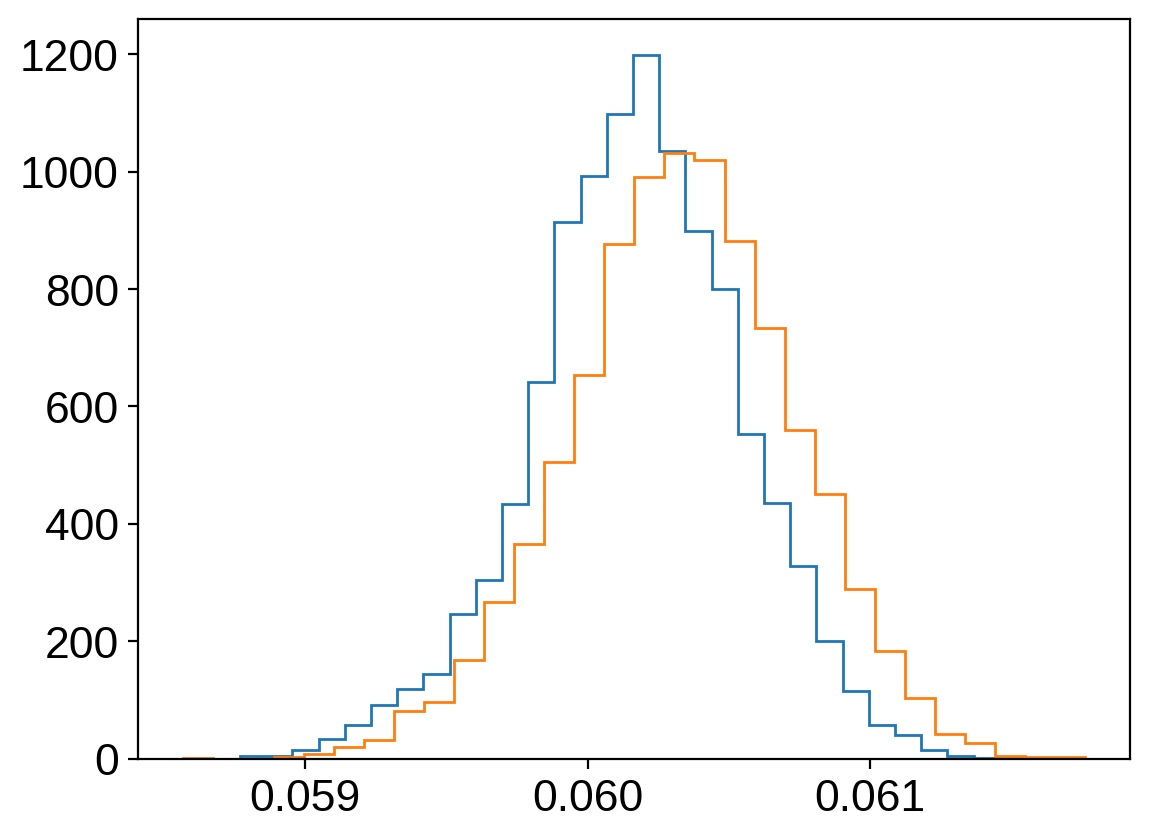

In [10]:
plt.hist(trace["Kepler_ror"], 30, density=True, histtype="step")
plt.hist(trace["TESS_ror"], 30, density=True, histtype="step");

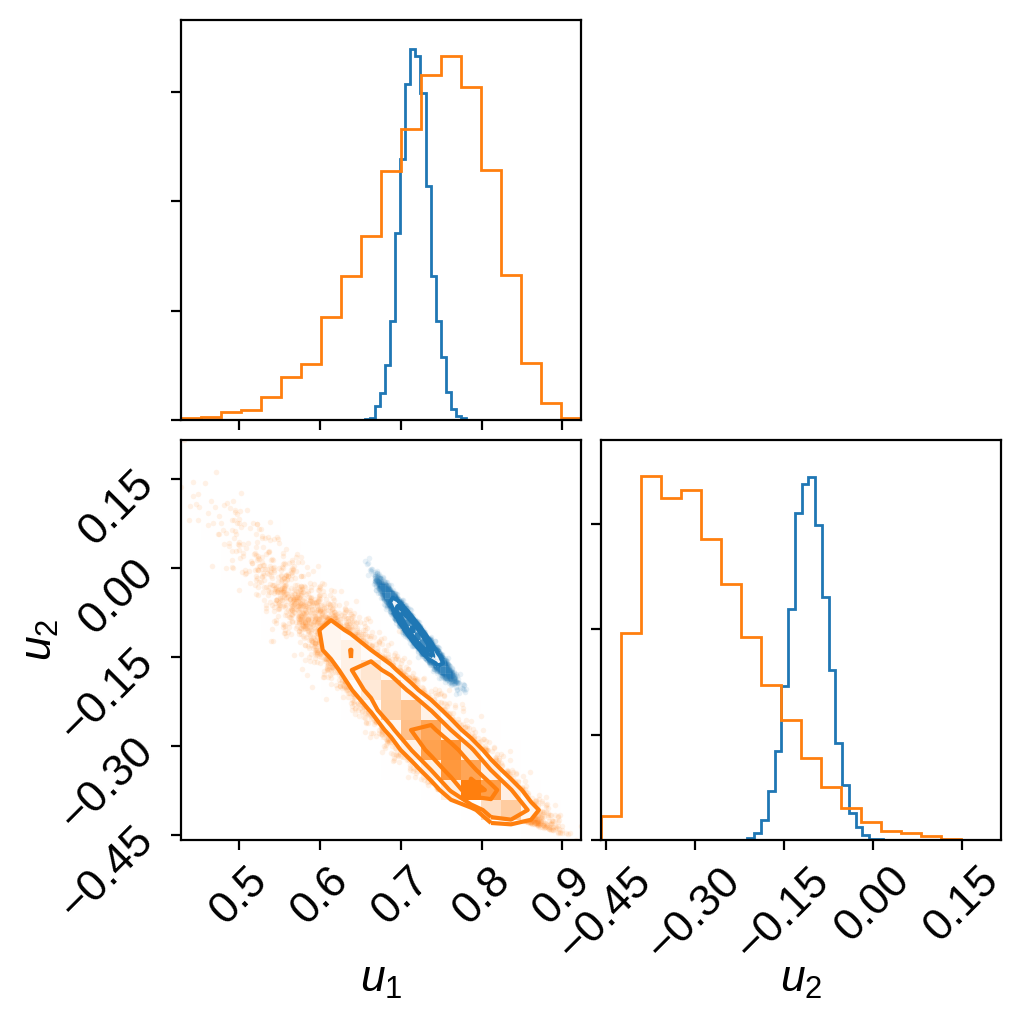

In [11]:
import corner

fig = corner.corner(trace["Kepler_u"], color="C0")
corner.corner(trace["TESS_u"], color="C1", fig=fig, labels=["$u_1$", "$u_2$"]);